In [1]:
import tensorflow as tf
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, applications, Sequential, Model, backend
from tensorflow.keras import optimizers, initializers, regularizers, metrics, utils

# ResNet50

load ResNet50

In [2]:
HEIGHT = 512
WIDTH = 512
class_num = 1
input_shape = (HEIGHT,WIDTH,3)
input_tensor = layers.Input((HEIGHT, WIDTH, 3))

In [3]:
base_model = applications.ResNet50(include_top=False, input_shape=input_shape, weights=None, pooling='avg')
    
x = base_model.output
x = layers.Dense(1000, activation="softmax")(x)
resnet50 = Model(base_model.input, x)

#freeze layer
for layer in resnet50.layers:
    layer.trainable = False

#load pre_trained weight
resnet50.load_weights("resnet50_ImageNet.h5")

#unfreeze layer
for layer in resnet50.layers[:174]:
    layer.trainable = True

In [4]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

extract feature C1~C5

In [5]:
C1 = resnet50.get_layer('pool1_pad').output
C2 = resnet50.get_layer('conv2_block3_out').output
C3 = resnet50.get_layer('conv3_block4_out').output
C4 = resnet50.get_layer('conv4_block6_out').output
C5 = resnet50.get_layer('conv5_block3_out').output

# Feature Pyramid Network

In [6]:
def P5(x, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    return x

def FPN(x, y, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    y = layers.UpSampling2D()(y)
    
    P = layers.Add()([x, y])
    
    return P

In [7]:
P5 = P5(C5)
P4 = FPN(C4, P5)
P3 = FPN(C3, P4)
P2 = FPN(C2, P3)

In [8]:
def FM(x, upsampling, train_bn=True):
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    if upsampling != 1:
        x = layers.Conv2DTranspose(128, (3, 3), strides=(upsampling, upsampling), padding='same')(x)
        x = layers.BatchNormalization()(x, training=train_bn)
        x = layers.Activation('relu')(x)
    
    return x

feature map

In [9]:
FM5 = FM(P5, 8)
FM4 = FM(P4, 4)
FM3 = FM(P3, 2)
FM2 = FM(P2, 1)
FM = layers.concatenate([FM5, FM4, FM3, FM2])
FM.shape

TensorShape([None, 128, 128, 512])

pooling

In [10]:
FM = layers.MaxPool2D(pool_size=(8,8))(FM)
FM.shape

TensorShape([None, 16, 16, 512])

In [11]:
def Mask_Head(x, train_bn=True):
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(class_num, (1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('sigmoid')(x)
    
    x = layers.UpSampling2D(size=(16,16),interpolation='bilinear')(x)
    
    return x

In [12]:
Mask_output = Mask_Head(FM)
Mask_output.shape

TensorShape([None, 512, 512, 1])

make model

In [13]:
NADS_Net = Model(resnet50.input, Mask_output)
NADS_Net = utils.multi_gpu_model(NADS_Net, gpus=2)

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.


In [14]:
NADS_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512, 512, 1)  37293829    lambda[0][0]                     
                                                                 lambda_1[0][0]             

example image

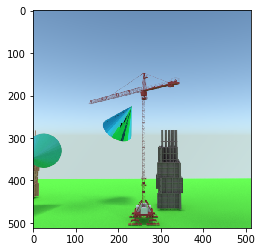

In [15]:
img = plt.imread('./camera20034.png')
plt.imshow(img)

In [16]:
img = tf.reshape(img, (1, 512, 512, 3))
img = tf.cast(img, dtype=tf.float32)

In [17]:
example = NADS_Net(img)
example.shape

TensorShape([1, 512, 512, 1])

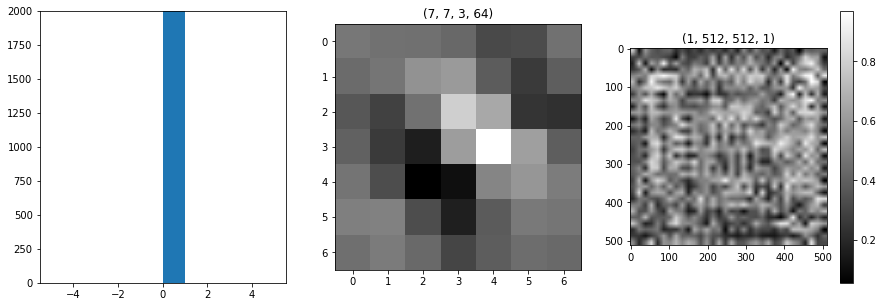

In [18]:
weight = NADS_Net.get_weights()[0]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(example.numpy().ravel(), range=[-5,5])
plt.ylim(0, 2000)
plt.subplot(132)
plt.title(weight.shape)
plt.imshow(weight[:,:,0,0], 'gray')
plt.subplot(133)
plt.title(example.shape)
plt.imshow(example[0, :, :, 0], 'gray')
plt.colorbar()
plt.show()

# Load image dataset

In [19]:
train_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/train/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/test/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/val/*.png')

In [20]:
def get_label(path):
    label_name = path[-15:-4]
    label_path = 'C:/Users/IVCL/Desktop/dock5_DR/classify_occlusionX_semantic/%s.png'%label_name
    label = plt.imread(label_path)
    label = label[...,tf.newaxis]
    label = tf.cast(label, dtype=tf.float32)
    
    return label

In [21]:
def read_image(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (image / 127.5) - 1
    
    return image

In [22]:
def make_batch(batch_paths):
    batch_images = []
    batch_labels = []
        
    for path in batch_paths:
        image = read_image(path)
        batch_images.append(image)
        
        label = get_label(path)
        batch_labels.append(label)
    
    return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels)

In [23]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    test_input = test_input[tf.newaxis, ...]
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[:,:,0], tf.where(prediction[0,:,:,0]>=0.5,1.0,0)]
    
    title = ['Input Image', 'Ground Truth', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

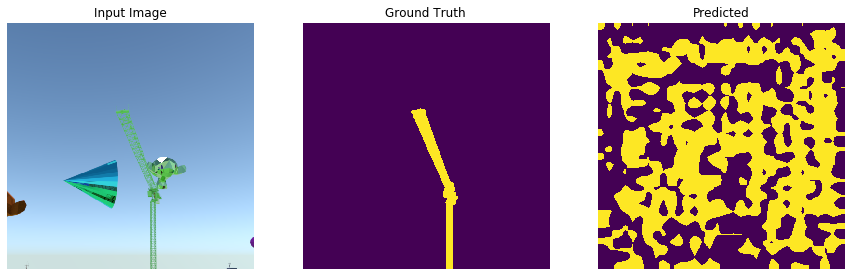

In [24]:
image = read_image(train_paths[0])
label = get_label(train_paths[0])
generate_images(NADS_Net, image, label)

# Define Loss and Optimizer

In [25]:
# Define loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Metrics

In [26]:
def precision(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_positive = tf.reduce_sum(pred)
    
    precision = true_positive / (true_positive_false_positive + tf.keras.backend.epsilon())
                                 
    return precision

                                 
def recall(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_negative = tf.reduce_sum(truth)
    
    recall = true_positive / (true_positive_false_negative + tf.keras.backend.epsilon())
                                 
    return recall

# Checkpoint

In [27]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, NADS_Net=NADS_Net)

# Train

In [28]:
#Hyperparameter
BATCH_SIZE = 2
EPOCHS = 20
train_steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps_per_epoch = len(val_paths)

In [29]:
@tf.function
#def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
def train_step(model, images, labels, loss_object, optimizer, train_loss):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
       
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    #train_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

# Implement algorithm test
@tf.function
#def val_step(model, images, labels, loss_object, val_loss, val_accuracy):
def val_step(model, images, labels, loss_object, val_loss):
    predictions = model(images, training=False)
    
    v_loss = loss_object(labels, predictions)
    val_loss(v_loss)
    #val_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

In [30]:
loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    random.shuffle(train_paths)
    
    train_loss_sum = 0
    val_loss_sum = 0
        
    for step in range(train_steps_per_epoch):
        images, labels = make_batch(train_paths[step * BATCH_SIZE : (step + 1) * BATCH_SIZE])
        
        train_precision, train_recall = train_step(NADS_Net, images, labels, loss_object, optimizer, train_loss)
        
        #template = 'Step {}, Loss: {}, Accuracy: {}'
        template = 'Epoch {}, Step {}, Loss: {}, Precision: {}, Recall: {}'
        print(template.format(epoch + 1, step + 1,
                              train_loss.result(),
                              train_precision * 100,
                              train_recall * 100))

        train_loss_sum = train_loss_sum + train_loss.result()
        
        train_loss.reset_states()
        val_loss.reset_states()
       
    for step in range(val_steps_per_epoch):
        val_images, val_labels = make_batch(val_paths[step * 1 : (step + 1) * 1])
        
        val_precision, val_recall = val_step(NADS_Net, val_images, val_labels, loss_object, val_loss)
        
        val_loss_sum = val_loss_sum + val_loss.result()    
    
    loss_list.append(train_loss_sum / len(train_paths))
    val_loss_list.append(val_loss_sum / len(val_paths))
    
    #template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    template = 'Epoch {}, Val_Loss: {}, Val_Precision: {}, Val_Recall: {}'
    print(template.format(epoch + 1,
                          val_loss_sum / len(val_paths),
                          val_precision * 100,
                          val_recall * 100))
    train_loss.reset_states()
    val_loss.reset_states()
  
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1, Step 1, Loss: 0.7329754829406738, Precision: 5.6130290031433105, Recall: 55.85688781738281
Epoch 1, Step 2, Loss: 0.6676653623580933, Precision: 10.435267448425293, Recall: 88.10030364990234
Epoch 1, Step 3, Loss: 0.6576765775680542, Precision: 11.371671676635742, Recall: 65.2813720703125
Epoch 1, Step 4, Loss: 0.6381745338439941, Precision: 21.633203506469727, Recall: 53.92786407470703
Epoch 1, Step 5, Loss: 0.6349557638168335, Precision: 21.785125732421875, Recall: 54.83222579956055
Epoch 1, Step 6, Loss: 0.6512565612792969, Precision: 11.663958549499512, Recall: 83.57164001464844
Epoch 1, Step 7, Loss: 0.6482430696487427, Precision: 12.465243339538574, Recall: 78.40104675292969
Epoch 1, Step 8, Loss: 0.6302765011787415, Precision: 20.792152404785156, Recall: 78.92005920410156
Epoch 1, Step 9, Loss: 0.6269237995147705, Precision: 22.278425216674805, Recall: 85.58313751220703
Epoch 1, Step 10, Loss: 0.633497416973114, Precision: 25.171911239624023, Recall: 52.88149642944336
E

Epoch 1, Step 85, Loss: 0.5944960713386536, Precision: 26.097240447998047, Recall: 96.66719055175781
Epoch 1, Step 86, Loss: 0.5607903003692627, Precision: 48.514076232910156, Recall: 81.60047912597656
Epoch 1, Step 87, Loss: 0.5612455010414124, Precision: 46.318389892578125, Recall: 94.8009033203125
Epoch 1, Step 88, Loss: 0.5783547163009644, Precision: 30.683183670043945, Recall: 80.89457702636719
Epoch 1, Step 89, Loss: 0.5766765475273132, Precision: 34.8690071105957, Recall: 97.4979248046875
Epoch 1, Step 90, Loss: 0.5653727650642395, Precision: 40.60034942626953, Recall: 92.05241394042969
Epoch 1, Step 91, Loss: 0.5854517817497253, Precision: 26.918262481689453, Recall: 81.84741973876953
Epoch 1, Step 92, Loss: 0.5793395042419434, Precision: 31.31886100769043, Recall: 93.83303833007812
Epoch 1, Step 93, Loss: 0.5684690475463867, Precision: 36.933563232421875, Recall: 99.14994812011719
Epoch 1, Step 94, Loss: 0.5533689260482788, Precision: 47.53908157348633, Recall: 96.646896362304

Epoch 1, Step 167, Loss: 0.5430921912193298, Precision: 38.62491226196289, Recall: 96.10635375976562
Epoch 1, Step 168, Loss: 0.5240645408630371, Precision: 49.05686950683594, Recall: 95.89733123779297
Epoch 1, Step 169, Loss: 0.5287097692489624, Precision: 42.28438949584961, Recall: 97.1240234375
Epoch 1, Step 170, Loss: 0.4930257797241211, Precision: 64.37103271484375, Recall: 93.50161743164062
Epoch 1, Step 171, Loss: 0.4987853169441223, Precision: 63.06606674194336, Recall: 93.53895568847656
Epoch 1, Step 172, Loss: 0.5185916423797607, Precision: 45.44832229614258, Recall: 96.01537322998047
Epoch 1, Step 173, Loss: 0.5243293046951294, Precision: 47.8077507019043, Recall: 87.17859649658203
Epoch 1, Step 174, Loss: 0.5076090097427368, Precision: 55.11770248413086, Recall: 96.89176940917969
Epoch 1, Step 175, Loss: 0.48702409863471985, Precision: 62.196617126464844, Recall: 97.35924530029297
Epoch 1, Step 176, Loss: 0.5192722678184509, Precision: 45.27903747558594, Recall: 98.30609893

Epoch 1, Step 249, Loss: 0.49903738498687744, Precision: 47.55531692504883, Recall: 94.95736694335938
Epoch 1, Step 250, Loss: 0.5039477944374084, Precision: 56.986480712890625, Recall: 68.72380828857422
Epoch 1, Step 251, Loss: 0.496163934469223, Precision: 58.83904266357422, Recall: 90.44515228271484
Epoch 1, Step 252, Loss: 0.5058924555778503, Precision: 38.39775466918945, Recall: 92.50740814208984
Epoch 1, Step 253, Loss: 0.4740963578224182, Precision: 58.11494064331055, Recall: 93.43817901611328
Epoch 1, Step 254, Loss: 0.49562937021255493, Precision: 48.072357177734375, Recall: 92.38693237304688
Epoch 1, Step 255, Loss: 0.4803621768951416, Precision: 50.63447952270508, Recall: 89.3574447631836
Epoch 1, Step 256, Loss: 0.4958072900772095, Precision: 45.72572326660156, Recall: 97.10296630859375
Epoch 1, Step 257, Loss: 0.5126573443412781, Precision: 31.208328247070312, Recall: 90.44068145751953
Epoch 1, Step 258, Loss: 0.48793357610702515, Precision: 46.855716705322266, Recall: 88.

Epoch 1, Step 331, Loss: 0.45665442943573, Precision: 46.94668197631836, Recall: 99.01969146728516
Epoch 1, Step 332, Loss: 0.42997872829437256, Precision: 59.94459915161133, Recall: 93.34905242919922
Epoch 1, Step 333, Loss: 0.4636051058769226, Precision: 43.00328826904297, Recall: 87.67742156982422
Epoch 1, Step 334, Loss: 0.4566655158996582, Precision: 48.14414596557617, Recall: 92.77032470703125
Epoch 1, Step 335, Loss: 0.42067834734916687, Precision: 71.1233139038086, Recall: 98.6202392578125
Epoch 1, Step 336, Loss: 0.47766363620758057, Precision: 37.64763641357422, Recall: 98.16303253173828
Epoch 1, Step 337, Loss: 0.4812367260456085, Precision: 33.78339767456055, Recall: 86.41252136230469
Epoch 1, Step 338, Loss: 0.46356096863746643, Precision: 47.083580017089844, Recall: 91.62818908691406
Epoch 1, Step 339, Loss: 0.4831427037715912, Precision: 38.73611831665039, Recall: 78.10247039794922
Epoch 1, Step 340, Loss: 0.4432888925075531, Precision: 63.32721710205078, Recall: 95.6652

Epoch 1, Step 413, Loss: 0.43401187658309937, Precision: 50.222312927246094, Recall: 95.84181213378906
Epoch 1, Step 414, Loss: 0.4287148714065552, Precision: 49.42470932006836, Recall: 92.94113159179688
Epoch 1, Step 415, Loss: 0.4121825695037842, Precision: 60.664241790771484, Recall: 98.46849060058594
Epoch 1, Step 416, Loss: 0.39112186431884766, Precision: 74.53080749511719, Recall: 95.44625854492188
Epoch 1, Step 417, Loss: 0.43685728311538696, Precision: 42.7921028137207, Recall: 97.4674301147461
Epoch 1, Step 418, Loss: 0.45547226071357727, Precision: 44.12973403930664, Recall: 67.48026275634766
Epoch 1, Step 419, Loss: 0.38827967643737793, Precision: 69.05976867675781, Recall: 92.3415756225586
Epoch 1, Step 420, Loss: 0.4467855989933014, Precision: 47.405738830566406, Recall: 98.40287780761719
Epoch 1, Step 421, Loss: 0.43396419286727905, Precision: 49.927268981933594, Recall: 99.37957000732422
Epoch 1, Step 422, Loss: 0.40553992986679077, Precision: 61.088008880615234, Recall:

Epoch 1, Step 495, Loss: 0.40626853704452515, Precision: 64.32261657714844, Recall: 90.92622375488281
Epoch 1, Step 496, Loss: 0.43251240253448486, Precision: 42.788909912109375, Recall: 74.10093688964844
Epoch 1, Step 497, Loss: 0.3816056251525879, Precision: 77.11795806884766, Recall: 83.04115295410156
Epoch 1, Step 498, Loss: 0.4184165596961975, Precision: 47.45014572143555, Recall: 93.82234954833984
Epoch 1, Step 499, Loss: 0.3921065330505371, Precision: 59.782535552978516, Recall: 94.26862335205078
Epoch 1, Step 500, Loss: 0.4212295114994049, Precision: 36.77992630004883, Recall: 99.9393081665039
Epoch 1, Step 501, Loss: 0.39147722721099854, Precision: 65.01539611816406, Recall: 89.03095245361328
Epoch 1, Step 502, Loss: 0.40551918745040894, Precision: 49.821834564208984, Recall: 99.1189956665039
Epoch 1, Step 503, Loss: 0.4270835220813751, Precision: 37.403656005859375, Recall: 90.19705200195312
Epoch 1, Step 504, Loss: 0.409603476524353, Precision: 45.618160247802734, Recall: 92

Epoch 1, Step 577, Loss: 0.41953814029693604, Precision: 35.3046760559082, Recall: 67.99151611328125
Epoch 1, Step 578, Loss: 0.39746347069740295, Precision: 44.05403137207031, Recall: 86.12857055664062
Epoch 1, Step 579, Loss: 0.3644048571586609, Precision: 72.6373291015625, Recall: 93.12969207763672
Epoch 1, Step 580, Loss: 0.36444729566574097, Precision: 60.2775764465332, Recall: 96.12384796142578
Epoch 1, Step 581, Loss: 0.4093257784843445, Precision: 36.85332107543945, Recall: 75.90679931640625
Epoch 1, Step 582, Loss: 0.34723126888275146, Precision: 73.73502349853516, Recall: 98.5240707397461
Epoch 1, Step 583, Loss: 0.3823174834251404, Precision: 50.3734130859375, Recall: 94.81488800048828
Epoch 1, Step 584, Loss: 0.3847523629665375, Precision: 52.22567367553711, Recall: 89.16053009033203
Epoch 1, Step 585, Loss: 0.36572161316871643, Precision: 65.80548858642578, Recall: 91.61825561523438
Epoch 1, Step 586, Loss: 0.37222540378570557, Precision: 61.616878509521484, Recall: 85.130

Epoch 1, Step 659, Loss: 0.364265501499176, Precision: 55.12717819213867, Recall: 94.15300750732422
Epoch 1, Step 660, Loss: 0.36605578660964966, Precision: 59.1590576171875, Recall: 75.44686126708984
Epoch 1, Step 661, Loss: 0.3594436049461365, Precision: 50.451011657714844, Recall: 100.0
Epoch 1, Step 662, Loss: 0.3302668333053589, Precision: 69.52609252929688, Recall: 93.84671783447266
Epoch 1, Step 663, Loss: 0.3623843491077423, Precision: 59.42655944824219, Recall: 83.41118621826172
Epoch 1, Step 664, Loss: 0.36288127303123474, Precision: 54.8177604675293, Recall: 82.63325500488281
Epoch 1, Step 665, Loss: 0.37518078088760376, Precision: 47.521854400634766, Recall: 85.10807037353516
Epoch 1, Step 666, Loss: 0.35935062170028687, Precision: 52.018218994140625, Recall: 92.62877655029297
Epoch 1, Step 667, Loss: 0.36632078886032104, Precision: 51.94809341430664, Recall: 89.38569641113281
Epoch 1, Step 668, Loss: 0.3419801592826843, Precision: 67.81576538085938, Recall: 92.751235961914

Epoch 1, Step 741, Loss: 0.3716203272342682, Precision: 43.54824447631836, Recall: 86.11549377441406
Epoch 1, Step 742, Loss: 0.30886465311050415, Precision: 70.7397232055664, Recall: 97.99034881591797
Epoch 1, Step 743, Loss: 0.322807639837265, Precision: 64.5368423461914, Recall: 94.81858825683594
Epoch 1, Step 744, Loss: 0.35182735323905945, Precision: 51.381649017333984, Recall: 84.6249771118164
Epoch 1, Step 745, Loss: 0.34476256370544434, Precision: 55.33760070800781, Recall: 98.36429595947266
Epoch 1, Step 746, Loss: 0.3303079903125763, Precision: 67.06367492675781, Recall: 96.15274810791016
Epoch 1, Step 747, Loss: 0.3450759947299957, Precision: 62.14820861816406, Recall: 74.85009765625
Epoch 1, Step 748, Loss: 0.32590252161026, Precision: 67.61139678955078, Recall: 95.13384246826172
Epoch 1, Step 749, Loss: 0.32799309492111206, Precision: 58.28837585449219, Recall: 93.17549133300781
Epoch 1, Step 750, Loss: 0.33559390902519226, Precision: 57.79068374633789, Recall: 97.79991149

Epoch 1, Step 823, Loss: 0.3406824469566345, Precision: 55.23997497558594, Recall: 66.64452362060547
Epoch 1, Step 824, Loss: 0.3518960773944855, Precision: 38.56951141357422, Recall: 82.16492462158203
Epoch 1, Step 825, Loss: 0.3426785469055176, Precision: 41.815738677978516, Recall: 89.26824951171875
Epoch 1, Step 826, Loss: 0.3184053301811218, Precision: 64.02875518798828, Recall: 93.0788345336914
Epoch 1, Step 827, Loss: 0.32674819231033325, Precision: 63.00663375854492, Recall: 86.40497589111328
Epoch 1, Step 828, Loss: 0.31625622510910034, Precision: 61.84485626220703, Recall: 89.5360107421875
Epoch 1, Step 829, Loss: 0.3028269410133362, Precision: 74.40301513671875, Recall: 89.90679931640625
Epoch 1, Step 830, Loss: 0.3193248212337494, Precision: 54.816043853759766, Recall: 97.59811401367188
Epoch 1, Step 831, Loss: 0.31911319494247437, Precision: 57.94020462036133, Recall: 91.84754943847656
Epoch 1, Step 832, Loss: 0.27327048778533936, Precision: 80.24333190917969, Recall: 91.5

Epoch 1, Step 905, Loss: 0.27981603145599365, Precision: 71.62042236328125, Recall: 97.27098083496094
Epoch 1, Step 906, Loss: 0.2787875831127167, Precision: 76.23657989501953, Recall: 96.7989273071289
Epoch 1, Step 907, Loss: 0.2998756468296051, Precision: 58.71303176879883, Recall: 90.79016876220703
Epoch 1, Step 908, Loss: 0.30649062991142273, Precision: 56.6451416015625, Recall: 94.44482421875
Epoch 1, Step 909, Loss: 0.2757229804992676, Precision: 73.49666595458984, Recall: 92.3857421875
Epoch 1, Step 910, Loss: 0.2915618419647217, Precision: 77.73601531982422, Recall: 76.3426513671875
Epoch 1, Step 911, Loss: 0.3019790053367615, Precision: 57.627899169921875, Recall: 92.3199691772461
Epoch 1, Step 912, Loss: 0.2908362150192261, Precision: 59.89949035644531, Recall: 98.52256774902344
Epoch 1, Step 913, Loss: 0.26795512437820435, Precision: 75.51151275634766, Recall: 93.35722351074219
Epoch 1, Step 914, Loss: 0.2977447211742401, Precision: 63.12694549560547, Recall: 84.265144348144

Epoch 1, Step 987, Loss: 0.28110411763191223, Precision: 63.58714294433594, Recall: 88.87687683105469
Epoch 1, Step 988, Loss: 0.2765730917453766, Precision: 68.44782257080078, Recall: 89.59286499023438
Epoch 1, Step 989, Loss: 0.2816694676876068, Precision: 64.33319091796875, Recall: 84.50699615478516
Epoch 1, Step 990, Loss: 0.23985110223293304, Precision: 82.0737075805664, Recall: 90.18330383300781
Epoch 1, Step 991, Loss: 0.30510061979293823, Precision: 54.47090148925781, Recall: 83.30921173095703
Epoch 1, Step 992, Loss: 0.2725927531719208, Precision: 66.69884490966797, Recall: 91.82229614257812
Epoch 1, Step 993, Loss: 0.28546616435050964, Precision: 64.00970458984375, Recall: 81.221923828125
Epoch 1, Step 994, Loss: 0.2723456919193268, Precision: 64.78530883789062, Recall: 96.97062683105469
Epoch 1, Step 995, Loss: 0.27971622347831726, Precision: 59.88686752319336, Recall: 92.90909576416016
Epoch 1, Step 996, Loss: 0.2775333523750305, Precision: 61.58714294433594, Recall: 92.132

Epoch 1, Step 1069, Loss: 0.3411688804626465, Precision: 34.74275588989258, Recall: 48.90376281738281
Epoch 1, Step 1070, Loss: 0.2971016764640808, Precision: 45.46504211425781, Recall: 84.357666015625
Epoch 1, Step 1071, Loss: 0.2788764238357544, Precision: 55.07179641723633, Recall: 90.41380310058594
Epoch 1, Step 1072, Loss: 0.28269028663635254, Precision: 53.96223831176758, Recall: 89.50019836425781
Epoch 1, Step 1073, Loss: 0.2738977074623108, Precision: 59.076847076416016, Recall: 89.19483184814453
Epoch 1, Step 1074, Loss: 0.2636839747428894, Precision: 66.31214141845703, Recall: 93.73115539550781
Epoch 1, Step 1075, Loss: 0.2546665072441101, Precision: 83.01079559326172, Recall: 76.74392700195312
Epoch 1, Step 1076, Loss: 0.27486714720726013, Precision: 64.08281707763672, Recall: 97.13687896728516
Epoch 1, Step 1077, Loss: 0.2611187696456909, Precision: 67.5979995727539, Recall: 96.26676177978516
Epoch 1, Step 1078, Loss: 0.2812122106552124, Precision: 51.110130310058594, Recal

Epoch 1, Step 1151, Loss: 0.2469901442527771, Precision: 60.686702728271484, Recall: 97.12646484375
Epoch 1, Step 1152, Loss: 0.24418143928050995, Precision: 69.49868774414062, Recall: 95.08918762207031
Epoch 1, Step 1153, Loss: 0.23876529932022095, Precision: 68.47858428955078, Recall: 97.79352569580078
Epoch 1, Step 1154, Loss: 0.25323575735092163, Precision: 59.48414611816406, Recall: 95.46417999267578
Epoch 1, Step 1155, Loss: 0.24932539463043213, Precision: 61.87330627441406, Recall: 90.97178649902344
Epoch 1, Step 1156, Loss: 0.2579050064086914, Precision: 59.79356002807617, Recall: 89.33055114746094
Epoch 1, Step 1157, Loss: 0.2293335348367691, Precision: 78.73345947265625, Recall: 90.94920349121094
Epoch 1, Step 1158, Loss: 0.2536798119544983, Precision: 61.967201232910156, Recall: 90.18433380126953
Epoch 1, Step 1159, Loss: 0.24697524309158325, Precision: 67.23519897460938, Recall: 94.7764892578125
Epoch 1, Step 1160, Loss: 0.25030261278152466, Precision: 66.06828308105469, Re

Epoch 1, Step 1233, Loss: 0.2190358191728592, Precision: 76.75132751464844, Recall: 89.29485321044922
Epoch 1, Step 1234, Loss: 0.235330268740654, Precision: 67.59915924072266, Recall: 91.70601654052734
Epoch 1, Step 1235, Loss: 0.23428753018379211, Precision: 66.02503967285156, Recall: 96.0336685180664
Epoch 1, Step 1236, Loss: 0.251460999250412, Precision: 50.61566162109375, Recall: 97.41647338867188
Epoch 1, Step 1237, Loss: 0.209548220038414, Precision: 75.02362823486328, Recall: 97.47457122802734
Epoch 1, Step 1238, Loss: 0.2678183615207672, Precision: 46.028358459472656, Recall: 93.29778289794922
Epoch 1, Step 1239, Loss: 0.22099730372428894, Precision: 76.81692504882812, Recall: 90.81544494628906
Epoch 1, Step 1240, Loss: 0.23108729720115662, Precision: 65.19940185546875, Recall: 96.6900634765625
Epoch 1, Step 1241, Loss: 0.2106943577528, Precision: 91.14525604248047, Recall: 92.06737518310547
Epoch 1, Step 1242, Loss: 0.22535854578018188, Precision: 74.15314483642578, Recall: 9

Epoch 1, Step 1315, Loss: 0.25477245450019836, Precision: 50.75983428955078, Recall: 90.51294708251953
Epoch 1, Step 1316, Loss: 0.22524060308933258, Precision: 65.16336059570312, Recall: 95.7448501586914
Epoch 1, Step 1317, Loss: 0.271068811416626, Precision: 40.7672004699707, Recall: 73.80435180664062
Epoch 1, Step 1318, Loss: 0.23134297132492065, Precision: 67.29869079589844, Recall: 97.7555923461914
Epoch 1, Step 1319, Loss: 0.2239973545074463, Precision: 75.4708023071289, Recall: 83.36187744140625
Epoch 1, Step 1320, Loss: 0.23419320583343506, Precision: 63.002227783203125, Recall: 90.69186401367188
Epoch 1, Step 1321, Loss: 0.20792514085769653, Precision: 79.00877380371094, Recall: 95.24142456054688
Epoch 1, Step 1322, Loss: 0.2504797875881195, Precision: 50.54399871826172, Recall: 82.7935791015625
Epoch 1, Step 1323, Loss: 0.22842223942279816, Precision: 63.72587203979492, Recall: 89.77539825439453
Epoch 1, Step 1324, Loss: 0.23503440618515015, Precision: 76.19971466064453, Reca

Epoch 1, Step 1397, Loss: 0.2310880869626999, Precision: 54.27336120605469, Recall: 93.24382019042969
Epoch 1, Step 1398, Loss: 0.2314007729291916, Precision: 57.68672180175781, Recall: 91.44969940185547
Epoch 1, Step 1399, Loss: 0.20490257441997528, Precision: 71.56714630126953, Recall: 95.7882308959961
Epoch 1, Step 1400, Loss: 0.19597938656806946, Precision: 76.4880142211914, Recall: 95.38864135742188
Epoch 1, Step 1401, Loss: 0.2198965698480606, Precision: 61.905086517333984, Recall: 92.46940612792969
Epoch 1, Step 1402, Loss: 0.2322690784931183, Precision: 63.449501037597656, Recall: 78.9227066040039
Epoch 1, Step 1403, Loss: 0.20438888669013977, Precision: 75.25550079345703, Recall: 89.54215240478516
Epoch 1, Step 1404, Loss: 0.19216956198215485, Precision: 86.29875183105469, Recall: 90.82401275634766
Epoch 1, Step 1405, Loss: 0.2176831066608429, Precision: 65.19027709960938, Recall: 88.83638000488281
Epoch 1, Step 1406, Loss: 0.20712919533252716, Precision: 79.74353790283203, Re

Epoch 1, Step 1477, Loss: 0.20820392668247223, Precision: 64.95636749267578, Recall: 96.3172607421875
Epoch 1, Step 1478, Loss: 0.2102910876274109, Precision: 63.4084358215332, Recall: 91.94266510009766
Epoch 1, Step 1479, Loss: 0.22454248368740082, Precision: 55.19846725463867, Recall: 93.3604965209961
Epoch 1, Step 1480, Loss: 0.20951557159423828, Precision: 68.66802978515625, Recall: 88.16065979003906
Epoch 1, Step 1481, Loss: 0.21910947561264038, Precision: 63.876068115234375, Recall: 82.6909408569336
Epoch 1, Step 1482, Loss: 0.20455673336982727, Precision: 85.15017700195312, Recall: 76.51617431640625
Epoch 1, Step 1483, Loss: 0.2106800377368927, Precision: 64.59626770019531, Recall: 90.4738998413086
Epoch 1, Step 1484, Loss: 0.21272611618041992, Precision: 64.32844543457031, Recall: 92.54696655273438
Epoch 1, Step 1485, Loss: 0.22062787413597107, Precision: 64.10265350341797, Recall: 76.61360168457031
Epoch 1, Step 1486, Loss: 0.22584791481494904, Precision: 68.85871124267578, Re

Epoch 1, Step 1559, Loss: 0.18704915046691895, Precision: 74.91069793701172, Recall: 92.65699005126953
Epoch 1, Step 1560, Loss: 0.2049540877342224, Precision: 68.27041625976562, Recall: 84.38272094726562
Epoch 1, Step 1561, Loss: 0.18606418371200562, Precision: 74.89524841308594, Recall: 97.49314880371094
Epoch 1, Step 1562, Loss: 0.19709715247154236, Precision: 68.06404876708984, Recall: 94.71725463867188
Epoch 1, Step 1563, Loss: 0.20420244336128235, Precision: 60.40583419799805, Recall: 96.08431243896484
Epoch 1, Step 1564, Loss: 0.1945980191230774, Precision: 65.41312408447266, Recall: 94.21989440917969
Epoch 1, Step 1565, Loss: 0.179250568151474, Precision: 79.68246459960938, Recall: 92.71554565429688
Epoch 1, Step 1566, Loss: 0.1965738832950592, Precision: 66.05392456054688, Recall: 91.1033706665039
Epoch 1, Step 1567, Loss: 0.2083679437637329, Precision: 61.40502166748047, Recall: 86.39630889892578
Epoch 1, Step 1568, Loss: 0.18737754225730896, Precision: 74.65287780761719, Rec

Epoch 1, Step 1641, Loss: 0.22003160417079926, Precision: 45.35781478881836, Recall: 81.8360824584961
Epoch 1, Step 1642, Loss: 0.1863877922296524, Precision: 68.5720443725586, Recall: 95.15326690673828
Epoch 1, Step 1643, Loss: 0.22927145659923553, Precision: 54.90132522583008, Recall: 55.62459182739258
Epoch 1, Step 1644, Loss: 0.1829928457736969, Precision: 73.29100036621094, Recall: 93.19541931152344
Epoch 1, Step 1645, Loss: 0.19394654035568237, Precision: 68.15654754638672, Recall: 84.63343811035156
Epoch 1, Step 1646, Loss: 0.19662880897521973, Precision: 60.95064926147461, Recall: 88.76388549804688
Epoch 1, Step 1647, Loss: 0.16122084856033325, Precision: 86.86233520507812, Recall: 90.34044647216797
Epoch 1, Step 1648, Loss: 0.18678513169288635, Precision: 77.14801788330078, Recall: 85.59468841552734
Epoch 1, Step 1649, Loss: 0.19500376284122467, Precision: 64.39799499511719, Recall: 88.53515625
Epoch 1, Step 1650, Loss: 0.16699372231960297, Precision: 83.61639404296875, Recall

Epoch 1, Step 1723, Loss: 0.17615239322185516, Precision: 76.0229263305664, Recall: 90.76405334472656
Epoch 1, Step 1724, Loss: 0.16210559010505676, Precision: 78.04544067382812, Recall: 93.0030746459961
Epoch 1, Step 1725, Loss: 0.16671378910541534, Precision: 76.83727264404297, Recall: 94.16265869140625
Epoch 1, Step 1726, Loss: 0.18404176831245422, Precision: 64.03085327148438, Recall: 95.26087188720703
Epoch 1, Step 1727, Loss: 0.18101754784584045, Precision: 73.47505950927734, Recall: 89.17976379394531
Epoch 1, Step 1728, Loss: 0.16179496049880981, Precision: 85.73792266845703, Recall: 89.68669891357422
Epoch 1, Step 1729, Loss: 0.18372170627117157, Precision: 64.84640502929688, Recall: 87.36396789550781
Epoch 1, Step 1730, Loss: 0.19243545830249786, Precision: 57.06767272949219, Recall: 90.31500244140625
Epoch 1, Step 1731, Loss: 0.18725445866584778, Precision: 72.05522918701172, Recall: 85.48169708251953
Epoch 1, Step 1732, Loss: 0.15943624079227448, Precision: 83.62140655517578

Epoch 1, Step 1805, Loss: 0.1756305992603302, Precision: 67.84476470947266, Recall: 90.39639282226562
Epoch 1, Step 1806, Loss: 0.17330986261367798, Precision: 70.66227722167969, Recall: 92.24122619628906
Epoch 1, Step 1807, Loss: 0.17046354711055756, Precision: 74.24600982666016, Recall: 89.090087890625
Epoch 1, Step 1808, Loss: 0.17402711510658264, Precision: 82.3227310180664, Recall: 78.77421569824219
Epoch 1, Step 1809, Loss: 0.2057725489139557, Precision: 28.16595458984375, Recall: 96.89006805419922
Epoch 1, Step 1810, Loss: 0.1620568037033081, Precision: 86.59767150878906, Recall: 88.76364135742188
Epoch 1, Step 1811, Loss: 0.17921626567840576, Precision: 72.24258422851562, Recall: 77.12342071533203
Epoch 1, Step 1812, Loss: 0.1602984517812729, Precision: 76.5439682006836, Recall: 93.2104263305664
Epoch 1, Step 1813, Loss: 0.15684360265731812, Precision: 85.6324691772461, Recall: 88.92012023925781
Epoch 1, Step 1814, Loss: 0.17658163607120514, Precision: 65.53811645507812, Recall

Epoch 1, Step 1887, Loss: 0.15423479676246643, Precision: 78.36250305175781, Recall: 92.44625854492188
Epoch 1, Step 1888, Loss: 0.16146323084831238, Precision: 74.83074951171875, Recall: 91.08868408203125
Epoch 1, Step 1889, Loss: 0.17301040887832642, Precision: 73.3902587890625, Recall: 74.20108032226562
Epoch 1, Step 1890, Loss: 0.17499758303165436, Precision: 62.39801788330078, Recall: 87.73609161376953
Epoch 1, Step 1891, Loss: 0.17105993628501892, Precision: 59.09687423706055, Recall: 95.62230682373047
Epoch 1, Step 1892, Loss: 0.15732160210609436, Precision: 72.80146026611328, Recall: 95.00521850585938
Epoch 1, Step 1893, Loss: 0.1779032051563263, Precision: 60.59053421020508, Recall: 94.3802261352539
Epoch 1, Step 1894, Loss: 0.14354470372200012, Precision: 90.9791259765625, Recall: 88.00090789794922
Epoch 1, Step 1895, Loss: 0.1653337925672531, Precision: 71.29232788085938, Recall: 88.91841888427734
Epoch 1, Step 1896, Loss: 0.19134950637817383, Precision: 65.92082214355469, R

Epoch 1, Step 1967, Loss: 0.15440154075622559, Precision: 68.43276977539062, Recall: 95.84727478027344
Epoch 1, Step 1968, Loss: 0.1587986946105957, Precision: 69.6666030883789, Recall: 93.707275390625
Epoch 1, Step 1969, Loss: 0.18105140328407288, Precision: 44.25873947143555, Recall: 89.52605438232422
Epoch 1, Step 1970, Loss: 0.1620645374059677, Precision: 71.34168243408203, Recall: 89.12862396240234
Epoch 1, Step 1971, Loss: 0.1764659583568573, Precision: 68.38433074951172, Recall: 78.65752410888672
Epoch 1, Step 1972, Loss: 0.16293615102767944, Precision: 68.9100112915039, Recall: 90.53360748291016
Epoch 1, Step 1973, Loss: 0.13708728551864624, Precision: 86.23110961914062, Recall: 94.51858520507812
Epoch 1, Step 1974, Loss: 0.14324888586997986, Precision: 80.46936798095703, Recall: 95.99560546875
Epoch 1, Step 1975, Loss: 0.1630479395389557, Precision: 70.59871673583984, Recall: 90.40845489501953
Epoch 1, Step 1976, Loss: 0.17124226689338684, Precision: 62.568359375, Recall: 82.5

Epoch 1, Step 2049, Loss: 0.15875078737735748, Precision: 75.7059097290039, Recall: 78.54589080810547
Epoch 1, Step 2050, Loss: 0.16145409643650055, Precision: 76.11210632324219, Recall: 78.44319915771484
Epoch 1, Step 2051, Loss: 0.1556723415851593, Precision: 72.56126403808594, Recall: 90.13590240478516
Epoch 1, Step 2052, Loss: 0.14786729216575623, Precision: 78.97456359863281, Recall: 90.5176010131836
Epoch 1, Step 2053, Loss: 0.16399049758911133, Precision: 65.9892349243164, Recall: 83.54142761230469
Epoch 1, Step 2054, Loss: 0.14363113045692444, Precision: 76.01696014404297, Recall: 94.22297668457031
Epoch 1, Step 2055, Loss: 0.15723523497581482, Precision: 66.92129516601562, Recall: 88.78335571289062
Epoch 1, Step 2056, Loss: 0.1620602309703827, Precision: 68.85618591308594, Recall: 84.04527282714844
Epoch 1, Step 2057, Loss: 0.15121828019618988, Precision: 67.70064544677734, Recall: 95.32062530517578
Epoch 1, Step 2058, Loss: 0.150786891579628, Precision: 70.59497833251953, Rec

Epoch 1, Step 2131, Loss: 0.17869026958942413, Precision: 72.25536346435547, Recall: 71.80181884765625
Epoch 1, Step 2132, Loss: 0.1392672061920166, Precision: 77.0456314086914, Recall: 91.99310302734375
Epoch 1, Step 2133, Loss: 0.15731632709503174, Precision: 68.81309509277344, Recall: 85.63021087646484
Epoch 1, Step 2134, Loss: 0.143867626786232, Precision: 73.08341217041016, Recall: 92.49187469482422
Epoch 1, Step 2135, Loss: 0.14377328753471375, Precision: 75.0006332397461, Recall: 91.13788604736328
Epoch 1, Step 2136, Loss: 0.1525881588459015, Precision: 70.08322143554688, Recall: 86.39156341552734
Epoch 1, Step 2137, Loss: 0.166799396276474, Precision: 71.68252563476562, Recall: 66.90033721923828
Epoch 1, Step 2138, Loss: 0.1377440243959427, Precision: 82.54425811767578, Recall: 89.4464111328125
Epoch 1, Step 2139, Loss: 0.14750373363494873, Precision: 71.73995971679688, Recall: 92.97589874267578
Epoch 1, Step 2140, Loss: 0.24059461057186127, Precision: 40.49476623535156, Recall

Epoch 1, Step 2213, Loss: 0.1450291872024536, Precision: 67.31092071533203, Recall: 93.23380279541016
Epoch 1, Step 2214, Loss: 0.14332512021064758, Precision: 73.69901275634766, Recall: 87.15693664550781
Epoch 1, Step 2215, Loss: 0.1378473937511444, Precision: 70.91019439697266, Recall: 93.44808197021484
Epoch 1, Step 2216, Loss: 0.13085368275642395, Precision: 81.96116638183594, Recall: 95.47657012939453
Epoch 1, Step 2217, Loss: 0.14794495701789856, Precision: 63.10101318359375, Recall: 94.46572875976562
Epoch 1, Step 2218, Loss: 0.1532413363456726, Precision: 60.43254089355469, Recall: 87.73719024658203
Epoch 1, Step 2219, Loss: 0.1342889964580536, Precision: 81.48372650146484, Recall: 90.11088562011719
Epoch 1, Step 2220, Loss: 0.1510424017906189, Precision: 63.276023864746094, Recall: 88.89869689941406
Epoch 1, Step 2221, Loss: 0.13558447360992432, Precision: 81.71617889404297, Recall: 87.2047348022461
Epoch 1, Step 2222, Loss: 0.13739418983459473, Precision: 75.18852233886719, R

Epoch 1, Step 2295, Loss: 0.1454681158065796, Precision: 67.69612121582031, Recall: 83.33260345458984
Epoch 1, Step 2296, Loss: 0.14295518398284912, Precision: 71.4460220336914, Recall: 80.05270385742188
Epoch 1, Step 2297, Loss: 0.1278229057788849, Precision: 80.88188934326172, Recall: 88.18569946289062
Epoch 1, Step 2298, Loss: 0.14265947043895721, Precision: 63.481998443603516, Recall: 94.65298461914062
Epoch 1, Step 2299, Loss: 0.1291690319776535, Precision: 74.69208526611328, Recall: 92.47526550292969
Epoch 1, Step 2300, Loss: 0.15853863954544067, Precision: 61.27072525024414, Recall: 81.30291748046875
Epoch 1, Step 2301, Loss: 0.15904486179351807, Precision: 67.36125183105469, Recall: 68.54389190673828
Epoch 1, Step 2302, Loss: 0.13294070959091187, Precision: 71.27405548095703, Recall: 94.70059967041016
Epoch 1, Step 2303, Loss: 0.13894972205162048, Precision: 73.43257904052734, Recall: 86.1357650756836
Epoch 1, Step 2304, Loss: 0.15919700264930725, Precision: 77.09131622314453, 

Epoch 1, Step 2377, Loss: 0.13874715566635132, Precision: 71.45844268798828, Recall: 88.81979370117188
Epoch 1, Step 2378, Loss: 0.13027323782444, Precision: 76.49211883544922, Recall: 92.2494125366211
Epoch 1, Step 2379, Loss: 0.13525110483169556, Precision: 68.88818359375, Recall: 85.87741088867188
Epoch 1, Step 2380, Loss: 0.13091976940631866, Precision: 69.29180145263672, Recall: 91.32666015625
Epoch 1, Step 2381, Loss: 0.18289291858673096, Precision: 59.83802032470703, Recall: 67.88577270507812
Epoch 1, Step 2382, Loss: 0.13977152109146118, Precision: 64.38695526123047, Recall: 84.13716888427734
Epoch 1, Step 2383, Loss: 0.13471166789531708, Precision: 73.10414123535156, Recall: 84.70146179199219
Epoch 1, Step 2384, Loss: 0.138701394200325, Precision: 79.75050354003906, Recall: 85.01023864746094
Epoch 1, Step 2385, Loss: 0.13386933505535126, Precision: 79.13095092773438, Recall: 80.87200164794922
Epoch 1, Step 2386, Loss: 0.1266051083803177, Precision: 75.15110778808594, Recall: 9

Epoch 1, Step 2459, Loss: 0.13128802180290222, Precision: 78.4517822265625, Recall: 86.33231353759766
Epoch 1, Step 2460, Loss: 0.11516790837049484, Precision: 83.254150390625, Recall: 91.64956665039062
Epoch 1, Step 2461, Loss: 0.16114717721939087, Precision: 56.45693588256836, Recall: 61.780799865722656
Epoch 1, Step 2462, Loss: 0.13727059960365295, Precision: 67.04979705810547, Recall: 81.11992645263672
Epoch 1, Step 2463, Loss: 0.13072732090950012, Precision: 70.47463989257812, Recall: 91.75326538085938
Epoch 1, Step 2464, Loss: 0.12609541416168213, Precision: 72.50364685058594, Recall: 89.72057342529297
Epoch 1, Step 2465, Loss: 0.12324792891740799, Precision: 76.45613861083984, Recall: 90.90419006347656
Epoch 1, Step 2466, Loss: 0.11704186350107193, Precision: 79.66149139404297, Recall: 91.8115463256836
Epoch 1, Step 2467, Loss: 0.11933377385139465, Precision: 80.18594360351562, Recall: 91.37323760986328
Epoch 1, Step 2468, Loss: 0.12350322306156158, Precision: 74.0858154296875, 

Epoch 1, Step 2541, Loss: 0.11592434346675873, Precision: 75.4649429321289, Recall: 93.78666687011719
Epoch 1, Step 2542, Loss: 0.12164875864982605, Precision: 73.56678009033203, Recall: 85.81827545166016
Epoch 1, Step 2543, Loss: 0.139240100979805, Precision: 63.94930648803711, Recall: 75.13760375976562
Epoch 1, Step 2544, Loss: 0.11181077361106873, Precision: 80.29682159423828, Recall: 93.76226806640625
Epoch 1, Step 2545, Loss: 0.1278378963470459, Precision: 77.16902160644531, Recall: 79.4949951171875
Epoch 1, Step 2546, Loss: 0.12287422269582748, Precision: 86.15766906738281, Recall: 85.2187271118164
Epoch 1, Step 2547, Loss: 0.12856802344322205, Precision: 68.92449951171875, Recall: 80.66751098632812
Epoch 1, Step 2548, Loss: 0.125729501247406, Precision: 71.97977447509766, Recall: 88.81148529052734
Epoch 1, Step 2549, Loss: 0.1363593488931656, Precision: 61.180450439453125, Recall: 80.12486267089844
Epoch 1, Step 2550, Loss: 0.10921254754066467, Precision: 84.47589111328125, Reca

Epoch 1, Step 2623, Loss: 0.11750569939613342, Precision: 74.78561401367188, Recall: 86.74736022949219
Epoch 1, Step 2624, Loss: 0.12851767241954803, Precision: 59.09518051147461, Recall: 84.55580139160156
Epoch 1, Step 2625, Loss: 0.11421236395835876, Precision: 70.18014526367188, Recall: 93.94044494628906
Epoch 1, Step 2626, Loss: 0.11762554943561554, Precision: 77.89579772949219, Recall: 88.8440170288086
Epoch 1, Step 2627, Loss: 0.12373317778110504, Precision: 74.0982437133789, Recall: 80.25672912597656
Epoch 1, Step 2628, Loss: 0.1674785166978836, Precision: 63.97422409057617, Recall: 56.38161849975586
Epoch 1, Step 2629, Loss: 0.11549217998981476, Precision: 74.32734680175781, Recall: 92.00375366210938
Epoch 1, Step 2630, Loss: 0.1228189766407013, Precision: 79.83782958984375, Recall: 86.02992248535156
Epoch 1, Step 2631, Loss: 0.11558838933706284, Precision: 76.0783462524414, Recall: 89.5296859741211
Epoch 1, Step 2632, Loss: 0.11226574331521988, Precision: 77.94837951660156, Re

Epoch 1, Step 2703, Loss: 0.10659188032150269, Precision: 81.1480484008789, Recall: 91.11615753173828
Epoch 1, Step 2704, Loss: 0.11305315047502518, Precision: 81.77973937988281, Recall: 86.33261108398438
Epoch 1, Step 2705, Loss: 0.11455947160720825, Precision: 71.95527648925781, Recall: 91.30615997314453
Epoch 1, Step 2706, Loss: 0.10520271956920624, Precision: 84.54286193847656, Recall: 92.26204681396484
Epoch 1, Step 2707, Loss: 0.11289256066083908, Precision: 70.66902160644531, Recall: 95.4378662109375
Epoch 1, Step 2708, Loss: 0.1310848891735077, Precision: 75.35034942626953, Recall: 77.86354064941406
Epoch 1, Step 2709, Loss: 0.11415047943592072, Precision: 69.45893096923828, Recall: 91.1756591796875
Epoch 1, Step 2710, Loss: 0.11639221012592316, Precision: 73.05586242675781, Recall: 88.0757064819336
Epoch 1, Step 2711, Loss: 0.12668296694755554, Precision: 79.17471313476562, Recall: 78.67560577392578
Epoch 1, Step 2712, Loss: 0.10366882383823395, Precision: 88.84709930419922, R

Epoch 1, Step 2785, Loss: 0.11016000062227249, Precision: 81.6498794555664, Recall: 83.03302764892578
Epoch 1, Step 2786, Loss: 0.10838758945465088, Precision: 78.31619262695312, Recall: 88.93476104736328
Epoch 1, Step 2787, Loss: 0.10548636317253113, Precision: 76.87515258789062, Recall: 91.55119323730469
Epoch 1, Step 2788, Loss: 0.1093892902135849, Precision: 76.03152465820312, Recall: 91.07036590576172
Epoch 1, Step 2789, Loss: 0.12128973007202148, Precision: 74.9508285522461, Recall: 82.24407958984375
Epoch 1, Step 2790, Loss: 0.12168058007955551, Precision: 66.44947814941406, Recall: 89.90191650390625
Epoch 1, Step 2791, Loss: 0.11910166591405869, Precision: 70.2144775390625, Recall: 86.78822326660156
Epoch 1, Step 2792, Loss: 0.11363206058740616, Precision: 68.75873565673828, Recall: 94.17584228515625
Epoch 1, Step 2793, Loss: 0.10985425859689713, Precision: 76.84352111816406, Recall: 90.98895263671875
Epoch 1, Step 2794, Loss: 0.10193085670471191, Precision: 78.70528411865234, 

Epoch 1, Step 2867, Loss: 0.11514081805944443, Precision: 71.1939926147461, Recall: 84.41255950927734
Epoch 1, Step 2868, Loss: 0.10607915371656418, Precision: 71.80301666259766, Recall: 90.43639373779297
Epoch 1, Step 2869, Loss: 0.11308535188436508, Precision: 67.47010040283203, Recall: 89.39386749267578
Epoch 1, Step 2870, Loss: 0.11465074867010117, Precision: 79.34117889404297, Recall: 80.77706909179688
Epoch 1, Step 2871, Loss: 0.10603402554988861, Precision: 77.58194732666016, Recall: 87.72633361816406
Epoch 1, Step 2872, Loss: 0.11785569041967392, Precision: 71.10096740722656, Recall: 81.41573333740234
Epoch 1, Step 2873, Loss: 0.1071782261133194, Precision: 76.34041595458984, Recall: 88.57354736328125
Epoch 1, Step 2874, Loss: 0.10184528678655624, Precision: 87.12652587890625, Recall: 86.77928161621094
Epoch 1, Step 2875, Loss: 0.11562196910381317, Precision: 74.00416564941406, Recall: 81.96511840820312
Epoch 1, Step 2876, Loss: 0.09711985290050507, Precision: 82.8426513671875,

Epoch 1, Step 2947, Loss: 0.10905913263559341, Precision: 84.24557495117188, Recall: 90.32386016845703
Epoch 1, Step 2948, Loss: 0.10775894671678543, Precision: 78.66593933105469, Recall: 86.34444427490234
Epoch 1, Step 2949, Loss: 0.10803334414958954, Precision: 77.2667236328125, Recall: 83.88270568847656
Epoch 1, Step 2950, Loss: 0.1080896258354187, Precision: 67.78878784179688, Recall: 86.97759246826172
Epoch 1, Step 2951, Loss: 0.10810790210962296, Precision: 73.68402862548828, Recall: 88.36760711669922
Epoch 1, Step 2952, Loss: 0.09543268382549286, Precision: 83.91996765136719, Recall: 89.8873291015625
Epoch 1, Step 2953, Loss: 0.10117989033460617, Precision: 78.9570541381836, Recall: 94.3779067993164
Epoch 1, Step 2954, Loss: 0.09681954979896545, Precision: 86.66180419921875, Recall: 89.21439361572266
Epoch 1, Step 2955, Loss: 0.10587841272354126, Precision: 62.3675422668457, Recall: 92.55708312988281
Epoch 1, Step 2956, Loss: 0.10564465075731277, Precision: 70.8777084350586, Rec

Epoch 1, Step 3029, Loss: 0.1204538643360138, Precision: 91.08077239990234, Recall: 75.04171752929688
Epoch 1, Step 3030, Loss: 0.10715758800506592, Precision: 74.9160385131836, Recall: 77.12830352783203
Epoch 1, Step 3031, Loss: 0.10311440378427505, Precision: 67.57320404052734, Recall: 89.79994201660156
Epoch 1, Step 3032, Loss: 0.1105055958032608, Precision: 75.04669189453125, Recall: 85.56806945800781
Epoch 1, Step 3033, Loss: 0.11562217772006989, Precision: 82.90739440917969, Recall: 80.49246978759766
Epoch 1, Step 3034, Loss: 0.11327069997787476, Precision: 55.14479446411133, Recall: 94.23757934570312
Epoch 1, Step 3035, Loss: 0.1007167175412178, Precision: 81.49405670166016, Recall: 85.28459930419922
Epoch 1, Step 3036, Loss: 0.10206170380115509, Precision: 78.53471374511719, Recall: 90.35102081298828
Epoch 1, Step 3037, Loss: 0.097526915371418, Precision: 82.06085205078125, Recall: 90.83399963378906
Epoch 1, Step 3038, Loss: 0.11490389704704285, Precision: 71.64234161376953, Re

Epoch 1, Step 3111, Loss: 0.08543765544891357, Precision: 89.59895324707031, Recall: 93.2369613647461
Epoch 1, Step 3112, Loss: 0.10264410823583603, Precision: 74.99644470214844, Recall: 79.90109252929688
Epoch 1, Step 3113, Loss: 0.08758535981178284, Precision: 86.23955535888672, Recall: 93.53389739990234
Epoch 1, Step 3114, Loss: 0.11820142716169357, Precision: 69.0671615600586, Recall: 86.52266693115234
Epoch 1, Step 3115, Loss: 0.09672943502664566, Precision: 74.81197357177734, Recall: 95.24268341064453
Epoch 1, Step 3116, Loss: 0.11649216711521149, Precision: 74.87855529785156, Recall: 83.88615417480469
Epoch 1, Step 3117, Loss: 0.09052164852619171, Precision: 85.3024673461914, Recall: 88.50604248046875
Epoch 1, Step 3118, Loss: 0.11656861752271652, Precision: 75.42012023925781, Recall: 80.17459106445312
Epoch 1, Step 3119, Loss: 0.10115192085504532, Precision: 68.55744934082031, Recall: 91.8902816772461
Epoch 1, Step 3120, Loss: 0.14343038201332092, Precision: 67.86184692382812, 

Epoch 1, Step 3193, Loss: 0.09420019388198853, Precision: 85.7204818725586, Recall: 86.26356506347656
Epoch 1, Step 3194, Loss: 0.09651237726211548, Precision: 82.50958251953125, Recall: 83.85540008544922
Epoch 1, Step 3195, Loss: 0.10497748851776123, Precision: 69.63536834716797, Recall: 79.720947265625
Epoch 1, Step 3196, Loss: 0.09855826199054718, Precision: 78.5521011352539, Recall: 85.1577377319336
Epoch 1, Step 3197, Loss: 0.09395932406187057, Precision: 74.21326446533203, Recall: 89.29447174072266
Epoch 1, Step 3198, Loss: 0.10397952795028687, Precision: 81.74356079101562, Recall: 87.1323013305664
Epoch 1, Step 3199, Loss: 0.09077025204896927, Precision: 84.07686614990234, Recall: 88.55607604980469
Epoch 1, Step 3200, Loss: 0.09979121387004852, Precision: 69.86428833007812, Recall: 81.6890869140625
Epoch 1, Step 3201, Loss: 0.10266820341348648, Precision: 69.34912872314453, Recall: 82.99858856201172
Epoch 1, Step 3202, Loss: 0.103927843272686, Precision: 75.45393371582031, Recal

Epoch 1, Step 3275, Loss: 0.13425856828689575, Precision: 78.78558349609375, Recall: 61.50663375854492
Epoch 1, Step 3276, Loss: 0.10934209823608398, Precision: 64.82416534423828, Recall: 81.2728271484375
Epoch 1, Step 3277, Loss: 0.09443503618240356, Precision: 74.6733627319336, Recall: 95.41484832763672
Epoch 1, Step 3278, Loss: 0.09401458501815796, Precision: 79.44761657714844, Recall: 91.15533447265625
Epoch 1, Step 3279, Loss: 0.09778839349746704, Precision: 79.06310272216797, Recall: 86.70881652832031
Epoch 1, Step 3280, Loss: 0.10352430492639542, Precision: 70.36853790283203, Recall: 86.1563720703125
Epoch 1, Step 3281, Loss: 0.09358786046504974, Precision: 87.71916961669922, Recall: 86.6683578491211
Epoch 1, Step 3282, Loss: 0.09715494513511658, Precision: 71.9831314086914, Recall: 81.87196350097656
Epoch 1, Step 3283, Loss: 0.09552701562643051, Precision: 79.58203125, Recall: 83.52000427246094
Epoch 1, Step 3284, Loss: 0.10224372148513794, Precision: 90.95824432373047, Recall:

Epoch 1, Step 3357, Loss: 0.10543566942214966, Precision: 60.03760528564453, Recall: 80.7127914428711
Epoch 1, Step 3358, Loss: 0.09599210321903229, Precision: 83.9190902709961, Recall: 79.13416290283203
Epoch 1, Step 3359, Loss: 0.09947534650564194, Precision: 66.78241729736328, Recall: 85.31402587890625
Epoch 1, Step 3360, Loss: 0.09584834426641464, Precision: 74.50901794433594, Recall: 85.9736328125
Epoch 1, Step 3361, Loss: 0.09560061246156693, Precision: 84.29999542236328, Recall: 78.18978118896484
Epoch 1, Step 3362, Loss: 0.11362911760807037, Precision: 73.92546844482422, Recall: 83.16124725341797
Epoch 1, Step 3363, Loss: 0.09756393730640411, Precision: 62.376827239990234, Recall: 87.87741088867188
Epoch 1, Step 3364, Loss: 0.10659129917621613, Precision: 60.88158416748047, Recall: 86.4624252319336
Epoch 1, Step 3365, Loss: 0.10840748250484467, Precision: 70.7665786743164, Recall: 80.72697448730469
Epoch 1, Step 3366, Loss: 0.09270483255386353, Precision: 78.76561737060547, Rec

Epoch 1, Step 3437, Loss: 0.09204007685184479, Precision: 74.96112060546875, Recall: 86.41089630126953
Epoch 1, Step 3438, Loss: 0.0862220972776413, Precision: 88.06708526611328, Recall: 85.35279083251953
Epoch 1, Step 3439, Loss: 0.0882607102394104, Precision: 72.91683197021484, Recall: 87.37738037109375
Epoch 1, Step 3440, Loss: 0.08245472609996796, Precision: 82.1664810180664, Recall: 92.48228454589844
Epoch 1, Step 3441, Loss: 0.09022406488656998, Precision: 85.7449722290039, Recall: 86.80609130859375
Epoch 1, Step 3442, Loss: 0.08594579994678497, Precision: 87.46903228759766, Recall: 87.0242919921875
Epoch 1, Step 3443, Loss: 0.08839266747236252, Precision: 78.47067260742188, Recall: 87.37189483642578
Epoch 1, Step 3444, Loss: 0.0879116803407669, Precision: 89.23097229003906, Recall: 82.53556823730469
Epoch 1, Step 3445, Loss: 0.08950130641460419, Precision: 81.56291198730469, Recall: 87.47515869140625
Epoch 1, Step 3446, Loss: 0.08441797643899918, Precision: 74.41226959228516, Re

Epoch 1, Step 3519, Loss: 0.07937664538621902, Precision: 89.133544921875, Recall: 89.7399673461914
Epoch 1, Step 3520, Loss: 0.08829259127378464, Precision: 75.5865249633789, Recall: 92.67282104492188
Epoch 1, Step 3521, Loss: 0.10038553178310394, Precision: 65.11734771728516, Recall: 82.7231216430664
Epoch 1, Step 3522, Loss: 0.08954207599163055, Precision: 70.36959838867188, Recall: 90.61528778076172
Epoch 1, Step 3523, Loss: 0.08754059672355652, Precision: 72.70558166503906, Recall: 92.65497589111328
Epoch 1, Step 3524, Loss: 0.08294481039047241, Precision: 79.18765258789062, Recall: 92.78860473632812
Epoch 1, Step 3525, Loss: 0.11690298467874527, Precision: 65.88594818115234, Recall: 67.49217224121094
Epoch 1, Step 3526, Loss: 0.08539347350597382, Precision: 69.21429443359375, Recall: 89.88874816894531
Epoch 1, Step 3527, Loss: 0.0980902686715126, Precision: 79.74222564697266, Recall: 85.00463104248047
Epoch 1, Step 3528, Loss: 0.10597225278615952, Precision: 63.95329666137695, Re

Epoch 1, Step 3599, Loss: 0.08905116468667984, Precision: 68.51658630371094, Recall: 88.56330108642578
Epoch 1, Step 3600, Loss: 0.07982628792524338, Precision: 87.53091430664062, Recall: 88.75251770019531
Epoch 1, Step 3601, Loss: 0.10334762930870056, Precision: 69.34590911865234, Recall: 81.30924987792969
Epoch 1, Step 3602, Loss: 0.07861769199371338, Precision: 88.68872833251953, Recall: 86.94808197021484
Epoch 1, Step 3603, Loss: 0.13316144049167633, Precision: 87.45557403564453, Recall: 67.42695617675781
Epoch 1, Step 3604, Loss: 0.09455873817205429, Precision: 73.18748474121094, Recall: 85.58997344970703
Epoch 1, Step 3605, Loss: 0.0901956856250763, Precision: 63.6373405456543, Recall: 81.23118591308594
Epoch 1, Step 3606, Loss: 0.09345059841871262, Precision: 72.56189727783203, Recall: 81.5421142578125
Epoch 1, Step 3607, Loss: 0.07969040423631668, Precision: 78.14818572998047, Recall: 92.11418914794922
Epoch 1, Step 3608, Loss: 0.0929732471704483, Precision: 77.5043716430664, R

Epoch 1, Step 3679, Loss: 0.07363743335008621, Precision: 89.16319274902344, Recall: 89.65149688720703
Epoch 1, Step 3680, Loss: 0.08373798429965973, Precision: 75.91936492919922, Recall: 86.40222930908203
Epoch 1, Step 3681, Loss: 0.07820934802293777, Precision: 68.60777282714844, Recall: 90.02684020996094
Epoch 1, Step 3682, Loss: 0.09143821895122528, Precision: 66.33992767333984, Recall: 77.42776489257812
Epoch 1, Step 3683, Loss: 0.07553021609783173, Precision: 77.02349853515625, Recall: 89.38681030273438
Epoch 1, Step 3684, Loss: 0.10301630944013596, Precision: 86.2745132446289, Recall: 70.09967803955078
Epoch 1, Step 3685, Loss: 0.07494334876537323, Precision: 81.551513671875, Recall: 88.6152572631836
Epoch 1, Step 3686, Loss: 0.07982712984085083, Precision: 81.32256317138672, Recall: 83.58275604248047
Epoch 1, Step 3687, Loss: 0.0761333629488945, Precision: 84.20198822021484, Recall: 90.65214538574219
Epoch 1, Step 3688, Loss: 0.08212442696094513, Precision: 77.9586181640625, Re

Epoch 1, Step 3761, Loss: 0.0885690450668335, Precision: 70.26508331298828, Recall: 84.90375518798828
Epoch 1, Step 3762, Loss: 0.0871635153889656, Precision: 78.07433319091797, Recall: 89.9185562133789
Epoch 1, Step 3763, Loss: 0.08650447428226471, Precision: 74.41480255126953, Recall: 85.03598022460938
Epoch 1, Step 3764, Loss: 0.07548311352729797, Precision: 84.54840087890625, Recall: 88.06559753417969
Epoch 1, Step 3765, Loss: 0.07755053043365479, Precision: 68.6618423461914, Recall: 89.43513488769531
Epoch 1, Step 3766, Loss: 0.08136215060949326, Precision: 73.20840454101562, Recall: 89.64093780517578
Epoch 1, Step 3767, Loss: 0.09252651035785675, Precision: 70.18891906738281, Recall: 75.55927276611328
Epoch 1, Step 3768, Loss: 0.07278650999069214, Precision: 74.78223419189453, Recall: 94.39376831054688
Epoch 1, Step 3769, Loss: 0.08600805699825287, Precision: 80.0687026977539, Recall: 80.76557922363281
Epoch 1, Step 3770, Loss: 0.08727018535137177, Precision: 65.63855743408203, R

Epoch 1, Step 3841, Loss: 0.07764898240566254, Precision: 87.59626007080078, Recall: 79.60916900634766
Epoch 1, Step 3842, Loss: 0.09488940984010696, Precision: 76.33251190185547, Recall: 79.11693572998047
Epoch 1, Step 3843, Loss: 0.06772179901599884, Precision: 88.23151397705078, Recall: 94.2209701538086
Epoch 1, Step 3844, Loss: 0.07363107800483704, Precision: 89.59431457519531, Recall: 88.64742279052734
Epoch 1, Step 3845, Loss: 0.07363239675760269, Precision: 76.41783142089844, Recall: 91.9732437133789
Epoch 1, Step 3846, Loss: 0.07921577990055084, Precision: 77.62046813964844, Recall: 90.98291015625
Epoch 1, Step 3847, Loss: 0.07696666568517685, Precision: 84.97451782226562, Recall: 89.63955688476562
Epoch 1, Step 3848, Loss: 0.18471527099609375, Precision: 36.517189025878906, Recall: 75.47888946533203
Epoch 1, Step 3849, Loss: 0.08341442048549652, Precision: 78.72660827636719, Recall: 83.00568389892578
Epoch 1, Step 3850, Loss: 0.07697844505310059, Precision: 79.41448974609375, 

Epoch 1, Step 3921, Loss: 0.0928981825709343, Precision: 83.80735778808594, Recall: 81.45286560058594
Epoch 1, Step 3922, Loss: 0.07761355489492416, Precision: 72.1600112915039, Recall: 86.7747573852539
Epoch 1, Step 3923, Loss: 0.07888282090425491, Precision: 74.28164672851562, Recall: 90.2873306274414
Epoch 1, Step 3924, Loss: 0.0709078460931778, Precision: 84.21240997314453, Recall: 89.46768188476562
Epoch 1, Step 3925, Loss: 0.08081406354904175, Precision: 77.87784576416016, Recall: 86.19743347167969
Epoch 1, Step 3926, Loss: 0.06915803998708725, Precision: 88.80054473876953, Recall: 87.21876525878906
Epoch 1, Step 3927, Loss: 0.09047514200210571, Precision: 76.73558807373047, Recall: 76.7696533203125
Epoch 1, Step 3928, Loss: 0.07623754441738129, Precision: 81.92533111572266, Recall: 87.94606018066406
Epoch 1, Step 3929, Loss: 0.08413688838481903, Precision: 75.15170288085938, Recall: 83.9049072265625
Epoch 1, Step 3930, Loss: 0.0822995975613594, Precision: 70.34532928466797, Reca

Epoch 1, Val_Loss: 0.07968346774578094, Val_Precision: 90.50757598876953, Val_Recall: 93.08536529541016
Epoch 2, Step 1, Loss: 0.07610122114419937, Precision: 75.4399642944336, Recall: 88.67314147949219
Epoch 2, Step 2, Loss: 0.06908728927373886, Precision: 85.84412384033203, Recall: 89.61083221435547
Epoch 2, Step 3, Loss: 0.07020193338394165, Precision: 79.40039825439453, Recall: 89.05853271484375
Epoch 2, Step 4, Loss: 0.07426957786083221, Precision: 73.84425354003906, Recall: 83.94624328613281
Epoch 2, Step 5, Loss: 0.07026367634534836, Precision: 80.30077362060547, Recall: 90.22423553466797
Epoch 2, Step 6, Loss: 0.07482650876045227, Precision: 90.02557373046875, Recall: 86.69749450683594
Epoch 2, Step 7, Loss: 0.07318472862243652, Precision: 76.67310333251953, Recall: 87.0329818725586
Epoch 2, Step 8, Loss: 0.07644455134868622, Precision: 83.06394958496094, Recall: 85.84847259521484
Epoch 2, Step 9, Loss: 0.06917725503444672, Precision: 80.54226684570312, Recall: 91.2009658813476

Epoch 2, Step 82, Loss: 0.06529036909341812, Precision: 85.88087463378906, Recall: 88.32717895507812
Epoch 2, Step 83, Loss: 0.0786287933588028, Precision: 66.8937759399414, Recall: 87.5709457397461
Epoch 2, Step 84, Loss: 0.09411613643169403, Precision: 75.23404693603516, Recall: 78.85151672363281
Epoch 2, Step 85, Loss: 0.07480210065841675, Precision: 74.9866714477539, Recall: 83.50071716308594
Epoch 2, Step 86, Loss: 0.07601018249988556, Precision: 80.91178894042969, Recall: 82.8744125366211
Epoch 2, Step 87, Loss: 0.07468874752521515, Precision: 78.35527038574219, Recall: 85.55307006835938
Epoch 2, Step 88, Loss: 0.07207214832305908, Precision: 81.10472869873047, Recall: 85.31593322753906
Epoch 2, Step 89, Loss: 0.08454670011997223, Precision: 70.23213195800781, Recall: 68.46776580810547
Epoch 2, Step 90, Loss: 0.07017570734024048, Precision: 84.74465942382812, Recall: 83.53224182128906
Epoch 2, Step 91, Loss: 0.07430773973464966, Precision: 76.65878295898438, Recall: 78.6398925781

Epoch 2, Step 164, Loss: 0.07895828783512115, Precision: 63.6422233581543, Recall: 85.56133270263672
Epoch 2, Step 165, Loss: 0.0861036479473114, Precision: 78.46124267578125, Recall: 77.73470306396484
Epoch 2, Step 166, Loss: 0.07178757339715958, Precision: 91.55644989013672, Recall: 87.1329574584961
Epoch 2, Step 167, Loss: 0.08891325443983078, Precision: 78.39656829833984, Recall: 77.38238525390625
Epoch 2, Step 168, Loss: 0.07086218893527985, Precision: 83.75199127197266, Recall: 83.87488555908203
Epoch 2, Step 169, Loss: 0.07033486664295197, Precision: 78.1871566772461, Recall: 84.14404296875
Epoch 2, Step 170, Loss: 0.0681859478354454, Precision: 79.1871337890625, Recall: 83.19622802734375
Epoch 2, Step 171, Loss: 0.06345987319946289, Precision: 85.08585357666016, Recall: 89.41356658935547
Epoch 2, Step 172, Loss: 0.07744039595127106, Precision: 76.39368438720703, Recall: 72.79765319824219
Epoch 2, Step 173, Loss: 0.06890267133712769, Precision: 81.55853271484375, Recall: 86.4687

Epoch 2, Step 246, Loss: 0.07601325213909149, Precision: 71.98858642578125, Recall: 85.7239990234375
Epoch 2, Step 247, Loss: 0.06981339305639267, Precision: 83.59820556640625, Recall: 88.91455078125
Epoch 2, Step 248, Loss: 0.0710182711482048, Precision: 72.81758880615234, Recall: 88.52395629882812
Epoch 2, Step 249, Loss: 0.07977382838726044, Precision: 63.37752914428711, Recall: 86.25299835205078
Epoch 2, Step 250, Loss: 0.0773143619298935, Precision: 70.800537109375, Recall: 92.15155792236328
Epoch 2, Step 251, Loss: 0.07758186757564545, Precision: 71.17467498779297, Recall: 87.32235717773438
Epoch 2, Step 252, Loss: 0.10305079072713852, Precision: 70.11576080322266, Recall: 75.15318298339844
Epoch 2, Step 253, Loss: 0.08350944519042969, Precision: 62.97160339355469, Recall: 89.98944091796875
Epoch 2, Step 254, Loss: 0.06686446070671082, Precision: 82.31597900390625, Recall: 89.86469268798828
Epoch 2, Step 255, Loss: 0.06769628822803497, Precision: 80.48558807373047, Recall: 89.035

Epoch 2, Step 328, Loss: 0.06709322333335876, Precision: 82.26958465576172, Recall: 86.02632141113281
Epoch 2, Step 329, Loss: 0.10060238093137741, Precision: 76.12171936035156, Recall: 68.25908660888672
Epoch 2, Step 330, Loss: 0.06405249238014221, Precision: 81.28701782226562, Recall: 89.02594757080078
Epoch 2, Step 331, Loss: 0.06391698867082596, Precision: 85.59001159667969, Recall: 82.50923919677734
Epoch 2, Step 332, Loss: 0.0767984688282013, Precision: 84.74638366699219, Recall: 82.70491790771484
Epoch 2, Step 333, Loss: 0.07462210208177567, Precision: 76.46234130859375, Recall: 79.05323028564453
Epoch 2, Step 334, Loss: 0.07359133660793304, Precision: 80.51214599609375, Recall: 85.5408935546875
Epoch 2, Step 335, Loss: 0.07006204128265381, Precision: 72.61182403564453, Recall: 90.07743835449219
Epoch 2, Step 336, Loss: 0.06271994858980179, Precision: 79.35189819335938, Recall: 87.7990951538086
Epoch 2, Step 337, Loss: 0.07268407940864563, Precision: 79.5628890991211, Recall: 88

Epoch 2, Step 410, Loss: 0.07503552734851837, Precision: 87.6141357421875, Recall: 87.93855285644531
Epoch 2, Step 411, Loss: 0.06761244684457779, Precision: 77.56893920898438, Recall: 86.74967956542969
Epoch 2, Step 412, Loss: 0.0702739804983139, Precision: 74.21305847167969, Recall: 84.56328582763672
Epoch 2, Step 413, Loss: 0.06765025109052658, Precision: 69.65333557128906, Recall: 87.58031463623047
Epoch 2, Step 414, Loss: 0.08684863895177841, Precision: 81.80177307128906, Recall: 73.0765151977539
Epoch 2, Step 415, Loss: 0.06120491772890091, Precision: 81.18277740478516, Recall: 93.13694763183594
Epoch 2, Step 416, Loss: 0.06752060353755951, Precision: 87.44927978515625, Recall: 88.74283599853516
Epoch 2, Step 417, Loss: 0.07170969247817993, Precision: 76.12385559082031, Recall: 83.95503234863281
Epoch 2, Step 418, Loss: 0.06866089254617691, Precision: 75.68098449707031, Recall: 85.27034759521484
Epoch 2, Step 419, Loss: 0.06553751230239868, Precision: 84.34674072265625, Recall: 8

Epoch 2, Step 492, Loss: 0.07042328268289566, Precision: 74.52293395996094, Recall: 76.407958984375
Epoch 2, Step 493, Loss: 0.0658886730670929, Precision: 84.30105590820312, Recall: 88.72188568115234
Epoch 2, Step 494, Loss: 0.07913375645875931, Precision: 84.32707214355469, Recall: 78.60997772216797
Epoch 2, Step 495, Loss: 0.06939969956874847, Precision: 75.76982879638672, Recall: 80.89644622802734
Epoch 2, Step 496, Loss: 0.07238253206014633, Precision: 77.52694702148438, Recall: 74.14810180664062
Epoch 2, Step 497, Loss: 0.06291365623474121, Precision: 87.90499877929688, Recall: 86.79463195800781
Epoch 2, Step 498, Loss: 0.06513787060976028, Precision: 73.18260955810547, Recall: 90.38038635253906
Epoch 2, Step 499, Loss: 0.07557778060436249, Precision: 77.83189392089844, Recall: 71.7393798828125
Epoch 2, Step 500, Loss: 0.08086910098791122, Precision: 87.51863861083984, Recall: 81.7076644897461
Epoch 2, Step 501, Loss: 0.0641198381781578, Precision: 68.0586929321289, Recall: 74.39

Epoch 2, Step 574, Loss: 0.06139039993286133, Precision: 81.06492614746094, Recall: 88.7892837524414
Epoch 2, Step 575, Loss: 0.06096472591161728, Precision: 91.42972564697266, Recall: 82.36075592041016
Epoch 2, Step 576, Loss: 0.08066277951002121, Precision: 73.16173553466797, Recall: 69.39704132080078
Epoch 2, Step 577, Loss: 0.17598894238471985, Precision: 83.34583282470703, Recall: 41.429203033447266
Epoch 2, Step 578, Loss: 0.06036970764398575, Precision: 88.44257354736328, Recall: 88.73348236083984
Epoch 2, Step 579, Loss: 0.06778193265199661, Precision: 72.34904479980469, Recall: 87.51809692382812
Epoch 2, Step 580, Loss: 0.07278434187173843, Precision: 67.19371032714844, Recall: 86.41178894042969
Epoch 2, Step 581, Loss: 0.07809977978467941, Precision: 46.88671875, Recall: 89.5515365600586
Epoch 2, Step 582, Loss: 0.05934141203761101, Precision: 84.83871459960938, Recall: 90.80562591552734
Epoch 2, Step 583, Loss: 0.09758512675762177, Precision: 81.99128723144531, Recall: 58.38

Epoch 2, Step 656, Loss: 0.061158135533332825, Precision: 86.68993377685547, Recall: 87.77803802490234
Epoch 2, Step 657, Loss: 0.06691960990428925, Precision: 81.17601776123047, Recall: 84.11302947998047
Epoch 2, Step 658, Loss: 0.0659152939915657, Precision: 90.28325653076172, Recall: 85.07859802246094
Epoch 2, Step 659, Loss: 0.06137453764677048, Precision: 81.76578521728516, Recall: 87.65088653564453
Epoch 2, Step 660, Loss: 0.059496257454156876, Precision: 84.05052947998047, Recall: 87.84900665283203
Epoch 2, Step 661, Loss: 0.07526418566703796, Precision: 82.69087982177734, Recall: 87.53276824951172
Epoch 2, Step 662, Loss: 0.06314858794212341, Precision: 90.9152603149414, Recall: 87.37061309814453
Epoch 2, Step 663, Loss: 0.06720626354217529, Precision: 70.83793640136719, Recall: 84.21456146240234
Epoch 2, Step 664, Loss: 0.06692737340927124, Precision: 75.9167251586914, Recall: 83.43256378173828
Epoch 2, Step 665, Loss: 0.061647262424230576, Precision: 85.33555603027344, Recall

Epoch 2, Step 738, Loss: 0.06306439638137817, Precision: 81.01945495605469, Recall: 88.25128936767578
Epoch 2, Step 739, Loss: 0.065252386033535, Precision: 82.33638000488281, Recall: 82.41278839111328
Epoch 2, Step 740, Loss: 0.0621529258787632, Precision: 69.63871002197266, Recall: 86.74052429199219
Epoch 2, Step 741, Loss: 0.06749945878982544, Precision: 76.54396057128906, Recall: 79.29761505126953
Epoch 2, Step 742, Loss: 0.06911861896514893, Precision: 83.93653869628906, Recall: 86.35429382324219
Epoch 2, Step 743, Loss: 0.05072209984064102, Precision: 89.36621856689453, Recall: 91.21536254882812
Epoch 2, Step 744, Loss: 0.059835586696863174, Precision: 83.6042251586914, Recall: 84.011962890625
Epoch 2, Step 745, Loss: 0.06590888649225235, Precision: 83.84199523925781, Recall: 84.13729095458984
Epoch 2, Step 746, Loss: 0.06822392344474792, Precision: 76.07637023925781, Recall: 89.82524871826172
Epoch 2, Step 747, Loss: 0.07014261186122894, Precision: 93.23310089111328, Recall: 79.

Epoch 2, Step 820, Loss: 0.06300488114356995, Precision: 64.88520050048828, Recall: 76.24309539794922
Epoch 2, Step 821, Loss: 0.06409645080566406, Precision: 68.65619659423828, Recall: 83.62090301513672
Epoch 2, Step 822, Loss: 0.060438502579927444, Precision: 73.0628890991211, Recall: 88.78194427490234
Epoch 2, Step 823, Loss: 0.079705610871315, Precision: 67.46195220947266, Recall: 68.58499908447266
Epoch 2, Step 824, Loss: 0.060127660632133484, Precision: 76.571533203125, Recall: 86.72679901123047
Epoch 2, Step 825, Loss: 0.05639416351914406, Precision: 94.3772964477539, Recall: 89.9240951538086
Epoch 2, Step 826, Loss: 0.06207237392663956, Precision: 77.41618347167969, Recall: 87.06719207763672
Epoch 2, Step 827, Loss: 0.05835450813174248, Precision: 89.8840103149414, Recall: 91.11400604248047
Epoch 2, Step 828, Loss: 0.06913141161203384, Precision: 72.43123626708984, Recall: 82.52881622314453
Epoch 2, Step 829, Loss: 0.06029420346021652, Precision: 84.00109100341797, Recall: 88.7

Epoch 2, Step 902, Loss: 0.059378731995821, Precision: 83.86105346679688, Recall: 90.56658935546875
Epoch 2, Step 903, Loss: 0.06191432476043701, Precision: 77.318603515625, Recall: 88.70252990722656
Epoch 2, Step 904, Loss: 0.060441747307777405, Precision: 74.42061614990234, Recall: 89.56060791015625
Epoch 2, Step 905, Loss: 0.06326445192098618, Precision: 75.820068359375, Recall: 81.42092895507812
Epoch 2, Step 906, Loss: 0.1790541708469391, Precision: 44.48140335083008, Recall: 57.07976150512695
Epoch 2, Step 907, Loss: 0.08988268673419952, Precision: 72.18689727783203, Recall: 71.37596130371094
Epoch 2, Step 908, Loss: 0.06767266988754272, Precision: 73.91283416748047, Recall: 78.5
Epoch 2, Step 909, Loss: 0.07169479876756668, Precision: 85.35372161865234, Recall: 87.14555358886719
Epoch 2, Step 910, Loss: 0.06487017124891281, Precision: 80.57176208496094, Recall: 81.7069320678711
Epoch 2, Step 911, Loss: 0.06879296153783798, Precision: 74.12029266357422, Recall: 75.03508758544922


Epoch 2, Step 984, Loss: 0.05668240785598755, Precision: 78.14295196533203, Recall: 86.02529907226562
Epoch 2, Step 985, Loss: 0.06477060168981552, Precision: 76.86927795410156, Recall: 86.2986068725586
Epoch 2, Step 986, Loss: 0.052377767860889435, Precision: 87.9134750366211, Recall: 90.89776611328125
Epoch 2, Step 987, Loss: 0.06230298429727554, Precision: 73.0461654663086, Recall: 90.89045715332031
Epoch 2, Step 988, Loss: 0.057249534875154495, Precision: 87.91835021972656, Recall: 92.08761596679688
Epoch 2, Step 989, Loss: 0.06441634893417358, Precision: 82.52398681640625, Recall: 82.27313232421875
Epoch 2, Step 990, Loss: 0.07545632869005203, Precision: 68.96508026123047, Recall: 83.38032531738281
Epoch 2, Step 991, Loss: 0.058104339987039566, Precision: 86.61468505859375, Recall: 83.31531524658203
Epoch 2, Step 992, Loss: 0.05518997088074684, Precision: 79.3187026977539, Recall: 90.73648071289062
Epoch 2, Step 993, Loss: 0.0722358375787735, Precision: 83.452392578125, Recall: 84

Epoch 2, Step 1064, Loss: 0.060548335313797, Precision: 86.59087371826172, Recall: 86.43152618408203
Epoch 2, Step 1065, Loss: 0.05802600085735321, Precision: 82.28695678710938, Recall: 89.51342010498047
Epoch 2, Step 1066, Loss: 0.07942487299442291, Precision: 82.14126586914062, Recall: 81.22431945800781
Epoch 2, Step 1067, Loss: 0.05183831602334976, Precision: 88.15409851074219, Recall: 92.01361846923828
Epoch 2, Step 1068, Loss: 0.054310597479343414, Precision: 81.69810485839844, Recall: 87.90011596679688
Epoch 2, Step 1069, Loss: 0.06806022673845291, Precision: 90.54253387451172, Recall: 87.12901306152344
Epoch 2, Step 1070, Loss: 0.05772476643323898, Precision: 90.30499267578125, Recall: 85.71964263916016
Epoch 2, Step 1071, Loss: 0.0650588795542717, Precision: 81.38463592529297, Recall: 85.87287902832031
Epoch 2, Step 1072, Loss: 0.057314515113830566, Precision: 83.76219940185547, Recall: 92.161865234375
Epoch 2, Step 1073, Loss: 0.053301580250263214, Precision: 85.29776000976562

Epoch 2, Step 1144, Loss: 0.06599883735179901, Precision: 65.00373077392578, Recall: 77.5322265625
Epoch 2, Step 1145, Loss: 0.0619509331882, Precision: 77.50346374511719, Recall: 82.16690063476562
Epoch 2, Step 1146, Loss: 0.05321510508656502, Precision: 76.40686798095703, Recall: 84.9556884765625
Epoch 2, Step 1147, Loss: 0.05652995780110359, Precision: 79.89962005615234, Recall: 87.32551574707031
Epoch 2, Step 1148, Loss: 0.06233930215239525, Precision: 79.998046875, Recall: 80.39109802246094
Epoch 2, Step 1149, Loss: 0.0565531849861145, Precision: 77.75507354736328, Recall: 84.6193618774414
Epoch 2, Step 1150, Loss: 0.061565473675727844, Precision: 72.0814437866211, Recall: 78.89610290527344
Epoch 2, Step 1151, Loss: 0.05140947550535202, Precision: 76.1070556640625, Recall: 90.80484771728516
Epoch 2, Step 1152, Loss: 0.06036088988184929, Precision: 72.3653564453125, Recall: 91.8013916015625
Epoch 2, Step 1153, Loss: 0.06093328073620796, Precision: 67.77890014648438, Recall: 79.2543

Epoch 2, Step 1226, Loss: 0.07502701878547668, Precision: 79.11174774169922, Recall: 75.52766418457031
Epoch 2, Step 1227, Loss: 0.05631248280405998, Precision: 77.65652465820312, Recall: 82.23709106445312
Epoch 2, Step 1228, Loss: 0.09524120390415192, Precision: 91.90056610107422, Recall: 64.8480224609375
Epoch 2, Step 1229, Loss: 0.06510709226131439, Precision: 82.95317077636719, Recall: 87.86419677734375
Epoch 2, Step 1230, Loss: 0.05767616629600525, Precision: 83.0467300415039, Recall: 94.85578155517578
Epoch 2, Step 1231, Loss: 0.05677715688943863, Precision: 64.10858154296875, Recall: 90.12956237792969
Epoch 2, Step 1232, Loss: 0.05795889347791672, Precision: 70.30172729492188, Recall: 92.0623779296875
Epoch 2, Step 1233, Loss: 0.057467468082904816, Precision: 86.42619323730469, Recall: 91.0589370727539
Epoch 2, Step 1234, Loss: 0.06300903856754303, Precision: 66.18740844726562, Recall: 84.78291320800781
Epoch 2, Step 1235, Loss: 0.05831426754593849, Precision: 79.55351257324219,

Epoch 2, Step 1306, Loss: 0.06092698127031326, Precision: 82.07066345214844, Recall: 80.11181640625
Epoch 2, Step 1307, Loss: 0.07507319748401642, Precision: 91.00303649902344, Recall: 73.79088592529297
Epoch 2, Step 1308, Loss: 0.07542325556278229, Precision: 66.5967788696289, Recall: 88.6854019165039
Epoch 2, Step 1309, Loss: 0.05639585107564926, Precision: 71.91926574707031, Recall: 93.89369201660156
Epoch 2, Step 1310, Loss: 0.06108464300632477, Precision: 77.81562805175781, Recall: 92.4891586303711
Epoch 2, Step 1311, Loss: 0.053866274654865265, Precision: 83.68324279785156, Recall: 88.34355926513672
Epoch 2, Step 1312, Loss: 0.05149560049176216, Precision: 83.79792785644531, Recall: 89.2114486694336
Epoch 2, Step 1313, Loss: 0.04965359717607498, Precision: 89.84989929199219, Recall: 91.65751647949219
Epoch 2, Step 1314, Loss: 0.05170819163322449, Precision: 76.29232025146484, Recall: 89.02951049804688
Epoch 2, Step 1315, Loss: 0.05456189811229706, Precision: 77.6128921508789, Rec

Epoch 2, Step 1386, Loss: 0.056633129715919495, Precision: 79.01444244384766, Recall: 81.73030090332031
Epoch 2, Step 1387, Loss: 0.06564362347126007, Precision: 63.74040985107422, Recall: 70.98174285888672
Epoch 2, Step 1388, Loss: 0.0541817881166935, Precision: 84.057861328125, Recall: 85.48966979980469
Epoch 2, Step 1389, Loss: 0.05844918638467789, Precision: 75.24832153320312, Recall: 82.29191589355469
Epoch 2, Step 1390, Loss: 0.0668414905667305, Precision: 79.8122787475586, Recall: 83.47476196289062
Epoch 2, Step 1391, Loss: 0.07708318531513214, Precision: 81.42535400390625, Recall: 77.54170227050781
Epoch 2, Step 1392, Loss: 0.05573850870132446, Precision: 77.22476959228516, Recall: 89.76176452636719
Epoch 2, Step 1393, Loss: 0.05700842663645744, Precision: 83.94615173339844, Recall: 89.4656753540039
Epoch 2, Step 1394, Loss: 0.10002505779266357, Precision: 67.19935607910156, Recall: 64.26683044433594
Epoch 2, Step 1395, Loss: 0.05202590674161911, Precision: 84.03618621826172, R

Epoch 2, Step 1466, Loss: 0.05790943652391434, Precision: 93.13124084472656, Recall: 85.0211410522461
Epoch 2, Step 1467, Loss: 0.04348110780119896, Precision: 83.23925018310547, Recall: 86.75189208984375
Epoch 2, Step 1468, Loss: 0.07016301155090332, Precision: 72.33414459228516, Recall: 84.64281463623047
Epoch 2, Step 1469, Loss: 0.04805248975753784, Precision: 84.62906646728516, Recall: 83.07051086425781
Epoch 2, Step 1470, Loss: 0.06415551155805588, Precision: 70.52387237548828, Recall: 87.04998779296875
Epoch 2, Step 1471, Loss: 0.06430856883525848, Precision: 82.0353775024414, Recall: 83.98685455322266
Epoch 2, Step 1472, Loss: 0.05001199245452881, Precision: 88.38688659667969, Recall: 85.97350311279297
Epoch 2, Step 1473, Loss: 0.06728411465883255, Precision: 73.22437286376953, Recall: 79.75395202636719
Epoch 2, Step 1474, Loss: 0.050397880375385284, Precision: 85.63813018798828, Recall: 90.84030151367188
Epoch 2, Step 1475, Loss: 0.05034947767853737, Precision: 79.1638641357421

Epoch 2, Step 1546, Loss: 0.05944305658340454, Precision: 78.42784881591797, Recall: 75.4178695678711
Epoch 2, Step 1547, Loss: 0.059417322278022766, Precision: 84.20753479003906, Recall: 79.91116333007812
Epoch 2, Step 1548, Loss: 0.06090501695871353, Precision: 80.97045135498047, Recall: 80.02523803710938
Epoch 2, Step 1549, Loss: 0.06302008032798767, Precision: 68.63845825195312, Recall: 73.60200500488281
Epoch 2, Step 1550, Loss: 0.0534416101872921, Precision: 85.78584289550781, Recall: 91.20538330078125
Epoch 2, Step 1551, Loss: 0.061567001044750214, Precision: 83.31295776367188, Recall: 86.58094787597656
Epoch 2, Step 1552, Loss: 0.05735798925161362, Precision: 85.2497787475586, Recall: 82.17584228515625
Epoch 2, Step 1553, Loss: 0.056943390518426895, Precision: 76.19200134277344, Recall: 91.17242431640625
Epoch 2, Step 1554, Loss: 0.04965507984161377, Precision: 78.88371276855469, Recall: 85.61686706542969
Epoch 2, Step 1555, Loss: 0.0623931884765625, Precision: 71.4668426513671

Epoch 2, Step 1626, Loss: 0.06391499936580658, Precision: 83.9340591430664, Recall: 86.47330474853516
Epoch 2, Step 1627, Loss: 0.06118267774581909, Precision: 75.97869873046875, Recall: 77.79901123046875
Epoch 2, Step 1628, Loss: 0.04964791238307953, Precision: 73.78362274169922, Recall: 84.09090423583984
Epoch 2, Step 1629, Loss: 0.058597590774297714, Precision: 82.56986236572266, Recall: 88.23197174072266
Epoch 2, Step 1630, Loss: 0.050145313143730164, Precision: 84.62469482421875, Recall: 88.5914306640625
Epoch 2, Step 1631, Loss: 0.04882287606596947, Precision: 80.34854888916016, Recall: 83.0799789428711
Epoch 2, Step 1632, Loss: 0.054304126650094986, Precision: 80.76903533935547, Recall: 80.72785949707031
Epoch 2, Step 1633, Loss: 0.05834110826253891, Precision: 80.60906982421875, Recall: 75.09667205810547
Epoch 2, Step 1634, Loss: 0.050958216190338135, Precision: 85.9134292602539, Recall: 90.59001159667969
Epoch 2, Step 1635, Loss: 0.0652136355638504, Precision: 79.8986740112304

Epoch 2, Step 1706, Loss: 0.04753720015287399, Precision: 83.20140075683594, Recall: 89.71602630615234
Epoch 2, Step 1707, Loss: 0.052318353205919266, Precision: 77.28746795654297, Recall: 80.90692138671875
Epoch 2, Step 1708, Loss: 0.054773274809122086, Precision: 89.82406616210938, Recall: 85.37792205810547
Epoch 2, Step 1709, Loss: 0.0512843057513237, Precision: 70.26216888427734, Recall: 83.54915618896484
Epoch 2, Step 1710, Loss: 0.042255230247974396, Precision: 87.9807357788086, Recall: 91.00846099853516
Epoch 2, Step 1711, Loss: 0.05394592881202698, Precision: 71.63180541992188, Recall: 80.32286834716797
Epoch 2, Step 1712, Loss: 0.05798020213842392, Precision: 70.68059539794922, Recall: 71.5987548828125
Epoch 2, Step 1713, Loss: 0.04628625139594078, Precision: 88.85385131835938, Recall: 91.62439727783203
Epoch 2, Step 1714, Loss: 0.05213754251599312, Precision: 82.61273956298828, Recall: 81.8969497680664
Epoch 2, Step 1715, Loss: 0.059140950441360474, Precision: 85.038032531738

Epoch 2, Step 1786, Loss: 0.06464749574661255, Precision: 74.7430191040039, Recall: 85.31980895996094
Epoch 2, Step 1787, Loss: 0.04441412538290024, Precision: 57.702796936035156, Recall: 76.24409484863281
Epoch 2, Step 1788, Loss: 0.056374404579401016, Precision: 74.58171844482422, Recall: 86.38251495361328
Epoch 2, Step 1789, Loss: 0.048598796129226685, Precision: 90.40855407714844, Recall: 89.86949920654297
Epoch 2, Step 1790, Loss: 0.04599780589342117, Precision: 81.3995132446289, Recall: 92.67212677001953
Epoch 2, Step 1791, Loss: 0.05717114359140396, Precision: 76.78466796875, Recall: 75.04180908203125
Epoch 2, Step 1792, Loss: 0.04320136085152626, Precision: 74.38886260986328, Recall: 83.96548461914062
Epoch 2, Step 1793, Loss: 0.05468158423900604, Precision: 76.72152709960938, Recall: 84.525390625
Epoch 2, Step 1794, Loss: 0.05075724795460701, Precision: 74.94780731201172, Recall: 81.84368896484375
Epoch 2, Step 1795, Loss: 0.06260500848293304, Precision: 60.386104583740234, Re

Epoch 2, Step 1866, Loss: 0.054799824953079224, Precision: 71.99342346191406, Recall: 87.52037811279297
Epoch 2, Step 1867, Loss: 0.06011894345283508, Precision: 83.94266510009766, Recall: 86.13451385498047
Epoch 2, Step 1868, Loss: 0.06091270223259926, Precision: 80.28955841064453, Recall: 88.50121307373047
Epoch 2, Step 1869, Loss: 0.052811164408922195, Precision: 76.62645721435547, Recall: 87.73320007324219
Epoch 2, Step 1870, Loss: 0.04636986926198006, Precision: 87.90471649169922, Recall: 92.79328918457031
Epoch 2, Step 1871, Loss: 0.050652723759412766, Precision: 87.17684936523438, Recall: 91.37808990478516
Epoch 2, Step 1872, Loss: 0.05632772669196129, Precision: 77.12716674804688, Recall: 93.8619384765625
Epoch 2, Step 1873, Loss: 0.051241207867860794, Precision: 85.65251922607422, Recall: 86.12081146240234
Epoch 2, Step 1874, Loss: 0.047568753361701965, Precision: 88.76079559326172, Recall: 85.7796859741211
Epoch 2, Step 1875, Loss: 0.046545907855033875, Precision: 78.97384643

Epoch 2, Step 1946, Loss: 0.0606561154127121, Precision: 75.73881530761719, Recall: 80.63554382324219
Epoch 2, Step 1947, Loss: 0.06166715919971466, Precision: 68.12236022949219, Recall: 72.92034912109375
Epoch 2, Step 1948, Loss: 0.07934854924678802, Precision: 70.1993637084961, Recall: 72.6140365600586
Epoch 2, Step 1949, Loss: 0.043406032025814056, Precision: 91.21067810058594, Recall: 82.60767364501953
Epoch 2, Step 1950, Loss: 0.05428151413798332, Precision: 82.4094467163086, Recall: 85.76678466796875
Epoch 2, Step 1951, Loss: 0.05861634388566017, Precision: 73.90423583984375, Recall: 82.61371612548828
Epoch 2, Step 1952, Loss: 0.06830555200576782, Precision: 74.2148208618164, Recall: 68.21311950683594
Epoch 2, Step 1953, Loss: 0.05346353352069855, Precision: 80.41143798828125, Recall: 80.47459411621094
Epoch 2, Step 1954, Loss: 0.055840879678726196, Precision: 84.053955078125, Recall: 78.22175598144531
Epoch 2, Step 1955, Loss: 0.04649697244167328, Precision: 73.9945297241211, Re

Epoch 2, Step 2026, Loss: 0.04748456925153732, Precision: 87.02954864501953, Recall: 84.59242248535156
Epoch 2, Step 2027, Loss: 0.05821331962943077, Precision: 77.06489562988281, Recall: 82.68640899658203
Epoch 2, Step 2028, Loss: 0.06372915208339691, Precision: 81.32044982910156, Recall: 70.01860809326172
Epoch 2, Step 2029, Loss: 0.06133569777011871, Precision: 79.15430450439453, Recall: 74.69602966308594
Epoch 2, Step 2030, Loss: 0.047593869268894196, Precision: 81.34941101074219, Recall: 86.43922424316406
Epoch 2, Step 2031, Loss: 0.0452084019780159, Precision: 78.67853546142578, Recall: 82.16358184814453
Epoch 2, Step 2032, Loss: 0.04815050587058067, Precision: 83.12772369384766, Recall: 91.98175048828125
Epoch 2, Step 2033, Loss: 0.04774148762226105, Precision: 89.53411865234375, Recall: 88.26725769042969
Epoch 2, Step 2034, Loss: 0.051430054008960724, Precision: 92.98216247558594, Recall: 87.40752410888672
Epoch 2, Step 2035, Loss: 0.06087563931941986, Precision: 78.85724639892

Epoch 2, Step 2106, Loss: 0.0507853701710701, Precision: 81.85091400146484, Recall: 86.40999603271484
Epoch 2, Step 2107, Loss: 0.05739252269268036, Precision: 74.4824447631836, Recall: 70.2674789428711
Epoch 2, Step 2108, Loss: 0.060707855969667435, Precision: 76.59297943115234, Recall: 75.81159973144531
Epoch 2, Step 2109, Loss: 0.046105291694402695, Precision: 78.51518249511719, Recall: 80.56945037841797
Epoch 2, Step 2110, Loss: 0.05656386539340019, Precision: 77.06565856933594, Recall: 85.88604736328125
Epoch 2, Step 2111, Loss: 0.05736694857478142, Precision: 79.41031646728516, Recall: 87.10587310791016
Epoch 2, Step 2112, Loss: 0.042438045144081116, Precision: 81.64740753173828, Recall: 86.2269515991211
Epoch 2, Step 2113, Loss: 0.04449617490172386, Precision: 71.08985900878906, Recall: 94.36640930175781
Epoch 2, Step 2114, Loss: 0.05747929960489273, Precision: 77.46519470214844, Recall: 80.29258728027344
Epoch 2, Step 2115, Loss: 0.049448657780885696, Precision: 84.398490905761

Epoch 2, Step 2186, Loss: 0.059483177959918976, Precision: 86.06713104248047, Recall: 70.70269012451172
Epoch 2, Step 2187, Loss: 0.049813225865364075, Precision: 78.21724700927734, Recall: 80.34086608886719
Epoch 2, Step 2188, Loss: 0.05138009786605835, Precision: 86.53373718261719, Recall: 93.6596450805664
Epoch 2, Step 2189, Loss: 0.05351968854665756, Precision: 81.67498016357422, Recall: 80.94937133789062
Epoch 2, Step 2190, Loss: 0.056490495800971985, Precision: 69.44591522216797, Recall: 77.2056655883789
Epoch 2, Step 2191, Loss: 0.0454750657081604, Precision: 85.1322021484375, Recall: 91.79808807373047
Epoch 2, Step 2192, Loss: 0.05197089537978172, Precision: 76.78652954101562, Recall: 82.07091522216797
Epoch 2, Step 2193, Loss: 0.06403114646673203, Precision: 85.94873809814453, Recall: 81.01380157470703
Epoch 2, Step 2194, Loss: 0.06704998016357422, Precision: 73.82530212402344, Recall: 56.380470275878906
Epoch 2, Step 2195, Loss: 0.049251966178417206, Precision: 83.13304138183

Epoch 2, Step 2266, Loss: 0.047413941472768784, Precision: 66.34336853027344, Recall: 77.13995361328125
Epoch 2, Step 2267, Loss: 0.050779491662979126, Precision: 76.37701416015625, Recall: 78.42223358154297
Epoch 2, Step 2268, Loss: 0.04907658323645592, Precision: 72.87228393554688, Recall: 80.33064270019531
Epoch 2, Step 2269, Loss: 0.05395941063761711, Precision: 75.86371612548828, Recall: 84.63243103027344
Epoch 2, Step 2270, Loss: 0.05028168857097626, Precision: 74.0794906616211, Recall: 75.05410766601562
Epoch 2, Step 2271, Loss: 0.05702283978462219, Precision: 77.78245544433594, Recall: 78.44336700439453
Epoch 2, Step 2272, Loss: 0.057121530175209045, Precision: 76.53131866455078, Recall: 83.15766143798828
Epoch 2, Step 2273, Loss: 0.057463426142930984, Precision: 69.63502502441406, Recall: 84.8638916015625
Epoch 2, Step 2274, Loss: 0.044124383479356766, Precision: 79.97296142578125, Recall: 89.26364135742188
Epoch 2, Step 2275, Loss: 0.04788479954004288, Precision: 92.162117004

Epoch 2, Step 2346, Loss: 0.048785217106342316, Precision: 70.64539337158203, Recall: 80.3980712890625
Epoch 2, Step 2347, Loss: 0.046869371086359024, Precision: 77.76049041748047, Recall: 81.46063995361328
Epoch 2, Step 2348, Loss: 0.050555747002363205, Precision: 83.92344665527344, Recall: 91.9769287109375
Epoch 2, Step 2349, Loss: 0.07956618070602417, Precision: 86.75262451171875, Recall: 80.44693756103516
Epoch 2, Step 2350, Loss: 0.051303837448358536, Precision: 84.08535766601562, Recall: 84.18818664550781
Epoch 2, Step 2351, Loss: 0.04586038738489151, Precision: 77.24533081054688, Recall: 88.77993774414062
Epoch 2, Step 2352, Loss: 0.0460381805896759, Precision: 84.17616271972656, Recall: 83.30457305908203
Epoch 2, Step 2353, Loss: 0.0759999081492424, Precision: 74.27862548828125, Recall: 69.82652282714844
Epoch 2, Step 2354, Loss: 0.045060671865940094, Precision: 88.78030395507812, Recall: 89.52837371826172
Epoch 2, Step 2355, Loss: 0.07567868381738663, Precision: 86.32505035400

Epoch 2, Step 2426, Loss: 0.04957141727209091, Precision: 82.94273376464844, Recall: 85.3765869140625
Epoch 2, Step 2427, Loss: 0.0469675287604332, Precision: 79.88520812988281, Recall: 83.26354217529297
Epoch 2, Step 2428, Loss: 0.045686833560466766, Precision: 79.20947265625, Recall: 82.59539031982422
Epoch 2, Step 2429, Loss: 0.04174933582544327, Precision: 94.6484146118164, Recall: 87.59562683105469
Epoch 2, Step 2430, Loss: 0.048913463950157166, Precision: 72.98954772949219, Recall: 78.08968353271484
Epoch 2, Step 2431, Loss: 0.05547919124364853, Precision: 79.18416595458984, Recall: 81.90565490722656
Epoch 2, Step 2432, Loss: 0.03619423508644104, Precision: 82.52169799804688, Recall: 86.4870376586914
Epoch 2, Step 2433, Loss: 0.05845535546541214, Precision: 77.74992370605469, Recall: 77.46467590332031
Epoch 2, Step 2434, Loss: 0.0635785385966301, Precision: 83.53359985351562, Recall: 80.05293273925781
Epoch 2, Step 2435, Loss: 0.06606599688529968, Precision: 82.44715118408203, Re

Epoch 2, Step 2506, Loss: 0.06847923994064331, Precision: 78.63955688476562, Recall: 76.36123657226562
Epoch 2, Step 2507, Loss: 0.055959828197956085, Precision: 84.07445526123047, Recall: 80.6547622680664
Epoch 2, Step 2508, Loss: 0.05440013110637665, Precision: 84.36174011230469, Recall: 79.08253479003906
Epoch 2, Step 2509, Loss: 0.04562188684940338, Precision: 89.6116943359375, Recall: 91.55442810058594
Epoch 2, Step 2510, Loss: 0.05851736292243004, Precision: 88.07701110839844, Recall: 83.15789794921875
Epoch 2, Step 2511, Loss: 0.05052734538912773, Precision: 81.74659729003906, Recall: 86.55123138427734
Epoch 2, Step 2512, Loss: 0.04848255217075348, Precision: 85.5213851928711, Recall: 84.62109375
Epoch 2, Step 2513, Loss: 0.05541633069515228, Precision: 76.67318725585938, Recall: 86.77985382080078
Epoch 2, Step 2514, Loss: 0.05278373137116432, Precision: 75.9778823852539, Recall: 80.49102020263672
Epoch 2, Step 2515, Loss: 0.046078912913799286, Precision: 81.75960540771484, Reca

Epoch 2, Step 2586, Loss: 0.05426500737667084, Precision: 77.2273941040039, Recall: 64.84480285644531
Epoch 2, Step 2587, Loss: 0.055835846811532974, Precision: 77.17754364013672, Recall: 80.82351684570312
Epoch 2, Step 2588, Loss: 0.051027778536081314, Precision: 87.60506439208984, Recall: 79.07941436767578
Epoch 2, Step 2589, Loss: 0.052160993218421936, Precision: 77.68223571777344, Recall: 74.29185485839844
Epoch 2, Step 2590, Loss: 0.05112754553556442, Precision: 89.29163360595703, Recall: 83.75897216796875
Epoch 2, Step 2591, Loss: 0.06931064277887344, Precision: 90.56647491455078, Recall: 61.58599853515625
Epoch 2, Step 2592, Loss: 0.07462839037179947, Precision: 82.18370056152344, Recall: 62.876338958740234
Epoch 2, Step 2593, Loss: 0.05593336373567581, Precision: 75.36599731445312, Recall: 91.90223693847656
Epoch 2, Step 2594, Loss: 0.04060080274939537, Precision: 79.57233428955078, Recall: 79.31372833251953
Epoch 2, Step 2595, Loss: 0.06150534376502037, Precision: 78.219657897

Epoch 2, Step 2666, Loss: 0.05269647389650345, Precision: 84.37043762207031, Recall: 83.52191162109375
Epoch 2, Step 2667, Loss: 0.045999377965927124, Precision: 84.96160888671875, Recall: 89.4007797241211
Epoch 2, Step 2668, Loss: 0.05496424809098244, Precision: 72.84532928466797, Recall: 73.84342193603516
Epoch 2, Step 2669, Loss: 0.05459396168589592, Precision: 77.09520721435547, Recall: 77.2840576171875
Epoch 2, Step 2670, Loss: 0.06013989448547363, Precision: 85.24207305908203, Recall: 84.66364288330078
Epoch 2, Step 2671, Loss: 0.04373927414417267, Precision: 84.03390502929688, Recall: 87.72477722167969
Epoch 2, Step 2672, Loss: 0.049881696701049805, Precision: 81.29546356201172, Recall: 82.99388885498047
Epoch 2, Step 2673, Loss: 0.03940846771001816, Precision: 88.65229797363281, Recall: 88.27562713623047
Epoch 2, Step 2674, Loss: 0.04328464716672897, Precision: 85.64251708984375, Recall: 89.61099243164062
Epoch 2, Step 2675, Loss: 0.0427728071808815, Precision: 88.5107498168945

Epoch 2, Step 2746, Loss: 0.057304177433252335, Precision: 74.21463012695312, Recall: 80.2890396118164
Epoch 2, Step 2747, Loss: 0.05533107742667198, Precision: 81.73916625976562, Recall: 78.03636169433594
Epoch 2, Step 2748, Loss: 0.05672183632850647, Precision: 90.306396484375, Recall: 80.73411560058594
Epoch 2, Step 2749, Loss: 0.07846977561712265, Precision: 79.02703094482422, Recall: 70.74765014648438
Epoch 2, Step 2750, Loss: 0.04826926067471504, Precision: 82.3267593383789, Recall: 87.80843353271484
Epoch 2, Step 2751, Loss: 0.08725866675376892, Precision: 74.03337097167969, Recall: 78.67377471923828
Epoch 2, Step 2752, Loss: 0.04276173561811447, Precision: 81.00357055664062, Recall: 90.86604309082031
Epoch 2, Step 2753, Loss: 0.049826547503471375, Precision: 71.00892639160156, Recall: 90.34852600097656
Epoch 2, Step 2754, Loss: 0.04843974485993385, Precision: 87.79122924804688, Recall: 91.15380096435547
Epoch 2, Step 2755, Loss: 0.05906987190246582, Precision: 75.39071655273438

Epoch 2, Step 2826, Loss: 0.04761733114719391, Precision: 72.69322204589844, Recall: 84.88101196289062
Epoch 2, Step 2827, Loss: 0.059290811419487, Precision: 91.40151977539062, Recall: 86.45597839355469
Epoch 2, Step 2828, Loss: 0.04680522158741951, Precision: 64.04827117919922, Recall: 87.77275848388672
Epoch 2, Step 2829, Loss: 0.040114179253578186, Precision: 77.62836456298828, Recall: 87.7475814819336
Epoch 2, Step 2830, Loss: 0.04405907914042473, Precision: 84.30239868164062, Recall: 86.85334014892578
Epoch 2, Step 2831, Loss: 0.04682954400777817, Precision: 74.8713607788086, Recall: 85.97259521484375
Epoch 2, Step 2832, Loss: 0.039676714688539505, Precision: 77.68510437011719, Recall: 91.15727996826172
Epoch 2, Step 2833, Loss: 0.04045901447534561, Precision: 80.85818481445312, Recall: 86.52140045166016
Epoch 2, Step 2834, Loss: 0.04844241589307785, Precision: 78.94200134277344, Recall: 90.11844635009766
Epoch 2, Step 2835, Loss: 0.052171021699905396, Precision: 75.2774124145507

Epoch 2, Step 2906, Loss: 0.053374823182821274, Precision: 85.99327850341797, Recall: 88.18428802490234
Epoch 2, Step 2907, Loss: 0.048622697591781616, Precision: 80.57633209228516, Recall: 83.75138092041016
Epoch 2, Step 2908, Loss: 0.04547906294465065, Precision: 82.92601013183594, Recall: 89.2827377319336
Epoch 2, Step 2909, Loss: 0.05261363089084625, Precision: 77.17880249023438, Recall: 87.31005096435547
Epoch 2, Step 2910, Loss: 0.037585243582725525, Precision: 85.32172393798828, Recall: 89.45128631591797
Epoch 2, Step 2911, Loss: 0.054094113409519196, Precision: 76.74175262451172, Recall: 86.95799255371094
Epoch 2, Step 2912, Loss: 0.05847904831171036, Precision: 72.14291381835938, Recall: 78.57435607910156
Epoch 2, Step 2913, Loss: 0.053845327347517014, Precision: 72.88580322265625, Recall: 77.53639221191406
Epoch 2, Step 2914, Loss: 0.05350911244750023, Precision: 91.99113464355469, Recall: 80.54996490478516
Epoch 2, Step 2915, Loss: 0.05015033483505249, Precision: 76.43151855

Epoch 2, Step 2986, Loss: 0.05122708901762962, Precision: 77.71070098876953, Recall: 83.59752655029297
Epoch 2, Step 2987, Loss: 0.04864456504583359, Precision: 77.48617553710938, Recall: 85.2388916015625
Epoch 2, Step 2988, Loss: 0.041538503021001816, Precision: 80.33324432373047, Recall: 83.42383575439453
Epoch 2, Step 2989, Loss: 0.0569254495203495, Precision: 80.36034393310547, Recall: 83.6398696899414
Epoch 2, Step 2990, Loss: 0.05507280305027962, Precision: 57.07504653930664, Recall: 79.33390808105469
Epoch 2, Step 2991, Loss: 0.04990922659635544, Precision: 70.6590576171875, Recall: 82.38135528564453
Epoch 2, Step 2992, Loss: 0.0347880944609642, Precision: 90.21613311767578, Recall: 83.88638305664062
Epoch 2, Step 2993, Loss: 0.0498565137386322, Precision: 81.64737701416016, Recall: 78.91130828857422
Epoch 2, Step 2994, Loss: 0.04405426234006882, Precision: 82.77397155761719, Recall: 81.03912353515625
Epoch 2, Step 2995, Loss: 0.03630952537059784, Precision: 87.52989196777344, R

Epoch 2, Step 3066, Loss: 0.049422819167375565, Precision: 77.50404357910156, Recall: 83.52550506591797
Epoch 2, Step 3067, Loss: 0.06611666828393936, Precision: 70.4967269897461, Recall: 63.409847259521484
Epoch 2, Step 3068, Loss: 0.044726017862558365, Precision: 85.37442779541016, Recall: 91.86166381835938
Epoch 2, Step 3069, Loss: 0.06707924604415894, Precision: 66.05855560302734, Recall: 84.62897491455078
Epoch 2, Step 3070, Loss: 0.06489058583974838, Precision: 79.95146942138672, Recall: 80.34136199951172
Epoch 2, Step 3071, Loss: 0.04739321768283844, Precision: 68.7947006225586, Recall: 74.00517272949219
Epoch 2, Step 3072, Loss: 0.0405842587351799, Precision: 83.46761322021484, Recall: 87.08029174804688
Epoch 2, Step 3073, Loss: 0.04046423360705376, Precision: 81.58379364013672, Recall: 89.72151947021484
Epoch 2, Step 3074, Loss: 0.05102434754371643, Precision: 89.65528869628906, Recall: 92.62998962402344
Epoch 2, Step 3075, Loss: 0.033927012234926224, Precision: 72.93466949462

Epoch 2, Step 3146, Loss: 0.06295564770698547, Precision: 73.60563659667969, Recall: 72.57703399658203
Epoch 2, Step 3147, Loss: 0.052800439298152924, Precision: 87.53936767578125, Recall: 83.67473602294922
Epoch 2, Step 3148, Loss: 0.05103365331888199, Precision: 92.24844360351562, Recall: 87.51610565185547
Epoch 2, Step 3149, Loss: 0.04348944127559662, Precision: 85.62483978271484, Recall: 90.55755615234375
Epoch 2, Step 3150, Loss: 0.044846922159194946, Precision: 87.50525665283203, Recall: 86.40655517578125
Epoch 2, Step 3151, Loss: 0.039431583136320114, Precision: 77.0045394897461, Recall: 81.3648910522461
Epoch 2, Step 3152, Loss: 0.033777862787246704, Precision: 81.2374267578125, Recall: 81.90841674804688
Epoch 2, Step 3153, Loss: 0.05496712028980255, Precision: 83.97236633300781, Recall: 78.23995208740234
Epoch 2, Step 3154, Loss: 0.06300953030586243, Precision: 89.68382263183594, Recall: 80.61160278320312
Epoch 2, Step 3155, Loss: 0.03572350740432739, Precision: 71.60030364990

Epoch 2, Step 3226, Loss: 0.05953853577375412, Precision: 89.75051879882812, Recall: 87.3172378540039
Epoch 2, Step 3227, Loss: 0.047150831669569016, Precision: 91.99112701416016, Recall: 88.44722747802734
Epoch 2, Step 3228, Loss: 0.0448191799223423, Precision: 84.7514419555664, Recall: 82.37079620361328
Epoch 2, Step 3229, Loss: 0.047008104622364044, Precision: 84.94131469726562, Recall: 85.4732437133789
Epoch 2, Step 3230, Loss: 0.04688575118780136, Precision: 85.25594329833984, Recall: 83.2314224243164
Epoch 2, Step 3231, Loss: 0.05769287422299385, Precision: 80.3564224243164, Recall: 78.3746566772461
Epoch 2, Step 3232, Loss: 0.06354221701622009, Precision: 77.67359924316406, Recall: 79.62590026855469
Epoch 2, Step 3233, Loss: 0.04932425916194916, Precision: 75.29611206054688, Recall: 76.17683410644531
Epoch 2, Step 3234, Loss: 0.030913986265659332, Precision: 84.09359741210938, Recall: 93.86187744140625
Epoch 2, Step 3235, Loss: 0.04216180741786957, Precision: 87.34052276611328, 

Epoch 2, Step 3306, Loss: 0.04084581509232521, Precision: 87.7311019897461, Recall: 82.75450134277344
Epoch 2, Step 3307, Loss: 0.049060553312301636, Precision: 80.97102355957031, Recall: 91.77552032470703
Epoch 2, Step 3308, Loss: 0.04322502017021179, Precision: 82.45439147949219, Recall: 88.68462371826172
Epoch 2, Step 3309, Loss: 0.04473986476659775, Precision: 82.53108215332031, Recall: 88.17634582519531
Epoch 2, Step 3310, Loss: 0.04949028044939041, Precision: 83.19964599609375, Recall: 85.3182144165039
Epoch 2, Step 3311, Loss: 0.05836326628923416, Precision: 85.04994201660156, Recall: 89.96916961669922
Epoch 2, Step 3312, Loss: 0.0491211973130703, Precision: 84.86112213134766, Recall: 88.4163589477539
Epoch 2, Step 3313, Loss: 0.03332488611340523, Precision: 69.58272552490234, Recall: 83.57518005371094
Epoch 2, Step 3314, Loss: 0.039865389466285706, Precision: 80.27456665039062, Recall: 84.40882873535156
Epoch 2, Step 3315, Loss: 0.047040656208992004, Precision: 77.7154006958007

Epoch 2, Step 3388, Loss: 0.04685821384191513, Precision: 81.59246826171875, Recall: 87.11151123046875
Epoch 2, Step 3389, Loss: 0.03610578924417496, Precision: 72.21136474609375, Recall: 86.11821746826172
Epoch 2, Step 3390, Loss: 0.04533817991614342, Precision: 81.40885925292969, Recall: 84.5614013671875
Epoch 2, Step 3391, Loss: 0.03973252698779106, Precision: 75.18170166015625, Recall: 92.98329162597656
Epoch 2, Step 3392, Loss: 0.05576472729444504, Precision: 70.11341094970703, Recall: 88.26818084716797
Epoch 2, Step 3393, Loss: 0.04269241914153099, Precision: 69.57161712646484, Recall: 91.10629272460938
Epoch 2, Step 3394, Loss: 0.04291658103466034, Precision: 83.27914428710938, Recall: 89.50973510742188
Epoch 2, Step 3395, Loss: 0.046732347458601, Precision: 69.8732681274414, Recall: 78.76411437988281
Epoch 2, Step 3396, Loss: 0.06656725704669952, Precision: 72.37995147705078, Recall: 90.55557250976562
Epoch 2, Step 3397, Loss: 0.06794185936450958, Precision: 59.81744384765625, 

Epoch 2, Step 3468, Loss: 0.03861291706562042, Precision: 88.9212646484375, Recall: 86.24315643310547
Epoch 2, Step 3469, Loss: 0.04070117324590683, Precision: 87.01717376708984, Recall: 85.48876953125
Epoch 2, Step 3470, Loss: 0.04448753595352173, Precision: 86.9369125366211, Recall: 72.6086196899414
Epoch 2, Step 3471, Loss: 0.045300666242837906, Precision: 73.47411346435547, Recall: 80.15166473388672
Epoch 2, Step 3472, Loss: 0.062448740005493164, Precision: 93.90538024902344, Recall: 77.39507293701172
Epoch 2, Step 3473, Loss: 0.04141011834144592, Precision: 82.59519958496094, Recall: 87.04907989501953
Epoch 2, Step 3474, Loss: 0.03678674250841141, Precision: 84.1653060913086, Recall: 88.11810302734375
Epoch 2, Step 3475, Loss: 0.09763474762439728, Precision: 89.02788543701172, Recall: 67.72425079345703
Epoch 2, Step 3476, Loss: 0.05462712049484253, Precision: 69.91712188720703, Recall: 79.41637420654297
Epoch 2, Step 3477, Loss: 0.05510358139872551, Precision: 74.8297119140625, Re

Epoch 2, Step 3548, Loss: 0.04725528508424759, Precision: 73.77606964111328, Recall: 75.16807556152344
Epoch 2, Step 3549, Loss: 0.05598989501595497, Precision: 71.78819274902344, Recall: 77.79203033447266
Epoch 2, Step 3550, Loss: 0.04002632573246956, Precision: 88.67725372314453, Recall: 88.50257873535156
Epoch 2, Step 3551, Loss: 0.044472530484199524, Precision: 83.97589111328125, Recall: 93.10075378417969
Epoch 2, Step 3552, Loss: 0.04107160493731499, Precision: 75.05165100097656, Recall: 90.08585357666016
Epoch 2, Step 3553, Loss: 0.04375125840306282, Precision: 84.43416595458984, Recall: 78.07988739013672
Epoch 2, Step 3554, Loss: 0.03770275041460991, Precision: 81.35592651367188, Recall: 84.2708740234375
Epoch 2, Step 3555, Loss: 0.039789218455553055, Precision: 76.44976806640625, Recall: 91.75067901611328
Epoch 2, Step 3556, Loss: 0.048833590000867844, Precision: 76.72635650634766, Recall: 76.05098724365234
Epoch 2, Step 3557, Loss: 0.040806159377098083, Precision: 71.982398986

Epoch 2, Step 3628, Loss: 0.05251996964216232, Precision: 86.8044662475586, Recall: 88.60008239746094
Epoch 2, Step 3629, Loss: 0.04259052500128746, Precision: 78.36551666259766, Recall: 74.89152526855469
Epoch 2, Step 3630, Loss: 0.048785433173179626, Precision: 63.44913101196289, Recall: 84.3072738647461
Epoch 2, Step 3631, Loss: 0.04802551865577698, Precision: 83.91463470458984, Recall: 74.26889038085938
Epoch 2, Step 3632, Loss: 0.033372946083545685, Precision: 74.79226684570312, Recall: 83.461181640625
Epoch 2, Step 3633, Loss: 0.04793861508369446, Precision: 85.34046936035156, Recall: 88.32840728759766
Epoch 2, Step 3634, Loss: 0.041745129972696304, Precision: 88.38898468017578, Recall: 91.33267211914062
Epoch 2, Step 3635, Loss: 0.04424141347408295, Precision: 83.82840728759766, Recall: 81.96321105957031
Epoch 2, Step 3636, Loss: 0.04404866322875023, Precision: 76.43155670166016, Recall: 79.53163146972656
Epoch 2, Step 3637, Loss: 0.0401703305542469, Precision: 87.79093170166016

Epoch 2, Step 3708, Loss: 0.04271391034126282, Precision: 87.59947967529297, Recall: 94.36641693115234
Epoch 2, Step 3709, Loss: 0.040291182696819305, Precision: 93.70121002197266, Recall: 89.73636627197266
Epoch 2, Step 3710, Loss: 0.03403143212199211, Precision: 79.26387786865234, Recall: 88.23529815673828
Epoch 2, Step 3711, Loss: 0.0476345419883728, Precision: 77.79519653320312, Recall: 88.3359603881836
Epoch 2, Step 3712, Loss: 0.03969909995794296, Precision: 82.83245849609375, Recall: 80.00579833984375
Epoch 2, Step 3713, Loss: 0.03661466762423515, Precision: 83.6259994506836, Recall: 87.67597961425781
Epoch 2, Step 3714, Loss: 0.048881132155656815, Precision: 83.50138854980469, Recall: 81.739501953125
Epoch 2, Step 3715, Loss: 0.038251616060733795, Precision: 83.79696655273438, Recall: 90.45365905761719
Epoch 2, Step 3716, Loss: 0.0348181277513504, Precision: 71.97770690917969, Recall: 73.40635681152344
Epoch 2, Step 3717, Loss: 0.03941083326935768, Precision: 92.99601745605469,

Epoch 2, Step 3788, Loss: 0.04640786349773407, Precision: 77.43116760253906, Recall: 92.55903625488281
Epoch 2, Step 3789, Loss: 0.04836474359035492, Precision: 85.77542114257812, Recall: 90.62679290771484
Epoch 2, Step 3790, Loss: 0.05339231714606285, Precision: 75.11805725097656, Recall: 81.04403686523438
Epoch 2, Step 3791, Loss: 0.03873707354068756, Precision: 88.80866241455078, Recall: 83.68964385986328
Epoch 2, Step 3792, Loss: 0.04117055609822273, Precision: 83.30165100097656, Recall: 84.65188598632812
Epoch 2, Step 3793, Loss: 0.03378721699118614, Precision: 84.34010314941406, Recall: 88.70401000976562
Epoch 2, Step 3794, Loss: 0.04543950781226158, Precision: 82.84246063232422, Recall: 82.53543853759766
Epoch 2, Step 3795, Loss: 0.041238732635974884, Precision: 83.98270416259766, Recall: 80.04853820800781
Epoch 2, Step 3796, Loss: 0.08300487697124481, Precision: 51.293724060058594, Recall: 62.4258918762207
Epoch 2, Step 3797, Loss: 0.03683450073003769, Precision: 88.18025207519

Epoch 2, Step 3868, Loss: 0.03904540091753006, Precision: 83.76610565185547, Recall: 80.10558319091797
Epoch 2, Step 3869, Loss: 0.04094982147216797, Precision: 83.95396423339844, Recall: 90.93949890136719
Epoch 2, Step 3870, Loss: 0.052713289856910706, Precision: 80.77061462402344, Recall: 74.06714630126953
Epoch 2, Step 3871, Loss: 0.04013514891266823, Precision: 73.5529556274414, Recall: 81.26579284667969
Epoch 2, Step 3872, Loss: 0.058038320392370224, Precision: 75.91358947753906, Recall: 86.79879760742188
Epoch 2, Step 3873, Loss: 0.04539310932159424, Precision: 76.42390441894531, Recall: 78.067626953125
Epoch 2, Step 3874, Loss: 0.04283444583415985, Precision: 93.09550476074219, Recall: 77.98185729980469
Epoch 2, Step 3875, Loss: 0.051350146532058716, Precision: 82.8428726196289, Recall: 78.33983612060547
Epoch 2, Step 3876, Loss: 0.04864130914211273, Precision: 83.09992218017578, Recall: 79.81924438476562
Epoch 2, Step 3877, Loss: 0.034412533044815063, Precision: 79.969635009765

Epoch 2, Step 3948, Loss: 0.06678573787212372, Precision: 82.92428588867188, Recall: 87.73458862304688
Epoch 2, Step 3949, Loss: 0.0451718345284462, Precision: 89.13015747070312, Recall: 84.30057525634766
Epoch 2, Step 3950, Loss: 0.050666987895965576, Precision: 72.81730651855469, Recall: 77.1701431274414
Epoch 2, Step 3951, Loss: 0.04579755291342735, Precision: 78.0633544921875, Recall: 83.02958679199219
Epoch 2, Step 3952, Loss: 0.04231429845094681, Precision: 78.1085205078125, Recall: 90.74628448486328
Epoch 2, Step 3953, Loss: 0.03650568425655365, Precision: 76.50049591064453, Recall: 82.44425964355469
Epoch 2, Step 3954, Loss: 0.044907063245773315, Precision: 84.42403411865234, Recall: 88.14775085449219
Epoch 2, Step 3955, Loss: 0.04085293784737587, Precision: 78.90850067138672, Recall: 76.75214385986328
Epoch 2, Step 3956, Loss: 0.04872782900929451, Precision: 89.64704895019531, Recall: 87.72603607177734
Epoch 2, Step 3957, Loss: 0.03714902326464653, Precision: 77.41877746582031

Epoch 3, Step 28, Loss: 0.04129456728696823, Precision: 83.27589416503906, Recall: 91.0947265625
Epoch 3, Step 29, Loss: 0.03795748949050903, Precision: 88.46927642822266, Recall: 79.6402359008789
Epoch 3, Step 30, Loss: 0.04340962693095207, Precision: 79.89498138427734, Recall: 74.43514251708984
Epoch 3, Step 31, Loss: 0.042510535567998886, Precision: 81.83907318115234, Recall: 82.92737579345703
Epoch 3, Step 32, Loss: 0.0375644788146019, Precision: 85.46800231933594, Recall: 88.58424377441406
Epoch 3, Step 33, Loss: 0.03962177038192749, Precision: 87.89494323730469, Recall: 88.93333435058594
Epoch 3, Step 34, Loss: 0.08273500204086304, Precision: 84.25569915771484, Recall: 76.53009033203125
Epoch 3, Step 35, Loss: 0.04173276573419571, Precision: 86.81791687011719, Recall: 88.32008361816406
Epoch 3, Step 36, Loss: 0.040248993784189224, Precision: 86.0171127319336, Recall: 84.49465942382812
Epoch 3, Step 37, Loss: 0.04438894987106323, Precision: 91.50055694580078, Recall: 88.7634506225

Epoch 3, Step 110, Loss: 0.03271565958857536, Precision: 82.41175079345703, Recall: 80.96991729736328
Epoch 3, Step 111, Loss: 0.05035729333758354, Precision: 84.81389617919922, Recall: 84.34638214111328
Epoch 3, Step 112, Loss: 0.0407063364982605, Precision: 84.2080078125, Recall: 87.7888412475586
Epoch 3, Step 113, Loss: 0.03377201780676842, Precision: 89.40602111816406, Recall: 86.3116683959961
Epoch 3, Step 114, Loss: 0.07113441824913025, Precision: 80.09394073486328, Recall: 59.88041305541992
Epoch 3, Step 115, Loss: 0.04764251783490181, Precision: 78.74661254882812, Recall: 69.96615600585938
Epoch 3, Step 116, Loss: 0.037775252014398575, Precision: 80.90977478027344, Recall: 82.86743927001953
Epoch 3, Step 117, Loss: 0.03596179559826851, Precision: 82.06859588623047, Recall: 91.21743774414062
Epoch 3, Step 118, Loss: 0.04851008206605911, Precision: 89.78883361816406, Recall: 89.82185363769531
Epoch 3, Step 119, Loss: 0.0411667674779892, Precision: 83.14315032958984, Recall: 86.93

Epoch 3, Step 192, Loss: 0.04316902905702591, Precision: 77.46365356445312, Recall: 84.9226303100586
Epoch 3, Step 193, Loss: 0.045914582908153534, Precision: 79.87670135498047, Recall: 76.00188446044922
Epoch 3, Step 194, Loss: 0.029233993962407112, Precision: 78.22502899169922, Recall: 84.96856689453125
Epoch 3, Step 195, Loss: 0.03376010060310364, Precision: 76.80594635009766, Recall: 89.19916534423828
Epoch 3, Step 196, Loss: 0.04689589887857437, Precision: 87.22178649902344, Recall: 78.908935546875
Epoch 3, Step 197, Loss: 0.05731429159641266, Precision: 75.09732818603516, Recall: 68.54469299316406
Epoch 3, Step 198, Loss: 0.03949583321809769, Precision: 80.31192779541016, Recall: 79.7176742553711
Epoch 3, Step 199, Loss: 0.06001000106334686, Precision: 72.36904907226562, Recall: 80.07291412353516
Epoch 3, Step 200, Loss: 0.031924791634082794, Precision: 86.1021957397461, Recall: 82.31359100341797
Epoch 3, Step 201, Loss: 0.034045733511447906, Precision: 80.70413208007812, Recall:

Epoch 3, Step 274, Loss: 0.039379868656396866, Precision: 81.78874969482422, Recall: 83.86297607421875
Epoch 3, Step 275, Loss: 0.047205038368701935, Precision: 80.76561737060547, Recall: 81.1607894897461
Epoch 3, Step 276, Loss: 0.06384015828371048, Precision: 75.0936050415039, Recall: 65.05492401123047
Epoch 3, Step 277, Loss: 0.044258300215005875, Precision: 76.71794128417969, Recall: 82.06230926513672
Epoch 3, Step 278, Loss: 0.03628619760274887, Precision: 78.5, Recall: 80.69151306152344
Epoch 3, Step 279, Loss: 0.05051863193511963, Precision: 77.59254455566406, Recall: 62.94638442993164
Epoch 3, Step 280, Loss: 0.03406127169728279, Precision: 75.79065704345703, Recall: 82.12915802001953
Epoch 3, Step 281, Loss: 0.04279004782438278, Precision: 74.22525024414062, Recall: 80.10726928710938
Epoch 3, Step 282, Loss: 0.04148782044649124, Precision: 65.95137786865234, Recall: 89.5788345336914
Epoch 3, Step 283, Loss: 0.058717407286167145, Precision: 79.06005096435547, Recall: 71.6582870

Epoch 3, Step 356, Loss: 0.047398440539836884, Precision: 82.43441009521484, Recall: 71.09092712402344
Epoch 3, Step 357, Loss: 0.046617887914180756, Precision: 90.7251968383789, Recall: 85.55670928955078
Epoch 3, Step 358, Loss: 0.03668685257434845, Precision: 72.57465362548828, Recall: 69.3454818725586
Epoch 3, Step 359, Loss: 0.043077483773231506, Precision: 78.1103515625, Recall: 81.5763931274414
Epoch 3, Step 360, Loss: 0.05069224536418915, Precision: 90.57926940917969, Recall: 86.88350677490234
Epoch 3, Step 361, Loss: 0.027601376175880432, Precision: 89.98548126220703, Recall: 81.64422607421875
Epoch 3, Step 362, Loss: 0.03904810547828674, Precision: 72.34993743896484, Recall: 85.12397003173828
Epoch 3, Step 363, Loss: 0.049977198243141174, Precision: 87.68692779541016, Recall: 93.09173583984375
Epoch 3, Step 364, Loss: 0.031166236847639084, Precision: 76.11986541748047, Recall: 86.26605987548828
Epoch 3, Step 365, Loss: 0.03197348117828369, Precision: 77.59132385253906, Recall:

Epoch 3, Step 438, Loss: 0.043658506125211716, Precision: 82.48455047607422, Recall: 82.63495635986328
Epoch 3, Step 439, Loss: 0.04829445108771324, Precision: 76.3102035522461, Recall: 83.14390563964844
Epoch 3, Step 440, Loss: 0.08739908039569855, Precision: 46.57032012939453, Recall: 41.03956604003906
Epoch 3, Step 441, Loss: 0.04805191606283188, Precision: 88.5989761352539, Recall: 90.0980453491211
Epoch 3, Step 442, Loss: 0.03732595592737198, Precision: 76.76910400390625, Recall: 74.11701965332031
Epoch 3, Step 443, Loss: 0.04101043939590454, Precision: 85.18010711669922, Recall: 83.51322174072266
Epoch 3, Step 444, Loss: 0.045911215245723724, Precision: 78.14593505859375, Recall: 77.74746704101562
Epoch 3, Step 445, Loss: 0.06146588176488876, Precision: 86.81816101074219, Recall: 73.31237030029297
Epoch 3, Step 446, Loss: 0.04530603438615799, Precision: 79.86090850830078, Recall: 72.2676773071289
Epoch 3, Step 447, Loss: 0.04005402326583862, Precision: 76.47453308105469, Recall: 

Epoch 3, Step 520, Loss: 0.04335546866059303, Precision: 83.51599884033203, Recall: 87.73749542236328
Epoch 3, Step 521, Loss: 0.038370050489902496, Precision: 77.16815948486328, Recall: 86.63404846191406
Epoch 3, Step 522, Loss: 0.03795623406767845, Precision: 62.291080474853516, Recall: 78.02687072753906
Epoch 3, Step 523, Loss: 0.04571719467639923, Precision: 80.85704803466797, Recall: 81.6022720336914
Epoch 3, Step 524, Loss: 0.04296303540468216, Precision: 75.30052947998047, Recall: 80.01287078857422
Epoch 3, Step 525, Loss: 0.047793008387088776, Precision: 86.07847595214844, Recall: 85.23506927490234
Epoch 3, Step 526, Loss: 0.054683342576026917, Precision: 84.51863098144531, Recall: 72.32035827636719
Epoch 3, Step 527, Loss: 0.03417688608169556, Precision: 82.43537139892578, Recall: 84.72229766845703
Epoch 3, Step 528, Loss: 0.039836011826992035, Precision: 85.87890625, Recall: 81.0538558959961
Epoch 3, Step 529, Loss: 0.04633389785885811, Precision: 83.9071044921875, Recall: 84

Epoch 3, Step 602, Loss: 0.05041475594043732, Precision: 84.45693969726562, Recall: 80.08432006835938
Epoch 3, Step 603, Loss: 0.05124104022979736, Precision: 82.83025360107422, Recall: 81.39657592773438
Epoch 3, Step 604, Loss: 0.037457387894392014, Precision: 89.89989471435547, Recall: 92.87494659423828
Epoch 3, Step 605, Loss: 0.03811907768249512, Precision: 75.59613037109375, Recall: 80.9919662475586
Epoch 3, Step 606, Loss: 0.03696443513035774, Precision: 68.70011901855469, Recall: 80.49766540527344
Epoch 3, Step 607, Loss: 0.04722366854548454, Precision: 84.43480682373047, Recall: 83.27088928222656
Epoch 3, Step 608, Loss: 0.07947291433811188, Precision: 88.7238998413086, Recall: 73.67202758789062
Epoch 3, Step 609, Loss: 0.042933568358421326, Precision: 80.89750671386719, Recall: 78.26343536376953
Epoch 3, Step 610, Loss: 0.04442550241947174, Precision: 80.44952392578125, Recall: 74.97579193115234
Epoch 3, Step 611, Loss: 0.03450382500886917, Precision: 81.46907806396484, Recall

Epoch 3, Step 684, Loss: 0.029733698815107346, Precision: 83.7276611328125, Recall: 84.35968780517578
Epoch 3, Step 685, Loss: 0.04346039518713951, Precision: 84.85482788085938, Recall: 84.03771209716797
Epoch 3, Step 686, Loss: 0.04243116453289986, Precision: 88.93509674072266, Recall: 85.44100189208984
Epoch 3, Step 687, Loss: 0.03895595669746399, Precision: 87.607421875, Recall: 81.43502807617188
Epoch 3, Step 688, Loss: 0.04844116419553757, Precision: 82.7648696899414, Recall: 79.5831527709961
Epoch 3, Step 689, Loss: 0.03865485638380051, Precision: 80.33110809326172, Recall: 77.05252075195312
Epoch 3, Step 690, Loss: 0.04534400999546051, Precision: 84.40733337402344, Recall: 87.85812377929688
Epoch 3, Step 691, Loss: 0.04835660383105278, Precision: 80.74224853515625, Recall: 86.58470153808594
Epoch 3, Step 692, Loss: 0.041090384125709534, Precision: 78.79092407226562, Recall: 81.2926254272461
Epoch 3, Step 693, Loss: 0.040162425488233566, Precision: 86.30864715576172, Recall: 89.3

Epoch 3, Step 766, Loss: 0.03873575106263161, Precision: 91.74671173095703, Recall: 91.8652114868164
Epoch 3, Step 767, Loss: 0.04193158075213432, Precision: 71.3182144165039, Recall: 85.86930847167969
Epoch 3, Step 768, Loss: 0.052263472229242325, Precision: 71.35196685791016, Recall: 84.9017562866211
Epoch 3, Step 769, Loss: 0.030974481254816055, Precision: 80.04783630371094, Recall: 88.03587341308594
Epoch 3, Step 770, Loss: 0.04536748677492142, Precision: 77.3622055053711, Recall: 76.9888687133789
Epoch 3, Step 771, Loss: 0.039380528032779694, Precision: 80.17251586914062, Recall: 73.76603698730469
Epoch 3, Step 772, Loss: 0.05496302247047424, Precision: 85.0294418334961, Recall: 80.12984466552734
Epoch 3, Step 773, Loss: 0.040436312556266785, Precision: 87.43294525146484, Recall: 78.23251342773438
Epoch 3, Step 774, Loss: 0.04766728729009628, Precision: 78.15155792236328, Recall: 75.40248107910156
Epoch 3, Step 775, Loss: 0.035602279007434845, Precision: 90.82809448242188, Recall:

Epoch 3, Step 848, Loss: 0.03903966024518013, Precision: 78.76400756835938, Recall: 89.09423828125
Epoch 3, Step 849, Loss: 0.025206420570611954, Precision: 72.4828109741211, Recall: 73.1746597290039
Epoch 3, Step 850, Loss: 0.03114771842956543, Precision: 92.05437469482422, Recall: 88.98609161376953
Epoch 3, Step 851, Loss: 0.03708488494157791, Precision: 77.8405990600586, Recall: 74.97248077392578
Epoch 3, Step 852, Loss: 0.06312809884548187, Precision: 72.22955322265625, Recall: 71.32518005371094
Epoch 3, Step 853, Loss: 0.041543200612068176, Precision: 86.03349304199219, Recall: 79.7480239868164
Epoch 3, Step 854, Loss: 0.051409218460321426, Precision: 75.0071792602539, Recall: 72.62572479248047
Epoch 3, Step 855, Loss: 0.03759143501520157, Precision: 79.46247100830078, Recall: 88.4318618774414
Epoch 3, Step 856, Loss: 0.039215050637722015, Precision: 80.69296264648438, Recall: 82.74480438232422
Epoch 3, Step 857, Loss: 0.044990479946136475, Precision: 83.50997924804688, Recall: 83

Epoch 3, Step 930, Loss: 0.028652679175138474, Precision: 87.5558853149414, Recall: 88.70681762695312
Epoch 3, Step 931, Loss: 0.044674843549728394, Precision: 91.87678527832031, Recall: 89.40093994140625
Epoch 3, Step 932, Loss: 0.031184744089841843, Precision: 79.9708251953125, Recall: 90.45084381103516
Epoch 3, Step 933, Loss: 0.0363614559173584, Precision: 82.02674865722656, Recall: 86.13611602783203
Epoch 3, Step 934, Loss: 0.038435302674770355, Precision: 79.05296325683594, Recall: 86.06822204589844
Epoch 3, Step 935, Loss: 0.035064373165369034, Precision: 83.78201293945312, Recall: 92.53752899169922
Epoch 3, Step 936, Loss: 0.03518668934702873, Precision: 79.63118743896484, Recall: 74.83526611328125
Epoch 3, Step 937, Loss: 0.04108133539557457, Precision: 89.95818328857422, Recall: 86.41816711425781
Epoch 3, Step 938, Loss: 0.03359873592853546, Precision: 85.34988403320312, Recall: 83.11925506591797
Epoch 3, Step 939, Loss: 0.03581686690449715, Precision: 75.48323059082031, Reca

Epoch 3, Step 1012, Loss: 0.03613554686307907, Precision: 79.32748413085938, Recall: 85.46189880371094
Epoch 3, Step 1013, Loss: 0.043593548238277435, Precision: 75.16852569580078, Recall: 68.41743469238281
Epoch 3, Step 1014, Loss: 0.041909120976924896, Precision: 78.48214721679688, Recall: 69.07135009765625
Epoch 3, Step 1015, Loss: 0.04520638287067413, Precision: 76.69654846191406, Recall: 81.31459045410156
Epoch 3, Step 1016, Loss: 0.04328431934118271, Precision: 76.30753326416016, Recall: 69.73899841308594
Epoch 3, Step 1017, Loss: 0.06998547911643982, Precision: 68.83758544921875, Recall: 61.11296463012695
Epoch 3, Step 1018, Loss: 0.03549974784255028, Precision: 88.56828308105469, Recall: 85.30213928222656
Epoch 3, Step 1019, Loss: 0.027856113389134407, Precision: 68.86214447021484, Recall: 73.19644927978516
Epoch 3, Step 1020, Loss: 0.036341093480587006, Precision: 86.54393768310547, Recall: 78.37549591064453
Epoch 3, Step 1021, Loss: 0.07730049639940262, Precision: 82.75897216

Epoch 3, Step 1092, Loss: 0.03950659930706024, Precision: 81.45417785644531, Recall: 82.8204574584961
Epoch 3, Step 1093, Loss: 0.03577093034982681, Precision: 94.44792175292969, Recall: 91.72264099121094
Epoch 3, Step 1094, Loss: 0.05784280225634575, Precision: 73.36985778808594, Recall: 71.42217254638672
Epoch 3, Step 1095, Loss: 0.044356051832437515, Precision: 78.7061767578125, Recall: 81.53534698486328
Epoch 3, Step 1096, Loss: 0.03283587098121643, Precision: 81.94713592529297, Recall: 85.79301452636719
Epoch 3, Step 1097, Loss: 0.04620930552482605, Precision: 87.53874969482422, Recall: 84.5424575805664
Epoch 3, Step 1098, Loss: 0.040742095559835434, Precision: 78.44761657714844, Recall: 91.74166870117188
Epoch 3, Step 1099, Loss: 0.036012694239616394, Precision: 81.24676513671875, Recall: 89.10140991210938
Epoch 3, Step 1100, Loss: 0.04338815063238144, Precision: 81.5115966796875, Recall: 82.46510314941406
Epoch 3, Step 1101, Loss: 0.034622617065906525, Precision: 83.626029968261

Epoch 3, Step 1172, Loss: 0.04974818229675293, Precision: 82.54996490478516, Recall: 81.00775146484375
Epoch 3, Step 1173, Loss: 0.05290238931775093, Precision: 82.98826599121094, Recall: 84.44860076904297
Epoch 3, Step 1174, Loss: 0.056916493922472, Precision: 59.119712829589844, Recall: 62.64982223510742
Epoch 3, Step 1175, Loss: 0.039656057953834534, Precision: 85.92950439453125, Recall: 83.09945678710938
Epoch 3, Step 1176, Loss: 0.04849053919315338, Precision: 83.39266967773438, Recall: 80.9232406616211
Epoch 3, Step 1177, Loss: 0.03932596743106842, Precision: 82.9984130859375, Recall: 79.89607238769531
Epoch 3, Step 1178, Loss: 0.04084882140159607, Precision: 84.86758422851562, Recall: 87.5213394165039
Epoch 3, Step 1179, Loss: 0.028883397579193115, Precision: 77.09639739990234, Recall: 86.66128540039062
Epoch 3, Step 1180, Loss: 0.023850103840231895, Precision: 81.35247802734375, Recall: 86.48062896728516
Epoch 3, Step 1181, Loss: 0.04270394891500473, Precision: 85.6960067749023

Epoch 3, Step 1252, Loss: 0.03725673630833626, Precision: 90.73895263671875, Recall: 95.29369354248047
Epoch 3, Step 1253, Loss: 0.03702018782496452, Precision: 79.38092041015625, Recall: 85.8413314819336
Epoch 3, Step 1254, Loss: 0.04059745743870735, Precision: 87.89924621582031, Recall: 89.86742401123047
Epoch 3, Step 1255, Loss: 0.03361257165670395, Precision: 79.76612091064453, Recall: 82.40213775634766
Epoch 3, Step 1256, Loss: 0.07684648036956787, Precision: 87.32685852050781, Recall: 74.80302429199219
Epoch 3, Step 1257, Loss: 0.04768070578575134, Precision: 86.04835510253906, Recall: 92.25325775146484
Epoch 3, Step 1258, Loss: 0.026241008192300797, Precision: 78.98294067382812, Recall: 86.26705169677734
Epoch 3, Step 1259, Loss: 0.06185590475797653, Precision: 80.71867370605469, Recall: 77.40007019042969
Epoch 3, Step 1260, Loss: 0.04137352108955383, Precision: 79.05220031738281, Recall: 79.0377197265625
Epoch 3, Step 1261, Loss: 0.03397079184651375, Precision: 80.0424880981445

Epoch 3, Step 1332, Loss: 0.0430595763027668, Precision: 82.46077728271484, Recall: 88.77755737304688
Epoch 3, Step 1333, Loss: 0.02996474876999855, Precision: 78.91436767578125, Recall: 91.73944854736328
Epoch 3, Step 1334, Loss: 0.048547402024269104, Precision: 77.65708923339844, Recall: 85.12548065185547
Epoch 3, Step 1335, Loss: 0.03834573179483414, Precision: 77.62467956542969, Recall: 82.97545623779297
Epoch 3, Step 1336, Loss: 0.05304163321852684, Precision: 88.80606079101562, Recall: 83.43931579589844
Epoch 3, Step 1337, Loss: 0.03244643285870552, Precision: 88.17118835449219, Recall: 88.66409301757812
Epoch 3, Step 1338, Loss: 0.05338037759065628, Precision: 72.45777130126953, Recall: 85.68904113769531
Epoch 3, Step 1339, Loss: 0.041180938482284546, Precision: 85.53219604492188, Recall: 84.5155258178711
Epoch 3, Step 1340, Loss: 0.04080764949321747, Precision: 78.61981964111328, Recall: 88.85355377197266
Epoch 3, Step 1341, Loss: 0.04320766404271126, Precision: 77.141540527343

Epoch 3, Step 1412, Loss: 0.04378409683704376, Precision: 83.91122436523438, Recall: 76.49259948730469
Epoch 3, Step 1413, Loss: 0.04227609187364578, Precision: 93.52803039550781, Recall: 88.70023345947266
Epoch 3, Step 1414, Loss: 0.03351346775889397, Precision: 79.2825927734375, Recall: 80.52312469482422
Epoch 3, Step 1415, Loss: 0.035846780985593796, Precision: 88.46168518066406, Recall: 88.05619812011719
Epoch 3, Step 1416, Loss: 0.05341924726963043, Precision: 79.13916778564453, Recall: 62.570804595947266
Epoch 3, Step 1417, Loss: 0.044433869421482086, Precision: 83.46790313720703, Recall: 81.19257354736328
Epoch 3, Step 1418, Loss: 0.044475257396698, Precision: 84.50454711914062, Recall: 83.64254760742188
Epoch 3, Step 1419, Loss: 0.0432313047349453, Precision: 79.01802062988281, Recall: 69.42570495605469
Epoch 3, Step 1420, Loss: 0.04040193185210228, Precision: 82.61943817138672, Recall: 88.77210998535156
Epoch 3, Step 1421, Loss: 0.04123568534851074, Precision: 84.1888580322265

Epoch 3, Step 1492, Loss: 0.03431345522403717, Precision: 82.74270629882812, Recall: 88.924560546875
Epoch 3, Step 1493, Loss: 0.041610825806856155, Precision: 89.06783294677734, Recall: 77.00686645507812
Epoch 3, Step 1494, Loss: 0.04344482719898224, Precision: 83.04065704345703, Recall: 78.95020294189453
Epoch 3, Step 1495, Loss: 0.035063788294792175, Precision: 80.34066772460938, Recall: 68.69099426269531
Epoch 3, Step 1496, Loss: 0.04244256764650345, Precision: 78.36929321289062, Recall: 77.76771545410156
Epoch 3, Step 1497, Loss: 0.03806319460272789, Precision: 81.30736541748047, Recall: 65.93645477294922
Epoch 3, Step 1498, Loss: 0.028831379488110542, Precision: 80.59711456298828, Recall: 81.5919418334961
Epoch 3, Step 1499, Loss: 0.03564763069152832, Precision: 86.15402221679688, Recall: 78.97645568847656
Epoch 3, Step 1500, Loss: 0.04669012129306793, Precision: 88.55838012695312, Recall: 95.05821228027344
Epoch 3, Step 1501, Loss: 0.056376442313194275, Precision: 80.36304473876

Epoch 3, Step 1572, Loss: 0.03637164086103439, Precision: 82.712158203125, Recall: 89.63671875
Epoch 3, Step 1573, Loss: 0.03292355313897133, Precision: 82.3269271850586, Recall: 87.22002410888672
Epoch 3, Step 1574, Loss: 0.03909754008054733, Precision: 71.02935028076172, Recall: 72.60220336914062
Epoch 3, Step 1575, Loss: 0.03488020598888397, Precision: 90.55108642578125, Recall: 93.47039031982422
Epoch 3, Step 1576, Loss: 0.04574574530124664, Precision: 84.4843978881836, Recall: 82.83523559570312
Epoch 3, Step 1577, Loss: 0.03203022852540016, Precision: 83.617919921875, Recall: 82.6194076538086
Epoch 3, Step 1578, Loss: 0.05313286557793617, Precision: 78.65687561035156, Recall: 82.6155776977539
Epoch 3, Step 1579, Loss: 0.026270022615790367, Precision: 84.93708801269531, Recall: 86.01419830322266
Epoch 3, Step 1580, Loss: 0.03137259930372238, Precision: 85.08316802978516, Recall: 84.38587951660156
Epoch 3, Step 1581, Loss: 0.060462191700935364, Precision: 75.80033874511719, Recall: 

Epoch 3, Step 1652, Loss: 0.04123994708061218, Precision: 84.23905181884766, Recall: 77.61688995361328
Epoch 3, Step 1653, Loss: 0.03164985775947571, Precision: 78.36469268798828, Recall: 75.68228149414062
Epoch 3, Step 1654, Loss: 0.041918836534023285, Precision: 85.02318572998047, Recall: 87.79674530029297
Epoch 3, Step 1655, Loss: 0.030757691711187363, Precision: 81.8743667602539, Recall: 80.4219741821289
Epoch 3, Step 1656, Loss: 0.034877289086580276, Precision: 70.34131622314453, Recall: 74.69338989257812
Epoch 3, Step 1657, Loss: 0.04769649729132652, Precision: 81.82756042480469, Recall: 77.47801208496094
Epoch 3, Step 1658, Loss: 0.10061152279376984, Precision: 55.55158233642578, Recall: 70.69122314453125
Epoch 3, Step 1659, Loss: 0.034119460731744766, Precision: 90.30095672607422, Recall: 85.2105941772461
Epoch 3, Step 1660, Loss: 0.04195185378193855, Precision: 93.49922180175781, Recall: 79.04113006591797
Epoch 3, Step 1661, Loss: 0.04860607907176018, Precision: 85.55025482177

Epoch 3, Step 1732, Loss: 0.0424843430519104, Precision: 93.57181549072266, Recall: 88.12272644042969
Epoch 3, Step 1733, Loss: 0.1807456910610199, Precision: 77.33055114746094, Recall: 48.775325775146484
Epoch 3, Step 1734, Loss: 0.0464865043759346, Precision: 91.32038116455078, Recall: 87.98846435546875
Epoch 3, Step 1735, Loss: 0.038935109972953796, Precision: 74.86238098144531, Recall: 85.74458312988281
Epoch 3, Step 1736, Loss: 0.04282790794968605, Precision: 80.75691223144531, Recall: 77.4296875
Epoch 3, Step 1737, Loss: 0.042160190641880035, Precision: 76.48297882080078, Recall: 83.53898620605469
Epoch 3, Step 1738, Loss: 0.0419616624712944, Precision: 80.240478515625, Recall: 82.48123168945312
Epoch 3, Step 1739, Loss: 0.047317199409008026, Precision: 69.9876708984375, Recall: 78.2491455078125
Epoch 3, Step 1740, Loss: 0.03722973167896271, Precision: 84.33565521240234, Recall: 78.63256072998047
Epoch 3, Step 1741, Loss: 0.028799323365092278, Precision: 65.45352935791016, Recall

Epoch 3, Step 1812, Loss: 0.03597640246152878, Precision: 76.79673767089844, Recall: 73.75911712646484
Epoch 3, Step 1813, Loss: 0.03634963929653168, Precision: 81.91099548339844, Recall: 86.5680160522461
Epoch 3, Step 1814, Loss: 0.03634210303425789, Precision: 93.34567260742188, Recall: 89.42179107666016
Epoch 3, Step 1815, Loss: 0.03943927586078644, Precision: 87.82377624511719, Recall: 82.50758361816406
Epoch 3, Step 1816, Loss: 0.04000270739197731, Precision: 71.0401611328125, Recall: 80.22083282470703
Epoch 3, Step 1817, Loss: 0.044957324862480164, Precision: 88.8414535522461, Recall: 84.15525817871094
Epoch 3, Step 1818, Loss: 0.07003670930862427, Precision: 67.39855194091797, Recall: 57.11930465698242
Epoch 3, Step 1819, Loss: 0.038125183433294296, Precision: 81.8121109008789, Recall: 73.08234405517578
Epoch 3, Step 1820, Loss: 0.04766757786273956, Precision: 78.3891372680664, Recall: 81.10115814208984
Epoch 3, Step 1821, Loss: 0.042902689427137375, Precision: 90.44351959228516

Epoch 3, Step 1892, Loss: 0.036243684589862823, Precision: 82.31733703613281, Recall: 71.25006866455078
Epoch 3, Step 1893, Loss: 0.046899665147066116, Precision: 88.03589630126953, Recall: 64.9365234375
Epoch 3, Step 1894, Loss: 0.039601169526576996, Precision: 79.83588409423828, Recall: 86.38453674316406
Epoch 3, Step 1895, Loss: 0.037063054740428925, Precision: 86.44476318359375, Recall: 60.394317626953125
Epoch 3, Step 1896, Loss: 0.03369414433836937, Precision: 89.13066101074219, Recall: 77.15634155273438
Epoch 3, Step 1897, Loss: 0.044487908482551575, Precision: 90.12939453125, Recall: 83.09548950195312
Epoch 3, Step 1898, Loss: 0.040481965988874435, Precision: 92.8303451538086, Recall: 83.4346694946289
Epoch 3, Step 1899, Loss: 0.03132004290819168, Precision: 90.72642517089844, Recall: 86.03106689453125
Epoch 3, Step 1900, Loss: 0.031147116795182228, Precision: 80.83576202392578, Recall: 87.4579086303711
Epoch 3, Step 1901, Loss: 0.03564291074872017, Precision: 87.22877502441406

Epoch 3, Step 1972, Loss: 0.035109322518110275, Precision: 84.51982116699219, Recall: 89.21410369873047
Epoch 3, Step 1973, Loss: 0.03350657969713211, Precision: 91.44563293457031, Recall: 92.58535766601562
Epoch 3, Step 1974, Loss: 0.05707934498786926, Precision: 85.00030517578125, Recall: 79.15767669677734
Epoch 3, Step 1975, Loss: 0.035874053835868835, Precision: 82.63265228271484, Recall: 81.15989685058594
Epoch 3, Step 1976, Loss: 0.0285537987947464, Precision: 85.85430908203125, Recall: 82.76948547363281
Epoch 3, Step 1977, Loss: 0.03252025321125984, Precision: 86.87222290039062, Recall: 85.04847717285156
Epoch 3, Step 1978, Loss: 0.038523413240909576, Precision: 86.8576889038086, Recall: 91.7276611328125
Epoch 3, Step 1979, Loss: 0.0402679368853569, Precision: 83.58435821533203, Recall: 76.0768051147461
Epoch 3, Step 1980, Loss: 0.037067048251628876, Precision: 86.5770492553711, Recall: 82.09857177734375
Epoch 3, Step 1981, Loss: 0.034581951797008514, Precision: 88.8352355957031

Epoch 3, Step 2052, Loss: 0.0418524369597435, Precision: 87.78423309326172, Recall: 87.20063781738281
Epoch 3, Step 2053, Loss: 0.04287566989660263, Precision: 77.94715881347656, Recall: 70.21109771728516
Epoch 3, Step 2054, Loss: 0.04818561673164368, Precision: 68.8977279663086, Recall: 66.92810821533203
Epoch 3, Step 2055, Loss: 0.028744857758283615, Precision: 93.1688232421875, Recall: 88.33295440673828
Epoch 3, Step 2056, Loss: 0.040107712149620056, Precision: 77.4574203491211, Recall: 71.55943298339844
Epoch 3, Step 2057, Loss: 0.037917885929346085, Precision: 89.72012329101562, Recall: 80.71381378173828
Epoch 3, Step 2058, Loss: 0.04202000051736832, Precision: 93.88614654541016, Recall: 82.61152648925781
Epoch 3, Step 2059, Loss: 0.041517533361911774, Precision: 85.58692169189453, Recall: 84.37410736083984
Epoch 3, Step 2060, Loss: 0.054017163813114166, Precision: 84.97671508789062, Recall: 70.10930633544922
Epoch 3, Step 2061, Loss: 0.0348869189620018, Precision: 74.411018371582

Epoch 3, Step 2132, Loss: 0.034294601529836655, Precision: 80.49781036376953, Recall: 78.92276763916016
Epoch 3, Step 2133, Loss: 0.03999621421098709, Precision: 90.85940551757812, Recall: 84.21109771728516
Epoch 3, Step 2134, Loss: 0.037510842084884644, Precision: 85.00695037841797, Recall: 75.13232421875
Epoch 3, Step 2135, Loss: 0.042241521179676056, Precision: 78.90941619873047, Recall: 64.74282836914062
Epoch 3, Step 2136, Loss: 0.030229927971959114, Precision: 81.20278930664062, Recall: 67.94425201416016
Epoch 3, Step 2137, Loss: 0.04801863059401512, Precision: 79.71753692626953, Recall: 76.54637145996094
Epoch 3, Step 2138, Loss: 0.037432961165905, Precision: 91.11701965332031, Recall: 87.11024475097656
Epoch 3, Step 2139, Loss: 0.036881476640701294, Precision: 87.26839447021484, Recall: 85.93290710449219
Epoch 3, Step 2140, Loss: 0.0245867557823658, Precision: 78.61750030517578, Recall: 83.29395294189453
Epoch 3, Step 2141, Loss: 0.03152824193239212, Precision: 80.2631530761718

Epoch 3, Step 2212, Loss: 0.05355735123157501, Precision: 80.92628479003906, Recall: 78.25489044189453
Epoch 3, Step 2213, Loss: 0.046278148889541626, Precision: 79.57122802734375, Recall: 81.25677490234375
Epoch 3, Step 2214, Loss: 0.04525609314441681, Precision: 81.05668640136719, Recall: 85.28352355957031
Epoch 3, Step 2215, Loss: 0.03555022180080414, Precision: 80.12724304199219, Recall: 95.24542999267578
Epoch 3, Step 2216, Loss: 0.05228637903928757, Precision: 85.91766357421875, Recall: 63.13299560546875
Epoch 3, Step 2217, Loss: 0.06013405695557594, Precision: 77.40191650390625, Recall: 72.03053283691406
Epoch 3, Step 2218, Loss: 0.04357657954096794, Precision: 88.57319641113281, Recall: 78.18561553955078
Epoch 3, Step 2219, Loss: 0.054410625249147415, Precision: 82.61750030517578, Recall: 73.62896728515625
Epoch 3, Step 2220, Loss: 0.05276474356651306, Precision: 75.9110107421875, Recall: 76.24234008789062
Epoch 3, Step 2221, Loss: 0.03598935157060623, Precision: 85.47737884521

Epoch 3, Step 2292, Loss: 0.04882606863975525, Precision: 74.42960357666016, Recall: 82.70064544677734
Epoch 3, Step 2293, Loss: 0.03778636455535889, Precision: 79.34294128417969, Recall: 82.61709594726562
Epoch 3, Step 2294, Loss: 0.039199747145175934, Precision: 80.72010040283203, Recall: 81.48148345947266
Epoch 3, Step 2295, Loss: 0.04126766324043274, Precision: 75.25611114501953, Recall: 65.06255340576172
Epoch 3, Step 2296, Loss: 0.022675951942801476, Precision: 85.32404327392578, Recall: 82.35520935058594
Epoch 3, Step 2297, Loss: 0.03700082004070282, Precision: 71.63697814941406, Recall: 78.6639404296875
Epoch 3, Step 2298, Loss: 0.06446018815040588, Precision: 82.21347045898438, Recall: 57.959808349609375
Epoch 3, Step 2299, Loss: 0.034284431487321854, Precision: 78.972900390625, Recall: 86.16284942626953
Epoch 3, Step 2300, Loss: 0.04060668498277664, Precision: 74.8707046508789, Recall: 70.6534194946289
Epoch 3, Step 2301, Loss: 0.03731873258948326, Precision: 73.7511596679687

Epoch 3, Step 2372, Loss: 0.10425406694412231, Precision: 79.70040893554688, Recall: 51.50773620605469
Epoch 3, Step 2373, Loss: 0.036305252462625504, Precision: 88.9781723022461, Recall: 79.4012222290039
Epoch 3, Step 2374, Loss: 0.050876691937446594, Precision: 83.68083190917969, Recall: 82.3355941772461
Epoch 3, Step 2375, Loss: 0.036383986473083496, Precision: 79.60540008544922, Recall: 87.19380950927734
Epoch 3, Step 2376, Loss: 0.026907609775662422, Precision: 85.15038299560547, Recall: 84.79859161376953
Epoch 3, Step 2377, Loss: 0.034539882093667984, Precision: 75.99504852294922, Recall: 84.57490539550781
Epoch 3, Step 2378, Loss: 0.03511114418506622, Precision: 80.55982971191406, Recall: 67.86872100830078
Epoch 3, Step 2379, Loss: 0.06389739364385605, Precision: 80.6565933227539, Recall: 69.35933685302734
Epoch 3, Step 2380, Loss: 0.041722021996974945, Precision: 83.57223510742188, Recall: 86.4384765625
Epoch 3, Step 2381, Loss: 0.02978636510670185, Precision: 92.12584686279297

Epoch 3, Step 2452, Loss: 0.04637441784143448, Precision: 82.73790740966797, Recall: 74.06604766845703
Epoch 3, Step 2453, Loss: 0.04228818416595459, Precision: 77.78936767578125, Recall: 78.57142639160156
Epoch 3, Step 2454, Loss: 0.031049488112330437, Precision: 81.9046401977539, Recall: 74.16576385498047
Epoch 3, Step 2455, Loss: 0.03580799698829651, Precision: 88.52417755126953, Recall: 74.76457214355469
Epoch 3, Step 2456, Loss: 0.034429989755153656, Precision: 89.00263977050781, Recall: 85.7845230102539
Epoch 3, Step 2457, Loss: 0.04198508337140083, Precision: 89.29456329345703, Recall: 90.38670349121094
Epoch 3, Step 2458, Loss: 0.03309078514575958, Precision: 72.5853042602539, Recall: 86.01850891113281
Epoch 3, Step 2459, Loss: 0.028712663799524307, Precision: 77.4493637084961, Recall: 83.64285278320312
Epoch 3, Step 2460, Loss: 0.03484876826405525, Precision: 94.19535827636719, Recall: 72.98252868652344
Epoch 3, Step 2461, Loss: 0.036238085478544235, Precision: 88.372474670410

Epoch 3, Step 2532, Loss: 0.03742673248052597, Precision: 82.4355697631836, Recall: 76.03507995605469
Epoch 3, Step 2533, Loss: 0.037921659648418427, Precision: 77.97203063964844, Recall: 65.62297821044922
Epoch 3, Step 2534, Loss: 0.04374067485332489, Precision: 91.86869812011719, Recall: 81.35848999023438
Epoch 3, Step 2535, Loss: 0.04184969514608383, Precision: 94.55802154541016, Recall: 83.69010925292969
Epoch 3, Step 2536, Loss: 0.05087699741125107, Precision: 94.72416687011719, Recall: 85.39376068115234
Epoch 3, Step 2537, Loss: 0.07131019979715347, Precision: 93.15914154052734, Recall: 73.56968688964844
Epoch 3, Step 2538, Loss: 0.05784231424331665, Precision: 85.98681640625, Recall: 78.34417724609375
Epoch 3, Step 2539, Loss: 0.03491802513599396, Precision: 86.59371948242188, Recall: 87.41851806640625
Epoch 3, Step 2540, Loss: 0.04409987851977348, Precision: 85.22452545166016, Recall: 87.84295654296875
Epoch 3, Step 2541, Loss: 0.05581668019294739, Precision: 77.60489654541016,

Epoch 3, Step 2612, Loss: 0.03533158451318741, Precision: 79.79988098144531, Recall: 82.99845123291016
Epoch 3, Step 2613, Loss: 0.031008988618850708, Precision: 85.43609619140625, Recall: 83.68217468261719
Epoch 3, Step 2614, Loss: 0.04661869257688522, Precision: 92.6867904663086, Recall: 82.38439178466797
Epoch 3, Step 2615, Loss: 0.033879369497299194, Precision: 88.87670135498047, Recall: 83.04877471923828
Epoch 3, Step 2616, Loss: 0.03567153215408325, Precision: 92.21882629394531, Recall: 89.77972412109375
Epoch 3, Step 2617, Loss: 0.041958533227443695, Precision: 89.27184295654297, Recall: 87.9202880859375
Epoch 3, Step 2618, Loss: 0.046363022178411484, Precision: 83.46509552001953, Recall: 79.61481475830078
Epoch 3, Step 2619, Loss: 0.06336642056703568, Precision: 93.84758758544922, Recall: 72.82276153564453
Epoch 3, Step 2620, Loss: 0.03906182199716568, Precision: 87.69820404052734, Recall: 91.57090759277344
Epoch 3, Step 2621, Loss: 0.04832294583320618, Precision: 86.3086318969

Epoch 3, Step 2692, Loss: 0.05163360387086868, Precision: 89.34452819824219, Recall: 84.17818450927734
Epoch 3, Step 2693, Loss: 0.048294052481651306, Precision: 84.24958801269531, Recall: 76.6195297241211
Epoch 3, Step 2694, Loss: 0.03102215752005577, Precision: 75.29418182373047, Recall: 89.6487808227539
Epoch 3, Step 2695, Loss: 0.03561077266931534, Precision: 77.00196838378906, Recall: 85.07438659667969
Epoch 3, Step 2696, Loss: 0.03895830363035202, Precision: 80.90037536621094, Recall: 88.09197235107422
Epoch 3, Step 2697, Loss: 0.03268140181899071, Precision: 75.68093872070312, Recall: 88.93724060058594
Epoch 3, Step 2698, Loss: 0.03907917067408562, Precision: 82.38420867919922, Recall: 90.60545349121094
Epoch 3, Step 2699, Loss: 0.05170276761054993, Precision: 90.35150146484375, Recall: 87.22865295410156
Epoch 3, Step 2700, Loss: 0.0436415895819664, Precision: 93.0622787475586, Recall: 87.79763793945312
Epoch 3, Step 2701, Loss: 0.050428226590156555, Precision: 71.40864562988281

Epoch 3, Step 2772, Loss: 0.03360394388437271, Precision: 79.56510162353516, Recall: 87.0260238647461
Epoch 3, Step 2773, Loss: 0.033038586378097534, Precision: 82.24440002441406, Recall: 90.3238754272461
Epoch 3, Step 2774, Loss: 0.03473254293203354, Precision: 77.2435531616211, Recall: 83.79931640625
Epoch 3, Step 2775, Loss: 0.03386987745761871, Precision: 74.2122802734375, Recall: 86.45086669921875
Epoch 3, Step 2776, Loss: 0.04498136788606644, Precision: 81.90518188476562, Recall: 83.76331329345703
Epoch 3, Step 2777, Loss: 0.034408777952194214, Precision: 74.66121673583984, Recall: 80.83055877685547
Epoch 3, Step 2778, Loss: 0.03917957842350006, Precision: 77.66976165771484, Recall: 64.55619812011719
Epoch 3, Step 2779, Loss: 0.037915684282779694, Precision: 81.26741790771484, Recall: 86.47514343261719
Epoch 3, Step 2780, Loss: 0.03101280704140663, Precision: 75.75851440429688, Recall: 80.12024688720703
Epoch 3, Step 2781, Loss: 0.05841081589460373, Precision: 77.78935241699219, 

Epoch 3, Step 2852, Loss: 0.08834752440452576, Precision: 38.32735061645508, Recall: 47.887027740478516
Epoch 3, Step 2853, Loss: 0.04810115322470665, Precision: 79.82049560546875, Recall: 74.04411315917969
Epoch 3, Step 2854, Loss: 0.0392676517367363, Precision: 85.03602600097656, Recall: 79.82276153564453
Epoch 3, Step 2855, Loss: 0.03788331523537636, Precision: 84.24276733398438, Recall: 68.52474212646484
Epoch 3, Step 2856, Loss: 0.05899781733751297, Precision: 78.5777816772461, Recall: 57.29049301147461
Epoch 3, Step 2857, Loss: 0.05030354484915733, Precision: 80.47830963134766, Recall: 66.34721374511719
Epoch 3, Step 2858, Loss: 0.04299285262823105, Precision: 86.03843688964844, Recall: 76.08870697021484
Epoch 3, Step 2859, Loss: 0.035264983773231506, Precision: 73.3189926147461, Recall: 74.62621307373047
Epoch 3, Step 2860, Loss: 0.030767619609832764, Precision: 90.70653533935547, Recall: 84.51802062988281
Epoch 3, Step 2861, Loss: 0.035482730716466904, Precision: 90.73326873779

Epoch 3, Step 2932, Loss: 0.03576882183551788, Precision: 73.26134490966797, Recall: 68.1686019897461
Epoch 3, Step 2933, Loss: 0.025487415492534637, Precision: 76.96696472167969, Recall: 80.52784729003906
Epoch 3, Step 2934, Loss: 0.03326375409960747, Precision: 84.42313385009766, Recall: 89.61351013183594
Epoch 3, Step 2935, Loss: 0.05637947842478752, Precision: 87.13360595703125, Recall: 83.80504608154297
Epoch 3, Step 2936, Loss: 0.04761587083339691, Precision: 77.2356185913086, Recall: 83.6328353881836
Epoch 3, Step 2937, Loss: 0.0816030502319336, Precision: 84.11845397949219, Recall: 74.93457794189453
Epoch 3, Step 2938, Loss: 0.04013977199792862, Precision: 87.04727935791016, Recall: 92.94620513916016
Epoch 3, Step 2939, Loss: 0.037102945148944855, Precision: 76.34532165527344, Recall: 86.86937713623047
Epoch 3, Step 2940, Loss: 0.040550172328948975, Precision: 80.09459686279297, Recall: 92.90912628173828
Epoch 3, Step 2941, Loss: 0.04557505249977112, Precision: 68.2992553710937

Epoch 3, Step 3012, Loss: 0.03840469568967819, Precision: 75.57504272460938, Recall: 79.17781829833984
Epoch 3, Step 3013, Loss: 0.03622996062040329, Precision: 70.88574981689453, Recall: 84.2438735961914
Epoch 3, Step 3014, Loss: 0.03731783479452133, Precision: 72.8541030883789, Recall: 71.08086395263672
Epoch 3, Step 3015, Loss: 0.030528828501701355, Precision: 83.42737579345703, Recall: 81.16490936279297
Epoch 3, Step 3016, Loss: 0.03376493602991104, Precision: 84.6448974609375, Recall: 85.92778015136719
Epoch 3, Step 3017, Loss: 0.03528699278831482, Precision: 86.609375, Recall: 81.06351470947266
Epoch 3, Step 3018, Loss: 0.052033547312021255, Precision: 87.81111907958984, Recall: 77.6781234741211
Epoch 3, Step 3019, Loss: 0.052565328776836395, Precision: 75.92414855957031, Recall: 74.11016082763672
Epoch 3, Step 3020, Loss: 0.024899069219827652, Precision: 87.22067260742188, Recall: 78.87242889404297
Epoch 3, Step 3021, Loss: 0.032430250197649, Precision: 81.438232421875, Recall: 

Epoch 3, Step 3092, Loss: 0.031835660338401794, Precision: 73.30670928955078, Recall: 86.15612030029297
Epoch 3, Step 3093, Loss: 0.03689531609416008, Precision: 83.28768920898438, Recall: 81.55732727050781
Epoch 3, Step 3094, Loss: 0.0422370508313179, Precision: 88.87770080566406, Recall: 79.8427505493164
Epoch 3, Step 3095, Loss: 0.03413546457886696, Precision: 87.84083557128906, Recall: 89.8084487915039
Epoch 3, Step 3096, Loss: 0.03013811632990837, Precision: 85.28386688232422, Recall: 87.1124267578125
Epoch 3, Step 3097, Loss: 0.044463448226451874, Precision: 95.07536315917969, Recall: 90.96363067626953
Epoch 3, Step 3098, Loss: 0.04055102914571762, Precision: 90.13713836669922, Recall: 88.09754180908203
Epoch 3, Step 3099, Loss: 0.04877404123544693, Precision: 74.4412612915039, Recall: 85.06352996826172
Epoch 3, Step 3100, Loss: 0.034843191504478455, Precision: 83.4874267578125, Recall: 89.16775512695312
Epoch 3, Step 3101, Loss: 0.03594673424959183, Precision: 89.84842681884766,

Epoch 3, Step 3172, Loss: 0.04148147255182266, Precision: 78.84029388427734, Recall: 84.62779998779297
Epoch 3, Step 3173, Loss: 0.030549585819244385, Precision: 84.05683898925781, Recall: 86.69196319580078
Epoch 3, Step 3174, Loss: 0.038162630051374435, Precision: 82.247802734375, Recall: 94.3656997680664
Epoch 3, Step 3175, Loss: 0.042155057191848755, Precision: 89.775390625, Recall: 88.6867904663086
Epoch 3, Step 3176, Loss: 0.029803454875946045, Precision: 83.00928497314453, Recall: 93.69708251953125
Epoch 3, Step 3177, Loss: 0.03652198612689972, Precision: 74.29120635986328, Recall: 82.83128356933594
Epoch 3, Step 3178, Loss: 0.03946112096309662, Precision: 79.69901275634766, Recall: 85.8147201538086
Epoch 3, Step 3179, Loss: 0.04393674060702324, Precision: 85.91127014160156, Recall: 90.20043182373047
Epoch 3, Step 3180, Loss: 0.03671453893184662, Precision: 84.67390441894531, Recall: 92.8176498413086
Epoch 3, Step 3181, Loss: 0.04044368863105774, Precision: 68.23507690429688, Rec

Epoch 3, Step 3252, Loss: 0.030827781185507774, Precision: 78.9345474243164, Recall: 87.93666076660156
Epoch 3, Step 3253, Loss: 0.034293949604034424, Precision: 83.17493438720703, Recall: 94.84529113769531
Epoch 3, Step 3254, Loss: 0.034600578248500824, Precision: 85.60617065429688, Recall: 82.14745330810547
Epoch 3, Step 3255, Loss: 0.027319906279444695, Precision: 82.95179748535156, Recall: 89.382568359375
Epoch 3, Step 3256, Loss: 0.050296008586883545, Precision: 85.30160522460938, Recall: 84.71480560302734
Epoch 3, Step 3257, Loss: 0.07484504580497742, Precision: 96.28285217285156, Recall: 62.255096435546875
Epoch 3, Step 3258, Loss: 0.036810290068387985, Precision: 83.04308319091797, Recall: 77.15221405029297
Epoch 3, Step 3259, Loss: 0.027021728456020355, Precision: 83.59260559082031, Recall: 78.89816284179688
Epoch 3, Step 3260, Loss: 0.04250646382570267, Precision: 79.16255950927734, Recall: 85.45397186279297
Epoch 3, Step 3261, Loss: 0.041478607803583145, Precision: 82.094306

Epoch 3, Step 3332, Loss: 0.03759417682886124, Precision: 76.0839614868164, Recall: 81.37874603271484
Epoch 3, Step 3333, Loss: 0.04575640708208084, Precision: 83.46402740478516, Recall: 90.5513916015625
Epoch 3, Step 3334, Loss: 0.03772559016942978, Precision: 87.82035827636719, Recall: 89.05113983154297
Epoch 3, Step 3335, Loss: 0.03502102568745613, Precision: 91.29906463623047, Recall: 89.19612121582031
Epoch 3, Step 3336, Loss: 0.03725364804267883, Precision: 81.31791687011719, Recall: 73.95430755615234
Epoch 3, Step 3337, Loss: 0.03254913166165352, Precision: 86.50141143798828, Recall: 83.74828338623047
Epoch 3, Step 3338, Loss: 0.03742770478129387, Precision: 83.29144287109375, Recall: 79.49822998046875
Epoch 3, Step 3339, Loss: 0.028648458421230316, Precision: 69.11529541015625, Recall: 82.80876159667969
Epoch 3, Step 3340, Loss: 0.04099724069237709, Precision: 82.0778579711914, Recall: 81.48884582519531
Epoch 3, Step 3341, Loss: 0.04108007997274399, Precision: 87.9776382446289,

Epoch 3, Step 3412, Loss: 0.03980472683906555, Precision: 82.58334350585938, Recall: 87.86969757080078
Epoch 3, Step 3413, Loss: 0.021603208035230637, Precision: 76.82926940917969, Recall: 87.10238647460938
Epoch 3, Step 3414, Loss: 0.033060409128665924, Precision: 77.10803985595703, Recall: 85.71770477294922
Epoch 3, Step 3415, Loss: 0.05226380005478859, Precision: 64.29398345947266, Recall: 82.825439453125
Epoch 3, Step 3416, Loss: 0.0695548802614212, Precision: 78.20145416259766, Recall: 53.676719665527344
Epoch 3, Step 3417, Loss: 0.03719288855791092, Precision: 82.76959991455078, Recall: 83.79737091064453
Epoch 3, Step 3418, Loss: 0.032741792500019073, Precision: 83.3875961303711, Recall: 85.05276489257812
Epoch 3, Step 3419, Loss: 0.044115953147411346, Precision: 78.45710754394531, Recall: 76.85834503173828
Epoch 3, Step 3420, Loss: 0.06266432255506516, Precision: 83.49241638183594, Recall: 56.782711029052734
Epoch 3, Step 3421, Loss: 0.03336641937494278, Precision: 87.6974639892

Epoch 3, Step 3492, Loss: 0.06786558777093887, Precision: 78.16429901123047, Recall: 75.04853820800781
Epoch 3, Step 3493, Loss: 0.039096757769584656, Precision: 78.62648010253906, Recall: 85.5218505859375
Epoch 3, Step 3494, Loss: 0.03484397009015083, Precision: 87.49153137207031, Recall: 90.35689544677734
Epoch 3, Step 3495, Loss: 0.04675674065947533, Precision: 82.43087768554688, Recall: 77.19041442871094
Epoch 3, Step 3496, Loss: 0.05191850662231445, Precision: 86.42076110839844, Recall: 80.10921478271484
Epoch 3, Step 3497, Loss: 0.045715104788541794, Precision: 86.67867279052734, Recall: 88.64138793945312
Epoch 3, Step 3498, Loss: 0.03953554481267929, Precision: 61.241905212402344, Recall: 82.78962707519531
Epoch 3, Step 3499, Loss: 0.03408356010913849, Precision: 83.6162109375, Recall: 80.47018432617188
Epoch 3, Step 3500, Loss: 0.05087015777826309, Precision: 72.08316040039062, Recall: 61.47206497192383
Epoch 3, Step 3501, Loss: 0.037346500903367996, Precision: 81.5339508056640

Epoch 3, Step 3572, Loss: 0.033369340002536774, Precision: 79.60003662109375, Recall: 87.28752899169922
Epoch 3, Step 3573, Loss: 0.03884613886475563, Precision: 78.5146713256836, Recall: 87.69175720214844
Epoch 3, Step 3574, Loss: 0.04732324928045273, Precision: 76.8246841430664, Recall: 72.0377426147461
Epoch 3, Step 3575, Loss: 0.031106792390346527, Precision: 86.02879333496094, Recall: 82.09074401855469
Epoch 3, Step 3576, Loss: 0.02759191393852234, Precision: 78.85240936279297, Recall: 92.28106689453125
Epoch 3, Step 3577, Loss: 0.03239085152745247, Precision: 84.32610321044922, Recall: 87.13058471679688
Epoch 3, Step 3578, Loss: 0.03707437589764595, Precision: 83.75251770019531, Recall: 88.44742584228516
Epoch 3, Step 3579, Loss: 0.03083992749452591, Precision: 85.91210174560547, Recall: 84.31400299072266
Epoch 3, Step 3580, Loss: 0.029288357123732567, Precision: 80.10693359375, Recall: 86.43971252441406
Epoch 3, Step 3581, Loss: 0.037589676678180695, Precision: 81.72694396972656

Epoch 3, Step 3652, Loss: 0.030477233231067657, Precision: 81.72126770019531, Recall: 76.92524719238281
Epoch 3, Step 3653, Loss: 0.030917536467313766, Precision: 85.97462463378906, Recall: 91.4592056274414
Epoch 3, Step 3654, Loss: 0.05933261662721634, Precision: 88.18961334228516, Recall: 79.4419174194336
Epoch 3, Step 3655, Loss: 0.04896163195371628, Precision: 81.35963439941406, Recall: 69.02338409423828
Epoch 3, Step 3656, Loss: 0.04267346113920212, Precision: 83.85307312011719, Recall: 69.19033813476562
Epoch 3, Step 3657, Loss: 0.026333728805184364, Precision: 73.62296295166016, Recall: 74.56295776367188
Epoch 3, Step 3658, Loss: 0.037644147872924805, Precision: 79.60140991210938, Recall: 69.42516326904297
Epoch 3, Step 3659, Loss: 0.04982203617691994, Precision: 82.82048797607422, Recall: 66.2190933227539
Epoch 3, Step 3660, Loss: 0.046265535056591034, Precision: 80.69361114501953, Recall: 73.74868774414062
Epoch 3, Step 3661, Loss: 0.049094416201114655, Precision: 89.565452575

Epoch 3, Step 3732, Loss: 0.03933412581682205, Precision: 79.8259048461914, Recall: 78.03730010986328
Epoch 3, Step 3733, Loss: 0.030578995123505592, Precision: 70.56461334228516, Recall: 87.0848388671875
Epoch 3, Step 3734, Loss: 0.039036624133586884, Precision: 79.0087890625, Recall: 74.83132934570312
Epoch 3, Step 3735, Loss: 0.039401281625032425, Precision: 93.11563110351562, Recall: 86.33123016357422
Epoch 3, Step 3736, Loss: 0.035489361733198166, Precision: 82.59476470947266, Recall: 85.1880874633789
Epoch 3, Step 3737, Loss: 0.06268364191055298, Precision: 83.03680419921875, Recall: 76.92711639404297
Epoch 3, Step 3738, Loss: 0.04812607914209366, Precision: 68.09295654296875, Recall: 58.476837158203125
Epoch 3, Step 3739, Loss: 0.03102719411253929, Precision: 82.1496353149414, Recall: 74.19889068603516
Epoch 3, Step 3740, Loss: 0.03672873228788376, Precision: 86.82432556152344, Recall: 83.44824981689453
Epoch 3, Step 3741, Loss: 0.0402955636382103, Precision: 92.18782806396484, 

Epoch 3, Step 3812, Loss: 0.034197621047496796, Precision: 82.50605773925781, Recall: 92.39117431640625
Epoch 3, Step 3813, Loss: 0.042101576924324036, Precision: 83.7608413696289, Recall: 85.34146881103516
Epoch 3, Step 3814, Loss: 0.10454624891281128, Precision: 90.25418853759766, Recall: 74.8460922241211
Epoch 3, Step 3815, Loss: 0.033743612468242645, Precision: 77.56755065917969, Recall: 90.36224365234375
Epoch 3, Step 3816, Loss: 0.03329945355653763, Precision: 82.52815246582031, Recall: 90.87561798095703
Epoch 3, Step 3817, Loss: 0.042958006262779236, Precision: 84.93984985351562, Recall: 86.1553955078125
Epoch 3, Step 3818, Loss: 0.050729792565107346, Precision: 67.70530700683594, Recall: 86.9960708618164
Epoch 3, Step 3819, Loss: 0.04393605887889862, Precision: 84.27204132080078, Recall: 87.47508239746094
Epoch 3, Step 3820, Loss: 0.041865505278110504, Precision: 69.33368682861328, Recall: 78.01396942138672
Epoch 3, Step 3821, Loss: 0.029032062739133835, Precision: 82.770797729

Epoch 3, Step 3892, Loss: 0.0398552305996418, Precision: 80.52972412109375, Recall: 77.86347198486328
Epoch 3, Step 3893, Loss: 0.03521980717778206, Precision: 87.88442993164062, Recall: 86.30187225341797
Epoch 3, Step 3894, Loss: 0.03733278065919876, Precision: 90.10877990722656, Recall: 94.1847915649414
Epoch 3, Step 3895, Loss: 0.03154929354786873, Precision: 78.58116149902344, Recall: 87.32757568359375
Epoch 3, Step 3896, Loss: 0.05288868397474289, Precision: 91.322265625, Recall: 82.77853393554688
Epoch 3, Step 3897, Loss: 0.032891202718019485, Precision: 85.91121673583984, Recall: 90.94348907470703
Epoch 3, Step 3898, Loss: 0.045106761157512665, Precision: 69.49433135986328, Recall: 78.2305679321289
Epoch 3, Step 3899, Loss: 0.028933992609381676, Precision: 79.61155700683594, Recall: 89.24935913085938
Epoch 3, Step 3900, Loss: 0.03075564093887806, Precision: 80.83964538574219, Recall: 69.16481018066406
Epoch 3, Step 3901, Loss: 0.026026278734207153, Precision: 84.5399169921875, R

Epoch 3, Step 3972, Loss: 0.03941488265991211, Precision: 77.28959655761719, Recall: 89.76190948486328
Epoch 3, Step 3973, Loss: 0.0365537591278553, Precision: 74.71784210205078, Recall: 89.5346908569336
Epoch 3, Step 3974, Loss: 0.03887699544429779, Precision: 77.49334716796875, Recall: 85.48387145996094
Epoch 3, Step 3975, Loss: 0.04025237634778023, Precision: 82.4764633178711, Recall: 87.88580322265625
Epoch 3, Step 3976, Loss: 0.026342999190092087, Precision: 81.78316497802734, Recall: 88.9912338256836
Epoch 3, Step 3977, Loss: 0.05911640077829361, Precision: 84.9706039428711, Recall: 83.85111999511719
Epoch 3, Step 3978, Loss: 0.037081170827150345, Precision: 76.17476654052734, Recall: 67.01214599609375
Epoch 3, Step 3979, Loss: 0.03669356927275658, Precision: 87.71439361572266, Recall: 81.33795928955078
Epoch 3, Step 3980, Loss: 0.04150473326444626, Precision: 89.8797607421875, Recall: 86.97357940673828
Epoch 3, Step 3981, Loss: 0.05688302591443062, Precision: 54.967529296875, Re

Epoch 4, Step 52, Loss: 0.037210673093795776, Precision: 78.79595947265625, Recall: 85.35892486572266
Epoch 4, Step 53, Loss: 0.03128252923488617, Precision: 78.50003051757812, Recall: 77.4768295288086
Epoch 4, Step 54, Loss: 0.03151208907365799, Precision: 90.15260314941406, Recall: 90.50411224365234
Epoch 4, Step 55, Loss: 0.0382470041513443, Precision: 89.44916534423828, Recall: 86.14805603027344
Epoch 4, Step 56, Loss: 0.03603854030370712, Precision: 85.00770568847656, Recall: 81.29022216796875
Epoch 4, Step 57, Loss: 0.02182825095951557, Precision: 82.61136627197266, Recall: 81.16761016845703
Epoch 4, Step 58, Loss: 0.0350913368165493, Precision: 85.95960998535156, Recall: 91.28428649902344
Epoch 4, Step 59, Loss: 0.030699143186211586, Precision: 82.15306854248047, Recall: 86.78887939453125
Epoch 4, Step 60, Loss: 0.02831408753991127, Precision: 81.16941833496094, Recall: 90.80337524414062
Epoch 4, Step 61, Loss: 0.0580875463783741, Precision: 91.83375549316406, Recall: 91.8980178

Epoch 4, Step 134, Loss: 0.038500092923641205, Precision: 82.47795867919922, Recall: 84.8111343383789
Epoch 4, Step 135, Loss: 0.02555186301469803, Precision: 78.36212921142578, Recall: 81.22492980957031
Epoch 4, Step 136, Loss: 0.040789540857076645, Precision: 86.08891296386719, Recall: 88.88093566894531
Epoch 4, Step 137, Loss: 0.035349227488040924, Precision: 81.7369384765625, Recall: 75.05128479003906
Epoch 4, Step 138, Loss: 0.06506326794624329, Precision: 84.52735137939453, Recall: 73.58305358886719
Epoch 4, Step 139, Loss: 0.030985992401838303, Precision: 83.43675994873047, Recall: 78.60030364990234
Epoch 4, Step 140, Loss: 0.04129881411790848, Precision: 83.94195556640625, Recall: 81.65361785888672
Epoch 4, Step 141, Loss: 0.03719469532370567, Precision: 90.79808807373047, Recall: 90.26891326904297
Epoch 4, Step 142, Loss: 0.032220982015132904, Precision: 81.36756134033203, Recall: 82.60971069335938
Epoch 4, Step 143, Loss: 0.018377214670181274, Precision: 84.91178894042969, Re

Epoch 4, Step 216, Loss: 0.03791169077157974, Precision: 80.28853607177734, Recall: 60.55305099487305
Epoch 4, Step 217, Loss: 0.03215201199054718, Precision: 83.5623779296875, Recall: 83.92379760742188
Epoch 4, Step 218, Loss: 0.026350922882556915, Precision: 87.90437316894531, Recall: 86.45832824707031
Epoch 4, Step 219, Loss: 0.049033671617507935, Precision: 93.84954833984375, Recall: 68.79617309570312
Epoch 4, Step 220, Loss: 0.031176472082734108, Precision: 73.57624053955078, Recall: 79.69038391113281
Epoch 4, Step 221, Loss: 0.03964798152446747, Precision: 81.41747283935547, Recall: 64.71434020996094
Epoch 4, Step 222, Loss: 0.03456738591194153, Precision: 85.66928100585938, Recall: 87.81485748291016
Epoch 4, Step 223, Loss: 0.033411890268325806, Precision: 84.58943939208984, Recall: 83.66545104980469
Epoch 4, Step 224, Loss: 0.04488298296928406, Precision: 83.38570404052734, Recall: 78.93070983886719
Epoch 4, Step 225, Loss: 0.03525618836283684, Precision: 83.62406158447266, Rec

Epoch 4, Step 298, Loss: 0.03386945277452469, Precision: 85.13618469238281, Recall: 84.03118133544922
Epoch 4, Step 299, Loss: 0.03336085006594658, Precision: 86.9837875366211, Recall: 80.0076904296875
Epoch 4, Step 300, Loss: 0.049209609627723694, Precision: 86.60331726074219, Recall: 84.26200103759766
Epoch 4, Step 301, Loss: 0.04947717487812042, Precision: 78.01199340820312, Recall: 75.57292938232422
Epoch 4, Step 302, Loss: 0.05127087980508804, Precision: 76.97147369384766, Recall: 73.18512725830078
Epoch 4, Step 303, Loss: 0.02055557630956173, Precision: 84.79766082763672, Recall: 90.53174591064453
Epoch 4, Step 304, Loss: 0.03124105930328369, Precision: 80.39682006835938, Recall: 78.46278381347656
Epoch 4, Step 305, Loss: 0.04341740906238556, Precision: 74.05960845947266, Recall: 57.799869537353516
Epoch 4, Step 306, Loss: 0.04660162329673767, Precision: 79.1953125, Recall: 74.5806884765625
Epoch 4, Step 307, Loss: 0.03151091933250427, Precision: 89.21356201171875, Recall: 88.245

Epoch 4, Step 380, Loss: 0.04778079688549042, Precision: 83.0248794555664, Recall: 75.27769470214844
Epoch 4, Step 381, Loss: 0.031232234090566635, Precision: 79.11337280273438, Recall: 85.20002746582031
Epoch 4, Step 382, Loss: 0.03678632155060768, Precision: 79.0669174194336, Recall: 88.7564697265625
Epoch 4, Step 383, Loss: 0.0484180673956871, Precision: 77.73516082763672, Recall: 70.6263427734375
Epoch 4, Step 384, Loss: 0.05242060869932175, Precision: 86.62683868408203, Recall: 85.50300598144531
Epoch 4, Step 385, Loss: 0.040805116295814514, Precision: 83.91822052001953, Recall: 84.16864013671875
Epoch 4, Step 386, Loss: 0.039922188967466354, Precision: 88.75173950195312, Recall: 91.9519271850586
Epoch 4, Step 387, Loss: 0.03769812360405922, Precision: 83.28272247314453, Recall: 95.77337646484375
Epoch 4, Step 388, Loss: 0.04510707035660744, Precision: 79.88570404052734, Recall: 64.14210510253906
Epoch 4, Step 389, Loss: 0.03730689734220505, Precision: 77.13449096679688, Recall: 7

Epoch 4, Step 462, Loss: 0.04732125252485275, Precision: 93.13087463378906, Recall: 83.25457763671875
Epoch 4, Step 463, Loss: 0.04323948919773102, Precision: 83.34285736083984, Recall: 92.25247192382812
Epoch 4, Step 464, Loss: 0.04805530235171318, Precision: 89.39187622070312, Recall: 84.12966918945312
Epoch 4, Step 465, Loss: 0.055855389684438705, Precision: 84.68608856201172, Recall: 80.54993438720703
Epoch 4, Step 466, Loss: 0.04495967924594879, Precision: 83.26984405517578, Recall: 64.68699645996094
Epoch 4, Step 467, Loss: 0.04214521124958992, Precision: 76.22492980957031, Recall: 74.7547378540039
Epoch 4, Step 468, Loss: 0.03606927767395973, Precision: 87.49038696289062, Recall: 91.87146759033203
Epoch 4, Step 469, Loss: 0.03487957641482353, Precision: 75.02750396728516, Recall: 70.69943237304688
Epoch 4, Step 470, Loss: 0.03437437862157822, Precision: 83.22637939453125, Recall: 87.67908477783203
Epoch 4, Step 471, Loss: 0.039566971361637115, Precision: 88.0942153930664, Recall

Epoch 4, Step 544, Loss: 0.031665291637182236, Precision: 80.04217529296875, Recall: 75.4300308227539
Epoch 4, Step 545, Loss: 0.03221818059682846, Precision: 72.9513931274414, Recall: 71.70069885253906
Epoch 4, Step 546, Loss: 0.03178458660840988, Precision: 84.01231384277344, Recall: 88.9698486328125
Epoch 4, Step 547, Loss: 0.02794358879327774, Precision: 72.96601104736328, Recall: 72.00852966308594
Epoch 4, Step 548, Loss: 0.027079319581389427, Precision: 85.33110809326172, Recall: 75.84873962402344
Epoch 4, Step 549, Loss: 0.02890942059457302, Precision: 82.06498718261719, Recall: 78.72749328613281
Epoch 4, Step 550, Loss: 0.03449571132659912, Precision: 77.00592803955078, Recall: 84.88858795166016
Epoch 4, Step 551, Loss: 0.038517534732818604, Precision: 89.73316192626953, Recall: 78.24126434326172
Epoch 4, Step 552, Loss: 0.02649494633078575, Precision: 79.84799194335938, Recall: 80.4998550415039
Epoch 4, Step 553, Loss: 0.03680126368999481, Precision: 86.59376525878906, Recall:

Epoch 4, Step 626, Loss: 0.029084205627441406, Precision: 85.06841278076172, Recall: 77.48344421386719
Epoch 4, Step 627, Loss: 0.034054916352033615, Precision: 91.61868286132812, Recall: 91.02637481689453
Epoch 4, Step 628, Loss: 0.04725892096757889, Precision: 82.96866607666016, Recall: 79.9921875
Epoch 4, Step 629, Loss: 0.042757973074913025, Precision: 83.87879943847656, Recall: 86.11282348632812
Epoch 4, Step 630, Loss: 0.029975181445479393, Precision: 90.49728393554688, Recall: 88.12237548828125
Epoch 4, Step 631, Loss: 0.03433766961097717, Precision: 82.37905883789062, Recall: 87.06981658935547
Epoch 4, Step 632, Loss: 0.03839428722858429, Precision: 84.69667053222656, Recall: 82.72157287597656
Epoch 4, Step 633, Loss: 0.061731986701488495, Precision: 88.11875915527344, Recall: 78.27237701416016
Epoch 4, Step 634, Loss: 0.03037470020353794, Precision: 87.01262664794922, Recall: 92.6226577758789
Epoch 4, Step 635, Loss: 0.023816179484128952, Precision: 80.65119171142578, Recall: 

Epoch 4, Step 708, Loss: 0.028265876695513725, Precision: 70.31126403808594, Recall: 76.25739288330078
Epoch 4, Step 709, Loss: 0.03762367367744446, Precision: 91.09584045410156, Recall: 83.27936553955078
Epoch 4, Step 710, Loss: 0.025757715106010437, Precision: 75.10303497314453, Recall: 70.05067443847656
Epoch 4, Step 711, Loss: 0.08533011376857758, Precision: 78.6502914428711, Recall: 44.87622833251953
Epoch 4, Step 712, Loss: 0.04384240135550499, Precision: 77.8199691772461, Recall: 76.81792449951172
Epoch 4, Step 713, Loss: 0.03510943800210953, Precision: 87.91592407226562, Recall: 78.99827575683594
Epoch 4, Step 714, Loss: 0.036151688545942307, Precision: 82.32013702392578, Recall: 87.56976318359375
Epoch 4, Step 715, Loss: 0.04400424659252167, Precision: 83.97010803222656, Recall: 74.69654846191406
Epoch 4, Step 716, Loss: 0.030491238459944725, Precision: 87.75989532470703, Recall: 89.80286407470703
Epoch 4, Step 717, Loss: 0.032859597355127335, Precision: 82.51399230957031, Rec

Epoch 4, Step 790, Loss: 0.032723065465688705, Precision: 86.58306121826172, Recall: 84.70081329345703
Epoch 4, Step 791, Loss: 0.04779300466179848, Precision: 79.45516204833984, Recall: 90.35234832763672
Epoch 4, Step 792, Loss: 0.028664493933320045, Precision: 81.0906982421875, Recall: 72.41926574707031
Epoch 4, Step 793, Loss: 0.032639287412166595, Precision: 87.65802764892578, Recall: 90.50141906738281
Epoch 4, Step 794, Loss: 0.036980412900447845, Precision: 84.33319091796875, Recall: 83.88569641113281
Epoch 4, Step 795, Loss: 0.0509251244366169, Precision: 82.8838882446289, Recall: 87.23141479492188
Epoch 4, Step 796, Loss: 0.030518369749188423, Precision: 78.063720703125, Recall: 85.48486328125
Epoch 4, Step 797, Loss: 0.034248486161231995, Precision: 79.0479507446289, Recall: 68.17500305175781
Epoch 4, Step 798, Loss: 0.03236833214759827, Precision: 78.06805419921875, Recall: 85.00753021240234
Epoch 4, Step 799, Loss: 0.04638679325580597, Precision: 88.8122787475586, Recall: 88

Epoch 4, Step 872, Loss: 0.025523919612169266, Precision: 87.01966094970703, Recall: 79.83409881591797
Epoch 4, Step 873, Loss: 0.04159553349018097, Precision: 85.19163513183594, Recall: 82.48834228515625
Epoch 4, Step 874, Loss: 0.04024131968617439, Precision: 87.95211029052734, Recall: 79.11959838867188
Epoch 4, Step 875, Loss: 0.04152056947350502, Precision: 85.55807495117188, Recall: 67.0357666015625
Epoch 4, Step 876, Loss: 0.042944006621837616, Precision: 86.88146209716797, Recall: 83.36239624023438
Epoch 4, Step 877, Loss: 0.035784561187028885, Precision: 78.38594055175781, Recall: 75.05651092529297
Epoch 4, Step 878, Loss: 0.03511408343911171, Precision: 85.56904602050781, Recall: 86.47164916992188
Epoch 4, Step 879, Loss: 0.04442068189382553, Precision: 88.00800323486328, Recall: 85.96092224121094
Epoch 4, Step 880, Loss: 0.03480818122625351, Precision: 75.16194915771484, Recall: 90.83341217041016
Epoch 4, Step 881, Loss: 0.04468775540590286, Precision: 86.86117553710938, Reca

Epoch 4, Step 954, Loss: 0.04274684935808182, Precision: 80.4449234008789, Recall: 75.2234878540039
Epoch 4, Step 955, Loss: 0.032933853566646576, Precision: 81.07394409179688, Recall: 84.59909057617188
Epoch 4, Step 956, Loss: 0.039948657155036926, Precision: 76.0842514038086, Recall: 81.70452117919922
Epoch 4, Step 957, Loss: 0.03723542392253876, Precision: 75.79314422607422, Recall: 80.93694305419922
Epoch 4, Step 958, Loss: 0.03829338401556015, Precision: 86.08708953857422, Recall: 83.08710479736328
Epoch 4, Step 959, Loss: 0.03501681238412857, Precision: 89.37506103515625, Recall: 81.58221435546875
Epoch 4, Step 960, Loss: 0.033059410750865936, Precision: 90.25237274169922, Recall: 78.19598388671875
Epoch 4, Step 961, Loss: 0.034649211913347244, Precision: 79.60553741455078, Recall: 67.57725524902344
Epoch 4, Step 962, Loss: 0.021064115688204765, Precision: 68.84849548339844, Recall: 70.79489135742188
Epoch 4, Step 963, Loss: 0.021721962839365005, Precision: 88.09845733642578, Rec

Epoch 4, Step 1036, Loss: 0.04026881232857704, Precision: 90.85997009277344, Recall: 79.56841278076172
Epoch 4, Step 1037, Loss: 0.04386574402451515, Precision: 88.65531921386719, Recall: 86.48362731933594
Epoch 4, Step 1038, Loss: 0.033653512597084045, Precision: 79.67733764648438, Recall: 82.51589965820312
Epoch 4, Step 1039, Loss: 0.04501921311020851, Precision: 87.87422943115234, Recall: 90.62030029296875
Epoch 4, Step 1040, Loss: 0.07914359867572784, Precision: 88.5354232788086, Recall: 68.95106506347656
Epoch 4, Step 1041, Loss: 0.05277353525161743, Precision: 80.29100036621094, Recall: 89.21797943115234
Epoch 4, Step 1042, Loss: 0.04177487641572952, Precision: 86.18647766113281, Recall: 95.5797348022461
Epoch 4, Step 1043, Loss: 0.03677325323224068, Precision: 84.45646667480469, Recall: 83.53269958496094
Epoch 4, Step 1044, Loss: 0.027113990858197212, Precision: 76.21649169921875, Recall: 88.92972564697266
Epoch 4, Step 1045, Loss: 0.03276704251766205, Precision: 86.648353576660

Epoch 4, Step 1116, Loss: 0.03522247448563576, Precision: 63.168968200683594, Recall: 54.28801345825195
Epoch 4, Step 1117, Loss: 0.03765837848186493, Precision: 87.3472671508789, Recall: 73.76140594482422
Epoch 4, Step 1118, Loss: 0.08312822878360748, Precision: 88.84193420410156, Recall: 57.070499420166016
Epoch 4, Step 1119, Loss: 0.03943365439772606, Precision: 82.6650161743164, Recall: 68.7494125366211
Epoch 4, Step 1120, Loss: 0.03847344592213631, Precision: 85.75248718261719, Recall: 78.12212371826172
Epoch 4, Step 1121, Loss: 0.03492559865117073, Precision: 86.62295532226562, Recall: 76.99515533447266
Epoch 4, Step 1122, Loss: 0.040811456739902496, Precision: 88.18617248535156, Recall: 78.66077423095703
Epoch 4, Step 1123, Loss: 0.03681318089365959, Precision: 81.47029876708984, Recall: 79.86832427978516
Epoch 4, Step 1124, Loss: 0.030099453404545784, Precision: 80.07340240478516, Recall: 89.16654205322266
Epoch 4, Step 1125, Loss: 0.031694866716861725, Precision: 85.0924148559

Epoch 4, Step 1196, Loss: 0.02894819900393486, Precision: 83.31641387939453, Recall: 74.22647094726562
Epoch 4, Step 1197, Loss: 0.056689515709877014, Precision: 86.0700454711914, Recall: 87.13024139404297
Epoch 4, Step 1198, Loss: 0.03708170726895332, Precision: 85.96614074707031, Recall: 84.24517059326172
Epoch 4, Step 1199, Loss: 0.03492090106010437, Precision: 77.2890853881836, Recall: 73.34722900390625
Epoch 4, Step 1200, Loss: 0.029674222692847252, Precision: 79.5780029296875, Recall: 80.15435028076172
Epoch 4, Step 1201, Loss: 0.046658989042043686, Precision: 68.5954818725586, Recall: 84.014404296875
Epoch 4, Step 1202, Loss: 0.03315877169370651, Precision: 79.87574768066406, Recall: 82.66230773925781
Epoch 4, Step 1203, Loss: 0.04543599113821983, Precision: 81.92445373535156, Recall: 74.45317840576172
Epoch 4, Step 1204, Loss: 0.0359770730137825, Precision: 80.6399917602539, Recall: 73.25914001464844
Epoch 4, Step 1205, Loss: 0.04099813103675842, Precision: 89.08001708984375, R

Epoch 4, Step 1276, Loss: 0.038788795471191406, Precision: 77.07196044921875, Recall: 67.86878204345703
Epoch 4, Step 1277, Loss: 0.025582369416952133, Precision: 86.60504913330078, Recall: 89.87281036376953
Epoch 4, Step 1278, Loss: 0.03998895362019539, Precision: 83.50408935546875, Recall: 85.95625305175781
Epoch 4, Step 1279, Loss: 0.03313938155770302, Precision: 84.5372543334961, Recall: 85.78192901611328
Epoch 4, Step 1280, Loss: 0.044292058795690536, Precision: 78.4337158203125, Recall: 83.77395629882812
Epoch 4, Step 1281, Loss: 0.030661413446068764, Precision: 88.80485534667969, Recall: 89.59748077392578
Epoch 4, Step 1282, Loss: 0.03583891689777374, Precision: 77.20692443847656, Recall: 86.95999145507812
Epoch 4, Step 1283, Loss: 0.03960121050477028, Precision: 80.80371856689453, Recall: 76.11815643310547
Epoch 4, Step 1284, Loss: 0.04111025482416153, Precision: 83.23602294921875, Recall: 72.44969940185547
Epoch 4, Step 1285, Loss: 0.0385671928524971, Precision: 84.91696929931

Epoch 4, Step 1356, Loss: 0.038736168295145035, Precision: 83.69583892822266, Recall: 85.80162048339844
Epoch 4, Step 1357, Loss: 0.03633662313222885, Precision: 77.09126281738281, Recall: 78.20980834960938
Epoch 4, Step 1358, Loss: 0.03667217120528221, Precision: 92.81450653076172, Recall: 93.66985321044922
Epoch 4, Step 1359, Loss: 0.036357562988996506, Precision: 59.828834533691406, Recall: 54.295616149902344
Epoch 4, Step 1360, Loss: 0.05123365297913551, Precision: 82.96768951416016, Recall: 70.73365783691406
Epoch 4, Step 1361, Loss: 0.038346774876117706, Precision: 87.34461212158203, Recall: 78.20234680175781
Epoch 4, Step 1362, Loss: 0.04604998975992203, Precision: 90.99198913574219, Recall: 71.99987030029297
Epoch 4, Step 1363, Loss: 0.041617028415203094, Precision: 90.12120819091797, Recall: 78.51276397705078
Epoch 4, Step 1364, Loss: 0.04221280291676521, Precision: 80.48890686035156, Recall: 85.15717315673828
Epoch 4, Step 1365, Loss: 0.030904464423656464, Precision: 86.68023

Epoch 4, Step 1436, Loss: 0.042360205203294754, Precision: 85.1430892944336, Recall: 82.00685119628906
Epoch 4, Step 1437, Loss: 0.051810123026371, Precision: 84.38763427734375, Recall: 72.44438171386719
Epoch 4, Step 1438, Loss: 0.04571067541837692, Precision: 81.6496353149414, Recall: 83.48908233642578
Epoch 4, Step 1439, Loss: 0.03739234805107117, Precision: 85.09209442138672, Recall: 92.19847106933594
Epoch 4, Step 1440, Loss: 0.04403530806303024, Precision: 87.09103393554688, Recall: 88.33625030517578
Epoch 4, Step 1441, Loss: 0.030046723783016205, Precision: 75.17650604248047, Recall: 75.31068420410156
Epoch 4, Step 1442, Loss: 0.023049060255289078, Precision: 82.78382873535156, Recall: 83.30672454833984
Epoch 4, Step 1443, Loss: 0.037310339510440826, Precision: 85.82637786865234, Recall: 86.41537475585938
Epoch 4, Step 1444, Loss: 0.03375896438956261, Precision: 78.48179626464844, Recall: 89.30632781982422
Epoch 4, Step 1445, Loss: 0.04036054015159607, Precision: 90.616058349609

Epoch 4, Step 1516, Loss: 0.019744811579585075, Precision: 82.95487213134766, Recall: 79.14800262451172
Epoch 4, Step 1517, Loss: 0.04522305727005005, Precision: 93.184326171875, Recall: 83.60408782958984
Epoch 4, Step 1518, Loss: 0.03023114986717701, Precision: 83.0779037475586, Recall: 88.336181640625
Epoch 4, Step 1519, Loss: 0.027782654389739037, Precision: 79.22427368164062, Recall: 82.97027587890625
Epoch 4, Step 1520, Loss: 0.03876494616270065, Precision: 88.02395629882812, Recall: 81.59839630126953
Epoch 4, Step 1521, Loss: 0.0384855791926384, Precision: 76.13450622558594, Recall: 72.21424102783203
Epoch 4, Step 1522, Loss: 0.028989171609282494, Precision: 86.13738250732422, Recall: 73.37186431884766
Epoch 4, Step 1523, Loss: 0.032196901738643646, Precision: 90.29073333740234, Recall: 92.0649185180664
Epoch 4, Step 1524, Loss: 0.030846741050481796, Precision: 89.15538024902344, Recall: 82.9879150390625
Epoch 4, Step 1525, Loss: 0.04365038871765137, Precision: 74.6780776977539, 

Epoch 4, Step 1596, Loss: 0.04093637317419052, Precision: 79.11598205566406, Recall: 82.02705383300781
Epoch 4, Step 1597, Loss: 0.07993588596582413, Precision: 84.2119369506836, Recall: 81.36164855957031
Epoch 4, Step 1598, Loss: 0.038745418190956116, Precision: 86.46341705322266, Recall: 74.98677825927734
Epoch 4, Step 1599, Loss: 0.02777721732854843, Precision: 91.453369140625, Recall: 91.74547576904297
Epoch 4, Step 1600, Loss: 0.05143536627292633, Precision: 86.1597671508789, Recall: 77.90336608886719
Epoch 4, Step 1601, Loss: 0.04438401758670807, Precision: 82.68733978271484, Recall: 68.84333038330078
Epoch 4, Step 1602, Loss: 0.038575708866119385, Precision: 77.69976806640625, Recall: 68.70048522949219
Epoch 4, Step 1603, Loss: 0.04550357908010483, Precision: 84.49334716796875, Recall: 85.8221435546875
Epoch 4, Step 1604, Loss: 0.050015535205602646, Precision: 81.6400146484375, Recall: 80.7525863647461
Epoch 4, Step 1605, Loss: 0.03776736184954643, Precision: 82.70919036865234, 

Epoch 4, Step 1676, Loss: 0.049107834696769714, Precision: 84.8585433959961, Recall: 87.1374282836914
Epoch 4, Step 1677, Loss: 0.04693879932165146, Precision: 82.3684310913086, Recall: 78.18143463134766
Epoch 4, Step 1678, Loss: 0.0363801009953022, Precision: 80.15229797363281, Recall: 87.00497436523438
Epoch 4, Step 1679, Loss: 0.037510596215724945, Precision: 89.4522933959961, Recall: 89.6700439453125
Epoch 4, Step 1680, Loss: 0.038779083639383316, Precision: 86.93767547607422, Recall: 75.32284545898438
Epoch 4, Step 1681, Loss: 0.057514823973178864, Precision: 63.24223327636719, Recall: 54.257999420166016
Epoch 4, Step 1682, Loss: 0.03161139786243439, Precision: 89.01376342773438, Recall: 80.0943832397461
Epoch 4, Step 1683, Loss: 0.031147558242082596, Precision: 87.01519012451172, Recall: 78.30390930175781
Epoch 4, Step 1684, Loss: 0.0343618169426918, Precision: 81.8353042602539, Recall: 85.11054992675781
Epoch 4, Step 1685, Loss: 0.027300089597702026, Precision: 83.72136688232422

Epoch 4, Step 1756, Loss: 0.0482335165143013, Precision: 86.56776428222656, Recall: 86.56527709960938
Epoch 4, Step 1757, Loss: 0.027947910130023956, Precision: 82.97161102294922, Recall: 77.13343048095703
Epoch 4, Step 1758, Loss: 0.030168138444423676, Precision: 79.19229125976562, Recall: 86.35779571533203
Epoch 4, Step 1759, Loss: 0.032492637634277344, Precision: 92.96112823486328, Recall: 86.3796615600586
Epoch 4, Step 1760, Loss: 0.03772496059536934, Precision: 85.52054595947266, Recall: 85.27137756347656
Epoch 4, Step 1761, Loss: 0.03194054216146469, Precision: 82.55905151367188, Recall: 77.82357025146484
Epoch 4, Step 1762, Loss: 0.02310536429286003, Precision: 86.73168182373047, Recall: 84.84517669677734
Epoch 4, Step 1763, Loss: 0.03911391273140907, Precision: 76.70862579345703, Recall: 82.92616271972656
Epoch 4, Step 1764, Loss: 0.03159394860267639, Precision: 87.6542739868164, Recall: 88.46932220458984
Epoch 4, Step 1765, Loss: 0.021062638610601425, Precision: 79.24307250976

Epoch 4, Step 1836, Loss: 0.03410696983337402, Precision: 86.6107406616211, Recall: 76.29322814941406
Epoch 4, Step 1837, Loss: 0.0400051474571228, Precision: 85.78884887695312, Recall: 86.84841918945312
Epoch 4, Step 1838, Loss: 0.035630203783512115, Precision: 86.75394439697266, Recall: 93.18994140625
Epoch 4, Step 1839, Loss: 0.0433686226606369, Precision: 83.24703216552734, Recall: 70.81463623046875
Epoch 4, Step 1840, Loss: 0.03155701979994774, Precision: 91.8609390258789, Recall: 92.69255828857422
Epoch 4, Step 1841, Loss: 0.029541820287704468, Precision: 90.77278137207031, Recall: 84.05036926269531
Epoch 4, Step 1842, Loss: 0.02876829355955124, Precision: 91.73057556152344, Recall: 89.10362243652344
Epoch 4, Step 1843, Loss: 0.030607372522354126, Precision: 85.42277526855469, Recall: 78.16912078857422
Epoch 4, Step 1844, Loss: 0.036893025040626526, Precision: 80.34892272949219, Recall: 82.89814758300781
Epoch 4, Step 1845, Loss: 0.03410938382148743, Precision: 81.064208984375, R

Epoch 4, Step 1916, Loss: 0.03707662224769592, Precision: 90.22114562988281, Recall: 72.37367248535156
Epoch 4, Step 1917, Loss: 0.062341511249542236, Precision: 87.18807983398438, Recall: 75.36278533935547
Epoch 4, Step 1918, Loss: 0.038396719843149185, Precision: 88.7447509765625, Recall: 89.98313903808594
Epoch 4, Step 1919, Loss: 0.04563567787408829, Precision: 78.72419738769531, Recall: 68.21094512939453
Epoch 4, Step 1920, Loss: 0.047463878989219666, Precision: 85.88593292236328, Recall: 88.04540252685547
Epoch 4, Step 1921, Loss: 0.03628155589103699, Precision: 92.03285217285156, Recall: 85.88761138916016
Epoch 4, Step 1922, Loss: 0.03078109212219715, Precision: 78.93710327148438, Recall: 71.04883575439453
Epoch 4, Step 1923, Loss: 0.0423525795340538, Precision: 83.96730041503906, Recall: 81.80390930175781
Epoch 4, Step 1924, Loss: 0.033146850764751434, Precision: 84.36888122558594, Recall: 77.49922943115234
Epoch 4, Step 1925, Loss: 0.045153096318244934, Precision: 84.083763122

Epoch 4, Step 1996, Loss: 0.04580216109752655, Precision: 85.23361206054688, Recall: 85.84981536865234
Epoch 4, Step 1997, Loss: 0.05317477136850357, Precision: 84.00688934326172, Recall: 71.2557373046875
Epoch 4, Step 1998, Loss: 0.037527237087488174, Precision: 88.70685577392578, Recall: 83.08951568603516
Epoch 4, Step 1999, Loss: 0.03527860343456268, Precision: 76.99254608154297, Recall: 68.39606475830078
Epoch 4, Step 2000, Loss: 0.04034058004617691, Precision: 67.78792572021484, Recall: 65.1234130859375
Epoch 4, Step 2001, Loss: 0.03818950057029724, Precision: 83.19095611572266, Recall: 81.03610229492188
Epoch 4, Step 2002, Loss: 0.0307514239102602, Precision: 86.46524810791016, Recall: 86.45680236816406
Epoch 4, Step 2003, Loss: 0.0394866056740284, Precision: 81.05289459228516, Recall: 76.0084228515625
Epoch 4, Step 2004, Loss: 0.032043855637311935, Precision: 86.21200561523438, Recall: 77.79685974121094
Epoch 4, Step 2005, Loss: 0.05223334580659866, Precision: 83.7202377319336, 

Epoch 4, Step 2076, Loss: 0.05242239683866501, Precision: 88.59262084960938, Recall: 82.69161224365234
Epoch 4, Step 2077, Loss: 0.02883036807179451, Precision: 84.58477020263672, Recall: 69.06342315673828
Epoch 4, Step 2078, Loss: 0.0390997976064682, Precision: 79.73890686035156, Recall: 78.56958770751953
Epoch 4, Step 2079, Loss: 0.05178486183285713, Precision: 79.8734130859375, Recall: 77.01408386230469
Epoch 4, Step 2080, Loss: 0.038235947489738464, Precision: 82.64503479003906, Recall: 93.21440124511719
Epoch 4, Step 2081, Loss: 0.03683566674590111, Precision: 76.69670867919922, Recall: 81.79710388183594
Epoch 4, Step 2082, Loss: 0.038645438849925995, Precision: 86.15573120117188, Recall: 78.2936782836914
Epoch 4, Step 2083, Loss: 0.03221120312809944, Precision: 87.3245849609375, Recall: 82.05717468261719
Epoch 4, Step 2084, Loss: 0.040348660200834274, Precision: 79.37078857421875, Recall: 64.35713195800781
Epoch 4, Step 2085, Loss: 0.034906789660453796, Precision: 84.375, Recall:

Epoch 4, Step 2156, Loss: 0.03268501162528992, Precision: 75.97895812988281, Recall: 74.58940124511719
Epoch 4, Step 2157, Loss: 0.051768708974123, Precision: 82.71395874023438, Recall: 81.18730926513672
Epoch 4, Step 2158, Loss: 0.02489982172846794, Precision: 82.49281311035156, Recall: 79.84262084960938
Epoch 4, Step 2159, Loss: 0.03040357679128647, Precision: 73.34423828125, Recall: 76.19451904296875
Epoch 4, Step 2160, Loss: 0.02357253059744835, Precision: 90.86151123046875, Recall: 85.24937438964844
Epoch 4, Step 2161, Loss: 0.033924318850040436, Precision: 89.1515121459961, Recall: 74.81967163085938
Epoch 4, Step 2162, Loss: 0.057440489530563354, Precision: 86.0718994140625, Recall: 74.84220886230469
Epoch 4, Step 2163, Loss: 0.04467981308698654, Precision: 85.86748504638672, Recall: 70.9631118774414
Epoch 4, Step 2164, Loss: 0.03307542949914932, Precision: 83.5595474243164, Recall: 80.34358978271484
Epoch 4, Step 2165, Loss: 0.029305893927812576, Precision: 87.29737091064453, Re

Epoch 4, Step 2236, Loss: 0.030231375247240067, Precision: 79.94892883300781, Recall: 90.25603485107422
Epoch 4, Step 2237, Loss: 0.037692949175834656, Precision: 82.8508529663086, Recall: 85.09925842285156
Epoch 4, Step 2238, Loss: 0.039219632744789124, Precision: 90.1656723022461, Recall: 85.62801361083984
Epoch 4, Step 2239, Loss: 0.03597180172801018, Precision: 76.42353057861328, Recall: 78.57219696044922
Epoch 4, Step 2240, Loss: 0.03297300264239311, Precision: 91.32047271728516, Recall: 73.2156982421875
Epoch 4, Step 2241, Loss: 0.04288863390684128, Precision: 77.8241958618164, Recall: 67.31845092773438
Epoch 4, Step 2242, Loss: 0.05002520978450775, Precision: 86.72710418701172, Recall: 69.7371826171875
Epoch 4, Step 2243, Loss: 0.041096366941928864, Precision: 87.63716888427734, Recall: 88.50311279296875
Epoch 4, Step 2244, Loss: 0.03436591476202011, Precision: 82.80029296875, Recall: 87.17327880859375
Epoch 4, Step 2245, Loss: 0.04629836976528168, Precision: 82.60647583007812, 

Epoch 4, Step 2316, Loss: 0.029953468590974808, Precision: 86.6914291381836, Recall: 60.60548400878906
Epoch 4, Step 2317, Loss: 0.04234043508768082, Precision: 84.45884704589844, Recall: 69.44518280029297
Epoch 4, Step 2318, Loss: 0.035518940538167953, Precision: 93.9263916015625, Recall: 73.59456634521484
Epoch 4, Step 2319, Loss: 0.03488609567284584, Precision: 75.48709106445312, Recall: 70.35059356689453
Epoch 4, Step 2320, Loss: 0.031270720064640045, Precision: 76.15594482421875, Recall: 70.93986511230469
Epoch 4, Step 2321, Loss: 0.04167352244257927, Precision: 92.51176452636719, Recall: 80.88279724121094
Epoch 4, Step 2322, Loss: 0.048778731375932693, Precision: 80.45700073242188, Recall: 61.2375373840332
Epoch 4, Step 2323, Loss: 0.04080771282315254, Precision: 81.3867416381836, Recall: 80.8792953491211
Epoch 4, Step 2324, Loss: 0.03658951818943024, Precision: 70.31819915771484, Recall: 74.32124328613281
Epoch 4, Step 2325, Loss: 0.039725758135318756, Precision: 85.260925292968

Epoch 4, Step 2396, Loss: 0.026256825774908066, Precision: 91.13249206542969, Recall: 90.83738708496094
Epoch 4, Step 2397, Loss: 0.020681554451584816, Precision: 83.8445816040039, Recall: 88.24320220947266
Epoch 4, Step 2398, Loss: 0.03167612478137016, Precision: 82.19400787353516, Recall: 81.56776428222656
Epoch 4, Step 2399, Loss: 0.039434827864170074, Precision: 81.14022064208984, Recall: 88.30390930175781
Epoch 4, Step 2400, Loss: 0.04440472275018692, Precision: 90.65032196044922, Recall: 90.26001739501953
Epoch 4, Step 2401, Loss: 0.03855588287115097, Precision: 86.71568298339844, Recall: 85.86131286621094
Epoch 4, Step 2402, Loss: 0.0402534119784832, Precision: 86.97225952148438, Recall: 86.44158172607422
Epoch 4, Step 2403, Loss: 0.04976043850183487, Precision: 83.70120239257812, Recall: 78.77882385253906
Epoch 4, Step 2404, Loss: 0.0390206016600132, Precision: 72.30547332763672, Recall: 78.77049255371094
Epoch 4, Step 2405, Loss: 0.03895443305373192, Precision: 80.155662536621

Epoch 4, Step 2476, Loss: 0.03724455460906029, Precision: 83.70745849609375, Recall: 94.27328491210938
Epoch 4, Step 2477, Loss: 0.056517090648412704, Precision: 67.21539306640625, Recall: 63.92310333251953
Epoch 4, Step 2478, Loss: 0.0457659512758255, Precision: 87.61450958251953, Recall: 86.9646987915039
Epoch 4, Step 2479, Loss: 0.026688896119594574, Precision: 81.07897186279297, Recall: 85.51610565185547
Epoch 4, Step 2480, Loss: 0.03468256816267967, Precision: 80.37200927734375, Recall: 81.53527069091797
Epoch 4, Step 2481, Loss: 0.0695759579539299, Precision: 86.79882049560547, Recall: 58.737667083740234
Epoch 4, Step 2482, Loss: 0.03144722059369087, Precision: 78.68550109863281, Recall: 72.13220977783203
Epoch 4, Step 2483, Loss: 0.03614791855216026, Precision: 76.76469421386719, Recall: 81.06620025634766
Epoch 4, Step 2484, Loss: 0.031504347920417786, Precision: 87.68232727050781, Recall: 90.87039947509766
Epoch 4, Step 2485, Loss: 0.032237015664577484, Precision: 77.7313385009

Epoch 4, Step 2556, Loss: 0.04152194783091545, Precision: 80.96382904052734, Recall: 82.44340515136719
Epoch 4, Step 2557, Loss: 0.03783125430345535, Precision: 81.89987182617188, Recall: 83.1624984741211
Epoch 4, Step 2558, Loss: 0.0433746799826622, Precision: 86.874755859375, Recall: 88.62007141113281
Epoch 4, Step 2559, Loss: 0.03917015343904495, Precision: 79.64628601074219, Recall: 87.26038360595703
Epoch 4, Step 2560, Loss: 0.04033466428518295, Precision: 81.23453521728516, Recall: 77.49665832519531
Epoch 4, Step 2561, Loss: 0.023896049708127975, Precision: 85.69512939453125, Recall: 90.80888366699219
Epoch 4, Step 2562, Loss: 0.032409124076366425, Precision: 86.69619750976562, Recall: 84.83206939697266
Epoch 4, Step 2563, Loss: 0.05199291929602623, Precision: 78.14910888671875, Recall: 81.14480590820312
Epoch 4, Step 2564, Loss: 0.03592664748430252, Precision: 79.89103698730469, Recall: 76.67050170898438
Epoch 4, Step 2565, Loss: 0.0265329722315073, Precision: 89.77050018310547,

Epoch 4, Step 2636, Loss: 0.03428371250629425, Precision: 77.54741668701172, Recall: 69.86212921142578
Epoch 4, Step 2637, Loss: 0.03794020414352417, Precision: 84.25979614257812, Recall: 71.74063110351562
Epoch 4, Step 2638, Loss: 0.027273019775748253, Precision: 77.16361236572266, Recall: 79.81966400146484
Epoch 4, Step 2639, Loss: 0.026841960847377777, Precision: 77.80644226074219, Recall: 87.3294677734375
Epoch 4, Step 2640, Loss: 0.023893184959888458, Precision: 87.54389953613281, Recall: 88.15338897705078
Epoch 4, Step 2641, Loss: 0.026643194258213043, Precision: 92.34475708007812, Recall: 89.8506088256836
Epoch 4, Step 2642, Loss: 0.04869773983955383, Precision: 85.67839050292969, Recall: 81.808837890625
Epoch 4, Step 2643, Loss: 0.046848878264427185, Precision: 85.91783905029297, Recall: 73.51000213623047
Epoch 4, Step 2644, Loss: 0.02634361758828163, Precision: 81.76591491699219, Recall: 79.6908187866211
Epoch 4, Step 2645, Loss: 0.0525747612118721, Precision: 89.8159713745117

Epoch 4, Step 2716, Loss: 0.06784164905548096, Precision: 63.59394073486328, Recall: 79.33330535888672
Epoch 4, Step 2717, Loss: 0.03933338075876236, Precision: 81.33731842041016, Recall: 67.06852722167969
Epoch 4, Step 2718, Loss: 0.03239211067557335, Precision: 91.0709228515625, Recall: 83.84237670898438
Epoch 4, Step 2719, Loss: 0.032359495759010315, Precision: 89.80119323730469, Recall: 82.52645874023438
Epoch 4, Step 2720, Loss: 0.028146563097834587, Precision: 93.92570495605469, Recall: 69.71228790283203
Epoch 4, Step 2721, Loss: 0.029543954879045486, Precision: 73.70661163330078, Recall: 86.4271469116211
Epoch 4, Step 2722, Loss: 0.04232916235923767, Precision: 88.51521301269531, Recall: 87.76465606689453
Epoch 4, Step 2723, Loss: 0.03636864572763443, Precision: 85.14952850341797, Recall: 62.681888580322266
Epoch 4, Step 2724, Loss: 0.04742610827088356, Precision: 89.47972869873047, Recall: 89.32408142089844
Epoch 4, Step 2725, Loss: 0.03533010184764862, Precision: 87.5805892944

Epoch 4, Step 2796, Loss: 0.03945270925760269, Precision: 78.35786437988281, Recall: 84.56133270263672
Epoch 4, Step 2797, Loss: 0.04385937750339508, Precision: 80.65898895263672, Recall: 65.554443359375
Epoch 4, Step 2798, Loss: 0.03931478410959244, Precision: 88.52159881591797, Recall: 78.220703125
Epoch 4, Step 2799, Loss: 0.03572706878185272, Precision: 80.2411880493164, Recall: 83.00902557373047
Epoch 4, Step 2800, Loss: 0.037571981549263, Precision: 90.93637084960938, Recall: 88.59981536865234
Epoch 4, Step 2801, Loss: 0.03624298423528671, Precision: 71.97553253173828, Recall: 70.51399230957031
Epoch 4, Step 2802, Loss: 0.03736818581819534, Precision: 82.61978149414062, Recall: 74.46846008300781
Epoch 4, Step 2803, Loss: 0.029308058321475983, Precision: 79.99911499023438, Recall: 90.74531555175781
Epoch 4, Step 2804, Loss: 0.025923512876033783, Precision: 79.8488998413086, Recall: 81.0400161743164
Epoch 4, Step 2805, Loss: 0.03922438621520996, Precision: 85.10721588134766, Recall

Epoch 4, Step 2876, Loss: 0.03418240323662758, Precision: 86.79657745361328, Recall: 82.66509246826172
Epoch 4, Step 2877, Loss: 0.01994621753692627, Precision: 82.875732421875, Recall: 76.78602600097656
Epoch 4, Step 2878, Loss: 0.028975822031497955, Precision: 86.61233520507812, Recall: 86.74225616455078
Epoch 4, Step 2879, Loss: 0.0357213094830513, Precision: 90.02166748046875, Recall: 89.11913299560547
Epoch 4, Step 2880, Loss: 0.029603105038404465, Precision: 68.90161895751953, Recall: 88.48855590820312
Epoch 4, Step 2881, Loss: 0.03380487859249115, Precision: 87.04240417480469, Recall: 88.53784942626953
Epoch 4, Step 2882, Loss: 0.03644343838095665, Precision: 80.25354766845703, Recall: 92.35610961914062
Epoch 4, Step 2883, Loss: 0.03205611929297447, Precision: 90.91002655029297, Recall: 80.40219116210938
Epoch 4, Step 2884, Loss: 0.04911358281970024, Precision: 79.88792419433594, Recall: 84.34947967529297
Epoch 4, Step 2885, Loss: 0.05202051252126694, Precision: 85.4681243896484

Epoch 4, Step 2956, Loss: 0.0362488329410553, Precision: 78.68685913085938, Recall: 73.73527526855469
Epoch 4, Step 2957, Loss: 0.03270284831523895, Precision: 80.90001678466797, Recall: 77.7502212524414
Epoch 4, Step 2958, Loss: 0.029768407344818115, Precision: 88.6641845703125, Recall: 84.93913269042969
Epoch 4, Step 2959, Loss: 0.03729504719376564, Precision: 86.27120971679688, Recall: 91.52249908447266
Epoch 4, Step 2960, Loss: 0.030807221308350563, Precision: 87.43028259277344, Recall: 76.72333526611328
Epoch 4, Step 2961, Loss: 0.04554125294089317, Precision: 82.61067199707031, Recall: 80.71259307861328
Epoch 4, Step 2962, Loss: 0.036755889654159546, Precision: 91.60343933105469, Recall: 89.3634262084961
Epoch 4, Step 2963, Loss: 0.03879261761903763, Precision: 83.44725036621094, Recall: 75.39957427978516
Epoch 4, Step 2964, Loss: 0.04594665765762329, Precision: 84.0488052368164, Recall: 78.26820373535156
Epoch 4, Step 2965, Loss: 0.028926260769367218, Precision: 84.8936157226562

Epoch 4, Step 3036, Loss: 0.030802950263023376, Precision: 80.89569091796875, Recall: 65.00715637207031
Epoch 4, Step 3037, Loss: 0.035303741693496704, Precision: 88.92047882080078, Recall: 86.96476745605469
Epoch 4, Step 3038, Loss: 0.031083153560757637, Precision: 85.3701171875, Recall: 86.20225524902344
Epoch 4, Step 3039, Loss: 0.03189034387469292, Precision: 89.80736541748047, Recall: 87.99195098876953
Epoch 4, Step 3040, Loss: 0.032890938222408295, Precision: 87.55581665039062, Recall: 91.77236938476562
Epoch 4, Step 3041, Loss: 0.035068579018116, Precision: 79.20480346679688, Recall: 86.20453643798828
Epoch 4, Step 3042, Loss: 0.036828525364398956, Precision: 85.11067962646484, Recall: 89.0025863647461
Epoch 4, Step 3043, Loss: 0.03538333624601364, Precision: 89.90213775634766, Recall: 86.51832580566406
Epoch 4, Step 3044, Loss: 0.055547088384628296, Precision: 82.98845672607422, Recall: 91.4159927368164
Epoch 4, Step 3045, Loss: 0.016300179064273834, Precision: 81.8276138305664

Epoch 4, Step 3116, Loss: 0.03379577398300171, Precision: 83.33692932128906, Recall: 77.28317260742188
Epoch 4, Step 3117, Loss: 0.04850093647837639, Precision: 78.70757293701172, Recall: 61.52390670776367
Epoch 4, Step 3118, Loss: 0.025432836264371872, Precision: 86.85465240478516, Recall: 90.10740661621094
Epoch 4, Step 3119, Loss: 0.060560327023267746, Precision: 90.588134765625, Recall: 66.31484985351562
Epoch 4, Step 3120, Loss: 0.03257974609732628, Precision: 86.57733917236328, Recall: 85.01934814453125
Epoch 4, Step 3121, Loss: 0.03459658473730087, Precision: 77.89860534667969, Recall: 84.24803924560547
Epoch 4, Step 3122, Loss: 0.11497237533330917, Precision: 83.95719909667969, Recall: 62.47395324707031
Epoch 4, Step 3123, Loss: 0.026783164590597153, Precision: 85.76686096191406, Recall: 96.47440338134766
Epoch 4, Step 3124, Loss: 0.04016496241092682, Precision: 78.76771545410156, Recall: 91.60151672363281
Epoch 4, Step 3125, Loss: 0.023607969284057617, Precision: 78.1021499633

Epoch 4, Step 3196, Loss: 0.03805198147892952, Precision: 83.91472625732422, Recall: 79.21170806884766
Epoch 4, Step 3197, Loss: 0.03800152614712715, Precision: 84.62020874023438, Recall: 77.88809967041016
Epoch 4, Step 3198, Loss: 0.03546614199876785, Precision: 82.57270812988281, Recall: 78.28828430175781
Epoch 4, Step 3199, Loss: 0.03387916088104248, Precision: 83.07202911376953, Recall: 88.05374908447266
Epoch 4, Step 3200, Loss: 0.029233379289507866, Precision: 75.97093200683594, Recall: 77.93022155761719
Epoch 4, Step 3201, Loss: 0.04856479912996292, Precision: 82.72894287109375, Recall: 89.54425811767578
Epoch 4, Step 3202, Loss: 0.03249376639723778, Precision: 89.1346435546875, Recall: 92.72431182861328
Epoch 4, Step 3203, Loss: 0.031108271330595016, Precision: 84.53137969970703, Recall: 85.001708984375
Epoch 4, Step 3204, Loss: 0.03532300144433975, Precision: 84.72592163085938, Recall: 84.78235626220703
Epoch 4, Step 3205, Loss: 0.034314773976802826, Precision: 74.158561706542

Epoch 4, Step 3276, Loss: 0.034808412194252014, Precision: 77.865478515625, Recall: 86.184814453125
Epoch 4, Step 3277, Loss: 0.04830256104469299, Precision: 75.13442993164062, Recall: 86.77470397949219
Epoch 4, Step 3278, Loss: 0.035981327295303345, Precision: 79.22321319580078, Recall: 79.68170166015625
Epoch 4, Step 3279, Loss: 0.04519081115722656, Precision: 87.09296417236328, Recall: 84.20201873779297
Epoch 4, Step 3280, Loss: 0.02223334275186062, Precision: 84.46437072753906, Recall: 82.75790405273438
Epoch 4, Step 3281, Loss: 0.04606683552265167, Precision: 81.84550476074219, Recall: 81.60305786132812
Epoch 4, Step 3282, Loss: 0.03501691669225693, Precision: 81.40121459960938, Recall: 83.2849349975586
Epoch 4, Step 3283, Loss: 0.043012384325265884, Precision: 84.2819595336914, Recall: 87.7610855102539
Epoch 4, Step 3284, Loss: 0.033136434853076935, Precision: 88.87638092041016, Recall: 87.74514770507812
Epoch 4, Step 3285, Loss: 0.04374215751886368, Precision: 81.4316177368164, 

Epoch 4, Step 3356, Loss: 0.03212223947048187, Precision: 82.63600158691406, Recall: 80.11262512207031
Epoch 4, Step 3357, Loss: 0.04058220237493515, Precision: 79.47859954833984, Recall: 76.24568939208984
Epoch 4, Step 3358, Loss: 0.03883422538638115, Precision: 73.13102722167969, Recall: 65.18000793457031
Epoch 4, Step 3359, Loss: 0.03669518232345581, Precision: 81.8840560913086, Recall: 61.81916427612305
Epoch 4, Step 3360, Loss: 0.03822867199778557, Precision: 85.75885009765625, Recall: 77.07087707519531
Epoch 4, Step 3361, Loss: 0.05489521101117134, Precision: 84.10647583007812, Recall: 76.02861785888672
Epoch 4, Step 3362, Loss: 0.039918266236782074, Precision: 87.18880462646484, Recall: 78.49809265136719
Epoch 4, Step 3363, Loss: 0.07076852023601532, Precision: 72.23479461669922, Recall: 47.409873962402344
Epoch 4, Step 3364, Loss: 0.04099912941455841, Precision: 85.67255401611328, Recall: 84.83245086669922
Epoch 4, Step 3365, Loss: 0.042031921446323395, Precision: 76.7534103393

Epoch 4, Step 3436, Loss: 0.03731266409158707, Precision: 88.68867492675781, Recall: 83.28713989257812
Epoch 4, Step 3437, Loss: 0.022413022816181183, Precision: 81.87403106689453, Recall: 83.8031234741211
Epoch 4, Step 3438, Loss: 0.03929877653717995, Precision: 81.42086029052734, Recall: 86.73530578613281
Epoch 4, Step 3439, Loss: 0.027748242020606995, Precision: 84.77400970458984, Recall: 90.38571166992188
Epoch 4, Step 3440, Loss: 0.030174311250448227, Precision: 92.28221130371094, Recall: 91.80655670166016
Epoch 4, Step 3441, Loss: 0.036699436604976654, Precision: 82.31265258789062, Recall: 83.35259246826172
Epoch 4, Step 3442, Loss: 0.039208702743053436, Precision: 75.05995178222656, Recall: 87.22196960449219
Epoch 4, Step 3443, Loss: 0.03937484323978424, Precision: 78.63579559326172, Recall: 89.196533203125
Epoch 4, Step 3444, Loss: 0.06061258167028427, Precision: 82.90666198730469, Recall: 82.61676025390625
Epoch 4, Step 3445, Loss: 0.05523807927966118, Precision: 85.8831710815

Epoch 4, Step 3516, Loss: 0.0446794331073761, Precision: 89.58749389648438, Recall: 89.35994720458984
Epoch 4, Step 3517, Loss: 0.044528521597385406, Precision: 82.36874389648438, Recall: 75.33738708496094
Epoch 4, Step 3518, Loss: 0.035043299198150635, Precision: 88.11811828613281, Recall: 90.61177062988281
Epoch 4, Step 3519, Loss: 0.023921336978673935, Precision: 83.65586853027344, Recall: 84.75492095947266
Epoch 4, Step 3520, Loss: 0.0349101647734642, Precision: 86.90467834472656, Recall: 88.28460693359375
Epoch 4, Step 3521, Loss: 0.030475273728370667, Precision: 85.00851440429688, Recall: 91.9444580078125
Epoch 4, Step 3522, Loss: 0.04114696756005287, Precision: 85.24260711669922, Recall: 81.39543151855469
Epoch 4, Step 3523, Loss: 0.03478213772177696, Precision: 82.6778564453125, Recall: 82.59027099609375
Epoch 4, Step 3524, Loss: 0.03341783210635185, Precision: 80.13357543945312, Recall: 86.97433471679688
Epoch 4, Step 3525, Loss: 0.03519660234451294, Precision: 86.281639099121

Epoch 4, Step 3596, Loss: 0.05251181125640869, Precision: 82.51117706298828, Recall: 69.76268005371094
Epoch 4, Step 3597, Loss: 0.029534397646784782, Precision: 84.2784423828125, Recall: 71.5694580078125
Epoch 4, Step 3598, Loss: 0.0335879921913147, Precision: 87.71805572509766, Recall: 84.16826629638672
Epoch 4, Step 3599, Loss: 0.03937641903758049, Precision: 90.41615295410156, Recall: 87.89553833007812
Epoch 4, Step 3600, Loss: 0.03835824131965637, Precision: 78.12113189697266, Recall: 81.87841796875
Epoch 4, Step 3601, Loss: 0.03229399770498276, Precision: 76.98717498779297, Recall: 88.5040512084961
Epoch 4, Step 3602, Loss: 0.03696124255657196, Precision: 78.0766830444336, Recall: 72.29154968261719
Epoch 4, Step 3603, Loss: 0.04341568052768707, Precision: 94.04663848876953, Recall: 87.47012329101562
Epoch 4, Step 3604, Loss: 0.05210603401064873, Precision: 90.2828598022461, Recall: 72.84043884277344
Epoch 4, Step 3605, Loss: 0.047476042062044144, Precision: 90.06330108642578, Rec

Epoch 4, Step 3676, Loss: 0.0402866005897522, Precision: 85.03202819824219, Recall: 87.21123504638672
Epoch 4, Step 3677, Loss: 0.03952884301543236, Precision: 80.2684097290039, Recall: 95.78825378417969
Epoch 4, Step 3678, Loss: 0.045995477586984634, Precision: 85.20732879638672, Recall: 94.42089080810547
Epoch 4, Step 3679, Loss: 0.035982780158519745, Precision: 85.71318054199219, Recall: 93.46746063232422
Epoch 4, Step 3680, Loss: 0.026099855080246925, Precision: 86.47795104980469, Recall: 88.42617797851562
Epoch 4, Step 3681, Loss: 0.03683141618967056, Precision: 78.22888946533203, Recall: 77.87377166748047
Epoch 4, Step 3682, Loss: 0.03612605854868889, Precision: 77.19654846191406, Recall: 47.55549240112305
Epoch 4, Step 3683, Loss: 0.041996754705905914, Precision: 92.33573150634766, Recall: 84.84777069091797
Epoch 4, Step 3684, Loss: 0.03244524821639061, Precision: 90.05298614501953, Recall: 85.86616516113281
Epoch 4, Step 3685, Loss: 0.032654277980327606, Precision: 72.891654968

Epoch 4, Step 3756, Loss: 0.04169768840074539, Precision: 71.65987396240234, Recall: 76.8197021484375
Epoch 4, Step 3757, Loss: 0.04389474540948868, Precision: 78.25614166259766, Recall: 77.11261749267578
Epoch 4, Step 3758, Loss: 0.04444419965147972, Precision: 80.03707122802734, Recall: 83.02061462402344
Epoch 4, Step 3759, Loss: 0.04011102020740509, Precision: 79.8164291381836, Recall: 72.91437530517578
Epoch 4, Step 3760, Loss: 0.03517991304397583, Precision: 87.71534729003906, Recall: 80.2951889038086
Epoch 4, Step 3761, Loss: 0.03283943608403206, Precision: 84.75348663330078, Recall: 82.56945037841797
Epoch 4, Step 3762, Loss: 0.03680380433797836, Precision: 78.2917709350586, Recall: 90.55894470214844
Epoch 4, Step 3763, Loss: 0.03935369849205017, Precision: 82.2162857055664, Recall: 85.95311737060547
Epoch 4, Step 3764, Loss: 0.02368706464767456, Precision: 90.14629364013672, Recall: 84.37374114990234
Epoch 4, Step 3765, Loss: 0.024216506630182266, Precision: 76.97638702392578, 

Epoch 4, Step 3836, Loss: 0.03812525421380997, Precision: 93.9266357421875, Recall: 76.91134643554688
Epoch 4, Step 3837, Loss: 0.048393793404102325, Precision: 86.97767639160156, Recall: 80.0944595336914
Epoch 4, Step 3838, Loss: 0.017883572727441788, Precision: 80.84295654296875, Recall: 81.42064666748047
Epoch 4, Step 3839, Loss: 0.022482123225927353, Precision: 81.4569091796875, Recall: 82.73199462890625
Epoch 4, Step 3840, Loss: 0.029530711472034454, Precision: 86.98403930664062, Recall: 87.7016830444336
Epoch 4, Step 3841, Loss: 0.03112274594604969, Precision: 81.30199432373047, Recall: 73.93132019042969
Epoch 4, Step 3842, Loss: 0.04534783214330673, Precision: 82.89606475830078, Recall: 81.70050048828125
Epoch 4, Step 3843, Loss: 0.02271413430571556, Precision: 78.12913513183594, Recall: 83.12065124511719
Epoch 4, Step 3844, Loss: 0.044878482818603516, Precision: 84.4546890258789, Recall: 88.57469177246094
Epoch 4, Step 3845, Loss: 0.031336136162281036, Precision: 78.20159912109

Epoch 4, Step 3916, Loss: 0.04481865465641022, Precision: 75.8543472290039, Recall: 90.3246078491211
Epoch 4, Step 3917, Loss: 0.03752661496400833, Precision: 74.59842681884766, Recall: 85.82018280029297
Epoch 4, Step 3918, Loss: 0.041294001042842865, Precision: 86.90335083007812, Recall: 89.4501953125
Epoch 4, Step 3919, Loss: 0.03937157616019249, Precision: 89.0372543334961, Recall: 85.57418823242188
Epoch 4, Step 3920, Loss: 0.040470436215400696, Precision: 88.56234741210938, Recall: 90.55477142333984
Epoch 4, Step 3921, Loss: 0.05237420275807381, Precision: 77.22177124023438, Recall: 79.49100494384766
Epoch 4, Step 3922, Loss: 0.031730324029922485, Precision: 88.10979461669922, Recall: 80.41069793701172
Epoch 4, Step 3923, Loss: 0.03640187531709671, Precision: 84.25237274169922, Recall: 76.82440185546875
Epoch 4, Step 3924, Loss: 0.05335323512554169, Precision: 89.0093002319336, Recall: 56.12980270385742
Epoch 4, Step 3925, Loss: 0.04254224896430969, Precision: 87.65155029296875, R

Epoch 4, Step 3996, Loss: 0.02770853228867054, Precision: 78.03247833251953, Recall: 78.38346099853516
Epoch 4, Step 3997, Loss: 0.03087674453854561, Precision: 81.48524475097656, Recall: 84.82804870605469
Epoch 4, Step 3998, Loss: 0.03744414821267128, Precision: 87.721923828125, Recall: 90.85189819335938
Epoch 4, Step 3999, Loss: 0.04580078274011612, Precision: 82.315673828125, Recall: 84.30075073242188
Epoch 4, Step 4000, Loss: 0.03828703612089157, Precision: 79.30142211914062, Recall: 56.465171813964844
Epoch 4, Val_Loss: 0.038174208253622055, Val_Precision: 89.34490966796875, Val_Recall: 96.34097290039062
Epoch 5, Step 1, Loss: 0.022214621305465698, Precision: 79.24964141845703, Recall: 79.3064956665039
Epoch 5, Step 2, Loss: 0.04840681701898575, Precision: 85.36042785644531, Recall: 75.51850891113281
Epoch 5, Step 3, Loss: 0.037337109446525574, Precision: 89.24162292480469, Recall: 82.63382720947266
Epoch 5, Step 4, Loss: 0.024496635422110558, Precision: 83.4252700805664, Recall: 

Epoch 5, Step 78, Loss: 0.041031911969184875, Precision: 86.0657958984375, Recall: 81.50988006591797
Epoch 5, Step 79, Loss: 0.031051738187670708, Precision: 79.61241912841797, Recall: 80.54344940185547
Epoch 5, Step 80, Loss: 0.04565327614545822, Precision: 81.6513442993164, Recall: 82.9019775390625
Epoch 5, Step 81, Loss: 0.03672168403863907, Precision: 77.69180297851562, Recall: 65.53782653808594
Epoch 5, Step 82, Loss: 0.039368607103824615, Precision: 80.70884704589844, Recall: 75.84466552734375
Epoch 5, Step 83, Loss: 0.025904439389705658, Precision: 80.73164367675781, Recall: 82.53538513183594
Epoch 5, Step 84, Loss: 0.027881024405360222, Precision: 89.77362060546875, Recall: 89.96150207519531
Epoch 5, Step 85, Loss: 0.04931570589542389, Precision: 84.55021667480469, Recall: 88.77151489257812
Epoch 5, Step 86, Loss: 0.03285162150859833, Precision: 78.55071258544922, Recall: 88.70068359375
Epoch 5, Step 87, Loss: 0.034956734627485275, Precision: 84.26603698730469, Recall: 87.69567

Epoch 5, Step 160, Loss: 0.03582210838794708, Precision: 88.36933135986328, Recall: 81.4683837890625
Epoch 5, Step 161, Loss: 0.03040832281112671, Precision: 81.55916595458984, Recall: 89.786376953125
Epoch 5, Step 162, Loss: 0.03291455656290054, Precision: 77.6602783203125, Recall: 67.84237670898438
Epoch 5, Step 163, Loss: 0.02564425580203533, Precision: 80.4642105102539, Recall: 78.37007904052734
Epoch 5, Step 164, Loss: 0.03529467433691025, Precision: 74.97139739990234, Recall: 88.55330657958984
Epoch 5, Step 165, Loss: 0.03330790251493454, Precision: 86.54476165771484, Recall: 89.82337951660156
Epoch 5, Step 166, Loss: 0.03278001397848129, Precision: 83.06605529785156, Recall: 92.32026672363281
Epoch 5, Step 167, Loss: 0.03581088408827782, Precision: 72.72819519042969, Recall: 84.0155258178711
Epoch 5, Step 168, Loss: 0.0710795596241951, Precision: 57.97202682495117, Recall: 50.46672058105469
Epoch 5, Step 169, Loss: 0.028329797089099884, Precision: 78.33060455322266, Recall: 88.6

Epoch 5, Step 242, Loss: 0.048298679292201996, Precision: 81.127685546875, Recall: 71.7800064086914
Epoch 5, Step 243, Loss: 0.02999524585902691, Precision: 80.7359390258789, Recall: 84.84123229980469
Epoch 5, Step 244, Loss: 0.036913637071847916, Precision: 78.37080383300781, Recall: 75.59915161132812
Epoch 5, Step 245, Loss: 0.037029169499874115, Precision: 81.78182220458984, Recall: 79.8886489868164
Epoch 5, Step 246, Loss: 0.026747168973088264, Precision: 86.19915771484375, Recall: 82.90616607666016
Epoch 5, Step 247, Loss: 0.04225863143801689, Precision: 89.67255401611328, Recall: 82.09147644042969
Epoch 5, Step 248, Loss: 0.024861862882971764, Precision: 82.40914154052734, Recall: 89.2408218383789
Epoch 5, Step 249, Loss: 0.03407639265060425, Precision: 88.15476989746094, Recall: 93.43024444580078
Epoch 5, Step 250, Loss: 0.03812853991985321, Precision: 81.1444320678711, Recall: 87.03426361083984
Epoch 5, Step 251, Loss: 0.036933254450559616, Precision: 77.8692626953125, Recall: 

Epoch 5, Step 324, Loss: 0.036797478795051575, Precision: 82.15254211425781, Recall: 82.02486419677734
Epoch 5, Step 325, Loss: 0.04209807515144348, Precision: 83.81986999511719, Recall: 80.63446044921875
Epoch 5, Step 326, Loss: 0.03673914819955826, Precision: 92.08599090576172, Recall: 91.97372436523438
Epoch 5, Step 327, Loss: 0.03533216938376427, Precision: 84.6242446899414, Recall: 87.68881225585938
Epoch 5, Step 328, Loss: 0.026441169902682304, Precision: 86.71967315673828, Recall: 90.81241607666016
Epoch 5, Step 329, Loss: 0.03431350737810135, Precision: 82.3832778930664, Recall: 75.24972534179688
Epoch 5, Step 330, Loss: 0.030651867389678955, Precision: 83.57186889648438, Recall: 87.55404663085938
Epoch 5, Step 331, Loss: 0.04716586694121361, Precision: 93.65541076660156, Recall: 84.96583557128906
Epoch 5, Step 332, Loss: 0.032279323786497116, Precision: 83.93576049804688, Recall: 81.21947479248047
Epoch 5, Step 333, Loss: 0.04630112648010254, Precision: 86.61640930175781, Reca

Epoch 5, Step 406, Loss: 0.04147050529718399, Precision: 89.72785186767578, Recall: 88.97441101074219
Epoch 5, Step 407, Loss: 0.0336582213640213, Precision: 90.40716552734375, Recall: 94.19439697265625
Epoch 5, Step 408, Loss: 0.04858468472957611, Precision: 88.48231506347656, Recall: 80.67135620117188
Epoch 5, Step 409, Loss: 0.03628682717680931, Precision: 90.34152221679688, Recall: 93.45328521728516
Epoch 5, Step 410, Loss: 0.03227704390883446, Precision: 87.78082275390625, Recall: 75.01339721679688
Epoch 5, Step 411, Loss: 0.031935594975948334, Precision: 79.70140838623047, Recall: 77.24414825439453
Epoch 5, Step 412, Loss: 0.04214591532945633, Precision: 89.13997650146484, Recall: 77.33033752441406
Epoch 5, Step 413, Loss: 0.03261519595980644, Precision: 85.19667053222656, Recall: 92.72602081298828
Epoch 5, Step 414, Loss: 0.02824469655752182, Precision: 86.23653411865234, Recall: 86.32609558105469
Epoch 5, Step 415, Loss: 0.028991878032684326, Precision: 87.03009033203125, Recal

Epoch 5, Step 488, Loss: 0.02584851160645485, Precision: 87.10086059570312, Recall: 91.22766876220703
Epoch 5, Step 489, Loss: 0.04459179565310478, Precision: 74.39732360839844, Recall: 90.1521987915039
Epoch 5, Step 490, Loss: 0.03190471604466438, Precision: 68.85196685791016, Recall: 93.49104309082031
Epoch 5, Step 491, Loss: 0.05854715779423714, Precision: 77.3537368774414, Recall: 90.60052490234375
Epoch 5, Step 492, Loss: 0.04982307553291321, Precision: 63.06721115112305, Recall: 78.04632568359375
Epoch 5, Step 493, Loss: 0.0366283655166626, Precision: 82.07369232177734, Recall: 96.04670715332031
Epoch 5, Step 494, Loss: 0.05314233899116516, Precision: 70.25375366210938, Recall: 69.3133544921875
Epoch 5, Step 495, Loss: 0.03413745015859604, Precision: 83.8450698852539, Recall: 85.17024230957031
Epoch 5, Step 496, Loss: 0.03404204547405243, Precision: 80.9111328125, Recall: 89.8788833618164
Epoch 5, Step 497, Loss: 0.03859888017177582, Precision: 80.525146484375, Recall: 81.4785079

Epoch 5, Step 570, Loss: 0.048279065638780594, Precision: 85.46803283691406, Recall: 75.54383850097656
Epoch 5, Step 571, Loss: 0.03590235114097595, Precision: 86.22251892089844, Recall: 75.58674621582031
Epoch 5, Step 572, Loss: 0.037401847541332245, Precision: 83.09896087646484, Recall: 68.61263275146484
Epoch 5, Step 573, Loss: 0.052979812026023865, Precision: 81.75318908691406, Recall: 76.6814956665039
Epoch 5, Step 574, Loss: 0.042696356773376465, Precision: 72.47976684570312, Recall: 72.26677703857422
Epoch 5, Step 575, Loss: 0.038498423993587494, Precision: 77.80027770996094, Recall: 83.13335418701172
Epoch 5, Step 576, Loss: 0.045077577233314514, Precision: 88.72128295898438, Recall: 88.82743072509766
Epoch 5, Step 577, Loss: 0.040941547602415085, Precision: 79.38955688476562, Recall: 78.13346099853516
Epoch 5, Step 578, Loss: 0.034792378544807434, Precision: 81.21369934082031, Recall: 87.65723419189453
Epoch 5, Step 579, Loss: 0.03702326864004135, Precision: 85.7493896484375, 

Epoch 5, Step 652, Loss: 0.032458823174238205, Precision: 87.04380798339844, Recall: 86.80426788330078
Epoch 5, Step 653, Loss: 0.024216823279857635, Precision: 81.3460464477539, Recall: 80.28936004638672
Epoch 5, Step 654, Loss: 0.0255744531750679, Precision: 80.46907043457031, Recall: 88.36529541015625
Epoch 5, Step 655, Loss: 0.03512422367930412, Precision: 87.66592407226562, Recall: 92.67955017089844
Epoch 5, Step 656, Loss: 0.046643249690532684, Precision: 79.84333038330078, Recall: 81.7350082397461
Epoch 5, Step 657, Loss: 0.032610662281513214, Precision: 86.29167938232422, Recall: 89.94635772705078
Epoch 5, Step 658, Loss: 0.03914588689804077, Precision: 81.6046371459961, Recall: 66.79037475585938
Epoch 5, Step 659, Loss: 0.029222579672932625, Precision: 83.04100799560547, Recall: 77.8414306640625
Epoch 5, Step 660, Loss: 0.028461430221796036, Precision: 83.86389923095703, Recall: 89.22132873535156
Epoch 5, Step 661, Loss: 0.026762597262859344, Precision: 79.06646728515625, Reca

Epoch 5, Step 734, Loss: 0.03578877076506615, Precision: 84.96707916259766, Recall: 75.56938171386719
Epoch 5, Step 735, Loss: 0.036782946437597275, Precision: 77.75357055664062, Recall: 57.482444763183594
Epoch 5, Step 736, Loss: 0.0360785536468029, Precision: 75.47635650634766, Recall: 66.4267807006836
Epoch 5, Step 737, Loss: 0.03383627533912659, Precision: 94.4411392211914, Recall: 84.20307922363281
Epoch 5, Step 738, Loss: 0.03739268705248833, Precision: 91.09113311767578, Recall: 84.61817169189453
Epoch 5, Step 739, Loss: 0.03981304168701172, Precision: 89.46858215332031, Recall: 76.69520568847656
Epoch 5, Step 740, Loss: 0.04555593430995941, Precision: 86.63802337646484, Recall: 75.31427001953125
Epoch 5, Step 741, Loss: 0.032053545117378235, Precision: 85.92329406738281, Recall: 79.55445861816406
Epoch 5, Step 742, Loss: 0.03799833729863167, Precision: 88.26385498046875, Recall: 59.1263427734375
Epoch 5, Step 743, Loss: 0.03482433408498764, Precision: 84.55743408203125, Recall:

Epoch 5, Step 816, Loss: 0.035108670592308044, Precision: 74.69689178466797, Recall: 86.5673828125
Epoch 5, Step 817, Loss: 0.03873099014163017, Precision: 80.29846954345703, Recall: 81.88679504394531
Epoch 5, Step 818, Loss: 0.027553195133805275, Precision: 80.11520385742188, Recall: 75.34127807617188
Epoch 5, Step 819, Loss: 0.03625382483005524, Precision: 84.57731628417969, Recall: 76.00289916992188
Epoch 5, Step 820, Loss: 0.024531874805688858, Precision: 87.76293182373047, Recall: 82.75616455078125
Epoch 5, Step 821, Loss: 0.027640553191304207, Precision: 78.3093032836914, Recall: 78.58318328857422
Epoch 5, Step 822, Loss: 0.0400717593729496, Precision: 75.9580078125, Recall: 72.69327545166016
Epoch 5, Step 823, Loss: 0.04199667647480965, Precision: 89.77373504638672, Recall: 81.655029296875
Epoch 5, Step 824, Loss: 0.046838365495204926, Precision: 89.05448150634766, Recall: 76.3876953125
Epoch 5, Step 825, Loss: 0.03789973258972168, Precision: 89.3443374633789, Recall: 74.9229049

Epoch 5, Step 898, Loss: 0.02724972553551197, Precision: 74.9708023071289, Recall: 81.65241241455078
Epoch 5, Step 899, Loss: 0.03977164626121521, Precision: 84.87648010253906, Recall: 89.55343627929688
Epoch 5, Step 900, Loss: 0.03662706911563873, Precision: 80.96292877197266, Recall: 84.98127746582031
Epoch 5, Step 901, Loss: 0.04681750014424324, Precision: 82.1736831665039, Recall: 84.21198272705078
Epoch 5, Step 902, Loss: 0.039162348955869675, Precision: 77.21778869628906, Recall: 71.55628967285156
Epoch 5, Step 903, Loss: 0.04360046982765198, Precision: 90.35418701171875, Recall: 91.06104278564453
Epoch 5, Step 904, Loss: 0.03252055123448372, Precision: 84.09068298339844, Recall: 79.96234130859375
Epoch 5, Step 905, Loss: 0.08784268796443939, Precision: 66.20975494384766, Recall: 32.62133026123047
Epoch 5, Step 906, Loss: 0.04641496762633324, Precision: 84.26042175292969, Recall: 85.51171112060547
Epoch 5, Step 907, Loss: 0.0434107780456543, Precision: 87.30025482177734, Recall: 

Epoch 5, Step 980, Loss: 0.07548681646585464, Precision: 83.32171630859375, Recall: 74.64092254638672
Epoch 5, Step 981, Loss: 0.046734198927879333, Precision: 80.08099365234375, Recall: 85.89849090576172
Epoch 5, Step 982, Loss: 0.0413350909948349, Precision: 87.6686782836914, Recall: 90.81822204589844
Epoch 5, Step 983, Loss: 0.06740178167819977, Precision: 77.8155746459961, Recall: 75.13216400146484
Epoch 5, Step 984, Loss: 0.04013591632246971, Precision: 83.94951629638672, Recall: 88.89238739013672
Epoch 5, Step 985, Loss: 0.031676940619945526, Precision: 77.73180389404297, Recall: 84.00495910644531
Epoch 5, Step 986, Loss: 0.03624563664197922, Precision: 88.5138168334961, Recall: 88.9766616821289
Epoch 5, Step 987, Loss: 0.04679522663354874, Precision: 73.4845199584961, Recall: 81.92411041259766
Epoch 5, Step 988, Loss: 0.03714228421449661, Precision: 76.58079528808594, Recall: 86.23092651367188
Epoch 5, Step 989, Loss: 0.016907459124922752, Precision: 84.34603118896484, Recall: 9

Epoch 5, Step 1062, Loss: 0.03734990209341049, Precision: 90.4678726196289, Recall: 85.32432556152344
Epoch 5, Step 1063, Loss: 0.03913480415940285, Precision: 89.92918395996094, Recall: 84.29462432861328
Epoch 5, Step 1064, Loss: 0.05025795102119446, Precision: 82.847900390625, Recall: 69.78817749023438
Epoch 5, Step 1065, Loss: 0.036906782537698746, Precision: 89.70149230957031, Recall: 82.43894958496094
Epoch 5, Step 1066, Loss: 0.03631456941366196, Precision: 88.9621353149414, Recall: 88.80175018310547
Epoch 5, Step 1067, Loss: 0.02062356472015381, Precision: 89.6412124633789, Recall: 77.18630981445312
Epoch 5, Step 1068, Loss: 0.03231637924909592, Precision: 83.1612548828125, Recall: 86.70575714111328
Epoch 5, Step 1069, Loss: 0.02877446636557579, Precision: 81.24198913574219, Recall: 90.1579360961914
Epoch 5, Step 1070, Loss: 0.03449598327279091, Precision: 85.08818817138672, Recall: 73.26277160644531
Epoch 5, Step 1071, Loss: 0.027822520583868027, Precision: 75.89807891845703, R

Epoch 5, Step 1142, Loss: 0.028334202244877815, Precision: 70.61251068115234, Recall: 77.71934509277344
Epoch 5, Step 1143, Loss: 0.03541172668337822, Precision: 85.13604736328125, Recall: 92.30793762207031
Epoch 5, Step 1144, Loss: 0.029056061059236526, Precision: 76.34841918945312, Recall: 85.2951431274414
Epoch 5, Step 1145, Loss: 0.028518956154584885, Precision: 86.21054077148438, Recall: 94.46222686767578
Epoch 5, Step 1146, Loss: 0.04216746985912323, Precision: 82.8976058959961, Recall: 81.92516326904297
Epoch 5, Step 1147, Loss: 0.03856496140360832, Precision: 77.35820770263672, Recall: 77.71485900878906
Epoch 5, Step 1148, Loss: 0.05384112522006035, Precision: 88.08504486083984, Recall: 85.05126953125
Epoch 5, Step 1149, Loss: 0.03439782187342644, Precision: 84.62418365478516, Recall: 81.02851867675781
Epoch 5, Step 1150, Loss: 0.02867792919278145, Precision: 80.88832092285156, Recall: 86.37371826171875
Epoch 5, Step 1151, Loss: 0.04227957874536514, Precision: 82.62915802001953

Epoch 5, Step 1222, Loss: 0.03501316159963608, Precision: 88.93685913085938, Recall: 87.79682159423828
Epoch 5, Step 1223, Loss: 0.0377693772315979, Precision: 92.95223236083984, Recall: 87.11106872558594
Epoch 5, Step 1224, Loss: 0.030514661222696304, Precision: 81.67141723632812, Recall: 57.670814514160156
Epoch 5, Step 1225, Loss: 0.036008454859256744, Precision: 82.22866821289062, Recall: 82.9040756225586
Epoch 5, Step 1226, Loss: 0.06204051524400711, Precision: 77.72206115722656, Recall: 66.37980651855469
Epoch 5, Step 1227, Loss: 0.040079738944768906, Precision: 81.2851333618164, Recall: 91.98020935058594
Epoch 5, Step 1228, Loss: 0.05536561459302902, Precision: 84.7212142944336, Recall: 78.64051818847656
Epoch 5, Step 1229, Loss: 0.030686214566230774, Precision: 88.07780456542969, Recall: 91.00218200683594
Epoch 5, Step 1230, Loss: 0.041984789073467255, Precision: 88.6522216796875, Recall: 79.16426849365234
Epoch 5, Step 1231, Loss: 0.027622511610388756, Precision: 87.7786788940

Epoch 5, Step 1302, Loss: 0.040094081312417984, Precision: 87.83525848388672, Recall: 91.82737731933594
Epoch 5, Step 1303, Loss: 0.04140248894691467, Precision: 88.70838928222656, Recall: 85.04161071777344
Epoch 5, Step 1304, Loss: 0.042733050882816315, Precision: 88.74485778808594, Recall: 89.52802276611328
Epoch 5, Step 1305, Loss: 0.024465186521410942, Precision: 77.94981384277344, Recall: 78.61776733398438
Epoch 5, Step 1306, Loss: 0.03433544188737869, Precision: 76.6349868774414, Recall: 82.70899200439453
Epoch 5, Step 1307, Loss: 0.046256713569164276, Precision: 84.17169189453125, Recall: 81.16617584228516
Epoch 5, Step 1308, Loss: 0.0304250568151474, Precision: 87.86536407470703, Recall: 87.96733856201172
Epoch 5, Step 1309, Loss: 0.02972819283604622, Precision: 87.77336883544922, Recall: 87.70525360107422
Epoch 5, Step 1310, Loss: 0.042842887341976166, Precision: 82.75025939941406, Recall: 80.16778564453125
Epoch 5, Step 1311, Loss: 0.03862424194812775, Precision: 91.982467651

Epoch 5, Step 1382, Loss: 0.04461508244276047, Precision: 88.7933349609375, Recall: 87.04129791259766
Epoch 5, Step 1383, Loss: 0.045597728341817856, Precision: 76.55684661865234, Recall: 86.11178588867188
Epoch 5, Step 1384, Loss: 0.0357283353805542, Precision: 80.37723541259766, Recall: 80.62189483642578
Epoch 5, Step 1385, Loss: 0.024307915940880775, Precision: 88.76985168457031, Recall: 75.75602722167969
Epoch 5, Step 1386, Loss: 0.03725362569093704, Precision: 88.41856384277344, Recall: 83.01545715332031
Epoch 5, Step 1387, Loss: 0.05294102057814598, Precision: 86.68341064453125, Recall: 87.02363586425781
Epoch 5, Step 1388, Loss: 0.041461504995822906, Precision: 86.05384063720703, Recall: 78.70471954345703
Epoch 5, Step 1389, Loss: 0.03269941359758377, Precision: 84.01216888427734, Recall: 59.864322662353516
Epoch 5, Step 1390, Loss: 0.026123419404029846, Precision: 89.72799682617188, Recall: 90.97858428955078
Epoch 5, Step 1391, Loss: 0.02766028791666031, Precision: 86.875152587

Epoch 5, Step 1462, Loss: 0.042423926293849945, Precision: 80.23432159423828, Recall: 78.16859436035156
Epoch 5, Step 1463, Loss: 0.04531506448984146, Precision: 84.31629943847656, Recall: 82.8180160522461
Epoch 5, Step 1464, Loss: 0.03556634485721588, Precision: 83.20384216308594, Recall: 75.51348876953125
Epoch 5, Step 1465, Loss: 0.03510236740112305, Precision: 84.10865783691406, Recall: 89.9913558959961
Epoch 5, Step 1466, Loss: 0.03609731048345566, Precision: 77.41732025146484, Recall: 77.8841552734375
Epoch 5, Step 1467, Loss: 0.046522609889507294, Precision: 80.15509033203125, Recall: 73.34596252441406
Epoch 5, Step 1468, Loss: 0.040598511695861816, Precision: 81.81009674072266, Recall: 87.71237182617188
Epoch 5, Step 1469, Loss: 0.03187150880694389, Precision: 87.59162139892578, Recall: 88.89469909667969
Epoch 5, Step 1470, Loss: 0.04721705615520477, Precision: 86.96943664550781, Recall: 81.40747833251953
Epoch 5, Step 1471, Loss: 0.034639544785022736, Precision: 84.96478271484

Epoch 5, Step 1542, Loss: 0.03765043616294861, Precision: 87.33097839355469, Recall: 86.04147338867188
Epoch 5, Step 1543, Loss: 0.031071078032255173, Precision: 77.1143798828125, Recall: 81.68292999267578
Epoch 5, Step 1544, Loss: 0.026087265461683273, Precision: 85.43163299560547, Recall: 88.90937042236328
Epoch 5, Step 1545, Loss: 0.03850502520799637, Precision: 81.6611557006836, Recall: 88.85285949707031
Epoch 5, Step 1546, Loss: 0.03499281406402588, Precision: 84.75623321533203, Recall: 89.3163833618164
Epoch 5, Step 1547, Loss: 0.02571360394358635, Precision: 73.34642028808594, Recall: 84.39009094238281
Epoch 5, Step 1548, Loss: 0.023643022403120995, Precision: 83.77476501464844, Recall: 85.6354751586914
Epoch 5, Step 1549, Loss: 0.03889545425772667, Precision: 92.90040588378906, Recall: 84.96218872070312
Epoch 5, Step 1550, Loss: 0.0417073518037796, Precision: 75.96115112304688, Recall: 87.05757141113281
Epoch 5, Step 1551, Loss: 0.051526185125112534, Precision: 85.5693054199218

Epoch 5, Step 1622, Loss: 0.03752061724662781, Precision: 76.54923248291016, Recall: 71.1861572265625
Epoch 5, Step 1623, Loss: 0.03585144132375717, Precision: 80.0182876586914, Recall: 68.3221206665039
Epoch 5, Step 1624, Loss: 0.041214946657419205, Precision: 88.2640151977539, Recall: 73.21967315673828
Epoch 5, Step 1625, Loss: 0.05142048001289368, Precision: 84.18130493164062, Recall: 68.827392578125
Epoch 5, Step 1626, Loss: 0.04487794637680054, Precision: 84.63568115234375, Recall: 84.96389770507812
Epoch 5, Step 1627, Loss: 0.03484885394573212, Precision: 88.05844116210938, Recall: 88.98633575439453
Epoch 5, Step 1628, Loss: 0.03864310309290886, Precision: 82.79216003417969, Recall: 78.68209075927734
Epoch 5, Step 1629, Loss: 0.039572931826114655, Precision: 82.11858367919922, Recall: 81.01042175292969
Epoch 5, Step 1630, Loss: 0.04709364473819733, Precision: 82.24658203125, Recall: 88.05651092529297
Epoch 5, Step 1631, Loss: 0.04047289490699768, Precision: 80.20435333251953, Rec

Epoch 5, Step 1702, Loss: 0.05404309928417206, Precision: 83.49075317382812, Recall: 76.8186264038086
Epoch 5, Step 1703, Loss: 0.03457195311784744, Precision: 72.23535919189453, Recall: 67.95246887207031
Epoch 5, Step 1704, Loss: 0.026800930500030518, Precision: 83.17545318603516, Recall: 86.16693878173828
Epoch 5, Step 1705, Loss: 0.03316904604434967, Precision: 86.32286071777344, Recall: 85.15668487548828
Epoch 5, Step 1706, Loss: 0.036801476031541824, Precision: 84.4908676147461, Recall: 91.94935607910156
Epoch 5, Step 1707, Loss: 0.032543059438467026, Precision: 90.41466522216797, Recall: 89.88890838623047
Epoch 5, Step 1708, Loss: 0.027582410722970963, Precision: 85.7204360961914, Recall: 90.37840270996094
Epoch 5, Step 1709, Loss: 0.03280632942914963, Precision: 75.3299560546875, Recall: 80.45081329345703
Epoch 5, Step 1710, Loss: 0.05664316564798355, Precision: 81.00141143798828, Recall: 76.15254974365234
Epoch 5, Step 1711, Loss: 0.04202666133642197, Precision: 78.012115478515

Epoch 5, Step 1782, Loss: 0.03332672268152237, Precision: 84.710693359375, Recall: 85.81214141845703
Epoch 5, Step 1783, Loss: 0.02145465649664402, Precision: 77.68659973144531, Recall: 82.33818054199219
Epoch 5, Step 1784, Loss: 0.037530045956373215, Precision: 90.23234558105469, Recall: 94.47723388671875
Epoch 5, Step 1785, Loss: 0.0283660888671875, Precision: 87.9383316040039, Recall: 87.12562561035156
Epoch 5, Step 1786, Loss: 0.043382104486227036, Precision: 93.19828033447266, Recall: 82.63997650146484
Epoch 5, Step 1787, Loss: 0.035365402698516846, Precision: 93.2540512084961, Recall: 88.56637573242188
Epoch 5, Step 1788, Loss: 0.02917303517460823, Precision: 76.35602569580078, Recall: 75.18559265136719
Epoch 5, Step 1789, Loss: 0.024501388892531395, Precision: 87.90766906738281, Recall: 85.69976806640625
Epoch 5, Step 1790, Loss: 0.03614906966686249, Precision: 86.08807373046875, Recall: 86.29169464111328
Epoch 5, Step 1791, Loss: 0.029241859912872314, Precision: 78.925094604492

Epoch 5, Step 1862, Loss: 0.04016120731830597, Precision: 88.52196502685547, Recall: 78.68352508544922
Epoch 5, Step 1863, Loss: 0.03179270774126053, Precision: 87.47364044189453, Recall: 88.09086608886719
Epoch 5, Step 1864, Loss: 0.03532702103257179, Precision: 76.43030548095703, Recall: 77.45537567138672
Epoch 5, Step 1865, Loss: 0.0311515461653471, Precision: 83.86309051513672, Recall: 85.42369842529297
Epoch 5, Step 1866, Loss: 0.05385433882474899, Precision: 87.23509216308594, Recall: 93.54409790039062
Epoch 5, Step 1867, Loss: 0.03788692131638527, Precision: 86.37551879882812, Recall: 79.69024658203125
Epoch 5, Step 1868, Loss: 0.03491315245628357, Precision: 83.84931945800781, Recall: 82.81532287597656
Epoch 5, Step 1869, Loss: 0.034985899925231934, Precision: 80.01373291015625, Recall: 87.69312286376953
Epoch 5, Step 1870, Loss: 0.03713309019804001, Precision: 84.20234680175781, Recall: 81.07816314697266
Epoch 5, Step 1871, Loss: 0.042343154549598694, Precision: 75.10509490966

Epoch 5, Step 1942, Loss: 0.03409697860479355, Precision: 66.5069351196289, Recall: 55.55271530151367
Epoch 5, Step 1943, Loss: 0.028551504015922546, Precision: 81.0948257446289, Recall: 67.4723892211914
Epoch 5, Step 1944, Loss: 0.03896811604499817, Precision: 89.81854248046875, Recall: 81.55952453613281
Epoch 5, Step 1945, Loss: 0.02767556719481945, Precision: 85.91044616699219, Recall: 88.46829223632812
Epoch 5, Step 1946, Loss: 0.03571760654449463, Precision: 88.6603775024414, Recall: 84.77799987792969
Epoch 5, Step 1947, Loss: 0.012757508084177971, Precision: 79.9941177368164, Recall: 79.09883880615234
Epoch 5, Step 1948, Loss: 0.0432533398270607, Precision: 84.59043884277344, Recall: 84.88525390625
Epoch 5, Step 1949, Loss: 0.04939449578523636, Precision: 79.4917984008789, Recall: 69.70606994628906
Epoch 5, Step 1950, Loss: 0.044529255479574203, Precision: 78.90321350097656, Recall: 68.42554473876953
Epoch 5, Step 1951, Loss: 0.031908825039863586, Precision: 82.6993408203125, Rec

Epoch 5, Step 2022, Loss: 0.021883705630898476, Precision: 89.27715301513672, Recall: 92.95026397705078
Epoch 5, Step 2023, Loss: 0.04355299100279808, Precision: 88.29199981689453, Recall: 87.04984283447266
Epoch 5, Step 2024, Loss: 0.0452733188867569, Precision: 83.4589614868164, Recall: 68.6891860961914
Epoch 5, Step 2025, Loss: 0.03935994207859039, Precision: 88.42875671386719, Recall: 84.65131378173828
Epoch 5, Step 2026, Loss: 0.04693188518285751, Precision: 80.0110855102539, Recall: 68.21683502197266
Epoch 5, Step 2027, Loss: 0.045581020414829254, Precision: 79.86102294921875, Recall: 77.34940338134766
Epoch 5, Step 2028, Loss: 0.028299398720264435, Precision: 84.88888549804688, Recall: 90.31143188476562
Epoch 5, Step 2029, Loss: 0.039317093789577484, Precision: 81.9500961303711, Recall: 83.11141967773438
Epoch 5, Step 2030, Loss: 0.04661491513252258, Precision: 78.38504028320312, Recall: 76.77291870117188
Epoch 5, Step 2031, Loss: 0.03583204746246338, Precision: 80.3049240112304

Epoch 5, Step 2102, Loss: 0.034647177904844284, Precision: 81.1495590209961, Recall: 88.66114044189453
Epoch 5, Step 2103, Loss: 0.05041010305285454, Precision: 80.6893081665039, Recall: 66.1816635131836
Epoch 5, Step 2104, Loss: 0.03880318999290466, Precision: 77.7732925415039, Recall: 88.27925109863281
Epoch 5, Step 2105, Loss: 0.032583869993686676, Precision: 91.14803314208984, Recall: 89.42180633544922
Epoch 5, Step 2106, Loss: 0.025581615045666695, Precision: 77.65031433105469, Recall: 66.00537872314453
Epoch 5, Step 2107, Loss: 0.0489552803337574, Precision: 90.6797866821289, Recall: 81.07806396484375
Epoch 5, Step 2108, Loss: 0.03612518310546875, Precision: 83.72212219238281, Recall: 74.06607818603516
Epoch 5, Step 2109, Loss: 0.04118987172842026, Precision: 88.73352813720703, Recall: 91.52859497070312
Epoch 5, Step 2110, Loss: 0.03547562658786774, Precision: 82.49287414550781, Recall: 70.98722076416016
Epoch 5, Step 2111, Loss: 0.042131807655096054, Precision: 90.52517700195312

Epoch 5, Step 2182, Loss: 0.020661333575844765, Precision: 83.03093719482422, Recall: 85.41667175292969
Epoch 5, Step 2183, Loss: 0.03357016667723656, Precision: 87.26110076904297, Recall: 84.92449188232422
Epoch 5, Step 2184, Loss: 0.03044714406132698, Precision: 87.68063354492188, Recall: 81.17567443847656
Epoch 5, Step 2185, Loss: 0.044424690306186676, Precision: 81.30113983154297, Recall: 76.04147338867188
Epoch 5, Step 2186, Loss: 0.030868753790855408, Precision: 90.4374008178711, Recall: 69.07151794433594
Epoch 5, Step 2187, Loss: 0.04110913351178169, Precision: 88.50385284423828, Recall: 83.3770523071289
Epoch 5, Step 2188, Loss: 0.03144730627536774, Precision: 85.58728790283203, Recall: 83.56494903564453
Epoch 5, Step 2189, Loss: 0.027428705245256424, Precision: 80.43739318847656, Recall: 75.16979217529297
Epoch 5, Step 2190, Loss: 0.03496963530778885, Precision: 80.7781753540039, Recall: 82.0907974243164
Epoch 5, Step 2191, Loss: 0.031207825988531113, Precision: 79.35236358642

Epoch 5, Step 2262, Loss: 0.03519745543599129, Precision: 78.41171264648438, Recall: 86.38655853271484
Epoch 5, Step 2263, Loss: 0.043278180062770844, Precision: 86.63773345947266, Recall: 85.53146362304688
Epoch 5, Step 2264, Loss: 0.04795987904071808, Precision: 75.49916076660156, Recall: 69.36429595947266
Epoch 5, Step 2265, Loss: 0.044270701706409454, Precision: 81.86507415771484, Recall: 72.25277709960938
Epoch 5, Step 2266, Loss: 0.038061413913965225, Precision: 86.57666778564453, Recall: 72.45468139648438
Epoch 5, Step 2267, Loss: 0.035741668194532394, Precision: 84.6602554321289, Recall: 81.24519348144531
Epoch 5, Step 2268, Loss: 0.05776287615299225, Precision: 81.49880981445312, Recall: 75.42124938964844
Epoch 5, Step 2269, Loss: 0.031203225255012512, Precision: 89.66136932373047, Recall: 83.66915893554688
Epoch 5, Step 2270, Loss: 0.05830848217010498, Precision: 85.08147430419922, Recall: 71.86717987060547
Epoch 5, Step 2271, Loss: 0.09207621961832047, Precision: 96.19745635

Epoch 5, Step 2342, Loss: 0.0451008677482605, Precision: 81.53927612304688, Recall: 80.39889526367188
Epoch 5, Step 2343, Loss: 0.03192196786403656, Precision: 89.247802734375, Recall: 78.31912994384766
Epoch 5, Step 2344, Loss: 0.03267231211066246, Precision: 88.71643829345703, Recall: 88.68571472167969
Epoch 5, Step 2345, Loss: 0.046030689030885696, Precision: 81.63265228271484, Recall: 86.76959228515625
Epoch 5, Step 2346, Loss: 0.025643035769462585, Precision: 86.10111236572266, Recall: 79.93193054199219
Epoch 5, Step 2347, Loss: 0.035197753459215164, Precision: 87.5033950805664, Recall: 87.21626281738281
Epoch 5, Step 2348, Loss: 0.04777508229017258, Precision: 86.2919692993164, Recall: 90.47040557861328
Epoch 5, Step 2349, Loss: 0.04271911084651947, Precision: 79.60174560546875, Recall: 79.39920806884766
Epoch 5, Step 2350, Loss: 0.03456594794988632, Precision: 73.1329116821289, Recall: 79.7942123413086
Epoch 5, Step 2351, Loss: 0.04497306048870087, Precision: 76.51963806152344, 

Epoch 5, Step 2422, Loss: 0.04524293169379234, Precision: 83.88742065429688, Recall: 54.17328643798828
Epoch 5, Step 2423, Loss: 0.03400987386703491, Precision: 84.88320922851562, Recall: 84.53003692626953
Epoch 5, Step 2424, Loss: 0.043868355453014374, Precision: 76.87376403808594, Recall: 89.05183410644531
Epoch 5, Step 2425, Loss: 0.04220324009656906, Precision: 80.25782012939453, Recall: 68.30579376220703
Epoch 5, Step 2426, Loss: 0.02186000719666481, Precision: 74.3216552734375, Recall: 61.65967559814453
Epoch 5, Step 2427, Loss: 0.03422092646360397, Precision: 89.43285369873047, Recall: 89.30570983886719
Epoch 5, Step 2428, Loss: 0.03704865649342537, Precision: 77.38902282714844, Recall: 83.1374282836914
Epoch 5, Step 2429, Loss: 0.03564330190420151, Precision: 83.86003875732422, Recall: 84.61239624023438
Epoch 5, Step 2430, Loss: 0.03648528829216957, Precision: 81.20947265625, Recall: 63.060821533203125
Epoch 5, Step 2431, Loss: 0.03248169645667076, Precision: 86.07568359375, Re

Epoch 5, Step 2502, Loss: 0.027206385508179665, Precision: 82.71528625488281, Recall: 80.32343292236328
Epoch 5, Step 2503, Loss: 0.042060382664203644, Precision: 92.06713104248047, Recall: 87.09669494628906
Epoch 5, Step 2504, Loss: 0.047168657183647156, Precision: 88.58890533447266, Recall: 62.77526092529297
Epoch 5, Step 2505, Loss: 0.0422615222632885, Precision: 85.67523193359375, Recall: 70.47486114501953
Epoch 5, Step 2506, Loss: 0.028178300708532333, Precision: 73.4365005493164, Recall: 81.68701934814453
Epoch 5, Step 2507, Loss: 0.02712927758693695, Precision: 79.31364440917969, Recall: 85.99365234375
Epoch 5, Step 2508, Loss: 0.035283081233501434, Precision: 85.3474349975586, Recall: 78.29598236083984
Epoch 5, Step 2509, Loss: 0.043836403638124466, Precision: 77.57373809814453, Recall: 84.31111907958984
Epoch 5, Step 2510, Loss: 0.045678138732910156, Precision: 77.03567504882812, Recall: 85.50740814208984
Epoch 5, Step 2511, Loss: 0.04803840070962906, Precision: 82.53363037109

Epoch 5, Step 2582, Loss: 0.027961472049355507, Precision: 78.10736083984375, Recall: 82.31287384033203
Epoch 5, Step 2583, Loss: 0.0407995730638504, Precision: 87.09733581542969, Recall: 81.8469467163086
Epoch 5, Step 2584, Loss: 0.03487122803926468, Precision: 87.25899505615234, Recall: 91.47731018066406
Epoch 5, Step 2585, Loss: 0.032462652772665024, Precision: 86.49285125732422, Recall: 82.01927185058594
Epoch 5, Step 2586, Loss: 0.03912204131484032, Precision: 79.91143798828125, Recall: 79.51152801513672
Epoch 5, Step 2587, Loss: 0.020072437822818756, Precision: 84.30184936523438, Recall: 84.22100830078125
Epoch 5, Step 2588, Loss: 0.031816788017749786, Precision: 81.93551635742188, Recall: 88.48231506347656
Epoch 5, Step 2589, Loss: 0.042453035712242126, Precision: 84.1766357421875, Recall: 74.23835754394531
Epoch 5, Step 2590, Loss: 0.040747787803411484, Precision: 77.88710021972656, Recall: 64.2741928100586
Epoch 5, Step 2591, Loss: 0.026338770985603333, Precision: 82.393257141

Epoch 5, Step 2662, Loss: 0.04691651090979576, Precision: 77.55990600585938, Recall: 74.0282211303711
Epoch 5, Step 2663, Loss: 0.04727131128311157, Precision: 82.90060424804688, Recall: 84.52994537353516
Epoch 5, Step 2664, Loss: 0.026759907603263855, Precision: 81.38135528564453, Recall: 96.26617431640625
Epoch 5, Step 2665, Loss: 0.0394003689289093, Precision: 87.14265441894531, Recall: 91.59394836425781
Epoch 5, Step 2666, Loss: 0.02899835631251335, Precision: 79.75869750976562, Recall: 86.33000946044922
Epoch 5, Step 2667, Loss: 0.02998308278620243, Precision: 84.59207153320312, Recall: 93.09378814697266
Epoch 5, Step 2668, Loss: 0.03064526803791523, Precision: 88.65657806396484, Recall: 88.16019439697266
Epoch 5, Step 2669, Loss: 0.03863200545310974, Precision: 91.02249908447266, Recall: 88.78944396972656
Epoch 5, Step 2670, Loss: 0.0313052274286747, Precision: 88.1757583618164, Recall: 80.34722900390625
Epoch 5, Step 2671, Loss: 0.03107239119708538, Precision: 87.690673828125, R

Epoch 5, Step 2742, Loss: 0.034804992377758026, Precision: 90.2413101196289, Recall: 91.02667236328125
Epoch 5, Step 2743, Loss: 0.029251670464873314, Precision: 77.95845031738281, Recall: 82.33685302734375
Epoch 5, Step 2744, Loss: 0.03628556430339813, Precision: 86.95475006103516, Recall: 92.3651351928711
Epoch 5, Step 2745, Loss: 0.03440839797258377, Precision: 83.16726684570312, Recall: 87.32943725585938
Epoch 5, Step 2746, Loss: 0.026804979890584946, Precision: 87.26691436767578, Recall: 92.00617980957031
Epoch 5, Step 2747, Loss: 0.027060193940997124, Precision: 82.94085693359375, Recall: 78.27947235107422
Epoch 5, Step 2748, Loss: 0.03836452588438988, Precision: 82.69776916503906, Recall: 86.55101776123047
Epoch 5, Step 2749, Loss: 0.035516634583473206, Precision: 77.99330139160156, Recall: 70.53851318359375
Epoch 5, Step 2750, Loss: 0.03943484276533127, Precision: 85.83079528808594, Recall: 88.68345642089844
Epoch 5, Step 2751, Loss: 0.043045930564403534, Precision: 81.53936004

Epoch 5, Step 2822, Loss: 0.02589304931461811, Precision: 84.51757049560547, Recall: 87.2949447631836
Epoch 5, Step 2823, Loss: 0.04582821577787399, Precision: 71.98111724853516, Recall: 65.83837890625
Epoch 5, Step 2824, Loss: 0.03645088151097298, Precision: 90.61319732666016, Recall: 92.57136535644531
Epoch 5, Step 2825, Loss: 0.035601358860731125, Precision: 84.8443603515625, Recall: 85.94306945800781
Epoch 5, Step 2826, Loss: 0.039682067930698395, Precision: 77.9642562866211, Recall: 85.3259506225586
Epoch 5, Step 2827, Loss: 0.03403443843126297, Precision: 86.85352325439453, Recall: 92.2913818359375
Epoch 5, Step 2828, Loss: 0.03214951232075691, Precision: 80.71845245361328, Recall: 76.26036834716797
Epoch 5, Step 2829, Loss: 0.03487212955951691, Precision: 92.32654571533203, Recall: 89.97248077392578
Epoch 5, Step 2830, Loss: 0.027515532448887825, Precision: 89.083251953125, Recall: 87.21473693847656
Epoch 5, Step 2831, Loss: 0.038017500191926956, Precision: 78.53868865966797, Re

Epoch 5, Step 2902, Loss: 0.033498045057058334, Precision: 84.47334289550781, Recall: 90.16686248779297
Epoch 5, Step 2903, Loss: 0.041754819452762604, Precision: 84.52708435058594, Recall: 80.65941619873047
Epoch 5, Step 2904, Loss: 0.033693697303533554, Precision: 85.8606185913086, Recall: 75.1058120727539
Epoch 5, Step 2905, Loss: 0.0400901734828949, Precision: 80.05337524414062, Recall: 79.4899673461914
Epoch 5, Step 2906, Loss: 0.03997676074504852, Precision: 84.05231475830078, Recall: 71.36524200439453
Epoch 5, Step 2907, Loss: 0.030745984986424446, Precision: 84.11526489257812, Recall: 76.38829803466797
Epoch 5, Step 2908, Loss: 0.03174435347318649, Precision: 87.09613037109375, Recall: 80.81645965576172
Epoch 5, Step 2909, Loss: 0.027647938579320908, Precision: 87.26851654052734, Recall: 58.722740173339844
Epoch 5, Step 2910, Loss: 0.01908019743859768, Precision: 89.29269409179688, Recall: 91.46964263916016
Epoch 5, Step 2911, Loss: 0.033988773822784424, Precision: 84.875984191

Epoch 5, Step 2982, Loss: 0.03120783343911171, Precision: 90.02813720703125, Recall: 86.39734649658203
Epoch 5, Step 2983, Loss: 0.03256914019584656, Precision: 75.8671646118164, Recall: 67.03546142578125
Epoch 5, Step 2984, Loss: 0.026893869042396545, Precision: 82.03617858886719, Recall: 70.96586608886719
Epoch 5, Step 2985, Loss: 0.042394816875457764, Precision: 90.2999496459961, Recall: 82.35545349121094
Epoch 5, Step 2986, Loss: 0.04868652671575546, Precision: 90.64591979980469, Recall: 76.47500610351562
Epoch 5, Step 2987, Loss: 0.027133475989103317, Precision: 81.0042495727539, Recall: 72.04379272460938
Epoch 5, Step 2988, Loss: 0.03201867267489433, Precision: 89.9375991821289, Recall: 89.15655517578125
Epoch 5, Step 2989, Loss: 0.035384006798267365, Precision: 83.1698989868164, Recall: 85.23783111572266
Epoch 5, Step 2990, Loss: 0.038994234055280685, Precision: 90.08863830566406, Recall: 79.13843536376953
Epoch 5, Step 2991, Loss: 0.03910005837678909, Precision: 86.620971679687

Epoch 5, Step 3062, Loss: 0.03556886315345764, Precision: 89.69659423828125, Recall: 88.87944030761719
Epoch 5, Step 3063, Loss: 0.035582058131694794, Precision: 86.03093719482422, Recall: 78.5516357421875
Epoch 5, Step 3064, Loss: 0.037666209042072296, Precision: 92.38811492919922, Recall: 89.2776107788086
Epoch 5, Step 3065, Loss: 0.030063416808843613, Precision: 82.88358306884766, Recall: 63.695579528808594
Epoch 5, Step 3066, Loss: 0.041141293942928314, Precision: 87.68506622314453, Recall: 86.44112396240234
Epoch 5, Step 3067, Loss: 0.04594933241605759, Precision: 85.92536926269531, Recall: 80.53018951416016
Epoch 5, Step 3068, Loss: 0.039070479571819305, Precision: 86.40177917480469, Recall: 79.62663269042969
Epoch 5, Step 3069, Loss: 0.040341004729270935, Precision: 81.77107238769531, Recall: 79.42766571044922
Epoch 5, Step 3070, Loss: 0.037708282470703125, Precision: 83.28828430175781, Recall: 84.18864440917969
Epoch 5, Step 3071, Loss: 0.03425104543566704, Precision: 81.765281

Epoch 5, Step 3142, Loss: 0.03692740201950073, Precision: 82.26593780517578, Recall: 93.28118896484375
Epoch 5, Step 3143, Loss: 0.038224462419748306, Precision: 90.21146392822266, Recall: 88.15731048583984
Epoch 5, Step 3144, Loss: 0.05603134632110596, Precision: 80.46211242675781, Recall: 83.9420394897461
Epoch 5, Step 3145, Loss: 0.04852058365941048, Precision: 81.56767272949219, Recall: 84.81797790527344
Epoch 5, Step 3146, Loss: 0.03606810420751572, Precision: 85.85838317871094, Recall: 83.28237915039062
Epoch 5, Step 3147, Loss: 0.03640987351536751, Precision: 84.62459564208984, Recall: 70.14521026611328
Epoch 5, Step 3148, Loss: 0.04424665868282318, Precision: 87.6800537109375, Recall: 77.94395446777344
Epoch 5, Step 3149, Loss: 0.028889145702123642, Precision: 84.39641571044922, Recall: 79.36656188964844
Epoch 5, Step 3150, Loss: 0.038084134459495544, Precision: 84.19659423828125, Recall: 71.72245788574219
Epoch 5, Step 3151, Loss: 0.026831094175577164, Precision: 78.9149703979

Epoch 5, Step 3222, Loss: 0.046093687415122986, Precision: 79.98246765136719, Recall: 81.96945190429688
Epoch 5, Step 3223, Loss: 0.02920708805322647, Precision: 81.66986846923828, Recall: 85.05274963378906
Epoch 5, Step 3224, Loss: 0.030498355627059937, Precision: 88.69646453857422, Recall: 93.1458740234375
Epoch 5, Step 3225, Loss: 0.03271355479955673, Precision: 87.97161102294922, Recall: 87.40026092529297
Epoch 5, Step 3226, Loss: 0.027938228100538254, Precision: 75.36575317382812, Recall: 84.82508850097656
Epoch 5, Step 3227, Loss: 0.032056376338005066, Precision: 77.0724868774414, Recall: 85.4419937133789
Epoch 5, Step 3228, Loss: 0.04162178933620453, Precision: 85.17073059082031, Recall: 75.88091278076172
Epoch 5, Step 3229, Loss: 0.025821490213274956, Precision: 86.68231964111328, Recall: 86.56684875488281
Epoch 5, Step 3230, Loss: 0.03539701923727989, Precision: 80.60611724853516, Recall: 82.30110168457031
Epoch 5, Step 3231, Loss: 0.03974072262644768, Precision: 83.9700851440

Epoch 5, Step 3302, Loss: 0.025994976982474327, Precision: 89.93350982666016, Recall: 89.1576156616211
Epoch 5, Step 3303, Loss: 0.053865157067775726, Precision: 75.69869995117188, Recall: 55.05246353149414
Epoch 5, Step 3304, Loss: 0.030160188674926758, Precision: 89.91047668457031, Recall: 86.42070770263672
Epoch 5, Step 3305, Loss: 0.027994155883789062, Precision: 90.6897964477539, Recall: 91.77767944335938
Epoch 5, Step 3306, Loss: 0.05427039414644241, Precision: 78.60179138183594, Recall: 83.47708129882812
Epoch 5, Step 3307, Loss: 0.043043918907642365, Precision: 88.33637237548828, Recall: 92.55740356445312
Epoch 5, Step 3308, Loss: 0.03639710694551468, Precision: 87.21478271484375, Recall: 88.33716583251953
Epoch 5, Step 3309, Loss: 0.03835941478610039, Precision: 89.19315338134766, Recall: 89.40145111083984
Epoch 5, Step 3310, Loss: 0.028314944356679916, Precision: 83.5418701171875, Recall: 90.2768783569336
Epoch 5, Step 3311, Loss: 0.036744169890880585, Precision: 81.951263427

Epoch 5, Step 3382, Loss: 0.040515609085559845, Precision: 86.17882537841797, Recall: 75.85134887695312
Epoch 5, Step 3383, Loss: 0.03900863230228424, Precision: 88.16630554199219, Recall: 84.22418975830078
Epoch 5, Step 3384, Loss: 0.02532843127846718, Precision: 82.6541519165039, Recall: 76.380126953125
Epoch 5, Step 3385, Loss: 0.029634680598974228, Precision: 92.41820526123047, Recall: 79.46440887451172
Epoch 5, Step 3386, Loss: 0.04178531467914581, Precision: 88.27521514892578, Recall: 75.02682495117188
Epoch 5, Step 3387, Loss: 0.05301850289106369, Precision: 86.02003479003906, Recall: 65.28947448730469
Epoch 5, Step 3388, Loss: 0.03219448775053024, Precision: 87.0848159790039, Recall: 82.12454223632812
Epoch 5, Step 3389, Loss: 0.04367680847644806, Precision: 86.12759399414062, Recall: 76.59175109863281
Epoch 5, Step 3390, Loss: 0.026622174307703972, Precision: 85.71688079833984, Recall: 81.18374633789062
Epoch 5, Step 3391, Loss: 0.03354691341519356, Precision: 81.8795166015625

Epoch 5, Step 3462, Loss: 0.03155931085348129, Precision: 83.05872344970703, Recall: 83.2464599609375
Epoch 5, Step 3463, Loss: 0.028637489303946495, Precision: 80.52799987792969, Recall: 73.03436279296875
Epoch 5, Step 3464, Loss: 0.03788062185049057, Precision: 81.70864868164062, Recall: 86.1153564453125
Epoch 5, Step 3465, Loss: 0.038246024399995804, Precision: 88.09867858886719, Recall: 82.32415008544922
Epoch 5, Step 3466, Loss: 0.045946378260850906, Precision: 93.68086242675781, Recall: 86.64131927490234
Epoch 5, Step 3467, Loss: 0.03619895130395889, Precision: 84.1314697265625, Recall: 79.94457244873047
Epoch 5, Step 3468, Loss: 0.03627391904592514, Precision: 87.24205780029297, Recall: 90.4514389038086
Epoch 5, Step 3469, Loss: 0.03896215185523033, Precision: 84.02806854248047, Recall: 78.54010772705078
Epoch 5, Step 3470, Loss: 0.038964975625276566, Precision: 88.9871597290039, Recall: 88.2198715209961
Epoch 5, Step 3471, Loss: 0.036106377840042114, Precision: 88.913818359375,

Epoch 5, Step 3542, Loss: 0.03387919068336487, Precision: 83.93455505371094, Recall: 90.36885833740234
Epoch 5, Step 3543, Loss: 0.05710691213607788, Precision: 68.31478118896484, Recall: 79.5928726196289
Epoch 5, Step 3544, Loss: 0.0338919535279274, Precision: 93.23260498046875, Recall: 86.98783874511719
Epoch 5, Step 3545, Loss: 0.04039658606052399, Precision: 87.35855865478516, Recall: 87.6641616821289
Epoch 5, Step 3546, Loss: 0.038293033838272095, Precision: 84.8272476196289, Recall: 87.53480529785156
Epoch 5, Step 3547, Loss: 0.036978527903556824, Precision: 84.11316680908203, Recall: 87.51171112060547
Epoch 5, Step 3548, Loss: 0.03411170840263367, Precision: 86.117431640625, Recall: 86.29991912841797
Epoch 5, Step 3549, Loss: 0.03481472656130791, Precision: 85.29498291015625, Recall: 64.43456268310547
Epoch 5, Step 3550, Loss: 0.027372941374778748, Precision: 92.92887878417969, Recall: 89.083251953125
Epoch 5, Step 3551, Loss: 0.03990922123193741, Precision: 87.7266616821289, Re

Epoch 5, Step 3622, Loss: 0.03717070817947388, Precision: 74.57756042480469, Recall: 64.35624694824219
Epoch 5, Step 3623, Loss: 0.03555978834629059, Precision: 86.76293182373047, Recall: 85.51154327392578
Epoch 5, Step 3624, Loss: 0.033672451972961426, Precision: 86.96366882324219, Recall: 83.48709106445312
Epoch 5, Step 3625, Loss: 0.040008075535297394, Precision: 88.68736267089844, Recall: 85.63533782958984
Epoch 5, Step 3626, Loss: 0.036907631903886795, Precision: 88.15267944335938, Recall: 77.4058609008789
Epoch 5, Step 3627, Loss: 0.02893492951989174, Precision: 88.95828247070312, Recall: 85.37773132324219
Epoch 5, Step 3628, Loss: 0.03775792196393013, Precision: 88.38243103027344, Recall: 78.45613098144531
Epoch 5, Step 3629, Loss: 0.03684566915035248, Precision: 83.50852966308594, Recall: 93.69851684570312
Epoch 5, Step 3630, Loss: 0.03533565253019333, Precision: 87.28691101074219, Recall: 82.619873046875
Epoch 5, Step 3631, Loss: 0.01994311809539795, Precision: 78.307800292968

Epoch 5, Step 3702, Loss: 0.03236570954322815, Precision: 70.68954467773438, Recall: 77.08145141601562
Epoch 5, Step 3703, Loss: 0.03534936159849167, Precision: 92.71543884277344, Recall: 81.42453002929688
Epoch 5, Step 3704, Loss: 0.023437872529029846, Precision: 76.31714630126953, Recall: 86.15756225585938
Epoch 5, Step 3705, Loss: 0.04586004465818405, Precision: 88.9944076538086, Recall: 88.44439697265625
Epoch 5, Step 3706, Loss: 0.0332949124276638, Precision: 74.66207122802734, Recall: 81.1780014038086
Epoch 5, Step 3707, Loss: 0.027271978557109833, Precision: 80.46097564697266, Recall: 71.05921173095703
Epoch 5, Step 3708, Loss: 0.027563221752643585, Precision: 85.96472930908203, Recall: 85.05229187011719
Epoch 5, Step 3709, Loss: 0.03467449173331261, Precision: 95.20862579345703, Recall: 90.2737808227539
Epoch 5, Step 3710, Loss: 0.036143504083156586, Precision: 80.7738265991211, Recall: 74.41553497314453
Epoch 5, Step 3711, Loss: 0.043929796665906906, Precision: 85.116516113281

Epoch 5, Step 3782, Loss: 0.040782686322927475, Precision: 91.62635040283203, Recall: 86.70645904541016
Epoch 5, Step 3783, Loss: 0.021886732429265976, Precision: 79.42710876464844, Recall: 68.34967803955078
Epoch 5, Step 3784, Loss: 0.03366930037736893, Precision: 82.00165557861328, Recall: 80.24064636230469
Epoch 5, Step 3785, Loss: 0.05468212440609932, Precision: 88.7200698852539, Recall: 84.80840301513672
Epoch 5, Step 3786, Loss: 0.030057989060878754, Precision: 92.59180450439453, Recall: 90.01213073730469
Epoch 5, Step 3787, Loss: 0.035036601126194, Precision: 83.60116577148438, Recall: 86.31137084960938
Epoch 5, Step 3788, Loss: 0.026274826377630234, Precision: 81.19754791259766, Recall: 91.34981536865234
Epoch 5, Step 3789, Loss: 0.030153606086969376, Precision: 82.41465759277344, Recall: 87.73006439208984
Epoch 5, Step 3790, Loss: 0.0317281149327755, Precision: 79.18070983886719, Recall: 65.57400512695312
Epoch 5, Step 3791, Loss: 0.03835645318031311, Precision: 84.31291961669

Epoch 5, Step 3862, Loss: 0.023617655038833618, Precision: 90.70956420898438, Recall: 86.19425201416016
Epoch 5, Step 3863, Loss: 0.02565634995698929, Precision: 85.60396575927734, Recall: 85.01983642578125
Epoch 5, Step 3864, Loss: 0.03176955133676529, Precision: 88.65283966064453, Recall: 90.76882934570312
Epoch 5, Step 3865, Loss: 0.03244045004248619, Precision: 70.4703598022461, Recall: 86.17122650146484
Epoch 5, Step 3866, Loss: 0.03282860666513443, Precision: 86.02371215820312, Recall: 74.91181945800781
Epoch 5, Step 3867, Loss: 0.035134971141815186, Precision: 84.85245513916016, Recall: 86.8460922241211
Epoch 5, Step 3868, Loss: 0.03496263176202774, Precision: 84.62825012207031, Recall: 89.17085266113281
Epoch 5, Step 3869, Loss: 0.03487343341112137, Precision: 86.36569213867188, Recall: 88.61466217041016
Epoch 5, Step 3870, Loss: 0.04287935048341751, Precision: 81.03229522705078, Recall: 86.47738647460938
Epoch 5, Step 3871, Loss: 0.032339904457330704, Precision: 87.94108581542

Epoch 5, Step 3942, Loss: 0.025050058960914612, Precision: 82.46842956542969, Recall: 78.37274932861328
Epoch 5, Step 3943, Loss: 0.0281732939183712, Precision: 89.18147277832031, Recall: 79.24262237548828
Epoch 5, Step 3944, Loss: 0.044459424912929535, Precision: 80.79454803466797, Recall: 79.7838134765625
Epoch 5, Step 3945, Loss: 0.08087281882762909, Precision: 90.80603790283203, Recall: 62.1144905090332
Epoch 5, Step 3946, Loss: 0.0367923341691494, Precision: 76.3326644897461, Recall: 68.818359375
Epoch 5, Step 3947, Loss: 0.025003159418702126, Precision: 82.78421020507812, Recall: 90.20991516113281
Epoch 5, Step 3948, Loss: 0.025478539988398552, Precision: 72.63157653808594, Recall: 72.16806030273438
Epoch 5, Step 3949, Loss: 0.034728020429611206, Precision: 74.08584594726562, Recall: 87.54318237304688
Epoch 5, Step 3950, Loss: 0.03848370164632797, Precision: 83.1634521484375, Recall: 82.4177474975586
Epoch 5, Step 3951, Loss: 0.04831155389547348, Precision: 71.87115478515625, Rec

Epoch 6, Step 23, Loss: 0.03697000443935394, Precision: 83.98279571533203, Recall: 84.02365112304688
Epoch 6, Step 24, Loss: 0.046923473477363586, Precision: 80.64781951904297, Recall: 78.3406982421875
Epoch 6, Step 25, Loss: 0.024258539080619812, Precision: 82.77608489990234, Recall: 88.98251342773438
Epoch 6, Step 26, Loss: 0.030687645077705383, Precision: 83.6749496459961, Recall: 86.18732452392578
Epoch 6, Step 27, Loss: 0.030055567622184753, Precision: 77.50341796875, Recall: 79.8553237915039
Epoch 6, Step 28, Loss: 0.04052973911166191, Precision: 90.46762084960938, Recall: 92.2158203125
Epoch 6, Step 29, Loss: 0.030283264815807343, Precision: 80.5059814453125, Recall: 73.12076568603516
Epoch 6, Step 30, Loss: 0.028137583285570145, Precision: 80.18034362792969, Recall: 66.98175811767578
Epoch 6, Step 31, Loss: 0.0327012836933136, Precision: 86.33584594726562, Recall: 86.21681213378906
Epoch 6, Step 32, Loss: 0.030044911429286003, Precision: 77.60216522216797, Recall: 78.1285629272

Epoch 6, Step 105, Loss: 0.0430138036608696, Precision: 87.75421142578125, Recall: 83.73211669921875
Epoch 6, Step 106, Loss: 0.04175297170877457, Precision: 75.58397674560547, Recall: 75.4424057006836
Epoch 6, Step 107, Loss: 0.03887450695037842, Precision: 81.67964172363281, Recall: 86.31010437011719
Epoch 6, Step 108, Loss: 0.025541633367538452, Precision: 85.76869201660156, Recall: 82.64881896972656
Epoch 6, Step 109, Loss: 0.03659662976861, Precision: 93.24703216552734, Recall: 93.3231201171875
Epoch 6, Step 110, Loss: 0.030412055552005768, Precision: 76.61248779296875, Recall: 88.42984771728516
Epoch 6, Step 111, Loss: 0.03138740360736847, Precision: 84.86228942871094, Recall: 85.18688201904297
Epoch 6, Step 112, Loss: 0.039573945105075836, Precision: 89.28321838378906, Recall: 93.78179931640625
Epoch 6, Step 113, Loss: 0.042311400175094604, Precision: 83.39449310302734, Recall: 90.36859130859375
Epoch 6, Step 114, Loss: 0.0422571524977684, Precision: 83.12450408935547, Recall: 8

Epoch 6, Step 187, Loss: 0.04477807134389877, Precision: 83.77945709228516, Recall: 78.03160095214844
Epoch 6, Step 188, Loss: 0.036916736513376236, Precision: 80.82927703857422, Recall: 76.81455993652344
Epoch 6, Step 189, Loss: 0.04994697496294975, Precision: 90.85240936279297, Recall: 82.99805450439453
Epoch 6, Step 190, Loss: 0.05449000746011734, Precision: 63.1866569519043, Recall: 91.90193176269531
Epoch 6, Step 191, Loss: 0.041395194828510284, Precision: 88.64456176757812, Recall: 84.18937683105469
Epoch 6, Step 192, Loss: 0.04803360253572464, Precision: 85.104736328125, Recall: 67.7333984375
Epoch 6, Step 193, Loss: 0.022906968370079994, Precision: 78.04656219482422, Recall: 81.22484588623047
Epoch 6, Step 194, Loss: 0.0361441895365715, Precision: 89.77386474609375, Recall: 85.32074737548828
Epoch 6, Step 195, Loss: 0.037145890295505524, Precision: 85.76667022705078, Recall: 74.5188217163086
Epoch 6, Step 196, Loss: 0.0336453802883625, Precision: 85.41764831542969, Recall: 72.1

Epoch 6, Step 269, Loss: 0.03145913779735565, Precision: 76.77870178222656, Recall: 77.84253692626953
Epoch 6, Step 270, Loss: 0.03654045611619949, Precision: 86.78606414794922, Recall: 93.90514373779297
Epoch 6, Step 271, Loss: 0.03745317831635475, Precision: 87.04481506347656, Recall: 89.6229019165039
Epoch 6, Step 272, Loss: 0.03624815493822098, Precision: 84.57857513427734, Recall: 88.57076263427734
Epoch 6, Step 273, Loss: 0.04627079516649246, Precision: 77.63684844970703, Recall: 74.40818786621094
Epoch 6, Step 274, Loss: 0.03542152792215347, Precision: 77.81686401367188, Recall: 75.52947235107422
Epoch 6, Step 275, Loss: 0.03796425089240074, Precision: 83.95470428466797, Recall: 91.8498306274414
Epoch 6, Step 276, Loss: 0.04434516653418541, Precision: 93.30044555664062, Recall: 86.63691711425781
Epoch 6, Step 277, Loss: 0.03403780609369278, Precision: 89.97712707519531, Recall: 92.39871215820312
Epoch 6, Step 278, Loss: 0.03407255932688713, Precision: 80.65690612792969, Recall: 

Epoch 6, Step 351, Loss: 0.038411758840084076, Precision: 75.14112091064453, Recall: 65.84016418457031
Epoch 6, Step 352, Loss: 0.030459044501185417, Precision: 82.84629821777344, Recall: 89.9736557006836
Epoch 6, Step 353, Loss: 0.03989950567483902, Precision: 90.86154174804688, Recall: 90.63390350341797
Epoch 6, Step 354, Loss: 0.03410584479570389, Precision: 83.4168701171875, Recall: 76.4100341796875
Epoch 6, Step 355, Loss: 0.03403588384389877, Precision: 83.46617126464844, Recall: 83.92223358154297
Epoch 6, Step 356, Loss: 0.03650719299912453, Precision: 87.06523895263672, Recall: 68.54981231689453
Epoch 6, Step 357, Loss: 0.02805166505277157, Precision: 79.7342529296875, Recall: 85.57454681396484
Epoch 6, Step 358, Loss: 0.035814449191093445, Precision: 81.7613754272461, Recall: 83.67741394042969
Epoch 6, Step 359, Loss: 0.032248690724372864, Precision: 83.95210266113281, Recall: 85.60762023925781
Epoch 6, Step 360, Loss: 0.03770771622657776, Precision: 80.27686309814453, Recall:

Epoch 6, Step 433, Loss: 0.027900591492652893, Precision: 83.0735092163086, Recall: 78.37084197998047
Epoch 6, Step 434, Loss: 0.0338573232293129, Precision: 94.34268188476562, Recall: 90.612060546875
Epoch 6, Step 435, Loss: 0.03282955661416054, Precision: 86.14923858642578, Recall: 72.48229217529297
Epoch 6, Step 436, Loss: 0.04425407201051712, Precision: 94.0186767578125, Recall: 85.63833618164062
Epoch 6, Step 437, Loss: 0.046113550662994385, Precision: 92.3446273803711, Recall: 74.89982604980469
Epoch 6, Step 438, Loss: 0.04780321940779686, Precision: 85.75535583496094, Recall: 74.52528381347656
Epoch 6, Step 439, Loss: 0.04439704120159149, Precision: 81.5185775756836, Recall: 79.74398803710938
Epoch 6, Step 440, Loss: 0.03575620800256729, Precision: 89.82435607910156, Recall: 88.99433135986328
Epoch 6, Step 441, Loss: 0.03368206322193146, Precision: 85.95832824707031, Recall: 92.72876739501953
Epoch 6, Step 442, Loss: 0.01867004856467247, Precision: 76.20494079589844, Recall: 79.

Epoch 6, Step 515, Loss: 0.03445880860090256, Precision: 82.75244903564453, Recall: 77.41395568847656
Epoch 6, Step 516, Loss: 0.03604351729154587, Precision: 84.77982330322266, Recall: 83.98460388183594
Epoch 6, Step 517, Loss: 0.03236684948205948, Precision: 80.17898559570312, Recall: 86.21467590332031
Epoch 6, Step 518, Loss: 0.023724572733044624, Precision: 80.71017456054688, Recall: 70.38246154785156
Epoch 6, Step 519, Loss: 0.04780860245227814, Precision: 79.64789581298828, Recall: 86.46243286132812
Epoch 6, Step 520, Loss: 0.029412854462862015, Precision: 86.80489349365234, Recall: 92.24364471435547
Epoch 6, Step 521, Loss: 0.034271545708179474, Precision: 79.10528564453125, Recall: 76.25344848632812
Epoch 6, Step 522, Loss: 0.07190681993961334, Precision: 67.98789978027344, Recall: 69.06000518798828
Epoch 6, Step 523, Loss: 0.04163363203406334, Precision: 81.30342102050781, Recall: 89.5549545288086
Epoch 6, Step 524, Loss: 0.03571251779794693, Precision: 88.59993743896484, Reca

Epoch 6, Step 597, Loss: 0.034547109156847, Precision: 84.56546783447266, Recall: 81.82137298583984
Epoch 6, Step 598, Loss: 0.040649205446243286, Precision: 84.32547760009766, Recall: 69.1685791015625
Epoch 6, Step 599, Loss: 0.03715864568948746, Precision: 86.20149230957031, Recall: 85.61296081542969
Epoch 6, Step 600, Loss: 0.03817497938871384, Precision: 90.75547790527344, Recall: 69.66686248779297
Epoch 6, Step 601, Loss: 0.0350211076438427, Precision: 81.69779205322266, Recall: 67.5421371459961
Epoch 6, Step 602, Loss: 0.03786391764879227, Precision: 88.40967559814453, Recall: 80.26717376708984
Epoch 6, Step 603, Loss: 0.02924201637506485, Precision: 84.52861022949219, Recall: 67.08488464355469
Epoch 6, Step 604, Loss: 0.044362787157297134, Precision: 83.54820251464844, Recall: 84.36465454101562
Epoch 6, Step 605, Loss: 0.03822995349764824, Precision: 93.7317123413086, Recall: 92.68607330322266
Epoch 6, Step 606, Loss: 0.03739228844642639, Precision: 90.10662078857422, Recall: 85

Epoch 6, Step 679, Loss: 0.05228286236524582, Precision: 81.29581451416016, Recall: 69.76104736328125
Epoch 6, Step 680, Loss: 0.032634273171424866, Precision: 90.23603057861328, Recall: 87.29391479492188
Epoch 6, Step 681, Loss: 0.04042431339621544, Precision: 88.24976348876953, Recall: 87.20313262939453
Epoch 6, Step 682, Loss: 0.027375688776373863, Precision: 82.94424438476562, Recall: 79.77903747558594
Epoch 6, Step 683, Loss: 0.029228001832962036, Precision: 83.80646514892578, Recall: 85.44231414794922
Epoch 6, Step 684, Loss: 0.03221440315246582, Precision: 85.5423355102539, Recall: 80.84237670898438
Epoch 6, Step 685, Loss: 0.0307615976780653, Precision: 85.93711853027344, Recall: 87.36698913574219
Epoch 6, Step 686, Loss: 0.03715895116329193, Precision: 89.89137268066406, Recall: 82.26950073242188
Epoch 6, Step 687, Loss: 0.05200524628162384, Precision: 91.0302963256836, Recall: 85.60855865478516
Epoch 6, Step 688, Loss: 0.03516390174627304, Precision: 83.75245666503906, Recall

Epoch 6, Step 761, Loss: 0.04267030954360962, Precision: 82.51819610595703, Recall: 77.9117431640625
Epoch 6, Step 762, Loss: 0.02860424295067787, Precision: 91.65221405029297, Recall: 95.39282989501953
Epoch 6, Step 763, Loss: 0.04255375266075134, Precision: 79.22378540039062, Recall: 83.88325500488281
Epoch 6, Step 764, Loss: 0.022961033508181572, Precision: 81.29756164550781, Recall: 85.21598052978516
Epoch 6, Step 765, Loss: 0.04270559549331665, Precision: 79.53203582763672, Recall: 75.51151275634766
Epoch 6, Step 766, Loss: 0.03958594426512718, Precision: 90.5281753540039, Recall: 89.94972229003906
Epoch 6, Step 767, Loss: 0.030028272420167923, Precision: 79.8143539428711, Recall: 81.9214859008789
Epoch 6, Step 768, Loss: 0.05665400251746178, Precision: 89.7465591430664, Recall: 90.54100036621094
Epoch 6, Step 769, Loss: 0.030993107706308365, Precision: 91.69469451904297, Recall: 90.43988800048828
Epoch 6, Step 770, Loss: 0.041883327066898346, Precision: 87.40205383300781, Recall:

Epoch 6, Step 843, Loss: 0.03508908301591873, Precision: 82.41166687011719, Recall: 78.68055725097656
Epoch 6, Step 844, Loss: 0.03704587370157242, Precision: 82.2534408569336, Recall: 85.93553924560547
Epoch 6, Step 845, Loss: 0.03222524747252464, Precision: 81.55694580078125, Recall: 85.1580581665039
Epoch 6, Step 846, Loss: 0.026992976665496826, Precision: 82.5781478881836, Recall: 69.98426055908203
Epoch 6, Step 847, Loss: 0.03094591572880745, Precision: 82.05050659179688, Recall: 74.71530151367188
Epoch 6, Step 848, Loss: 0.038362085819244385, Precision: 81.92153930664062, Recall: 88.02374267578125
Epoch 6, Step 849, Loss: 0.03141029179096222, Precision: 50.38436508178711, Recall: 41.63578796386719
Epoch 6, Step 850, Loss: 0.03368328884243965, Precision: 82.65371704101562, Recall: 81.84259796142578
Epoch 6, Step 851, Loss: 0.034197866916656494, Precision: 86.8990249633789, Recall: 84.51398468017578
Epoch 6, Step 852, Loss: 0.026147671043872833, Precision: 83.61515045166016, Recall

Epoch 6, Step 925, Loss: 0.0374506413936615, Precision: 84.67841339111328, Recall: 81.219970703125
Epoch 6, Step 926, Loss: 0.04353122413158417, Precision: 83.56792449951172, Recall: 82.55828857421875
Epoch 6, Step 927, Loss: 0.05538652837276459, Precision: 83.90572357177734, Recall: 57.936973571777344
Epoch 6, Step 928, Loss: 0.044270291924476624, Precision: 88.28427124023438, Recall: 83.06997680664062
Epoch 6, Step 929, Loss: 0.043433237820863724, Precision: 87.0556411743164, Recall: 78.51451873779297
Epoch 6, Step 930, Loss: 0.08740338683128357, Precision: 79.69434356689453, Recall: 42.175323486328125
Epoch 6, Step 931, Loss: 0.03904886916279793, Precision: 85.22098541259766, Recall: 89.83882141113281
Epoch 6, Step 932, Loss: 0.029361139982938766, Precision: 81.83039093017578, Recall: 82.17928314208984
Epoch 6, Step 933, Loss: 0.03919818252325058, Precision: 73.3727035522461, Recall: 85.49348449707031
Epoch 6, Step 934, Loss: 0.03748589754104614, Precision: 85.7996597290039, Recall:

Epoch 6, Step 1007, Loss: 0.03645515441894531, Precision: 84.49541473388672, Recall: 85.58322143554688
Epoch 6, Step 1008, Loss: 0.030549263581633568, Precision: 85.67528533935547, Recall: 74.23551177978516
Epoch 6, Step 1009, Loss: 0.027854062616825104, Precision: 91.24359893798828, Recall: 91.2462387084961
Epoch 6, Step 1010, Loss: 0.030190786346793175, Precision: 86.66748046875, Recall: 90.45665740966797
Epoch 6, Step 1011, Loss: 0.0349586047232151, Precision: 75.4402847290039, Recall: 79.15192413330078
Epoch 6, Step 1012, Loss: 0.026161396875977516, Precision: 88.41512298583984, Recall: 78.85356903076172
Epoch 6, Step 1013, Loss: 0.040469951927661896, Precision: 86.61299133300781, Recall: 82.236328125
Epoch 6, Step 1014, Loss: 0.04751376807689667, Precision: 85.2583236694336, Recall: 88.75422668457031
Epoch 6, Step 1015, Loss: 0.03829121217131615, Precision: 78.5673599243164, Recall: 86.4195327758789
Epoch 6, Step 1016, Loss: 0.035609446465969086, Precision: 91.72793579101562, Reca

Epoch 6, Step 1087, Loss: 0.03996383398771286, Precision: 87.61216735839844, Recall: 87.07579040527344
Epoch 6, Step 1088, Loss: 0.03005165606737137, Precision: 78.03722381591797, Recall: 74.18991088867188
Epoch 6, Step 1089, Loss: 0.045142825692892075, Precision: 78.9438705444336, Recall: 78.05066680908203
Epoch 6, Step 1090, Loss: 0.0430307537317276, Precision: 82.41968536376953, Recall: 88.24321746826172
Epoch 6, Step 1091, Loss: 0.041349902749061584, Precision: 82.70367431640625, Recall: 88.40416717529297
Epoch 6, Step 1092, Loss: 0.029095761477947235, Precision: 84.21720123291016, Recall: 90.4016342163086
Epoch 6, Step 1093, Loss: 0.027630317956209183, Precision: 74.17878723144531, Recall: 77.86300659179688
Epoch 6, Step 1094, Loss: 0.032516296952962875, Precision: 85.93859100341797, Recall: 83.6432113647461
Epoch 6, Step 1095, Loss: 0.03260654956102371, Precision: 77.18346405029297, Recall: 74.01805877685547
Epoch 6, Step 1096, Loss: 0.03884752839803696, Precision: 82.48446655273

Epoch 6, Step 1167, Loss: 0.02951860800385475, Precision: 82.13392639160156, Recall: 88.6517562866211
Epoch 6, Step 1168, Loss: 0.02288413606584072, Precision: 78.86756896972656, Recall: 79.29550170898438
Epoch 6, Step 1169, Loss: 0.04195044934749603, Precision: 88.11373138427734, Recall: 82.48308563232422
Epoch 6, Step 1170, Loss: 0.03614421561360359, Precision: 81.95289611816406, Recall: 81.68270874023438
Epoch 6, Step 1171, Loss: 0.03633689135313034, Precision: 81.76289367675781, Recall: 82.53276824951172
Epoch 6, Step 1172, Loss: 0.026706337928771973, Precision: 89.5668716430664, Recall: 77.34221649169922
Epoch 6, Step 1173, Loss: 0.035578832030296326, Precision: 83.46752166748047, Recall: 86.52542114257812
Epoch 6, Step 1174, Loss: 0.021579381078481674, Precision: 83.08245849609375, Recall: 90.91697692871094
Epoch 6, Step 1175, Loss: 0.0441875085234642, Precision: 84.36676788330078, Recall: 80.47966003417969
Epoch 6, Step 1176, Loss: 0.03554784134030342, Precision: 87.740127563476

Epoch 6, Step 1247, Loss: 0.03844601660966873, Precision: 89.4415283203125, Recall: 82.27182006835938
Epoch 6, Step 1248, Loss: 0.03341279551386833, Precision: 81.1917953491211, Recall: 81.30120849609375
Epoch 6, Step 1249, Loss: 0.03638359159231186, Precision: 77.81173706054688, Recall: 82.1290283203125
Epoch 6, Step 1250, Loss: 0.026743408292531967, Precision: 85.99205017089844, Recall: 90.75917053222656
Epoch 6, Step 1251, Loss: 0.04753216356039047, Precision: 81.67158508300781, Recall: 90.17805480957031
Epoch 6, Step 1252, Loss: 0.04484480991959572, Precision: 82.51692962646484, Recall: 80.09524536132812
Epoch 6, Step 1253, Loss: 0.03651920706033707, Precision: 85.70913696289062, Recall: 89.72748565673828
Epoch 6, Step 1254, Loss: 0.024956904351711273, Precision: 81.76734161376953, Recall: 83.37874603271484
Epoch 6, Step 1255, Loss: 0.0379604734480381, Precision: 89.91290283203125, Recall: 84.3211441040039
Epoch 6, Step 1256, Loss: 0.03788847103714943, Precision: 85.7021713256836, 

Epoch 6, Step 1327, Loss: 0.03495386615395546, Precision: 78.11544036865234, Recall: 89.19068145751953
Epoch 6, Step 1328, Loss: 0.03275379538536072, Precision: 85.84980010986328, Recall: 82.02054595947266
Epoch 6, Step 1329, Loss: 0.03462319076061249, Precision: 80.50067138671875, Recall: 72.47440338134766
Epoch 6, Step 1330, Loss: 0.032051991671323776, Precision: 82.21625518798828, Recall: 83.87449645996094
Epoch 6, Step 1331, Loss: 0.023208506405353546, Precision: 79.78006744384766, Recall: 85.55885314941406
Epoch 6, Step 1332, Loss: 0.02657240815460682, Precision: 86.01516723632812, Recall: 84.35227966308594
Epoch 6, Step 1333, Loss: 0.04539619758725166, Precision: 84.92982482910156, Recall: 85.26663970947266
Epoch 6, Step 1334, Loss: 0.030496826395392418, Precision: 88.65919494628906, Recall: 91.70235443115234
Epoch 6, Step 1335, Loss: 0.0297260545194149, Precision: 85.6424331665039, Recall: 91.54161071777344
Epoch 6, Step 1336, Loss: 0.03216493874788284, Precision: 84.21849060058

Epoch 6, Step 1407, Loss: 0.03545186296105385, Precision: 91.06570434570312, Recall: 89.5163803100586
Epoch 6, Step 1408, Loss: 0.02823726087808609, Precision: 88.23030853271484, Recall: 86.78661346435547
Epoch 6, Step 1409, Loss: 0.030446525663137436, Precision: 77.38727569580078, Recall: 85.42092895507812
Epoch 6, Step 1410, Loss: 0.04372517019510269, Precision: 92.69590759277344, Recall: 81.8153076171875
Epoch 6, Step 1411, Loss: 0.03853096440434456, Precision: 85.64451599121094, Recall: 84.68994903564453
Epoch 6, Step 1412, Loss: 0.03622443601489067, Precision: 91.06692504882812, Recall: 90.64492797851562
Epoch 6, Step 1413, Loss: 0.03685437887907028, Precision: 85.54595947265625, Recall: 84.62831115722656
Epoch 6, Step 1414, Loss: 0.03552708029747009, Precision: 80.75209045410156, Recall: 84.20074462890625
Epoch 6, Step 1415, Loss: 0.04391564428806305, Precision: 75.1860580444336, Recall: 85.07351684570312
Epoch 6, Step 1416, Loss: 0.038629624992609024, Precision: 82.1041793823242

Epoch 6, Step 1487, Loss: 0.03749603033065796, Precision: 74.37091827392578, Recall: 85.12648010253906
Epoch 6, Step 1488, Loss: 0.0230829156935215, Precision: 87.38924407958984, Recall: 85.53040313720703
Epoch 6, Step 1489, Loss: 0.027086276561021805, Precision: 79.13761901855469, Recall: 67.77974700927734
Epoch 6, Step 1490, Loss: 0.056045226752758026, Precision: 91.24996948242188, Recall: 77.60182189941406
Epoch 6, Step 1491, Loss: 0.029350928962230682, Precision: 82.56523132324219, Recall: 78.04588317871094
Epoch 6, Step 1492, Loss: 0.030828585848212242, Precision: 85.87740325927734, Recall: 78.09506225585938
Epoch 6, Step 1493, Loss: 0.03743823245167732, Precision: 88.00385284423828, Recall: 84.88776397705078
Epoch 6, Step 1494, Loss: 0.03585141524672508, Precision: 82.3702392578125, Recall: 84.34425354003906
Epoch 6, Step 1495, Loss: 0.024064447730779648, Precision: 82.68709564208984, Recall: 87.6470947265625
Epoch 6, Step 1496, Loss: 0.03631988912820816, Precision: 82.8129806518

Epoch 6, Step 1567, Loss: 0.04882127791643143, Precision: 85.77014923095703, Recall: 74.32846069335938
Epoch 6, Step 1568, Loss: 0.04887380450963974, Precision: 86.32723236083984, Recall: 90.49603271484375
Epoch 6, Step 1569, Loss: 0.024541758000850677, Precision: 84.69718933105469, Recall: 90.13663482666016
Epoch 6, Step 1570, Loss: 0.029245533049106598, Precision: 83.65892791748047, Recall: 84.67591094970703
Epoch 6, Step 1571, Loss: 0.04106279835104942, Precision: 81.29376220703125, Recall: 86.12679290771484
Epoch 6, Step 1572, Loss: 0.03619099035859108, Precision: 76.41866302490234, Recall: 74.43054962158203
Epoch 6, Step 1573, Loss: 0.03826148808002472, Precision: 87.23603057861328, Recall: 75.20912170410156
Epoch 6, Step 1574, Loss: 0.03434963896870613, Precision: 87.86170959472656, Recall: 81.99661254882812
Epoch 6, Step 1575, Loss: 0.03646392747759819, Precision: 85.33704376220703, Recall: 83.78758239746094
Epoch 6, Step 1576, Loss: 0.022468283772468567, Precision: 77.870155334

Epoch 6, Step 1647, Loss: 0.03903289511799812, Precision: 84.3466567993164, Recall: 81.57967376708984
Epoch 6, Step 1648, Loss: 0.027444474399089813, Precision: 90.49190521240234, Recall: 87.56599426269531
Epoch 6, Step 1649, Loss: 0.03604348003864288, Precision: 79.69338989257812, Recall: 77.93836212158203
Epoch 6, Step 1650, Loss: 0.042124588042497635, Precision: 89.05297088623047, Recall: 90.9406967163086
Epoch 6, Step 1651, Loss: 0.03306569904088974, Precision: 67.25981140136719, Recall: 73.47547149658203
Epoch 6, Step 1652, Loss: 0.04787988215684891, Precision: 88.08712005615234, Recall: 59.24327850341797
Epoch 6, Step 1653, Loss: 0.04465782642364502, Precision: 79.25125122070312, Recall: 74.3247299194336
Epoch 6, Step 1654, Loss: 0.03966490179300308, Precision: 70.17109680175781, Recall: 78.82743835449219
Epoch 6, Step 1655, Loss: 0.027279136702418327, Precision: 83.15228271484375, Recall: 86.97985076904297
Epoch 6, Step 1656, Loss: 0.03227691724896431, Precision: 91.344497680664

Epoch 6, Step 1727, Loss: 0.037970658391714096, Precision: 92.78560638427734, Recall: 91.02314758300781
Epoch 6, Step 1728, Loss: 0.05253593996167183, Precision: 82.93982696533203, Recall: 81.44851684570312
Epoch 6, Step 1729, Loss: 0.04494350031018257, Precision: 74.84866333007812, Recall: 87.45206451416016
Epoch 6, Step 1730, Loss: 0.061631374061107635, Precision: 86.4787826538086, Recall: 61.40068054199219
Epoch 6, Step 1731, Loss: 0.04363231360912323, Precision: 79.71620178222656, Recall: 80.8753433227539
Epoch 6, Step 1732, Loss: 0.04766123369336128, Precision: 81.19465637207031, Recall: 79.78581237792969
Epoch 6, Step 1733, Loss: 0.039656128734350204, Precision: 91.23880767822266, Recall: 83.46418762207031
Epoch 6, Step 1734, Loss: 0.04947135969996452, Precision: 84.44697570800781, Recall: 69.65418243408203
Epoch 6, Step 1735, Loss: 0.037410151213407516, Precision: 92.78851318359375, Recall: 86.33201599121094
Epoch 6, Step 1736, Loss: 0.03334622085094452, Precision: 88.6640701293

Epoch 6, Step 1807, Loss: 0.036150310188531876, Precision: 85.75670623779297, Recall: 85.87291717529297
Epoch 6, Step 1808, Loss: 0.027814418077468872, Precision: 89.79325866699219, Recall: 77.48300170898438
Epoch 6, Step 1809, Loss: 0.0465817004442215, Precision: 82.89093780517578, Recall: 81.22970581054688
Epoch 6, Step 1810, Loss: 0.06119253486394882, Precision: 88.56426239013672, Recall: 52.88105773925781
Epoch 6, Step 1811, Loss: 0.053209904581308365, Precision: 83.87432098388672, Recall: 86.06209564208984
Epoch 6, Step 1812, Loss: 0.04207900911569595, Precision: 80.50968933105469, Recall: 78.25631713867188
Epoch 6, Step 1813, Loss: 0.03480301797389984, Precision: 85.34070587158203, Recall: 87.79962158203125
Epoch 6, Step 1814, Loss: 0.03997434675693512, Precision: 85.00607299804688, Recall: 73.63797760009766
Epoch 6, Step 1815, Loss: 0.03496591001749039, Precision: 83.3840560913086, Recall: 88.56070709228516
Epoch 6, Step 1816, Loss: 0.040791917592287064, Precision: 78.4552078247

Epoch 6, Step 1887, Loss: 0.03419063985347748, Precision: 86.74398040771484, Recall: 76.00127410888672
Epoch 6, Step 1888, Loss: 0.02737525850534439, Precision: 77.8993911743164, Recall: 75.85570526123047
Epoch 6, Step 1889, Loss: 0.039444372057914734, Precision: 84.39332580566406, Recall: 73.30786895751953
Epoch 6, Step 1890, Loss: 0.035361148416996, Precision: 86.47932434082031, Recall: 82.29700469970703
Epoch 6, Step 1891, Loss: 0.02131814882159233, Precision: 84.43978881835938, Recall: 73.38646697998047
Epoch 6, Step 1892, Loss: 0.03556854650378227, Precision: 87.94795989990234, Recall: 84.02162170410156
Epoch 6, Step 1893, Loss: 0.027791351079940796, Precision: 73.56597137451172, Recall: 83.28202819824219
Epoch 6, Step 1894, Loss: 0.034150559455156326, Precision: 85.28498840332031, Recall: 80.25590515136719
Epoch 6, Step 1895, Loss: 0.02907584421336651, Precision: 85.20008087158203, Recall: 82.44912719726562
Epoch 6, Step 1896, Loss: 0.03477779030799866, Precision: 89.867874145507

Epoch 6, Step 1967, Loss: 0.03265681490302086, Precision: 88.71540832519531, Recall: 87.4319076538086
Epoch 6, Step 1968, Loss: 0.03817085176706314, Precision: 82.51691436767578, Recall: 70.53938293457031
Epoch 6, Step 1969, Loss: 0.03706834465265274, Precision: 85.76890563964844, Recall: 80.03643798828125
Epoch 6, Step 1970, Loss: 0.037119705229997635, Precision: 84.4847640991211, Recall: 74.61280822753906
Epoch 6, Step 1971, Loss: 0.05169175937771797, Precision: 84.16333770751953, Recall: 78.06610107421875
Epoch 6, Step 1972, Loss: 0.045553822070360184, Precision: 89.58358764648438, Recall: 85.8038101196289
Epoch 6, Step 1973, Loss: 0.036960337311029434, Precision: 87.28356170654297, Recall: 87.59452819824219
Epoch 6, Step 1974, Loss: 0.027168482542037964, Precision: 87.21204376220703, Recall: 86.21092224121094
Epoch 6, Step 1975, Loss: 0.030887022614479065, Precision: 82.04975128173828, Recall: 92.17231750488281
Epoch 6, Step 1976, Loss: 0.03782518953084946, Precision: 89.8598403930

Epoch 6, Step 2047, Loss: 0.02020743303000927, Precision: 89.79164123535156, Recall: 80.36798095703125
Epoch 6, Step 2048, Loss: 0.029541783034801483, Precision: 91.72044372558594, Recall: 94.61769104003906
Epoch 6, Step 2049, Loss: 0.030516503378748894, Precision: 85.50952911376953, Recall: 78.36600494384766
Epoch 6, Step 2050, Loss: 0.0458650179207325, Precision: 90.69682312011719, Recall: 91.78787231445312
Epoch 6, Step 2051, Loss: 0.028621073812246323, Precision: 77.6209945678711, Recall: 80.33301544189453
Epoch 6, Step 2052, Loss: 0.03184770792722702, Precision: 82.4996109008789, Recall: 62.931800842285156
Epoch 6, Step 2053, Loss: 0.03861984610557556, Precision: 78.23471069335938, Recall: 67.3094482421875
Epoch 6, Step 2054, Loss: 0.03176000714302063, Precision: 86.50160217285156, Recall: 91.4361801147461
Epoch 6, Step 2055, Loss: 0.049436211585998535, Precision: 78.59566497802734, Recall: 79.0506820678711
Epoch 6, Step 2056, Loss: 0.05055738240480423, Precision: 77.1843338012695

Epoch 6, Step 2127, Loss: 0.030165227130055428, Precision: 82.02950286865234, Recall: 79.94058227539062
Epoch 6, Step 2128, Loss: 0.04369782283902168, Precision: 84.2951431274414, Recall: 85.42239379882812
Epoch 6, Step 2129, Loss: 0.03449683636426926, Precision: 84.02103424072266, Recall: 78.99345397949219
Epoch 6, Step 2130, Loss: 0.023750334978103638, Precision: 89.4551010131836, Recall: 76.48575592041016
Epoch 6, Step 2131, Loss: 0.029659800231456757, Precision: 86.56411743164062, Recall: 84.2660903930664
Epoch 6, Step 2132, Loss: 0.03306741267442703, Precision: 88.91968536376953, Recall: 85.34825134277344
Epoch 6, Step 2133, Loss: 0.033846642822027206, Precision: 81.83364868164062, Recall: 81.43341064453125
Epoch 6, Step 2134, Loss: 0.033117037266492844, Precision: 84.14427947998047, Recall: 78.3814697265625
Epoch 6, Step 2135, Loss: 0.03797239065170288, Precision: 92.84521484375, Recall: 83.71923828125
Epoch 6, Step 2136, Loss: 0.03746830299496651, Precision: 81.89535522460938, R

Epoch 6, Step 2207, Loss: 0.026067420840263367, Precision: 84.43862915039062, Recall: 81.89205932617188
Epoch 6, Step 2208, Loss: 0.035471752285957336, Precision: 85.47174835205078, Recall: 86.0931167602539
Epoch 6, Step 2209, Loss: 0.026036623865365982, Precision: 88.43038177490234, Recall: 82.84711456298828
Epoch 6, Step 2210, Loss: 0.04836868494749069, Precision: 77.72630310058594, Recall: 71.94683074951172
Epoch 6, Step 2211, Loss: 0.03059620037674904, Precision: 78.5508041381836, Recall: 75.90009307861328
Epoch 6, Step 2212, Loss: 0.033090732991695404, Precision: 78.1193618774414, Recall: 75.0014419555664
Epoch 6, Step 2213, Loss: 0.034819524735212326, Precision: 80.39412689208984, Recall: 68.56741333007812
Epoch 6, Step 2214, Loss: 0.042120881378650665, Precision: 82.31594848632812, Recall: 82.51777648925781
Epoch 6, Step 2215, Loss: 0.023761291056871414, Precision: 86.3673324584961, Recall: 89.97245788574219
Epoch 6, Step 2216, Loss: 0.03172512724995613, Precision: 82.6572952270

Epoch 6, Step 2287, Loss: 0.046341605484485626, Precision: 88.59330749511719, Recall: 83.3692398071289
Epoch 6, Step 2288, Loss: 0.039865799248218536, Precision: 86.88064575195312, Recall: 80.12035369873047
Epoch 6, Step 2289, Loss: 0.03581876680254936, Precision: 83.37889099121094, Recall: 83.28919982910156
Epoch 6, Step 2290, Loss: 0.04257149249315262, Precision: 74.9548568725586, Recall: 78.38086700439453
Epoch 6, Step 2291, Loss: 0.024985816329717636, Precision: 91.44855499267578, Recall: 92.12592315673828
Epoch 6, Step 2292, Loss: 0.041607294231653214, Precision: 83.6725082397461, Recall: 79.38720703125
Epoch 6, Step 2293, Loss: 0.026304777711629868, Precision: 75.81759643554688, Recall: 86.81552124023438
Epoch 6, Step 2294, Loss: 0.03219351917505264, Precision: 87.18036651611328, Recall: 81.89925384521484
Epoch 6, Step 2295, Loss: 0.030610697343945503, Precision: 84.50033569335938, Recall: 86.963623046875
Epoch 6, Step 2296, Loss: 0.039055876433849335, Precision: 81.3344955444336

Epoch 6, Step 2367, Loss: 0.02723853290081024, Precision: 86.02127838134766, Recall: 90.38282775878906
Epoch 6, Step 2368, Loss: 0.03488116338849068, Precision: 89.32804107666016, Recall: 93.7646255493164
Epoch 6, Step 2369, Loss: 0.04687626659870148, Precision: 73.74151611328125, Recall: 65.76798248291016
Epoch 6, Step 2370, Loss: 0.03550953418016434, Precision: 89.83873748779297, Recall: 91.26546478271484
Epoch 6, Step 2371, Loss: 0.03411902114748955, Precision: 78.4561538696289, Recall: 77.0477523803711
Epoch 6, Step 2372, Loss: 0.02686498686671257, Precision: 77.76417541503906, Recall: 61.394752502441406
Epoch 6, Step 2373, Loss: 0.031090745702385902, Precision: 83.05755615234375, Recall: 74.67039489746094
Epoch 6, Step 2374, Loss: 0.03892846778035164, Precision: 78.81639099121094, Recall: 86.24559020996094
Epoch 6, Step 2375, Loss: 0.02829795703291893, Precision: 78.63111877441406, Recall: 77.29496002197266
Epoch 6, Step 2376, Loss: 0.040231917053461075, Precision: 83.747413635253

Epoch 6, Step 2447, Loss: 0.04028508439660072, Precision: 88.7373046875, Recall: 86.18456268310547
Epoch 6, Step 2448, Loss: 0.036661069840192795, Precision: 64.87403869628906, Recall: 54.34443283081055
Epoch 6, Step 2449, Loss: 0.03095182590186596, Precision: 90.14025115966797, Recall: 78.70111083984375
Epoch 6, Step 2450, Loss: 0.036645278334617615, Precision: 86.1518783569336, Recall: 85.44303894042969
Epoch 6, Step 2451, Loss: 0.030094914138317108, Precision: 91.5140609741211, Recall: 84.78298950195312
Epoch 6, Step 2452, Loss: 0.030791260302066803, Precision: 89.38227844238281, Recall: 83.91387939453125
Epoch 6, Step 2453, Loss: 0.03022598847746849, Precision: 85.09521484375, Recall: 83.05523681640625
Epoch 6, Step 2454, Loss: 0.043838128447532654, Precision: 87.64962005615234, Recall: 78.50428009033203
Epoch 6, Step 2455, Loss: 0.027645181864500046, Precision: 88.20703125, Recall: 84.03086853027344
Epoch 6, Step 2456, Loss: 0.03498760610818863, Precision: 80.55989837646484, Recal

Epoch 6, Step 2527, Loss: 0.04033036530017853, Precision: 88.49761962890625, Recall: 78.01065063476562
Epoch 6, Step 2528, Loss: 0.04413696750998497, Precision: 90.35961151123047, Recall: 82.03976440429688
Epoch 6, Step 2529, Loss: 0.04242488741874695, Precision: 85.6144790649414, Recall: 75.96257019042969
Epoch 6, Step 2530, Loss: 0.04172002151608467, Precision: 81.60185241699219, Recall: 66.20655059814453
Epoch 6, Step 2531, Loss: 0.04635607823729515, Precision: 78.95857238769531, Recall: 76.68368530273438
Epoch 6, Step 2532, Loss: 0.03885170817375183, Precision: 90.35726928710938, Recall: 86.65045928955078
Epoch 6, Step 2533, Loss: 0.03993046656250954, Precision: 86.4612808227539, Recall: 88.0146713256836
Epoch 6, Step 2534, Loss: 0.040492329746484756, Precision: 91.78486633300781, Recall: 89.04753112792969
Epoch 6, Step 2535, Loss: 0.03370337560772896, Precision: 78.18970489501953, Recall: 84.46878814697266
Epoch 6, Step 2536, Loss: 0.03329978883266449, Precision: 81.90182495117188

Epoch 6, Step 2607, Loss: 0.030661659315228462, Precision: 83.5041732788086, Recall: 79.82213592529297
Epoch 6, Step 2608, Loss: 0.02926904335618019, Precision: 88.65717315673828, Recall: 83.23062133789062
Epoch 6, Step 2609, Loss: 0.046290282160043716, Precision: 93.46806335449219, Recall: 87.44027709960938
Epoch 6, Step 2610, Loss: 0.04452000558376312, Precision: 92.23403930664062, Recall: 86.05438995361328
Epoch 6, Step 2611, Loss: 0.028563980013132095, Precision: 78.71048736572266, Recall: 76.69110107421875
Epoch 6, Step 2612, Loss: 0.026032675057649612, Precision: 86.20868682861328, Recall: 90.45846557617188
Epoch 6, Step 2613, Loss: 0.038426436483860016, Precision: 88.17071533203125, Recall: 83.89462280273438
Epoch 6, Step 2614, Loss: 0.027115564793348312, Precision: 82.2841567993164, Recall: 80.02946472167969
Epoch 6, Step 2615, Loss: 0.03688570111989975, Precision: 84.26870727539062, Recall: 84.03160858154297
Epoch 6, Step 2616, Loss: 0.0328165739774704, Precision: 89.530471801

Epoch 6, Step 2687, Loss: 0.042259324342012405, Precision: 89.27281188964844, Recall: 83.21613311767578
Epoch 6, Step 2688, Loss: 0.03275661543011665, Precision: 78.27833557128906, Recall: 77.93840026855469
Epoch 6, Step 2689, Loss: 0.044702790677547455, Precision: 74.15955352783203, Recall: 70.32402038574219
Epoch 6, Step 2690, Loss: 0.02948715351521969, Precision: 91.74822235107422, Recall: 92.79683685302734
Epoch 6, Step 2691, Loss: 0.030842527747154236, Precision: 76.8442153930664, Recall: 84.22080993652344
Epoch 6, Step 2692, Loss: 0.03669440746307373, Precision: 84.81136322021484, Recall: 83.67120361328125
Epoch 6, Step 2693, Loss: 0.05518275871872902, Precision: 90.45152282714844, Recall: 83.55921936035156
Epoch 6, Step 2694, Loss: 0.052515774965286255, Precision: 88.70165252685547, Recall: 82.5300064086914
Epoch 6, Step 2695, Loss: 0.029878029599785805, Precision: 91.51302337646484, Recall: 92.78430938720703
Epoch 6, Step 2696, Loss: 0.04638060927391052, Precision: 87.714820861

Epoch 6, Step 2767, Loss: 0.034369274973869324, Precision: 89.44207763671875, Recall: 86.60165405273438
Epoch 6, Step 2768, Loss: 0.041062381118535995, Precision: 89.79814147949219, Recall: 79.75130462646484
Epoch 6, Step 2769, Loss: 0.01977105811238289, Precision: 86.96790313720703, Recall: 86.90289306640625
Epoch 6, Step 2770, Loss: 0.03699928894639015, Precision: 84.3763656616211, Recall: 83.66603088378906
Epoch 6, Step 2771, Loss: 0.03419855237007141, Precision: 83.9788589477539, Recall: 83.9673843383789
Epoch 6, Step 2772, Loss: 0.04080934077501297, Precision: 79.67912292480469, Recall: 76.9632568359375
Epoch 6, Step 2773, Loss: 0.03528379648923874, Precision: 77.56108856201172, Recall: 84.004638671875
Epoch 6, Step 2774, Loss: 0.019029144197702408, Precision: 87.28765869140625, Recall: 88.64389038085938
Epoch 6, Step 2775, Loss: 0.044652309268713, Precision: 91.02880096435547, Recall: 86.08672332763672
Epoch 6, Step 2776, Loss: 0.04856304079294205, Precision: 90.28207397460938, R

Epoch 6, Step 2847, Loss: 0.026219375431537628, Precision: 90.95648193359375, Recall: 81.23208618164062
Epoch 6, Step 2848, Loss: 0.027031252160668373, Precision: 91.06319427490234, Recall: 78.81285858154297
Epoch 6, Step 2849, Loss: 0.03716375678777695, Precision: 88.225341796875, Recall: 86.32147979736328
Epoch 6, Step 2850, Loss: 0.0825003981590271, Precision: 66.93635559082031, Recall: 59.06494903564453
Epoch 6, Step 2851, Loss: 0.03641072288155556, Precision: 89.53253936767578, Recall: 88.07598114013672
Epoch 6, Step 2852, Loss: 0.019594792276620865, Precision: 89.87224578857422, Recall: 85.38197326660156
Epoch 6, Step 2853, Loss: 0.0365370437502861, Precision: 86.52803039550781, Recall: 87.09417724609375
Epoch 6, Step 2854, Loss: 0.04662708193063736, Precision: 86.06999969482422, Recall: 76.054931640625
Epoch 6, Step 2855, Loss: 0.04139190912246704, Precision: 81.82963562011719, Recall: 67.19190979003906
Epoch 6, Step 2856, Loss: 0.045359622687101364, Precision: 84.25133514404297

Epoch 6, Step 2927, Loss: 0.04404821619391441, Precision: 84.36077880859375, Recall: 80.63054656982422
Epoch 6, Step 2928, Loss: 0.03301204741001129, Precision: 83.41322326660156, Recall: 85.14701080322266
Epoch 6, Step 2929, Loss: 0.029268339276313782, Precision: 91.49112701416016, Recall: 90.55271911621094
Epoch 6, Step 2930, Loss: 0.018306199461221695, Precision: 87.0973129272461, Recall: 91.1421127319336
Epoch 6, Step 2931, Loss: 0.04834146052598953, Precision: 88.64892578125, Recall: 91.14891052246094
Epoch 6, Step 2932, Loss: 0.016474518924951553, Precision: 78.4975357055664, Recall: 87.24478912353516
Epoch 6, Step 2933, Loss: 0.03752017393708229, Precision: 86.0086441040039, Recall: 77.89395141601562
Epoch 6, Step 2934, Loss: 0.03701232373714447, Precision: 83.45995330810547, Recall: 76.91999053955078
Epoch 6, Step 2935, Loss: 0.029106074944138527, Precision: 80.00540161132812, Recall: 84.68225860595703
Epoch 6, Step 2936, Loss: 0.02958519384264946, Precision: 92.06355285644531,

Epoch 6, Step 3007, Loss: 0.035958874970674515, Precision: 86.63553619384766, Recall: 88.14634704589844
Epoch 6, Step 3008, Loss: 0.03250449150800705, Precision: 85.28739166259766, Recall: 87.7652587890625
Epoch 6, Step 3009, Loss: 0.034200992435216904, Precision: 93.09659576416016, Recall: 91.1005630493164
Epoch 6, Step 3010, Loss: 0.037239596247673035, Precision: 81.94888305664062, Recall: 73.5875244140625
Epoch 6, Step 3011, Loss: 0.03594173863530159, Precision: 88.15489959716797, Recall: 88.0762710571289
Epoch 6, Step 3012, Loss: 0.038996584713459015, Precision: 86.42061614990234, Recall: 84.80764770507812
Epoch 6, Step 3013, Loss: 0.039311155676841736, Precision: 87.11906433105469, Recall: 90.99016571044922
Epoch 6, Step 3014, Loss: 0.042300641536712646, Precision: 83.17179870605469, Recall: 78.22941589355469
Epoch 6, Step 3015, Loss: 0.04258183389902115, Precision: 85.42373657226562, Recall: 83.9640884399414
Epoch 6, Step 3016, Loss: 0.03310442715883255, Precision: 89.23484802246

Epoch 6, Step 3087, Loss: 0.03289591521024704, Precision: 90.72320556640625, Recall: 85.34345245361328
Epoch 6, Step 3088, Loss: 0.03265510872006416, Precision: 81.44862365722656, Recall: 77.22145080566406
Epoch 6, Step 3089, Loss: 0.02933475375175476, Precision: 89.12476348876953, Recall: 89.58916473388672
Epoch 6, Step 3090, Loss: 0.019133590161800385, Precision: 92.57803344726562, Recall: 87.02765655517578
Epoch 6, Step 3091, Loss: 0.046445928514003754, Precision: 89.15493774414062, Recall: 85.34281158447266
Epoch 6, Step 3092, Loss: 0.041996024549007416, Precision: 89.43985748291016, Recall: 82.17941284179688
Epoch 6, Step 3093, Loss: 0.027346428483724594, Precision: 89.42117309570312, Recall: 87.2121810913086
Epoch 6, Step 3094, Loss: 0.031405799090862274, Precision: 68.80370330810547, Recall: 75.33651733398438
Epoch 6, Step 3095, Loss: 0.03650663420557976, Precision: 81.15536499023438, Recall: 82.1730728149414
Epoch 6, Step 3096, Loss: 0.04480031877756119, Precision: 92.371383666

Epoch 6, Step 3167, Loss: 0.03349527716636658, Precision: 90.26953125, Recall: 91.74629211425781
Epoch 6, Step 3168, Loss: 0.029478471726179123, Precision: 92.7108383178711, Recall: 89.1696548461914
Epoch 6, Step 3169, Loss: 0.03930879011750221, Precision: 90.63692474365234, Recall: 90.09938049316406
Epoch 6, Step 3170, Loss: 0.04108557850122452, Precision: 81.11634063720703, Recall: 83.75782012939453
Epoch 6, Step 3171, Loss: 0.01534382812678814, Precision: 80.23881530761719, Recall: 86.29473114013672
Epoch 6, Step 3172, Loss: 0.031560081988573074, Precision: 81.58366394042969, Recall: 87.37535095214844
Epoch 6, Step 3173, Loss: 0.047464657574892044, Precision: 95.51951599121094, Recall: 75.75192260742188
Epoch 6, Step 3174, Loss: 0.029869215562939644, Precision: 73.41940307617188, Recall: 79.55152893066406
Epoch 6, Step 3175, Loss: 0.03052229806780815, Precision: 91.34855651855469, Recall: 89.54167175292969
Epoch 6, Step 3176, Loss: 0.03186863288283348, Precision: 84.18309783935547, 

Epoch 6, Step 3247, Loss: 0.049581632018089294, Precision: 88.57231903076172, Recall: 82.50408935546875
Epoch 6, Step 3248, Loss: 0.03201767057180405, Precision: 81.86248016357422, Recall: 82.06649017333984
Epoch 6, Step 3249, Loss: 0.04085719585418701, Precision: 78.81124877929688, Recall: 82.34651947021484
Epoch 6, Step 3250, Loss: 0.044328197836875916, Precision: 81.4398422241211, Recall: 75.77117919921875
Epoch 6, Step 3251, Loss: 0.04344259575009346, Precision: 80.1134262084961, Recall: 59.51493453979492
Epoch 6, Step 3252, Loss: 0.03361186012625694, Precision: 93.60601043701172, Recall: 85.3432388305664
Epoch 6, Step 3253, Loss: 0.05234774947166443, Precision: 87.78474426269531, Recall: 68.91647338867188
Epoch 6, Step 3254, Loss: 0.04411286115646362, Precision: 85.23221588134766, Recall: 69.43754577636719
Epoch 6, Step 3255, Loss: 0.03239240497350693, Precision: 86.63732147216797, Recall: 84.61262512207031
Epoch 6, Step 3256, Loss: 0.03061533346772194, Precision: 89.6402511596679

Epoch 6, Step 3327, Loss: 0.03561459481716156, Precision: 80.75313568115234, Recall: 66.8274917602539
Epoch 6, Step 3328, Loss: 0.047725971788167953, Precision: 78.55867767333984, Recall: 86.04625701904297
Epoch 6, Step 3329, Loss: 0.04330425709486008, Precision: 86.9231948852539, Recall: 77.42163848876953
Epoch 6, Step 3330, Loss: 0.037731826305389404, Precision: 87.74003601074219, Recall: 79.30650329589844
Epoch 6, Step 3331, Loss: 0.03806106001138687, Precision: 77.32809448242188, Recall: 81.48544311523438
Epoch 6, Step 3332, Loss: 0.038894668221473694, Precision: 92.12459564208984, Recall: 93.5308837890625
Epoch 6, Step 3333, Loss: 0.03316697105765343, Precision: 86.84557342529297, Recall: 92.24808502197266
Epoch 6, Step 3334, Loss: 0.033724695444107056, Precision: 88.82366180419922, Recall: 87.04210662841797
Epoch 6, Step 3335, Loss: 0.039055418223142624, Precision: 90.92914581298828, Recall: 87.63015747070312
Epoch 6, Step 3336, Loss: 0.07888709753751755, Precision: 76.2268218994

Epoch 6, Step 3407, Loss: 0.05039248615503311, Precision: 83.43303680419922, Recall: 72.28431701660156
Epoch 6, Step 3408, Loss: 0.030301034450531006, Precision: 88.66227722167969, Recall: 84.20109558105469
Epoch 6, Step 3409, Loss: 0.02954813465476036, Precision: 84.2713623046875, Recall: 61.51419448852539
Epoch 6, Step 3410, Loss: 0.03941304236650467, Precision: 81.29642486572266, Recall: 74.06271362304688
Epoch 6, Step 3411, Loss: 0.028174761682748795, Precision: 89.01372528076172, Recall: 89.1658935546875
Epoch 6, Step 3412, Loss: 0.04219423606991768, Precision: 82.14085388183594, Recall: 83.70264434814453
Epoch 6, Step 3413, Loss: 0.034752774983644485, Precision: 78.34246063232422, Recall: 88.42158508300781
Epoch 6, Step 3414, Loss: 0.033217139542102814, Precision: 73.14203643798828, Recall: 80.15647888183594
Epoch 6, Step 3415, Loss: 0.030918486416339874, Precision: 85.53838348388672, Recall: 89.99038696289062
Epoch 6, Step 3416, Loss: 0.034872666001319885, Precision: 81.77670288

Epoch 6, Step 3487, Loss: 0.03812089562416077, Precision: 81.06611633300781, Recall: 82.1019287109375
Epoch 6, Step 3488, Loss: 0.027179457247257233, Precision: 69.64777374267578, Recall: 80.81742858886719
Epoch 6, Step 3489, Loss: 0.021642528474330902, Precision: 86.32343292236328, Recall: 83.35245513916016
Epoch 6, Step 3490, Loss: 0.027530744671821594, Precision: 84.1619873046875, Recall: 89.71281433105469
Epoch 6, Step 3491, Loss: 0.029294002801179886, Precision: 87.56221771240234, Recall: 93.90228271484375
Epoch 6, Step 3492, Loss: 0.049172572791576385, Precision: 74.11711120605469, Recall: 79.47715759277344
Epoch 6, Step 3493, Loss: 0.027942564338445663, Precision: 82.73778533935547, Recall: 71.78929901123047
Epoch 6, Step 3494, Loss: 0.03455127030611038, Precision: 83.52838897705078, Recall: 63.888580322265625
Epoch 6, Step 3495, Loss: 0.04797091707587242, Precision: 86.82107543945312, Recall: 78.55667114257812
Epoch 6, Step 3496, Loss: 0.04149438068270683, Precision: 90.2096405

Epoch 6, Step 3567, Loss: 0.035052429884672165, Precision: 84.32438659667969, Recall: 73.49906158447266
Epoch 6, Step 3568, Loss: 0.0374695286154747, Precision: 84.40866088867188, Recall: 76.47722625732422
Epoch 6, Step 3569, Loss: 0.0237167626619339, Precision: 91.93466186523438, Recall: 87.76776885986328
Epoch 6, Step 3570, Loss: 0.03364000469446182, Precision: 88.09123229980469, Recall: 78.12246704101562
Epoch 6, Step 3571, Loss: 0.045843854546546936, Precision: 76.32085418701172, Recall: 81.12812042236328
Epoch 6, Step 3572, Loss: 0.03147868439555168, Precision: 89.16323852539062, Recall: 90.7417984008789
Epoch 6, Step 3573, Loss: 0.044809870421886444, Precision: 75.76715850830078, Recall: 72.97647857666016
Epoch 6, Step 3574, Loss: 0.03396427258849144, Precision: 82.85613250732422, Recall: 80.00780487060547
Epoch 6, Step 3575, Loss: 0.042441658675670624, Precision: 84.89839172363281, Recall: 87.05863189697266
Epoch 6, Step 3576, Loss: 0.033923350274562836, Precision: 85.1240463256

Epoch 6, Step 3647, Loss: 0.04809608310461044, Precision: 90.58018493652344, Recall: 87.97628784179688
Epoch 6, Step 3648, Loss: 0.021863777190446854, Precision: 86.336181640625, Recall: 89.33869934082031
Epoch 6, Step 3649, Loss: 0.029896903783082962, Precision: 91.33204650878906, Recall: 86.2789306640625
Epoch 6, Step 3650, Loss: 0.029822561889886856, Precision: 92.01477813720703, Recall: 69.69061279296875
Epoch 6, Step 3651, Loss: 0.023603007197380066, Precision: 76.76586151123047, Recall: 76.27325439453125
Epoch 6, Step 3652, Loss: 0.04178763926029205, Precision: 88.99897003173828, Recall: 90.09164428710938
Epoch 6, Step 3653, Loss: 0.03222941979765892, Precision: 83.14501953125, Recall: 84.21646118164062
Epoch 6, Step 3654, Loss: 0.04908782243728638, Precision: 85.59256744384766, Recall: 83.00912475585938
Epoch 6, Step 3655, Loss: 0.03882826119661331, Precision: 88.21768951416016, Recall: 82.64130401611328
Epoch 6, Step 3656, Loss: 0.034149155020713806, Precision: 90.0348815917968

Epoch 6, Step 3727, Loss: 0.0367831215262413, Precision: 81.7611083984375, Recall: 71.6830825805664
Epoch 6, Step 3728, Loss: 0.03571005165576935, Precision: 92.4518814086914, Recall: 88.5216064453125
Epoch 6, Step 3729, Loss: 0.042194969952106476, Precision: 87.82899475097656, Recall: 88.6307373046875
Epoch 6, Step 3730, Loss: 0.033983264118433, Precision: 86.31906127929688, Recall: 87.19264221191406
Epoch 6, Step 3731, Loss: 0.05406056344509125, Precision: 80.46343994140625, Recall: 81.88655090332031
Epoch 6, Step 3732, Loss: 0.03982727602124214, Precision: 84.79906463623047, Recall: 80.16376495361328
Epoch 6, Step 3733, Loss: 0.04816477745771408, Precision: 90.07999420166016, Recall: 88.56941223144531
Epoch 6, Step 3734, Loss: 0.03152552992105484, Precision: 86.96416473388672, Recall: 86.55154418945312
Epoch 6, Step 3735, Loss: 0.02005321905016899, Precision: 86.36489868164062, Recall: 88.11719512939453
Epoch 6, Step 3736, Loss: 0.034882668405771255, Precision: 87.9906997680664, Rec

Epoch 6, Step 3807, Loss: 0.05518372356891632, Precision: 82.7063980102539, Recall: 71.25326538085938
Epoch 6, Step 3808, Loss: 0.056788116693496704, Precision: 83.80870819091797, Recall: 62.60653305053711
Epoch 6, Step 3809, Loss: 0.03250303864479065, Precision: 87.87152862548828, Recall: 88.15619659423828
Epoch 6, Step 3810, Loss: 0.034043088555336, Precision: 85.80701446533203, Recall: 86.58137512207031
Epoch 6, Step 3811, Loss: 0.043615855276584625, Precision: 90.92152404785156, Recall: 93.36829376220703
Epoch 6, Step 3812, Loss: 0.03180859982967377, Precision: 82.78705596923828, Recall: 81.63613891601562
Epoch 6, Step 3813, Loss: 0.03725206106901169, Precision: 81.2603759765625, Recall: 92.01968383789062
Epoch 6, Step 3814, Loss: 0.024456460028886795, Precision: 83.24166870117188, Recall: 89.06503295898438
Epoch 6, Step 3815, Loss: 0.030420426279306412, Precision: 86.0323257446289, Recall: 84.82002258300781
Epoch 6, Step 3816, Loss: 0.032718442380428314, Precision: 84.589179992675

Epoch 6, Step 3887, Loss: 0.029940379783511162, Precision: 82.22763061523438, Recall: 77.23219299316406
Epoch 6, Step 3888, Loss: 0.03445453941822052, Precision: 85.80280303955078, Recall: 82.75967407226562
Epoch 6, Step 3889, Loss: 0.02985556423664093, Precision: 91.46730041503906, Recall: 91.71399688720703
Epoch 6, Step 3890, Loss: 0.03933589160442352, Precision: 89.55760955810547, Recall: 86.24654388427734
Epoch 6, Step 3891, Loss: 0.02873549796640873, Precision: 83.55211639404297, Recall: 75.27796173095703
Epoch 6, Step 3892, Loss: 0.044917475432157516, Precision: 90.79515075683594, Recall: 91.43793487548828
Epoch 6, Step 3893, Loss: 0.03299100697040558, Precision: 85.51569366455078, Recall: 84.19235229492188
Epoch 6, Step 3894, Loss: 0.027907658368349075, Precision: 86.93315887451172, Recall: 86.85347747802734
Epoch 6, Step 3895, Loss: 0.03718304634094238, Precision: 90.05406188964844, Recall: 90.0687484741211
Epoch 6, Step 3896, Loss: 0.024920515716075897, Precision: 84.174964904

Epoch 6, Step 3967, Loss: 0.03424603492021561, Precision: 72.36579895019531, Recall: 82.50131225585938
Epoch 6, Step 3968, Loss: 0.04072421416640282, Precision: 77.90498352050781, Recall: 91.53749084472656
Epoch 6, Step 3969, Loss: 0.03183729946613312, Precision: 89.20714569091797, Recall: 88.61851501464844
Epoch 6, Step 3970, Loss: 0.0391097329556942, Precision: 86.27021026611328, Recall: 82.81548309326172
Epoch 6, Step 3971, Loss: 0.03524714335799217, Precision: 86.1674575805664, Recall: 88.61125946044922
Epoch 6, Step 3972, Loss: 0.03249070793390274, Precision: 87.87355041503906, Recall: 81.99156188964844
Epoch 6, Step 3973, Loss: 0.034128375351428986, Precision: 92.07767486572266, Recall: 86.99658966064453
Epoch 6, Step 3974, Loss: 0.02996128797531128, Precision: 92.8594741821289, Recall: 90.05480194091797
Epoch 6, Step 3975, Loss: 0.029966117814183235, Precision: 89.78557586669922, Recall: 84.50495910644531
Epoch 6, Step 3976, Loss: 0.037601396441459656, Precision: 84.258026123046

Epoch 7, Step 48, Loss: 0.04043173789978027, Precision: 82.31491088867188, Recall: 80.67066955566406
Epoch 7, Step 49, Loss: 0.032252244651317596, Precision: 95.16323852539062, Recall: 90.90330505371094
Epoch 7, Step 50, Loss: 0.028783369809389114, Precision: 77.93616485595703, Recall: 78.70565032958984
Epoch 7, Step 51, Loss: 0.045600373297929764, Precision: 91.62478637695312, Recall: 87.6841049194336
Epoch 7, Step 52, Loss: 0.024524731561541557, Precision: 91.47411346435547, Recall: 89.54212188720703
Epoch 7, Step 53, Loss: 0.02037723734974861, Precision: 81.197509765625, Recall: 80.15104675292969
Epoch 7, Step 54, Loss: 0.03089173510670662, Precision: 89.11030578613281, Recall: 66.79268646240234
Epoch 7, Step 55, Loss: 0.03942981734871864, Precision: 88.22229766845703, Recall: 86.80928802490234
Epoch 7, Step 56, Loss: 0.04495827853679657, Precision: 91.36995697021484, Recall: 91.61841583251953
Epoch 7, Step 57, Loss: 0.029885968193411827, Precision: 83.15018463134766, Recall: 78.746

Epoch 7, Step 130, Loss: 0.05309970676898956, Precision: 88.47398376464844, Recall: 76.66632843017578
Epoch 7, Step 131, Loss: 0.03057890757918358, Precision: 92.30050659179688, Recall: 88.5562515258789
Epoch 7, Step 132, Loss: 0.039311207830905914, Precision: 90.81355285644531, Recall: 87.0411605834961
Epoch 7, Step 133, Loss: 0.03894241526722908, Precision: 90.1523666381836, Recall: 89.02323150634766
Epoch 7, Step 134, Loss: 0.03173087537288666, Precision: 80.72077941894531, Recall: 74.11891174316406
Epoch 7, Step 135, Loss: 0.040529459714889526, Precision: 82.56287384033203, Recall: 79.34717559814453
Epoch 7, Step 136, Loss: 0.040090933442115784, Precision: 86.9383316040039, Recall: 86.45344543457031
Epoch 7, Step 137, Loss: 0.03459751978516579, Precision: 84.26280975341797, Recall: 82.84098052978516
Epoch 7, Step 138, Loss: 0.03392014279961586, Precision: 91.8528823852539, Recall: 89.67060089111328
Epoch 7, Step 139, Loss: 0.03819999098777771, Precision: 79.5762710571289, Recall: 8

Epoch 7, Step 212, Loss: 0.03006160631775856, Precision: 83.42477416992188, Recall: 82.98385620117188
Epoch 7, Step 213, Loss: 0.02635977417230606, Precision: 81.16260528564453, Recall: 91.01567840576172
Epoch 7, Step 214, Loss: 0.03803309053182602, Precision: 88.55673217773438, Recall: 83.50978088378906
Epoch 7, Step 215, Loss: 0.02246212400496006, Precision: 80.84307098388672, Recall: 85.75856018066406
Epoch 7, Step 216, Loss: 0.0268695205450058, Precision: 85.26976776123047, Recall: 89.4360122680664
Epoch 7, Step 217, Loss: 0.030514713376760483, Precision: 84.9092025756836, Recall: 88.86382293701172
Epoch 7, Step 218, Loss: 0.02935159020125866, Precision: 82.53640747070312, Recall: 87.71649932861328
Epoch 7, Step 219, Loss: 0.0347159281373024, Precision: 88.27754974365234, Recall: 78.15083312988281
Epoch 7, Step 220, Loss: 0.022066175937652588, Precision: 81.90155029296875, Recall: 91.43865966796875
Epoch 7, Step 221, Loss: 0.043670400977134705, Precision: 81.0597915649414, Recall: 

Epoch 7, Step 294, Loss: 0.02289586514234543, Precision: 84.92095184326172, Recall: 74.03873443603516
Epoch 7, Step 295, Loss: 0.0341230072081089, Precision: 78.79730224609375, Recall: 84.93708801269531
Epoch 7, Step 296, Loss: 0.036422841250896454, Precision: 93.42941284179688, Recall: 93.33760833740234
Epoch 7, Step 297, Loss: 0.04088757559657097, Precision: 88.92142486572266, Recall: 89.7806167602539
Epoch 7, Step 298, Loss: 0.04149255529046059, Precision: 69.88806915283203, Recall: 77.75615692138672
Epoch 7, Step 299, Loss: 0.0320301279425621, Precision: 84.83880615234375, Recall: 79.55077362060547
Epoch 7, Step 300, Loss: 0.03297215700149536, Precision: 87.0490951538086, Recall: 72.28289031982422
Epoch 7, Step 301, Loss: 0.038588881492614746, Precision: 71.90308380126953, Recall: 76.25975799560547
Epoch 7, Step 302, Loss: 0.02412387542426586, Precision: 84.45055389404297, Recall: 78.71879577636719
Epoch 7, Step 303, Loss: 0.03489471226930618, Precision: 88.62110137939453, Recall: 

Epoch 7, Step 376, Loss: 0.03691188246011734, Precision: 83.50077819824219, Recall: 88.14369201660156
Epoch 7, Step 377, Loss: 0.040486134588718414, Precision: 88.77363586425781, Recall: 86.73571014404297
Epoch 7, Step 378, Loss: 0.03570438548922539, Precision: 90.98484802246094, Recall: 89.31782531738281
Epoch 7, Step 379, Loss: 0.026801999658346176, Precision: 83.47545623779297, Recall: 90.86597442626953
Epoch 7, Step 380, Loss: 0.02796386368572712, Precision: 83.66454315185547, Recall: 83.9699478149414
Epoch 7, Step 381, Loss: 0.03335365653038025, Precision: 84.22847747802734, Recall: 80.28430938720703
Epoch 7, Step 382, Loss: 0.0362837091088295, Precision: 82.97288513183594, Recall: 85.25342559814453
Epoch 7, Step 383, Loss: 0.0464160293340683, Precision: 80.54381561279297, Recall: 82.18470001220703
Epoch 7, Step 384, Loss: 0.039326392114162445, Precision: 88.22957611083984, Recall: 88.10102081298828
Epoch 7, Step 385, Loss: 0.034282758831977844, Precision: 85.93024444580078, Recal

Epoch 7, Step 458, Loss: 0.0401204414665699, Precision: 76.95504760742188, Recall: 85.76084899902344
Epoch 7, Step 459, Loss: 0.0280759334564209, Precision: 82.32032775878906, Recall: 84.66737365722656
Epoch 7, Step 460, Loss: 0.04769757390022278, Precision: 77.51885986328125, Recall: 78.55903625488281
Epoch 7, Step 461, Loss: 0.022554894909262657, Precision: 88.46422576904297, Recall: 83.5872802734375
Epoch 7, Step 462, Loss: 0.039651721715927124, Precision: 77.93354797363281, Recall: 85.65122985839844
Epoch 7, Step 463, Loss: 0.04662472754716873, Precision: 86.08761596679688, Recall: 87.72046661376953
Epoch 7, Step 464, Loss: 0.02340039610862732, Precision: 88.53484344482422, Recall: 86.92857360839844
Epoch 7, Step 465, Loss: 0.033191561698913574, Precision: 86.26322937011719, Recall: 83.75263977050781
Epoch 7, Step 466, Loss: 0.04157545417547226, Precision: 90.490478515625, Recall: 78.35948181152344
Epoch 7, Step 467, Loss: 0.0364275798201561, Precision: 82.6523208618164, Recall: 72

Epoch 7, Step 540, Loss: 0.04939838498830795, Precision: 88.20258331298828, Recall: 82.23990631103516
Epoch 7, Step 541, Loss: 0.03428884968161583, Precision: 85.28267669677734, Recall: 87.37940216064453
Epoch 7, Step 542, Loss: 0.03660668060183525, Precision: 87.18217468261719, Recall: 88.02835083007812
Epoch 7, Step 543, Loss: 0.028712866827845573, Precision: 85.95076751708984, Recall: 78.51917266845703
Epoch 7, Step 544, Loss: 0.04378552734851837, Precision: 88.5950927734375, Recall: 90.08751678466797
Epoch 7, Step 545, Loss: 0.03308616206049919, Precision: 86.85449981689453, Recall: 82.74118041992188
Epoch 7, Step 546, Loss: 0.03215014934539795, Precision: 72.04847717285156, Recall: 63.971519470214844
Epoch 7, Step 547, Loss: 0.04041663184762001, Precision: 87.00750732421875, Recall: 88.89082336425781
Epoch 7, Step 548, Loss: 0.04340938851237297, Precision: 79.8124771118164, Recall: 75.0206527709961
Epoch 7, Step 549, Loss: 0.027137119323015213, Precision: 83.24961853027344, Recall

Epoch 7, Step 622, Loss: 0.030367158353328705, Precision: 85.8515625, Recall: 90.11116790771484
Epoch 7, Step 623, Loss: 0.02851545438170433, Precision: 79.68377685546875, Recall: 75.28654479980469
Epoch 7, Step 624, Loss: 0.04989387094974518, Precision: 82.48014831542969, Recall: 71.46356964111328
Epoch 7, Step 625, Loss: 0.04906286299228668, Precision: 86.48280334472656, Recall: 80.2930679321289
Epoch 7, Step 626, Loss: 0.04205656051635742, Precision: 85.67829895019531, Recall: 73.13481903076172
Epoch 7, Step 627, Loss: 0.05267009139060974, Precision: 92.36811065673828, Recall: 74.37145233154297
Epoch 7, Step 628, Loss: 0.02793416567146778, Precision: 87.77692413330078, Recall: 73.05723571777344
Epoch 7, Step 629, Loss: 0.038472212851047516, Precision: 72.79251098632812, Recall: 71.43903350830078
Epoch 7, Step 630, Loss: 0.031115252524614334, Precision: 86.0011215209961, Recall: 89.12782287597656
Epoch 7, Step 631, Loss: 0.031010935083031654, Precision: 82.64221954345703, Recall: 90.

Epoch 7, Step 704, Loss: 0.04664790630340576, Precision: 76.92049407958984, Recall: 71.71289825439453
Epoch 7, Step 705, Loss: 0.036490824073553085, Precision: 80.11945343017578, Recall: 83.7182846069336
Epoch 7, Step 706, Loss: 0.04552885890007019, Precision: 84.73621368408203, Recall: 88.56185913085938
Epoch 7, Step 707, Loss: 0.04570455476641655, Precision: 93.29960632324219, Recall: 89.96415710449219
Epoch 7, Step 708, Loss: 0.028116775676608086, Precision: 93.41730499267578, Recall: 90.2553939819336
Epoch 7, Step 709, Loss: 0.03321952372789383, Precision: 89.39892578125, Recall: 89.04645538330078
Epoch 7, Step 710, Loss: 0.0335792675614357, Precision: 84.98931121826172, Recall: 79.11395263671875
Epoch 7, Step 711, Loss: 0.027619726955890656, Precision: 89.9130630493164, Recall: 92.29563903808594
Epoch 7, Step 712, Loss: 0.06337261199951172, Precision: 89.30316925048828, Recall: 89.88142395019531
Epoch 7, Step 713, Loss: 0.04369927942752838, Precision: 84.40328216552734, Recall: 75

Epoch 7, Step 786, Loss: 0.03843941539525986, Precision: 85.14513397216797, Recall: 86.59286499023438
Epoch 7, Step 787, Loss: 0.022095488384366035, Precision: 74.68718719482422, Recall: 81.24755096435547
Epoch 7, Step 788, Loss: 0.04049535468220711, Precision: 93.99217987060547, Recall: 87.751953125
Epoch 7, Step 789, Loss: 0.04425777494907379, Precision: 80.37738800048828, Recall: 81.0658950805664
Epoch 7, Step 790, Loss: 0.043432801961898804, Precision: 91.87401580810547, Recall: 88.2519760131836
Epoch 7, Step 791, Loss: 0.029236089438199997, Precision: 86.89923095703125, Recall: 86.81578063964844
Epoch 7, Step 792, Loss: 0.029290176928043365, Precision: 87.21892547607422, Recall: 84.65287780761719
Epoch 7, Step 793, Loss: 0.02811400592327118, Precision: 72.73773956298828, Recall: 72.8719711303711
Epoch 7, Step 794, Loss: 0.03659404441714287, Precision: 86.89628601074219, Recall: 91.8543701171875
Epoch 7, Step 795, Loss: 0.03983227536082268, Precision: 84.65949249267578, Recall: 78.

Epoch 7, Step 868, Loss: 0.02979409694671631, Precision: 82.08096313476562, Recall: 80.41859436035156
Epoch 7, Step 869, Loss: 0.029333416372537613, Precision: 84.50341796875, Recall: 86.2483901977539
Epoch 7, Step 870, Loss: 0.03676200658082962, Precision: 82.11779022216797, Recall: 83.07020568847656
Epoch 7, Step 871, Loss: 0.0249246247112751, Precision: 84.0303955078125, Recall: 88.55783081054688
Epoch 7, Step 872, Loss: 0.04213934391736984, Precision: 90.05765533447266, Recall: 91.66983032226562
Epoch 7, Step 873, Loss: 0.0488150380551815, Precision: 83.5428695678711, Recall: 69.25601196289062
Epoch 7, Step 874, Loss: 0.02754860743880272, Precision: 86.79761505126953, Recall: 84.6065902709961
Epoch 7, Step 875, Loss: 0.040890924632549286, Precision: 81.93890380859375, Recall: 73.1850357055664
Epoch 7, Step 876, Loss: 0.030379729345440865, Precision: 86.73011016845703, Recall: 89.14167022705078
Epoch 7, Step 877, Loss: 0.029714977368712425, Precision: 80.71971893310547, Recall: 82.1

Epoch 7, Step 950, Loss: 0.03926635533571243, Precision: 93.17591094970703, Recall: 83.44381713867188
Epoch 7, Step 951, Loss: 0.0378812812268734, Precision: 86.20909118652344, Recall: 65.36957550048828
Epoch 7, Step 952, Loss: 0.039624255150556564, Precision: 77.39836120605469, Recall: 62.92882537841797
Epoch 7, Step 953, Loss: 0.03374370187520981, Precision: 86.96215057373047, Recall: 89.63790893554688
Epoch 7, Step 954, Loss: 0.03876958414912224, Precision: 81.83475494384766, Recall: 79.3896484375
Epoch 7, Step 955, Loss: 0.030419670045375824, Precision: 78.8228530883789, Recall: 86.62631225585938
Epoch 7, Step 956, Loss: 0.04611983150243759, Precision: 84.16923522949219, Recall: 76.54285430908203
Epoch 7, Step 957, Loss: 0.033565569669008255, Precision: 83.91301727294922, Recall: 92.87086486816406
Epoch 7, Step 958, Loss: 0.029195554554462433, Precision: 82.61378479003906, Recall: 90.92166900634766
Epoch 7, Step 959, Loss: 0.026316937059164047, Precision: 80.8479995727539, Recall: 

Epoch 7, Step 1032, Loss: 0.0272127203643322, Precision: 83.43204498291016, Recall: 87.26637268066406
Epoch 7, Step 1033, Loss: 0.030955547466874123, Precision: 86.2410659790039, Recall: 85.8814926147461
Epoch 7, Step 1034, Loss: 0.026533983647823334, Precision: 82.8640365600586, Recall: 85.85157775878906
Epoch 7, Step 1035, Loss: 0.023236846551299095, Precision: 89.22493743896484, Recall: 87.55451202392578
Epoch 7, Step 1036, Loss: 0.03744107112288475, Precision: 86.20789337158203, Recall: 84.5762710571289
Epoch 7, Step 1037, Loss: 0.021773507818579674, Precision: 82.8503646850586, Recall: 85.80439758300781
Epoch 7, Step 1038, Loss: 0.0334915965795517, Precision: 76.7691421508789, Recall: 73.39167022705078
Epoch 7, Step 1039, Loss: 0.046495553106069565, Precision: 76.57231140136719, Recall: 76.73296356201172
Epoch 7, Step 1040, Loss: 0.026404161006212234, Precision: 86.1643295288086, Recall: 80.88297271728516
Epoch 7, Step 1041, Loss: 0.04316090792417526, Precision: 85.51882934570312,

Epoch 7, Step 1112, Loss: 0.0319390669465065, Precision: 85.43557739257812, Recall: 90.41419219970703
Epoch 7, Step 1113, Loss: 0.03757511079311371, Precision: 83.63127899169922, Recall: 75.7961196899414
Epoch 7, Step 1114, Loss: 0.03035571426153183, Precision: 85.50374603271484, Recall: 82.718994140625
Epoch 7, Step 1115, Loss: 0.021660473197698593, Precision: 82.85018157958984, Recall: 82.02535247802734
Epoch 7, Step 1116, Loss: 0.028294090181589127, Precision: 86.1559829711914, Recall: 86.41614532470703
Epoch 7, Step 1117, Loss: 0.03458378463983536, Precision: 75.19205474853516, Recall: 79.4215087890625
Epoch 7, Step 1118, Loss: 0.03364219516515732, Precision: 83.14852142333984, Recall: 80.72714233398438
Epoch 7, Step 1119, Loss: 0.032426971942186356, Precision: 85.00790405273438, Recall: 86.8564682006836
Epoch 7, Step 1120, Loss: 0.030609525740146637, Precision: 88.15243530273438, Recall: 86.14968872070312
Epoch 7, Step 1121, Loss: 0.03444888815283775, Precision: 83.71210479736328,

Epoch 7, Step 1192, Loss: 0.02806900627911091, Precision: 80.47148895263672, Recall: 88.10698699951172
Epoch 7, Step 1193, Loss: 0.02889993041753769, Precision: 89.37931823730469, Recall: 90.3791275024414
Epoch 7, Step 1194, Loss: 0.04566709324717522, Precision: 83.76177978515625, Recall: 82.96337127685547
Epoch 7, Step 1195, Loss: 0.040063247084617615, Precision: 79.74564361572266, Recall: 76.83147430419922
Epoch 7, Step 1196, Loss: 0.02644377201795578, Precision: 78.68578338623047, Recall: 76.40419006347656
Epoch 7, Step 1197, Loss: 0.029205799102783203, Precision: 82.54813385009766, Recall: 76.21605682373047
Epoch 7, Step 1198, Loss: 0.025635574012994766, Precision: 76.6809310913086, Recall: 73.5464859008789
Epoch 7, Step 1199, Loss: 0.03243955597281456, Precision: 92.22073364257812, Recall: 83.80648803710938
Epoch 7, Step 1200, Loss: 0.02945767156779766, Precision: 84.76880645751953, Recall: 85.52242279052734
Epoch 7, Step 1201, Loss: 0.03380410000681877, Precision: 89.611320495605

Epoch 7, Step 1272, Loss: 0.0629667416214943, Precision: 80.84173583984375, Recall: 71.683837890625
Epoch 7, Step 1273, Loss: 0.026752252131700516, Precision: 75.38020324707031, Recall: 79.87837219238281
Epoch 7, Step 1274, Loss: 0.03478125110268593, Precision: 90.92842102050781, Recall: 93.2179183959961
Epoch 7, Step 1275, Loss: 0.05457562953233719, Precision: 75.8962631225586, Recall: 86.01433563232422
Epoch 7, Step 1276, Loss: 0.039427660405635834, Precision: 81.32943725585938, Recall: 90.8217544555664
Epoch 7, Step 1277, Loss: 0.03029724955558777, Precision: 81.30355834960938, Recall: 82.1171646118164
Epoch 7, Step 1278, Loss: 0.03931017965078354, Precision: 81.88544464111328, Recall: 85.40003204345703
Epoch 7, Step 1279, Loss: 0.03386630490422249, Precision: 86.96298217773438, Recall: 89.49382019042969
Epoch 7, Step 1280, Loss: 0.033829640597105026, Precision: 82.51017761230469, Recall: 84.67000579833984
Epoch 7, Step 1281, Loss: 0.03785078972578049, Precision: 84.12590789794922, 

Epoch 7, Step 1352, Loss: 0.030748112127184868, Precision: 73.75132751464844, Recall: 83.0312271118164
Epoch 7, Step 1353, Loss: 0.03345721960067749, Precision: 86.1697769165039, Recall: 85.54197692871094
Epoch 7, Step 1354, Loss: 0.029827125370502472, Precision: 87.1515884399414, Recall: 88.36744689941406
Epoch 7, Step 1355, Loss: 0.043312303721904755, Precision: 86.820068359375, Recall: 88.98140716552734
Epoch 7, Step 1356, Loss: 0.036267563700675964, Precision: 86.20635223388672, Recall: 80.77503204345703
Epoch 7, Step 1357, Loss: 0.030328422784805298, Precision: 87.0, Recall: 82.4526138305664
Epoch 7, Step 1358, Loss: 0.035382553935050964, Precision: 80.62039184570312, Recall: 72.67920684814453
Epoch 7, Step 1359, Loss: 0.043456077575683594, Precision: 93.30406951904297, Recall: 86.89620208740234
Epoch 7, Step 1360, Loss: 0.04613083228468895, Precision: 81.48491668701172, Recall: 76.27287292480469
Epoch 7, Step 1361, Loss: 0.03639192134141922, Precision: 86.17243194580078, Recall: 

Epoch 7, Step 1432, Loss: 0.047804005444049835, Precision: 86.4001693725586, Recall: 89.94154357910156
Epoch 7, Step 1433, Loss: 0.030412303283810616, Precision: 82.37342834472656, Recall: 85.186279296875
Epoch 7, Step 1434, Loss: 0.038200221955776215, Precision: 78.43114471435547, Recall: 69.5505599975586
Epoch 7, Step 1435, Loss: 0.04258628562092781, Precision: 88.86869812011719, Recall: 80.49139404296875
Epoch 7, Step 1436, Loss: 0.03852904960513115, Precision: 88.73346710205078, Recall: 86.4747085571289
Epoch 7, Step 1437, Loss: 0.038729213178157806, Precision: 84.63594055175781, Recall: 76.05284118652344
Epoch 7, Step 1438, Loss: 0.031099431216716766, Precision: 88.03104400634766, Recall: 82.85865783691406
Epoch 7, Step 1439, Loss: 0.03472328186035156, Precision: 85.56465148925781, Recall: 82.17864990234375
Epoch 7, Step 1440, Loss: 0.04148721694946289, Precision: 88.62266540527344, Recall: 79.45271301269531
Epoch 7, Step 1441, Loss: 0.029773743823170662, Precision: 87.75221252441

Epoch 7, Step 1512, Loss: 0.051696691662073135, Precision: 76.80477905273438, Recall: 79.64026641845703
Epoch 7, Step 1513, Loss: 0.03639550507068634, Precision: 88.15845489501953, Recall: 82.7505874633789
Epoch 7, Step 1514, Loss: 0.04575073719024658, Precision: 78.69994354248047, Recall: 59.259613037109375
Epoch 7, Step 1515, Loss: 0.03656834363937378, Precision: 86.73336791992188, Recall: 64.6532974243164
Epoch 7, Step 1516, Loss: 0.030848613008856773, Precision: 90.98268127441406, Recall: 90.92713165283203
Epoch 7, Step 1517, Loss: 0.032198768109083176, Precision: 77.78626251220703, Recall: 72.15784454345703
Epoch 7, Step 1518, Loss: 0.03967182710766792, Precision: 86.70784759521484, Recall: 90.0525894165039
Epoch 7, Step 1519, Loss: 0.028612567111849785, Precision: 81.07083129882812, Recall: 79.59437561035156
Epoch 7, Step 1520, Loss: 0.03252565488219261, Precision: 80.79691314697266, Recall: 80.7069091796875
Epoch 7, Step 1521, Loss: 0.02968357875943184, Precision: 83.74233245849

Epoch 7, Step 1592, Loss: 0.03314051777124405, Precision: 88.16339874267578, Recall: 89.16458129882812
Epoch 7, Step 1593, Loss: 0.03923824802041054, Precision: 79.25083923339844, Recall: 79.69120025634766
Epoch 7, Step 1594, Loss: 0.02863321639597416, Precision: 83.20155334472656, Recall: 84.85069274902344
Epoch 7, Step 1595, Loss: 0.03981010988354683, Precision: 81.96488952636719, Recall: 79.92192840576172
Epoch 7, Step 1596, Loss: 0.029433559626340866, Precision: 89.8677978515625, Recall: 74.73832702636719
Epoch 7, Step 1597, Loss: 0.031324662268161774, Precision: 84.322265625, Recall: 78.32750701904297
Epoch 7, Step 1598, Loss: 0.034034352749586105, Precision: 89.56423950195312, Recall: 91.38040161132812
Epoch 7, Step 1599, Loss: 0.031396135687828064, Precision: 82.78153991699219, Recall: 72.24845123291016
Epoch 7, Step 1600, Loss: 0.05032239854335785, Precision: 86.82154083251953, Recall: 69.23312377929688
Epoch 7, Step 1601, Loss: 0.03740222007036209, Precision: 85.29692077636719

Epoch 7, Step 1672, Loss: 0.044191569089889526, Precision: 81.89413452148438, Recall: 62.12385177612305
Epoch 7, Step 1673, Loss: 0.038129471242427826, Precision: 86.27847290039062, Recall: 81.48653411865234
Epoch 7, Step 1674, Loss: 0.034308142960071564, Precision: 87.5649185180664, Recall: 86.19026947021484
Epoch 7, Step 1675, Loss: 0.03759421408176422, Precision: 83.05471801757812, Recall: 72.01264953613281
Epoch 7, Step 1676, Loss: 0.02777215652167797, Precision: 78.70124816894531, Recall: 82.64261627197266
Epoch 7, Step 1677, Loss: 0.035600434988737106, Precision: 89.83942413330078, Recall: 91.13690185546875
Epoch 7, Step 1678, Loss: 0.04577579349279404, Precision: 77.80326080322266, Recall: 88.26693725585938
Epoch 7, Step 1679, Loss: 0.030980784446001053, Precision: 82.4645004272461, Recall: 85.464111328125
Epoch 7, Step 1680, Loss: 0.05001191794872284, Precision: 79.11441040039062, Recall: 84.61095428466797
Epoch 7, Step 1681, Loss: 0.02759956568479538, Precision: 81.38068389892

Epoch 7, Step 1752, Loss: 0.0251629501581192, Precision: 85.13650512695312, Recall: 78.372314453125
Epoch 7, Step 1753, Loss: 0.03603222966194153, Precision: 89.81156921386719, Recall: 88.80400085449219
Epoch 7, Step 1754, Loss: 0.032695986330509186, Precision: 80.48676300048828, Recall: 81.28347778320312
Epoch 7, Step 1755, Loss: 0.05021640658378601, Precision: 82.1212387084961, Recall: 77.69696044921875
Epoch 7, Step 1756, Loss: 0.03574761748313904, Precision: 88.8008804321289, Recall: 87.33090209960938
Epoch 7, Step 1757, Loss: 0.04214288294315338, Precision: 81.70098876953125, Recall: 92.84661102294922
Epoch 7, Step 1758, Loss: 0.038065019994974136, Precision: 93.18717956542969, Recall: 84.25469970703125
Epoch 7, Step 1759, Loss: 0.03232232481241226, Precision: 80.78802490234375, Recall: 80.1175308227539
Epoch 7, Step 1760, Loss: 0.03457041084766388, Precision: 78.96768188476562, Recall: 78.39351654052734
Epoch 7, Step 1761, Loss: 0.03478197008371353, Precision: 92.61334991455078, 

Epoch 7, Step 1832, Loss: 0.028128528967499733, Precision: 83.65142059326172, Recall: 78.52811431884766
Epoch 7, Step 1833, Loss: 0.02850487269461155, Precision: 86.76780700683594, Recall: 78.45391845703125
Epoch 7, Step 1834, Loss: 0.04383792355656624, Precision: 88.28042602539062, Recall: 73.34593963623047
Epoch 7, Step 1835, Loss: 0.03991539776325226, Precision: 85.91545104980469, Recall: 83.58983612060547
Epoch 7, Step 1836, Loss: 0.03256964311003685, Precision: 80.66655731201172, Recall: 80.104736328125
Epoch 7, Step 1837, Loss: 0.03254476189613342, Precision: 91.56263732910156, Recall: 90.8680191040039
Epoch 7, Step 1838, Loss: 0.03439577668905258, Precision: 85.65304565429688, Recall: 87.09593963623047
Epoch 7, Step 1839, Loss: 0.03399175405502319, Precision: 86.25151824951172, Recall: 90.39962005615234
Epoch 7, Step 1840, Loss: 0.03073430433869362, Precision: 90.29523468017578, Recall: 82.04463195800781
Epoch 7, Step 1841, Loss: 0.020966533571481705, Precision: 85.4048767089843

Epoch 7, Step 1912, Loss: 0.03940426558256149, Precision: 80.32212829589844, Recall: 75.35374450683594
Epoch 7, Step 1913, Loss: 0.04579905420541763, Precision: 81.34781646728516, Recall: 72.91123962402344
Epoch 7, Step 1914, Loss: 0.04409651458263397, Precision: 81.14540100097656, Recall: 84.32279968261719
Epoch 7, Step 1915, Loss: 0.04011134058237076, Precision: 87.0434341430664, Recall: 91.36595916748047
Epoch 7, Step 1916, Loss: 0.03857215493917465, Precision: 83.00346374511719, Recall: 87.29063415527344
Epoch 7, Step 1917, Loss: 0.03708244115114212, Precision: 83.07447814941406, Recall: 90.25767517089844
Epoch 7, Step 1918, Loss: 0.03189462423324585, Precision: 80.71967315673828, Recall: 84.08232116699219
Epoch 7, Step 1919, Loss: 0.04624328017234802, Precision: 85.32112884521484, Recall: 84.69832611083984
Epoch 7, Step 1920, Loss: 0.038947854191064835, Precision: 85.9831314086914, Recall: 81.58411407470703
Epoch 7, Step 1921, Loss: 0.05131798982620239, Precision: 82.1084823608398

Epoch 7, Step 1992, Loss: 0.02836182340979576, Precision: 82.17413330078125, Recall: 90.64380645751953
Epoch 7, Step 1993, Loss: 0.02574102394282818, Precision: 79.16815948486328, Recall: 83.52719116210938
Epoch 7, Step 1994, Loss: 0.03561452031135559, Precision: 87.7659912109375, Recall: 92.04133605957031
Epoch 7, Step 1995, Loss: 0.03381932154297829, Precision: 91.02129364013672, Recall: 89.094970703125
Epoch 7, Step 1996, Loss: 0.030094826593995094, Precision: 75.87025451660156, Recall: 86.47509765625
Epoch 7, Step 1997, Loss: 0.03817019239068031, Precision: 77.39826202392578, Recall: 79.65058898925781
Epoch 7, Step 1998, Loss: 0.02614855021238327, Precision: 81.20330810546875, Recall: 85.8947525024414
Epoch 7, Step 1999, Loss: 0.03971739485859871, Precision: 86.75527954101562, Recall: 86.13858032226562
Epoch 7, Step 2000, Loss: 0.028942802920937538, Precision: 85.07148742675781, Recall: 87.03695678710938
Epoch 7, Step 2001, Loss: 0.03680373355746269, Precision: 76.66040802001953, R

Epoch 7, Step 2072, Loss: 0.03084699809551239, Precision: 81.17774963378906, Recall: 81.76185607910156
Epoch 7, Step 2073, Loss: 0.031052153557538986, Precision: 78.9817123413086, Recall: 76.78765869140625
Epoch 7, Step 2074, Loss: 0.036273881793022156, Precision: 85.69213104248047, Recall: 86.38427734375
Epoch 7, Step 2075, Loss: 0.03938037529587746, Precision: 93.78638458251953, Recall: 92.97953033447266
Epoch 7, Step 2076, Loss: 0.03254107013344765, Precision: 82.37535858154297, Recall: 81.03846740722656
Epoch 7, Step 2077, Loss: 0.03748790919780731, Precision: 88.6649398803711, Recall: 90.46976470947266
Epoch 7, Step 2078, Loss: 0.03984132036566734, Precision: 84.90286254882812, Recall: 81.21198272705078
Epoch 7, Step 2079, Loss: 0.03841422498226166, Precision: 92.25, Recall: 89.57154846191406
Epoch 7, Step 2080, Loss: 0.0347771942615509, Precision: 87.79916381835938, Recall: 85.31261444091797
Epoch 7, Step 2081, Loss: 0.03493496775627136, Precision: 82.39210510253906, Recall: 83.1

Epoch 7, Step 2152, Loss: 0.034891337156295776, Precision: 82.52243041992188, Recall: 76.38074493408203
Epoch 7, Step 2153, Loss: 0.027193233370780945, Precision: 83.11212158203125, Recall: 90.25482177734375
Epoch 7, Step 2154, Loss: 0.03383386507630348, Precision: 80.90209197998047, Recall: 85.85810852050781
Epoch 7, Step 2155, Loss: 0.03424733877182007, Precision: 88.769287109375, Recall: 84.26798248291016
Epoch 7, Step 2156, Loss: 0.04245217517018318, Precision: 83.55128479003906, Recall: 92.09298706054688
Epoch 7, Step 2157, Loss: 0.030434109270572662, Precision: 82.17716979980469, Recall: 88.11384582519531
Epoch 7, Step 2158, Loss: 0.03877687454223633, Precision: 82.31273651123047, Recall: 69.59552001953125
Epoch 7, Step 2159, Loss: 0.034020956605672836, Precision: 82.39583587646484, Recall: 85.50931549072266
Epoch 7, Step 2160, Loss: 0.02973858453333378, Precision: 90.02117156982422, Recall: 89.63188171386719
Epoch 7, Step 2161, Loss: 0.034809958189725876, Precision: 81.706573486

Epoch 7, Step 2232, Loss: 0.04416482150554657, Precision: 80.44529724121094, Recall: 73.81656646728516
Epoch 7, Step 2233, Loss: 0.03233974426984787, Precision: 85.33000183105469, Recall: 86.7507553100586
Epoch 7, Step 2234, Loss: 0.03965658321976662, Precision: 84.42308807373047, Recall: 70.51840209960938
Epoch 7, Step 2235, Loss: 0.04981222748756409, Precision: 89.07047271728516, Recall: 86.67411041259766
Epoch 7, Step 2236, Loss: 0.0370672307908535, Precision: 91.74840545654297, Recall: 90.2138900756836
Epoch 7, Step 2237, Loss: 0.030028080567717552, Precision: 91.70286560058594, Recall: 90.5570068359375
Epoch 7, Step 2238, Loss: 0.029945803806185722, Precision: 82.73629760742188, Recall: 70.1725082397461
Epoch 7, Step 2239, Loss: 0.03438235819339752, Precision: 91.81511688232422, Recall: 88.53156280517578
Epoch 7, Step 2240, Loss: 0.032582081854343414, Precision: 79.81385803222656, Recall: 72.6918716430664
Epoch 7, Step 2241, Loss: 0.03835545852780342, Precision: 88.58257293701172,

Epoch 7, Step 2312, Loss: 0.036650657653808594, Precision: 89.14649200439453, Recall: 84.6763687133789
Epoch 7, Step 2313, Loss: 0.0446651317179203, Precision: 90.15614318847656, Recall: 88.83417510986328
Epoch 7, Step 2314, Loss: 0.04262795299291611, Precision: 85.32637023925781, Recall: 77.09406280517578
Epoch 7, Step 2315, Loss: 0.024650972336530685, Precision: 87.23282623291016, Recall: 87.7530746459961
Epoch 7, Step 2316, Loss: 0.029688984155654907, Precision: 88.93138885498047, Recall: 90.50959014892578
Epoch 7, Step 2317, Loss: 0.03249102830886841, Precision: 83.44523620605469, Recall: 83.73788452148438
Epoch 7, Step 2318, Loss: 0.028923578560352325, Precision: 80.17923736572266, Recall: 84.25238037109375
Epoch 7, Step 2319, Loss: 0.0456315279006958, Precision: 75.30044555664062, Recall: 68.8209228515625
Epoch 7, Step 2320, Loss: 0.0342036634683609, Precision: 84.28441619873047, Recall: 87.17308044433594
Epoch 7, Step 2321, Loss: 0.0339183509349823, Precision: 87.03364562988281,

Epoch 7, Step 2392, Loss: 0.024529222398996353, Precision: 81.42698669433594, Recall: 82.86555480957031
Epoch 7, Step 2393, Loss: 0.05548854544758797, Precision: 88.81131744384766, Recall: 81.33330535888672
Epoch 7, Step 2394, Loss: 0.036378152668476105, Precision: 78.06681060791016, Recall: 73.43029022216797
Epoch 7, Step 2395, Loss: 0.03395552933216095, Precision: 88.73831939697266, Recall: 88.78968811035156
Epoch 7, Step 2396, Loss: 0.029836438596248627, Precision: 89.80523681640625, Recall: 87.34968566894531
Epoch 7, Step 2397, Loss: 0.03355816379189491, Precision: 84.279052734375, Recall: 86.18394470214844
Epoch 7, Step 2398, Loss: 0.02216348797082901, Precision: 88.00642395019531, Recall: 89.24581146240234
Epoch 7, Step 2399, Loss: 0.030855916440486908, Precision: 81.46398162841797, Recall: 73.87146759033203
Epoch 7, Step 2400, Loss: 0.03625238686800003, Precision: 84.07621002197266, Recall: 74.81819152832031
Epoch 7, Step 2401, Loss: 0.037095509469509125, Precision: 87.892227172

Epoch 7, Step 2472, Loss: 0.037022873759269714, Precision: 84.16506958007812, Recall: 63.42204284667969
Epoch 7, Step 2473, Loss: 0.03429897129535675, Precision: 78.49456787109375, Recall: 77.99842071533203
Epoch 7, Step 2474, Loss: 0.03860894963145256, Precision: 82.14578247070312, Recall: 86.03834533691406
Epoch 7, Step 2475, Loss: 0.032979972660541534, Precision: 86.1216049194336, Recall: 85.50094604492188
Epoch 7, Step 2476, Loss: 0.035113975405693054, Precision: 84.06312561035156, Recall: 80.42766571044922
Epoch 7, Step 2477, Loss: 0.04381060227751732, Precision: 85.20559692382812, Recall: 85.81725311279297
Epoch 7, Step 2478, Loss: 0.030305732041597366, Precision: 80.02001953125, Recall: 84.62841796875
Epoch 7, Step 2479, Loss: 0.03018355742096901, Precision: 79.52644348144531, Recall: 76.78285217285156
Epoch 7, Step 2480, Loss: 0.033541783690452576, Precision: 85.37786865234375, Recall: 88.78761291503906
Epoch 7, Step 2481, Loss: 0.042992834001779556, Precision: 80.3529434204101

Epoch 7, Step 2552, Loss: 0.0282259713858366, Precision: 86.74738311767578, Recall: 86.55721282958984
Epoch 7, Step 2553, Loss: 0.03624199703335762, Precision: 85.05387878417969, Recall: 73.37315368652344
Epoch 7, Step 2554, Loss: 0.0376448854804039, Precision: 85.65546417236328, Recall: 76.52198028564453
Epoch 7, Step 2555, Loss: 0.03113846480846405, Precision: 87.75262451171875, Recall: 90.3482666015625
Epoch 7, Step 2556, Loss: 0.03218650817871094, Precision: 92.9537582397461, Recall: 85.71223449707031
Epoch 7, Step 2557, Loss: 0.03809282183647156, Precision: 87.29190826416016, Recall: 77.32495880126953
Epoch 7, Step 2558, Loss: 0.0383588969707489, Precision: 85.34052276611328, Recall: 89.40055084228516
Epoch 7, Step 2559, Loss: 0.04245153069496155, Precision: 80.07723999023438, Recall: 90.04175567626953
Epoch 7, Step 2560, Loss: 0.041248589754104614, Precision: 84.02655792236328, Recall: 88.84500885009766
Epoch 7, Step 2561, Loss: 0.049777790904045105, Precision: 81.51985168457031,

Epoch 7, Step 2632, Loss: 0.030908888205885887, Precision: 87.94532012939453, Recall: 85.80928039550781
Epoch 7, Step 2633, Loss: 0.03370567411184311, Precision: 86.33146667480469, Recall: 76.0765151977539
Epoch 7, Step 2634, Loss: 0.034354910254478455, Precision: 83.12364196777344, Recall: 74.2035903930664
Epoch 7, Step 2635, Loss: 0.02817082777619362, Precision: 89.28369140625, Recall: 92.21471405029297
Epoch 7, Step 2636, Loss: 0.03840681165456772, Precision: 76.53229522705078, Recall: 84.91752624511719
Epoch 7, Step 2637, Loss: 0.03126376122236252, Precision: 85.27804565429688, Recall: 86.4355239868164
Epoch 7, Step 2638, Loss: 0.0444984957575798, Precision: 87.68791198730469, Recall: 91.38355255126953
Epoch 7, Step 2639, Loss: 0.038699690252542496, Precision: 86.38255310058594, Recall: 86.53257751464844
Epoch 7, Step 2640, Loss: 0.03976602852344513, Precision: 85.56842041015625, Recall: 82.61458587646484
Epoch 7, Step 2641, Loss: 0.030725061893463135, Precision: 87.44742584228516,

Epoch 7, Step 2712, Loss: 0.01762046478688717, Precision: 71.23106384277344, Recall: 56.100833892822266
Epoch 7, Step 2713, Loss: 0.03026408702135086, Precision: 80.20320892333984, Recall: 79.71723175048828
Epoch 7, Step 2714, Loss: 0.050928596407175064, Precision: 87.12751007080078, Recall: 78.10708618164062
Epoch 7, Step 2715, Loss: 0.032249607145786285, Precision: 85.53726196289062, Recall: 75.28012084960938
Epoch 7, Step 2716, Loss: 0.03198470175266266, Precision: 81.73039245605469, Recall: 69.74725341796875
Epoch 7, Step 2717, Loss: 0.048315662890672684, Precision: 90.38732147216797, Recall: 87.15159606933594
Epoch 7, Step 2718, Loss: 0.03507551550865173, Precision: 89.17425537109375, Recall: 87.203125
Epoch 7, Step 2719, Loss: 0.03534498065710068, Precision: 90.64468383789062, Recall: 86.7853012084961
Epoch 7, Step 2720, Loss: 0.03897390887141228, Precision: 88.72746276855469, Recall: 80.5959243774414
Epoch 7, Step 2721, Loss: 0.04962373897433281, Precision: 86.50851440429688, Re

Epoch 7, Step 2792, Loss: 0.03375804424285889, Precision: 79.72461700439453, Recall: 76.63871765136719
Epoch 7, Step 2793, Loss: 0.044894568622112274, Precision: 79.09724426269531, Recall: 90.95047760009766
Epoch 7, Step 2794, Loss: 0.03914467245340347, Precision: 87.73070526123047, Recall: 93.29434967041016
Epoch 7, Step 2795, Loss: 0.02737252786755562, Precision: 80.51947784423828, Recall: 80.78900146484375
Epoch 7, Step 2796, Loss: 0.030722850933670998, Precision: 86.41585540771484, Recall: 86.0950698852539
Epoch 7, Step 2797, Loss: 0.027168335393071175, Precision: 89.06959533691406, Recall: 92.98377227783203
Epoch 7, Step 2798, Loss: 0.026743581518530846, Precision: 78.0746841430664, Recall: 83.26460266113281
Epoch 7, Step 2799, Loss: 0.03802678734064102, Precision: 87.68299102783203, Recall: 83.94635772705078
Epoch 7, Step 2800, Loss: 0.0420042984187603, Precision: 78.86650848388672, Recall: 81.36646270751953
Epoch 7, Step 2801, Loss: 0.03123210370540619, Precision: 90.00335693359

Epoch 7, Step 2872, Loss: 0.03388233855366707, Precision: 84.77436065673828, Recall: 87.42061614990234
Epoch 7, Step 2873, Loss: 0.033498261123895645, Precision: 84.1283950805664, Recall: 85.54656982421875
Epoch 7, Step 2874, Loss: 0.02984696254134178, Precision: 82.66816711425781, Recall: 77.38484954833984
Epoch 7, Step 2875, Loss: 0.04556344076991081, Precision: 88.66902923583984, Recall: 85.51872253417969
Epoch 7, Step 2876, Loss: 0.037805233150720596, Precision: 76.54144287109375, Recall: 49.34064483642578
Epoch 7, Step 2877, Loss: 0.02753944881260395, Precision: 81.87226867675781, Recall: 78.49898529052734
Epoch 7, Step 2878, Loss: 0.02039606124162674, Precision: 93.18089294433594, Recall: 83.05128479003906
Epoch 7, Step 2879, Loss: 0.03351028263568878, Precision: 88.3525161743164, Recall: 83.37159729003906
Epoch 7, Step 2880, Loss: 0.034476764500141144, Precision: 88.48107147216797, Recall: 87.57718658447266
Epoch 7, Step 2881, Loss: 0.026378944516181946, Precision: 87.2728042602

Epoch 7, Step 2952, Loss: 0.10865488648414612, Precision: 88.43997955322266, Recall: 71.55756378173828
Epoch 7, Step 2953, Loss: 0.03326650708913803, Precision: 85.14646911621094, Recall: 86.81189727783203
Epoch 7, Step 2954, Loss: 0.038721658289432526, Precision: 81.8912124633789, Recall: 88.90470886230469
Epoch 7, Step 2955, Loss: 0.04316724091768265, Precision: 83.75271606445312, Recall: 87.46695709228516
Epoch 7, Step 2956, Loss: 0.04262629896402359, Precision: 80.60462951660156, Recall: 77.31572723388672
Epoch 7, Step 2957, Loss: 0.048028700053691864, Precision: 83.24425506591797, Recall: 60.70370101928711
Epoch 7, Step 2958, Loss: 0.040182024240493774, Precision: 87.7041244506836, Recall: 91.12843322753906
Epoch 7, Step 2959, Loss: 0.03847986087203026, Precision: 87.17794036865234, Recall: 87.82968139648438
Epoch 7, Step 2960, Loss: 0.03939059376716614, Precision: 87.95307922363281, Recall: 92.98403930664062
Epoch 7, Step 2961, Loss: 0.04991116002202034, Precision: 89.27738189697

Epoch 7, Step 3032, Loss: 0.04008686915040016, Precision: 82.83039855957031, Recall: 80.45454406738281
Epoch 7, Step 3033, Loss: 0.05269871652126312, Precision: 88.88174438476562, Recall: 84.0358657836914
Epoch 7, Step 3034, Loss: 0.038866423070430756, Precision: 84.0799789428711, Recall: 83.2223892211914
Epoch 7, Step 3035, Loss: 0.0477859191596508, Precision: 76.07122802734375, Recall: 86.81192016601562
Epoch 7, Step 3036, Loss: 0.038546595722436905, Precision: 88.0053939819336, Recall: 85.28569793701172
Epoch 7, Step 3037, Loss: 0.03073238581418991, Precision: 85.90157318115234, Recall: 85.54222869873047
Epoch 7, Step 3038, Loss: 0.03230415657162666, Precision: 90.64835357666016, Recall: 87.62905883789062
Epoch 7, Step 3039, Loss: 0.03924328088760376, Precision: 96.239501953125, Recall: 84.92929077148438
Epoch 7, Step 3040, Loss: 0.02716773748397827, Precision: 80.35938262939453, Recall: 84.62844848632812
Epoch 7, Step 3041, Loss: 0.03517652675509453, Precision: 60.10546112060547, R

Epoch 7, Step 3112, Loss: 0.027924876660108566, Precision: 92.74803924560547, Recall: 89.1439437866211
Epoch 7, Step 3113, Loss: 0.02939712069928646, Precision: 89.6510009765625, Recall: 80.0804214477539
Epoch 7, Step 3114, Loss: 0.0404551699757576, Precision: 83.5163803100586, Recall: 75.11396789550781
Epoch 7, Step 3115, Loss: 0.02427208609879017, Precision: 81.79241180419922, Recall: 82.5051040649414
Epoch 7, Step 3116, Loss: 0.04023215174674988, Precision: 92.79410552978516, Recall: 90.82672119140625
Epoch 7, Step 3117, Loss: 0.02448229491710663, Precision: 81.92627716064453, Recall: 82.94892883300781
Epoch 7, Step 3118, Loss: 0.046228762716054916, Precision: 91.403076171875, Recall: 77.73605346679688
Epoch 7, Step 3119, Loss: 0.029486946761608124, Precision: 86.19768524169922, Recall: 92.31261444091797
Epoch 7, Step 3120, Loss: 0.04162820801138878, Precision: 86.47225952148438, Recall: 88.43109893798828
Epoch 7, Step 3121, Loss: 0.029672006145119667, Precision: 78.31102752685547, 

Epoch 7, Step 3192, Loss: 0.021611789241433144, Precision: 86.0413818359375, Recall: 89.46160888671875
Epoch 7, Step 3193, Loss: 0.03473283722996712, Precision: 81.16678619384766, Recall: 83.8031234741211
Epoch 7, Step 3194, Loss: 0.024325817823410034, Precision: 69.76577758789062, Recall: 66.8463363647461
Epoch 7, Step 3195, Loss: 0.04474318027496338, Precision: 93.06827545166016, Recall: 86.35420989990234
Epoch 7, Step 3196, Loss: 0.042015429586172104, Precision: 91.54864501953125, Recall: 88.24243927001953
Epoch 7, Step 3197, Loss: 0.03519571200013161, Precision: 82.16835021972656, Recall: 82.00170135498047
Epoch 7, Step 3198, Loss: 0.03350798785686493, Precision: 86.11756896972656, Recall: 84.61538696289062
Epoch 7, Step 3199, Loss: 0.03471509367227554, Precision: 86.43380737304688, Recall: 80.9383773803711
Epoch 7, Step 3200, Loss: 0.043963588774204254, Precision: 80.99402618408203, Recall: 73.1888656616211
Epoch 7, Step 3201, Loss: 0.03733322024345398, Precision: 86.8183135986328

Epoch 7, Step 3272, Loss: 0.04345576837658882, Precision: 86.81095123291016, Recall: 74.15204620361328
Epoch 7, Step 3273, Loss: 0.04118339717388153, Precision: 83.86630249023438, Recall: 73.96910858154297
Epoch 7, Step 3274, Loss: 0.02563481777906418, Precision: 65.95337677001953, Recall: 69.64591979980469
Epoch 7, Step 3275, Loss: 0.03026120737195015, Precision: 86.98137664794922, Recall: 87.96724700927734
Epoch 7, Step 3276, Loss: 0.05517271161079407, Precision: 85.13455200195312, Recall: 69.85687255859375
Epoch 7, Step 3277, Loss: 0.03216923028230667, Precision: 83.92935180664062, Recall: 84.62114715576172
Epoch 7, Step 3278, Loss: 0.03855825215578079, Precision: 77.15921020507812, Recall: 63.51546096801758
Epoch 7, Step 3279, Loss: 0.027433743700385094, Precision: 79.21851348876953, Recall: 74.609375
Epoch 7, Step 3280, Loss: 0.034140873700380325, Precision: 86.43251037597656, Recall: 81.87294006347656
Epoch 7, Step 3281, Loss: 0.039642803370952606, Precision: 78.77059173583984, R

Epoch 7, Step 3352, Loss: 0.04986052215099335, Precision: 83.05992126464844, Recall: 70.14494323730469
Epoch 7, Step 3353, Loss: 0.03513461723923683, Precision: 82.87548828125, Recall: 75.95049285888672
Epoch 7, Step 3354, Loss: 0.028741609305143356, Precision: 84.72267150878906, Recall: 83.51880645751953
Epoch 7, Step 3355, Loss: 0.051602452993392944, Precision: 84.361328125, Recall: 73.92304229736328
Epoch 7, Step 3356, Loss: 0.027988359332084656, Precision: 81.96482849121094, Recall: 84.911865234375
Epoch 7, Step 3357, Loss: 0.034000907093286514, Precision: 77.82926177978516, Recall: 80.990966796875
Epoch 7, Step 3358, Loss: 0.026354214176535606, Precision: 83.97695922851562, Recall: 85.79835510253906
Epoch 7, Step 3359, Loss: 0.04077480733394623, Precision: 75.91807556152344, Recall: 73.71431732177734
Epoch 7, Step 3360, Loss: 0.031040649861097336, Precision: 81.09693908691406, Recall: 82.40715789794922
Epoch 7, Step 3361, Loss: 0.03571482375264168, Precision: 86.87945556640625, Re

Epoch 7, Step 3432, Loss: 0.03373069688677788, Precision: 86.66930389404297, Recall: 89.19239807128906
Epoch 7, Step 3433, Loss: 0.045662254095077515, Precision: 78.0905532836914, Recall: 76.89747619628906
Epoch 7, Step 3434, Loss: 0.03805915266275406, Precision: 90.01356506347656, Recall: 90.07797241210938
Epoch 7, Step 3435, Loss: 0.024608761072158813, Precision: 86.3274917602539, Recall: 84.03724670410156
Epoch 7, Step 3436, Loss: 0.04145466536283493, Precision: 83.60618591308594, Recall: 73.73912811279297
Epoch 7, Step 3437, Loss: 0.04256754368543625, Precision: 86.58385467529297, Recall: 88.16578674316406
Epoch 7, Step 3438, Loss: 0.03194886073470116, Precision: 92.77803039550781, Recall: 87.14323425292969
Epoch 7, Step 3439, Loss: 0.03485100716352463, Precision: 85.32207489013672, Recall: 85.57159423828125
Epoch 7, Step 3440, Loss: 0.027500830590724945, Precision: 83.3205795288086, Recall: 75.5741958618164
Epoch 7, Step 3441, Loss: 0.04295504465699196, Precision: 93.5848388671875

Epoch 7, Step 3512, Loss: 0.026331840083003044, Precision: 78.20021057128906, Recall: 82.62540435791016
Epoch 7, Step 3513, Loss: 0.03796995431184769, Precision: 81.65287017822266, Recall: 88.53782653808594
Epoch 7, Step 3514, Loss: 0.0485682338476181, Precision: 92.35095977783203, Recall: 90.90332794189453
Epoch 7, Step 3515, Loss: 0.03908826783299446, Precision: 77.20508575439453, Recall: 78.38265991210938
Epoch 7, Step 3516, Loss: 0.03213183209300041, Precision: 88.3617935180664, Recall: 80.27626037597656
Epoch 7, Step 3517, Loss: 0.037112362682819366, Precision: 87.32365417480469, Recall: 75.47793579101562
Epoch 7, Step 3518, Loss: 0.037812620401382446, Precision: 87.4496078491211, Recall: 77.75847625732422
Epoch 7, Step 3519, Loss: 0.041307467967271805, Precision: 78.94339752197266, Recall: 63.188533782958984
Epoch 7, Step 3520, Loss: 0.032290127128362656, Precision: 80.51075744628906, Recall: 85.38897705078125
Epoch 7, Step 3521, Loss: 0.048264116048812866, Precision: 83.20112609

Epoch 7, Step 3592, Loss: 0.02413824386894703, Precision: 82.28712463378906, Recall: 77.07383728027344
Epoch 7, Step 3593, Loss: 0.025320954620838165, Precision: 84.30887603759766, Recall: 88.877197265625
Epoch 7, Step 3594, Loss: 0.05231962725520134, Precision: 81.50459289550781, Recall: 73.43778991699219
Epoch 7, Step 3595, Loss: 0.04423211142420769, Precision: 76.82666015625, Recall: 85.60279846191406
Epoch 7, Step 3596, Loss: 0.031157968565821648, Precision: 90.30332946777344, Recall: 92.65508270263672
Epoch 7, Step 3597, Loss: 0.042893439531326294, Precision: 79.61505126953125, Recall: 80.3564224243164
Epoch 7, Step 3598, Loss: 0.044210124760866165, Precision: 83.54642486572266, Recall: 83.72805786132812
Epoch 7, Step 3599, Loss: 0.03503657504916191, Precision: 84.66840362548828, Recall: 80.29955291748047
Epoch 7, Step 3600, Loss: 0.1413184404373169, Precision: 79.48051452636719, Recall: 53.50223159790039
Epoch 7, Step 3601, Loss: 0.054613567888736725, Precision: 85.16671752929688

Epoch 7, Step 3672, Loss: 0.03328348323702812, Precision: 85.0035400390625, Recall: 72.68119812011719
Epoch 7, Step 3673, Loss: 0.05203355848789215, Precision: 84.2013168334961, Recall: 77.39701843261719
Epoch 7, Step 3674, Loss: 0.051225341856479645, Precision: 89.23091888427734, Recall: 82.74604797363281
Epoch 7, Step 3675, Loss: 0.04627696052193642, Precision: 84.6771469116211, Recall: 91.1004638671875
Epoch 7, Step 3676, Loss: 0.029921110719442368, Precision: 87.21183013916016, Recall: 70.87992858886719
Epoch 7, Step 3677, Loss: 0.03671848028898239, Precision: 90.48799896240234, Recall: 80.16766357421875
Epoch 7, Step 3678, Loss: 0.02796754240989685, Precision: 86.91661834716797, Recall: 82.90570068359375
Epoch 7, Step 3679, Loss: 0.04773334041237831, Precision: 86.65618133544922, Recall: 78.58992767333984
Epoch 7, Step 3680, Loss: 0.044788721948862076, Precision: 80.59451293945312, Recall: 73.50764465332031
Epoch 7, Step 3681, Loss: 0.030484065413475037, Precision: 87.753639221191

Epoch 7, Step 3752, Loss: 0.04014255478978157, Precision: 83.5858383178711, Recall: 83.35140991210938
Epoch 7, Step 3753, Loss: 0.030116252601146698, Precision: 72.08135986328125, Recall: 76.28614044189453
Epoch 7, Step 3754, Loss: 0.03890134021639824, Precision: 89.59757995605469, Recall: 90.01174926757812
Epoch 7, Step 3755, Loss: 0.03958359733223915, Precision: 88.77179718017578, Recall: 86.63340759277344
Epoch 7, Step 3756, Loss: 0.03198715299367905, Precision: 91.4448013305664, Recall: 89.67174530029297
Epoch 7, Step 3757, Loss: 0.049283724278211594, Precision: 87.0512466430664, Recall: 76.58057403564453
Epoch 7, Step 3758, Loss: 0.03085947036743164, Precision: 82.66220092773438, Recall: 83.60739135742188
Epoch 7, Step 3759, Loss: 0.029716234654188156, Precision: 73.6265869140625, Recall: 77.25951385498047
Epoch 7, Step 3760, Loss: 0.03590512275695801, Precision: 88.07975769042969, Recall: 85.30973815917969
Epoch 7, Step 3761, Loss: 0.05418594181537628, Precision: 94.6601486206054

Epoch 7, Step 3832, Loss: 0.032752327620983124, Precision: 85.58179473876953, Recall: 81.37744140625
Epoch 7, Step 3833, Loss: 0.04146557301282883, Precision: 87.591064453125, Recall: 88.689453125
Epoch 7, Step 3834, Loss: 0.0307485219091177, Precision: 85.65634155273438, Recall: 86.70772552490234
Epoch 7, Step 3835, Loss: 0.037410832941532135, Precision: 87.58384704589844, Recall: 93.38101196289062
Epoch 7, Step 3836, Loss: 0.03676173835992813, Precision: 83.44464874267578, Recall: 83.42438507080078
Epoch 7, Step 3837, Loss: 0.04148120433092117, Precision: 83.12828826904297, Recall: 86.66918182373047
Epoch 7, Step 3838, Loss: 0.03392988443374634, Precision: 90.80884552001953, Recall: 88.77471160888672
Epoch 7, Step 3839, Loss: 0.03602083399891853, Precision: 81.91483306884766, Recall: 74.98795318603516
Epoch 7, Step 3840, Loss: 0.022377006709575653, Precision: 82.25753021240234, Recall: 84.6332015991211
Epoch 7, Step 3841, Loss: 0.04045549035072327, Precision: 84.65640258789062, Recal

Epoch 7, Step 3912, Loss: 0.03739306330680847, Precision: 82.80500793457031, Recall: 66.05394744873047
Epoch 7, Step 3913, Loss: 0.03387465700507164, Precision: 92.81827545166016, Recall: 87.21713256835938
Epoch 7, Step 3914, Loss: 0.052918314933776855, Precision: 82.01383209228516, Recall: 82.13166809082031
Epoch 7, Step 3915, Loss: 0.04536540061235428, Precision: 88.66835021972656, Recall: 86.6638412475586
Epoch 7, Step 3916, Loss: 0.038867250084877014, Precision: 81.37208557128906, Recall: 71.50811767578125
Epoch 7, Step 3917, Loss: 0.03373566269874573, Precision: 75.78282165527344, Recall: 76.83977508544922
Epoch 7, Step 3918, Loss: 0.03841634839773178, Precision: 86.2520523071289, Recall: 91.91020202636719
Epoch 7, Step 3919, Loss: 0.033147335052490234, Precision: 84.71558380126953, Recall: 87.21479034423828
Epoch 7, Step 3920, Loss: 0.025568027049303055, Precision: 77.54447174072266, Recall: 81.94341278076172
Epoch 7, Step 3921, Loss: 0.042580507695674896, Precision: 82.266380310

Epoch 7, Step 3992, Loss: 0.032665662467479706, Precision: 88.83000183105469, Recall: 93.49243927001953
Epoch 7, Step 3993, Loss: 0.03372904285788536, Precision: 87.1028060913086, Recall: 86.26497650146484
Epoch 7, Step 3994, Loss: 0.04524287208914757, Precision: 88.64095306396484, Recall: 90.24817657470703
Epoch 7, Step 3995, Loss: 0.03591056168079376, Precision: 87.56680297851562, Recall: 81.06150817871094
Epoch 7, Step 3996, Loss: 0.051863156259059906, Precision: 90.91726684570312, Recall: 76.23963165283203
Epoch 7, Step 3997, Loss: 0.032795727252960205, Precision: 91.2851791381836, Recall: 87.72474670410156
Epoch 7, Step 3998, Loss: 0.024319928139448166, Precision: 79.01220703125, Recall: 70.74385070800781
Epoch 7, Step 3999, Loss: 0.03641243278980255, Precision: 81.80484008789062, Recall: 83.71569061279297
Epoch 7, Step 4000, Loss: 0.03853832557797432, Precision: 85.10945129394531, Recall: 71.19696044921875
Epoch 7, Val_Loss: 0.036029357463121414, Val_Precision: 90.0165023803711, 

Epoch 8, Step 74, Loss: 0.036047182977199554, Precision: 86.73585510253906, Recall: 87.87306213378906
Epoch 8, Step 75, Loss: 0.032097719609737396, Precision: 83.0280990600586, Recall: 84.05313873291016
Epoch 8, Step 76, Loss: 0.03591018170118332, Precision: 80.89698791503906, Recall: 73.27293395996094
Epoch 8, Step 77, Loss: 0.035640470683574677, Precision: 79.8828125, Recall: 87.07042694091797
Epoch 8, Step 78, Loss: 0.03156040608882904, Precision: 92.58072662353516, Recall: 89.48448181152344
Epoch 8, Step 79, Loss: 0.021406657993793488, Precision: 89.98262023925781, Recall: 87.22318267822266
Epoch 8, Step 80, Loss: 0.04284854233264923, Precision: 83.47207641601562, Recall: 82.76081085205078
Epoch 8, Step 81, Loss: 0.029166467487812042, Precision: 88.80201721191406, Recall: 82.96389770507812
Epoch 8, Step 82, Loss: 0.04300713539123535, Precision: 83.17813873291016, Recall: 82.65418243408203
Epoch 8, Step 83, Loss: 0.03801203519105911, Precision: 80.56851196289062, Recall: 77.88430023

Epoch 8, Step 156, Loss: 0.036801837384700775, Precision: 86.50788879394531, Recall: 86.81979370117188
Epoch 8, Step 157, Loss: 0.024207910522818565, Precision: 78.83100891113281, Recall: 79.0194091796875
Epoch 8, Step 158, Loss: 0.043003425002098083, Precision: 77.53666687011719, Recall: 72.978271484375
Epoch 8, Step 159, Loss: 0.028739824891090393, Precision: 84.94153594970703, Recall: 83.072265625
Epoch 8, Step 160, Loss: 0.035373881459236145, Precision: 85.5291519165039, Recall: 74.93643188476562
Epoch 8, Step 161, Loss: 0.026686113327741623, Precision: 87.57549285888672, Recall: 85.60340881347656
Epoch 8, Step 162, Loss: 0.04664827138185501, Precision: 81.17278289794922, Recall: 78.73919677734375
Epoch 8, Step 163, Loss: 0.03729119896888733, Precision: 83.30354309082031, Recall: 86.79055786132812
Epoch 8, Step 164, Loss: 0.038910798728466034, Precision: 82.95039367675781, Recall: 83.35850524902344
Epoch 8, Step 165, Loss: 0.0293415654450655, Precision: 90.84825897216797, Recall: 9

Epoch 8, Step 238, Loss: 0.032868776470422745, Precision: 90.24282836914062, Recall: 91.57177734375
Epoch 8, Step 239, Loss: 0.023587826639413834, Precision: 85.00788116455078, Recall: 88.55902862548828
Epoch 8, Step 240, Loss: 0.04420621693134308, Precision: 87.24800872802734, Recall: 88.59085083007812
Epoch 8, Step 241, Loss: 0.013837262988090515, Precision: 82.18262481689453, Recall: 81.92717742919922
Epoch 8, Step 242, Loss: 0.04287918657064438, Precision: 86.3480224609375, Recall: 87.05699157714844
Epoch 8, Step 243, Loss: 0.04306993633508682, Precision: 84.99224090576172, Recall: 76.09944915771484
Epoch 8, Step 244, Loss: 0.027122098952531815, Precision: 79.56754302978516, Recall: 74.50372314453125
Epoch 8, Step 245, Loss: 0.04083351790904999, Precision: 83.37373352050781, Recall: 76.55097198486328
Epoch 8, Step 246, Loss: 0.0357174351811409, Precision: 92.00656127929688, Recall: 90.78623962402344
Epoch 8, Step 247, Loss: 0.04103223234415054, Precision: 88.91423797607422, Recall:

Epoch 8, Step 320, Loss: 0.03702211752533913, Precision: 91.38343048095703, Recall: 90.9102783203125
Epoch 8, Step 321, Loss: 0.03112112358212471, Precision: 88.76673889160156, Recall: 82.763671875
Epoch 8, Step 322, Loss: 0.03435283899307251, Precision: 81.47543334960938, Recall: 90.71271514892578
Epoch 8, Step 323, Loss: 0.03540291637182236, Precision: 83.16680145263672, Recall: 73.56130981445312
Epoch 8, Step 324, Loss: 0.04002705588936806, Precision: 80.26020050048828, Recall: 74.23464965820312
Epoch 8, Step 325, Loss: 0.05213182047009468, Precision: 71.8327865600586, Recall: 67.625244140625
Epoch 8, Step 326, Loss: 0.030611000955104828, Precision: 79.69766998291016, Recall: 70.0196533203125
Epoch 8, Step 327, Loss: 0.034490108489990234, Precision: 88.67772674560547, Recall: 79.51165008544922
Epoch 8, Step 328, Loss: 0.03537837415933609, Precision: 81.99667358398438, Recall: 81.35848999023438
Epoch 8, Step 329, Loss: 0.026998313143849373, Precision: 83.68102264404297, Recall: 86.49

Epoch 8, Step 402, Loss: 0.030488278716802597, Precision: 88.42205810546875, Recall: 87.17687225341797
Epoch 8, Step 403, Loss: 0.036688707768917084, Precision: 85.97171020507812, Recall: 89.40359497070312
Epoch 8, Step 404, Loss: 0.03997771441936493, Precision: 72.41651916503906, Recall: 68.05245971679688
Epoch 8, Step 405, Loss: 0.038098834455013275, Precision: 83.15476989746094, Recall: 84.4335708618164
Epoch 8, Step 406, Loss: 0.03096284531056881, Precision: 85.82051086425781, Recall: 80.51799011230469
Epoch 8, Step 407, Loss: 0.050372812896966934, Precision: 83.2066650390625, Recall: 89.388427734375
Epoch 8, Step 408, Loss: 0.029030729085206985, Precision: 83.65147399902344, Recall: 89.0751724243164
Epoch 8, Step 409, Loss: 0.03412749618291855, Precision: 85.42174530029297, Recall: 74.9278564453125
Epoch 8, Step 410, Loss: 0.024694062769412994, Precision: 78.3143310546875, Recall: 80.96564483642578
Epoch 8, Step 411, Loss: 0.0315772220492363, Precision: 90.48826599121094, Recall: 

Epoch 8, Step 484, Loss: 0.036821067333221436, Precision: 86.73237609863281, Recall: 83.5729751586914
Epoch 8, Step 485, Loss: 0.02619199827313423, Precision: 91.26789855957031, Recall: 86.06010437011719
Epoch 8, Step 486, Loss: 0.0391959473490715, Precision: 84.92664337158203, Recall: 84.54875946044922
Epoch 8, Step 487, Loss: 0.03340790793299675, Precision: 89.5437240600586, Recall: 87.69692993164062
Epoch 8, Step 488, Loss: 0.03338875249028206, Precision: 82.24597930908203, Recall: 83.68882751464844
Epoch 8, Step 489, Loss: 0.03407486900687218, Precision: 77.41146087646484, Recall: 81.50739288330078
Epoch 8, Step 490, Loss: 0.05422703176736832, Precision: 80.09354400634766, Recall: 79.4192123413086
Epoch 8, Step 491, Loss: 0.043053459376096725, Precision: 73.09449005126953, Recall: 78.32958984375
Epoch 8, Step 492, Loss: 0.052761103957891464, Precision: 88.79112243652344, Recall: 86.2925033569336
Epoch 8, Step 493, Loss: 0.02851990982890129, Precision: 82.83883666992188, Recall: 74.

Epoch 8, Step 566, Loss: 0.034140147268772125, Precision: 86.98009490966797, Recall: 82.8967056274414
Epoch 8, Step 567, Loss: 0.027284981682896614, Precision: 83.23182678222656, Recall: 87.864990234375
Epoch 8, Step 568, Loss: 0.03469450771808624, Precision: 84.8851547241211, Recall: 93.97766876220703
Epoch 8, Step 569, Loss: 0.025768738240003586, Precision: 84.3226318359375, Recall: 89.57408905029297
Epoch 8, Step 570, Loss: 0.032531023025512695, Precision: 81.94730377197266, Recall: 89.59490203857422
Epoch 8, Step 571, Loss: 0.032271016389131546, Precision: 78.54827117919922, Recall: 85.45116424560547
Epoch 8, Step 572, Loss: 0.03675667941570282, Precision: 92.6776351928711, Recall: 93.7257308959961
Epoch 8, Step 573, Loss: 0.01649976149201393, Precision: 80.11642456054688, Recall: 87.20707702636719
Epoch 8, Step 574, Loss: 0.03095267154276371, Precision: 87.74838256835938, Recall: 85.25863647460938
Epoch 8, Step 575, Loss: 0.03841656446456909, Precision: 83.72969055175781, Recall: 

Epoch 8, Step 648, Loss: 0.019974011927843094, Precision: 83.7274398803711, Recall: 58.385765075683594
Epoch 8, Step 649, Loss: 0.034300535917282104, Precision: 84.49971008300781, Recall: 79.04774475097656
Epoch 8, Step 650, Loss: 0.04396709054708481, Precision: 92.54581451416016, Recall: 84.9818344116211
Epoch 8, Step 651, Loss: 0.03233815357089043, Precision: 81.94452667236328, Recall: 80.96625518798828
Epoch 8, Step 652, Loss: 0.04377374425530434, Precision: 93.59590148925781, Recall: 82.63770294189453
Epoch 8, Step 653, Loss: 0.034787215292453766, Precision: 81.93238067626953, Recall: 73.0331039428711
Epoch 8, Step 654, Loss: 0.03186045587062836, Precision: 82.35447692871094, Recall: 87.09424591064453
Epoch 8, Step 655, Loss: 0.03016084060072899, Precision: 83.27987670898438, Recall: 79.90972900390625
Epoch 8, Step 656, Loss: 0.037643492221832275, Precision: 86.1742172241211, Recall: 84.23574829101562
Epoch 8, Step 657, Loss: 0.03812479227781296, Precision: 79.00946044921875, Recal

Epoch 8, Step 730, Loss: 0.03782773017883301, Precision: 80.9258804321289, Recall: 81.6175537109375
Epoch 8, Step 731, Loss: 0.0184456929564476, Precision: 80.90504455566406, Recall: 79.95292663574219
Epoch 8, Step 732, Loss: 0.03925397992134094, Precision: 81.04922485351562, Recall: 90.18035888671875
Epoch 8, Step 733, Loss: 0.03568263351917267, Precision: 80.41094970703125, Recall: 81.78559112548828
Epoch 8, Step 734, Loss: 0.04377627745270729, Precision: 91.41094970703125, Recall: 91.56000518798828
Epoch 8, Step 735, Loss: 0.03292509913444519, Precision: 81.71221923828125, Recall: 88.7887954711914
Epoch 8, Step 736, Loss: 0.029766831547021866, Precision: 88.45854187011719, Recall: 91.78942108154297
Epoch 8, Step 737, Loss: 0.031498268246650696, Precision: 87.97152709960938, Recall: 83.34275817871094
Epoch 8, Step 738, Loss: 0.028164584189653397, Precision: 82.83393859863281, Recall: 85.16151428222656
Epoch 8, Step 739, Loss: 0.03391405940055847, Precision: 80.45389556884766, Recall:

Epoch 8, Step 812, Loss: 0.03369663655757904, Precision: 88.9811782836914, Recall: 91.11747741699219
Epoch 8, Step 813, Loss: 0.02257939986884594, Precision: 76.56997680664062, Recall: 75.03449249267578
Epoch 8, Step 814, Loss: 0.03004271537065506, Precision: 80.0323257446289, Recall: 71.67671966552734
Epoch 8, Step 815, Loss: 0.02031676098704338, Precision: 86.96707916259766, Recall: 89.52508544921875
Epoch 8, Step 816, Loss: 0.021535951644182205, Precision: 79.16494750976562, Recall: 70.14652252197266
Epoch 8, Step 817, Loss: 0.030829427763819695, Precision: 85.11808776855469, Recall: 84.5570068359375
Epoch 8, Step 818, Loss: 0.034798286855220795, Precision: 82.85051727294922, Recall: 70.13269805908203
Epoch 8, Step 819, Loss: 0.025066133588552475, Precision: 93.0015869140625, Recall: 89.19134521484375
Epoch 8, Step 820, Loss: 0.028297247365117073, Precision: 79.19689178466797, Recall: 70.90446472167969
Epoch 8, Step 821, Loss: 0.05290558189153671, Precision: 84.98013305664062, Recal

Epoch 8, Step 894, Loss: 0.03044556826353073, Precision: 81.03018188476562, Recall: 83.39937591552734
Epoch 8, Step 895, Loss: 0.03149279206991196, Precision: 83.51665496826172, Recall: 78.84672546386719
Epoch 8, Step 896, Loss: 0.026461027562618256, Precision: 85.65840911865234, Recall: 86.19219970703125
Epoch 8, Step 897, Loss: 0.03531844913959503, Precision: 91.59245300292969, Recall: 92.56471252441406
Epoch 8, Step 898, Loss: 0.0294627882540226, Precision: 86.38983917236328, Recall: 80.16840362548828
Epoch 8, Step 899, Loss: 0.026099711656570435, Precision: 87.1370849609375, Recall: 88.47396850585938
Epoch 8, Step 900, Loss: 0.0358424037694931, Precision: 82.2146987915039, Recall: 62.592018127441406
Epoch 8, Step 901, Loss: 0.031140858307480812, Precision: 87.46407318115234, Recall: 77.50331115722656
Epoch 8, Step 902, Loss: 0.03062574565410614, Precision: 84.46965026855469, Recall: 88.25367736816406
Epoch 8, Step 903, Loss: 0.037420276552438736, Precision: 90.35820007324219, Recal

Epoch 8, Step 976, Loss: 0.03638878092169762, Precision: 84.27374267578125, Recall: 87.12622833251953
Epoch 8, Step 977, Loss: 0.03906537964940071, Precision: 77.69292449951172, Recall: 77.8396987915039
Epoch 8, Step 978, Loss: 0.042280010879039764, Precision: 88.11397552490234, Recall: 88.90777587890625
Epoch 8, Step 979, Loss: 0.03568528965115547, Precision: 85.84978485107422, Recall: 89.12764739990234
Epoch 8, Step 980, Loss: 0.04003284126520157, Precision: 84.00147247314453, Recall: 76.53014373779297
Epoch 8, Step 981, Loss: 0.027928965166211128, Precision: 81.64043426513672, Recall: 86.80294036865234
Epoch 8, Step 982, Loss: 0.04640282690525055, Precision: 87.83531188964844, Recall: 86.1917953491211
Epoch 8, Step 983, Loss: 0.0324094220995903, Precision: 83.70661163330078, Recall: 84.46785736083984
Epoch 8, Step 984, Loss: 0.03232813626527786, Precision: 91.55512237548828, Recall: 85.92333984375
Epoch 8, Step 985, Loss: 0.03356638178229332, Precision: 91.14036560058594, Recall: 94

Epoch 8, Step 1056, Loss: 0.03573697805404663, Precision: 82.72207641601562, Recall: 83.8712387084961
Epoch 8, Step 1057, Loss: 0.02298397570848465, Precision: 86.70034790039062, Recall: 89.23867797851562
Epoch 8, Step 1058, Loss: 0.03341570496559143, Precision: 79.12450408935547, Recall: 64.23725128173828
Epoch 8, Step 1059, Loss: 0.04497414454817772, Precision: 85.93026733398438, Recall: 73.70683288574219
Epoch 8, Step 1060, Loss: 0.04009339585900307, Precision: 85.80715942382812, Recall: 80.5635757446289
Epoch 8, Step 1061, Loss: 0.038836486637592316, Precision: 80.73128509521484, Recall: 76.79779052734375
Epoch 8, Step 1062, Loss: 0.03186069801449776, Precision: 93.85159301757812, Recall: 92.42710876464844
Epoch 8, Step 1063, Loss: 0.016988076269626617, Precision: 79.6617202758789, Recall: 80.63228607177734
Epoch 8, Step 1064, Loss: 0.029436171054840088, Precision: 87.82129669189453, Recall: 90.9991683959961
Epoch 8, Step 1065, Loss: 0.04576811566948891, Precision: 80.1790237426757

Epoch 8, Step 1136, Loss: 0.04348069429397583, Precision: 89.04440307617188, Recall: 92.12525177001953
Epoch 8, Step 1137, Loss: 0.02688157930970192, Precision: 82.31214141845703, Recall: 88.81147766113281
Epoch 8, Step 1138, Loss: 0.029157014563679695, Precision: 85.30125427246094, Recall: 85.94236755371094
Epoch 8, Step 1139, Loss: 0.03844233974814415, Precision: 78.6026382446289, Recall: 72.07112121582031
Epoch 8, Step 1140, Loss: 0.030048999935388565, Precision: 84.72515106201172, Recall: 91.14242553710938
Epoch 8, Step 1141, Loss: 0.02372945100069046, Precision: 88.7759017944336, Recall: 90.62283325195312
Epoch 8, Step 1142, Loss: 0.039772339165210724, Precision: 84.71234130859375, Recall: 79.56856536865234
Epoch 8, Step 1143, Loss: 0.026448899880051613, Precision: 84.85541534423828, Recall: 75.62028503417969
Epoch 8, Step 1144, Loss: 0.03674129396677017, Precision: 79.69694519042969, Recall: 81.13493347167969
Epoch 8, Step 1145, Loss: 0.03955312445759773, Precision: 91.3541641235

Epoch 8, Step 1216, Loss: 0.04635677486658096, Precision: 88.23994445800781, Recall: 81.57064056396484
Epoch 8, Step 1217, Loss: 0.02762053906917572, Precision: 84.13980865478516, Recall: 69.82609558105469
Epoch 8, Step 1218, Loss: 0.03755515441298485, Precision: 92.32386779785156, Recall: 86.7369155883789
Epoch 8, Step 1219, Loss: 0.037816088646650314, Precision: 81.603271484375, Recall: 75.85912322998047
Epoch 8, Step 1220, Loss: 0.03353540599346161, Precision: 69.95625305175781, Recall: 73.2255859375
Epoch 8, Step 1221, Loss: 0.027961108833551407, Precision: 84.3835220336914, Recall: 88.09249877929688
Epoch 8, Step 1222, Loss: 0.01899397186934948, Precision: 73.10372924804688, Recall: 68.71788787841797
Epoch 8, Step 1223, Loss: 0.042855314910411835, Precision: 85.05723571777344, Recall: 75.74044799804688
Epoch 8, Step 1224, Loss: 0.0293293334543705, Precision: 90.83888244628906, Recall: 88.6447525024414
Epoch 8, Step 1225, Loss: 0.028011541813611984, Precision: 86.29121398925781, Re

Epoch 8, Step 1296, Loss: 0.05525463819503784, Precision: 83.03401184082031, Recall: 70.78565979003906
Epoch 8, Step 1297, Loss: 0.03409404680132866, Precision: 87.83824920654297, Recall: 86.04296112060547
Epoch 8, Step 1298, Loss: 0.03727218136191368, Precision: 82.14258575439453, Recall: 83.68177032470703
Epoch 8, Step 1299, Loss: 0.044667065143585205, Precision: 92.94071960449219, Recall: 91.89842224121094
Epoch 8, Step 1300, Loss: 0.03199116140604019, Precision: 81.27178955078125, Recall: 90.75751495361328
Epoch 8, Step 1301, Loss: 0.04001019150018692, Precision: 83.69532012939453, Recall: 91.38067626953125
Epoch 8, Step 1302, Loss: 0.04485398903489113, Precision: 76.71004486083984, Recall: 85.55673217773438
Epoch 8, Step 1303, Loss: 0.029736390337347984, Precision: 78.42865753173828, Recall: 85.19976806640625
Epoch 8, Step 1304, Loss: 0.02513054572045803, Precision: 90.38513946533203, Recall: 90.34838104248047
Epoch 8, Step 1305, Loss: 0.030721399933099747, Precision: 84.284500122

Epoch 8, Step 1376, Loss: 0.03934446722269058, Precision: 90.07364654541016, Recall: 70.19338989257812
Epoch 8, Step 1377, Loss: 0.024681398645043373, Precision: 84.52630615234375, Recall: 63.10416030883789
Epoch 8, Step 1378, Loss: 0.03758053854107857, Precision: 95.95663452148438, Recall: 90.20381927490234
Epoch 8, Step 1379, Loss: 0.027132637798786163, Precision: 85.56539154052734, Recall: 64.54463195800781
Epoch 8, Step 1380, Loss: 0.029163861647248268, Precision: 88.79029083251953, Recall: 84.65494537353516
Epoch 8, Step 1381, Loss: 0.026823095977306366, Precision: 77.5015869140625, Recall: 73.21268463134766
Epoch 8, Step 1382, Loss: 0.04026240110397339, Precision: 82.54930877685547, Recall: 81.07713317871094
Epoch 8, Step 1383, Loss: 0.02891877479851246, Precision: 87.04268646240234, Recall: 84.3166732788086
Epoch 8, Step 1384, Loss: 0.03284265846014023, Precision: 86.71078491210938, Recall: 85.88082122802734
Epoch 8, Step 1385, Loss: 0.02267446182668209, Precision: 75.0349197387

Epoch 8, Step 1456, Loss: 0.03261555731296539, Precision: 85.85585021972656, Recall: 82.90435791015625
Epoch 8, Step 1457, Loss: 0.04256105422973633, Precision: 88.71046447753906, Recall: 89.47233581542969
Epoch 8, Step 1458, Loss: 0.03921942785382271, Precision: 88.2752456665039, Recall: 84.5246810913086
Epoch 8, Step 1459, Loss: 0.04786524921655655, Precision: 92.56333923339844, Recall: 92.17523956298828
Epoch 8, Step 1460, Loss: 0.046796590089797974, Precision: 78.5359115600586, Recall: 68.07443237304688
Epoch 8, Step 1461, Loss: 0.04288765788078308, Precision: 79.14983367919922, Recall: 73.04290771484375
Epoch 8, Step 1462, Loss: 0.032921940088272095, Precision: 81.57869720458984, Recall: 81.08900451660156
Epoch 8, Step 1463, Loss: 0.03069545142352581, Precision: 90.51325988769531, Recall: 83.58614349365234
Epoch 8, Step 1464, Loss: 0.02955259382724762, Precision: 89.02314758300781, Recall: 78.53549194335938
Epoch 8, Step 1465, Loss: 0.036871135234832764, Precision: 84.265708923339

Epoch 8, Step 1536, Loss: 0.04167856276035309, Precision: 90.38865661621094, Recall: 88.37113952636719
Epoch 8, Step 1537, Loss: 0.03587216138839722, Precision: 84.70372772216797, Recall: 85.55318450927734
Epoch 8, Step 1538, Loss: 0.040361762046813965, Precision: 85.5821533203125, Recall: 86.4782943725586
Epoch 8, Step 1539, Loss: 0.0265713669359684, Precision: 78.28587341308594, Recall: 83.20936584472656
Epoch 8, Step 1540, Loss: 0.03008110076189041, Precision: 79.24317932128906, Recall: 66.30745697021484
Epoch 8, Step 1541, Loss: 0.03439987450838089, Precision: 81.5318374633789, Recall: 83.71178436279297
Epoch 8, Step 1542, Loss: 0.027985312044620514, Precision: 87.62947845458984, Recall: 82.65174102783203
Epoch 8, Step 1543, Loss: 0.030015764757990837, Precision: 76.11212158203125, Recall: 87.86026763916016
Epoch 8, Step 1544, Loss: 0.031645119190216064, Precision: 81.37206268310547, Recall: 63.91646194458008
Epoch 8, Step 1545, Loss: 0.03177636116743088, Precision: 87.788223266601

Epoch 8, Step 1616, Loss: 0.04251996427774429, Precision: 83.80948638916016, Recall: 81.23833465576172
Epoch 8, Step 1617, Loss: 0.047570645809173584, Precision: 92.40015411376953, Recall: 86.30461120605469
Epoch 8, Step 1618, Loss: 0.05006168782711029, Precision: 77.60597229003906, Recall: 75.55431365966797
Epoch 8, Step 1619, Loss: 0.03631231561303139, Precision: 77.26836395263672, Recall: 86.47874450683594
Epoch 8, Step 1620, Loss: 0.04259272664785385, Precision: 64.49645233154297, Recall: 86.91864013671875
Epoch 8, Step 1621, Loss: 0.04276787489652634, Precision: 88.40021514892578, Recall: 85.23028564453125
Epoch 8, Step 1622, Loss: 0.046320635825395584, Precision: 87.67378234863281, Recall: 78.10079956054688
Epoch 8, Step 1623, Loss: 0.03981807082891464, Precision: 89.25712585449219, Recall: 80.51957702636719
Epoch 8, Step 1624, Loss: 0.04523751139640808, Precision: 93.06175994873047, Recall: 90.62854766845703
Epoch 8, Step 1625, Loss: 0.04486820101737976, Precision: 86.6023101806

Epoch 8, Step 1696, Loss: 0.03834599629044533, Precision: 83.50566864013672, Recall: 91.51795196533203
Epoch 8, Step 1697, Loss: 0.02270062454044819, Precision: 68.6897964477539, Recall: 65.5990219116211
Epoch 8, Step 1698, Loss: 0.02993381768465042, Precision: 84.7674331665039, Recall: 73.19329071044922
Epoch 8, Step 1699, Loss: 0.03648517280817032, Precision: 90.36457824707031, Recall: 80.7602767944336
Epoch 8, Step 1700, Loss: 0.02633368968963623, Precision: 81.39801025390625, Recall: 78.52923583984375
Epoch 8, Step 1701, Loss: 0.03567246347665787, Precision: 84.75763702392578, Recall: 88.71173095703125
Epoch 8, Step 1702, Loss: 0.03595526143908501, Precision: 95.50035858154297, Recall: 85.7888412475586
Epoch 8, Step 1703, Loss: 0.03953888639807701, Precision: 82.06282043457031, Recall: 78.54584503173828
Epoch 8, Step 1704, Loss: 0.0380830243229866, Precision: 83.81613159179688, Recall: 79.88225555419922
Epoch 8, Step 1705, Loss: 0.0359526053071022, Precision: 83.20738983154297, Rec

Epoch 8, Step 1776, Loss: 0.03973507508635521, Precision: 81.20687866210938, Recall: 77.6084213256836
Epoch 8, Step 1777, Loss: 0.04370814561843872, Precision: 83.47770690917969, Recall: 66.18353271484375
Epoch 8, Step 1778, Loss: 0.03867989778518677, Precision: 81.70518493652344, Recall: 75.8023452758789
Epoch 8, Step 1779, Loss: 0.0394844226539135, Precision: 91.64102935791016, Recall: 91.54297637939453
Epoch 8, Step 1780, Loss: 0.04296049475669861, Precision: 85.80045318603516, Recall: 84.53372192382812
Epoch 8, Step 1781, Loss: 0.03365584462881088, Precision: 81.3010025024414, Recall: 79.96586608886719
Epoch 8, Step 1782, Loss: 0.03913234919309616, Precision: 89.181884765625, Recall: 84.81036376953125
Epoch 8, Step 1783, Loss: 0.04688376188278198, Precision: 89.81635284423828, Recall: 88.09445190429688
Epoch 8, Step 1784, Loss: 0.04554719105362892, Precision: 87.52960968017578, Recall: 87.34648132324219
Epoch 8, Step 1785, Loss: 0.03844660520553589, Precision: 91.67546844482422, Re

Epoch 8, Step 1856, Loss: 0.038727402687072754, Precision: 91.79466247558594, Recall: 91.70740509033203
Epoch 8, Step 1857, Loss: 0.023566002026200294, Precision: 76.17981719970703, Recall: 63.78556442260742
Epoch 8, Step 1858, Loss: 0.028587602078914642, Precision: 79.28495025634766, Recall: 84.4809799194336
Epoch 8, Step 1859, Loss: 0.05047949403524399, Precision: 88.58297729492188, Recall: 89.67334747314453
Epoch 8, Step 1860, Loss: 0.04086088389158249, Precision: 85.6043930053711, Recall: 87.78132629394531
Epoch 8, Step 1861, Loss: 0.03173194080591202, Precision: 87.80733489990234, Recall: 80.06302642822266
Epoch 8, Step 1862, Loss: 0.03626324236392975, Precision: 85.978759765625, Recall: 71.94994354248047
Epoch 8, Step 1863, Loss: 0.029947862029075623, Precision: 86.78024291992188, Recall: 90.0157699584961
Epoch 8, Step 1864, Loss: 0.0323663130402565, Precision: 84.26433563232422, Recall: 82.02806091308594
Epoch 8, Step 1865, Loss: 0.03241656720638275, Precision: 82.5835952758789,

Epoch 8, Step 1936, Loss: 0.02154039964079857, Precision: 79.40323638916016, Recall: 86.17911529541016
Epoch 8, Step 1937, Loss: 0.030602648854255676, Precision: 84.54000091552734, Recall: 95.3537368774414
Epoch 8, Step 1938, Loss: 0.03964659199118614, Precision: 79.40449523925781, Recall: 81.7525863647461
Epoch 8, Step 1939, Loss: 0.0313686728477478, Precision: 83.0927734375, Recall: 73.59431457519531
Epoch 8, Step 1940, Loss: 0.0443892739713192, Precision: 80.68589782714844, Recall: 67.73660278320312
Epoch 8, Step 1941, Loss: 0.027479764074087143, Precision: 89.01585388183594, Recall: 86.2588882446289
Epoch 8, Step 1942, Loss: 0.032765235751867294, Precision: 91.41422271728516, Recall: 91.74102783203125
Epoch 8, Step 1943, Loss: 0.036560121923685074, Precision: 87.67332458496094, Recall: 91.81453704833984
Epoch 8, Step 1944, Loss: 0.04828447848558426, Precision: 81.97319793701172, Recall: 79.68269348144531
Epoch 8, Step 1945, Loss: 0.033004432916641235, Precision: 78.6565933227539, R

Epoch 8, Step 2016, Loss: 0.036636486649513245, Precision: 88.4396743774414, Recall: 81.00810241699219
Epoch 8, Step 2017, Loss: 0.03655504807829857, Precision: 78.04061126708984, Recall: 77.30753326416016
Epoch 8, Step 2018, Loss: 0.055594995617866516, Precision: 77.7220458984375, Recall: 74.2798080444336
Epoch 8, Step 2019, Loss: 0.03871556743979454, Precision: 80.94175720214844, Recall: 80.07353210449219
Epoch 8, Step 2020, Loss: 0.03456282243132591, Precision: 85.7913589477539, Recall: 80.6863784790039
Epoch 8, Step 2021, Loss: 0.03878229483962059, Precision: 86.64591979980469, Recall: 89.7455825805664
Epoch 8, Step 2022, Loss: 0.04257749766111374, Precision: 83.02788543701172, Recall: 82.4398193359375
Epoch 8, Step 2023, Loss: 0.036060817539691925, Precision: 79.3473129272461, Recall: 71.68387603759766
Epoch 8, Step 2024, Loss: 0.02820926532149315, Precision: 87.64022827148438, Recall: 83.51306915283203
Epoch 8, Step 2025, Loss: 0.03898896649479866, Precision: 90.325927734375, Rec

Epoch 8, Step 2096, Loss: 0.0393277108669281, Precision: 83.10902404785156, Recall: 82.78076934814453
Epoch 8, Step 2097, Loss: 0.033869802951812744, Precision: 82.79383850097656, Recall: 90.6319580078125
Epoch 8, Step 2098, Loss: 0.03909652307629585, Precision: 91.05963897705078, Recall: 92.11091613769531
Epoch 8, Step 2099, Loss: 0.035654693841934204, Precision: 85.89583587646484, Recall: 81.50546264648438
Epoch 8, Step 2100, Loss: 0.039732545614242554, Precision: 85.82890319824219, Recall: 79.9709243774414
Epoch 8, Step 2101, Loss: 0.044320106506347656, Precision: 81.82807922363281, Recall: 72.40515899658203
Epoch 8, Step 2102, Loss: 0.030593642964959145, Precision: 75.5395736694336, Recall: 76.4886703491211
Epoch 8, Step 2103, Loss: 0.03843427449464798, Precision: 83.49210357666016, Recall: 82.8802261352539
Epoch 8, Step 2104, Loss: 0.039462704211473465, Precision: 85.23788452148438, Recall: 80.64099884033203
Epoch 8, Step 2105, Loss: 0.03566509857773781, Precision: 90.767356872558

Epoch 8, Step 2176, Loss: 0.031692273914813995, Precision: 87.68063354492188, Recall: 88.09688568115234
Epoch 8, Step 2177, Loss: 0.03733927756547928, Precision: 88.83173370361328, Recall: 90.80207824707031
Epoch 8, Step 2178, Loss: 0.04772244393825531, Precision: 83.48799133300781, Recall: 77.40960693359375
Epoch 8, Step 2179, Loss: 0.03173837065696716, Precision: 82.07707977294922, Recall: 78.76820373535156
Epoch 8, Step 2180, Loss: 0.03465607762336731, Precision: 87.75736999511719, Recall: 90.88160705566406
Epoch 8, Step 2181, Loss: 0.03946676477789879, Precision: 84.24285888671875, Recall: 85.08683776855469
Epoch 8, Step 2182, Loss: 0.035473234951496124, Precision: 85.42498016357422, Recall: 78.86516571044922
Epoch 8, Step 2183, Loss: 0.03220932185649872, Precision: 85.03363037109375, Recall: 88.44993591308594
Epoch 8, Step 2184, Loss: 0.022087229415774345, Precision: 77.98370361328125, Recall: 61.37374496459961
Epoch 8, Step 2185, Loss: 0.04192720353603363, Precision: 82.541748046

Epoch 8, Step 2256, Loss: 0.03758581727743149, Precision: 87.72207641601562, Recall: 79.6819076538086
Epoch 8, Step 2257, Loss: 0.04284775257110596, Precision: 89.5595932006836, Recall: 69.65825653076172
Epoch 8, Step 2258, Loss: 0.03788022696971893, Precision: 87.49369049072266, Recall: 81.50733947753906
Epoch 8, Step 2259, Loss: 0.02736695483326912, Precision: 81.10630798339844, Recall: 70.56376647949219
Epoch 8, Step 2260, Loss: 0.030463920906186104, Precision: 89.17526245117188, Recall: 79.46678161621094
Epoch 8, Step 2261, Loss: 0.032320961356163025, Precision: 87.2662582397461, Recall: 86.55853271484375
Epoch 8, Step 2262, Loss: 0.03166862577199936, Precision: 80.7090072631836, Recall: 77.2139892578125
Epoch 8, Step 2263, Loss: 0.025639384984970093, Precision: 82.84777069091797, Recall: 73.62393188476562
Epoch 8, Step 2264, Loss: 0.025057129561901093, Precision: 89.69668579101562, Recall: 87.2992935180664
Epoch 8, Step 2265, Loss: 0.03116380050778389, Precision: 83.1218490600586,

Epoch 8, Step 2336, Loss: 0.03265427425503731, Precision: 81.41596984863281, Recall: 85.57334899902344
Epoch 8, Step 2337, Loss: 0.02285160683095455, Precision: 78.6939468383789, Recall: 82.8805160522461
Epoch 8, Step 2338, Loss: 0.04294542968273163, Precision: 82.662109375, Recall: 75.7163314819336
Epoch 8, Step 2339, Loss: 0.030804328620433807, Precision: 85.32539367675781, Recall: 80.27510070800781
Epoch 8, Step 2340, Loss: 0.02997683361172676, Precision: 86.31421661376953, Recall: 84.97197723388672
Epoch 8, Step 2341, Loss: 0.02502366527915001, Precision: 95.77104187011719, Recall: 92.41441345214844
Epoch 8, Step 2342, Loss: 0.026135722175240517, Precision: 90.50261688232422, Recall: 76.50194549560547
Epoch 8, Step 2343, Loss: 0.03506043925881386, Precision: 84.97367095947266, Recall: 91.89197540283203
Epoch 8, Step 2344, Loss: 0.02906978689134121, Precision: 79.46781921386719, Recall: 74.39610290527344
Epoch 8, Step 2345, Loss: 0.03149203956127167, Precision: 84.3641586303711, Rec

Epoch 8, Step 2416, Loss: 0.02811579965054989, Precision: 85.93984985351562, Recall: 85.97544860839844
Epoch 8, Step 2417, Loss: 0.030187498778104782, Precision: 85.19877624511719, Recall: 88.57019805908203
Epoch 8, Step 2418, Loss: 0.0313500352203846, Precision: 92.33854675292969, Recall: 89.16875457763672
Epoch 8, Step 2419, Loss: 0.03555748239159584, Precision: 80.2918701171875, Recall: 80.96379852294922
Epoch 8, Step 2420, Loss: 0.029096174985170364, Precision: 89.1185073852539, Recall: 86.8880844116211
Epoch 8, Step 2421, Loss: 0.03467410057783127, Precision: 80.00874328613281, Recall: 74.91940307617188
Epoch 8, Step 2422, Loss: 0.026474297046661377, Precision: 75.74190521240234, Recall: 84.3594741821289
Epoch 8, Step 2423, Loss: 0.04934512823820114, Precision: 82.99156188964844, Recall: 77.31607055664062
Epoch 8, Step 2424, Loss: 0.03369395434856415, Precision: 79.49761962890625, Recall: 62.87363052368164
Epoch 8, Step 2425, Loss: 0.029556483030319214, Precision: 89.5681915283203

Epoch 8, Step 2496, Loss: 0.024657657369971275, Precision: 91.03671264648438, Recall: 86.33029174804688
Epoch 8, Step 2497, Loss: 0.041060470044612885, Precision: 88.13671112060547, Recall: 87.49893188476562
Epoch 8, Step 2498, Loss: 0.03549502044916153, Precision: 81.89445495605469, Recall: 90.06591033935547
Epoch 8, Step 2499, Loss: 0.03260324150323868, Precision: 87.24324035644531, Recall: 83.38241577148438
Epoch 8, Step 2500, Loss: 0.028671488165855408, Precision: 94.0885009765625, Recall: 87.2801513671875
Epoch 8, Step 2501, Loss: 0.026734698563814163, Precision: 84.67694854736328, Recall: 83.58802795410156
Epoch 8, Step 2502, Loss: 0.034591563045978546, Precision: 82.74469757080078, Recall: 89.92805480957031
Epoch 8, Step 2503, Loss: 0.03451450169086456, Precision: 91.86463165283203, Recall: 64.5227279663086
Epoch 8, Step 2504, Loss: 0.03476822003722191, Precision: 87.62252044677734, Recall: 87.53845977783203
Epoch 8, Step 2505, Loss: 0.03334579989314079, Precision: 83.4648056030

Epoch 8, Step 2576, Loss: 0.0344596765935421, Precision: 87.55726623535156, Recall: 86.16661071777344
Epoch 8, Step 2577, Loss: 0.03632170706987381, Precision: 86.79380798339844, Recall: 79.9105453491211
Epoch 8, Step 2578, Loss: 0.0384986512362957, Precision: 85.64151000976562, Recall: 85.37052154541016
Epoch 8, Step 2579, Loss: 0.03445574641227722, Precision: 85.14051818847656, Recall: 89.72714233398438
Epoch 8, Step 2580, Loss: 0.04326336085796356, Precision: 82.26405334472656, Recall: 83.611083984375
Epoch 8, Step 2581, Loss: 0.04823236167430878, Precision: 82.10945129394531, Recall: 80.24264526367188
Epoch 8, Step 2582, Loss: 0.04075139760971069, Precision: 79.07638549804688, Recall: 78.92781829833984
Epoch 8, Step 2583, Loss: 0.04258083552122116, Precision: 83.06867980957031, Recall: 90.13568878173828
Epoch 8, Step 2584, Loss: 0.02843281626701355, Precision: 79.2706298828125, Recall: 80.89852142333984
Epoch 8, Step 2585, Loss: 0.02960081771016121, Precision: 87.22797393798828, Re

Epoch 8, Step 2656, Loss: 0.01729833334684372, Precision: 85.92868041992188, Recall: 88.22174835205078
Epoch 8, Step 2657, Loss: 0.034123100340366364, Precision: 87.64363861083984, Recall: 88.87458038330078
Epoch 8, Step 2658, Loss: 0.03954356163740158, Precision: 89.6070556640625, Recall: 88.56710815429688
Epoch 8, Step 2659, Loss: 0.02707926370203495, Precision: 83.40594482421875, Recall: 77.01590728759766
Epoch 8, Step 2660, Loss: 0.0314716100692749, Precision: 88.77284240722656, Recall: 91.82548522949219
Epoch 8, Step 2661, Loss: 0.02744504064321518, Precision: 86.64036560058594, Recall: 90.50015258789062
Epoch 8, Step 2662, Loss: 0.03195870667695999, Precision: 82.9014892578125, Recall: 83.1527328491211
Epoch 8, Step 2663, Loss: 0.023202095180749893, Precision: 83.73645782470703, Recall: 85.13247680664062
Epoch 8, Step 2664, Loss: 0.033586569130420685, Precision: 88.39363861083984, Recall: 89.1648178100586
Epoch 8, Step 2665, Loss: 0.03612164780497551, Precision: 86.33599853515625

Epoch 8, Step 2736, Loss: 0.06101146340370178, Precision: 80.89083099365234, Recall: 77.7122573852539
Epoch 8, Step 2737, Loss: 0.026357904076576233, Precision: 81.23603820800781, Recall: 80.6809310913086
Epoch 8, Step 2738, Loss: 0.037405021488666534, Precision: 89.0926284790039, Recall: 78.53767395019531
Epoch 8, Step 2739, Loss: 0.03792031854391098, Precision: 88.44824981689453, Recall: 74.76438903808594
Epoch 8, Step 2740, Loss: 0.027430741116404533, Precision: 91.21788787841797, Recall: 80.83098602294922
Epoch 8, Step 2741, Loss: 0.025796357542276382, Precision: 85.36610412597656, Recall: 83.50909423828125
Epoch 8, Step 2742, Loss: 0.023487664759159088, Precision: 87.71431732177734, Recall: 86.03690338134766
Epoch 8, Step 2743, Loss: 0.03855791687965393, Precision: 91.46994018554688, Recall: 83.36475372314453
Epoch 8, Step 2744, Loss: 0.02143014222383499, Precision: 88.6815414428711, Recall: 85.1482925415039
Epoch 8, Step 2745, Loss: 0.0362604558467865, Precision: 82.2036895751953

Epoch 8, Step 2816, Loss: 0.03257942944765091, Precision: 78.63633728027344, Recall: 73.21226501464844
Epoch 8, Step 2817, Loss: 0.040774840861558914, Precision: 90.65577697753906, Recall: 76.31822204589844
Epoch 8, Step 2818, Loss: 0.02764996886253357, Precision: 89.90026092529297, Recall: 90.85865783691406
Epoch 8, Step 2819, Loss: 0.034469373524188995, Precision: 81.66659545898438, Recall: 83.92493438720703
Epoch 8, Step 2820, Loss: 0.023556558415293694, Precision: 83.33332824707031, Recall: 84.41004180908203
Epoch 8, Step 2821, Loss: 0.02050427347421646, Precision: 80.10064697265625, Recall: 82.62275695800781
Epoch 8, Step 2822, Loss: 0.032354533672332764, Precision: 81.72425079345703, Recall: 83.31352233886719
Epoch 8, Step 2823, Loss: 0.02553735300898552, Precision: 87.0501480102539, Recall: 90.81307983398438
Epoch 8, Step 2824, Loss: 0.03218306601047516, Precision: 89.48823547363281, Recall: 89.89986419677734
Epoch 8, Step 2825, Loss: 0.04327667877078056, Precision: 82.585594177

Epoch 8, Step 2896, Loss: 0.03160625323653221, Precision: 86.25965881347656, Recall: 88.73218536376953
Epoch 8, Step 2897, Loss: 0.030777771025896072, Precision: 82.39466857910156, Recall: 91.55111694335938
Epoch 8, Step 2898, Loss: 0.03179587423801422, Precision: 81.16500854492188, Recall: 84.91680908203125
Epoch 8, Step 2899, Loss: 0.0241597518324852, Precision: 79.43841552734375, Recall: 81.15039825439453
Epoch 8, Step 2900, Loss: 0.035782650113105774, Precision: 85.28369903564453, Recall: 84.22364807128906
Epoch 8, Step 2901, Loss: 0.034891802817583084, Precision: 82.5002212524414, Recall: 80.0008544921875
Epoch 8, Step 2902, Loss: 0.04805963858962059, Precision: 87.09275817871094, Recall: 85.38845825195312
Epoch 8, Step 2903, Loss: 0.03296700865030289, Precision: 91.09923553466797, Recall: 90.62882232666016
Epoch 8, Step 2904, Loss: 0.04263361170887947, Precision: 80.372314453125, Recall: 70.35528564453125
Epoch 8, Step 2905, Loss: 0.03468284010887146, Precision: 88.1743392944336,

Epoch 8, Step 2976, Loss: 0.027743717655539513, Precision: 82.02297973632812, Recall: 83.36285400390625
Epoch 8, Step 2977, Loss: 0.03482873737812042, Precision: 86.212158203125, Recall: 79.94171142578125
Epoch 8, Step 2978, Loss: 0.052327606827020645, Precision: 82.12045288085938, Recall: 76.84929656982422
Epoch 8, Step 2979, Loss: 0.038360368460416794, Precision: 86.9925308227539, Recall: 75.5692367553711
Epoch 8, Step 2980, Loss: 0.040965113788843155, Precision: 86.8343505859375, Recall: 89.26789855957031
Epoch 8, Step 2981, Loss: 0.054315533488988876, Precision: 85.76433563232422, Recall: 82.50667572021484
Epoch 8, Step 2982, Loss: 0.04824424535036087, Precision: 81.0050048828125, Recall: 86.33731842041016
Epoch 8, Step 2983, Loss: 0.021149566397070885, Precision: 80.77876281738281, Recall: 74.0092544555664
Epoch 8, Step 2984, Loss: 0.03208606690168381, Precision: 80.31690979003906, Recall: 79.71263885498047
Epoch 8, Step 2985, Loss: 0.034846194088459015, Precision: 82.915893554687

Epoch 8, Step 3056, Loss: 0.04405413195490837, Precision: 86.32427215576172, Recall: 84.8213119506836
Epoch 8, Step 3057, Loss: 0.0318467803299427, Precision: 81.4834213256836, Recall: 87.51517486572266
Epoch 8, Step 3058, Loss: 0.030981987714767456, Precision: 92.50735473632812, Recall: 92.75682830810547
Epoch 8, Step 3059, Loss: 0.0328327976167202, Precision: 85.7665023803711, Recall: 92.6719970703125
Epoch 8, Step 3060, Loss: 0.02633996680378914, Precision: 87.94914245605469, Recall: 82.51219177246094
Epoch 8, Step 3061, Loss: 0.030660999938845634, Precision: 80.24766540527344, Recall: 71.28011322021484
Epoch 8, Step 3062, Loss: 0.03532776981592178, Precision: 86.27037048339844, Recall: 78.03618621826172
Epoch 8, Step 3063, Loss: 0.02477281726896763, Precision: 82.10747528076172, Recall: 86.0279312133789
Epoch 8, Step 3064, Loss: 0.034536395221948624, Precision: 87.40660095214844, Recall: 84.69607543945312
Epoch 8, Step 3065, Loss: 0.0377633199095726, Precision: 88.29737091064453, R

Epoch 8, Step 3136, Loss: 0.036695003509521484, Precision: 81.00599670410156, Recall: 80.129638671875
Epoch 8, Step 3137, Loss: 0.028212960809469223, Precision: 87.33721160888672, Recall: 88.01240539550781
Epoch 8, Step 3138, Loss: 0.02586269937455654, Precision: 93.3396224975586, Recall: 90.47093200683594
Epoch 8, Step 3139, Loss: 0.033010855317115784, Precision: 85.72293853759766, Recall: 76.7430419921875
Epoch 8, Step 3140, Loss: 0.03630903735756874, Precision: 86.57421112060547, Recall: 76.31529235839844
Epoch 8, Step 3141, Loss: 0.035705603659152985, Precision: 86.32209014892578, Recall: 84.1310806274414
Epoch 8, Step 3142, Loss: 0.027740247547626495, Precision: 83.83716583251953, Recall: 81.0374526977539
Epoch 8, Step 3143, Loss: 0.04754021763801575, Precision: 88.92005157470703, Recall: 82.83899688720703
Epoch 8, Step 3144, Loss: 0.025248780846595764, Precision: 82.96791076660156, Recall: 92.9565200805664
Epoch 8, Step 3145, Loss: 0.03172485530376434, Precision: 92.3058319091796

Epoch 8, Step 3216, Loss: 0.03105071559548378, Precision: 88.36783599853516, Recall: 86.21267700195312
Epoch 8, Step 3217, Loss: 0.033906545490026474, Precision: 83.41374206542969, Recall: 87.6252670288086
Epoch 8, Step 3218, Loss: 0.040874965488910675, Precision: 89.58262634277344, Recall: 94.1020278930664
Epoch 8, Step 3219, Loss: 0.028427740558981895, Precision: 88.63663482666016, Recall: 96.8245620727539
Epoch 8, Step 3220, Loss: 0.02290249988436699, Precision: 79.74198150634766, Recall: 82.52742004394531
Epoch 8, Step 3221, Loss: 0.04075665399432182, Precision: 81.63008880615234, Recall: 86.47570037841797
Epoch 8, Step 3222, Loss: 0.03993888944387436, Precision: 83.47384643554688, Recall: 77.339599609375
Epoch 8, Step 3223, Loss: 0.038684844970703125, Precision: 84.4385986328125, Recall: 82.9775619506836
Epoch 8, Step 3224, Loss: 0.030924472957849503, Precision: 85.66795349121094, Recall: 80.477783203125
Epoch 8, Step 3225, Loss: 0.03560476005077362, Precision: 93.58486938476562, 

Epoch 8, Step 3296, Loss: 0.0505463071167469, Precision: 81.34192657470703, Recall: 79.28316497802734
Epoch 8, Step 3297, Loss: 0.025858599692583084, Precision: 87.31803894042969, Recall: 77.41661071777344
Epoch 8, Step 3298, Loss: 0.03810087591409683, Precision: 82.20382690429688, Recall: 80.75212860107422
Epoch 8, Step 3299, Loss: 0.036312833428382874, Precision: 90.48182678222656, Recall: 91.44474792480469
Epoch 8, Step 3300, Loss: 0.028426211327314377, Precision: 77.06718444824219, Recall: 73.34016418457031
Epoch 8, Step 3301, Loss: 0.04484086483716965, Precision: 81.82441711425781, Recall: 70.05284881591797
Epoch 8, Step 3302, Loss: 0.020312894135713577, Precision: 77.26018524169922, Recall: 84.05823516845703
Epoch 8, Step 3303, Loss: 0.02319633774459362, Precision: 81.98799133300781, Recall: 84.01631164550781
Epoch 8, Step 3304, Loss: 0.0368175283074379, Precision: 85.2966079711914, Recall: 70.9583511352539
Epoch 8, Step 3305, Loss: 0.039374738931655884, Precision: 85.32563781738

Epoch 8, Step 3376, Loss: 0.034894563257694244, Precision: 84.35556030273438, Recall: 80.4237289428711
Epoch 8, Step 3377, Loss: 0.03274265304207802, Precision: 89.81119537353516, Recall: 91.14291381835938
Epoch 8, Step 3378, Loss: 0.03561696410179138, Precision: 86.72627258300781, Recall: 86.43610382080078
Epoch 8, Step 3379, Loss: 0.03665958344936371, Precision: 80.88777160644531, Recall: 88.44109344482422
Epoch 8, Step 3380, Loss: 0.03413035348057747, Precision: 84.07958221435547, Recall: 88.79386901855469
Epoch 8, Step 3381, Loss: 0.030293621122837067, Precision: 86.20132446289062, Recall: 91.66726684570312
Epoch 8, Step 3382, Loss: 0.034144800156354904, Precision: 80.66271209716797, Recall: 81.72303771972656
Epoch 8, Step 3383, Loss: 0.020305702462792397, Precision: 87.45805358886719, Recall: 86.03101348876953
Epoch 8, Step 3384, Loss: 0.03845887631177902, Precision: 83.40948486328125, Recall: 78.93312072753906
Epoch 8, Step 3385, Loss: 0.03648301959037781, Precision: 82.004402160

Epoch 8, Step 3456, Loss: 0.023924771696329117, Precision: 85.9010009765625, Recall: 82.48260498046875
Epoch 8, Step 3457, Loss: 0.0336126983165741, Precision: 90.84960174560547, Recall: 85.10794067382812
Epoch 8, Step 3458, Loss: 0.02708185464143753, Precision: 83.01469421386719, Recall: 74.67414855957031
Epoch 8, Step 3459, Loss: 0.03984525799751282, Precision: 78.7906494140625, Recall: 75.79173278808594
Epoch 8, Step 3460, Loss: 0.03227003663778305, Precision: 90.2829360961914, Recall: 89.84854125976562
Epoch 8, Step 3461, Loss: 0.035320986062288284, Precision: 84.65435028076172, Recall: 87.33202362060547
Epoch 8, Step 3462, Loss: 0.03574657440185547, Precision: 91.95635223388672, Recall: 93.18710327148438
Epoch 8, Step 3463, Loss: 0.03505053371191025, Precision: 81.32022857666016, Recall: 83.69697570800781
Epoch 8, Step 3464, Loss: 0.030577020719647408, Precision: 89.35841369628906, Recall: 91.84432983398438
Epoch 8, Step 3465, Loss: 0.06534600257873535, Precision: 77.4972229003906

Epoch 8, Step 3536, Loss: 0.03712812066078186, Precision: 82.56511688232422, Recall: 68.59916687011719
Epoch 8, Step 3537, Loss: 0.033861350268125534, Precision: 88.62007904052734, Recall: 81.6368179321289
Epoch 8, Step 3538, Loss: 0.030082276090979576, Precision: 69.57377624511719, Recall: 72.9538803100586
Epoch 8, Step 3539, Loss: 0.02028077282011509, Precision: 84.25064849853516, Recall: 80.29642486572266
Epoch 8, Step 3540, Loss: 0.030711784958839417, Precision: 79.09528350830078, Recall: 79.71566772460938
Epoch 8, Step 3541, Loss: 0.03927351534366608, Precision: 85.84217834472656, Recall: 90.73075103759766
Epoch 8, Step 3542, Loss: 0.037126727402210236, Precision: 78.79866027832031, Recall: 72.72093963623047
Epoch 8, Step 3543, Loss: 0.017746057361364365, Precision: 79.36317443847656, Recall: 82.58739471435547
Epoch 8, Step 3544, Loss: 0.04553583264350891, Precision: 79.99500274658203, Recall: 68.88468170166016
Epoch 8, Step 3545, Loss: 0.034291476011276245, Precision: 81.41833496

Epoch 8, Step 3616, Loss: 0.03843734785914421, Precision: 82.403076171875, Recall: 73.10600280761719
Epoch 8, Step 3617, Loss: 0.036627206951379776, Precision: 84.5181884765625, Recall: 71.6615982055664
Epoch 8, Step 3618, Loss: 0.03261464834213257, Precision: 81.98452758789062, Recall: 86.06111907958984
Epoch 8, Step 3619, Loss: 0.03419201448559761, Precision: 85.8129653930664, Recall: 77.88058471679688
Epoch 8, Step 3620, Loss: 0.038948215544223785, Precision: 82.44805145263672, Recall: 82.26885223388672
Epoch 8, Step 3621, Loss: 0.04147321730852127, Precision: 84.46450805664062, Recall: 73.82599639892578
Epoch 8, Step 3622, Loss: 0.048610057681798935, Precision: 88.25839233398438, Recall: 82.99913787841797
Epoch 8, Step 3623, Loss: 0.038895703852176666, Precision: 86.12002563476562, Recall: 85.58448028564453
Epoch 8, Step 3624, Loss: 0.05621049925684929, Precision: 88.88409423828125, Recall: 81.44255065917969
Epoch 8, Step 3625, Loss: 0.035523831844329834, Precision: 89.758773803710

Epoch 8, Step 3696, Loss: 0.022676676511764526, Precision: 82.94874572753906, Recall: 89.39502716064453
Epoch 8, Step 3697, Loss: 0.028212938457727432, Precision: 85.81334686279297, Recall: 81.2900390625
Epoch 8, Step 3698, Loss: 0.03340946137905121, Precision: 86.15601348876953, Recall: 77.3511734008789
Epoch 8, Step 3699, Loss: 0.030594319105148315, Precision: 86.73312377929688, Recall: 70.69473266601562
Epoch 8, Step 3700, Loss: 0.03476358577609062, Precision: 86.12020874023438, Recall: 86.0054931640625
Epoch 8, Step 3701, Loss: 0.034897446632385254, Precision: 79.61822509765625, Recall: 68.98129272460938
Epoch 8, Step 3702, Loss: 0.027536150068044662, Precision: 82.67935180664062, Recall: 76.8182601928711
Epoch 8, Step 3703, Loss: 0.037390582263469696, Precision: 94.08499908447266, Recall: 85.44658660888672
Epoch 8, Step 3704, Loss: 0.02767154946923256, Precision: 89.25809478759766, Recall: 94.01488494873047
Epoch 8, Step 3705, Loss: 0.037178803235292435, Precision: 90.550918579101

Epoch 8, Step 3776, Loss: 0.04721245914697647, Precision: 86.56519317626953, Recall: 91.91246032714844
Epoch 8, Step 3777, Loss: 0.0324273556470871, Precision: 79.30628967285156, Recall: 86.1899642944336
Epoch 8, Step 3778, Loss: 0.039613448083400726, Precision: 85.59822845458984, Recall: 88.73641204833984
Epoch 8, Step 3779, Loss: 0.04059191048145294, Precision: 87.38666534423828, Recall: 87.60821533203125
Epoch 8, Step 3780, Loss: 0.031879886984825134, Precision: 90.211669921875, Recall: 82.3271484375
Epoch 8, Step 3781, Loss: 0.014739152044057846, Precision: 83.39166259765625, Recall: 84.15176391601562
Epoch 8, Step 3782, Loss: 0.03153621405363083, Precision: 84.89730834960938, Recall: 73.18267059326172
Epoch 8, Step 3783, Loss: 0.026313871145248413, Precision: 89.20708465576172, Recall: 92.3473129272461
Epoch 8, Step 3784, Loss: 0.04818329960107803, Precision: 84.77869415283203, Recall: 69.31195068359375
Epoch 8, Step 3785, Loss: 0.03939512372016907, Precision: 82.27066802978516, R

Epoch 8, Step 3856, Loss: 0.03793429210782051, Precision: 88.3755111694336, Recall: 86.82659912109375
Epoch 8, Step 3857, Loss: 0.029206402599811554, Precision: 83.11893463134766, Recall: 86.392822265625
Epoch 8, Step 3858, Loss: 0.03567574545741081, Precision: 85.14242553710938, Recall: 85.80703735351562
Epoch 8, Step 3859, Loss: 0.03392148017883301, Precision: 78.18199157714844, Recall: 84.020751953125
Epoch 8, Step 3860, Loss: 0.039475999772548676, Precision: 81.71636199951172, Recall: 76.85621643066406
Epoch 8, Step 3861, Loss: 0.03199520707130432, Precision: 86.28150177001953, Recall: 81.08866882324219
Epoch 8, Step 3862, Loss: 0.033167608082294464, Precision: 77.19788360595703, Recall: 82.21217346191406
Epoch 8, Step 3863, Loss: 0.03526684269309044, Precision: 70.77558135986328, Recall: 74.61843872070312
Epoch 8, Step 3864, Loss: 0.030345279723405838, Precision: 91.77067565917969, Recall: 79.42390441894531
Epoch 8, Step 3865, Loss: 0.03899991884827614, Precision: 85.1858749389648

Epoch 8, Step 3936, Loss: 0.036494530737400055, Precision: 86.51457214355469, Recall: 90.17842864990234
Epoch 8, Step 3937, Loss: 0.04513547569513321, Precision: 80.22572326660156, Recall: 80.21710205078125
Epoch 8, Step 3938, Loss: 0.018285982310771942, Precision: 84.34513854980469, Recall: 77.02273559570312
Epoch 8, Step 3939, Loss: 0.038097985088825226, Precision: 79.683837890625, Recall: 73.67626953125
Epoch 8, Step 3940, Loss: 0.032247528433799744, Precision: 78.42223358154297, Recall: 75.81585693359375
Epoch 8, Step 3941, Loss: 0.03835717961192131, Precision: 89.3498764038086, Recall: 85.44580078125
Epoch 8, Step 3942, Loss: 0.03168058767914772, Precision: 85.45960998535156, Recall: 85.82894134521484
Epoch 8, Step 3943, Loss: 0.02439427748322487, Precision: 92.05281829833984, Recall: 88.91006469726562
Epoch 8, Step 3944, Loss: 0.029626935720443726, Precision: 75.67117309570312, Recall: 62.363624572753906
Epoch 8, Step 3945, Loss: 0.01793576031923294, Precision: 88.62068939208984,

Epoch 9, Step 16, Loss: 0.04278283566236496, Precision: 90.8364028930664, Recall: 79.0036849975586
Epoch 9, Step 17, Loss: 0.03729338198900223, Precision: 82.39665985107422, Recall: 83.34685516357422
Epoch 9, Step 18, Loss: 0.04166213423013687, Precision: 84.27375030517578, Recall: 87.820556640625
Epoch 9, Step 19, Loss: 0.023770814761519432, Precision: 88.67826843261719, Recall: 89.78455352783203
Epoch 9, Step 20, Loss: 0.03276444226503372, Precision: 77.13623809814453, Recall: 83.39907836914062
Epoch 9, Step 21, Loss: 0.03425566107034683, Precision: 94.0388412475586, Recall: 90.50884246826172
Epoch 9, Step 22, Loss: 0.036993950605392456, Precision: 82.52828979492188, Recall: 78.75540924072266
Epoch 9, Step 23, Loss: 0.02705494873225689, Precision: 77.96975708007812, Recall: 84.08929443359375
Epoch 9, Step 24, Loss: 0.04173000156879425, Precision: 79.21092987060547, Recall: 80.97288513183594
Epoch 9, Step 25, Loss: 0.034609563648700714, Precision: 86.54771423339844, Recall: 83.3138732

Epoch 9, Step 98, Loss: 0.0363897830247879, Precision: 81.95056915283203, Recall: 88.01945495605469
Epoch 9, Step 99, Loss: 0.0406874343752861, Precision: 82.76517486572266, Recall: 82.817626953125
Epoch 9, Step 100, Loss: 0.03672592714428902, Precision: 85.23770904541016, Recall: 90.8260726928711
Epoch 9, Step 101, Loss: 0.04014573246240616, Precision: 86.27437591552734, Recall: 84.71966552734375
Epoch 9, Step 102, Loss: 0.044595345854759216, Precision: 82.98796081542969, Recall: 68.7743148803711
Epoch 9, Step 103, Loss: 0.029006557539105415, Precision: 84.7046127319336, Recall: 80.23239135742188
Epoch 9, Step 104, Loss: 0.024874992668628693, Precision: 86.11607360839844, Recall: 86.15579223632812
Epoch 9, Step 105, Loss: 0.037254177033901215, Precision: 86.7693099975586, Recall: 87.0565414428711
Epoch 9, Step 106, Loss: 0.028234878554940224, Precision: 84.1320571899414, Recall: 60.41855239868164
Epoch 9, Step 107, Loss: 0.03020239807665348, Precision: 88.51891326904297, Recall: 79.09

Epoch 9, Step 180, Loss: 0.02632683515548706, Precision: 82.13590240478516, Recall: 69.8599853515625
Epoch 9, Step 181, Loss: 0.035614728927612305, Precision: 84.51007843017578, Recall: 84.81327056884766
Epoch 9, Step 182, Loss: 0.041142161935567856, Precision: 87.36898040771484, Recall: 82.68110656738281
Epoch 9, Step 183, Loss: 0.030843842774629593, Precision: 86.68328857421875, Recall: 88.56930541992188
Epoch 9, Step 184, Loss: 0.031761087477207184, Precision: 79.63163757324219, Recall: 76.41656494140625
Epoch 9, Step 185, Loss: 0.019655777141451836, Precision: 82.09712219238281, Recall: 86.72698974609375
Epoch 9, Step 186, Loss: 0.03884955495595932, Precision: 83.88528442382812, Recall: 81.79434967041016
Epoch 9, Step 187, Loss: 0.041458435356616974, Precision: 83.8478775024414, Recall: 77.24636840820312
Epoch 9, Step 188, Loss: 0.02598772943019867, Precision: 86.98884582519531, Recall: 84.75190734863281
Epoch 9, Step 189, Loss: 0.042864054441452026, Precision: 80.70771789550781, R

Epoch 9, Step 262, Loss: 0.02513626590371132, Precision: 78.08760070800781, Recall: 86.63847351074219
Epoch 9, Step 263, Loss: 0.04126841574907303, Precision: 81.50900268554688, Recall: 83.25458526611328
Epoch 9, Step 264, Loss: 0.022299829870462418, Precision: 88.97235107421875, Recall: 90.65170288085938
Epoch 9, Step 265, Loss: 0.02895449474453926, Precision: 83.6781234741211, Recall: 87.87443542480469
Epoch 9, Step 266, Loss: 0.02676938846707344, Precision: 86.09516906738281, Recall: 84.594482421875
Epoch 9, Step 267, Loss: 0.03564683720469475, Precision: 88.36468505859375, Recall: 77.48971557617188
Epoch 9, Step 268, Loss: 0.02924228273332119, Precision: 89.0323715209961, Recall: 90.37997436523438
Epoch 9, Step 269, Loss: 0.03460399806499481, Precision: 91.34642791748047, Recall: 81.80844116210938
Epoch 9, Step 270, Loss: 0.03161914646625519, Precision: 88.75122833251953, Recall: 91.25653076171875
Epoch 9, Step 271, Loss: 0.03724437206983566, Precision: 87.32205200195312, Recall: 8

Epoch 9, Step 344, Loss: 0.024926163256168365, Precision: 77.94535064697266, Recall: 83.55687713623047
Epoch 9, Step 345, Loss: 0.02431928925216198, Precision: 80.19327545166016, Recall: 71.76435852050781
Epoch 9, Step 346, Loss: 0.034045398235321045, Precision: 82.7424545288086, Recall: 82.04276275634766
Epoch 9, Step 347, Loss: 0.021841593086719513, Precision: 79.86803436279297, Recall: 80.59317779541016
Epoch 9, Step 348, Loss: 0.02312484197318554, Precision: 91.09146881103516, Recall: 92.72312927246094
Epoch 9, Step 349, Loss: 0.04102228581905365, Precision: 83.6840591430664, Recall: 86.0644302368164
Epoch 9, Step 350, Loss: 0.02757243625819683, Precision: 90.6953353881836, Recall: 91.10067749023438
Epoch 9, Step 351, Loss: 0.02676824852824211, Precision: 88.65797424316406, Recall: 90.0599136352539
Epoch 9, Step 352, Loss: 0.03828514739871025, Precision: 85.81808471679688, Recall: 80.38916015625
Epoch 9, Step 353, Loss: 0.02917707897722721, Precision: 90.54965209960938, Recall: 88.

Epoch 9, Step 426, Loss: 0.029881995171308517, Precision: 89.89346313476562, Recall: 89.02735137939453
Epoch 9, Step 427, Loss: 0.04849550500512123, Precision: 82.76795196533203, Recall: 76.3940200805664
Epoch 9, Step 428, Loss: 0.02641785703599453, Precision: 89.52838897705078, Recall: 89.20477294921875
Epoch 9, Step 429, Loss: 0.03705277666449547, Precision: 79.1312026977539, Recall: 78.23443603515625
Epoch 9, Step 430, Loss: 0.04160628095269203, Precision: 84.85487365722656, Recall: 86.3244857788086
Epoch 9, Step 431, Loss: 0.031134560704231262, Precision: 88.02777862548828, Recall: 79.21577453613281
Epoch 9, Step 432, Loss: 0.031132156029343605, Precision: 78.41468811035156, Recall: 83.205810546875
Epoch 9, Step 433, Loss: 0.023440126329660416, Precision: 83.01675415039062, Recall: 82.6520767211914
Epoch 9, Step 434, Loss: 0.029647856950759888, Precision: 84.73806762695312, Recall: 90.72674560546875
Epoch 9, Step 435, Loss: 0.034339696168899536, Precision: 91.23438262939453, Recall

Epoch 9, Step 508, Loss: 0.026629123836755753, Precision: 80.20464324951172, Recall: 62.8043098449707
Epoch 9, Step 509, Loss: 0.033745963126420975, Precision: 88.39588165283203, Recall: 88.13829040527344
Epoch 9, Step 510, Loss: 0.04658546298742294, Precision: 82.99077606201172, Recall: 77.36016845703125
Epoch 9, Step 511, Loss: 0.028139948844909668, Precision: 82.81008911132812, Recall: 86.14134979248047
Epoch 9, Step 512, Loss: 0.03614388406276703, Precision: 85.92134857177734, Recall: 91.24861907958984
Epoch 9, Step 513, Loss: 0.0263412743806839, Precision: 87.4266357421875, Recall: 88.98499298095703
Epoch 9, Step 514, Loss: 0.032850801944732666, Precision: 80.92305755615234, Recall: 75.20353698730469
Epoch 9, Step 515, Loss: 0.027980465441942215, Precision: 85.50231170654297, Recall: 81.5064697265625
Epoch 9, Step 516, Loss: 0.04428918659687042, Precision: 85.66277313232422, Recall: 86.27533721923828
Epoch 9, Step 517, Loss: 0.03421751409769058, Precision: 78.93558502197266, Recal

Epoch 9, Step 590, Loss: 0.029161879792809486, Precision: 78.67333984375, Recall: 87.22948455810547
Epoch 9, Step 591, Loss: 0.027454938739538193, Precision: 87.96643829345703, Recall: 88.65373229980469
Epoch 9, Step 592, Loss: 0.03985987976193428, Precision: 78.51922607421875, Recall: 72.76921081542969
Epoch 9, Step 593, Loss: 0.05084279179573059, Precision: 90.05502319335938, Recall: 75.66921997070312
Epoch 9, Step 594, Loss: 0.029500311240553856, Precision: 85.86431884765625, Recall: 85.63860321044922
Epoch 9, Step 595, Loss: 0.02834269404411316, Precision: 94.80912780761719, Recall: 90.31852722167969
Epoch 9, Step 596, Loss: 0.03321247175335884, Precision: 94.29742431640625, Recall: 91.1895751953125
Epoch 9, Step 597, Loss: 0.028420977294445038, Precision: 83.1756362915039, Recall: 87.69146728515625
Epoch 9, Step 598, Loss: 0.03075818344950676, Precision: 87.02823638916016, Recall: 84.77049255371094
Epoch 9, Step 599, Loss: 0.02987806871533394, Precision: 76.46469116210938, Recall:

Epoch 9, Step 672, Loss: 0.038160473108291626, Precision: 80.23726654052734, Recall: 85.00407409667969
Epoch 9, Step 673, Loss: 0.03697008639574051, Precision: 88.67423248291016, Recall: 85.80792236328125
Epoch 9, Step 674, Loss: 0.03919953852891922, Precision: 82.70294952392578, Recall: 76.52275085449219
Epoch 9, Step 675, Loss: 0.0483568012714386, Precision: 86.82032012939453, Recall: 88.88917541503906
Epoch 9, Step 676, Loss: 0.02874637208878994, Precision: 87.87013244628906, Recall: 88.241455078125
Epoch 9, Step 677, Loss: 0.03228839114308357, Precision: 92.03455352783203, Recall: 91.54772186279297
Epoch 9, Step 678, Loss: 0.025245480239391327, Precision: 84.33802795410156, Recall: 85.36239624023438
Epoch 9, Step 679, Loss: 0.031050996854901314, Precision: 84.43718719482422, Recall: 90.2611312866211
Epoch 9, Step 680, Loss: 0.040056049823760986, Precision: 78.52923583984375, Recall: 78.31825256347656
Epoch 9, Step 681, Loss: 0.023729179054498672, Precision: 80.30851745605469, Recal

Epoch 9, Step 754, Loss: 0.045336514711380005, Precision: 90.44031524658203, Recall: 90.24401092529297
Epoch 9, Step 755, Loss: 0.038024649024009705, Precision: 89.5831069946289, Recall: 89.98662567138672
Epoch 9, Step 756, Loss: 0.04826559126377106, Precision: 91.78389739990234, Recall: 70.47763061523438
Epoch 9, Step 757, Loss: 0.02772398479282856, Precision: 85.11711120605469, Recall: 88.93125915527344
Epoch 9, Step 758, Loss: 0.04304499551653862, Precision: 84.18193817138672, Recall: 80.22036743164062
Epoch 9, Step 759, Loss: 0.0321570560336113, Precision: 78.60945129394531, Recall: 71.91727447509766
Epoch 9, Step 760, Loss: 0.04125847667455673, Precision: 79.64649963378906, Recall: 82.9992446899414
Epoch 9, Step 761, Loss: 0.030182091519236565, Precision: 82.08661651611328, Recall: 88.04072570800781
Epoch 9, Step 762, Loss: 0.02187320962548256, Precision: 90.40498352050781, Recall: 89.29767608642578
Epoch 9, Step 763, Loss: 0.03498092293739319, Precision: 88.73956298828125, Recall

Epoch 9, Step 836, Loss: 0.0287453792989254, Precision: 84.38538360595703, Recall: 82.630126953125
Epoch 9, Step 837, Loss: 0.040460579097270966, Precision: 80.3690185546875, Recall: 80.76202392578125
Epoch 9, Step 838, Loss: 0.03188662230968475, Precision: 82.67654418945312, Recall: 85.79811096191406
Epoch 9, Step 839, Loss: 0.03271210566163063, Precision: 81.2923355102539, Recall: 77.74179077148438
Epoch 9, Step 840, Loss: 0.0343666635453701, Precision: 87.77766418457031, Recall: 86.74934387207031
Epoch 9, Step 841, Loss: 0.03468447923660278, Precision: 84.16712188720703, Recall: 85.99835205078125
Epoch 9, Step 842, Loss: 0.04261977598071098, Precision: 81.28655242919922, Recall: 80.71868133544922
Epoch 9, Step 843, Loss: 0.030438639223575592, Precision: 86.68489837646484, Recall: 88.98411560058594
Epoch 9, Step 844, Loss: 0.030559979379177094, Precision: 84.43729400634766, Recall: 66.94667053222656
Epoch 9, Step 845, Loss: 0.03689097613096237, Precision: 78.48381042480469, Recall: 5

Epoch 9, Step 918, Loss: 0.034248072654008865, Precision: 86.19075775146484, Recall: 81.21412658691406
Epoch 9, Step 919, Loss: 0.017993412911891937, Precision: 87.43922424316406, Recall: 89.35201263427734
Epoch 9, Step 920, Loss: 0.029314221814274788, Precision: 85.86769104003906, Recall: 83.25741577148438
Epoch 9, Step 921, Loss: 0.036553818732500076, Precision: 92.2489013671875, Recall: 91.35501861572266
Epoch 9, Step 922, Loss: 0.03097238391637802, Precision: 86.87018585205078, Recall: 89.0884017944336
Epoch 9, Step 923, Loss: 0.0403226763010025, Precision: 79.29951477050781, Recall: 79.08269500732422
Epoch 9, Step 924, Loss: 0.02581752836704254, Precision: 83.58291625976562, Recall: 76.53549194335938
Epoch 9, Step 925, Loss: 0.029883109033107758, Precision: 85.04578399658203, Recall: 80.1998062133789
Epoch 9, Step 926, Loss: 0.039274148643016815, Precision: 86.43512725830078, Recall: 82.48355102539062
Epoch 9, Step 927, Loss: 0.040707990527153015, Precision: 82.88117980957031, Rec

Epoch 9, Step 1000, Loss: 0.027226680889725685, Precision: 88.06145477294922, Recall: 81.65301513671875
Epoch 9, Step 1001, Loss: 0.04270443320274353, Precision: 84.9183349609375, Recall: 79.9568862915039
Epoch 9, Step 1002, Loss: 0.03736843168735504, Precision: 88.14259338378906, Recall: 78.98651885986328
Epoch 9, Step 1003, Loss: 0.040231868624687195, Precision: 91.55357360839844, Recall: 91.57108306884766
Epoch 9, Step 1004, Loss: 0.037496089935302734, Precision: 89.2957534790039, Recall: 90.0900650024414
Epoch 9, Step 1005, Loss: 0.02472015470266342, Precision: 88.67488098144531, Recall: 90.88201141357422
Epoch 9, Step 1006, Loss: 0.044040754437446594, Precision: 91.44139099121094, Recall: 89.22550964355469
Epoch 9, Step 1007, Loss: 0.04067632555961609, Precision: 89.1921157836914, Recall: 86.04981231689453
Epoch 9, Step 1008, Loss: 0.024674905464053154, Precision: 79.7219467163086, Recall: 66.63346862792969
Epoch 9, Step 1009, Loss: 0.04501356929540634, Precision: 79.9323654174804

Epoch 9, Step 1080, Loss: 0.03038553148508072, Precision: 90.83517456054688, Recall: 88.08951568603516
Epoch 9, Step 1081, Loss: 0.0213712640106678, Precision: 81.4799575805664, Recall: 86.1205825805664
Epoch 9, Step 1082, Loss: 0.04511956125497818, Precision: 81.40235137939453, Recall: 75.21634674072266
Epoch 9, Step 1083, Loss: 0.041350774466991425, Precision: 87.44915008544922, Recall: 87.83373260498047
Epoch 9, Step 1084, Loss: 0.033218588680028915, Precision: 90.5687484741211, Recall: 91.15860748291016
Epoch 9, Step 1085, Loss: 0.02020503208041191, Precision: 81.59264373779297, Recall: 77.56246185302734
Epoch 9, Step 1086, Loss: 0.03203248977661133, Precision: 77.28929901123047, Recall: 82.60964965820312
Epoch 9, Step 1087, Loss: 0.03229708969593048, Precision: 79.10797119140625, Recall: 82.74249267578125
Epoch 9, Step 1088, Loss: 0.03802085295319557, Precision: 76.37129211425781, Recall: 74.6615982055664
Epoch 9, Step 1089, Loss: 0.031063800677657127, Precision: 79.14978790283203

Epoch 9, Step 1160, Loss: 0.04230806231498718, Precision: 83.59606170654297, Recall: 69.79606628417969
Epoch 9, Step 1161, Loss: 0.031531091779470444, Precision: 90.59011840820312, Recall: 85.95393371582031
Epoch 9, Step 1162, Loss: 0.04483386129140854, Precision: 83.2590103149414, Recall: 72.24591064453125
Epoch 9, Step 1163, Loss: 0.03412742540240288, Precision: 82.41007995605469, Recall: 78.81748962402344
Epoch 9, Step 1164, Loss: 0.03540363162755966, Precision: 90.17857360839844, Recall: 91.41495513916016
Epoch 9, Step 1165, Loss: 0.02709633857011795, Precision: 81.89179992675781, Recall: 85.16315460205078
Epoch 9, Step 1166, Loss: 0.023232296109199524, Precision: 84.75328063964844, Recall: 81.94010925292969
Epoch 9, Step 1167, Loss: 0.028717931360006332, Precision: 86.01445007324219, Recall: 89.81078338623047
Epoch 9, Step 1168, Loss: 0.037369608879089355, Precision: 73.56511688232422, Recall: 68.37747955322266
Epoch 9, Step 1169, Loss: 0.028231510892510414, Precision: 90.59658813

Epoch 9, Step 1240, Loss: 0.03154134377837181, Precision: 82.29505157470703, Recall: 86.53208923339844
Epoch 9, Step 1241, Loss: 0.026111705228686333, Precision: 91.52095031738281, Recall: 92.97994995117188
Epoch 9, Step 1242, Loss: 0.04084780439734459, Precision: 79.56971740722656, Recall: 71.18701934814453
Epoch 9, Step 1243, Loss: 0.0282090175896883, Precision: 88.93047332763672, Recall: 89.84877014160156
Epoch 9, Step 1244, Loss: 0.031015727669000626, Precision: 87.54638671875, Recall: 85.84329223632812
Epoch 9, Step 1245, Loss: 0.03403738513588905, Precision: 88.24717712402344, Recall: 86.72355651855469
Epoch 9, Step 1246, Loss: 0.04017107933759689, Precision: 84.98824310302734, Recall: 81.51307678222656
Epoch 9, Step 1247, Loss: 0.027349594980478287, Precision: 85.36150360107422, Recall: 84.45335388183594
Epoch 9, Step 1248, Loss: 0.03101036697626114, Precision: 90.09148406982422, Recall: 92.31368255615234
Epoch 9, Step 1249, Loss: 0.027264099568128586, Precision: 85.295463562011

Epoch 9, Step 1320, Loss: 0.030735954642295837, Precision: 84.74127960205078, Recall: 90.07818603515625
Epoch 9, Step 1321, Loss: 0.02444382756948471, Precision: 90.00147247314453, Recall: 85.30970764160156
Epoch 9, Step 1322, Loss: 0.025801490992307663, Precision: 85.73320007324219, Recall: 86.16754150390625
Epoch 9, Step 1323, Loss: 0.03633490204811096, Precision: 83.84679412841797, Recall: 74.55945587158203
Epoch 9, Step 1324, Loss: 0.03538461774587631, Precision: 86.43598937988281, Recall: 87.983154296875
Epoch 9, Step 1325, Loss: 0.03042546473443508, Precision: 73.5606460571289, Recall: 65.48261260986328
Epoch 9, Step 1326, Loss: 0.0396004281938076, Precision: 72.000732421875, Recall: 80.46095275878906
Epoch 9, Step 1327, Loss: 0.02538687363266945, Precision: 77.85847473144531, Recall: 87.11302185058594
Epoch 9, Step 1328, Loss: 0.03359529376029968, Precision: 91.27538299560547, Recall: 90.70049285888672
Epoch 9, Step 1329, Loss: 0.030180953443050385, Precision: 88.87545776367188,

Epoch 9, Step 1400, Loss: 0.03936778008937836, Precision: 83.4515609741211, Recall: 79.8338623046875
Epoch 9, Step 1401, Loss: 0.04612630233168602, Precision: 83.8024673461914, Recall: 61.0494384765625
Epoch 9, Step 1402, Loss: 0.025533180683851242, Precision: 89.76701354980469, Recall: 86.9007568359375
Epoch 9, Step 1403, Loss: 0.04073534160852432, Precision: 76.56605529785156, Recall: 81.66868591308594
Epoch 9, Step 1404, Loss: 0.03765854984521866, Precision: 88.62425994873047, Recall: 89.17723083496094
Epoch 9, Step 1405, Loss: 0.029073840007185936, Precision: 90.67847442626953, Recall: 93.39217376708984
Epoch 9, Step 1406, Loss: 0.028581827878952026, Precision: 90.0732192993164, Recall: 93.80563354492188
Epoch 9, Step 1407, Loss: 0.03461877256631851, Precision: 87.56952667236328, Recall: 91.45960235595703
Epoch 9, Step 1408, Loss: 0.04098685085773468, Precision: 90.3823471069336, Recall: 91.49363708496094
Epoch 9, Step 1409, Loss: 0.032483216375112534, Precision: 81.18865966796875,

Epoch 9, Step 1480, Loss: 0.028985993936657906, Precision: 79.81613159179688, Recall: 83.95433044433594
Epoch 9, Step 1481, Loss: 0.026975948363542557, Precision: 78.8897476196289, Recall: 78.41505432128906
Epoch 9, Step 1482, Loss: 0.03243149816989899, Precision: 82.69330596923828, Recall: 77.30614471435547
Epoch 9, Step 1483, Loss: 0.04303690418601036, Precision: 85.22036743164062, Recall: 89.55467987060547
Epoch 9, Step 1484, Loss: 0.020263591781258583, Precision: 78.1263198852539, Recall: 81.95488739013672
Epoch 9, Step 1485, Loss: 0.02945307269692421, Precision: 77.37191009521484, Recall: 72.54248046875
Epoch 9, Step 1486, Loss: 0.03247234225273132, Precision: 83.18970489501953, Recall: 74.57295227050781
Epoch 9, Step 1487, Loss: 0.03079029731452465, Precision: 88.3790283203125, Recall: 91.38036346435547
Epoch 9, Step 1488, Loss: 0.033868126571178436, Precision: 88.29653930664062, Recall: 95.51994323730469
Epoch 9, Step 1489, Loss: 0.038215577602386475, Precision: 87.9285430908203

Epoch 9, Step 1560, Loss: 0.04683566093444824, Precision: 80.55367279052734, Recall: 82.73199462890625
Epoch 9, Step 1561, Loss: 0.03890160843729973, Precision: 81.3162841796875, Recall: 79.8917007446289
Epoch 9, Step 1562, Loss: 0.03586561232805252, Precision: 91.01258850097656, Recall: 87.86720275878906
Epoch 9, Step 1563, Loss: 0.032893478870391846, Precision: 77.76480865478516, Recall: 82.34535217285156
Epoch 9, Step 1564, Loss: 0.044566087424755096, Precision: 85.54832458496094, Recall: 85.49725341796875
Epoch 9, Step 1565, Loss: 0.03978355601429939, Precision: 94.05216217041016, Recall: 92.65901184082031
Epoch 9, Step 1566, Loss: 0.030155446380376816, Precision: 81.72891998291016, Recall: 79.47514343261719
Epoch 9, Step 1567, Loss: 0.0527862086892128, Precision: 83.18427276611328, Recall: 75.61369323730469
Epoch 9, Step 1568, Loss: 0.0269484780728817, Precision: 86.93684387207031, Recall: 84.3512954711914
Epoch 9, Step 1569, Loss: 0.026657074689865112, Precision: 81.6575851440429

Epoch 9, Step 1640, Loss: 0.030638236552476883, Precision: 87.76619720458984, Recall: 79.46752166748047
Epoch 9, Step 1641, Loss: 0.03512408584356308, Precision: 91.60660552978516, Recall: 90.60076904296875
Epoch 9, Step 1642, Loss: 0.038430795073509216, Precision: 94.13159942626953, Recall: 87.42192077636719
Epoch 9, Step 1643, Loss: 0.032921552658081055, Precision: 93.12724304199219, Recall: 77.21732330322266
Epoch 9, Step 1644, Loss: 0.042441077530384064, Precision: 79.16146087646484, Recall: 81.63774871826172
Epoch 9, Step 1645, Loss: 0.04353936389088631, Precision: 90.12884521484375, Recall: 89.16240692138672
Epoch 9, Step 1646, Loss: 0.030076242983341217, Precision: 86.52947235107422, Recall: 90.87297058105469
Epoch 9, Step 1647, Loss: 0.025970468297600746, Precision: 86.44712829589844, Recall: 86.36270141601562
Epoch 9, Step 1648, Loss: 0.02524174191057682, Precision: 89.08294677734375, Recall: 90.8375473022461
Epoch 9, Step 1649, Loss: 0.03498215973377228, Precision: 87.4219665

Epoch 9, Step 1720, Loss: 0.041372597217559814, Precision: 81.78788757324219, Recall: 61.28691482543945
Epoch 9, Step 1721, Loss: 0.023867568001151085, Precision: 83.96844482421875, Recall: 85.08397674560547
Epoch 9, Step 1722, Loss: 0.03193092346191406, Precision: 87.16314697265625, Recall: 76.58363342285156
Epoch 9, Step 1723, Loss: 0.0224691741168499, Precision: 84.41278076171875, Recall: 80.36448669433594
Epoch 9, Step 1724, Loss: 0.04522179812192917, Precision: 92.1775131225586, Recall: 83.57933807373047
Epoch 9, Step 1725, Loss: 0.02696295455098152, Precision: 82.32238006591797, Recall: 87.7236099243164
Epoch 9, Step 1726, Loss: 0.04580780863761902, Precision: 83.49153900146484, Recall: 85.17774963378906
Epoch 9, Step 1727, Loss: 0.03267157822847366, Precision: 79.13423156738281, Recall: 81.37364959716797
Epoch 9, Step 1728, Loss: 0.025929130613803864, Precision: 88.2659683227539, Recall: 89.54316711425781
Epoch 9, Step 1729, Loss: 0.025296414270997047, Precision: 92.375602722167

Epoch 9, Step 1800, Loss: 0.03109605610370636, Precision: 91.35321044921875, Recall: 77.36322021484375
Epoch 9, Step 1801, Loss: 0.05011732876300812, Precision: 87.48418426513672, Recall: 86.52217102050781
Epoch 9, Step 1802, Loss: 0.03561925143003464, Precision: 87.1007080078125, Recall: 87.8018798828125
Epoch 9, Step 1803, Loss: 0.0345652773976326, Precision: 86.74620819091797, Recall: 93.81404113769531
Epoch 9, Step 1804, Loss: 0.0357864685356617, Precision: 86.58658599853516, Recall: 90.68090057373047
Epoch 9, Step 1805, Loss: 0.03562067449092865, Precision: 79.77470397949219, Recall: 90.1698989868164
Epoch 9, Step 1806, Loss: 0.052404630929231644, Precision: 88.11088562011719, Recall: 81.33695983886719
Epoch 9, Step 1807, Loss: 0.021655073389410973, Precision: 78.1611328125, Recall: 72.39547729492188
Epoch 9, Step 1808, Loss: 0.03225155919790268, Precision: 76.88660430908203, Recall: 67.64930725097656
Epoch 9, Step 1809, Loss: 0.030859051272273064, Precision: 83.77538299560547, Re

Epoch 9, Step 1880, Loss: 0.03460767865180969, Precision: 84.6150131225586, Recall: 78.16950988769531
Epoch 9, Step 1881, Loss: 0.01894567720592022, Precision: 79.4820556640625, Recall: 89.8836898803711
Epoch 9, Step 1882, Loss: 0.04206280782818794, Precision: 89.20428466796875, Recall: 81.93558502197266
Epoch 9, Step 1883, Loss: 0.028165291994810104, Precision: 76.50447845458984, Recall: 81.74060821533203
Epoch 9, Step 1884, Loss: 0.05772732198238373, Precision: 89.8157730102539, Recall: 76.19540405273438
Epoch 9, Step 1885, Loss: 0.020750977098941803, Precision: 72.71271514892578, Recall: 81.06092071533203
Epoch 9, Step 1886, Loss: 0.03768239542841911, Precision: 84.37296295166016, Recall: 88.47016906738281
Epoch 9, Step 1887, Loss: 0.028941761702299118, Precision: 81.76628112792969, Recall: 87.46490478515625
Epoch 9, Step 1888, Loss: 0.029278011992573738, Precision: 89.62757873535156, Recall: 89.1316146850586
Epoch 9, Step 1889, Loss: 0.048327457159757614, Precision: 90.522148132324

Epoch 9, Step 1960, Loss: 0.026779495179653168, Precision: 92.88264465332031, Recall: 88.90367889404297
Epoch 9, Step 1961, Loss: 0.03475099429488182, Precision: 86.15847778320312, Recall: 88.4520034790039
Epoch 9, Step 1962, Loss: 0.02977621555328369, Precision: 90.55534362792969, Recall: 78.52125549316406
Epoch 9, Step 1963, Loss: 0.04386010020971298, Precision: 85.87306213378906, Recall: 86.92439270019531
Epoch 9, Step 1964, Loss: 0.041977256536483765, Precision: 82.09268188476562, Recall: 73.21094512939453
Epoch 9, Step 1965, Loss: 0.03106093965470791, Precision: 84.18939971923828, Recall: 81.98941040039062
Epoch 9, Step 1966, Loss: 0.03102266788482666, Precision: 91.53414154052734, Recall: 80.79431915283203
Epoch 9, Step 1967, Loss: 0.039367757737636566, Precision: 81.93856811523438, Recall: 82.584228515625
Epoch 9, Step 1968, Loss: 0.02922794409096241, Precision: 81.42171478271484, Recall: 79.57437133789062
Epoch 9, Step 1969, Loss: 0.037945643067359924, Precision: 83.92730712890

Epoch 9, Step 2040, Loss: 0.027402672916650772, Precision: 80.56298065185547, Recall: 83.18616485595703
Epoch 9, Step 2041, Loss: 0.014538371004164219, Precision: 76.3063735961914, Recall: 74.27536010742188
Epoch 9, Step 2042, Loss: 0.03444048762321472, Precision: 83.22210693359375, Recall: 86.9458236694336
Epoch 9, Step 2043, Loss: 0.02713022194802761, Precision: 89.89313507080078, Recall: 76.50248718261719
Epoch 9, Step 2044, Loss: 0.03589482977986336, Precision: 82.19205474853516, Recall: 79.22988891601562
Epoch 9, Step 2045, Loss: 0.026141874492168427, Precision: 85.1422348022461, Recall: 90.16597747802734
Epoch 9, Step 2046, Loss: 0.034101080149412155, Precision: 84.74264526367188, Recall: 84.26687622070312
Epoch 9, Step 2047, Loss: 0.03571946918964386, Precision: 78.1972427368164, Recall: 77.76185607910156
Epoch 9, Step 2048, Loss: 0.030746813863515854, Precision: 86.60911560058594, Recall: 82.56896209716797
Epoch 9, Step 2049, Loss: 0.023303471505641937, Precision: 88.2098159790

Epoch 9, Step 2120, Loss: 0.03145619481801987, Precision: 80.94903564453125, Recall: 85.86064910888672
Epoch 9, Step 2121, Loss: 0.032117802649736404, Precision: 90.30384063720703, Recall: 92.09087371826172
Epoch 9, Step 2122, Loss: 0.029816310852766037, Precision: 79.08806610107422, Recall: 83.07041931152344
Epoch 9, Step 2123, Loss: 0.029447996988892555, Precision: 91.27172088623047, Recall: 92.85472869873047
Epoch 9, Step 2124, Loss: 0.04024635627865791, Precision: 87.308349609375, Recall: 87.8929672241211
Epoch 9, Step 2125, Loss: 0.027610432356595993, Precision: 79.43638610839844, Recall: 82.56632995605469
Epoch 9, Step 2126, Loss: 0.03237907588481903, Precision: 83.38441467285156, Recall: 81.07644653320312
Epoch 9, Step 2127, Loss: 0.03109641745686531, Precision: 88.54545593261719, Recall: 82.45918273925781
Epoch 9, Step 2128, Loss: 0.03358005732297897, Precision: 84.8940658569336, Recall: 83.76017761230469
Epoch 9, Step 2129, Loss: 0.03721834719181061, Precision: 86.005531311035

Epoch 9, Step 2200, Loss: 0.03712797537446022, Precision: 93.32213592529297, Recall: 92.70525360107422
Epoch 9, Step 2201, Loss: 0.034768618643283844, Precision: 74.93655395507812, Recall: 79.17411041259766
Epoch 9, Step 2202, Loss: 0.03576739877462387, Precision: 80.91377258300781, Recall: 81.30783081054688
Epoch 9, Step 2203, Loss: 0.02815696783363819, Precision: 76.297607421875, Recall: 78.49214935302734
Epoch 9, Step 2204, Loss: 0.026963504031300545, Precision: 85.12226104736328, Recall: 83.79208374023438
Epoch 9, Step 2205, Loss: 0.042221229523420334, Precision: 86.63871765136719, Recall: 81.1954345703125
Epoch 9, Step 2206, Loss: 0.03195023164153099, Precision: 84.27698516845703, Recall: 79.45987701416016
Epoch 9, Step 2207, Loss: 0.031940437853336334, Precision: 77.17404174804688, Recall: 78.5208740234375
Epoch 9, Step 2208, Loss: 0.027926620095968246, Precision: 92.25442504882812, Recall: 89.16130828857422
Epoch 9, Step 2209, Loss: 0.027138210833072662, Precision: 81.2068099975

Epoch 9, Step 2280, Loss: 0.06502566486597061, Precision: 81.18806457519531, Recall: 60.54977798461914
Epoch 9, Step 2281, Loss: 0.02992798388004303, Precision: 90.24850463867188, Recall: 90.00694274902344
Epoch 9, Step 2282, Loss: 0.03174571692943573, Precision: 80.27836608886719, Recall: 86.77775573730469
Epoch 9, Step 2283, Loss: 0.037075258791446686, Precision: 89.65741729736328, Recall: 86.99871063232422
Epoch 9, Step 2284, Loss: 0.02714797481894493, Precision: 87.34902954101562, Recall: 84.83663940429688
Epoch 9, Step 2285, Loss: 0.020439937710762024, Precision: 83.9632568359375, Recall: 92.51547241210938
Epoch 9, Step 2286, Loss: 0.02917805314064026, Precision: 91.27141571044922, Recall: 88.68145751953125
Epoch 9, Step 2287, Loss: 0.028279710561037064, Precision: 83.93716430664062, Recall: 70.17273712158203
Epoch 9, Step 2288, Loss: 0.03219642862677574, Precision: 91.52476501464844, Recall: 86.93161010742188
Epoch 9, Step 2289, Loss: 0.05683129280805588, Precision: 86.5208206176

Epoch 9, Step 2360, Loss: 0.04972193017601967, Precision: 80.02738952636719, Recall: 75.0642318725586
Epoch 9, Step 2361, Loss: 0.02912810817360878, Precision: 91.16278839111328, Recall: 76.27586364746094
Epoch 9, Step 2362, Loss: 0.032959919422864914, Precision: 79.43083953857422, Recall: 78.48027038574219
Epoch 9, Step 2363, Loss: 0.03318781033158302, Precision: 87.795654296875, Recall: 87.62660217285156
Epoch 9, Step 2364, Loss: 0.03596906363964081, Precision: 90.0526123046875, Recall: 89.42890167236328
Epoch 9, Step 2365, Loss: 0.030388999730348587, Precision: 86.81268310546875, Recall: 85.25018310546875
Epoch 9, Step 2366, Loss: 0.026653148233890533, Precision: 77.23320007324219, Recall: 78.39376068115234
Epoch 9, Step 2367, Loss: 0.03369594365358353, Precision: 86.93462371826172, Recall: 82.7220230102539
Epoch 9, Step 2368, Loss: 0.03497857227921486, Precision: 92.91497802734375, Recall: 79.39301300048828
Epoch 9, Step 2369, Loss: 0.026940813288092613, Precision: 81.3063201904296

Epoch 9, Step 2440, Loss: 0.03757194057106972, Precision: 80.06410217285156, Recall: 77.12203216552734
Epoch 9, Step 2441, Loss: 0.023539995774626732, Precision: 82.51520538330078, Recall: 88.84699249267578
Epoch 9, Step 2442, Loss: 0.040942754596471786, Precision: 91.32444763183594, Recall: 88.03475952148438
Epoch 9, Step 2443, Loss: 0.03526050224900246, Precision: 83.0445556640625, Recall: 88.90628814697266
Epoch 9, Step 2444, Loss: 0.034660618752241135, Precision: 87.3741455078125, Recall: 90.24610900878906
Epoch 9, Step 2445, Loss: 0.04422596096992493, Precision: 89.75139617919922, Recall: 87.8023681640625
Epoch 9, Step 2446, Loss: 0.029455557465553284, Precision: 83.11550903320312, Recall: 64.19505310058594
Epoch 9, Step 2447, Loss: 0.0994843989610672, Precision: 64.63151550292969, Recall: 74.12519836425781
Epoch 9, Step 2448, Loss: 0.03614441305398941, Precision: 88.15164184570312, Recall: 87.51834869384766
Epoch 9, Step 2449, Loss: 0.03876543417572975, Precision: 89.288612365722

Epoch 9, Step 2520, Loss: 0.029946327209472656, Precision: 87.23654174804688, Recall: 83.04993438720703
Epoch 9, Step 2521, Loss: 0.025475598871707916, Precision: 83.8642807006836, Recall: 86.00968933105469
Epoch 9, Step 2522, Loss: 0.029884640127420425, Precision: 91.12589263916016, Recall: 86.71214294433594
Epoch 9, Step 2523, Loss: 0.033619727939367294, Precision: 81.59989929199219, Recall: 72.3831558227539
Epoch 9, Step 2524, Loss: 0.02730799838900566, Precision: 87.72753143310547, Recall: 86.37590026855469
Epoch 9, Step 2525, Loss: 0.026345157995820045, Precision: 81.19190979003906, Recall: 87.7235336303711
Epoch 9, Step 2526, Loss: 0.026689186692237854, Precision: 83.39385223388672, Recall: 71.1238021850586
Epoch 9, Step 2527, Loss: 0.041660502552986145, Precision: 74.55979919433594, Recall: 80.05583190917969
Epoch 9, Step 2528, Loss: 0.03449156880378723, Precision: 85.75419616699219, Recall: 90.90729522705078
Epoch 9, Step 2529, Loss: 0.04124678298830986, Precision: 88.516555786

Epoch 9, Step 2600, Loss: 0.042764075100421906, Precision: 88.95510864257812, Recall: 74.02391815185547
Epoch 9, Step 2601, Loss: 0.04781816154718399, Precision: 85.97206115722656, Recall: 55.00404357910156
Epoch 9, Step 2602, Loss: 0.03973742201924324, Precision: 84.3338851928711, Recall: 70.53057861328125
Epoch 9, Step 2603, Loss: 0.04433468356728554, Precision: 85.58069610595703, Recall: 83.50685119628906
Epoch 9, Step 2604, Loss: 0.030106771737337112, Precision: 84.65850067138672, Recall: 89.87213134765625
Epoch 9, Step 2605, Loss: 0.026921991258859634, Precision: 71.6683349609375, Recall: 78.61956024169922
Epoch 9, Step 2606, Loss: 0.03443030267953873, Precision: 80.6400146484375, Recall: 90.97846984863281
Epoch 9, Step 2607, Loss: 0.0303678996860981, Precision: 73.54340362548828, Recall: 83.26105499267578
Epoch 9, Step 2608, Loss: 0.04126890003681183, Precision: 86.56865692138672, Recall: 91.2225112915039
Epoch 9, Step 2609, Loss: 0.041156016290187836, Precision: 88.3536453247070

Epoch 9, Step 2680, Loss: 0.03385825455188751, Precision: 92.3653564453125, Recall: 86.7018051147461
Epoch 9, Step 2681, Loss: 0.04375452920794487, Precision: 82.71351623535156, Recall: 78.1436538696289
Epoch 9, Step 2682, Loss: 0.03193681687116623, Precision: 83.69686889648438, Recall: 84.43196105957031
Epoch 9, Step 2683, Loss: 0.06337488442659378, Precision: 89.1371841430664, Recall: 70.9762954711914
Epoch 9, Step 2684, Loss: 0.02143554575741291, Precision: 75.99417877197266, Recall: 83.19617462158203
Epoch 9, Step 2685, Loss: 0.023473195731639862, Precision: 85.726806640625, Recall: 92.25767517089844
Epoch 9, Step 2686, Loss: 0.043276380747556686, Precision: 78.49052429199219, Recall: 94.55181121826172
Epoch 9, Step 2687, Loss: 0.04333708807826042, Precision: 82.08647155761719, Recall: 87.40409851074219
Epoch 9, Step 2688, Loss: 0.02908399887382984, Precision: 81.02554321289062, Recall: 93.48960876464844
Epoch 9, Step 2689, Loss: 0.023182248696684837, Precision: 83.01692962646484, 

Epoch 9, Step 2760, Loss: 0.0341198705136776, Precision: 92.85472869873047, Recall: 91.73249053955078
Epoch 9, Step 2761, Loss: 0.022929495200514793, Precision: 79.01824951171875, Recall: 68.75849151611328
Epoch 9, Step 2762, Loss: 0.03416173532605171, Precision: 84.40505981445312, Recall: 62.79724884033203
Epoch 9, Step 2763, Loss: 0.030714353546500206, Precision: 85.54248046875, Recall: 62.08866882324219
Epoch 9, Step 2764, Loss: 0.0457511730492115, Precision: 79.39730072021484, Recall: 70.44103240966797
Epoch 9, Step 2765, Loss: 0.042019158601760864, Precision: 88.56885528564453, Recall: 60.99893569946289
Epoch 9, Step 2766, Loss: 0.03289211913943291, Precision: 87.44004821777344, Recall: 77.63531494140625
Epoch 9, Step 2767, Loss: 0.03953295946121216, Precision: 82.988525390625, Recall: 82.85460662841797
Epoch 9, Step 2768, Loss: 0.038857221603393555, Precision: 87.47998809814453, Recall: 84.43621826171875
Epoch 9, Step 2769, Loss: 0.038198456168174744, Precision: 90.73567962646484

Epoch 9, Step 2840, Loss: 0.04467536509037018, Precision: 82.62284088134766, Recall: 73.08514404296875
Epoch 9, Step 2841, Loss: 0.06144355237483978, Precision: 85.75733184814453, Recall: 62.3553581237793
Epoch 9, Step 2842, Loss: 0.03545898199081421, Precision: 78.26699829101562, Recall: 80.9598159790039
Epoch 9, Step 2843, Loss: 0.03617683798074722, Precision: 78.80592346191406, Recall: 75.58213806152344
Epoch 9, Step 2844, Loss: 0.043942682445049286, Precision: 74.141845703125, Recall: 81.51277160644531
Epoch 9, Step 2845, Loss: 0.017830736935138702, Precision: 72.04496765136719, Recall: 81.79166412353516
Epoch 9, Step 2846, Loss: 0.02813113108277321, Precision: 88.4278564453125, Recall: 89.96929168701172
Epoch 9, Step 2847, Loss: 0.039849914610385895, Precision: 80.24028778076172, Recall: 75.6212387084961
Epoch 9, Step 2848, Loss: 0.037876345217227936, Precision: 81.3196029663086, Recall: 82.84138488769531
Epoch 9, Step 2849, Loss: 0.05159439146518707, Precision: 83.47516632080078,

Epoch 9, Step 2920, Loss: 0.03563912585377693, Precision: 88.98526763916016, Recall: 87.37651824951172
Epoch 9, Step 2921, Loss: 0.03339613229036331, Precision: 84.9521484375, Recall: 87.34977722167969
Epoch 9, Step 2922, Loss: 0.03067166730761528, Precision: 80.66928100585938, Recall: 80.70726013183594
Epoch 9, Step 2923, Loss: 0.031188029795885086, Precision: 85.77053833007812, Recall: 81.71199798583984
Epoch 9, Step 2924, Loss: 0.034559693187475204, Precision: 83.5203857421875, Recall: 73.58509063720703
Epoch 9, Step 2925, Loss: 0.03239988163113594, Precision: 89.2531967163086, Recall: 88.14513397216797
Epoch 9, Step 2926, Loss: 0.02594742178916931, Precision: 80.26085662841797, Recall: 80.65336608886719
Epoch 9, Step 2927, Loss: 0.035653162747621536, Precision: 85.40555572509766, Recall: 85.82064056396484
Epoch 9, Step 2928, Loss: 0.03657222539186478, Precision: 88.68406677246094, Recall: 81.46015167236328
Epoch 9, Step 2929, Loss: 0.03448393568396568, Precision: 79.971923828125, R

Epoch 9, Step 3000, Loss: 0.026338951662182808, Precision: 83.53227233886719, Recall: 80.77409362792969
Epoch 9, Step 3001, Loss: 0.026297302916646004, Precision: 87.03605651855469, Recall: 84.21836853027344
Epoch 9, Step 3002, Loss: 0.03661484271287918, Precision: 85.75021362304688, Recall: 55.52406311035156
Epoch 9, Step 3003, Loss: 0.0253062192350626, Precision: 85.46863555908203, Recall: 74.35213470458984
Epoch 9, Step 3004, Loss: 0.02814110368490219, Precision: 86.47123718261719, Recall: 77.82325744628906
Epoch 9, Step 3005, Loss: 0.03980381414294243, Precision: 82.57997131347656, Recall: 73.7054443359375
Epoch 9, Step 3006, Loss: 0.04719168692827225, Precision: 87.58636474609375, Recall: 84.39495086669922
Epoch 9, Step 3007, Loss: 0.039207376539707184, Precision: 84.6749038696289, Recall: 80.16385650634766
Epoch 9, Step 3008, Loss: 0.04311542212963104, Precision: 76.97074127197266, Recall: 73.85997772216797
Epoch 9, Step 3009, Loss: 0.0361967608332634, Precision: 89.1695327758789

Epoch 9, Step 3080, Loss: 0.03208085149526596, Precision: 89.17630767822266, Recall: 90.90066528320312
Epoch 9, Step 3081, Loss: 0.043924201279878616, Precision: 77.3883056640625, Recall: 67.59733581542969
Epoch 9, Step 3082, Loss: 0.03022828698158264, Precision: 58.0427360534668, Recall: 83.23384857177734
Epoch 9, Step 3083, Loss: 0.036415375769138336, Precision: 90.52716827392578, Recall: 90.03759002685547
Epoch 9, Step 3084, Loss: 0.023855989798903465, Precision: 73.54446411132812, Recall: 73.794189453125
Epoch 9, Step 3085, Loss: 0.03384103626012802, Precision: 85.74612426757812, Recall: 86.9250259399414
Epoch 9, Step 3086, Loss: 0.031433746218681335, Precision: 85.83887481689453, Recall: 87.02761840820312
Epoch 9, Step 3087, Loss: 0.04376968741416931, Precision: 90.19210052490234, Recall: 78.05812072753906
Epoch 9, Step 3088, Loss: 0.034887704998254776, Precision: 88.92417907714844, Recall: 79.75408935546875
Epoch 9, Step 3089, Loss: 0.04447765648365021, Precision: 88.055969238281

Epoch 9, Step 3160, Loss: 0.029605885967612267, Precision: 72.83625793457031, Recall: 72.61331939697266
Epoch 9, Step 3161, Loss: 0.033622413873672485, Precision: 81.9039306640625, Recall: 81.77481079101562
Epoch 9, Step 3162, Loss: 0.031362712383270264, Precision: 84.22373962402344, Recall: 75.57499694824219
Epoch 9, Step 3163, Loss: 0.03177744150161743, Precision: 82.94123077392578, Recall: 80.92401123046875
Epoch 9, Step 3164, Loss: 0.028964422643184662, Precision: 87.36123657226562, Recall: 87.54093170166016
Epoch 9, Step 3165, Loss: 0.037897296249866486, Precision: 87.5282211303711, Recall: 88.81483459472656
Epoch 9, Step 3166, Loss: 0.03678213059902191, Precision: 76.17918395996094, Recall: 83.47449493408203
Epoch 9, Step 3167, Loss: 0.03338432312011719, Precision: 77.82759094238281, Recall: 87.6102066040039
Epoch 9, Step 3168, Loss: 0.0229258444160223, Precision: 79.06977081298828, Recall: 77.87922668457031
Epoch 9, Step 3169, Loss: 0.026403727009892464, Precision: 81.0065307617

Epoch 9, Step 3240, Loss: 0.03260105475783348, Precision: 76.27240753173828, Recall: 71.28761291503906
Epoch 9, Step 3241, Loss: 0.03946277126669884, Precision: 85.90766143798828, Recall: 74.96088409423828
Epoch 9, Step 3242, Loss: 0.027431845664978027, Precision: 83.97005462646484, Recall: 81.98843383789062
Epoch 9, Step 3243, Loss: 0.042445484548807144, Precision: 83.1924819946289, Recall: 74.93926239013672
Epoch 9, Step 3244, Loss: 0.02820826694369316, Precision: 83.3149185180664, Recall: 83.0135269165039
Epoch 9, Step 3245, Loss: 0.037317484617233276, Precision: 82.34919738769531, Recall: 74.20048522949219
Epoch 9, Step 3246, Loss: 0.031725406646728516, Precision: 79.95984649658203, Recall: 86.15584564208984
Epoch 9, Step 3247, Loss: 0.02408948913216591, Precision: 86.20668029785156, Recall: 82.37663269042969
Epoch 9, Step 3248, Loss: 0.0409514456987381, Precision: 91.69927215576172, Recall: 91.88770294189453
Epoch 9, Step 3249, Loss: 0.03792905807495117, Precision: 84.705818176269

Epoch 9, Step 3320, Loss: 0.025268595665693283, Precision: 85.85765838623047, Recall: 90.69992065429688
Epoch 9, Step 3321, Loss: 0.02446582540869713, Precision: 83.93621826171875, Recall: 92.2043228149414
Epoch 9, Step 3322, Loss: 0.027962684631347656, Precision: 91.38646697998047, Recall: 88.51753234863281
Epoch 9, Step 3323, Loss: 0.048278696835041046, Precision: 87.63246154785156, Recall: 82.49014282226562
Epoch 9, Step 3324, Loss: 0.02819402888417244, Precision: 85.45887756347656, Recall: 85.74214172363281
Epoch 9, Step 3325, Loss: 0.04935929551720619, Precision: 82.82893371582031, Recall: 73.52110290527344
Epoch 9, Step 3326, Loss: 0.03663862124085426, Precision: 87.73612213134766, Recall: 73.14945220947266
Epoch 9, Step 3327, Loss: 0.048516519367694855, Precision: 86.04033660888672, Recall: 86.84829711914062
Epoch 9, Step 3328, Loss: 0.027658697217702866, Precision: 90.59245300292969, Recall: 92.02577209472656
Epoch 9, Step 3329, Loss: 0.025434229522943497, Precision: 83.8286437

Epoch 9, Step 3400, Loss: 0.04203011095523834, Precision: 81.38729095458984, Recall: 74.68517303466797
Epoch 9, Step 3401, Loss: 0.044935084879398346, Precision: 90.7178955078125, Recall: 86.93133544921875
Epoch 9, Step 3402, Loss: 0.02463667467236519, Precision: 91.18789672851562, Recall: 88.36483001708984
Epoch 9, Step 3403, Loss: 0.027493543922901154, Precision: 87.80243682861328, Recall: 81.62358093261719
Epoch 9, Step 3404, Loss: 0.040400903671979904, Precision: 84.83866882324219, Recall: 87.16168975830078
Epoch 9, Step 3405, Loss: 0.0333266481757164, Precision: 86.0538330078125, Recall: 91.78350830078125
Epoch 9, Step 3406, Loss: 0.030618984252214432, Precision: 83.15550231933594, Recall: 85.27867126464844
Epoch 9, Step 3407, Loss: 0.03328458592295647, Precision: 90.53802490234375, Recall: 91.07239532470703
Epoch 9, Step 3408, Loss: 0.026333538815379143, Precision: 83.64027404785156, Recall: 83.0566635131836
Epoch 9, Step 3409, Loss: 0.02840729057788849, Precision: 82.17636108398

Epoch 9, Step 3480, Loss: 0.04144202917814255, Precision: 83.31401824951172, Recall: 78.82846069335938
Epoch 9, Step 3481, Loss: 0.0358736515045166, Precision: 73.7759017944336, Recall: 64.08644104003906
Epoch 9, Step 3482, Loss: 0.03743276000022888, Precision: 85.45600128173828, Recall: 89.37539672851562
Epoch 9, Step 3483, Loss: 0.03857116401195526, Precision: 78.60005950927734, Recall: 82.90221405029297
Epoch 9, Step 3484, Loss: 0.038714632391929626, Precision: 84.75238037109375, Recall: 73.28431701660156
Epoch 9, Step 3485, Loss: 0.04863555356860161, Precision: 90.27373504638672, Recall: 91.8909912109375
Epoch 9, Step 3486, Loss: 0.04226285219192505, Precision: 86.88101196289062, Recall: 77.53961944580078
Epoch 9, Step 3487, Loss: 0.029808834195137024, Precision: 82.99040222167969, Recall: 80.69247436523438
Epoch 9, Step 3488, Loss: 0.040438491851091385, Precision: 90.32384490966797, Recall: 86.69371032714844
Epoch 9, Step 3489, Loss: 0.02910749241709709, Precision: 86.640151977539

Epoch 9, Step 3560, Loss: 0.032479241490364075, Precision: 91.30016326904297, Recall: 77.86959838867188
Epoch 9, Step 3561, Loss: 0.055069971829652786, Precision: 86.95964050292969, Recall: 79.13539123535156
Epoch 9, Step 3562, Loss: 0.028037551790475845, Precision: 86.78726959228516, Recall: 86.35203552246094
Epoch 9, Step 3563, Loss: 0.025597963482141495, Precision: 87.24298858642578, Recall: 81.5683364868164
Epoch 9, Step 3564, Loss: 0.04026089981198311, Precision: 72.4180679321289, Recall: 64.78421020507812
Epoch 9, Step 3565, Loss: 0.03536124899983406, Precision: 87.21173095703125, Recall: 92.4582748413086
Epoch 9, Step 3566, Loss: 0.038005828857421875, Precision: 77.8936538696289, Recall: 84.94288635253906
Epoch 9, Step 3567, Loss: 0.025289852172136307, Precision: 80.26390075683594, Recall: 86.12937927246094
Epoch 9, Step 3568, Loss: 0.022356972098350525, Precision: 86.53760528564453, Recall: 86.5279769897461
Epoch 9, Step 3569, Loss: 0.03771287202835083, Precision: 83.6901550292

Epoch 9, Step 3640, Loss: 0.03760400041937828, Precision: 83.98331451416016, Recall: 75.52586364746094
Epoch 9, Step 3641, Loss: 0.03406452015042305, Precision: 88.31770324707031, Recall: 82.37016296386719
Epoch 9, Step 3642, Loss: 0.01648148149251938, Precision: 94.85420227050781, Recall: 87.31250762939453
Epoch 9, Step 3643, Loss: 0.033879972994327545, Precision: 87.74198913574219, Recall: 82.62602996826172
Epoch 9, Step 3644, Loss: 0.037195853888988495, Precision: 85.78201293945312, Recall: 84.30842590332031
Epoch 9, Step 3645, Loss: 0.04488152265548706, Precision: 85.84027862548828, Recall: 64.51899719238281
Epoch 9, Step 3646, Loss: 0.03507674112915993, Precision: 87.53916931152344, Recall: 87.70340728759766
Epoch 9, Step 3647, Loss: 0.0295228511095047, Precision: 84.84146118164062, Recall: 85.68083190917969
Epoch 9, Step 3648, Loss: 0.03191755339503288, Precision: 82.46992492675781, Recall: 90.95417022705078
Epoch 9, Step 3649, Loss: 0.031534042209386826, Precision: 86.1371765136

Epoch 9, Step 3720, Loss: 0.025448191910982132, Precision: 79.57169342041016, Recall: 83.80232238769531
Epoch 9, Step 3721, Loss: 0.03442252427339554, Precision: 83.63836669921875, Recall: 87.67390441894531
Epoch 9, Step 3722, Loss: 0.047465093433856964, Precision: 73.2340087890625, Recall: 75.25994110107422
Epoch 9, Step 3723, Loss: 0.03843853622674942, Precision: 73.88713073730469, Recall: 78.91950225830078
Epoch 9, Step 3724, Loss: 0.03403382748365402, Precision: 91.81221771240234, Recall: 91.29077911376953
Epoch 9, Step 3725, Loss: 0.02457430213689804, Precision: 85.66010284423828, Recall: 87.63465881347656
Epoch 9, Step 3726, Loss: 0.03213215619325638, Precision: 84.97949981689453, Recall: 71.07231903076172
Epoch 9, Step 3727, Loss: 0.0342070609331131, Precision: 83.95598602294922, Recall: 69.88331604003906
Epoch 9, Step 3728, Loss: 0.025819621980190277, Precision: 92.41728210449219, Recall: 79.2242660522461
Epoch 9, Step 3729, Loss: 0.05052274465560913, Precision: 82.152618408203

Epoch 9, Step 3800, Loss: 0.03438423573970795, Precision: 79.3166275024414, Recall: 76.21598815917969
Epoch 9, Step 3801, Loss: 0.04252096638083458, Precision: 80.2162857055664, Recall: 80.12560272216797
Epoch 9, Step 3802, Loss: 0.04027589410543442, Precision: 87.77926635742188, Recall: 91.86820983886719
Epoch 9, Step 3803, Loss: 0.03989173844456673, Precision: 81.5015640258789, Recall: 86.19408416748047
Epoch 9, Step 3804, Loss: 0.030797678977251053, Precision: 89.22679138183594, Recall: 92.6047134399414
Epoch 9, Step 3805, Loss: 0.030504483729600906, Precision: 77.5509033203125, Recall: 79.07942199707031
Epoch 9, Step 3806, Loss: 0.03365103900432587, Precision: 83.5338134765625, Recall: 92.99565887451172
Epoch 9, Step 3807, Loss: 0.038976773619651794, Precision: 79.05760955810547, Recall: 84.04727935791016
Epoch 9, Step 3808, Loss: 0.03804580122232437, Precision: 84.96648406982422, Recall: 86.43982696533203
Epoch 9, Step 3809, Loss: 0.031208250671625137, Precision: 91.41615295410156

Epoch 9, Step 3880, Loss: 0.03702705353498459, Precision: 77.90458679199219, Recall: 72.86895751953125
Epoch 9, Step 3881, Loss: 0.02308616042137146, Precision: 83.21431732177734, Recall: 70.32682800292969
Epoch 9, Step 3882, Loss: 0.03911396861076355, Precision: 91.96092987060547, Recall: 87.58389282226562
Epoch 9, Step 3883, Loss: 0.035770222544670105, Precision: 86.80452728271484, Recall: 84.56421661376953
Epoch 9, Step 3884, Loss: 0.04454701393842697, Precision: 88.6572265625, Recall: 88.66804504394531
Epoch 9, Step 3885, Loss: 0.036800138652324677, Precision: 84.2298583984375, Recall: 77.21302795410156
Epoch 9, Step 3886, Loss: 0.032297439873218536, Precision: 92.49398803710938, Recall: 90.06864929199219
Epoch 9, Step 3887, Loss: 0.02796926721930504, Precision: 88.43804931640625, Recall: 83.14276123046875
Epoch 9, Step 3888, Loss: 0.03796671703457832, Precision: 88.00559997558594, Recall: 91.1330795288086
Epoch 9, Step 3889, Loss: 0.026695379987359047, Precision: 84.48942565917969

Epoch 9, Step 3960, Loss: 0.031849030405282974, Precision: 80.85095977783203, Recall: 81.91902923583984
Epoch 9, Step 3961, Loss: 0.030013004317879677, Precision: 86.39154052734375, Recall: 84.71411895751953
Epoch 9, Step 3962, Loss: 0.031580060720443726, Precision: 82.75733184814453, Recall: 89.01349639892578
Epoch 9, Step 3963, Loss: 0.03321370482444763, Precision: 90.30323791503906, Recall: 96.1030502319336
Epoch 9, Step 3964, Loss: 0.027852367609739304, Precision: 84.13279724121094, Recall: 81.89764404296875
Epoch 9, Step 3965, Loss: 0.04082675278186798, Precision: 80.33840942382812, Recall: 82.37556457519531
Epoch 9, Step 3966, Loss: 0.02716040052473545, Precision: 81.39534759521484, Recall: 90.9565200805664
Epoch 9, Step 3967, Loss: 0.03530312702059746, Precision: 81.25341033935547, Recall: 83.60669708251953
Epoch 9, Step 3968, Loss: 0.023763198405504227, Precision: 82.84611511230469, Recall: 82.77574920654297
Epoch 9, Step 3969, Loss: 0.039261214435100555, Precision: 84.35049438

Epoch 10, Step 40, Loss: 0.03491419553756714, Precision: 82.67652130126953, Recall: 81.40663146972656
Epoch 10, Step 41, Loss: 0.0313468761742115, Precision: 76.74671936035156, Recall: 74.04386901855469
Epoch 10, Step 42, Loss: 0.026255441829562187, Precision: 81.53038024902344, Recall: 79.76802825927734
Epoch 10, Step 43, Loss: 0.03645407781004906, Precision: 95.26634216308594, Recall: 89.23517608642578
Epoch 10, Step 44, Loss: 0.04176079481840134, Precision: 92.66258239746094, Recall: 93.58196258544922
Epoch 10, Step 45, Loss: 0.028937842696905136, Precision: 84.73588562011719, Recall: 82.1617431640625
Epoch 10, Step 46, Loss: 0.034697093069553375, Precision: 92.50653839111328, Recall: 93.34063720703125
Epoch 10, Step 47, Loss: 0.032012466341257095, Precision: 88.06131744384766, Recall: 90.927001953125
Epoch 10, Step 48, Loss: 0.027683187276124954, Precision: 90.8075180053711, Recall: 85.48738098144531
Epoch 10, Step 49, Loss: 0.023565087467432022, Precision: 83.56643676757812, Recal

Epoch 10, Step 122, Loss: 0.029692597687244415, Precision: 87.79277801513672, Recall: 88.36013793945312
Epoch 10, Step 123, Loss: 0.043356988579034805, Precision: 84.57884979248047, Recall: 87.5633316040039
Epoch 10, Step 124, Loss: 0.0412573516368866, Precision: 83.2684326171875, Recall: 79.11136627197266
Epoch 10, Step 125, Loss: 0.024632802233099937, Precision: 85.18124389648438, Recall: 88.14935302734375
Epoch 10, Step 126, Loss: 0.05183720216155052, Precision: 87.42894744873047, Recall: 70.62450408935547
Epoch 10, Step 127, Loss: 0.0400865375995636, Precision: 85.30741882324219, Recall: 87.66783905029297
Epoch 10, Step 128, Loss: 0.024815145879983902, Precision: 81.80371856689453, Recall: 74.40546417236328
Epoch 10, Step 129, Loss: 0.0353342667222023, Precision: 80.0941162109375, Recall: 78.19879913330078
Epoch 10, Step 130, Loss: 0.027985364198684692, Precision: 83.75334167480469, Recall: 76.14823913574219
Epoch 10, Step 131, Loss: 0.035593196749687195, Precision: 81.014373779296

Epoch 10, Step 202, Loss: 0.034109294414520264, Precision: 85.93685913085938, Recall: 74.6386489868164
Epoch 10, Step 203, Loss: 0.03614850714802742, Precision: 87.10506439208984, Recall: 83.83529663085938
Epoch 10, Step 204, Loss: 0.030220752581954002, Precision: 79.77914428710938, Recall: 70.83917236328125
Epoch 10, Step 205, Loss: 0.03211601451039314, Precision: 81.73065948486328, Recall: 75.22151947021484
Epoch 10, Step 206, Loss: 0.04524580389261246, Precision: 87.75418090820312, Recall: 87.35531616210938
Epoch 10, Step 207, Loss: 0.04176805913448334, Precision: 74.24119567871094, Recall: 64.693115234375
Epoch 10, Step 208, Loss: 0.0374186672270298, Precision: 79.83772277832031, Recall: 76.43782806396484
Epoch 10, Step 209, Loss: 0.03895290568470955, Precision: 93.19342041015625, Recall: 87.27767181396484
Epoch 10, Step 210, Loss: 0.030943594872951508, Precision: 80.29293060302734, Recall: 76.06915283203125
Epoch 10, Step 211, Loss: 0.026864731684327126, Precision: 91.134193420410

Epoch 10, Step 282, Loss: 0.03416919708251953, Precision: 84.50697326660156, Recall: 78.98045349121094
Epoch 10, Step 283, Loss: 0.032734937965869904, Precision: 79.1570816040039, Recall: 78.35675811767578
Epoch 10, Step 284, Loss: 0.023627841845154762, Precision: 89.73015594482422, Recall: 92.86820983886719
Epoch 10, Step 285, Loss: 0.02500092424452305, Precision: 84.43280029296875, Recall: 87.95590209960938
Epoch 10, Step 286, Loss: 0.029627345502376556, Precision: 80.93052673339844, Recall: 82.85565185546875
Epoch 10, Step 287, Loss: 0.039022721350193024, Precision: 86.86312103271484, Recall: 87.64656066894531
Epoch 10, Step 288, Loss: 0.04567457735538483, Precision: 87.09271240234375, Recall: 91.86009979248047
Epoch 10, Step 289, Loss: 0.030618809163570404, Precision: 92.73442840576172, Recall: 88.30486297607422
Epoch 10, Step 290, Loss: 0.020880406722426414, Precision: 80.56876373291016, Recall: 77.71385955810547
Epoch 10, Step 291, Loss: 0.02668214775621891, Precision: 91.8971862

Epoch 10, Step 362, Loss: 0.0336630642414093, Precision: 87.72998046875, Recall: 87.71804809570312
Epoch 10, Step 363, Loss: 0.03131464123725891, Precision: 88.29066467285156, Recall: 85.96084594726562
Epoch 10, Step 364, Loss: 0.026784900575876236, Precision: 77.30648040771484, Recall: 69.16607666015625
Epoch 10, Step 365, Loss: 0.025308601558208466, Precision: 79.1574478149414, Recall: 74.81697082519531
Epoch 10, Step 366, Loss: 0.041698820888996124, Precision: 88.82080078125, Recall: 86.80230712890625
Epoch 10, Step 367, Loss: 0.027638891711831093, Precision: 87.76143646240234, Recall: 84.46619415283203
Epoch 10, Step 368, Loss: 0.038492217659950256, Precision: 88.85791015625, Recall: 74.3542709350586
Epoch 10, Step 369, Loss: 0.03338094428181648, Precision: 82.72335815429688, Recall: 73.24244689941406
Epoch 10, Step 370, Loss: 0.03416565805673599, Precision: 82.5458755493164, Recall: 72.23553466796875
Epoch 10, Step 371, Loss: 0.03270688280463219, Precision: 90.44610595703125, Reca

Epoch 10, Step 442, Loss: 0.03561890125274658, Precision: 81.14911651611328, Recall: 79.87020874023438
Epoch 10, Step 443, Loss: 0.03414230793714523, Precision: 89.35869598388672, Recall: 85.92894744873047
Epoch 10, Step 444, Loss: 0.04329349100589752, Precision: 83.49874877929688, Recall: 82.48464965820312
Epoch 10, Step 445, Loss: 0.023254219442605972, Precision: 84.298095703125, Recall: 87.56331634521484
Epoch 10, Step 446, Loss: 0.03828194737434387, Precision: 85.10173797607422, Recall: 84.24626922607422
Epoch 10, Step 447, Loss: 0.03118087723851204, Precision: 87.1279296875, Recall: 84.55122375488281
Epoch 10, Step 448, Loss: 0.03607115149497986, Precision: 86.09413146972656, Recall: 88.4002456665039
Epoch 10, Step 449, Loss: 0.03845168650150299, Precision: 83.51057434082031, Recall: 84.9853515625
Epoch 10, Step 450, Loss: 0.03951282799243927, Precision: 87.8806381225586, Recall: 81.58829498291016
Epoch 10, Step 451, Loss: 0.04326663166284561, Precision: 86.86492156982422, Recall:

Epoch 10, Step 522, Loss: 0.036905113607645035, Precision: 83.23406219482422, Recall: 70.61962890625
Epoch 10, Step 523, Loss: 0.02898091822862625, Precision: 84.99315643310547, Recall: 79.38634490966797
Epoch 10, Step 524, Loss: 0.04491373151540756, Precision: 84.58711242675781, Recall: 82.66165924072266
Epoch 10, Step 525, Loss: 0.02980787493288517, Precision: 90.99938201904297, Recall: 84.80304718017578
Epoch 10, Step 526, Loss: 0.03720732778310776, Precision: 77.89246368408203, Recall: 79.97732543945312
Epoch 10, Step 527, Loss: 0.03737356513738632, Precision: 92.27890014648438, Recall: 91.55321502685547
Epoch 10, Step 528, Loss: 0.036144763231277466, Precision: 85.72998809814453, Recall: 92.46688842773438
Epoch 10, Step 529, Loss: 0.03023098036646843, Precision: 74.96324920654297, Recall: 77.01602935791016
Epoch 10, Step 530, Loss: 0.02362219989299774, Precision: 82.797119140625, Recall: 81.79327392578125
Epoch 10, Step 531, Loss: 0.026479903608560562, Precision: 83.71065521240234

Epoch 10, Step 602, Loss: 0.048515237867832184, Precision: 85.39215850830078, Recall: 66.02653503417969
Epoch 10, Step 603, Loss: 0.030861113220453262, Precision: 90.93342590332031, Recall: 84.61692810058594
Epoch 10, Step 604, Loss: 0.03805895894765854, Precision: 89.51962280273438, Recall: 84.23301696777344
Epoch 10, Step 605, Loss: 0.03550861030817032, Precision: 83.29409790039062, Recall: 88.88241577148438
Epoch 10, Step 606, Loss: 0.030275043100118637, Precision: 86.16783905029297, Recall: 91.36212158203125
Epoch 10, Step 607, Loss: 0.023934245109558105, Precision: 83.06019592285156, Recall: 88.59988403320312
Epoch 10, Step 608, Loss: 0.02772848680615425, Precision: 87.45784759521484, Recall: 87.71192169189453
Epoch 10, Step 609, Loss: 0.025252334773540497, Precision: 84.90360260009766, Recall: 73.12030029296875
Epoch 10, Step 610, Loss: 0.028712548315525055, Precision: 86.46168518066406, Recall: 88.59625244140625
Epoch 10, Step 611, Loss: 0.0423312783241272, Precision: 90.8901290

Epoch 10, Step 682, Loss: 0.028352947905659676, Precision: 88.2901611328125, Recall: 86.83958435058594
Epoch 10, Step 683, Loss: 0.03612258657813072, Precision: 83.34730529785156, Recall: 85.63050842285156
Epoch 10, Step 684, Loss: 0.025058966130018234, Precision: 81.40607452392578, Recall: 78.6826400756836
Epoch 10, Step 685, Loss: 0.036842234432697296, Precision: 81.25358581542969, Recall: 59.24068069458008
Epoch 10, Step 686, Loss: 0.03766480088233948, Precision: 79.05470275878906, Recall: 65.05119323730469
Epoch 10, Step 687, Loss: 0.03560888022184372, Precision: 82.16040802001953, Recall: 88.77854919433594
Epoch 10, Step 688, Loss: 0.03045402467250824, Precision: 77.01697540283203, Recall: 81.63818359375
Epoch 10, Step 689, Loss: 0.029154885560274124, Precision: 87.06432342529297, Recall: 88.75993347167969
Epoch 10, Step 690, Loss: 0.03085079789161682, Precision: 78.30777740478516, Recall: 82.5768051147461
Epoch 10, Step 691, Loss: 0.04416187107563019, Precision: 72.31417846679688

Epoch 10, Step 762, Loss: 0.03615829348564148, Precision: 91.60382080078125, Recall: 80.6106948852539
Epoch 10, Step 763, Loss: 0.027017444372177124, Precision: 83.47660064697266, Recall: 83.89285278320312
Epoch 10, Step 764, Loss: 0.04069527983665466, Precision: 81.33365631103516, Recall: 75.512939453125
Epoch 10, Step 765, Loss: 0.03538883849978447, Precision: 90.09806823730469, Recall: 86.63095092773438
Epoch 10, Step 766, Loss: 0.0269690603017807, Precision: 89.17845916748047, Recall: 90.61337280273438
Epoch 10, Step 767, Loss: 0.034303005784749985, Precision: 80.33051300048828, Recall: 81.238037109375
Epoch 10, Step 768, Loss: 0.03128356114029884, Precision: 87.08304595947266, Recall: 87.05503845214844
Epoch 10, Step 769, Loss: 0.04533591866493225, Precision: 86.6505126953125, Recall: 76.44544219970703
Epoch 10, Step 770, Loss: 0.024723879992961884, Precision: 80.35429382324219, Recall: 78.59678649902344
Epoch 10, Step 771, Loss: 0.024221239611506462, Precision: 83.59014892578125,

Epoch 10, Step 842, Loss: 0.024804815649986267, Precision: 94.7508773803711, Recall: 85.61329650878906
Epoch 10, Step 843, Loss: 0.042236328125, Precision: 88.04204559326172, Recall: 86.0726089477539
Epoch 10, Step 844, Loss: 0.0290679894387722, Precision: 88.782470703125, Recall: 86.68276977539062
Epoch 10, Step 845, Loss: 0.02029302529990673, Precision: 89.45970153808594, Recall: 79.4192886352539
Epoch 10, Step 846, Loss: 0.03937619924545288, Precision: 83.49652099609375, Recall: 72.88105773925781
Epoch 10, Step 847, Loss: 0.02731703594326973, Precision: 76.3839111328125, Recall: 85.19593048095703
Epoch 10, Step 848, Loss: 0.0330742746591568, Precision: 77.69863891601562, Recall: 72.87071990966797
Epoch 10, Step 849, Loss: 0.02806788682937622, Precision: 77.65660095214844, Recall: 79.36607360839844
Epoch 10, Step 850, Loss: 0.017867621034383774, Precision: 88.89557647705078, Recall: 86.72583770751953
Epoch 10, Step 851, Loss: 0.02477926015853882, Precision: 82.04947662353516, Recall:

Epoch 10, Step 922, Loss: 0.036645885556936264, Precision: 75.86690521240234, Recall: 53.990440368652344
Epoch 10, Step 923, Loss: 0.029354773461818695, Precision: 87.73971557617188, Recall: 81.21270751953125
Epoch 10, Step 924, Loss: 0.04446915537118912, Precision: 87.73167419433594, Recall: 81.2199935913086
Epoch 10, Step 925, Loss: 0.030480921268463135, Precision: 86.22657012939453, Recall: 75.79959869384766
Epoch 10, Step 926, Loss: 0.037613604217767715, Precision: 83.15420532226562, Recall: 89.80989074707031
Epoch 10, Step 927, Loss: 0.03940928354859352, Precision: 90.72662353515625, Recall: 91.43558502197266
Epoch 10, Step 928, Loss: 0.022988714277744293, Precision: 84.54329681396484, Recall: 94.49690246582031
Epoch 10, Step 929, Loss: 0.024829532951116562, Precision: 79.2375717163086, Recall: 76.47273254394531
Epoch 10, Step 930, Loss: 0.029909268021583557, Precision: 84.5847396850586, Recall: 86.8839340209961
Epoch 10, Step 931, Loss: 0.033985789865255356, Precision: 84.9699096

Epoch 10, Step 1002, Loss: 0.0328807532787323, Precision: 82.24732971191406, Recall: 78.05615997314453
Epoch 10, Step 1003, Loss: 0.04657040536403656, Precision: 79.99622344970703, Recall: 68.04645538330078
Epoch 10, Step 1004, Loss: 0.039583273231983185, Precision: 91.60653686523438, Recall: 90.87353515625
Epoch 10, Step 1005, Loss: 0.024168001487851143, Precision: 88.35612487792969, Recall: 86.42562103271484
Epoch 10, Step 1006, Loss: 0.0360344722867012, Precision: 88.58598327636719, Recall: 86.8331527709961
Epoch 10, Step 1007, Loss: 0.02439310774207115, Precision: 87.52368927001953, Recall: 88.33047485351562
Epoch 10, Step 1008, Loss: 0.033680856227874756, Precision: 84.98966979980469, Recall: 86.77945709228516
Epoch 10, Step 1009, Loss: 0.03954090550541878, Precision: 86.04154968261719, Recall: 81.60908508300781
Epoch 10, Step 1010, Loss: 0.030510086566209793, Precision: 85.59330749511719, Recall: 79.037353515625
Epoch 10, Step 1011, Loss: 0.03694339469075203, Precision: 87.556663

Epoch 10, Step 1082, Loss: 0.026393631473183632, Precision: 78.34330749511719, Recall: 83.06837463378906
Epoch 10, Step 1083, Loss: 0.04023301601409912, Precision: 88.2011947631836, Recall: 78.99297332763672
Epoch 10, Step 1084, Loss: 0.03513156250119209, Precision: 90.19024658203125, Recall: 76.5037841796875
Epoch 10, Step 1085, Loss: 0.040226370096206665, Precision: 86.54402160644531, Recall: 72.8119888305664
Epoch 10, Step 1086, Loss: 0.031326793134212494, Precision: 88.07431030273438, Recall: 77.13925170898438
Epoch 10, Step 1087, Loss: 0.029598860070109367, Precision: 78.8859634399414, Recall: 67.85865783691406
Epoch 10, Step 1088, Loss: 0.04277307912707329, Precision: 89.36783599853516, Recall: 81.94631958007812
Epoch 10, Step 1089, Loss: 0.032202500849962234, Precision: 92.40885162353516, Recall: 93.4166030883789
Epoch 10, Step 1090, Loss: 0.026620933786034584, Precision: 90.78160858154297, Recall: 89.5552749633789
Epoch 10, Step 1091, Loss: 0.036716073751449585, Precision: 85.2

Epoch 10, Step 1162, Loss: 0.03414797782897949, Precision: 84.92359924316406, Recall: 75.67001342773438
Epoch 10, Step 1163, Loss: 0.04124854505062103, Precision: 84.58010864257812, Recall: 85.86253356933594
Epoch 10, Step 1164, Loss: 0.02400888130068779, Precision: 82.06129455566406, Recall: 72.98175811767578
Epoch 10, Step 1165, Loss: 0.035576529800891876, Precision: 88.51708221435547, Recall: 88.33007049560547
Epoch 10, Step 1166, Loss: 0.04895569384098053, Precision: 81.47103881835938, Recall: 64.50238037109375
Epoch 10, Step 1167, Loss: 0.03450411930680275, Precision: 89.90764617919922, Recall: 90.77103424072266
Epoch 10, Step 1168, Loss: 0.03697866201400757, Precision: 76.74497985839844, Recall: 80.28205108642578
Epoch 10, Step 1169, Loss: 0.030038703233003616, Precision: 85.0517349243164, Recall: 83.1954574584961
Epoch 10, Step 1170, Loss: 0.032091718167066574, Precision: 86.06094360351562, Recall: 84.25440979003906
Epoch 10, Step 1171, Loss: 0.028460955247282982, Precision: 81.

Epoch 10, Step 1242, Loss: 0.04006056487560272, Precision: 90.60018920898438, Recall: 92.20235443115234
Epoch 10, Step 1243, Loss: 0.04202243685722351, Precision: 83.61490631103516, Recall: 74.49321746826172
Epoch 10, Step 1244, Loss: 0.03334829956293106, Precision: 91.45635223388672, Recall: 92.7113265991211
Epoch 10, Step 1245, Loss: 0.038272492587566376, Precision: 85.9428482055664, Recall: 84.7887191772461
Epoch 10, Step 1246, Loss: 0.033852316439151764, Precision: 86.92732238769531, Recall: 83.15422821044922
Epoch 10, Step 1247, Loss: 0.03931564465165138, Precision: 90.31183624267578, Recall: 88.05377197265625
Epoch 10, Step 1248, Loss: 0.03835989907383919, Precision: 84.23304748535156, Recall: 85.50596618652344
Epoch 10, Step 1249, Loss: 0.03303341940045357, Precision: 85.4224624633789, Recall: 88.78997802734375
Epoch 10, Step 1250, Loss: 0.0395023375749588, Precision: 91.9923324584961, Recall: 90.46421813964844
Epoch 10, Step 1251, Loss: 0.027197638526558876, Precision: 86.08084

Epoch 10, Step 1322, Loss: 0.04144202545285225, Precision: 88.49613952636719, Recall: 81.5542984008789
Epoch 10, Step 1323, Loss: 0.03945805877447128, Precision: 87.08323669433594, Recall: 79.3907470703125
Epoch 10, Step 1324, Loss: 0.03537950664758682, Precision: 82.03099060058594, Recall: 79.10345458984375
Epoch 10, Step 1325, Loss: 0.03848804906010628, Precision: 82.55841064453125, Recall: 86.41353607177734
Epoch 10, Step 1326, Loss: 0.035343583673238754, Precision: 87.72393798828125, Recall: 80.08743286132812
Epoch 10, Step 1327, Loss: 0.05155276134610176, Precision: 68.07039642333984, Recall: 74.58677673339844
Epoch 10, Step 1328, Loss: 0.03713858127593994, Precision: 83.52217864990234, Recall: 76.16885375976562
Epoch 10, Step 1329, Loss: 0.050052981823682785, Precision: 83.04324340820312, Recall: 69.43736267089844
Epoch 10, Step 1330, Loss: 0.034915413707494736, Precision: 81.59717559814453, Recall: 82.56986999511719
Epoch 10, Step 1331, Loss: 0.029898762702941895, Precision: 84.

Epoch 10, Step 1402, Loss: 0.04720291495323181, Precision: 82.0846176147461, Recall: 79.70800018310547
Epoch 10, Step 1403, Loss: 0.02592005953192711, Precision: 81.39727020263672, Recall: 85.43790435791016
Epoch 10, Step 1404, Loss: 0.03702319785952568, Precision: 91.56411743164062, Recall: 89.88893127441406
Epoch 10, Step 1405, Loss: 0.03412691503763199, Precision: 82.82722473144531, Recall: 84.73566436767578
Epoch 10, Step 1406, Loss: 0.02280043624341488, Precision: 81.87757873535156, Recall: 79.56314849853516
Epoch 10, Step 1407, Loss: 0.025269512087106705, Precision: 86.86689758300781, Recall: 88.9552230834961
Epoch 10, Step 1408, Loss: 0.050389066338539124, Precision: 85.06303405761719, Recall: 70.02442169189453
Epoch 10, Step 1409, Loss: 0.020672952756285667, Precision: 80.22024536132812, Recall: 79.47297668457031
Epoch 10, Step 1410, Loss: 0.03949616104364395, Precision: 82.42726135253906, Recall: 81.00052642822266
Epoch 10, Step 1411, Loss: 0.038792651146650314, Precision: 75.

Epoch 10, Step 1482, Loss: 0.030854735523462296, Precision: 78.00045013427734, Recall: 80.88529205322266
Epoch 10, Step 1483, Loss: 0.02109910547733307, Precision: 85.4912109375, Recall: 82.28752899169922
Epoch 10, Step 1484, Loss: 0.03770461305975914, Precision: 82.8685302734375, Recall: 81.6742172241211
Epoch 10, Step 1485, Loss: 0.047784749418497086, Precision: 84.1091537475586, Recall: 75.93128967285156
Epoch 10, Step 1486, Loss: 0.05273711681365967, Precision: 80.37977600097656, Recall: 75.76432800292969
Epoch 10, Step 1487, Loss: 0.035937756299972534, Precision: 88.00218963623047, Recall: 83.73493957519531
Epoch 10, Step 1488, Loss: 0.04461609944701195, Precision: 77.08523559570312, Recall: 76.59867858886719
Epoch 10, Step 1489, Loss: 0.0390920452773571, Precision: 88.6773910522461, Recall: 86.04721069335938
Epoch 10, Step 1490, Loss: 0.03031291998922825, Precision: 83.7536849975586, Recall: 82.3006820678711
Epoch 10, Step 1491, Loss: 0.04286009445786476, Precision: 88.1884460449

Epoch 10, Step 1562, Loss: 0.04518166184425354, Precision: 89.46720123291016, Recall: 80.60113525390625
Epoch 10, Step 1563, Loss: 0.027942493557929993, Precision: 82.60112762451172, Recall: 74.71076202392578
Epoch 10, Step 1564, Loss: 0.02595408447086811, Precision: 82.92625427246094, Recall: 83.45802307128906
Epoch 10, Step 1565, Loss: 0.04612787812948227, Precision: 82.74315643310547, Recall: 73.77447509765625
Epoch 10, Step 1566, Loss: 0.04611126333475113, Precision: 84.71404266357422, Recall: 79.94974517822266
Epoch 10, Step 1567, Loss: 0.03474511206150055, Precision: 90.39310455322266, Recall: 84.12385559082031
Epoch 10, Step 1568, Loss: 0.024242233484983444, Precision: 84.8998031616211, Recall: 83.00591278076172
Epoch 10, Step 1569, Loss: 0.027334995567798615, Precision: 90.4617919921875, Recall: 85.22582244873047
Epoch 10, Step 1570, Loss: 0.030894974246621132, Precision: 86.61563110351562, Recall: 91.25206756591797
Epoch 10, Step 1571, Loss: 0.031182585284113884, Precision: 79

Epoch 10, Step 1642, Loss: 0.03943401575088501, Precision: 85.18544006347656, Recall: 82.2177505493164
Epoch 10, Step 1643, Loss: 0.029201246798038483, Precision: 83.1759262084961, Recall: 78.82476806640625
Epoch 10, Step 1644, Loss: 0.03063942678272724, Precision: 81.58143615722656, Recall: 71.451416015625
Epoch 10, Step 1645, Loss: 0.03010571002960205, Precision: 89.27088165283203, Recall: 81.13832092285156
Epoch 10, Step 1646, Loss: 0.027314646169543266, Precision: 83.50221252441406, Recall: 72.2911376953125
Epoch 10, Step 1647, Loss: 0.05526942387223244, Precision: 89.22460174560547, Recall: 86.90231323242188
Epoch 10, Step 1648, Loss: 0.03485977649688721, Precision: 89.05870056152344, Recall: 76.03750610351562
Epoch 10, Step 1649, Loss: 0.03267492353916168, Precision: 86.14086151123047, Recall: 87.69454956054688
Epoch 10, Step 1650, Loss: 0.033953387290239334, Precision: 89.00916290283203, Recall: 85.40540313720703
Epoch 10, Step 1651, Loss: 0.035195525735616684, Precision: 85.574

Epoch 10, Step 1722, Loss: 0.027955099940299988, Precision: 93.34718322753906, Recall: 90.20941162109375
Epoch 10, Step 1723, Loss: 0.03800078481435776, Precision: 88.09868621826172, Recall: 81.10113525390625
Epoch 10, Step 1724, Loss: 0.0323181189596653, Precision: 91.3631362915039, Recall: 91.00723266601562
Epoch 10, Step 1725, Loss: 0.03173939883708954, Precision: 87.87748718261719, Recall: 81.40088653564453
Epoch 10, Step 1726, Loss: 0.04067632183432579, Precision: 86.94757080078125, Recall: 67.86331176757812
Epoch 10, Step 1727, Loss: 0.03731629624962807, Precision: 77.0973892211914, Recall: 65.99765014648438
Epoch 10, Step 1728, Loss: 0.03688456490635872, Precision: 89.54296112060547, Recall: 79.14904022216797
Epoch 10, Step 1729, Loss: 0.033497609198093414, Precision: 81.49078369140625, Recall: 81.27442169189453
Epoch 10, Step 1730, Loss: 0.03494417667388916, Precision: 89.49044036865234, Recall: 86.3702621459961
Epoch 10, Step 1731, Loss: 0.029136210680007935, Precision: 84.037

Epoch 10, Step 1802, Loss: 0.044345904141664505, Precision: 76.57220458984375, Recall: 79.31233978271484
Epoch 10, Step 1803, Loss: 0.03470196574926376, Precision: 90.37727355957031, Recall: 87.78020477294922
Epoch 10, Step 1804, Loss: 0.04094226658344269, Precision: 88.7442398071289, Recall: 75.04530334472656
Epoch 10, Step 1805, Loss: 0.030730469152331352, Precision: 91.49552917480469, Recall: 90.64739990234375
Epoch 10, Step 1806, Loss: 0.034673742949962616, Precision: 88.22162628173828, Recall: 83.4603042602539
Epoch 10, Step 1807, Loss: 0.03394056856632233, Precision: 85.69168090820312, Recall: 89.24665832519531
Epoch 10, Step 1808, Loss: 0.026777148246765137, Precision: 77.41171264648438, Recall: 73.33941650390625
Epoch 10, Step 1809, Loss: 0.03412371501326561, Precision: 75.26370239257812, Recall: 81.48038482666016
Epoch 10, Step 1810, Loss: 0.04358649253845215, Precision: 79.06865692138672, Recall: 71.8855972290039
Epoch 10, Step 1811, Loss: 0.024341635406017303, Precision: 87.

Epoch 10, Step 1882, Loss: 0.024089733138680458, Precision: 88.81639862060547, Recall: 85.45462799072266
Epoch 10, Step 1883, Loss: 0.03689572960138321, Precision: 74.60770416259766, Recall: 68.69789123535156
Epoch 10, Step 1884, Loss: 0.029268162325024605, Precision: 80.88182067871094, Recall: 77.01123046875
Epoch 10, Step 1885, Loss: 0.027855735272169113, Precision: 88.35935974121094, Recall: 85.70024108886719
Epoch 10, Step 1886, Loss: 0.025075944140553474, Precision: 75.93587493896484, Recall: 75.73880767822266
Epoch 10, Step 1887, Loss: 0.036203108727931976, Precision: 80.84925842285156, Recall: 78.99360656738281
Epoch 10, Step 1888, Loss: 0.05082206428050995, Precision: 81.4021224975586, Recall: 81.93020629882812
Epoch 10, Step 1889, Loss: 0.023677129298448563, Precision: 87.42597961425781, Recall: 81.06243896484375
Epoch 10, Step 1890, Loss: 0.04671024903655052, Precision: 77.59318542480469, Recall: 74.1155014038086
Epoch 10, Step 1891, Loss: 0.029288217425346375, Precision: 80.

Epoch 10, Step 1962, Loss: 0.03452224284410477, Precision: 81.96784210205078, Recall: 84.82608795166016
Epoch 10, Step 1963, Loss: 0.046419039368629456, Precision: 83.75273132324219, Recall: 86.75567626953125
Epoch 10, Step 1964, Loss: 0.03948867321014404, Precision: 88.05316162109375, Recall: 82.79789733886719
Epoch 10, Step 1965, Loss: 0.036164116114377975, Precision: 83.21172332763672, Recall: 70.67777252197266
Epoch 10, Step 1966, Loss: 0.04020244628190994, Precision: 80.60982513427734, Recall: 80.5708236694336
Epoch 10, Step 1967, Loss: 0.03180684149265289, Precision: 90.10531616210938, Recall: 89.24041748046875
Epoch 10, Step 1968, Loss: 0.03226229175925255, Precision: 87.54408264160156, Recall: 86.01073455810547
Epoch 10, Step 1969, Loss: 0.03829053044319153, Precision: 89.77735137939453, Recall: 90.1207275390625
Epoch 10, Step 1970, Loss: 0.025976913049817085, Precision: 91.84363555908203, Recall: 81.18229675292969
Epoch 10, Step 1971, Loss: 0.025258677080273628, Precision: 88.

Epoch 10, Step 2042, Loss: 0.0325598418712616, Precision: 82.44312286376953, Recall: 87.65690612792969
Epoch 10, Step 2043, Loss: 0.03467036038637161, Precision: 85.9143295288086, Recall: 90.94583892822266
Epoch 10, Step 2044, Loss: 0.03274763002991676, Precision: 84.1030502319336, Recall: 87.87995910644531
Epoch 10, Step 2045, Loss: 0.035195913165807724, Precision: 87.19439697265625, Recall: 90.22614288330078
Epoch 10, Step 2046, Loss: 0.029688477516174316, Precision: 84.65299987792969, Recall: 90.69198608398438
Epoch 10, Step 2047, Loss: 0.02492368221282959, Precision: 79.87202453613281, Recall: 82.89900970458984
Epoch 10, Step 2048, Loss: 0.03941751644015312, Precision: 85.83379364013672, Recall: 85.97882080078125
Epoch 10, Step 2049, Loss: 0.02522660791873932, Precision: 91.49514770507812, Recall: 88.79712677001953
Epoch 10, Step 2050, Loss: 0.033264100551605225, Precision: 81.98729705810547, Recall: 75.31233978271484
Epoch 10, Step 2051, Loss: 0.027782749384641647, Precision: 91.6

Epoch 10, Step 2122, Loss: 0.03797382861375809, Precision: 89.95556640625, Recall: 87.39555358886719
Epoch 10, Step 2123, Loss: 0.03229265660047531, Precision: 88.76522827148438, Recall: 91.47940063476562
Epoch 10, Step 2124, Loss: 0.028783829882740974, Precision: 87.89543151855469, Recall: 86.69942474365234
Epoch 10, Step 2125, Loss: 0.03453230857849121, Precision: 87.74734497070312, Recall: 92.2615966796875
Epoch 10, Step 2126, Loss: 0.044873084872961044, Precision: 92.13279724121094, Recall: 88.4314956665039
Epoch 10, Step 2127, Loss: 0.0382671020925045, Precision: 88.43942260742188, Recall: 93.19320678710938
Epoch 10, Step 2128, Loss: 0.0338781513273716, Precision: 90.42857360839844, Recall: 89.75019836425781
Epoch 10, Step 2129, Loss: 0.023398470133543015, Precision: 88.12757873535156, Recall: 86.39771270751953
Epoch 10, Step 2130, Loss: 0.046697162091732025, Precision: 84.63907623291016, Recall: 90.4485855102539
Epoch 10, Step 2131, Loss: 0.03841065987944603, Precision: 93.546585

Epoch 10, Step 2202, Loss: 0.024486321955919266, Precision: 82.16654968261719, Recall: 72.66999816894531
Epoch 10, Step 2203, Loss: 0.031588055193424225, Precision: 75.22159576416016, Recall: 80.8525161743164
Epoch 10, Step 2204, Loss: 0.04555874317884445, Precision: 85.86370086669922, Recall: 78.60479736328125
Epoch 10, Step 2205, Loss: 0.030766185373067856, Precision: 88.62486267089844, Recall: 92.49955749511719
Epoch 10, Step 2206, Loss: 0.03206641599535942, Precision: 85.5546646118164, Recall: 76.25559997558594
Epoch 10, Step 2207, Loss: 0.02625347301363945, Precision: 87.0669937133789, Recall: 90.05123901367188
Epoch 10, Step 2208, Loss: 0.04124608263373375, Precision: 83.60407257080078, Recall: 67.1126937866211
Epoch 10, Step 2209, Loss: 0.04460487514734268, Precision: 85.78520202636719, Recall: 86.52227783203125
Epoch 10, Step 2210, Loss: 0.02247220277786255, Precision: 85.52420043945312, Recall: 89.82599639892578
Epoch 10, Step 2211, Loss: 0.03485307842493057, Precision: 87.951

Epoch 10, Step 2282, Loss: 0.029651883989572525, Precision: 86.55564880371094, Recall: 95.40635681152344
Epoch 10, Step 2283, Loss: 0.02779451385140419, Precision: 78.2913818359375, Recall: 76.43620300292969
Epoch 10, Step 2284, Loss: 0.03196116164326668, Precision: 87.03506469726562, Recall: 85.42194366455078
Epoch 10, Step 2285, Loss: 0.03614305704832077, Precision: 79.30073547363281, Recall: 76.43467712402344
Epoch 10, Step 2286, Loss: 0.03174744173884392, Precision: 85.9378662109375, Recall: 89.86760711669922
Epoch 10, Step 2287, Loss: 0.03889619559049606, Precision: 84.08421325683594, Recall: 78.38887023925781
Epoch 10, Step 2288, Loss: 0.03219645470380783, Precision: 90.34668731689453, Recall: 86.87516021728516
Epoch 10, Step 2289, Loss: 0.03789322078227997, Precision: 81.71278381347656, Recall: 81.3114013671875
Epoch 10, Step 2290, Loss: 0.03960908204317093, Precision: 84.08452606201172, Recall: 74.37584686279297
Epoch 10, Step 2291, Loss: 0.031109778210520744, Precision: 79.099

Epoch 10, Step 2362, Loss: 0.029094012454152107, Precision: 78.68309020996094, Recall: 78.27059936523438
Epoch 10, Step 2363, Loss: 0.029078733175992966, Precision: 80.2649154663086, Recall: 88.47725677490234
Epoch 10, Step 2364, Loss: 0.046130917966365814, Precision: 79.55020141601562, Recall: 80.77091217041016
Epoch 10, Step 2365, Loss: 0.043575190007686615, Precision: 81.8492660522461, Recall: 83.09339141845703
Epoch 10, Step 2366, Loss: 0.028777875006198883, Precision: 87.04545593261719, Recall: 76.13496398925781
Epoch 10, Step 2367, Loss: 0.02723725512623787, Precision: 84.1703109741211, Recall: 70.76395416259766
Epoch 10, Step 2368, Loss: 0.040572866797447205, Precision: 92.4972915649414, Recall: 84.9458236694336
Epoch 10, Step 2369, Loss: 0.029513131827116013, Precision: 90.9964599609375, Recall: 88.46296691894531
Epoch 10, Step 2370, Loss: 0.041080497205257416, Precision: 84.86769104003906, Recall: 71.71495819091797
Epoch 10, Step 2371, Loss: 0.027171000838279724, Precision: 88

Epoch 10, Step 2442, Loss: 0.03490833193063736, Precision: 86.42975616455078, Recall: 85.09092712402344
Epoch 10, Step 2443, Loss: 0.02676258236169815, Precision: 83.6357192993164, Recall: 66.36087799072266
Epoch 10, Step 2444, Loss: 0.037988387048244476, Precision: 92.45124816894531, Recall: 87.589599609375
Epoch 10, Step 2445, Loss: 0.032596610486507416, Precision: 92.63577270507812, Recall: 87.52810668945312
Epoch 10, Step 2446, Loss: 0.024213319644331932, Precision: 81.32695770263672, Recall: 82.38455963134766
Epoch 10, Step 2447, Loss: 0.03264986351132393, Precision: 88.15538787841797, Recall: 90.55415344238281
Epoch 10, Step 2448, Loss: 0.02848605066537857, Precision: 89.98418426513672, Recall: 81.37871551513672
Epoch 10, Step 2449, Loss: 0.031071171164512634, Precision: 83.5537338256836, Recall: 87.24317169189453
Epoch 10, Step 2450, Loss: 0.03289216756820679, Precision: 87.58118438720703, Recall: 86.77145385742188
Epoch 10, Step 2451, Loss: 0.03343617916107178, Precision: 80.79

Epoch 10, Step 2522, Loss: 0.029112916439771652, Precision: 83.32858276367188, Recall: 78.86503601074219
Epoch 10, Step 2523, Loss: 0.02541973814368248, Precision: 78.25381469726562, Recall: 75.42486572265625
Epoch 10, Step 2524, Loss: 0.07779745012521744, Precision: 82.70536804199219, Recall: 57.487152099609375
Epoch 10, Step 2525, Loss: 0.03239436447620392, Precision: 86.9195556640625, Recall: 89.76692199707031
Epoch 10, Step 2526, Loss: 0.02907264046370983, Precision: 86.49003601074219, Recall: 83.21033477783203
Epoch 10, Step 2527, Loss: 0.04060576483607292, Precision: 91.03778839111328, Recall: 87.70198059082031
Epoch 10, Step 2528, Loss: 0.0284012071788311, Precision: 84.52277374267578, Recall: 86.33686065673828
Epoch 10, Step 2529, Loss: 0.03310438618063927, Precision: 76.43286895751953, Recall: 75.45536804199219
Epoch 10, Step 2530, Loss: 0.0430644191801548, Precision: 84.73030090332031, Recall: 77.29762268066406
Epoch 10, Step 2531, Loss: 0.04295186698436737, Precision: 91.139

Epoch 10, Step 2602, Loss: 0.020993296056985855, Precision: 84.92362213134766, Recall: 91.00849151611328
Epoch 10, Step 2603, Loss: 0.028597094118595123, Precision: 81.73529052734375, Recall: 89.01432037353516
Epoch 10, Step 2604, Loss: 0.04239443317055702, Precision: 86.80818939208984, Recall: 84.73441314697266
Epoch 10, Step 2605, Loss: 0.033200979232788086, Precision: 87.93409729003906, Recall: 88.63141632080078
Epoch 10, Step 2606, Loss: 0.03575965389609337, Precision: 84.80171203613281, Recall: 92.1253890991211
Epoch 10, Step 2607, Loss: 0.04901290684938431, Precision: 86.6352767944336, Recall: 69.96973419189453
Epoch 10, Step 2608, Loss: 0.04165235161781311, Precision: 87.580078125, Recall: 77.73591613769531
Epoch 10, Step 2609, Loss: 0.027074865996837616, Precision: 85.61457824707031, Recall: 85.07209777832031
Epoch 10, Step 2610, Loss: 0.037988707423210144, Precision: 85.2308120727539, Recall: 81.1681900024414
Epoch 10, Step 2611, Loss: 0.0321703664958477, Precision: 84.8565063

Epoch 10, Step 2682, Loss: 0.041520826518535614, Precision: 82.47931671142578, Recall: 86.22837829589844
Epoch 10, Step 2683, Loss: 0.03828640282154083, Precision: 81.08362579345703, Recall: 77.65902709960938
Epoch 10, Step 2684, Loss: 0.03234489634633064, Precision: 85.11674499511719, Recall: 79.49705505371094
Epoch 10, Step 2685, Loss: 0.04191451892256737, Precision: 89.32609558105469, Recall: 86.94611358642578
Epoch 10, Step 2686, Loss: 0.03634219244122505, Precision: 85.48934173583984, Recall: 80.6092758178711
Epoch 10, Step 2687, Loss: 0.028193455189466476, Precision: 85.89041900634766, Recall: 79.94737243652344
Epoch 10, Step 2688, Loss: 0.03098977357149124, Precision: 78.21833038330078, Recall: 60.82081604003906
Epoch 10, Step 2689, Loss: 0.026986705139279366, Precision: 85.69023895263672, Recall: 79.68386840820312
Epoch 10, Step 2690, Loss: 0.0399324931204319, Precision: 81.66226196289062, Recall: 78.11377716064453
Epoch 10, Step 2691, Loss: 0.03926748037338257, Precision: 80.5

Epoch 10, Step 2762, Loss: 0.034433141350746155, Precision: 91.81346130371094, Recall: 89.86075592041016
Epoch 10, Step 2763, Loss: 0.04733442887663841, Precision: 80.76889038085938, Recall: 72.75232696533203
Epoch 10, Step 2764, Loss: 0.03762415051460266, Precision: 87.83267211914062, Recall: 83.87315368652344
Epoch 10, Step 2765, Loss: 0.03086881712079048, Precision: 90.6856689453125, Recall: 90.15589141845703
Epoch 10, Step 2766, Loss: 0.03561577573418617, Precision: 87.0536117553711, Recall: 87.10253143310547
Epoch 10, Step 2767, Loss: 0.025684643536806107, Precision: 83.90370178222656, Recall: 91.74946594238281
Epoch 10, Step 2768, Loss: 0.037463631480932236, Precision: 84.5077896118164, Recall: 91.06461334228516
Epoch 10, Step 2769, Loss: 0.08489832282066345, Precision: 77.74563598632812, Recall: 62.07899475097656
Epoch 10, Step 2770, Loss: 0.02357780933380127, Precision: 84.28076171875, Recall: 87.0050048828125
Epoch 10, Step 2771, Loss: 0.02641219273209572, Precision: 87.264831

Epoch 10, Step 2842, Loss: 0.056544046849012375, Precision: 90.09910583496094, Recall: 65.602783203125
Epoch 10, Step 2843, Loss: 0.03021039068698883, Precision: 84.7254638671875, Recall: 87.62406921386719
Epoch 10, Step 2844, Loss: 0.029506266117095947, Precision: 94.52349853515625, Recall: 90.21102142333984
Epoch 10, Step 2845, Loss: 0.029726989567279816, Precision: 77.06372833251953, Recall: 79.55811309814453
Epoch 10, Step 2846, Loss: 0.031119931489229202, Precision: 79.78931427001953, Recall: 83.04704284667969
Epoch 10, Step 2847, Loss: 0.04094100743532181, Precision: 82.77434539794922, Recall: 82.03540802001953
Epoch 10, Step 2848, Loss: 0.04917065426707268, Precision: 75.1233901977539, Recall: 83.1402587890625
Epoch 10, Step 2849, Loss: 0.03307469189167023, Precision: 83.36339569091797, Recall: 86.60658264160156
Epoch 10, Step 2850, Loss: 0.04403344914317131, Precision: 86.25189208984375, Recall: 91.02883911132812
Epoch 10, Step 2851, Loss: 0.028391577303409576, Precision: 94.13

Epoch 10, Step 2922, Loss: 0.03284645080566406, Precision: 90.48760986328125, Recall: 86.80692291259766
Epoch 10, Step 2923, Loss: 0.04799387976527214, Precision: 87.88851165771484, Recall: 83.82872009277344
Epoch 10, Step 2924, Loss: 0.03768215700984001, Precision: 84.66771697998047, Recall: 85.1265640258789
Epoch 10, Step 2925, Loss: 0.029893234372138977, Precision: 75.61617279052734, Recall: 86.00980377197266
Epoch 10, Step 2926, Loss: 0.02984420210123062, Precision: 94.34024810791016, Recall: 89.0787124633789
Epoch 10, Step 2927, Loss: 0.04089336097240448, Precision: 94.08918762207031, Recall: 90.95374298095703
Epoch 10, Step 2928, Loss: 0.03757907450199127, Precision: 86.87637329101562, Recall: 78.14421844482422
Epoch 10, Step 2929, Loss: 0.05033571273088455, Precision: 81.62039947509766, Recall: 75.75041961669922
Epoch 10, Step 2930, Loss: 0.03230180963873863, Precision: 77.12801361083984, Recall: 62.34170913696289
Epoch 10, Step 2931, Loss: 0.03251492977142334, Precision: 86.129

Epoch 10, Step 3002, Loss: 0.0283210426568985, Precision: 74.85078430175781, Recall: 81.74225616455078
Epoch 10, Step 3003, Loss: 0.029816456139087677, Precision: 87.99114990234375, Recall: 87.821044921875
Epoch 10, Step 3004, Loss: 0.0357624813914299, Precision: 87.3187255859375, Recall: 79.98675537109375
Epoch 10, Step 3005, Loss: 0.033879682421684265, Precision: 86.71527862548828, Recall: 82.60801696777344
Epoch 10, Step 3006, Loss: 0.039790403097867966, Precision: 84.25437927246094, Recall: 89.82164001464844
Epoch 10, Step 3007, Loss: 0.034547410905361176, Precision: 83.32188415527344, Recall: 77.40259552001953
Epoch 10, Step 3008, Loss: 0.029659556224942207, Precision: 89.42848205566406, Recall: 90.47041320800781
Epoch 10, Step 3009, Loss: 0.02975408360362053, Precision: 92.0086669921875, Recall: 91.11647033691406
Epoch 10, Step 3010, Loss: 0.03257868438959122, Precision: 87.39794921875, Recall: 81.12055206298828
Epoch 10, Step 3011, Loss: 0.04232417047023773, Precision: 90.333007

Epoch 10, Step 3082, Loss: 0.0456433966755867, Precision: 89.33183288574219, Recall: 86.3422622680664
Epoch 10, Step 3083, Loss: 0.0329168364405632, Precision: 81.80987548828125, Recall: 73.79696655273438
Epoch 10, Step 3084, Loss: 0.051416948437690735, Precision: 88.29044342041016, Recall: 82.74423217773438
Epoch 10, Step 3085, Loss: 0.034179627895355225, Precision: 83.00439453125, Recall: 76.0428466796875
Epoch 10, Step 3086, Loss: 0.05440027266740799, Precision: 82.89496612548828, Recall: 74.7575912475586
Epoch 10, Step 3087, Loss: 0.046715401113033295, Precision: 81.37317657470703, Recall: 81.32655334472656
Epoch 10, Step 3088, Loss: 0.038479290902614594, Precision: 93.32733917236328, Recall: 85.79559326171875
Epoch 10, Step 3089, Loss: 0.03909221291542053, Precision: 92.13298797607422, Recall: 90.76427459716797
Epoch 10, Step 3090, Loss: 0.032723814249038696, Precision: 83.84015655517578, Recall: 79.68497467041016
Epoch 10, Step 3091, Loss: 0.03245474398136139, Precision: 85.79492

Epoch 10, Step 3162, Loss: 0.033289071172475815, Precision: 79.70043182373047, Recall: 84.09986877441406
Epoch 10, Step 3163, Loss: 0.029826736077666283, Precision: 83.53368377685547, Recall: 81.30677795410156
Epoch 10, Step 3164, Loss: 0.03146839886903763, Precision: 89.17923736572266, Recall: 81.8140640258789
Epoch 10, Step 3165, Loss: 0.019669093191623688, Precision: 86.75150299072266, Recall: 85.35873413085938
Epoch 10, Step 3166, Loss: 0.03296631574630737, Precision: 87.69861602783203, Recall: 80.56590270996094
Epoch 10, Step 3167, Loss: 0.045257728546857834, Precision: 93.75969696044922, Recall: 83.16986846923828
Epoch 10, Step 3168, Loss: 0.03100867196917534, Precision: 87.0335922241211, Recall: 81.77984619140625
Epoch 10, Step 3169, Loss: 0.04254868999123573, Precision: 87.2444839477539, Recall: 80.40963745117188
Epoch 10, Step 3170, Loss: 0.028056006878614426, Precision: 89.71269989013672, Recall: 91.92453002929688
Epoch 10, Step 3171, Loss: 0.02309999242424965, Precision: 85.

Epoch 10, Step 3242, Loss: 0.03480546548962593, Precision: 91.83492279052734, Recall: 90.12681579589844
Epoch 10, Step 3243, Loss: 0.037690892815589905, Precision: 80.96712493896484, Recall: 81.1148681640625
Epoch 10, Step 3244, Loss: 0.025365106761455536, Precision: 87.25892639160156, Recall: 83.50731658935547
Epoch 10, Step 3245, Loss: 0.032869964838027954, Precision: 83.52235412597656, Recall: 75.23936462402344
Epoch 10, Step 3246, Loss: 0.025957876816391945, Precision: 88.61247253417969, Recall: 86.6876449584961
Epoch 10, Step 3247, Loss: 0.04421815276145935, Precision: 85.31208801269531, Recall: 82.0014877319336
Epoch 10, Step 3248, Loss: 0.025756146758794785, Precision: 89.94438934326172, Recall: 87.55424499511719
Epoch 10, Step 3249, Loss: 0.03490561246871948, Precision: 80.55555725097656, Recall: 82.60972595214844
Epoch 10, Step 3250, Loss: 0.031429558992385864, Precision: 88.78675842285156, Recall: 77.88221740722656
Epoch 10, Step 3251, Loss: 0.02561849355697632, Precision: 84

Epoch 10, Step 3322, Loss: 0.035730667412281036, Precision: 87.03781127929688, Recall: 85.56026458740234
Epoch 10, Step 3323, Loss: 0.03344850614666939, Precision: 79.66146850585938, Recall: 88.94275665283203
Epoch 10, Step 3324, Loss: 0.03122195228934288, Precision: 82.94635009765625, Recall: 85.39478302001953
Epoch 10, Step 3325, Loss: 0.04855046048760414, Precision: 82.06925964355469, Recall: 71.67507934570312
Epoch 10, Step 3326, Loss: 0.04391255974769592, Precision: 78.61900329589844, Recall: 75.90557098388672
Epoch 10, Step 3327, Loss: 0.03483961522579193, Precision: 83.7212142944336, Recall: 85.61283111572266
Epoch 10, Step 3328, Loss: 0.02540372684597969, Precision: 74.17925262451172, Recall: 88.1707992553711
Epoch 10, Step 3329, Loss: 0.02890627272427082, Precision: 91.6315689086914, Recall: 79.83138275146484
Epoch 10, Step 3330, Loss: 0.03443077951669693, Precision: 87.56358337402344, Recall: 88.1553726196289
Epoch 10, Step 3331, Loss: 0.027527637779712677, Precision: 94.7069

Epoch 10, Step 3402, Loss: 0.03059801645576954, Precision: 88.15611267089844, Recall: 88.63052368164062
Epoch 10, Step 3403, Loss: 0.0320095494389534, Precision: 88.9870376586914, Recall: 91.17937469482422
Epoch 10, Step 3404, Loss: 0.04402337223291397, Precision: 79.15138244628906, Recall: 61.21619415283203
Epoch 10, Step 3405, Loss: 0.025102796033024788, Precision: 77.06170654296875, Recall: 78.95708465576172
Epoch 10, Step 3406, Loss: 0.02210712619125843, Precision: 81.51058197021484, Recall: 83.77206420898438
Epoch 10, Step 3407, Loss: 0.02164432778954506, Precision: 85.32756805419922, Recall: 78.91851806640625
Epoch 10, Step 3408, Loss: 0.03782329708337784, Precision: 90.68048095703125, Recall: 89.57404327392578
Epoch 10, Step 3409, Loss: 0.034551020711660385, Precision: 80.41099548339844, Recall: 58.32908248901367
Epoch 10, Step 3410, Loss: 0.037010397762060165, Precision: 82.44908142089844, Recall: 82.36779022216797
Epoch 10, Step 3411, Loss: 0.0395045205950737, Precision: 87.62

Epoch 10, Step 3482, Loss: 0.027952048927545547, Precision: 93.95329284667969, Recall: 94.36213684082031
Epoch 10, Step 3483, Loss: 0.032657440751791, Precision: 84.65190887451172, Recall: 84.14485168457031
Epoch 10, Step 3484, Loss: 0.03691292181611061, Precision: 88.36901092529297, Recall: 86.10489654541016
Epoch 10, Step 3485, Loss: 0.03501661866903305, Precision: 83.32843017578125, Recall: 79.15230560302734
Epoch 10, Step 3486, Loss: 0.03687215596437454, Precision: 90.17369079589844, Recall: 89.8365707397461
Epoch 10, Step 3487, Loss: 0.03417756408452988, Precision: 87.43568420410156, Recall: 89.4317626953125
Epoch 10, Step 3488, Loss: 0.03072805516421795, Precision: 82.46668243408203, Recall: 88.81475830078125
Epoch 10, Step 3489, Loss: 0.02670345827937126, Precision: 87.67683410644531, Recall: 86.1183853149414
Epoch 10, Step 3490, Loss: 0.03617659956216812, Precision: 81.44448852539062, Recall: 83.82109069824219
Epoch 10, Step 3491, Loss: 0.039926379919052124, Precision: 89.07528

Epoch 10, Step 3562, Loss: 0.026522178202867508, Precision: 93.27056121826172, Recall: 90.99259948730469
Epoch 10, Step 3563, Loss: 0.03404143080115318, Precision: 81.3729476928711, Recall: 72.06866455078125
Epoch 10, Step 3564, Loss: 0.03420500084757805, Precision: 88.0342788696289, Recall: 89.82826232910156
Epoch 10, Step 3565, Loss: 0.034987326711416245, Precision: 86.79610443115234, Recall: 92.13287353515625
Epoch 10, Step 3566, Loss: 0.04615397751331329, Precision: 84.0009536743164, Recall: 75.93763732910156
Epoch 10, Step 3567, Loss: 0.037023067474365234, Precision: 85.63081359863281, Recall: 77.56998443603516
Epoch 10, Step 3568, Loss: 0.024822460487484932, Precision: 84.83937072753906, Recall: 83.01708984375
Epoch 10, Step 3569, Loss: 0.03004780225455761, Precision: 87.968505859375, Recall: 86.89518737792969
Epoch 10, Step 3570, Loss: 0.028562653809785843, Precision: 87.17937469482422, Recall: 86.77811431884766
Epoch 10, Step 3571, Loss: 0.02982688508927822, Precision: 83.98610

Epoch 10, Step 3642, Loss: 0.04077717289328575, Precision: 88.34111022949219, Recall: 87.89745330810547
Epoch 10, Step 3643, Loss: 0.0450991615653038, Precision: 89.67539978027344, Recall: 92.23282623291016
Epoch 10, Step 3644, Loss: 0.05827067792415619, Precision: 79.623779296875, Recall: 89.56749725341797
Epoch 10, Step 3645, Loss: 0.031116055324673653, Precision: 86.76688385009766, Recall: 77.11624145507812
Epoch 10, Step 3646, Loss: 0.026764141395688057, Precision: 89.94511413574219, Recall: 70.98059844970703
Epoch 10, Step 3647, Loss: 0.03413853794336319, Precision: 87.29222106933594, Recall: 74.09429931640625
Epoch 10, Step 3648, Loss: 0.041736725717782974, Precision: 87.82028198242188, Recall: 85.2942886352539
Epoch 10, Step 3649, Loss: 0.037525564432144165, Precision: 83.44284057617188, Recall: 77.5554428100586
Epoch 10, Step 3650, Loss: 0.042404115200042725, Precision: 84.07450103759766, Recall: 75.06101989746094
Epoch 10, Step 3651, Loss: 0.029323561117053032, Precision: 86.2

Epoch 10, Step 3722, Loss: 0.02590825781226158, Precision: 85.41458129882812, Recall: 90.62947845458984
Epoch 10, Step 3723, Loss: 0.03902887552976608, Precision: 87.16621398925781, Recall: 80.88581085205078
Epoch 10, Step 3724, Loss: 0.03600103035569191, Precision: 85.21004486083984, Recall: 87.9088134765625
Epoch 10, Step 3725, Loss: 0.04393715411424637, Precision: 81.03900146484375, Recall: 70.2559814453125
Epoch 10, Step 3726, Loss: 0.029951153323054314, Precision: 82.59453582763672, Recall: 88.22929382324219
Epoch 10, Step 3727, Loss: 0.029232487082481384, Precision: 85.5775146484375, Recall: 92.53819274902344
Epoch 10, Step 3728, Loss: 0.02659311145544052, Precision: 84.28288269042969, Recall: 89.11864471435547
Epoch 10, Step 3729, Loss: 0.029328107833862305, Precision: 84.8052978515625, Recall: 92.36075592041016
Epoch 10, Step 3730, Loss: 0.04821141064167023, Precision: 83.64518737792969, Recall: 82.6506576538086
Epoch 10, Step 3731, Loss: 0.03210541605949402, Precision: 83.1630

Epoch 10, Step 3802, Loss: 0.027333084493875504, Precision: 71.80264282226562, Recall: 65.63365173339844
Epoch 10, Step 3803, Loss: 0.020228654146194458, Precision: 55.671875, Recall: 61.6862907409668
Epoch 10, Step 3804, Loss: 0.035895273089408875, Precision: 85.51046752929688, Recall: 84.51142883300781
Epoch 10, Step 3805, Loss: 0.038248054683208466, Precision: 84.58808898925781, Recall: 85.99565887451172
Epoch 10, Step 3806, Loss: 0.03222520276904106, Precision: 86.91983032226562, Recall: 88.24674987792969
Epoch 10, Step 3807, Loss: 0.03567515313625336, Precision: 85.81411743164062, Recall: 85.57160949707031
Epoch 10, Step 3808, Loss: 0.04337441921234131, Precision: 88.63058471679688, Recall: 66.72114562988281
Epoch 10, Step 3809, Loss: 0.02695174515247345, Precision: 73.202392578125, Recall: 68.4780044555664
Epoch 10, Step 3810, Loss: 0.03227212280035019, Precision: 92.67903900146484, Recall: 91.68647766113281
Epoch 10, Step 3811, Loss: 0.03588693216443062, Precision: 80.9467163085

Epoch 10, Step 3882, Loss: 0.033773764967918396, Precision: 88.39299011230469, Recall: 85.32902526855469
Epoch 10, Step 3883, Loss: 0.029317732900381088, Precision: 91.01831817626953, Recall: 89.06340026855469
Epoch 10, Step 3884, Loss: 0.07630515098571777, Precision: 80.20249938964844, Recall: 62.6445426940918
Epoch 10, Step 3885, Loss: 0.02860707975924015, Precision: 88.83513641357422, Recall: 91.3116683959961
Epoch 10, Step 3886, Loss: 0.0427190363407135, Precision: 77.38771057128906, Recall: 79.27731323242188
Epoch 10, Step 3887, Loss: 0.031597040593624115, Precision: 77.79082489013672, Recall: 77.71876525878906
Epoch 10, Step 3888, Loss: 0.03693579137325287, Precision: 84.58128356933594, Recall: 85.3282241821289
Epoch 10, Step 3889, Loss: 0.03265423700213432, Precision: 85.00656127929688, Recall: 83.97466278076172
Epoch 10, Step 3890, Loss: 0.03574386239051819, Precision: 84.41234588623047, Recall: 73.19393157958984
Epoch 10, Step 3891, Loss: 0.038315802812576294, Precision: 82.86

Epoch 10, Step 3962, Loss: 0.023672256618738174, Precision: 82.78495788574219, Recall: 73.56056213378906
Epoch 10, Step 3963, Loss: 0.03531501814723015, Precision: 92.97213745117188, Recall: 90.93904876708984
Epoch 10, Step 3964, Loss: 0.03332176059484482, Precision: 90.65967559814453, Recall: 90.73345184326172
Epoch 10, Step 3965, Loss: 0.02752901054918766, Precision: 88.88695526123047, Recall: 85.41336059570312
Epoch 10, Step 3966, Loss: 0.046355605125427246, Precision: 85.50410461425781, Recall: 83.15509796142578
Epoch 10, Step 3967, Loss: 0.03580513224005699, Precision: 79.43751525878906, Recall: 87.84562683105469
Epoch 10, Step 3968, Loss: 0.04621626436710358, Precision: 88.30004119873047, Recall: 83.4625015258789
Epoch 10, Step 3969, Loss: 0.03609291836619377, Precision: 91.75110626220703, Recall: 79.81493377685547
Epoch 10, Step 3970, Loss: 0.02693447843194008, Precision: 84.81089782714844, Recall: 85.87596893310547
Epoch 10, Step 3971, Loss: 0.03245022892951965, Precision: 77.3

Epoch 11, Step 41, Loss: 0.031128406524658203, Precision: 90.80105590820312, Recall: 92.69371795654297
Epoch 11, Step 42, Loss: 0.03805745020508766, Precision: 94.28788757324219, Recall: 88.51063537597656
Epoch 11, Step 43, Loss: 0.03833027184009552, Precision: 90.18264770507812, Recall: 91.8729019165039
Epoch 11, Step 44, Loss: 0.0315752848982811, Precision: 86.95028686523438, Recall: 88.66163635253906
Epoch 11, Step 45, Loss: 0.031546346843242645, Precision: 90.92268371582031, Recall: 87.1372299194336
Epoch 11, Step 46, Loss: 0.032462894916534424, Precision: 84.89591217041016, Recall: 87.11853790283203
Epoch 11, Step 47, Loss: 0.029741540551185608, Precision: 83.16218566894531, Recall: 77.15638732910156
Epoch 11, Step 48, Loss: 0.032952986657619476, Precision: 91.63740539550781, Recall: 90.85128021240234
Epoch 11, Step 49, Loss: 0.030850570648908615, Precision: 91.34305572509766, Recall: 90.52135467529297
Epoch 11, Step 50, Loss: 0.035167284309864044, Precision: 89.22972869873047, Re

Epoch 11, Step 123, Loss: 0.03158700466156006, Precision: 85.32404327392578, Recall: 88.70960998535156
Epoch 11, Step 124, Loss: 0.029874779284000397, Precision: 78.42069244384766, Recall: 80.29908752441406
Epoch 11, Step 125, Loss: 0.03324040398001671, Precision: 93.37126922607422, Recall: 90.2521743774414
Epoch 11, Step 126, Loss: 0.025624845176935196, Precision: 81.29642486572266, Recall: 82.59049987792969
Epoch 11, Step 127, Loss: 0.03790471330285072, Precision: 84.54046630859375, Recall: 85.30120086669922
Epoch 11, Step 128, Loss: 0.03933374583721161, Precision: 82.60355377197266, Recall: 83.28630828857422
Epoch 11, Step 129, Loss: 0.03990895301103592, Precision: 80.89179229736328, Recall: 83.59368896484375
Epoch 11, Step 130, Loss: 0.0228715892881155, Precision: 88.8224105834961, Recall: 92.12542724609375
Epoch 11, Step 131, Loss: 0.02596202865242958, Precision: 81.2845687866211, Recall: 81.299560546875
Epoch 11, Step 132, Loss: 0.02745460346341133, Precision: 82.50415802001953, 

Epoch 11, Step 203, Loss: 0.034978240728378296, Precision: 91.97262573242188, Recall: 92.73465728759766
Epoch 11, Step 204, Loss: 0.042313139885663986, Precision: 85.66246032714844, Recall: 86.41341400146484
Epoch 11, Step 205, Loss: 0.0353660061955452, Precision: 89.15621948242188, Recall: 86.33544158935547
Epoch 11, Step 206, Loss: 0.04696303606033325, Precision: 88.69232940673828, Recall: 80.66739654541016
Epoch 11, Step 207, Loss: 0.037060730159282684, Precision: 87.97331237792969, Recall: 86.05840301513672
Epoch 11, Step 208, Loss: 0.0363759770989418, Precision: 87.23416137695312, Recall: 89.98497009277344
Epoch 11, Step 209, Loss: 0.03173204883933067, Precision: 83.89659881591797, Recall: 86.68550109863281
Epoch 11, Step 210, Loss: 0.03074008598923683, Precision: 87.32909393310547, Recall: 87.08364868164062
Epoch 11, Step 211, Loss: 0.030673207715153694, Precision: 79.93656158447266, Recall: 93.08966064453125
Epoch 11, Step 212, Loss: 0.030684620141983032, Precision: 82.453826904

Epoch 11, Step 283, Loss: 0.04287806898355484, Precision: 90.73888397216797, Recall: 92.66203308105469
Epoch 11, Step 284, Loss: 0.03441838175058365, Precision: 81.40775299072266, Recall: 85.99609375
Epoch 11, Step 285, Loss: 0.027522750198841095, Precision: 81.29454040527344, Recall: 78.89706420898438
Epoch 11, Step 286, Loss: 0.030725272372364998, Precision: 86.0190658569336, Recall: 88.91405487060547
Epoch 11, Step 287, Loss: 0.04268603026866913, Precision: 82.32330322265625, Recall: 82.1012954711914
Epoch 11, Step 288, Loss: 0.033975496888160706, Precision: 90.00653076171875, Recall: 86.79924774169922
Epoch 11, Step 289, Loss: 0.02627079375088215, Precision: 81.4346694946289, Recall: 85.83184814453125
Epoch 11, Step 290, Loss: 0.023982444778084755, Precision: 86.4102554321289, Recall: 88.48332214355469
Epoch 11, Step 291, Loss: 0.029029112309217453, Precision: 75.94979095458984, Recall: 74.65821838378906
Epoch 11, Step 292, Loss: 0.02393607422709465, Precision: 85.9955062866211, Re

Epoch 11, Step 363, Loss: 0.025418300181627274, Precision: 89.68672943115234, Recall: 86.90313720703125
Epoch 11, Step 364, Loss: 0.035760778933763504, Precision: 83.50386047363281, Recall: 84.539794921875
Epoch 11, Step 365, Loss: 0.03189554065465927, Precision: 78.17713928222656, Recall: 82.34886932373047
Epoch 11, Step 366, Loss: 0.02829822711646557, Precision: 89.85675048828125, Recall: 87.7087631225586
Epoch 11, Step 367, Loss: 0.03446561470627785, Precision: 84.54084777832031, Recall: 87.79419708251953
Epoch 11, Step 368, Loss: 0.030021551996469498, Precision: 88.45588684082031, Recall: 91.83221435546875
Epoch 11, Step 369, Loss: 0.03926829993724823, Precision: 75.50154113769531, Recall: 76.6335220336914
Epoch 11, Step 370, Loss: 0.04922191798686981, Precision: 77.63026428222656, Recall: 72.768310546875
Epoch 11, Step 371, Loss: 0.04190172255039215, Precision: 86.8448486328125, Recall: 82.0959243774414
Epoch 11, Step 372, Loss: 0.022710999473929405, Precision: 84.86414337158203, 

Epoch 11, Step 443, Loss: 0.03479889780282974, Precision: 93.48655700683594, Recall: 88.61308288574219
Epoch 11, Step 444, Loss: 0.03276366367936134, Precision: 83.4604721069336, Recall: 86.51372528076172
Epoch 11, Step 445, Loss: 0.024404948577284813, Precision: 87.67192077636719, Recall: 84.49724578857422
Epoch 11, Step 446, Loss: 0.0422264039516449, Precision: 90.20195007324219, Recall: 84.42644500732422
Epoch 11, Step 447, Loss: 0.05126058682799339, Precision: 88.4759750366211, Recall: 85.55226135253906
Epoch 11, Step 448, Loss: 0.028995592147111893, Precision: 83.42346954345703, Recall: 75.28961944580078
Epoch 11, Step 449, Loss: 0.03281015157699585, Precision: 83.08474731445312, Recall: 84.07179260253906
Epoch 11, Step 450, Loss: 0.03513793647289276, Precision: 85.59988403320312, Recall: 78.46119689941406
Epoch 11, Step 451, Loss: 0.03492164611816406, Precision: 88.63592529296875, Recall: 92.33780670166016
Epoch 11, Step 452, Loss: 0.043030351400375366, Precision: 86.623611450195

Epoch 11, Step 523, Loss: 0.02507208287715912, Precision: 73.21874237060547, Recall: 78.2172622680664
Epoch 11, Step 524, Loss: 0.03053876757621765, Precision: 74.43849182128906, Recall: 83.63523864746094
Epoch 11, Step 525, Loss: 0.03506417199969292, Precision: 86.56165313720703, Recall: 84.32994842529297
Epoch 11, Step 526, Loss: 0.030312970280647278, Precision: 82.33148956298828, Recall: 85.98898315429688
Epoch 11, Step 527, Loss: 0.03074033185839653, Precision: 88.56428527832031, Recall: 81.33433532714844
Epoch 11, Step 528, Loss: 0.029427044093608856, Precision: 77.45247650146484, Recall: 81.35813903808594
Epoch 11, Step 529, Loss: 0.030492151156067848, Precision: 82.8539047241211, Recall: 87.3388671875
Epoch 11, Step 530, Loss: 0.033302806317806244, Precision: 87.78538513183594, Recall: 90.56427764892578
Epoch 11, Step 531, Loss: 0.030175458639860153, Precision: 83.80498504638672, Recall: 74.72306060791016
Epoch 11, Step 532, Loss: 0.03415153920650482, Precision: 83.3799743652343

Epoch 11, Step 603, Loss: 0.04075154289603233, Precision: 79.82882690429688, Recall: 83.0500259399414
Epoch 11, Step 604, Loss: 0.0422515794634819, Precision: 77.98399353027344, Recall: 83.2506103515625
Epoch 11, Step 605, Loss: 0.03663881868124008, Precision: 82.79277801513672, Recall: 81.27515411376953
Epoch 11, Step 606, Loss: 0.03273395448923111, Precision: 92.01113891601562, Recall: 88.81356811523438
Epoch 11, Step 607, Loss: 0.03673312067985535, Precision: 80.1970443725586, Recall: 76.27793884277344
Epoch 11, Step 608, Loss: 0.03608447313308716, Precision: 78.72413635253906, Recall: 77.36295318603516
Epoch 11, Step 609, Loss: 0.033697087317705154, Precision: 87.55310821533203, Recall: 89.5235366821289
Epoch 11, Step 610, Loss: 0.03323371708393097, Precision: 85.59207153320312, Recall: 87.96853637695312
Epoch 11, Step 611, Loss: 0.044492051005363464, Precision: 83.37870025634766, Recall: 75.19189453125
Epoch 11, Step 612, Loss: 0.04270113632082939, Precision: 83.81897735595703, Re

Epoch 11, Step 683, Loss: 0.028859250247478485, Precision: 91.01032257080078, Recall: 89.49079895019531
Epoch 11, Step 684, Loss: 0.05028190463781357, Precision: 82.4541244506836, Recall: 77.2471694946289
Epoch 11, Step 685, Loss: 0.025640247389674187, Precision: 87.24808502197266, Recall: 83.76302337646484
Epoch 11, Step 686, Loss: 0.04164721071720123, Precision: 89.49372100830078, Recall: 88.06986999511719
Epoch 11, Step 687, Loss: 0.03183493763208389, Precision: 84.52163696289062, Recall: 87.77055358886719
Epoch 11, Step 688, Loss: 0.031465448439121246, Precision: 84.4979248046875, Recall: 78.47657012939453
Epoch 11, Step 689, Loss: 0.030129743739962578, Precision: 92.93646240234375, Recall: 95.17010498046875
Epoch 11, Step 690, Loss: 0.034530386328697205, Precision: 88.33954620361328, Recall: 89.57466125488281
Epoch 11, Step 691, Loss: 0.027824396267533302, Precision: 79.77490234375, Recall: 80.04142761230469
Epoch 11, Step 692, Loss: 0.03423984348773956, Precision: 89.300765991210

Epoch 11, Step 763, Loss: 0.039272017776966095, Precision: 83.3917465209961, Recall: 79.69611358642578
Epoch 11, Step 764, Loss: 0.03487415239214897, Precision: 91.86518859863281, Recall: 84.5841293334961
Epoch 11, Step 765, Loss: 0.03882668912410736, Precision: 78.85785675048828, Recall: 76.71513366699219
Epoch 11, Step 766, Loss: 0.03630455583333969, Precision: 80.14452362060547, Recall: 79.50062561035156
Epoch 11, Step 767, Loss: 0.03575392812490463, Precision: 83.3326187133789, Recall: 83.58650970458984
Epoch 11, Step 768, Loss: 0.037665512412786484, Precision: 85.14213562011719, Recall: 83.59007263183594
Epoch 11, Step 769, Loss: 0.028610389679670334, Precision: 77.51105499267578, Recall: 76.89575958251953
Epoch 11, Step 770, Loss: 0.033386170864105225, Precision: 80.03953552246094, Recall: 84.7514419555664
Epoch 11, Step 771, Loss: 0.04441887140274048, Precision: 87.34481048583984, Recall: 88.67449951171875
Epoch 11, Step 772, Loss: 0.0319560244679451, Precision: 84.7889633178711

Epoch 11, Step 843, Loss: 0.022612974047660828, Precision: 80.54277038574219, Recall: 79.83987426757812
Epoch 11, Step 844, Loss: 0.027309324592351913, Precision: 86.16815948486328, Recall: 84.2056884765625
Epoch 11, Step 845, Loss: 0.036699775606393814, Precision: 90.40480041503906, Recall: 93.16633605957031
Epoch 11, Step 846, Loss: 0.024206850677728653, Precision: 83.2748031616211, Recall: 71.28276824951172
Epoch 11, Step 847, Loss: 0.03382815420627594, Precision: 79.9632568359375, Recall: 77.93632507324219
Epoch 11, Step 848, Loss: 0.04130014404654503, Precision: 78.69446563720703, Recall: 76.47058868408203
Epoch 11, Step 849, Loss: 0.030819430947303772, Precision: 83.26398468017578, Recall: 75.32807159423828
Epoch 11, Step 850, Loss: 0.027623886242508888, Precision: 85.57652282714844, Recall: 78.10496520996094
Epoch 11, Step 851, Loss: 0.020648669451475143, Precision: 84.3054428100586, Recall: 86.3430404663086
Epoch 11, Step 852, Loss: 0.03848198801279068, Precision: 91.7506256103

Epoch 11, Step 923, Loss: 0.03447661176323891, Precision: 79.30052947998047, Recall: 78.84249114990234
Epoch 11, Step 924, Loss: 0.03193974867463112, Precision: 81.80672454833984, Recall: 83.40982055664062
Epoch 11, Step 925, Loss: 0.0321037657558918, Precision: 77.90599822998047, Recall: 75.45169830322266
Epoch 11, Step 926, Loss: 0.03677280247211456, Precision: 88.8132553100586, Recall: 83.77416229248047
Epoch 11, Step 927, Loss: 0.027515357360243797, Precision: 87.90734100341797, Recall: 81.91608428955078
Epoch 11, Step 928, Loss: 0.04356973245739937, Precision: 84.86383819580078, Recall: 68.74110412597656
Epoch 11, Step 929, Loss: 0.03584236279129982, Precision: 81.01543426513672, Recall: 69.2282943725586
Epoch 11, Step 930, Loss: 0.025076527148485184, Precision: 92.9549789428711, Recall: 88.70557403564453
Epoch 11, Step 931, Loss: 0.02695624902844429, Precision: 89.35563659667969, Recall: 88.84500885009766
Epoch 11, Step 932, Loss: 0.03115706704556942, Precision: 93.74848175048828

Epoch 11, Step 1003, Loss: 0.03248155117034912, Precision: 86.9105224609375, Recall: 91.77075958251953
Epoch 11, Step 1004, Loss: 0.038508713245391846, Precision: 88.66411590576172, Recall: 83.71476745605469
Epoch 11, Step 1005, Loss: 0.04716585576534271, Precision: 83.82488250732422, Recall: 90.02709197998047
Epoch 11, Step 1006, Loss: 0.036210350692272186, Precision: 90.58837890625, Recall: 87.47105407714844
Epoch 11, Step 1007, Loss: 0.026637645438313484, Precision: 84.04332733154297, Recall: 86.73621368408203
Epoch 11, Step 1008, Loss: 0.032686006277799606, Precision: 90.05233001708984, Recall: 92.47655487060547
Epoch 11, Step 1009, Loss: 0.029277050867676735, Precision: 89.50774383544922, Recall: 88.8500747680664
Epoch 11, Step 1010, Loss: 0.03487443923950195, Precision: 91.10670471191406, Recall: 92.99335479736328
Epoch 11, Step 1011, Loss: 0.046079121530056, Precision: 84.75753021240234, Recall: 85.56083679199219
Epoch 11, Step 1012, Loss: 0.03810897096991539, Precision: 83.9262

Epoch 11, Step 1083, Loss: 0.03657441958785057, Precision: 82.1786117553711, Recall: 90.6047134399414
Epoch 11, Step 1084, Loss: 0.030799511820077896, Precision: 85.42288208007812, Recall: 80.9593276977539
Epoch 11, Step 1085, Loss: 0.04330804571509361, Precision: 90.39677429199219, Recall: 93.33023071289062
Epoch 11, Step 1086, Loss: 0.02435263991355896, Precision: 83.29885864257812, Recall: 71.17296600341797
Epoch 11, Step 1087, Loss: 0.03897159546613693, Precision: 78.04244995117188, Recall: 69.65238952636719
Epoch 11, Step 1088, Loss: 0.013480188325047493, Precision: 80.08299255371094, Recall: 72.82037353515625
Epoch 11, Step 1089, Loss: 0.03618912398815155, Precision: 91.07261657714844, Recall: 88.4994888305664
Epoch 11, Step 1090, Loss: 0.032896488904953, Precision: 86.77494812011719, Recall: 87.88324737548828
Epoch 11, Step 1091, Loss: 0.02763686701655388, Precision: 91.91505432128906, Recall: 89.30729675292969
Epoch 11, Step 1092, Loss: 0.036147892475128174, Precision: 85.54161

Epoch 11, Step 1163, Loss: 0.03245370090007782, Precision: 82.35066223144531, Recall: 77.38602447509766
Epoch 11, Step 1164, Loss: 0.045105960220098495, Precision: 86.304931640625, Recall: 85.15387725830078
Epoch 11, Step 1165, Loss: 0.025618519634008408, Precision: 86.95891571044922, Recall: 76.99244689941406
Epoch 11, Step 1166, Loss: 0.033306144177913666, Precision: 85.711669921875, Recall: 94.94068908691406
Epoch 11, Step 1167, Loss: 0.029357852414250374, Precision: 86.66356658935547, Recall: 87.81082153320312
Epoch 11, Step 1168, Loss: 0.036361195147037506, Precision: 86.62269592285156, Recall: 90.06890869140625
Epoch 11, Step 1169, Loss: 0.038149889558553696, Precision: 78.80574035644531, Recall: 89.4864730834961
Epoch 11, Step 1170, Loss: 0.0284469872713089, Precision: 76.66920471191406, Recall: 84.73599243164062
Epoch 11, Step 1171, Loss: 0.032669562846422195, Precision: 89.43611145019531, Recall: 92.63618469238281
Epoch 11, Step 1172, Loss: 0.035741567611694336, Precision: 75.

Epoch 11, Step 1243, Loss: 0.036348044872283936, Precision: 83.37276458740234, Recall: 81.97276306152344
Epoch 11, Step 1244, Loss: 0.03465520963072777, Precision: 86.08048248291016, Recall: 84.14785766601562
Epoch 11, Step 1245, Loss: 0.021596066653728485, Precision: 78.3293228149414, Recall: 70.13215637207031
Epoch 11, Step 1246, Loss: 0.03086904250085354, Precision: 81.6279067993164, Recall: 77.87226867675781
Epoch 11, Step 1247, Loss: 0.03168942779302597, Precision: 84.7799072265625, Recall: 73.62247467041016
Epoch 11, Step 1248, Loss: 0.02821723371744156, Precision: 90.52385711669922, Recall: 88.18940734863281
Epoch 11, Step 1249, Loss: 0.03856788948178291, Precision: 81.99775695800781, Recall: 76.67259216308594
Epoch 11, Step 1250, Loss: 0.047787148505449295, Precision: 91.43708038330078, Recall: 84.13299560546875
Epoch 11, Step 1251, Loss: 0.0476011224091053, Precision: 78.82221221923828, Recall: 75.5459213256836
Epoch 11, Step 1252, Loss: 0.05027307942509651, Precision: 89.2158

Epoch 11, Step 1323, Loss: 0.03477471321821213, Precision: 84.93348693847656, Recall: 82.81397247314453
Epoch 11, Step 1324, Loss: 0.022243482992053032, Precision: 83.07017517089844, Recall: 63.77717971801758
Epoch 11, Step 1325, Loss: 0.0250982865691185, Precision: 89.5369644165039, Recall: 92.20621490478516
Epoch 11, Step 1326, Loss: 0.030901681631803513, Precision: 87.69023132324219, Recall: 82.96666717529297
Epoch 11, Step 1327, Loss: 0.03682546690106392, Precision: 83.32049560546875, Recall: 66.21794891357422
Epoch 11, Step 1328, Loss: 0.037148505449295044, Precision: 83.78932189941406, Recall: 84.50440216064453
Epoch 11, Step 1329, Loss: 0.026461435481905937, Precision: 81.11554718017578, Recall: 89.91566467285156
Epoch 11, Step 1330, Loss: 0.031714990735054016, Precision: 83.48445892333984, Recall: 79.73745727539062
Epoch 11, Step 1331, Loss: 0.03446393087506294, Precision: 79.58168029785156, Recall: 80.82159423828125
Epoch 11, Step 1332, Loss: 0.04006003215909004, Precision: 79

Epoch 11, Step 1403, Loss: 0.03604843467473984, Precision: 80.78933715820312, Recall: 72.08427429199219
Epoch 11, Step 1404, Loss: 0.03994791954755783, Precision: 89.62825012207031, Recall: 81.13733673095703
Epoch 11, Step 1405, Loss: 0.05217137560248375, Precision: 78.09833526611328, Recall: 71.94355010986328
Epoch 11, Step 1406, Loss: 0.029405925422906876, Precision: 90.70923614501953, Recall: 94.81747436523438
Epoch 11, Step 1407, Loss: 0.027610432356595993, Precision: 88.5350341796875, Recall: 84.94051361083984
Epoch 11, Step 1408, Loss: 0.02872314676642418, Precision: 81.35417175292969, Recall: 83.66082763671875
Epoch 11, Step 1409, Loss: 0.040641915053129196, Precision: 87.31930541992188, Recall: 84.52828979492188
Epoch 11, Step 1410, Loss: 0.03319763019680977, Precision: 84.70999908447266, Recall: 83.96334075927734
Epoch 11, Step 1411, Loss: 0.026282237842679024, Precision: 85.0211181640625, Recall: 79.63371276855469
Epoch 11, Step 1412, Loss: 0.038299717009067535, Precision: 86

Epoch 11, Step 1483, Loss: 0.0532127320766449, Precision: 82.67988586425781, Recall: 83.64222717285156
Epoch 11, Step 1484, Loss: 0.034013353288173676, Precision: 82.80047607421875, Recall: 88.69019317626953
Epoch 11, Step 1485, Loss: 0.032150477170944214, Precision: 81.85842895507812, Recall: 80.9334716796875
Epoch 11, Step 1486, Loss: 0.04331124946475029, Precision: 86.72808074951172, Recall: 84.88275146484375
Epoch 11, Step 1487, Loss: 0.026689916849136353, Precision: 81.41355895996094, Recall: 78.39228820800781
Epoch 11, Step 1488, Loss: 0.03812730312347412, Precision: 81.33255004882812, Recall: 86.6941146850586
Epoch 11, Step 1489, Loss: 0.035878367722034454, Precision: 82.87739562988281, Recall: 84.47882843017578
Epoch 11, Step 1490, Loss: 0.042543452233076096, Precision: 79.82843780517578, Recall: 78.55339813232422
Epoch 11, Step 1491, Loss: 0.05668499320745468, Precision: 82.26727294921875, Recall: 73.30529022216797
Epoch 11, Step 1492, Loss: 0.03498455882072449, Precision: 94.

Epoch 11, Step 1563, Loss: 0.03301628306508064, Precision: 88.56685638427734, Recall: 71.04145812988281
Epoch 11, Step 1564, Loss: 0.027270568534731865, Precision: 87.3682632446289, Recall: 84.64899444580078
Epoch 11, Step 1565, Loss: 0.038975752890110016, Precision: 79.9605712890625, Recall: 87.82290649414062
Epoch 11, Step 1566, Loss: 0.03457137942314148, Precision: 83.82068634033203, Recall: 86.56722259521484
Epoch 11, Step 1567, Loss: 0.028744656592607498, Precision: 85.42912292480469, Recall: 88.12577056884766
Epoch 11, Step 1568, Loss: 0.05154795199632645, Precision: 83.18143463134766, Recall: 82.26683044433594
Epoch 11, Step 1569, Loss: 0.037996500730514526, Precision: 82.69722747802734, Recall: 77.19915008544922
Epoch 11, Step 1570, Loss: 0.03952697291970253, Precision: 84.15348052978516, Recall: 78.28547668457031
Epoch 11, Step 1571, Loss: 0.02639850229024887, Precision: 79.67420196533203, Recall: 84.90217590332031
Epoch 11, Step 1572, Loss: 0.0332002192735672, Precision: 89.7

Epoch 11, Step 1643, Loss: 0.024373602122068405, Precision: 82.09115600585938, Recall: 90.88746643066406
Epoch 11, Step 1644, Loss: 0.031854212284088135, Precision: 82.53363037109375, Recall: 77.43360137939453
Epoch 11, Step 1645, Loss: 0.02868996374309063, Precision: 84.14708709716797, Recall: 86.07486724853516
Epoch 11, Step 1646, Loss: 0.04186509549617767, Precision: 86.94309997558594, Recall: 90.86700439453125
Epoch 11, Step 1647, Loss: 0.028733553364872932, Precision: 81.03572845458984, Recall: 66.67327117919922
Epoch 11, Step 1648, Loss: 0.03493591398000717, Precision: 86.60051727294922, Recall: 89.780029296875
Epoch 11, Step 1649, Loss: 0.041499778628349304, Precision: 92.20280456542969, Recall: 89.32439422607422
Epoch 11, Step 1650, Loss: 0.030536282807588577, Precision: 84.50967407226562, Recall: 88.25707244873047
Epoch 11, Step 1651, Loss: 0.035337742418050766, Precision: 86.48064422607422, Recall: 65.20643615722656
Epoch 11, Step 1652, Loss: 0.028547557070851326, Precision: 

Epoch 11, Step 1723, Loss: 0.018675943836569786, Precision: 79.50184631347656, Recall: 85.61073303222656
Epoch 11, Step 1724, Loss: 0.04181522876024246, Precision: 82.44625091552734, Recall: 86.06788635253906
Epoch 11, Step 1725, Loss: 0.033614061772823334, Precision: 87.06794738769531, Recall: 79.29073333740234
Epoch 11, Step 1726, Loss: 0.04124419391155243, Precision: 86.64741516113281, Recall: 80.03315734863281
Epoch 11, Step 1727, Loss: 0.034459732472896576, Precision: 90.54275512695312, Recall: 89.60467529296875
Epoch 11, Step 1728, Loss: 0.03250035271048546, Precision: 82.02783966064453, Recall: 74.87047576904297
Epoch 11, Step 1729, Loss: 0.038311924785375595, Precision: 85.90361022949219, Recall: 79.17752075195312
Epoch 11, Step 1730, Loss: 0.03347006440162659, Precision: 86.20511627197266, Recall: 89.27916717529297
Epoch 11, Step 1731, Loss: 0.030675778165459633, Precision: 78.09141540527344, Recall: 85.93853759765625
Epoch 11, Step 1732, Loss: 0.029428018257021904, Precision:

Epoch 11, Step 1803, Loss: 0.04088896885514259, Precision: 80.9073486328125, Recall: 75.81381225585938
Epoch 11, Step 1804, Loss: 0.03694405406713486, Precision: 86.13365936279297, Recall: 79.01011657714844
Epoch 11, Step 1805, Loss: 0.03661362826824188, Precision: 90.54324340820312, Recall: 88.63402557373047
Epoch 11, Step 1806, Loss: 0.028491616249084473, Precision: 84.3349380493164, Recall: 85.67484283447266
Epoch 11, Step 1807, Loss: 0.029356149956583977, Precision: 87.55821228027344, Recall: 86.96975708007812
Epoch 11, Step 1808, Loss: 0.029725264757871628, Precision: 78.67304992675781, Recall: 78.34616088867188
Epoch 11, Step 1809, Loss: 0.03527975082397461, Precision: 91.49322509765625, Recall: 79.44730377197266
Epoch 11, Step 1810, Loss: 0.03539641574025154, Precision: 93.66796112060547, Recall: 81.36087036132812
Epoch 11, Step 1811, Loss: 0.0352461040019989, Precision: 81.83116149902344, Recall: 76.3443374633789
Epoch 11, Step 1812, Loss: 0.026818938553333282, Precision: 77.03

Epoch 11, Step 1883, Loss: 0.04209089279174805, Precision: 85.23381042480469, Recall: 76.01734924316406
Epoch 11, Step 1884, Loss: 0.03147879242897034, Precision: 90.4736099243164, Recall: 86.31698608398438
Epoch 11, Step 1885, Loss: 0.034867510199546814, Precision: 83.61869812011719, Recall: 80.2825698852539
Epoch 11, Step 1886, Loss: 0.03463146090507507, Precision: 89.55708312988281, Recall: 90.25251770019531
Epoch 11, Step 1887, Loss: 0.030107248574495316, Precision: 80.88921356201172, Recall: 74.52100372314453
Epoch 11, Step 1888, Loss: 0.04300232604146004, Precision: 86.92659759521484, Recall: 89.13256072998047
Epoch 11, Step 1889, Loss: 0.04896588250994682, Precision: 84.72247314453125, Recall: 86.68978881835938
Epoch 11, Step 1890, Loss: 0.029515447095036507, Precision: 85.93968963623047, Recall: 94.09500122070312
Epoch 11, Step 1891, Loss: 0.034039683640003204, Precision: 92.09254455566406, Recall: 91.96359252929688
Epoch 11, Step 1892, Loss: 0.02225753664970398, Precision: 85.

Epoch 11, Step 1963, Loss: 0.035548098385334015, Precision: 80.23080444335938, Recall: 80.09819030761719
Epoch 11, Step 1964, Loss: 0.043224893510341644, Precision: 82.61908721923828, Recall: 73.4193344116211
Epoch 11, Step 1965, Loss: 0.022778581827878952, Precision: 83.11451721191406, Recall: 79.57567596435547
Epoch 11, Step 1966, Loss: 0.03305685147643089, Precision: 93.09123229980469, Recall: 93.54279327392578
Epoch 11, Step 1967, Loss: 0.04302778095006943, Precision: 83.61094665527344, Recall: 75.12698364257812
Epoch 11, Step 1968, Loss: 0.04934714362025261, Precision: 92.67021179199219, Recall: 91.76921081542969
Epoch 11, Step 1969, Loss: 0.03549497202038765, Precision: 85.00840759277344, Recall: 84.22264099121094
Epoch 11, Step 1970, Loss: 0.05157529562711716, Precision: 83.01383209228516, Recall: 65.93318939208984
Epoch 11, Step 1971, Loss: 0.032204680144786835, Precision: 84.76156616210938, Recall: 80.12811279296875
Epoch 11, Step 1972, Loss: 0.03779609501361847, Precision: 82

Epoch 11, Step 2043, Loss: 0.021888017654418945, Precision: 87.67448425292969, Recall: 89.88551330566406
Epoch 11, Step 2044, Loss: 0.036403439939022064, Precision: 84.66026306152344, Recall: 73.7545394897461
Epoch 11, Step 2045, Loss: 0.04348570108413696, Precision: 86.23370361328125, Recall: 78.21358489990234
Epoch 11, Step 2046, Loss: 0.0430024117231369, Precision: 91.27362060546875, Recall: 89.44767761230469
Epoch 11, Step 2047, Loss: 0.035995420068502426, Precision: 82.89864349365234, Recall: 68.83050537109375
Epoch 11, Step 2048, Loss: 0.03500740975141525, Precision: 85.03482055664062, Recall: 89.0080795288086
Epoch 11, Step 2049, Loss: 0.025639845058321953, Precision: 89.47256469726562, Recall: 73.27991485595703
Epoch 11, Step 2050, Loss: 0.028857603669166565, Precision: 79.87256622314453, Recall: 70.16605377197266
Epoch 11, Step 2051, Loss: 0.020400620996952057, Precision: 74.02080535888672, Recall: 80.32786560058594
Epoch 11, Step 2052, Loss: 0.034186288714408875, Precision: 8

Epoch 11, Step 2123, Loss: 0.029869742691516876, Precision: 92.35379028320312, Recall: 89.40277862548828
Epoch 11, Step 2124, Loss: 0.02805262617766857, Precision: 83.6007080078125, Recall: 88.28235626220703
Epoch 11, Step 2125, Loss: 0.03142906725406647, Precision: 85.25101470947266, Recall: 91.28408813476562
Epoch 11, Step 2126, Loss: 0.031110946089029312, Precision: 84.72198486328125, Recall: 84.63401794433594
Epoch 11, Step 2127, Loss: 0.03727378696203232, Precision: 81.06796264648438, Recall: 82.48221588134766
Epoch 11, Step 2128, Loss: 0.0464046373963356, Precision: 90.82412719726562, Recall: 92.33060455322266
Epoch 11, Step 2129, Loss: 0.03789735957980156, Precision: 94.59435272216797, Recall: 88.38818359375
Epoch 11, Step 2130, Loss: 0.03183101862668991, Precision: 81.9896469116211, Recall: 80.64750671386719
Epoch 11, Step 2131, Loss: 0.029564503580331802, Precision: 87.21952056884766, Recall: 89.82708740234375
Epoch 11, Step 2132, Loss: 0.03170067444443703, Precision: 82.01099

Epoch 11, Step 2203, Loss: 0.03263217583298683, Precision: 84.71992492675781, Recall: 84.12344360351562
Epoch 11, Step 2204, Loss: 0.03967529535293579, Precision: 86.18421173095703, Recall: 83.43669128417969
Epoch 11, Step 2205, Loss: 0.035144563764333725, Precision: 81.4510726928711, Recall: 77.04257202148438
Epoch 11, Step 2206, Loss: 0.029725858941674232, Precision: 82.90937805175781, Recall: 87.53641510009766
Epoch 11, Step 2207, Loss: 0.039847858250141144, Precision: 81.63102722167969, Recall: 86.19132995605469
Epoch 11, Step 2208, Loss: 0.03942736238241196, Precision: 87.34778594970703, Recall: 86.66535949707031
Epoch 11, Step 2209, Loss: 0.04250176250934601, Precision: 90.060302734375, Recall: 88.709716796875
Epoch 11, Step 2210, Loss: 0.04284247010946274, Precision: 80.59432220458984, Recall: 74.71082305908203
Epoch 11, Step 2211, Loss: 0.039720144122838974, Precision: 79.26864624023438, Recall: 82.80589294433594
Epoch 11, Step 2212, Loss: 0.03981902450323105, Precision: 90.563

Epoch 11, Step 2283, Loss: 0.030630769208073616, Precision: 85.75653076171875, Recall: 81.31221008300781
Epoch 11, Step 2284, Loss: 0.026479125022888184, Precision: 84.52952575683594, Recall: 80.65686798095703
Epoch 11, Step 2285, Loss: 0.03408101201057434, Precision: 92.64356994628906, Recall: 86.26113891601562
Epoch 11, Step 2286, Loss: 0.02637738175690174, Precision: 85.33422088623047, Recall: 76.29691314697266
Epoch 11, Step 2287, Loss: 0.03860925883054733, Precision: 87.78955841064453, Recall: 87.9902572631836
Epoch 11, Step 2288, Loss: 0.03443683683872223, Precision: 81.50627136230469, Recall: 81.3393325805664
Epoch 11, Step 2289, Loss: 0.020653797313570976, Precision: 85.74266815185547, Recall: 89.31488800048828
Epoch 11, Step 2290, Loss: 0.028509115800261497, Precision: 84.89811706542969, Recall: 80.5229263305664
Epoch 11, Step 2291, Loss: 0.03481548652052879, Precision: 91.38432312011719, Recall: 87.0405502319336
Epoch 11, Step 2292, Loss: 0.04351606220006943, Precision: 79.12

Epoch 11, Step 2363, Loss: 0.04951206222176552, Precision: 84.48928833007812, Recall: 84.09027862548828
Epoch 11, Step 2364, Loss: 0.035951122641563416, Precision: 84.6805191040039, Recall: 78.59548950195312
Epoch 11, Step 2365, Loss: 0.030475784093141556, Precision: 79.4832992553711, Recall: 82.28053283691406
Epoch 11, Step 2366, Loss: 0.027862921357154846, Precision: 82.41700744628906, Recall: 83.7924575805664
Epoch 11, Step 2367, Loss: 0.036651287227869034, Precision: 88.7743148803711, Recall: 84.23299407958984
Epoch 11, Step 2368, Loss: 0.024332739412784576, Precision: 87.90238189697266, Recall: 86.5673828125
Epoch 11, Step 2369, Loss: 0.024043288081884384, Precision: 88.28527069091797, Recall: 85.59886932373047
Epoch 11, Step 2370, Loss: 0.030041255056858063, Precision: 83.98654174804688, Recall: 70.04407501220703
Epoch 11, Step 2371, Loss: 0.027007684111595154, Precision: 85.10758972167969, Recall: 80.36478424072266
Epoch 11, Step 2372, Loss: 0.03872302919626236, Precision: 86.29

Epoch 11, Step 2443, Loss: 0.03271738812327385, Precision: 85.00321960449219, Recall: 87.56689453125
Epoch 11, Step 2444, Loss: 0.029059788212180138, Precision: 83.87959289550781, Recall: 83.74520874023438
Epoch 11, Step 2445, Loss: 0.020522236824035645, Precision: 72.81754302978516, Recall: 85.4926986694336
Epoch 11, Step 2446, Loss: 0.05292642116546631, Precision: 88.65888214111328, Recall: 83.77421569824219
Epoch 11, Step 2447, Loss: 0.034702569246292114, Precision: 82.48566436767578, Recall: 70.32112121582031
Epoch 11, Step 2448, Loss: 0.025772638618946075, Precision: 89.18592071533203, Recall: 87.43830108642578
Epoch 11, Step 2449, Loss: 0.023403188213706017, Precision: 85.61848449707031, Recall: 77.30683135986328
Epoch 11, Step 2450, Loss: 0.031668130308389664, Precision: 87.47881317138672, Recall: 81.6142578125
Epoch 11, Step 2451, Loss: 0.03151792287826538, Precision: 89.73678588867188, Recall: 81.3078384399414
Epoch 11, Step 2452, Loss: 0.04160941019654274, Precision: 72.49655

Epoch 11, Step 2523, Loss: 0.040825314819812775, Precision: 93.96894836425781, Recall: 87.22576141357422
Epoch 11, Step 2524, Loss: 0.04963800311088562, Precision: 79.07405853271484, Recall: 67.74652862548828
Epoch 11, Step 2525, Loss: 0.03646880015730858, Precision: 85.94705200195312, Recall: 84.54036712646484
Epoch 11, Step 2526, Loss: 0.029633179306983948, Precision: 83.8837661743164, Recall: 83.68693542480469
Epoch 11, Step 2527, Loss: 0.03750048577785492, Precision: 89.135009765625, Recall: 82.54823303222656
Epoch 11, Step 2528, Loss: 0.039317354559898376, Precision: 81.69205474853516, Recall: 78.25520324707031
Epoch 11, Step 2529, Loss: 0.041127536445856094, Precision: 89.58296966552734, Recall: 89.24664306640625
Epoch 11, Step 2530, Loss: 0.025387857109308243, Precision: 75.31982421875, Recall: 74.72016143798828
Epoch 11, Step 2531, Loss: 0.02832353487610817, Precision: 81.0806884765625, Recall: 70.72875213623047
Epoch 11, Step 2532, Loss: 0.029764994978904724, Precision: 79.116

Epoch 11, Step 2603, Loss: 0.01688639260828495, Precision: 87.34496307373047, Recall: 77.02298736572266
Epoch 11, Step 2604, Loss: 0.03203209489583969, Precision: 87.03977966308594, Recall: 79.47588348388672
Epoch 11, Step 2605, Loss: 0.03257908672094345, Precision: 92.36568450927734, Recall: 83.90888214111328
Epoch 11, Step 2606, Loss: 0.05053934454917908, Precision: 91.28553771972656, Recall: 80.56643676757812
Epoch 11, Step 2607, Loss: 0.03739152103662491, Precision: 88.45223999023438, Recall: 89.19898986816406
Epoch 11, Step 2608, Loss: 0.03950468450784683, Precision: 90.77217864990234, Recall: 90.44380187988281
Epoch 11, Step 2609, Loss: 0.032577238976955414, Precision: 82.79170227050781, Recall: 80.94537353515625
Epoch 11, Step 2610, Loss: 0.02975321002304554, Precision: 79.05933380126953, Recall: 85.78874969482422
Epoch 11, Step 2611, Loss: 0.03371727094054222, Precision: 84.34966278076172, Recall: 77.46212768554688
Epoch 11, Step 2612, Loss: 0.019127652049064636, Precision: 79.

Epoch 11, Step 2683, Loss: 0.03710927814245224, Precision: 89.7749252319336, Recall: 88.25919342041016
Epoch 11, Step 2684, Loss: 0.05298054218292236, Precision: 82.20036315917969, Recall: 81.89423370361328
Epoch 11, Step 2685, Loss: 0.029178796336054802, Precision: 79.80420684814453, Recall: 79.09678649902344
Epoch 11, Step 2686, Loss: 0.03903017193078995, Precision: 85.92184448242188, Recall: 84.95012664794922
Epoch 11, Step 2687, Loss: 0.028853069990873337, Precision: 93.91009521484375, Recall: 94.28604888916016
Epoch 11, Step 2688, Loss: 0.022843677550554276, Precision: 72.09745025634766, Recall: 69.8426513671875
Epoch 11, Step 2689, Loss: 0.04487425833940506, Precision: 77.58230590820312, Recall: 70.02182006835938
Epoch 11, Step 2690, Loss: 0.03925473242998123, Precision: 89.56658935546875, Recall: 78.63360595703125
Epoch 11, Step 2691, Loss: 0.02989957295358181, Precision: 86.29447937011719, Recall: 87.70185089111328
Epoch 11, Step 2692, Loss: 0.026410052552819252, Precision: 84.

Epoch 11, Step 2763, Loss: 0.03215385228395462, Precision: 84.24757385253906, Recall: 84.05033874511719
Epoch 11, Step 2764, Loss: 0.023558728396892548, Precision: 88.17350769042969, Recall: 84.76065826416016
Epoch 11, Step 2765, Loss: 0.02190980687737465, Precision: 79.2513198852539, Recall: 78.3772201538086
Epoch 11, Step 2766, Loss: 0.037230297923088074, Precision: 84.83308410644531, Recall: 85.37372589111328
Epoch 11, Step 2767, Loss: 0.027981001883745193, Precision: 85.18464660644531, Recall: 85.70939636230469
Epoch 11, Step 2768, Loss: 0.0382685661315918, Precision: 76.12028503417969, Recall: 76.01910400390625
Epoch 11, Step 2769, Loss: 0.038685575127601624, Precision: 80.51813507080078, Recall: 84.42828369140625
Epoch 11, Step 2770, Loss: 0.02699315920472145, Precision: 85.6877212524414, Recall: 87.00260925292969
Epoch 11, Step 2771, Loss: 0.027746399864554405, Precision: 93.069091796875, Recall: 91.56501007080078
Epoch 11, Step 2772, Loss: 0.04361480101943016, Precision: 90.684

Epoch 11, Step 2843, Loss: 0.032424360513687134, Precision: 81.34382629394531, Recall: 63.781707763671875
Epoch 11, Step 2844, Loss: 0.03777233883738518, Precision: 84.27072143554688, Recall: 74.29182434082031
Epoch 11, Step 2845, Loss: 0.04997619614005089, Precision: 82.34318542480469, Recall: 78.71419525146484
Epoch 11, Step 2846, Loss: 0.042459361255168915, Precision: 85.65921020507812, Recall: 75.0
Epoch 11, Step 2847, Loss: 0.03542070463299751, Precision: 84.88272857666016, Recall: 91.577392578125
Epoch 11, Step 2848, Loss: 0.030272645875811577, Precision: 79.39108276367188, Recall: 73.1722640991211
Epoch 11, Step 2849, Loss: 0.030175868421792984, Precision: 85.47937774658203, Recall: 84.74775695800781
Epoch 11, Step 2850, Loss: 0.03967306390404701, Precision: 82.26919555664062, Recall: 78.46855926513672
Epoch 11, Step 2851, Loss: 0.03127225860953331, Precision: 83.12287139892578, Recall: 79.03851318359375
Epoch 11, Step 2852, Loss: 0.04030783846974373, Precision: 91.8167419433593

Epoch 11, Step 2923, Loss: 0.026901815086603165, Precision: 90.46858978271484, Recall: 90.27303314208984
Epoch 11, Step 2924, Loss: 0.024945925921201706, Precision: 83.48245239257812, Recall: 86.97248840332031
Epoch 11, Step 2925, Loss: 0.02878168597817421, Precision: 83.44673919677734, Recall: 86.35004425048828
Epoch 11, Step 2926, Loss: 0.03774544596672058, Precision: 85.47946166992188, Recall: 88.78797912597656
Epoch 11, Step 2927, Loss: 0.04798807203769684, Precision: 91.61048889160156, Recall: 82.30951690673828
Epoch 11, Step 2928, Loss: 0.023955626413226128, Precision: 86.7026596069336, Recall: 83.09576416015625
Epoch 11, Step 2929, Loss: 0.03463495522737503, Precision: 90.48672485351562, Recall: 84.6974105834961
Epoch 11, Step 2930, Loss: 0.04043450951576233, Precision: 90.54483032226562, Recall: 89.42611694335938
Epoch 11, Step 2931, Loss: 0.030464984476566315, Precision: 91.24043273925781, Recall: 90.82844543457031
Epoch 11, Step 2932, Loss: 0.020661739632487297, Precision: 89

Epoch 11, Step 3003, Loss: 0.03024446964263916, Precision: 82.47740173339844, Recall: 80.59310913085938
Epoch 11, Step 3004, Loss: 0.027214057743549347, Precision: 82.01348876953125, Recall: 70.11663818359375
Epoch 11, Step 3005, Loss: 0.04148271307349205, Precision: 86.30354309082031, Recall: 82.1739730834961
Epoch 11, Step 3006, Loss: 0.03142320364713669, Precision: 83.71150207519531, Recall: 85.74394226074219
Epoch 11, Step 3007, Loss: 0.03645279258489609, Precision: 85.52278900146484, Recall: 85.64860534667969
Epoch 11, Step 3008, Loss: 0.033320408314466476, Precision: 83.89830780029297, Recall: 87.26222229003906
Epoch 11, Step 3009, Loss: 0.04186519980430603, Precision: 88.65475463867188, Recall: 92.43444061279297
Epoch 11, Step 3010, Loss: 0.024220004677772522, Precision: 81.75502014160156, Recall: 82.65664672851562
Epoch 11, Step 3011, Loss: 0.041097983717918396, Precision: 86.36795806884766, Recall: 81.16600036621094
Epoch 11, Step 3012, Loss: 0.022034451365470886, Precision: 7

Epoch 11, Step 3083, Loss: 0.03744518756866455, Precision: 79.83391571044922, Recall: 73.46138000488281
Epoch 11, Step 3084, Loss: 0.030769094824790955, Precision: 82.80168151855469, Recall: 81.18407440185547
Epoch 11, Step 3085, Loss: 0.03828803822398186, Precision: 84.16756439208984, Recall: 81.86959075927734
Epoch 11, Step 3086, Loss: 0.030211787670850754, Precision: 74.57151794433594, Recall: 63.14541244506836
Epoch 11, Step 3087, Loss: 0.01988808438181877, Precision: 87.168212890625, Recall: 79.37075805664062
Epoch 11, Step 3088, Loss: 0.043310247361660004, Precision: 78.91458129882812, Recall: 72.91993713378906
Epoch 11, Step 3089, Loss: 0.02912992611527443, Precision: 86.8829574584961, Recall: 73.51832580566406
Epoch 11, Step 3090, Loss: 0.04349939525127411, Precision: 83.80453491210938, Recall: 78.30101776123047
Epoch 11, Step 3091, Loss: 0.023888740688562393, Precision: 82.86079406738281, Recall: 87.57917022705078
Epoch 11, Step 3092, Loss: 0.026638146489858627, Precision: 91.

Epoch 11, Step 3163, Loss: 0.0394485779106617, Precision: 89.70943450927734, Recall: 82.10624694824219
Epoch 11, Step 3164, Loss: 0.0319351889193058, Precision: 85.91827392578125, Recall: 71.15780639648438
Epoch 11, Step 3165, Loss: 0.043337441980838776, Precision: 90.48776245117188, Recall: 82.33704376220703
Epoch 11, Step 3166, Loss: 0.02569814771413803, Precision: 80.65451049804688, Recall: 82.47935485839844
Epoch 11, Step 3167, Loss: 0.03807458654046059, Precision: 83.80592346191406, Recall: 85.08956909179688
Epoch 11, Step 3168, Loss: 0.023191381245851517, Precision: 76.38443756103516, Recall: 67.10810852050781
Epoch 11, Step 3169, Loss: 0.029123738408088684, Precision: 80.94510650634766, Recall: 75.60839080810547
Epoch 11, Step 3170, Loss: 0.03371557220816612, Precision: 81.4430923461914, Recall: 82.09322357177734
Epoch 11, Step 3171, Loss: 0.028465136885643005, Precision: 88.88164520263672, Recall: 91.33524322509766
Epoch 11, Step 3172, Loss: 0.030457669869065285, Precision: 91.

Epoch 11, Step 3243, Loss: 0.04289739578962326, Precision: 83.82227325439453, Recall: 85.84219360351562
Epoch 11, Step 3244, Loss: 0.02871873788535595, Precision: 92.32295989990234, Recall: 86.52593994140625
Epoch 11, Step 3245, Loss: 0.024244366213679314, Precision: 81.33943939208984, Recall: 89.52407836914062
Epoch 11, Step 3246, Loss: 0.028364229947328568, Precision: 82.07797241210938, Recall: 84.51519775390625
Epoch 11, Step 3247, Loss: 0.03601095825433731, Precision: 83.6121826171875, Recall: 81.42347717285156
Epoch 11, Step 3248, Loss: 0.03130302578210831, Precision: 84.22718811035156, Recall: 76.6236572265625
Epoch 11, Step 3249, Loss: 0.03983741253614426, Precision: 80.7629623413086, Recall: 75.66451263427734
Epoch 11, Step 3250, Loss: 0.013755114749073982, Precision: 76.8812026977539, Recall: 86.85253143310547
Epoch 11, Step 3251, Loss: 0.030809741467237473, Precision: 80.47388458251953, Recall: 76.92692565917969
Epoch 11, Step 3252, Loss: 0.016398701816797256, Precision: 82.1

Epoch 11, Step 3323, Loss: 0.03184055536985397, Precision: 83.81617736816406, Recall: 87.07264709472656
Epoch 11, Step 3324, Loss: 0.026698337867856026, Precision: 82.84175872802734, Recall: 84.72441864013672
Epoch 11, Step 3325, Loss: 0.04205423593521118, Precision: 89.32664489746094, Recall: 86.58748626708984
Epoch 11, Step 3326, Loss: 0.02628600411117077, Precision: 93.42790222167969, Recall: 91.69645690917969
Epoch 11, Step 3327, Loss: 0.045834243297576904, Precision: 87.86769104003906, Recall: 77.11186218261719
Epoch 11, Step 3328, Loss: 0.03619804233312607, Precision: 83.30721282958984, Recall: 75.6751937866211
Epoch 11, Step 3329, Loss: 0.03286243975162506, Precision: 78.34762573242188, Recall: 74.5811538696289
Epoch 11, Step 3330, Loss: 0.03704977408051491, Precision: 88.97718048095703, Recall: 87.38569641113281
Epoch 11, Step 3331, Loss: 0.031569916754961014, Precision: 87.24462127685547, Recall: 82.63175201416016
Epoch 11, Step 3332, Loss: 0.03352341055870056, Precision: 81.4

Epoch 11, Step 3403, Loss: 0.02036418952047825, Precision: 86.37547302246094, Recall: 90.46427917480469
Epoch 11, Step 3404, Loss: 0.035914093255996704, Precision: 86.26252746582031, Recall: 82.49714660644531
Epoch 11, Step 3405, Loss: 0.026239115744829178, Precision: 85.3970947265625, Recall: 89.2773208618164
Epoch 11, Step 3406, Loss: 0.013284566812217236, Precision: 80.35516357421875, Recall: 79.6917953491211
Epoch 11, Step 3407, Loss: 0.031062893569469452, Precision: 84.80126190185547, Recall: 76.12386322021484
Epoch 11, Step 3408, Loss: 0.029866013675928116, Precision: 85.34436798095703, Recall: 82.02273559570312
Epoch 11, Step 3409, Loss: 0.029004432260990143, Precision: 88.71662902832031, Recall: 70.36319732666016
Epoch 11, Step 3410, Loss: 0.035513442009687424, Precision: 81.21311950683594, Recall: 81.54157257080078
Epoch 11, Step 3411, Loss: 0.025012154132127762, Precision: 85.36914825439453, Recall: 88.12710571289062
Epoch 11, Step 3412, Loss: 0.03238481655716896, Precision: 

Epoch 11, Step 3483, Loss: 0.03400981426239014, Precision: 88.53837585449219, Recall: 82.9474105834961
Epoch 11, Step 3484, Loss: 0.031317804008722305, Precision: 85.50749206542969, Recall: 85.65924835205078
Epoch 11, Step 3485, Loss: 0.04266536235809326, Precision: 84.17587280273438, Recall: 76.07286834716797
Epoch 11, Step 3486, Loss: 0.04260522127151489, Precision: 83.52086639404297, Recall: 80.30502319335938
Epoch 11, Step 3487, Loss: 0.03135531768202782, Precision: 82.90008544921875, Recall: 81.8925552368164
Epoch 11, Step 3488, Loss: 0.03189077973365784, Precision: 90.60246276855469, Recall: 90.28308868408203
Epoch 11, Step 3489, Loss: 0.028761189430952072, Precision: 76.60781860351562, Recall: 79.52091217041016
Epoch 11, Step 3490, Loss: 0.02973908931016922, Precision: 87.07151794433594, Recall: 83.72144317626953
Epoch 11, Step 3491, Loss: 0.03500126302242279, Precision: 81.11138916015625, Recall: 85.05111694335938
Epoch 11, Step 3492, Loss: 0.026141837239265442, Precision: 92.9

Epoch 11, Step 3563, Loss: 0.027565225958824158, Precision: 89.61834716796875, Recall: 90.77850341796875
Epoch 11, Step 3564, Loss: 0.041832953691482544, Precision: 82.10932922363281, Recall: 77.91178894042969
Epoch 11, Step 3565, Loss: 0.0355198010802269, Precision: 90.15493774414062, Recall: 78.78385162353516
Epoch 11, Step 3566, Loss: 0.032240770757198334, Precision: 81.63255310058594, Recall: 81.71617889404297
Epoch 11, Step 3567, Loss: 0.034366339445114136, Precision: 86.75161743164062, Recall: 76.32434844970703
Epoch 11, Step 3568, Loss: 0.031103990972042084, Precision: 88.35502624511719, Recall: 90.54765319824219
Epoch 11, Step 3569, Loss: 0.04353462904691696, Precision: 83.99288940429688, Recall: 74.91572570800781
Epoch 11, Step 3570, Loss: 0.027301795780658722, Precision: 84.14906311035156, Recall: 82.15962982177734
Epoch 11, Step 3571, Loss: 0.04886874929070473, Precision: 89.53134155273438, Recall: 90.67913055419922
Epoch 11, Step 3572, Loss: 0.0313258096575737, Precision: 8

Epoch 11, Step 3643, Loss: 0.03150632604956627, Precision: 90.44371032714844, Recall: 90.39501953125
Epoch 11, Step 3644, Loss: 0.02563786506652832, Precision: 84.64588165283203, Recall: 84.83159637451172
Epoch 11, Step 3645, Loss: 0.04576902836561203, Precision: 79.6504135131836, Recall: 64.55425262451172
Epoch 11, Step 3646, Loss: 0.03647284582257271, Precision: 78.3591537475586, Recall: 72.84593200683594
Epoch 11, Step 3647, Loss: 0.037090882658958435, Precision: 84.1795654296875, Recall: 83.40100860595703
Epoch 11, Step 3648, Loss: 0.035300061106681824, Precision: 90.34264373779297, Recall: 89.96155548095703
Epoch 11, Step 3649, Loss: 0.02722163498401642, Precision: 80.57783508300781, Recall: 74.374267578125
Epoch 11, Step 3650, Loss: 0.03844039887189865, Precision: 79.84336853027344, Recall: 79.57366943359375
Epoch 11, Step 3651, Loss: 0.03488124907016754, Precision: 93.35538482666016, Recall: 88.68972778320312
Epoch 11, Step 3652, Loss: 0.03214871510863304, Precision: 82.16722869

Epoch 11, Step 3723, Loss: 0.03327656909823418, Precision: 91.8969955444336, Recall: 92.71696472167969
Epoch 11, Step 3724, Loss: 0.04586286097764969, Precision: 81.15210723876953, Recall: 77.97836303710938
Epoch 11, Step 3725, Loss: 0.025982679799199104, Precision: 81.12397003173828, Recall: 68.23746490478516
Epoch 11, Step 3726, Loss: 0.025053394958376884, Precision: 78.2320556640625, Recall: 86.06010437011719
Epoch 11, Step 3727, Loss: 0.02644108608365059, Precision: 87.39403533935547, Recall: 92.74082946777344
Epoch 11, Step 3728, Loss: 0.02553722634911537, Precision: 87.90221405029297, Recall: 79.33589172363281
Epoch 11, Step 3729, Loss: 0.03535684943199158, Precision: 83.11580657958984, Recall: 80.321533203125
Epoch 11, Step 3730, Loss: 0.02574257366359234, Precision: 90.35015106201172, Recall: 91.1670150756836
Epoch 11, Step 3731, Loss: 0.037012629210948944, Precision: 80.50993347167969, Recall: 81.83914184570312
Epoch 11, Step 3732, Loss: 0.02371474727988243, Precision: 89.8671

Epoch 11, Step 3803, Loss: 0.03662903606891632, Precision: 78.85829162597656, Recall: 79.1155014038086
Epoch 11, Step 3804, Loss: 0.04455948248505592, Precision: 84.2127914428711, Recall: 85.43952941894531
Epoch 11, Step 3805, Loss: 0.03551376238465309, Precision: 90.63853454589844, Recall: 88.21446990966797
Epoch 11, Step 3806, Loss: 0.03249696269631386, Precision: 75.22134399414062, Recall: 80.31266784667969
Epoch 11, Step 3807, Loss: 0.03233342245221138, Precision: 88.43224334716797, Recall: 88.04476165771484
Epoch 11, Step 3808, Loss: 0.030155766755342484, Precision: 81.86465454101562, Recall: 83.7177963256836
Epoch 11, Step 3809, Loss: 0.05593099445104599, Precision: 76.11489868164062, Recall: 73.9028549194336
Epoch 11, Step 3810, Loss: 0.03357671946287155, Precision: 83.53958892822266, Recall: 64.80663299560547
Epoch 11, Step 3811, Loss: 0.03993379697203636, Precision: 87.6225814819336, Recall: 86.5218505859375
Epoch 11, Step 3812, Loss: 0.04012182354927063, Precision: 89.1335906

Epoch 11, Step 3883, Loss: 0.03027074597775936, Precision: 79.39410400390625, Recall: 76.03877258300781
Epoch 11, Step 3884, Loss: 0.040636200457811356, Precision: 86.79071807861328, Recall: 89.05834197998047
Epoch 11, Step 3885, Loss: 0.03610957786440849, Precision: 80.240234375, Recall: 66.69255065917969
Epoch 11, Step 3886, Loss: 0.03658508136868477, Precision: 86.84850311279297, Recall: 86.13916015625
Epoch 11, Step 3887, Loss: 0.03067171946167946, Precision: 78.54654693603516, Recall: 73.50508117675781
Epoch 11, Step 3888, Loss: 0.030308526009321213, Precision: 90.90165710449219, Recall: 85.68769073486328
Epoch 11, Step 3889, Loss: 0.024385327473282814, Precision: 83.77269744873047, Recall: 85.8971939086914
Epoch 11, Step 3890, Loss: 0.04062506556510925, Precision: 89.17210388183594, Recall: 71.86994934082031
Epoch 11, Step 3891, Loss: 0.04607849568128586, Precision: 86.49541473388672, Recall: 83.26905059814453
Epoch 11, Step 3892, Loss: 0.04525614157319069, Precision: 82.79421234

Epoch 11, Step 3963, Loss: 0.03937584161758423, Precision: 83.8194580078125, Recall: 82.3475341796875
Epoch 11, Step 3964, Loss: 0.0329737663269043, Precision: 80.62725830078125, Recall: 75.56053161621094
Epoch 11, Step 3965, Loss: 0.036399222910404205, Precision: 88.05010986328125, Recall: 87.39435577392578
Epoch 11, Step 3966, Loss: 0.02886984869837761, Precision: 87.4175796508789, Recall: 76.03788757324219
Epoch 11, Step 3967, Loss: 0.027896244078874588, Precision: 82.72734069824219, Recall: 71.78495025634766
Epoch 11, Step 3968, Loss: 0.031473491340875626, Precision: 91.89911651611328, Recall: 90.8304672241211
Epoch 11, Step 3969, Loss: 0.044536229223012924, Precision: 92.89860534667969, Recall: 88.78106689453125
Epoch 11, Step 3970, Loss: 0.03786633908748627, Precision: 86.0920639038086, Recall: 80.605224609375
Epoch 11, Step 3971, Loss: 0.022741522639989853, Precision: 88.34979248046875, Recall: 88.30899047851562
Epoch 11, Step 3972, Loss: 0.03380259871482849, Precision: 80.96903

Epoch 12, Step 42, Loss: 0.043059952557086945, Precision: 80.87420654296875, Recall: 77.66641998291016
Epoch 12, Step 43, Loss: 0.03643985837697983, Precision: 81.76069641113281, Recall: 86.39437103271484
Epoch 12, Step 44, Loss: 0.04203371703624725, Precision: 85.81854248046875, Recall: 89.54397583007812
Epoch 12, Step 45, Loss: 0.029779676347970963, Precision: 74.32695770263672, Recall: 69.41310119628906
Epoch 12, Step 46, Loss: 0.035736069083213806, Precision: 89.69361877441406, Recall: 89.9943618774414
Epoch 12, Step 47, Loss: 0.03876166045665741, Precision: 78.89629364013672, Recall: 81.2623291015625
Epoch 12, Step 48, Loss: 0.03225023299455643, Precision: 87.37916564941406, Recall: 77.2285385131836
Epoch 12, Step 49, Loss: 0.03729149326682091, Precision: 87.89555358886719, Recall: 87.10393524169922
Epoch 12, Step 50, Loss: 0.03159630298614502, Precision: 89.70303344726562, Recall: 88.47813415527344
Epoch 12, Step 51, Loss: 0.04536789655685425, Precision: 90.66549682617188, Recall

Epoch 12, Step 124, Loss: 0.031101547181606293, Precision: 79.27704620361328, Recall: 84.06975555419922
Epoch 12, Step 125, Loss: 0.02792111411690712, Precision: 91.07291412353516, Recall: 87.09805297851562
Epoch 12, Step 126, Loss: 0.03143719583749771, Precision: 89.33116912841797, Recall: 87.47348022460938
Epoch 12, Step 127, Loss: 0.026805201545357704, Precision: 80.52897644042969, Recall: 80.6952133178711
Epoch 12, Step 128, Loss: 0.03252391889691353, Precision: 84.45763397216797, Recall: 87.13982391357422
Epoch 12, Step 129, Loss: 0.03130502626299858, Precision: 83.99008178710938, Recall: 76.71760559082031
Epoch 12, Step 130, Loss: 0.026071317493915558, Precision: 87.79472351074219, Recall: 91.10057830810547
Epoch 12, Step 131, Loss: 0.03230815380811691, Precision: 89.7267074584961, Recall: 89.9588623046875
Epoch 12, Step 132, Loss: 0.027698121964931488, Precision: 82.77819061279297, Recall: 84.32569885253906
Epoch 12, Step 133, Loss: 0.03424324095249176, Precision: 84.96019744873

Epoch 12, Step 204, Loss: 0.04652106761932373, Precision: 83.53035736083984, Recall: 69.84333801269531
Epoch 12, Step 205, Loss: 0.02672128565609455, Precision: 82.46576690673828, Recall: 90.60179901123047
Epoch 12, Step 206, Loss: 0.0325486846268177, Precision: 91.0811767578125, Recall: 93.60529327392578
Epoch 12, Step 207, Loss: 0.04516119509935379, Precision: 90.04171752929688, Recall: 84.59455108642578
Epoch 12, Step 208, Loss: 0.033640049397945404, Precision: 88.05752563476562, Recall: 81.22193908691406
Epoch 12, Step 209, Loss: 0.032297924160957336, Precision: 83.46707153320312, Recall: 78.61700439453125
Epoch 12, Step 210, Loss: 0.02920331060886383, Precision: 85.12711334228516, Recall: 82.75296020507812
Epoch 12, Step 211, Loss: 0.022071922197937965, Precision: 80.728515625, Recall: 82.50080108642578
Epoch 12, Step 212, Loss: 0.029973236843943596, Precision: 88.55850219726562, Recall: 80.38221740722656
Epoch 12, Step 213, Loss: 0.03972798213362694, Precision: 82.85832214355469,

Epoch 12, Step 284, Loss: 0.03800853341817856, Precision: 89.1851577758789, Recall: 86.7067642211914
Epoch 12, Step 285, Loss: 0.03053952567279339, Precision: 90.76467895507812, Recall: 81.71871185302734
Epoch 12, Step 286, Loss: 0.03389458358287811, Precision: 87.28287506103516, Recall: 90.59101104736328
Epoch 12, Step 287, Loss: 0.02721245214343071, Precision: 80.43966674804688, Recall: 78.86167907714844
Epoch 12, Step 288, Loss: 0.03386533260345459, Precision: 82.1170883178711, Recall: 81.72636413574219
Epoch 12, Step 289, Loss: 0.02981451526284218, Precision: 87.63582611083984, Recall: 85.23857879638672
Epoch 12, Step 290, Loss: 0.03122362121939659, Precision: 87.1695556640625, Recall: 79.01569366455078
Epoch 12, Step 291, Loss: 0.027604229748249054, Precision: 89.2095718383789, Recall: 77.77716827392578
Epoch 12, Step 292, Loss: 0.023579619824886322, Precision: 85.14596557617188, Recall: 82.14566802978516
Epoch 12, Step 293, Loss: 0.0233771912753582, Precision: 80.5851821899414, R

Epoch 12, Step 364, Loss: 0.03278075531125069, Precision: 94.62297058105469, Recall: 89.17095947265625
Epoch 12, Step 365, Loss: 0.03415882587432861, Precision: 91.19743347167969, Recall: 78.62181854248047
Epoch 12, Step 366, Loss: 0.03365432843565941, Precision: 90.33625030517578, Recall: 88.86573028564453
Epoch 12, Step 367, Loss: 0.03395445644855499, Precision: 80.41913604736328, Recall: 82.71138763427734
Epoch 12, Step 368, Loss: 0.03473430871963501, Precision: 87.72911071777344, Recall: 86.06851959228516
Epoch 12, Step 369, Loss: 0.038956932723522186, Precision: 90.22208404541016, Recall: 91.8778305053711
Epoch 12, Step 370, Loss: 0.030713897198438644, Precision: 80.1039047241211, Recall: 72.62313079833984
Epoch 12, Step 371, Loss: 0.030756983906030655, Precision: 80.60026550292969, Recall: 84.14228057861328
Epoch 12, Step 372, Loss: 0.040148671716451645, Precision: 87.60448455810547, Recall: 88.86304473876953
Epoch 12, Step 373, Loss: 0.022562174126505852, Precision: 77.650032043

Epoch 12, Step 444, Loss: 0.045538559556007385, Precision: 84.1976318359375, Recall: 67.58861541748047
Epoch 12, Step 445, Loss: 0.04978180676698685, Precision: 84.53243255615234, Recall: 80.9830093383789
Epoch 12, Step 446, Loss: 0.03112093359231949, Precision: 81.39373779296875, Recall: 60.54092788696289
Epoch 12, Step 447, Loss: 0.02513635903596878, Precision: 89.7896728515625, Recall: 89.66732788085938
Epoch 12, Step 448, Loss: 0.028416696935892105, Precision: 84.11144256591797, Recall: 84.40538787841797
Epoch 12, Step 449, Loss: 0.02471405826508999, Precision: 81.57878112792969, Recall: 87.38162231445312
Epoch 12, Step 450, Loss: 0.04540928825736046, Precision: 90.07695770263672, Recall: 79.37643432617188
Epoch 12, Step 451, Loss: 0.03340822830796242, Precision: 88.06727600097656, Recall: 90.86176300048828
Epoch 12, Step 452, Loss: 0.04150492697954178, Precision: 83.0998764038086, Recall: 83.43161010742188
Epoch 12, Step 453, Loss: 0.042275507003068924, Precision: 86.5871887207031

Epoch 12, Step 524, Loss: 0.03626023977994919, Precision: 89.41742706298828, Recall: 88.97605895996094
Epoch 12, Step 525, Loss: 0.04368806630373001, Precision: 84.01665496826172, Recall: 84.38216400146484
Epoch 12, Step 526, Loss: 0.04416194558143616, Precision: 83.86564636230469, Recall: 74.1715316772461
Epoch 12, Step 527, Loss: 0.03705413267016411, Precision: 87.84217071533203, Recall: 88.77229309082031
Epoch 12, Step 528, Loss: 0.025108303874731064, Precision: 77.98621368408203, Recall: 74.89990234375
Epoch 12, Step 529, Loss: 0.029024429619312286, Precision: 79.6700210571289, Recall: 78.74482727050781
Epoch 12, Step 530, Loss: 0.031181447207927704, Precision: 80.88623046875, Recall: 81.81663513183594
Epoch 12, Step 531, Loss: 0.03786736726760864, Precision: 81.27426147460938, Recall: 77.74476623535156
Epoch 12, Step 532, Loss: 0.03573431447148323, Precision: 94.47540283203125, Recall: 91.7627182006836
Epoch 12, Step 533, Loss: 0.030709998682141304, Precision: 88.26786041259766, R

Epoch 12, Step 604, Loss: 0.023163000121712685, Precision: 85.47782897949219, Recall: 80.09829711914062
Epoch 12, Step 605, Loss: 0.02697761543095112, Precision: 89.84644317626953, Recall: 84.19815063476562
Epoch 12, Step 606, Loss: 0.022667240351438522, Precision: 79.0543212890625, Recall: 78.01171875
Epoch 12, Step 607, Loss: 0.04447830840945244, Precision: 86.36664581298828, Recall: 86.65357208251953
Epoch 12, Step 608, Loss: 0.049020446836948395, Precision: 83.89574432373047, Recall: 87.8188705444336
Epoch 12, Step 609, Loss: 0.04980017989873886, Precision: 87.6800537109375, Recall: 80.9077377319336
Epoch 12, Step 610, Loss: 0.023819446563720703, Precision: 80.84193420410156, Recall: 85.10040283203125
Epoch 12, Step 611, Loss: 0.03827223181724548, Precision: 80.99689483642578, Recall: 92.02339935302734
Epoch 12, Step 612, Loss: 0.05009860545396805, Precision: 87.2752456665039, Recall: 91.23947143554688
Epoch 12, Step 613, Loss: 0.022230470553040504, Precision: 86.33451843261719, Re

Epoch 12, Step 684, Loss: 0.03550918400287628, Precision: 88.75716400146484, Recall: 74.4478988647461
Epoch 12, Step 685, Loss: 0.045627959072589874, Precision: 80.12858581542969, Recall: 78.37368774414062
Epoch 12, Step 686, Loss: 0.03150617703795433, Precision: 80.30216979980469, Recall: 56.49372482299805
Epoch 12, Step 687, Loss: 0.0468420535326004, Precision: 93.31271362304688, Recall: 83.47650909423828
Epoch 12, Step 688, Loss: 0.039678167551755905, Precision: 91.83781433105469, Recall: 87.62163543701172
Epoch 12, Step 689, Loss: 0.04902598634362221, Precision: 83.71977233886719, Recall: 69.67725372314453
Epoch 12, Step 690, Loss: 0.026693806052207947, Precision: 85.96428680419922, Recall: 79.39403533935547
Epoch 12, Step 691, Loss: 0.03508813679218292, Precision: 91.72242736816406, Recall: 90.86607360839844
Epoch 12, Step 692, Loss: 0.0405186302959919, Precision: 84.71175384521484, Recall: 89.4802474975586
Epoch 12, Step 693, Loss: 0.044159743934869766, Precision: 77.581443786621

Epoch 12, Step 764, Loss: 0.03748202323913574, Precision: 87.50231170654297, Recall: 88.89585876464844
Epoch 12, Step 765, Loss: 0.024939393624663353, Precision: 85.80290222167969, Recall: 84.85543823242188
Epoch 12, Step 766, Loss: 0.0318816713988781, Precision: 82.47166442871094, Recall: 76.78763580322266
Epoch 12, Step 767, Loss: 0.034578390419483185, Precision: 85.68795013427734, Recall: 87.98928833007812
Epoch 12, Step 768, Loss: 0.024606231600046158, Precision: 89.21967315673828, Recall: 82.88739776611328
Epoch 12, Step 769, Loss: 0.03410445526242256, Precision: 84.86566925048828, Recall: 85.20466613769531
Epoch 12, Step 770, Loss: 0.03273560106754303, Precision: 87.9683609008789, Recall: 79.56916046142578
Epoch 12, Step 771, Loss: 0.042997706681489944, Precision: 92.24876403808594, Recall: 93.6175537109375
Epoch 12, Step 772, Loss: 0.03594347462058067, Precision: 85.29708099365234, Recall: 80.4333724975586
Epoch 12, Step 773, Loss: 0.0410139262676239, Precision: 85.5066452026367

Epoch 12, Step 844, Loss: 0.03610425442457199, Precision: 89.30139923095703, Recall: 86.00630187988281
Epoch 12, Step 845, Loss: 0.03405333310365677, Precision: 82.39183807373047, Recall: 86.3634262084961
Epoch 12, Step 846, Loss: 0.03053794801235199, Precision: 95.06853485107422, Recall: 91.83030700683594
Epoch 12, Step 847, Loss: 0.026116840541362762, Precision: 81.77396392822266, Recall: 84.44129180908203
Epoch 12, Step 848, Loss: 0.01909521035850048, Precision: 88.78646850585938, Recall: 87.75605010986328
Epoch 12, Step 849, Loss: 0.03934140503406525, Precision: 83.3243637084961, Recall: 80.29281616210938
Epoch 12, Step 850, Loss: 0.02234269678592682, Precision: 84.56864929199219, Recall: 77.12445068359375
Epoch 12, Step 851, Loss: 0.03634895384311676, Precision: 91.60970306396484, Recall: 91.01637268066406
Epoch 12, Step 852, Loss: 0.019731245934963226, Precision: 87.94799041748047, Recall: 90.8273696899414
Epoch 12, Step 853, Loss: 0.04641375690698624, Precision: 84.9185409545898

Epoch 12, Step 924, Loss: 0.028778905048966408, Precision: 87.30535888671875, Recall: 80.7208251953125
Epoch 12, Step 925, Loss: 0.03280562907457352, Precision: 87.34332275390625, Recall: 88.4786376953125
Epoch 12, Step 926, Loss: 0.03099696896970272, Precision: 66.60470581054688, Recall: 62.58515167236328
Epoch 12, Step 927, Loss: 0.02565252035856247, Precision: 82.09651947021484, Recall: 71.50634002685547
Epoch 12, Step 928, Loss: 0.02281271293759346, Precision: 86.1260757446289, Recall: 90.2597427368164
Epoch 12, Step 929, Loss: 0.02251519076526165, Precision: 91.99129486083984, Recall: 76.54136657714844
Epoch 12, Step 930, Loss: 0.03971278667449951, Precision: 80.96385955810547, Recall: 77.0468978881836
Epoch 12, Step 931, Loss: 0.02249719761312008, Precision: 88.26715087890625, Recall: 87.27759552001953
Epoch 12, Step 932, Loss: 0.043342482298612595, Precision: 89.69436645507812, Recall: 90.45248413085938
Epoch 12, Step 933, Loss: 0.01668447256088257, Precision: 86.88151550292969,

Epoch 12, Step 1004, Loss: 0.035349469631910324, Precision: 90.22303771972656, Recall: 93.62146759033203
Epoch 12, Step 1005, Loss: 0.028096280992031097, Precision: 89.75350952148438, Recall: 93.22020721435547
Epoch 12, Step 1006, Loss: 0.022048629820346832, Precision: 83.9502182006836, Recall: 84.87942504882812
Epoch 12, Step 1007, Loss: 0.03376900032162666, Precision: 78.61931610107422, Recall: 80.42881774902344
Epoch 12, Step 1008, Loss: 0.04251851886510849, Precision: 81.38008880615234, Recall: 80.2458267211914
Epoch 12, Step 1009, Loss: 0.01877029985189438, Precision: 71.54195404052734, Recall: 68.87810516357422
Epoch 12, Step 1010, Loss: 0.0453747883439064, Precision: 92.61709594726562, Recall: 90.11700439453125
Epoch 12, Step 1011, Loss: 0.028425484895706177, Precision: 92.07019805908203, Recall: 91.70468139648438
Epoch 12, Step 1012, Loss: 0.02590862661600113, Precision: 87.37873840332031, Recall: 86.20706939697266
Epoch 12, Step 1013, Loss: 0.04116850346326828, Precision: 82.2

Epoch 12, Step 1084, Loss: 0.036640822887420654, Precision: 83.9743881225586, Recall: 76.7842025756836
Epoch 12, Step 1085, Loss: 0.029225632548332214, Precision: 89.22744750976562, Recall: 86.85418701171875
Epoch 12, Step 1086, Loss: 0.04940951243042946, Precision: 79.06434631347656, Recall: 74.68710327148438
Epoch 12, Step 1087, Loss: 0.02309460937976837, Precision: 84.98762512207031, Recall: 83.35255432128906
Epoch 12, Step 1088, Loss: 0.05321527272462845, Precision: 78.59198760986328, Recall: 78.85285949707031
Epoch 12, Step 1089, Loss: 0.03709638491272926, Precision: 82.13709259033203, Recall: 87.1240234375
Epoch 12, Step 1090, Loss: 0.03114907070994377, Precision: 84.51639556884766, Recall: 83.9513931274414
Epoch 12, Step 1091, Loss: 0.016793247312307358, Precision: 75.62968444824219, Recall: 79.16864776611328
Epoch 12, Step 1092, Loss: 0.021815543994307518, Precision: 84.680908203125, Recall: 82.78777313232422
Epoch 12, Step 1093, Loss: 0.030055468901991844, Precision: 84.076400

Epoch 12, Step 1164, Loss: 0.03267500177025795, Precision: 83.71647644042969, Recall: 83.80567169189453
Epoch 12, Step 1165, Loss: 0.026697903871536255, Precision: 90.92768096923828, Recall: 91.30703735351562
Epoch 12, Step 1166, Loss: 0.026405340060591698, Precision: 80.09098815917969, Recall: 77.52690887451172
Epoch 12, Step 1167, Loss: 0.034298479557037354, Precision: 79.36790466308594, Recall: 73.82258605957031
Epoch 12, Step 1168, Loss: 0.041008200496435165, Precision: 90.24972534179688, Recall: 87.75619506835938
Epoch 12, Step 1169, Loss: 0.036210596561431885, Precision: 84.06648254394531, Recall: 80.38054656982422
Epoch 12, Step 1170, Loss: 0.040016643702983856, Precision: 84.03385925292969, Recall: 59.21735763549805
Epoch 12, Step 1171, Loss: 0.03366013616323471, Precision: 80.8309555053711, Recall: 88.13679504394531
Epoch 12, Step 1172, Loss: 0.036544471979141235, Precision: 88.03598022460938, Recall: 88.34695434570312
Epoch 12, Step 1173, Loss: 0.033712469041347504, Precision

Epoch 12, Step 1244, Loss: 0.014669451862573624, Precision: 83.87458038330078, Recall: 75.3615951538086
Epoch 12, Step 1245, Loss: 0.03043493628501892, Precision: 85.1668930053711, Recall: 78.61653137207031
Epoch 12, Step 1246, Loss: 0.03761223703622818, Precision: 85.12273406982422, Recall: 81.49566650390625
Epoch 12, Step 1247, Loss: 0.03538118302822113, Precision: 87.20713806152344, Recall: 86.1214370727539
Epoch 12, Step 1248, Loss: 0.027860166504979134, Precision: 90.05805206298828, Recall: 87.74065399169922
Epoch 12, Step 1249, Loss: 0.039217509329319, Precision: 85.59929656982422, Recall: 72.89381408691406
Epoch 12, Step 1250, Loss: 0.03531990200281143, Precision: 88.54625701904297, Recall: 81.99301147460938
Epoch 12, Step 1251, Loss: 0.041189566254615784, Precision: 80.80320739746094, Recall: 76.09777069091797
Epoch 12, Step 1252, Loss: 0.02333439514040947, Precision: 81.3509521484375, Recall: 78.54637145996094
Epoch 12, Step 1253, Loss: 0.02969597838819027, Precision: 81.01500

Epoch 12, Step 1324, Loss: 0.03792307525873184, Precision: 92.65868377685547, Recall: 92.44074249267578
Epoch 12, Step 1325, Loss: 0.026371432468295097, Precision: 85.5809097290039, Recall: 84.89073944091797
Epoch 12, Step 1326, Loss: 0.03406471014022827, Precision: 86.66634368896484, Recall: 77.7176742553711
Epoch 12, Step 1327, Loss: 0.03344371169805527, Precision: 80.48881530761719, Recall: 72.68365478515625
Epoch 12, Step 1328, Loss: 0.031057141721248627, Precision: 82.09613800048828, Recall: 82.84534454345703
Epoch 12, Step 1329, Loss: 0.03113609552383423, Precision: 82.59126281738281, Recall: 82.64580535888672
Epoch 12, Step 1330, Loss: 0.051787856966257095, Precision: 81.0038833618164, Recall: 72.75870513916016
Epoch 12, Step 1331, Loss: 0.035610899329185486, Precision: 85.70902252197266, Recall: 91.513427734375
Epoch 12, Step 1332, Loss: 0.026702463626861572, Precision: 84.13016510009766, Recall: 75.47858428955078
Epoch 12, Step 1333, Loss: 0.03982682153582573, Precision: 91.76

Epoch 12, Step 1404, Loss: 0.036887917667627335, Precision: 93.51821899414062, Recall: 87.96176147460938
Epoch 12, Step 1405, Loss: 0.03771258145570755, Precision: 91.31298065185547, Recall: 87.32244110107422
Epoch 12, Step 1406, Loss: 0.03822245076298714, Precision: 85.80626678466797, Recall: 78.94876098632812
Epoch 12, Step 1407, Loss: 0.025928348302841187, Precision: 83.25262451171875, Recall: 76.18732452392578
Epoch 12, Step 1408, Loss: 0.03266734629869461, Precision: 82.89939880371094, Recall: 76.74527740478516
Epoch 12, Step 1409, Loss: 0.03913326933979988, Precision: 93.4333724975586, Recall: 91.09427642822266
Epoch 12, Step 1410, Loss: 0.022409286350011826, Precision: 81.8162841796875, Recall: 84.9592056274414
Epoch 12, Step 1411, Loss: 0.03801744431257248, Precision: 82.99357604980469, Recall: 76.98460388183594
Epoch 12, Step 1412, Loss: 0.03734351694583893, Precision: 92.3671875, Recall: 92.45143127441406
Epoch 12, Step 1413, Loss: 0.02561681717634201, Precision: 85.831863403

Epoch 12, Step 1484, Loss: 0.024879470467567444, Precision: 88.43733978271484, Recall: 86.74625396728516
Epoch 12, Step 1485, Loss: 0.02501876838505268, Precision: 78.50833129882812, Recall: 63.333065032958984
Epoch 12, Step 1486, Loss: 0.030335217714309692, Precision: 87.30387878417969, Recall: 78.39275360107422
Epoch 12, Step 1487, Loss: 0.03498746454715729, Precision: 88.83905792236328, Recall: 92.69761657714844
Epoch 12, Step 1488, Loss: 0.024989107623696327, Precision: 81.97579193115234, Recall: 80.81263732910156
Epoch 12, Step 1489, Loss: 0.03639526665210724, Precision: 76.0811996459961, Recall: 79.27079772949219
Epoch 12, Step 1490, Loss: 0.03797324374318123, Precision: 87.36981964111328, Recall: 90.80767822265625
Epoch 12, Step 1491, Loss: 0.03688616305589676, Precision: 83.03559112548828, Recall: 78.87983703613281
Epoch 12, Step 1492, Loss: 0.029372015967965126, Precision: 76.0556640625, Recall: 85.0829086303711
Epoch 12, Step 1493, Loss: 0.03298141807317734, Precision: 83.773

Epoch 12, Step 1564, Loss: 0.03322029486298561, Precision: 87.6716537475586, Recall: 88.63928985595703
Epoch 12, Step 1565, Loss: 0.03136947751045227, Precision: 88.2811050415039, Recall: 87.76763916015625
Epoch 12, Step 1566, Loss: 0.03763541206717491, Precision: 85.15288543701172, Recall: 84.45677185058594
Epoch 12, Step 1567, Loss: 0.039779819548130035, Precision: 85.01116943359375, Recall: 80.9515380859375
Epoch 12, Step 1568, Loss: 0.041440028697252274, Precision: 83.156982421875, Recall: 76.44863891601562
Epoch 12, Step 1569, Loss: 0.04526986926794052, Precision: 83.39553833007812, Recall: 77.3390884399414
Epoch 12, Step 1570, Loss: 0.04134494811296463, Precision: 80.55005645751953, Recall: 76.8471908569336
Epoch 12, Step 1571, Loss: 0.03524451702833176, Precision: 85.73572540283203, Recall: 80.85665893554688
Epoch 12, Step 1572, Loss: 0.03533986210823059, Precision: 76.87014770507812, Recall: 84.03557586669922
Epoch 12, Step 1573, Loss: 0.028156887739896774, Precision: 91.117263

Epoch 12, Step 1644, Loss: 0.039919137954711914, Precision: 84.44257354736328, Recall: 81.04808807373047
Epoch 12, Step 1645, Loss: 0.03360537067055702, Precision: 88.24047088623047, Recall: 79.92431640625
Epoch 12, Step 1646, Loss: 0.028942152857780457, Precision: 88.49725341796875, Recall: 89.9915771484375
Epoch 12, Step 1647, Loss: 0.029951730743050575, Precision: 80.62628173828125, Recall: 80.56682586669922
Epoch 12, Step 1648, Loss: 0.03246640786528587, Precision: 88.97989654541016, Recall: 87.47624206542969
Epoch 12, Step 1649, Loss: 0.024698594585061073, Precision: 87.47013092041016, Recall: 89.49298095703125
Epoch 12, Step 1650, Loss: 0.03391798958182335, Precision: 81.26239776611328, Recall: 74.75983428955078
Epoch 12, Step 1651, Loss: 0.037815023213624954, Precision: 91.96638488769531, Recall: 86.95523071289062
Epoch 12, Step 1652, Loss: 0.04132600501179695, Precision: 85.4295654296875, Recall: 84.0864028930664
Epoch 12, Step 1653, Loss: 0.038232773542404175, Precision: 81.48

Epoch 12, Step 1724, Loss: 0.029318980872631073, Precision: 86.12889862060547, Recall: 85.4752426147461
Epoch 12, Step 1725, Loss: 0.03605373576283455, Precision: 92.65548706054688, Recall: 85.86947631835938
Epoch 12, Step 1726, Loss: 0.03749625384807587, Precision: 92.53099060058594, Recall: 86.20588684082031
Epoch 12, Step 1727, Loss: 0.04712944105267525, Precision: 89.83468627929688, Recall: 78.82059478759766
Epoch 12, Step 1728, Loss: 0.03286301717162132, Precision: 88.4181137084961, Recall: 86.06613159179688
Epoch 12, Step 1729, Loss: 0.049567095935344696, Precision: 80.37210083007812, Recall: 79.3035888671875
Epoch 12, Step 1730, Loss: 0.031198987737298012, Precision: 85.3538818359375, Recall: 70.67524719238281
Epoch 12, Step 1731, Loss: 0.04063152149319649, Precision: 92.82205200195312, Recall: 93.4691390991211
Epoch 12, Step 1732, Loss: 0.04840847849845886, Precision: 81.36107635498047, Recall: 79.39918518066406
Epoch 12, Step 1733, Loss: 0.025781260803341866, Precision: 91.928

Epoch 12, Step 1804, Loss: 0.04030629247426987, Precision: 73.62984466552734, Recall: 80.55171966552734
Epoch 12, Step 1805, Loss: 0.04463668912649155, Precision: 79.77324676513672, Recall: 82.34545135498047
Epoch 12, Step 1806, Loss: 0.028492920100688934, Precision: 87.68914794921875, Recall: 88.67084503173828
Epoch 12, Step 1807, Loss: 0.03247033804655075, Precision: 87.03286743164062, Recall: 83.84416961669922
Epoch 12, Step 1808, Loss: 0.03778422251343727, Precision: 88.6796875, Recall: 78.16886901855469
Epoch 12, Step 1809, Loss: 0.036832451820373535, Precision: 91.9081802368164, Recall: 93.15099334716797
Epoch 12, Step 1810, Loss: 0.045216307044029236, Precision: 81.68045806884766, Recall: 68.29900360107422
Epoch 12, Step 1811, Loss: 0.024781225249171257, Precision: 87.43067169189453, Recall: 85.86017608642578
Epoch 12, Step 1812, Loss: 0.04216441512107849, Precision: 86.62193298339844, Recall: 79.03321838378906
Epoch 12, Step 1813, Loss: 0.04076008126139641, Precision: 83.950119

Epoch 12, Step 1884, Loss: 0.029471028596162796, Precision: 82.0181884765625, Recall: 88.31311798095703
Epoch 12, Step 1885, Loss: 0.03778012841939926, Precision: 88.82489013671875, Recall: 88.28826141357422
Epoch 12, Step 1886, Loss: 0.02356443926692009, Precision: 83.51556396484375, Recall: 84.26081848144531
Epoch 12, Step 1887, Loss: 0.0329393669962883, Precision: 90.7176284790039, Recall: 94.00320434570312
Epoch 12, Step 1888, Loss: 0.04558223485946655, Precision: 87.07836151123047, Recall: 85.6486587524414
Epoch 12, Step 1889, Loss: 0.04601683467626572, Precision: 88.80125427246094, Recall: 86.34564971923828
Epoch 12, Step 1890, Loss: 0.040738917887210846, Precision: 81.72818756103516, Recall: 76.33283996582031
Epoch 12, Step 1891, Loss: 0.038233354687690735, Precision: 83.182861328125, Recall: 83.55696105957031
Epoch 12, Step 1892, Loss: 0.036262158304452896, Precision: 80.23500061035156, Recall: 75.51917266845703
Epoch 12, Step 1893, Loss: 0.031189581379294395, Precision: 88.950

Epoch 12, Step 1964, Loss: 0.038704436272382736, Precision: 91.88127899169922, Recall: 87.68535614013672
Epoch 12, Step 1965, Loss: 0.0392911434173584, Precision: 80.21512603759766, Recall: 81.247314453125
Epoch 12, Step 1966, Loss: 0.04080783948302269, Precision: 84.92350006103516, Recall: 84.59599304199219
Epoch 12, Step 1967, Loss: 0.035413846373558044, Precision: 82.1040267944336, Recall: 79.00527954101562
Epoch 12, Step 1968, Loss: 0.02355227619409561, Precision: 81.8046646118164, Recall: 88.87237548828125
Epoch 12, Step 1969, Loss: 0.03211691975593567, Precision: 81.67145538330078, Recall: 91.50069427490234
Epoch 12, Step 1970, Loss: 0.035165827721357346, Precision: 91.67843627929688, Recall: 91.09169006347656
Epoch 12, Step 1971, Loss: 0.032547418028116226, Precision: 80.58135986328125, Recall: 83.28085327148438
Epoch 12, Step 1972, Loss: 0.03463999181985855, Precision: 91.71605682373047, Recall: 94.49949645996094
Epoch 12, Step 1973, Loss: 0.029269520193338394, Precision: 88.29

Epoch 12, Step 2044, Loss: 0.04304385557770729, Precision: 83.41844940185547, Recall: 82.15065002441406
Epoch 12, Step 2045, Loss: 0.02792980521917343, Precision: 82.369873046875, Recall: 77.3726577758789
Epoch 12, Step 2046, Loss: 0.041146982461214066, Precision: 92.62397003173828, Recall: 93.75104522705078
Epoch 12, Step 2047, Loss: 0.02136702463030815, Precision: 77.97984313964844, Recall: 83.5512466430664
Epoch 12, Step 2048, Loss: 0.02570648491382599, Precision: 84.16637420654297, Recall: 89.45172119140625
Epoch 12, Step 2049, Loss: 0.03149215504527092, Precision: 86.01422119140625, Recall: 82.7145767211914
Epoch 12, Step 2050, Loss: 0.039823271334171295, Precision: 80.478271484375, Recall: 68.50750732421875
Epoch 12, Step 2051, Loss: 0.03281177580356598, Precision: 88.57069396972656, Recall: 87.61773681640625
Epoch 12, Step 2052, Loss: 0.034218743443489075, Precision: 92.04219055175781, Recall: 86.46467590332031
Epoch 12, Step 2053, Loss: 0.038901980966329575, Precision: 80.84032

Epoch 12, Step 2124, Loss: 0.022998284548521042, Precision: 82.52837371826172, Recall: 79.3038330078125
Epoch 12, Step 2125, Loss: 0.033978402614593506, Precision: 85.71255493164062, Recall: 83.92481994628906
Epoch 12, Step 2126, Loss: 0.03168870508670807, Precision: 83.31720733642578, Recall: 81.0505599975586
Epoch 12, Step 2127, Loss: 0.026163263246417046, Precision: 87.45174407958984, Recall: 88.58892822265625
Epoch 12, Step 2128, Loss: 0.02370421215891838, Precision: 85.02113342285156, Recall: 87.22338104248047
Epoch 12, Step 2129, Loss: 0.03247158229351044, Precision: 86.0300064086914, Recall: 84.88609313964844
Epoch 12, Step 2130, Loss: 0.04049443453550339, Precision: 91.95633697509766, Recall: 84.97117614746094
Epoch 12, Step 2131, Loss: 0.04407868906855583, Precision: 79.05484771728516, Recall: 77.91732788085938
Epoch 12, Step 2132, Loss: 0.023798879235982895, Precision: 84.77348327636719, Recall: 84.82060241699219
Epoch 12, Step 2133, Loss: 0.02289888635277748, Precision: 89.5

Epoch 12, Step 2204, Loss: 0.026380136609077454, Precision: 84.62809753417969, Recall: 83.6464614868164
Epoch 12, Step 2205, Loss: 0.03913174569606781, Precision: 77.68205261230469, Recall: 84.4784164428711
Epoch 12, Step 2206, Loss: 0.035076189786195755, Precision: 86.41543579101562, Recall: 88.2518539428711
Epoch 12, Step 2207, Loss: 0.03801615163683891, Precision: 78.82588958740234, Recall: 69.23776245117188
Epoch 12, Step 2208, Loss: 0.03157377615571022, Precision: 86.46034240722656, Recall: 81.95132446289062
Epoch 12, Step 2209, Loss: 0.015154747292399406, Precision: 91.52767944335938, Recall: 71.23572540283203
Epoch 12, Step 2210, Loss: 0.02436036430299282, Precision: 83.70697784423828, Recall: 76.64424133300781
Epoch 12, Step 2211, Loss: 0.04001058265566826, Precision: 90.00228881835938, Recall: 89.42556762695312
Epoch 12, Step 2212, Loss: 0.03848492354154587, Precision: 89.23295593261719, Recall: 78.31643676757812
Epoch 12, Step 2213, Loss: 0.041349928826093674, Precision: 92.2

Epoch 12, Step 2284, Loss: 0.033048469573259354, Precision: 81.78724670410156, Recall: 82.33030700683594
Epoch 12, Step 2285, Loss: 0.028752021491527557, Precision: 84.45085144042969, Recall: 83.48741149902344
Epoch 12, Step 2286, Loss: 0.0340576097369194, Precision: 89.84612274169922, Recall: 91.67908477783203
Epoch 12, Step 2287, Loss: 0.03168218582868576, Precision: 78.34187316894531, Recall: 74.33843994140625
Epoch 12, Step 2288, Loss: 0.02522438019514084, Precision: 78.96629333496094, Recall: 72.8718032836914
Epoch 12, Step 2289, Loss: 0.03339998051524162, Precision: 90.52140045166016, Recall: 74.52726745605469
Epoch 12, Step 2290, Loss: 0.0258132666349411, Precision: 85.8995590209961, Recall: 88.30872344970703
Epoch 12, Step 2291, Loss: 0.0343143530189991, Precision: 87.06500244140625, Recall: 87.87525177001953
Epoch 12, Step 2292, Loss: 0.026065904647111893, Precision: 78.17951965332031, Recall: 82.59003448486328
Epoch 12, Step 2293, Loss: 0.040188439190387726, Precision: 81.087

Epoch 12, Step 2364, Loss: 0.042364299297332764, Precision: 83.5875473022461, Recall: 87.45137023925781
Epoch 12, Step 2365, Loss: 0.03530386835336685, Precision: 82.13371276855469, Recall: 84.8104019165039
Epoch 12, Step 2366, Loss: 0.03503910452127457, Precision: 82.8628158569336, Recall: 90.05419158935547
Epoch 12, Step 2367, Loss: 0.035587504506111145, Precision: 84.2587661743164, Recall: 74.1268539428711
Epoch 12, Step 2368, Loss: 0.035789214074611664, Precision: 85.39537048339844, Recall: 91.19631958007812
Epoch 12, Step 2369, Loss: 0.03318218141794205, Precision: 87.67500305175781, Recall: 86.42655181884766
Epoch 12, Step 2370, Loss: 0.031106850132346153, Precision: 78.91377258300781, Recall: 83.84588623046875
Epoch 12, Step 2371, Loss: 0.030950084328651428, Precision: 86.8310775756836, Recall: 76.45834350585938
Epoch 12, Step 2372, Loss: 0.024930354207754135, Precision: 77.88451385498047, Recall: 64.15240478515625
Epoch 12, Step 2373, Loss: 0.03435591608285904, Precision: 79.89

Epoch 12, Step 2444, Loss: 0.03743714094161987, Precision: 82.56168365478516, Recall: 76.61671447753906
Epoch 12, Step 2445, Loss: 0.03456886112689972, Precision: 87.3379135131836, Recall: 81.44096374511719
Epoch 12, Step 2446, Loss: 0.03162936866283417, Precision: 81.24110412597656, Recall: 82.40533447265625
Epoch 12, Step 2447, Loss: 0.025463268160820007, Precision: 85.122802734375, Recall: 84.28138732910156
Epoch 12, Step 2448, Loss: 0.043882664293050766, Precision: 92.21511840820312, Recall: 86.0947036743164
Epoch 12, Step 2449, Loss: 0.041136205196380615, Precision: 83.64849090576172, Recall: 71.90181732177734
Epoch 12, Step 2450, Loss: 0.03030547872185707, Precision: 85.53343200683594, Recall: 73.01670837402344
Epoch 12, Step 2451, Loss: 0.021662112325429916, Precision: 90.83627319335938, Recall: 90.5170669555664
Epoch 12, Step 2452, Loss: 0.031960465013980865, Precision: 87.3260498046875, Recall: 84.696044921875
Epoch 12, Step 2453, Loss: 0.02856031060218811, Precision: 83.08838

Epoch 12, Step 2524, Loss: 0.037349700927734375, Precision: 82.5261459350586, Recall: 77.99119567871094
Epoch 12, Step 2525, Loss: 0.030867358669638634, Precision: 72.4775619506836, Recall: 76.67428588867188
Epoch 12, Step 2526, Loss: 0.03571932017803192, Precision: 81.57306671142578, Recall: 79.79347229003906
Epoch 12, Step 2527, Loss: 0.03395143896341324, Precision: 81.98429107666016, Recall: 82.18267822265625
Epoch 12, Step 2528, Loss: 0.0411868542432785, Precision: 77.99561309814453, Recall: 69.4088363647461
Epoch 12, Step 2529, Loss: 0.05350777134299278, Precision: 80.9961929321289, Recall: 72.50908660888672
Epoch 12, Step 2530, Loss: 0.03610123321413994, Precision: 82.5128173828125, Recall: 86.33634185791016
Epoch 12, Step 2531, Loss: 0.03187775984406471, Precision: 79.16915130615234, Recall: 75.588134765625
Epoch 12, Step 2532, Loss: 0.036703433841466904, Precision: 91.82457733154297, Recall: 86.57432556152344
Epoch 12, Step 2533, Loss: 0.03003116324543953, Precision: 78.0760955

Epoch 12, Step 2604, Loss: 0.037211380898952484, Precision: 88.22586059570312, Recall: 87.32827758789062
Epoch 12, Step 2605, Loss: 0.04662402719259262, Precision: 88.63713073730469, Recall: 85.09386444091797
Epoch 12, Step 2606, Loss: 0.036573439836502075, Precision: 83.72856140136719, Recall: 67.0606689453125
Epoch 12, Step 2607, Loss: 0.04833933711051941, Precision: 91.40744018554688, Recall: 85.27841186523438
Epoch 12, Step 2608, Loss: 0.03213886544108391, Precision: 85.21502685546875, Recall: 87.2808609008789
Epoch 12, Step 2609, Loss: 0.03601483255624771, Precision: 88.90093231201172, Recall: 87.83915710449219
Epoch 12, Step 2610, Loss: 0.03601249307394028, Precision: 85.27037811279297, Recall: 77.14335632324219
Epoch 12, Step 2611, Loss: 0.013705810531973839, Precision: 79.6489486694336, Recall: 72.28734588623047
Epoch 12, Step 2612, Loss: 0.035104066133499146, Precision: 81.36396789550781, Recall: 79.54351043701172
Epoch 12, Step 2613, Loss: 0.02458721213042736, Precision: 87.1

Epoch 12, Step 2684, Loss: 0.03259916231036186, Precision: 87.8834457397461, Recall: 84.76526641845703
Epoch 12, Step 2685, Loss: 0.03802916407585144, Precision: 82.41567993164062, Recall: 74.77015686035156
Epoch 12, Step 2686, Loss: 0.033979807049036026, Precision: 87.61758422851562, Recall: 86.96074676513672
Epoch 12, Step 2687, Loss: 0.04022105783224106, Precision: 81.29829406738281, Recall: 73.3868179321289
Epoch 12, Step 2688, Loss: 0.02677040919661522, Precision: 83.92032623291016, Recall: 77.7413330078125
Epoch 12, Step 2689, Loss: 0.04434371739625931, Precision: 91.23904418945312, Recall: 86.17473602294922
Epoch 12, Step 2690, Loss: 0.044381216168403625, Precision: 82.51702880859375, Recall: 73.98716735839844
Epoch 12, Step 2691, Loss: 0.020143315196037292, Precision: 81.81381225585938, Recall: 73.74945831298828
Epoch 12, Step 2692, Loss: 0.03220605477690697, Precision: 87.85448455810547, Recall: 89.072021484375
Epoch 12, Step 2693, Loss: 0.025832099840044975, Precision: 88.899

Epoch 12, Step 2764, Loss: 0.02185949683189392, Precision: 85.68073272705078, Recall: 90.8180923461914
Epoch 12, Step 2765, Loss: 0.02502487413585186, Precision: 89.75379180908203, Recall: 84.69842529296875
Epoch 12, Step 2766, Loss: 0.0247255377471447, Precision: 83.7824935913086, Recall: 84.98851013183594
Epoch 12, Step 2767, Loss: 0.03631327673792839, Precision: 84.99468994140625, Recall: 80.33251953125
Epoch 12, Step 2768, Loss: 0.03743387758731842, Precision: 87.56328582763672, Recall: 90.7862548828125
Epoch 12, Step 2769, Loss: 0.029844723641872406, Precision: 87.56101989746094, Recall: 76.36830139160156
Epoch 12, Step 2770, Loss: 0.032108865678310394, Precision: 79.25313568115234, Recall: 76.01776885986328
Epoch 12, Step 2771, Loss: 0.02327907085418701, Precision: 82.94915008544922, Recall: 80.20320892333984
Epoch 12, Step 2772, Loss: 0.03625798225402832, Precision: 87.28693389892578, Recall: 88.45475006103516
Epoch 12, Step 2773, Loss: 0.032473161816596985, Precision: 85.297012

Epoch 12, Step 2844, Loss: 0.02771969512104988, Precision: 91.00457763671875, Recall: 82.52201080322266
Epoch 12, Step 2845, Loss: 0.02821296453475952, Precision: 82.36131286621094, Recall: 81.17772674560547
Epoch 12, Step 2846, Loss: 0.025654662400484085, Precision: 77.88743591308594, Recall: 76.3797607421875
Epoch 12, Step 2847, Loss: 0.032341450452804565, Precision: 82.46536254882812, Recall: 84.58869171142578
Epoch 12, Step 2848, Loss: 0.02512320689857006, Precision: 80.04803466796875, Recall: 88.81352233886719
Epoch 12, Step 2849, Loss: 0.030176877975463867, Precision: 86.48262023925781, Recall: 89.79150390625
Epoch 12, Step 2850, Loss: 0.03622307628393173, Precision: 80.29639434814453, Recall: 81.18775177001953
Epoch 12, Step 2851, Loss: 0.03433152288198471, Precision: 81.6689224243164, Recall: 80.64085388183594
Epoch 12, Step 2852, Loss: 0.03150060027837753, Precision: 78.90750122070312, Recall: 86.423095703125
Epoch 12, Step 2853, Loss: 0.034693993628025055, Precision: 89.75402

Epoch 12, Step 2924, Loss: 0.03618236631155014, Precision: 89.28719329833984, Recall: 85.17112731933594
Epoch 12, Step 2925, Loss: 0.04273621737957001, Precision: 87.42745208740234, Recall: 86.58283233642578
Epoch 12, Step 2926, Loss: 0.023765044286847115, Precision: 73.97752380371094, Recall: 64.01002502441406
Epoch 12, Step 2927, Loss: 0.03330693393945694, Precision: 89.08429718017578, Recall: 88.46434020996094
Epoch 12, Step 2928, Loss: 0.04883144050836563, Precision: 90.35526275634766, Recall: 84.4183120727539
Epoch 12, Step 2929, Loss: 0.03430479019880295, Precision: 91.04363250732422, Recall: 92.02335357666016
Epoch 12, Step 2930, Loss: 0.04035474732518196, Precision: 84.39816284179688, Recall: 82.28575897216797
Epoch 12, Step 2931, Loss: 0.02935735508799553, Precision: 83.47750854492188, Recall: 71.09529113769531
Epoch 12, Step 2932, Loss: 0.041932784020900726, Precision: 88.98973083496094, Recall: 90.46855926513672
Epoch 12, Step 2933, Loss: 0.041337281465530396, Precision: 89.

Epoch 12, Step 3004, Loss: 0.044816069304943085, Precision: 84.09325408935547, Recall: 79.53532409667969
Epoch 12, Step 3005, Loss: 0.022956524044275284, Precision: 85.67894744873047, Recall: 92.85997772216797
Epoch 12, Step 3006, Loss: 0.031107302755117416, Precision: 81.28777313232422, Recall: 79.65621948242188
Epoch 12, Step 3007, Loss: 0.025176336988806725, Precision: 77.23448944091797, Recall: 77.24029541015625
Epoch 12, Step 3008, Loss: 0.030966049060225487, Precision: 82.40509033203125, Recall: 80.80963897705078
Epoch 12, Step 3009, Loss: 0.03056510165333748, Precision: 86.77826690673828, Recall: 78.38831329345703
Epoch 12, Step 3010, Loss: 0.0383806936442852, Precision: 91.10617065429688, Recall: 83.55144500732422
Epoch 12, Step 3011, Loss: 0.02328426018357277, Precision: 86.19563293457031, Recall: 79.10366821289062
Epoch 12, Step 3012, Loss: 0.0543513298034668, Precision: 91.07062530517578, Recall: 84.83634948730469
Epoch 12, Step 3013, Loss: 0.025104152038693428, Precision: 8

Epoch 12, Step 3084, Loss: 0.04106768220663071, Precision: 79.24382019042969, Recall: 80.20889282226562
Epoch 12, Step 3085, Loss: 0.030124463140964508, Precision: 88.34973907470703, Recall: 84.18244934082031
Epoch 12, Step 3086, Loss: 0.030761923640966415, Precision: 80.56672668457031, Recall: 85.7177963256836
Epoch 12, Step 3087, Loss: 0.03747371584177017, Precision: 91.09416198730469, Recall: 92.99913787841797
Epoch 12, Step 3088, Loss: 0.03952460363507271, Precision: 76.41401672363281, Recall: 73.09910583496094
Epoch 12, Step 3089, Loss: 0.03542763739824295, Precision: 80.53986358642578, Recall: 72.48501586914062
Epoch 12, Step 3090, Loss: 0.027725068852305412, Precision: 92.81895446777344, Recall: 90.55025482177734
Epoch 12, Step 3091, Loss: 0.023316070437431335, Precision: 84.61432647705078, Recall: 90.3759536743164
Epoch 12, Step 3092, Loss: 0.0373455286026001, Precision: 82.94952392578125, Recall: 72.17095947265625
Epoch 12, Step 3093, Loss: 0.026013817638158798, Precision: 87.

Epoch 12, Step 3164, Loss: 0.028445588424801826, Precision: 82.26165771484375, Recall: 75.17807006835938
Epoch 12, Step 3165, Loss: 0.049058012664318085, Precision: 91.91419982910156, Recall: 89.17882537841797
Epoch 12, Step 3166, Loss: 0.026347599923610687, Precision: 85.45536804199219, Recall: 76.6711196899414
Epoch 12, Step 3167, Loss: 0.03232727572321892, Precision: 82.96300506591797, Recall: 78.3615493774414
Epoch 12, Step 3168, Loss: 0.03699242323637009, Precision: 84.98485565185547, Recall: 78.33717346191406
Epoch 12, Step 3169, Loss: 0.027853872627019882, Precision: 80.77623748779297, Recall: 78.36471557617188
Epoch 12, Step 3170, Loss: 0.04393240436911583, Precision: 81.27101135253906, Recall: 78.48686218261719
Epoch 12, Step 3171, Loss: 0.03718576580286026, Precision: 85.6978988647461, Recall: 84.46563720703125
Epoch 12, Step 3172, Loss: 0.04715694114565849, Precision: 79.5138931274414, Recall: 76.69355773925781
Epoch 12, Step 3173, Loss: 0.036198411136865616, Precision: 81.5

Epoch 12, Step 3244, Loss: 0.02377193421125412, Precision: 78.5518569946289, Recall: 84.72525024414062
Epoch 12, Step 3245, Loss: 0.025927696377038956, Precision: 83.14237213134766, Recall: 89.47747039794922
Epoch 12, Step 3246, Loss: 0.029684215784072876, Precision: 87.21633911132812, Recall: 91.69853973388672
Epoch 12, Step 3247, Loss: 0.03758479654788971, Precision: 78.67740631103516, Recall: 82.96839141845703
Epoch 12, Step 3248, Loss: 0.0222220029681921, Precision: 88.99442291259766, Recall: 86.90213012695312
Epoch 12, Step 3249, Loss: 0.032535139471292496, Precision: 84.55160522460938, Recall: 84.55857849121094
Epoch 12, Step 3250, Loss: 0.03537760674953461, Precision: 88.80533599853516, Recall: 83.71746826171875
Epoch 12, Step 3251, Loss: 0.040301673114299774, Precision: 85.02552795410156, Recall: 84.57657623291016
Epoch 12, Step 3252, Loss: 0.04026080295443535, Precision: 91.6981430053711, Recall: 82.49304962158203
Epoch 12, Step 3253, Loss: 0.03141936659812927, Precision: 88.0

Epoch 12, Step 3324, Loss: 0.034408219158649445, Precision: 86.79979705810547, Recall: 80.6219711303711
Epoch 12, Step 3325, Loss: 0.026434358209371567, Precision: 87.5013198852539, Recall: 78.41798400878906
Epoch 12, Step 3326, Loss: 0.03806499019265175, Precision: 87.24811553955078, Recall: 89.50700378417969
Epoch 12, Step 3327, Loss: 0.04874793812632561, Precision: 84.3308334350586, Recall: 79.43783569335938
Epoch 12, Step 3328, Loss: 0.025378884747624397, Precision: 94.6084213256836, Recall: 95.22724151611328
Epoch 12, Step 3329, Loss: 0.04235722869634628, Precision: 82.48652648925781, Recall: 83.3881607055664
Epoch 12, Step 3330, Loss: 0.028071757405996323, Precision: 85.65484619140625, Recall: 90.30790710449219
Epoch 12, Step 3331, Loss: 0.04674713686108589, Precision: 81.25334167480469, Recall: 81.29402923583984
Epoch 12, Step 3332, Loss: 0.0295597855001688, Precision: 89.02643585205078, Recall: 81.4200439453125
Epoch 12, Step 3333, Loss: 0.03584706410765648, Precision: 90.34964

Epoch 12, Step 3404, Loss: 0.023979518562555313, Precision: 84.99382019042969, Recall: 73.56108093261719
Epoch 12, Step 3405, Loss: 0.0369737334549427, Precision: 85.61547088623047, Recall: 72.1033935546875
Epoch 12, Step 3406, Loss: 0.034725360572338104, Precision: 82.29035186767578, Recall: 83.5541000366211
Epoch 12, Step 3407, Loss: 0.03873485326766968, Precision: 85.85903930664062, Recall: 78.12593841552734
Epoch 12, Step 3408, Loss: 0.03486287593841553, Precision: 81.59180450439453, Recall: 83.1576919555664
Epoch 12, Step 3409, Loss: 0.036022841930389404, Precision: 80.74237060546875, Recall: 73.26115417480469
Epoch 12, Step 3410, Loss: 0.03055923990905285, Precision: 86.39137268066406, Recall: 90.39689636230469
Epoch 12, Step 3411, Loss: 0.04606223851442337, Precision: 81.38813018798828, Recall: 81.27366638183594
Epoch 12, Step 3412, Loss: 0.04047617316246033, Precision: 86.72532653808594, Recall: 81.95526123046875
Epoch 12, Step 3413, Loss: 0.023649027571082115, Precision: 81.10

Epoch 12, Step 3484, Loss: 0.02997749112546444, Precision: 89.88134002685547, Recall: 87.53833770751953
Epoch 12, Step 3485, Loss: 0.026932328939437866, Precision: 82.36134338378906, Recall: 74.54753875732422
Epoch 12, Step 3486, Loss: 0.02817695029079914, Precision: 85.08895874023438, Recall: 88.44956970214844
Epoch 12, Step 3487, Loss: 0.0488707609474659, Precision: 82.36261749267578, Recall: 86.23163604736328
Epoch 12, Step 3488, Loss: 0.024843862280249596, Precision: 81.79219818115234, Recall: 81.25798797607422
Epoch 12, Step 3489, Loss: 0.0362282320857048, Precision: 88.38882446289062, Recall: 87.37881469726562
Epoch 12, Step 3490, Loss: 0.04001723974943161, Precision: 89.43197631835938, Recall: 85.52693939208984
Epoch 12, Step 3491, Loss: 0.031019791960716248, Precision: 84.18718719482422, Recall: 82.0553207397461
Epoch 12, Step 3492, Loss: 0.03193349391222, Precision: 83.98238372802734, Recall: 61.52581024169922
Epoch 12, Step 3493, Loss: 0.03400876373052597, Precision: 84.77537

Epoch 12, Step 3564, Loss: 0.031651221215724945, Precision: 89.41214752197266, Recall: 83.11609649658203
Epoch 12, Step 3565, Loss: 0.03121880441904068, Precision: 84.158935546875, Recall: 86.08906555175781
Epoch 12, Step 3566, Loss: 0.03577049449086189, Precision: 78.10844421386719, Recall: 81.44361877441406
Epoch 12, Step 3567, Loss: 0.026507358998060226, Precision: 89.97899627685547, Recall: 91.64852905273438
Epoch 12, Step 3568, Loss: 0.038150954991579056, Precision: 83.94866180419922, Recall: 77.32057189941406
Epoch 12, Step 3569, Loss: 0.04811486974358559, Precision: 85.83258819580078, Recall: 85.44406127929688
Epoch 12, Step 3570, Loss: 0.029229018837213516, Precision: 91.83661651611328, Recall: 91.64237213134766
Epoch 12, Step 3571, Loss: 0.03834163025021553, Precision: 80.88765716552734, Recall: 88.53802490234375
Epoch 12, Step 3572, Loss: 0.032817717641592026, Precision: 86.65376281738281, Recall: 87.41950988769531
Epoch 12, Step 3573, Loss: 0.0353439599275589, Precision: 88.

Epoch 12, Step 3644, Loss: 0.03213945031166077, Precision: 89.09235382080078, Recall: 87.49022674560547
Epoch 12, Step 3645, Loss: 0.03842007368803024, Precision: 90.91280364990234, Recall: 87.40289306640625
Epoch 12, Step 3646, Loss: 0.03432988375425339, Precision: 84.25567626953125, Recall: 89.39698791503906
Epoch 12, Step 3647, Loss: 0.027979250997304916, Precision: 80.7577896118164, Recall: 79.02062225341797
Epoch 12, Step 3648, Loss: 0.040943168103694916, Precision: 94.03758239746094, Recall: 89.70220947265625
Epoch 12, Step 3649, Loss: 0.028928039595484734, Precision: 88.85101318359375, Recall: 80.23088073730469
Epoch 12, Step 3650, Loss: 0.04795841872692108, Precision: 83.38021087646484, Recall: 82.5487289428711
Epoch 12, Step 3651, Loss: 0.02599993161857128, Precision: 92.00518798828125, Recall: 92.9356918334961
Epoch 12, Step 3652, Loss: 0.03567177802324295, Precision: 88.98546600341797, Recall: 86.68516540527344
Epoch 12, Step 3653, Loss: 0.03881661593914032, Precision: 92.06

Epoch 12, Step 3724, Loss: 0.03388916701078415, Precision: 83.35267639160156, Recall: 85.04144287109375
Epoch 12, Step 3725, Loss: 0.03430146723985672, Precision: 88.7331771850586, Recall: 88.09136962890625
Epoch 12, Step 3726, Loss: 0.030905649065971375, Precision: 78.22716522216797, Recall: 83.5721664428711
Epoch 12, Step 3727, Loss: 0.03273950144648552, Precision: 84.83910369873047, Recall: 80.96868133544922
Epoch 12, Step 3728, Loss: 0.026921506971120834, Precision: 90.51204681396484, Recall: 88.0530776977539
Epoch 12, Step 3729, Loss: 0.023771557956933975, Precision: 88.1138687133789, Recall: 92.77420043945312
Epoch 12, Step 3730, Loss: 0.04188056290149689, Precision: 86.1537094116211, Recall: 75.29292297363281
Epoch 12, Step 3731, Loss: 0.03539730980992317, Precision: 95.11812591552734, Recall: 84.1651611328125
Epoch 12, Step 3732, Loss: 0.03350111097097397, Precision: 89.59016418457031, Recall: 78.75350952148438
Epoch 12, Step 3733, Loss: 0.03966602310538292, Precision: 89.67478

Epoch 12, Step 3804, Loss: 0.03669441491365433, Precision: 82.63166046142578, Recall: 75.91477966308594
Epoch 12, Step 3805, Loss: 0.03599425405263901, Precision: 79.44747924804688, Recall: 78.99315643310547
Epoch 12, Step 3806, Loss: 0.03864018991589546, Precision: 88.75922393798828, Recall: 89.2300033569336
Epoch 12, Step 3807, Loss: 0.04391346871852875, Precision: 89.22249603271484, Recall: 83.9039535522461
Epoch 12, Step 3808, Loss: 0.03752010688185692, Precision: 92.72598266601562, Recall: 93.92169952392578
Epoch 12, Step 3809, Loss: 0.036953236907720566, Precision: 86.15367126464844, Recall: 82.23435974121094
Epoch 12, Step 3810, Loss: 0.026597242802381516, Precision: 89.6584243774414, Recall: 89.49642944335938
Epoch 12, Step 3811, Loss: 0.034140702337026596, Precision: 86.66564178466797, Recall: 88.61116790771484
Epoch 12, Step 3812, Loss: 0.03298812732100487, Precision: 85.02262115478516, Recall: 65.5849609375
Epoch 12, Step 3813, Loss: 0.04015650600194931, Precision: 91.596984

Epoch 12, Step 3884, Loss: 0.04171763360500336, Precision: 85.57404327392578, Recall: 83.13633728027344
Epoch 12, Step 3885, Loss: 0.03995068371295929, Precision: 92.60523223876953, Recall: 88.78166198730469
Epoch 12, Step 3886, Loss: 0.032552361488342285, Precision: 88.22881317138672, Recall: 86.93000793457031
Epoch 12, Step 3887, Loss: 0.030724704265594482, Precision: 88.43890380859375, Recall: 89.49501037597656
Epoch 12, Step 3888, Loss: 0.027593867853283882, Precision: 83.63167572021484, Recall: 85.69873809814453
Epoch 12, Step 3889, Loss: 0.03262363001704216, Precision: 87.79470825195312, Recall: 91.84415435791016
Epoch 12, Step 3890, Loss: 0.031673070043325424, Precision: 85.46226501464844, Recall: 86.7481918334961
Epoch 12, Step 3891, Loss: 0.030432380735874176, Precision: 83.47547912597656, Recall: 88.2492904663086
Epoch 12, Step 3892, Loss: 0.0481484979391098, Precision: 82.76233673095703, Recall: 80.24824523925781
Epoch 12, Step 3893, Loss: 0.030528254806995392, Precision: 89

Epoch 12, Step 3964, Loss: 0.03149128705263138, Precision: 80.87647247314453, Recall: 83.25331115722656
Epoch 12, Step 3965, Loss: 0.05056358128786087, Precision: 80.75402069091797, Recall: 73.48599243164062
Epoch 12, Step 3966, Loss: 0.03485430032014847, Precision: 81.2094955444336, Recall: 84.4833984375
Epoch 12, Step 3967, Loss: 0.04245142638683319, Precision: 81.82584381103516, Recall: 92.30110931396484
Epoch 12, Step 3968, Loss: 0.03741208091378212, Precision: 87.1468505859375, Recall: 91.15032958984375
Epoch 12, Step 3969, Loss: 0.040717508643865585, Precision: 78.2471923828125, Recall: 81.08988952636719
Epoch 12, Step 3970, Loss: 0.0304860956966877, Precision: 85.1884994506836, Recall: 82.92363739013672
Epoch 12, Step 3971, Loss: 0.04115206375718117, Precision: 91.13013458251953, Recall: 87.26130676269531
Epoch 12, Step 3972, Loss: 0.03572550415992737, Precision: 87.25489807128906, Recall: 80.83000946044922
Epoch 12, Step 3973, Loss: 0.03976641595363617, Precision: 82.0389022827

Epoch 13, Step 44, Loss: 0.03548312187194824, Precision: 88.51002502441406, Recall: 87.7276382446289
Epoch 13, Step 45, Loss: 0.040602412074804306, Precision: 79.46247100830078, Recall: 77.8018569946289
Epoch 13, Step 46, Loss: 0.023241231217980385, Precision: 86.81636047363281, Recall: 92.70751190185547
Epoch 13, Step 47, Loss: 0.04630577191710472, Precision: 87.38780212402344, Recall: 81.37857055664062
Epoch 13, Step 48, Loss: 0.017131833359599113, Precision: 79.50424194335938, Recall: 91.13272094726562
Epoch 13, Step 49, Loss: 0.03247596323490143, Precision: 86.35460662841797, Recall: 80.48141479492188
Epoch 13, Step 50, Loss: 0.04378804191946983, Precision: 92.90350341796875, Recall: 88.59778594970703
Epoch 13, Step 51, Loss: 0.03183633089065552, Precision: 80.94305419921875, Recall: 69.21292877197266
Epoch 13, Step 52, Loss: 0.029778026044368744, Precision: 82.45108032226562, Recall: 74.64228820800781
Epoch 13, Step 53, Loss: 0.01926868036389351, Precision: 86.86955261230469, Reca

Epoch 13, Step 126, Loss: 0.029614292085170746, Precision: 84.3855209350586, Recall: 69.78768157958984
Epoch 13, Step 127, Loss: 0.022761691361665726, Precision: 76.41771697998047, Recall: 80.4611587524414
Epoch 13, Step 128, Loss: 0.02964533492922783, Precision: 78.97294616699219, Recall: 78.81143188476562
Epoch 13, Step 129, Loss: 0.02912990003824234, Precision: 85.58958435058594, Recall: 72.48011016845703
Epoch 13, Step 130, Loss: 0.025361187756061554, Precision: 85.66997528076172, Recall: 86.22295379638672
Epoch 13, Step 131, Loss: 0.03829716891050339, Precision: 83.48005676269531, Recall: 72.29991912841797
Epoch 13, Step 132, Loss: 0.034058161079883575, Precision: 92.2712631225586, Recall: 86.5718002319336
Epoch 13, Step 133, Loss: 0.030448267236351967, Precision: 83.89710998535156, Recall: 78.7011489868164
Epoch 13, Step 134, Loss: 0.03073357418179512, Precision: 91.53073120117188, Recall: 81.9360580444336
Epoch 13, Step 135, Loss: 0.051752299070358276, Precision: 84.515350341796

Epoch 13, Step 206, Loss: 0.025568043813109398, Precision: 80.4564208984375, Recall: 74.9546890258789
Epoch 13, Step 207, Loss: 0.0455809012055397, Precision: 81.20396423339844, Recall: 77.93981170654297
Epoch 13, Step 208, Loss: 0.025957288220524788, Precision: 78.62831115722656, Recall: 76.11111450195312
Epoch 13, Step 209, Loss: 0.035106852650642395, Precision: 80.87757873535156, Recall: 70.29927062988281
Epoch 13, Step 210, Loss: 0.0344204343855381, Precision: 90.071533203125, Recall: 83.597412109375
Epoch 13, Step 211, Loss: 0.048619091510772705, Precision: 86.27413177490234, Recall: 81.02790832519531
Epoch 13, Step 212, Loss: 0.024334028363227844, Precision: 84.95049285888672, Recall: 69.4034423828125
Epoch 13, Step 213, Loss: 0.02860177680850029, Precision: 82.6905517578125, Recall: 81.91712188720703
Epoch 13, Step 214, Loss: 0.02909126877784729, Precision: 80.8899917602539, Recall: 78.3588638305664
Epoch 13, Step 215, Loss: 0.04292580485343933, Precision: 82.87501525878906, Rec

Epoch 13, Step 286, Loss: 0.02030339278280735, Precision: 80.52886199951172, Recall: 85.16848754882812
Epoch 13, Step 287, Loss: 0.03415411338210106, Precision: 91.45915222167969, Recall: 90.61886596679688
Epoch 13, Step 288, Loss: 0.043393827974796295, Precision: 81.77206420898438, Recall: 72.4200210571289
Epoch 13, Step 289, Loss: 0.04589339345693588, Precision: 79.55449676513672, Recall: 66.90239715576172
Epoch 13, Step 290, Loss: 0.03854657709598541, Precision: 93.38003540039062, Recall: 92.61113739013672
Epoch 13, Step 291, Loss: 0.036280307918787, Precision: 91.48172760009766, Recall: 81.83303833007812
Epoch 13, Step 292, Loss: 0.04292554035782814, Precision: 78.33721923828125, Recall: 72.13835144042969
Epoch 13, Step 293, Loss: 0.051360391080379486, Precision: 88.99821472167969, Recall: 84.68504333496094
Epoch 13, Step 294, Loss: 0.03511108085513115, Precision: 93.92033386230469, Recall: 91.24098205566406
Epoch 13, Step 295, Loss: 0.05280511826276779, Precision: 84.6351776123046

Epoch 13, Step 366, Loss: 0.035712189972400665, Precision: 86.43751525878906, Recall: 85.39138793945312
Epoch 13, Step 367, Loss: 0.034764427691698074, Precision: 89.40818786621094, Recall: 86.28634643554688
Epoch 13, Step 368, Loss: 0.023125020787119865, Precision: 86.08197021484375, Recall: 86.70824432373047
Epoch 13, Step 369, Loss: 0.035024963319301605, Precision: 89.1531753540039, Recall: 89.54327392578125
Epoch 13, Step 370, Loss: 0.029544424265623093, Precision: 84.3284912109375, Recall: 76.19449615478516
Epoch 13, Step 371, Loss: 0.03569427877664566, Precision: 79.8387451171875, Recall: 78.88661193847656
Epoch 13, Step 372, Loss: 0.021890103816986084, Precision: 83.35717010498047, Recall: 82.03324127197266
Epoch 13, Step 373, Loss: 0.031086811795830727, Precision: 75.86853790283203, Recall: 70.28360748291016
Epoch 13, Step 374, Loss: 0.02779056318104267, Precision: 91.99418640136719, Recall: 94.2415771484375
Epoch 13, Step 375, Loss: 0.028155894950032234, Precision: 92.12369537

Epoch 13, Step 446, Loss: 0.03934350609779358, Precision: 76.57278442382812, Recall: 75.21758270263672
Epoch 13, Step 447, Loss: 0.03760512173175812, Precision: 85.84721374511719, Recall: 84.48727416992188
Epoch 13, Step 448, Loss: 0.0385560616850853, Precision: 80.27997589111328, Recall: 84.10457611083984
Epoch 13, Step 449, Loss: 0.046193644404411316, Precision: 83.58244323730469, Recall: 83.28820037841797
Epoch 13, Step 450, Loss: 0.041077591478824615, Precision: 86.42080688476562, Recall: 67.70663452148438
Epoch 13, Step 451, Loss: 0.03778104484081268, Precision: 79.38018798828125, Recall: 75.43036651611328
Epoch 13, Step 452, Loss: 0.029368596151471138, Precision: 91.66085815429688, Recall: 87.29865264892578
Epoch 13, Step 453, Loss: 0.03506133705377579, Precision: 84.35347747802734, Recall: 82.55455780029297
Epoch 13, Step 454, Loss: 0.03900579363107681, Precision: 92.77743530273438, Recall: 91.15296936035156
Epoch 13, Step 455, Loss: 0.0312914103269577, Precision: 85.46047210693

Epoch 13, Step 526, Loss: 0.040330562740564346, Precision: 85.11991882324219, Recall: 83.45453643798828
Epoch 13, Step 527, Loss: 0.028069816529750824, Precision: 82.45433807373047, Recall: 82.99736022949219
Epoch 13, Step 528, Loss: 0.04493645206093788, Precision: 81.96441650390625, Recall: 72.51559448242188
Epoch 13, Step 529, Loss: 0.02593153901398182, Precision: 88.85045623779297, Recall: 88.51782989501953
Epoch 13, Step 530, Loss: 0.03822769597172737, Precision: 86.98926544189453, Recall: 80.03880310058594
Epoch 13, Step 531, Loss: 0.035832710564136505, Precision: 79.82318115234375, Recall: 73.20069885253906
Epoch 13, Step 532, Loss: 0.042487017810344696, Precision: 85.84808349609375, Recall: 82.80609130859375
Epoch 13, Step 533, Loss: 0.03147955983877182, Precision: 87.49798583984375, Recall: 84.95162963867188
Epoch 13, Step 534, Loss: 0.039382822811603546, Precision: 85.00096893310547, Recall: 81.87309265136719
Epoch 13, Step 535, Loss: 0.032161131501197815, Precision: 76.073242

Epoch 13, Step 606, Loss: 0.027801167219877243, Precision: 83.56954193115234, Recall: 78.2199478149414
Epoch 13, Step 607, Loss: 0.03477822244167328, Precision: 82.3523178100586, Recall: 76.77320098876953
Epoch 13, Step 608, Loss: 0.03322473168373108, Precision: 85.02662658691406, Recall: 76.80646514892578
Epoch 13, Step 609, Loss: 0.028668012470006943, Precision: 83.5488510131836, Recall: 79.88136291503906
Epoch 13, Step 610, Loss: 0.044447366148233414, Precision: 91.98088073730469, Recall: 87.03337097167969
Epoch 13, Step 611, Loss: 0.03786082938313484, Precision: 89.89994812011719, Recall: 86.87763977050781
Epoch 13, Step 612, Loss: 0.025911293923854828, Precision: 91.5561752319336, Recall: 87.42826843261719
Epoch 13, Step 613, Loss: 0.02359696850180626, Precision: 80.68696594238281, Recall: 79.13636016845703
Epoch 13, Step 614, Loss: 0.02947337180376053, Precision: 85.21569061279297, Recall: 80.8486099243164
Epoch 13, Step 615, Loss: 0.034221671521663666, Precision: 93.427207946777

Epoch 13, Step 686, Loss: 0.031992800533771515, Precision: 79.53984069824219, Recall: 75.17932891845703
Epoch 13, Step 687, Loss: 0.03476269543170929, Precision: 88.67788696289062, Recall: 83.31981658935547
Epoch 13, Step 688, Loss: 0.03779884800314903, Precision: 89.98933410644531, Recall: 85.79715728759766
Epoch 13, Step 689, Loss: 0.035197917371988297, Precision: 92.34468841552734, Recall: 89.32817077636719
Epoch 13, Step 690, Loss: 0.03927111625671387, Precision: 84.57466888427734, Recall: 83.08572387695312
Epoch 13, Step 691, Loss: 0.032618556171655655, Precision: 87.17328643798828, Recall: 87.4463882446289
Epoch 13, Step 692, Loss: 0.035403043031692505, Precision: 85.36158752441406, Recall: 86.37028503417969
Epoch 13, Step 693, Loss: 0.030723929405212402, Precision: 87.69731140136719, Recall: 78.1978759765625
Epoch 13, Step 694, Loss: 0.025645574554800987, Precision: 91.51407623291016, Recall: 90.11943054199219
Epoch 13, Step 695, Loss: 0.036981623619794846, Precision: 82.5663299

Epoch 13, Step 766, Loss: 0.045934513211250305, Precision: 90.2582778930664, Recall: 85.10667419433594
Epoch 13, Step 767, Loss: 0.034738220274448395, Precision: 86.1724624633789, Recall: 84.37667846679688
Epoch 13, Step 768, Loss: 0.03354102000594139, Precision: 89.67781829833984, Recall: 87.19243621826172
Epoch 13, Step 769, Loss: 0.021643303334712982, Precision: 88.97391510009766, Recall: 88.9883041381836
Epoch 13, Step 770, Loss: 0.03589985519647598, Precision: 88.01464080810547, Recall: 87.29525756835938
Epoch 13, Step 771, Loss: 0.03278830274939537, Precision: 80.83769989013672, Recall: 79.80631256103516
Epoch 13, Step 772, Loss: 0.033369626849889755, Precision: 91.49594116210938, Recall: 90.40431213378906
Epoch 13, Step 773, Loss: 0.03007507137954235, Precision: 78.22728729248047, Recall: 79.5884017944336
Epoch 13, Step 774, Loss: 0.051034800708293915, Precision: 82.2792739868164, Recall: 84.97608184814453
Epoch 13, Step 775, Loss: 0.034258101135492325, Precision: 91.07690429687

Epoch 13, Step 846, Loss: 0.03127718344330788, Precision: 87.59596252441406, Recall: 89.39826965332031
Epoch 13, Step 847, Loss: 0.03415914252400398, Precision: 79.7630844116211, Recall: 66.07709503173828
Epoch 13, Step 848, Loss: 0.013468502089381218, Precision: 87.3389663696289, Recall: 76.35945129394531
Epoch 13, Step 849, Loss: 0.02205565944314003, Precision: 89.08654022216797, Recall: 91.83599853515625
Epoch 13, Step 850, Loss: 0.027847876772284508, Precision: 82.35294342041016, Recall: 74.0129623413086
Epoch 13, Step 851, Loss: 0.047628141939640045, Precision: 76.38851165771484, Recall: 51.20685577392578
Epoch 13, Step 852, Loss: 0.03376920521259308, Precision: 94.9769287109375, Recall: 92.59203338623047
Epoch 13, Step 853, Loss: 0.022680696099996567, Precision: 86.58020782470703, Recall: 92.47552490234375
Epoch 13, Step 854, Loss: 0.03659176453948021, Precision: 78.25068664550781, Recall: 72.013671875
Epoch 13, Step 855, Loss: 0.02622995898127556, Precision: 91.4434814453125, Re

Epoch 13, Step 926, Loss: 0.023435218259692192, Precision: 89.06961059570312, Recall: 85.35986328125
Epoch 13, Step 927, Loss: 0.027148660272359848, Precision: 84.62654876708984, Recall: 81.61067962646484
Epoch 13, Step 928, Loss: 0.03549685329198837, Precision: 89.4911880493164, Recall: 91.96694946289062
Epoch 13, Step 929, Loss: 0.03780929371714592, Precision: 86.936279296875, Recall: 85.73316192626953
Epoch 13, Step 930, Loss: 0.036757275462150574, Precision: 93.13172912597656, Recall: 85.66901397705078
Epoch 13, Step 931, Loss: 0.027102794498205185, Precision: 87.9113998413086, Recall: 88.61846160888672
Epoch 13, Step 932, Loss: 0.031409852206707, Precision: 85.26075744628906, Recall: 90.7181625366211
Epoch 13, Step 933, Loss: 0.046690113842487335, Precision: 83.68449401855469, Recall: 84.2645034790039
Epoch 13, Step 934, Loss: 0.039950743317604065, Precision: 86.97737121582031, Recall: 87.05551147460938
Epoch 13, Step 935, Loss: 0.02478930354118347, Precision: 83.047607421875, Rec

Epoch 13, Step 1006, Loss: 0.03511761128902435, Precision: 82.6364517211914, Recall: 80.0208969116211
Epoch 13, Step 1007, Loss: 0.04070160910487175, Precision: 82.0040054321289, Recall: 85.23088073730469
Epoch 13, Step 1008, Loss: 0.03396100550889969, Precision: 86.00861358642578, Recall: 81.93046569824219
Epoch 13, Step 1009, Loss: 0.0421161912381649, Precision: 89.98526000976562, Recall: 89.85493469238281
Epoch 13, Step 1010, Loss: 0.027530834078788757, Precision: 91.84599304199219, Recall: 88.41971588134766
Epoch 13, Step 1011, Loss: 0.03576028347015381, Precision: 91.80622863769531, Recall: 92.93331146240234
Epoch 13, Step 1012, Loss: 0.0286664217710495, Precision: 91.00043487548828, Recall: 91.02750396728516
Epoch 13, Step 1013, Loss: 0.04983671382069588, Precision: 84.09381866455078, Recall: 87.04358673095703
Epoch 13, Step 1014, Loss: 0.02976442314684391, Precision: 77.46873474121094, Recall: 75.87240600585938
Epoch 13, Step 1015, Loss: 0.03861693665385246, Precision: 85.876312

Epoch 13, Step 1086, Loss: 0.032282717525959015, Precision: 81.6174545288086, Recall: 81.36677551269531
Epoch 13, Step 1087, Loss: 0.036578353494405746, Precision: 85.93795776367188, Recall: 84.52208709716797
Epoch 13, Step 1088, Loss: 0.03716224804520607, Precision: 85.22264862060547, Recall: 85.8542709350586
Epoch 13, Step 1089, Loss: 0.04406000301241875, Precision: 82.66648864746094, Recall: 73.55326080322266
Epoch 13, Step 1090, Loss: 0.0223526693880558, Precision: 93.5158462524414, Recall: 87.38273620605469
Epoch 13, Step 1091, Loss: 0.02195790782570839, Precision: 83.64299011230469, Recall: 80.18222045898438
Epoch 13, Step 1092, Loss: 0.01693698763847351, Precision: 76.88458251953125, Recall: 81.7335433959961
Epoch 13, Step 1093, Loss: 0.0273927990347147, Precision: 90.08558654785156, Recall: 82.07030487060547
Epoch 13, Step 1094, Loss: 0.031029757112264633, Precision: 78.1925048828125, Recall: 78.89689636230469
Epoch 13, Step 1095, Loss: 0.03669971227645874, Precision: 89.032318

Epoch 13, Step 1166, Loss: 0.03859121724963188, Precision: 90.4190444946289, Recall: 90.46178436279297
Epoch 13, Step 1167, Loss: 0.035589657723903656, Precision: 94.07320404052734, Recall: 86.01925659179688
Epoch 13, Step 1168, Loss: 0.03657763823866844, Precision: 93.42779541015625, Recall: 88.81686401367188
Epoch 13, Step 1169, Loss: 0.027459559962153435, Precision: 82.4840087890625, Recall: 83.7674560546875
Epoch 13, Step 1170, Loss: 0.042350322008132935, Precision: 90.76111602783203, Recall: 92.4013442993164
Epoch 13, Step 1171, Loss: 0.026688309386372566, Precision: 84.79659271240234, Recall: 86.28755187988281
Epoch 13, Step 1172, Loss: 0.03425826132297516, Precision: 77.46356201171875, Recall: 73.23634338378906
Epoch 13, Step 1173, Loss: 0.04723835363984108, Precision: 91.68071746826172, Recall: 84.03504180908203
Epoch 13, Step 1174, Loss: 0.020125240087509155, Precision: 85.07271575927734, Recall: 91.12506866455078
Epoch 13, Step 1175, Loss: 0.03609171882271767, Precision: 81.1

Epoch 13, Step 1246, Loss: 0.023752089589834213, Precision: 72.4131851196289, Recall: 73.73928833007812
Epoch 13, Step 1247, Loss: 0.025949997827410698, Precision: 82.04615783691406, Recall: 84.08757781982422
Epoch 13, Step 1248, Loss: 0.04115771874785423, Precision: 88.59880828857422, Recall: 79.9524154663086
Epoch 13, Step 1249, Loss: 0.029105164110660553, Precision: 87.94682312011719, Recall: 86.84725952148438
Epoch 13, Step 1250, Loss: 0.027632061392068863, Precision: 91.72225952148438, Recall: 89.68950653076172
Epoch 13, Step 1251, Loss: 0.027051929384469986, Precision: 83.15802001953125, Recall: 80.52449798583984
Epoch 13, Step 1252, Loss: 0.03837624937295914, Precision: 87.80545043945312, Recall: 84.41382598876953
Epoch 13, Step 1253, Loss: 0.030843352898955345, Precision: 87.44406127929688, Recall: 90.99068450927734
Epoch 13, Step 1254, Loss: 0.031122926622629166, Precision: 91.25453186035156, Recall: 90.19364929199219
Epoch 13, Step 1255, Loss: 0.023038435727357864, Precision:

Epoch 13, Step 1326, Loss: 0.02022242546081543, Precision: 85.2082748413086, Recall: 82.55648803710938
Epoch 13, Step 1327, Loss: 0.028114406391978264, Precision: 88.89747619628906, Recall: 88.2676773071289
Epoch 13, Step 1328, Loss: 0.037398505955934525, Precision: 85.34658813476562, Recall: 78.30618286132812
Epoch 13, Step 1329, Loss: 0.037410080432891846, Precision: 82.22174835205078, Recall: 85.57398986816406
Epoch 13, Step 1330, Loss: 0.02732262760400772, Precision: 93.01407623291016, Recall: 89.13815307617188
Epoch 13, Step 1331, Loss: 0.026022616773843765, Precision: 84.22911834716797, Recall: 80.06236267089844
Epoch 13, Step 1332, Loss: 0.02980756387114525, Precision: 84.20101928710938, Recall: 86.09626007080078
Epoch 13, Step 1333, Loss: 0.036876603960990906, Precision: 83.52989196777344, Recall: 85.38701629638672
Epoch 13, Step 1334, Loss: 0.04486576467752457, Precision: 79.90811920166016, Recall: 71.55474853515625
Epoch 13, Step 1335, Loss: 0.022908125072717667, Precision: 8

Epoch 13, Step 1406, Loss: 0.030833199620246887, Precision: 84.89765167236328, Recall: 81.48165893554688
Epoch 13, Step 1407, Loss: 0.027083542197942734, Precision: 86.4953384399414, Recall: 68.2143325805664
Epoch 13, Step 1408, Loss: 0.019895805045962334, Precision: 93.5684585571289, Recall: 90.26598358154297
Epoch 13, Step 1409, Loss: 0.029552079737186432, Precision: 86.4001235961914, Recall: 81.66033935546875
Epoch 13, Step 1410, Loss: 0.03509645536541939, Precision: 85.52381134033203, Recall: 87.60103607177734
Epoch 13, Step 1411, Loss: 0.03437592089176178, Precision: 89.35890197753906, Recall: 90.84883880615234
Epoch 13, Step 1412, Loss: 0.04021967202425003, Precision: 94.50064086914062, Recall: 84.19800567626953
Epoch 13, Step 1413, Loss: 0.02888789027929306, Precision: 83.38282775878906, Recall: 79.00660705566406
Epoch 13, Step 1414, Loss: 0.036284200847148895, Precision: 86.29793548583984, Recall: 89.39907836914062
Epoch 13, Step 1415, Loss: 0.0292518250644207, Precision: 85.29

Epoch 13, Step 1486, Loss: 0.034093428403139114, Precision: 82.39509582519531, Recall: 81.81980895996094
Epoch 13, Step 1487, Loss: 0.026668328791856766, Precision: 84.1139144897461, Recall: 73.58601379394531
Epoch 13, Step 1488, Loss: 0.02116265706717968, Precision: 85.97241973876953, Recall: 87.13021850585938
Epoch 13, Step 1489, Loss: 0.015337729826569557, Precision: 83.16455841064453, Recall: 83.70315551757812
Epoch 13, Step 1490, Loss: 0.03150997310876846, Precision: 85.51986694335938, Recall: 74.06434631347656
Epoch 13, Step 1491, Loss: 0.02818530797958374, Precision: 95.3370361328125, Recall: 88.9339599609375
Epoch 13, Step 1492, Loss: 0.024666432291269302, Precision: 81.4658203125, Recall: 83.225341796875
Epoch 13, Step 1493, Loss: 0.03024601936340332, Precision: 90.78288269042969, Recall: 91.84234619140625
Epoch 13, Step 1494, Loss: 0.02376493439078331, Precision: 78.38243865966797, Recall: 66.58436584472656
Epoch 13, Step 1495, Loss: 0.036438994109630585, Precision: 89.117141

Epoch 13, Step 1566, Loss: 0.035735249519348145, Precision: 93.05966186523438, Recall: 63.560020446777344
Epoch 13, Step 1567, Loss: 0.031832825392484665, Precision: 85.43179321289062, Recall: 84.20886993408203
Epoch 13, Step 1568, Loss: 0.029864676296710968, Precision: 93.65775299072266, Recall: 89.17548370361328
Epoch 13, Step 1569, Loss: 0.042172592133283615, Precision: 81.68273162841797, Recall: 76.88496398925781
Epoch 13, Step 1570, Loss: 0.027671750634908676, Precision: 82.7666244506836, Recall: 80.6303939819336
Epoch 13, Step 1571, Loss: 0.03408835083246231, Precision: 80.72527313232422, Recall: 72.82051086425781
Epoch 13, Step 1572, Loss: 0.026217225939035416, Precision: 89.65626525878906, Recall: 90.28913116455078
Epoch 13, Step 1573, Loss: 0.03134078159928322, Precision: 83.3436508178711, Recall: 83.72867584228516
Epoch 13, Step 1574, Loss: 0.031903188675642014, Precision: 85.27767944335938, Recall: 86.42721557617188
Epoch 13, Step 1575, Loss: 0.04202140122652054, Precision: 

Epoch 13, Step 1646, Loss: 0.030438361689448357, Precision: 89.99700164794922, Recall: 93.90177917480469
Epoch 13, Step 1647, Loss: 0.03257983922958374, Precision: 86.759033203125, Recall: 88.23995208740234
Epoch 13, Step 1648, Loss: 0.03425564989447594, Precision: 85.86019134521484, Recall: 76.89373016357422
Epoch 13, Step 1649, Loss: 0.03715084493160248, Precision: 90.8281478881836, Recall: 87.98583984375
Epoch 13, Step 1650, Loss: 0.03809703141450882, Precision: 90.6026382446289, Recall: 78.46751403808594
Epoch 13, Step 1651, Loss: 0.0386175736784935, Precision: 89.6002197265625, Recall: 89.62307739257812
Epoch 13, Step 1652, Loss: 0.04971950501203537, Precision: 88.413330078125, Recall: 85.95848846435547
Epoch 13, Step 1653, Loss: 0.03537612408399582, Precision: 83.98587036132812, Recall: 74.8514633178711
Epoch 13, Step 1654, Loss: 0.041925959289073944, Precision: 90.1319351196289, Recall: 87.22683715820312
Epoch 13, Step 1655, Loss: 0.03922001272439957, Precision: 90.6435317993164

Epoch 13, Step 1726, Loss: 0.030559096485376358, Precision: 96.3747787475586, Recall: 88.15839385986328
Epoch 13, Step 1727, Loss: 0.02852822095155716, Precision: 90.63272857666016, Recall: 79.0857162475586
Epoch 13, Step 1728, Loss: 0.027251780033111572, Precision: 77.75904846191406, Recall: 81.3734130859375
Epoch 13, Step 1729, Loss: 0.03646860271692276, Precision: 86.94547271728516, Recall: 84.52742004394531
Epoch 13, Step 1730, Loss: 0.02795444428920746, Precision: 84.81956481933594, Recall: 88.1280746459961
Epoch 13, Step 1731, Loss: 0.028358444571495056, Precision: 90.40499114990234, Recall: 81.2691421508789
Epoch 13, Step 1732, Loss: 0.03946135193109512, Precision: 93.01506805419922, Recall: 93.59025573730469
Epoch 13, Step 1733, Loss: 0.03768175095319748, Precision: 86.03050231933594, Recall: 76.57772827148438
Epoch 13, Step 1734, Loss: 0.022746441885828972, Precision: 80.7389907836914, Recall: 86.18181610107422
Epoch 13, Step 1735, Loss: 0.03323564678430557, Precision: 86.9981

Epoch 13, Step 1806, Loss: 0.03123767487704754, Precision: 88.69239044189453, Recall: 89.16861724853516
Epoch 13, Step 1807, Loss: 0.03620721027255058, Precision: 89.73043823242188, Recall: 90.86702728271484
Epoch 13, Step 1808, Loss: 0.0391586497426033, Precision: 82.92668151855469, Recall: 67.54515838623047
Epoch 13, Step 1809, Loss: 0.028762878850102425, Precision: 87.34203338623047, Recall: 90.49444580078125
Epoch 13, Step 1810, Loss: 0.020777663215994835, Precision: 82.40074157714844, Recall: 78.67711639404297
Epoch 13, Step 1811, Loss: 0.039714209735393524, Precision: 78.15142059326172, Recall: 76.4905014038086
Epoch 13, Step 1812, Loss: 0.02341124229133129, Precision: 89.42544555664062, Recall: 74.561279296875
Epoch 13, Step 1813, Loss: 0.02736910805106163, Precision: 90.94786071777344, Recall: 94.43036651611328
Epoch 13, Step 1814, Loss: 0.038680244237184525, Precision: 81.999755859375, Recall: 66.468017578125
Epoch 13, Step 1815, Loss: 0.016195356845855713, Precision: 76.26325

Epoch 13, Step 1886, Loss: 0.0394773967564106, Precision: 89.998046875, Recall: 89.18120574951172
Epoch 13, Step 1887, Loss: 0.039319515228271484, Precision: 85.52549743652344, Recall: 82.7012939453125
Epoch 13, Step 1888, Loss: 0.03203901648521423, Precision: 81.76307678222656, Recall: 80.37422180175781
Epoch 13, Step 1889, Loss: 0.0301941130310297, Precision: 87.75287628173828, Recall: 83.22749328613281
Epoch 13, Step 1890, Loss: 0.0366056002676487, Precision: 84.3807373046875, Recall: 87.57186889648438
Epoch 13, Step 1891, Loss: 0.03286566585302353, Precision: 84.50232696533203, Recall: 74.42252349853516
Epoch 13, Step 1892, Loss: 0.038136161863803864, Precision: 87.31246948242188, Recall: 83.07917022705078
Epoch 13, Step 1893, Loss: 0.030267467722296715, Precision: 86.4559326171875, Recall: 87.9017333984375
Epoch 13, Step 1894, Loss: 0.03503989428281784, Precision: 84.86375427246094, Recall: 81.88727569580078
Epoch 13, Step 1895, Loss: 0.0175334382802248, Precision: 93.069816589355

Epoch 13, Step 1966, Loss: 0.03212500363588333, Precision: 88.49793243408203, Recall: 88.92446899414062
Epoch 13, Step 1967, Loss: 0.02959957905113697, Precision: 87.6575927734375, Recall: 90.67811584472656
Epoch 13, Step 1968, Loss: 0.03788575530052185, Precision: 92.19600677490234, Recall: 87.0597915649414
Epoch 13, Step 1969, Loss: 0.02317880280315876, Precision: 87.93347930908203, Recall: 83.50567626953125
Epoch 13, Step 1970, Loss: 0.026400165632367134, Precision: 76.08003997802734, Recall: 73.37693786621094
Epoch 13, Step 1971, Loss: 0.02639390155673027, Precision: 91.3173828125, Recall: 86.05876922607422
Epoch 13, Step 1972, Loss: 0.037120070308446884, Precision: 79.29503631591797, Recall: 83.01343536376953
Epoch 13, Step 1973, Loss: 0.020623458549380302, Precision: 83.11019897460938, Recall: 83.5936279296875
Epoch 13, Step 1974, Loss: 0.022330081090331078, Precision: 69.13741302490234, Recall: 59.72269058227539
Epoch 13, Step 1975, Loss: 0.02766893245279789, Precision: 92.24827

Epoch 13, Step 2046, Loss: 0.03774964064359665, Precision: 81.44104766845703, Recall: 71.4055404663086
Epoch 13, Step 2047, Loss: 0.0443531796336174, Precision: 79.00691223144531, Recall: 74.62175750732422
Epoch 13, Step 2048, Loss: 0.02871607430279255, Precision: 73.91815185546875, Recall: 76.67981719970703
Epoch 13, Step 2049, Loss: 0.024834822863340378, Precision: 82.51632690429688, Recall: 85.57002258300781
Epoch 13, Step 2050, Loss: 0.0264858677983284, Precision: 83.236083984375, Recall: 84.73795318603516
Epoch 13, Step 2051, Loss: 0.034593578428030014, Precision: 76.03228759765625, Recall: 72.56637573242188
Epoch 13, Step 2052, Loss: 0.043264999985694885, Precision: 78.57636260986328, Recall: 77.02207946777344
Epoch 13, Step 2053, Loss: 0.028160536661744118, Precision: 88.83731842041016, Recall: 91.1513900756836
Epoch 13, Step 2054, Loss: 0.03519352152943611, Precision: 83.23444366455078, Recall: 79.3543472290039
Epoch 13, Step 2055, Loss: 0.023151453584432602, Precision: 88.7922

Epoch 13, Step 2126, Loss: 0.02923502027988434, Precision: 86.9087905883789, Recall: 86.45795440673828
Epoch 13, Step 2127, Loss: 0.03332667425274849, Precision: 87.67801666259766, Recall: 91.05960083007812
Epoch 13, Step 2128, Loss: 0.03629441186785698, Precision: 89.89706420898438, Recall: 86.74964904785156
Epoch 13, Step 2129, Loss: 0.034455813467502594, Precision: 89.33821105957031, Recall: 87.50587463378906
Epoch 13, Step 2130, Loss: 0.04459378123283386, Precision: 80.47999572753906, Recall: 73.23255920410156
Epoch 13, Step 2131, Loss: 0.03944365307688713, Precision: 92.68507385253906, Recall: 93.84927368164062
Epoch 13, Step 2132, Loss: 0.03585066646337509, Precision: 84.85936737060547, Recall: 87.56023406982422
Epoch 13, Step 2133, Loss: 0.041256144642829895, Precision: 85.17768096923828, Recall: 87.7571029663086
Epoch 13, Step 2134, Loss: 0.04084424674510956, Precision: 85.22969818115234, Recall: 82.23621368408203
Epoch 13, Step 2135, Loss: 0.039578359574079514, Precision: 80.6

Epoch 13, Step 2206, Loss: 0.030467983335256577, Precision: 88.09060668945312, Recall: 80.78227233886719
Epoch 13, Step 2207, Loss: 0.03540082275867462, Precision: 85.90594482421875, Recall: 85.96174621582031
Epoch 13, Step 2208, Loss: 0.0451052226126194, Precision: 86.47920227050781, Recall: 70.73341369628906
Epoch 13, Step 2209, Loss: 0.03189277648925781, Precision: 87.02654266357422, Recall: 83.56158447265625
Epoch 13, Step 2210, Loss: 0.03307708352804184, Precision: 79.51628112792969, Recall: 73.50178527832031
Epoch 13, Step 2211, Loss: 0.0335519015789032, Precision: 85.56212615966797, Recall: 83.35989379882812
Epoch 13, Step 2212, Loss: 0.024828685447573662, Precision: 78.74739074707031, Recall: 67.36917114257812
Epoch 13, Step 2213, Loss: 0.046659037470817566, Precision: 85.87632751464844, Recall: 75.67549896240234
Epoch 13, Step 2214, Loss: 0.023824987933039665, Precision: 74.34558868408203, Recall: 82.40886688232422
Epoch 13, Step 2215, Loss: 0.036235108971595764, Precision: 78

Epoch 13, Step 2286, Loss: 0.03621475026011467, Precision: 74.49239349365234, Recall: 80.45880126953125
Epoch 13, Step 2287, Loss: 0.031084293499588966, Precision: 83.91725158691406, Recall: 76.09821319580078
Epoch 13, Step 2288, Loss: 0.03205829858779907, Precision: 76.1838150024414, Recall: 72.73016357421875
Epoch 13, Step 2289, Loss: 0.030602825805544853, Precision: 82.44502258300781, Recall: 84.74110412597656
Epoch 13, Step 2290, Loss: 0.031104261055588722, Precision: 86.31898498535156, Recall: 91.48971557617188
Epoch 13, Step 2291, Loss: 0.02317172661423683, Precision: 85.06986236572266, Recall: 82.9673080444336
Epoch 13, Step 2292, Loss: 0.03292553499341011, Precision: 83.42950439453125, Recall: 76.06771850585938
Epoch 13, Step 2293, Loss: 0.023401867598295212, Precision: 92.9653091430664, Recall: 77.71166229248047
Epoch 13, Step 2294, Loss: 0.031038198620080948, Precision: 84.55494689941406, Recall: 76.31832122802734
Epoch 13, Step 2295, Loss: 0.035711489617824554, Precision: 89

Epoch 13, Step 2366, Loss: 0.0291073489934206, Precision: 86.2032699584961, Recall: 89.87090301513672
Epoch 13, Step 2367, Loss: 0.0300410445779562, Precision: 89.2319107055664, Recall: 90.86727905273438
Epoch 13, Step 2368, Loss: 0.03760518878698349, Precision: 85.20204162597656, Recall: 85.21890258789062
Epoch 13, Step 2369, Loss: 0.03532828763127327, Precision: 83.22035217285156, Recall: 86.44671630859375
Epoch 13, Step 2370, Loss: 0.03352801874279976, Precision: 79.95777130126953, Recall: 72.66912078857422
Epoch 13, Step 2371, Loss: 0.03833518922328949, Precision: 83.26537322998047, Recall: 72.2903823852539
Epoch 13, Step 2372, Loss: 0.023814406245946884, Precision: 83.92445373535156, Recall: 72.63449096679688
Epoch 13, Step 2373, Loss: 0.027125315740704536, Precision: 89.80887603759766, Recall: 73.78722381591797
Epoch 13, Step 2374, Loss: 0.034449853003025055, Precision: 86.87458038330078, Recall: 84.22993469238281
Epoch 13, Step 2375, Loss: 0.042242154479026794, Precision: 91.213

Epoch 13, Step 2446, Loss: 0.03900847211480141, Precision: 92.23239135742188, Recall: 91.87419128417969
Epoch 13, Step 2447, Loss: 0.03849674016237259, Precision: 81.01200866699219, Recall: 75.24329376220703
Epoch 13, Step 2448, Loss: 0.03719589486718178, Precision: 87.365966796875, Recall: 91.02548217773438
Epoch 13, Step 2449, Loss: 0.03676817566156387, Precision: 88.8039779663086, Recall: 91.64966583251953
Epoch 13, Step 2450, Loss: 0.03862477093935013, Precision: 84.29084777832031, Recall: 82.74374389648438
Epoch 13, Step 2451, Loss: 0.039008885622024536, Precision: 91.31715393066406, Recall: 88.91817474365234
Epoch 13, Step 2452, Loss: 0.04485795646905899, Precision: 87.00361633300781, Recall: 84.41207122802734
Epoch 13, Step 2453, Loss: 0.04513440281152725, Precision: 87.32826232910156, Recall: 84.3435287475586
Epoch 13, Step 2454, Loss: 0.02934853732585907, Precision: 73.06282806396484, Recall: 79.96903228759766
Epoch 13, Step 2455, Loss: 0.026768812909722328, Precision: 79.0085

Epoch 13, Step 2526, Loss: 0.0400109700858593, Precision: 80.60917663574219, Recall: 68.20048522949219
Epoch 13, Step 2527, Loss: 0.030873194336891174, Precision: 79.90713500976562, Recall: 83.15999603271484
Epoch 13, Step 2528, Loss: 0.04759697988629341, Precision: 82.68955993652344, Recall: 82.27570343017578
Epoch 13, Step 2529, Loss: 0.0337216816842556, Precision: 90.74261474609375, Recall: 94.72715759277344
Epoch 13, Step 2530, Loss: 0.03464994952082634, Precision: 88.33464050292969, Recall: 87.47386932373047
Epoch 13, Step 2531, Loss: 0.03555764630436897, Precision: 88.64399719238281, Recall: 80.92385864257812
Epoch 13, Step 2532, Loss: 0.03927670791745186, Precision: 81.85423278808594, Recall: 86.4622802734375
Epoch 13, Step 2533, Loss: 0.027087485417723656, Precision: 83.43180847167969, Recall: 78.35812377929688
Epoch 13, Step 2534, Loss: 0.04046522453427315, Precision: 79.30157470703125, Recall: 53.49036407470703
Epoch 13, Step 2535, Loss: 0.027738334611058235, Precision: 90.73

Epoch 13, Step 2606, Loss: 0.025040799751877785, Precision: 83.16201782226562, Recall: 75.63387298583984
Epoch 13, Step 2607, Loss: 0.029495833441615105, Precision: 92.44103240966797, Recall: 86.32927703857422
Epoch 13, Step 2608, Loss: 0.028568590059876442, Precision: 85.76051330566406, Recall: 86.05492401123047
Epoch 13, Step 2609, Loss: 0.04137801378965378, Precision: 92.69509887695312, Recall: 91.83058166503906
Epoch 13, Step 2610, Loss: 0.03607959672808647, Precision: 90.21578216552734, Recall: 85.1361312866211
Epoch 13, Step 2611, Loss: 0.02829340472817421, Precision: 85.88182830810547, Recall: 87.67135620117188
Epoch 13, Step 2612, Loss: 0.031057508662343025, Precision: 81.84712219238281, Recall: 79.59162902832031
Epoch 13, Step 2613, Loss: 0.031176099553704262, Precision: 78.31063842773438, Recall: 77.3391342163086
Epoch 13, Step 2614, Loss: 0.03480939567089081, Precision: 78.07362365722656, Recall: 71.87037658691406
Epoch 13, Step 2615, Loss: 0.031688787043094635, Precision: 8

Epoch 13, Step 2686, Loss: 0.03465225547552109, Precision: 90.32070922851562, Recall: 92.34201049804688
Epoch 13, Step 2687, Loss: 0.03930778056383133, Precision: 87.7569580078125, Recall: 87.85787963867188
Epoch 13, Step 2688, Loss: 0.04236816242337227, Precision: 84.57280731201172, Recall: 79.86013793945312
Epoch 13, Step 2689, Loss: 0.03994259610772133, Precision: 81.93297576904297, Recall: 88.52014923095703
Epoch 13, Step 2690, Loss: 0.033187419176101685, Precision: 90.53367614746094, Recall: 83.45103454589844
Epoch 13, Step 2691, Loss: 0.042900629341602325, Precision: 84.3731460571289, Recall: 86.26653289794922
Epoch 13, Step 2692, Loss: 0.045989252626895905, Precision: 83.80411529541016, Recall: 80.70330810546875
Epoch 13, Step 2693, Loss: 0.027138538658618927, Precision: 81.30004119873047, Recall: 84.8897705078125
Epoch 13, Step 2694, Loss: 0.022594135254621506, Precision: 84.52368927001953, Recall: 67.6676254272461
Epoch 13, Step 2695, Loss: 0.02529314160346985, Precision: 88.4

Epoch 13, Step 2766, Loss: 0.03325660526752472, Precision: 87.43515014648438, Recall: 82.6872329711914
Epoch 13, Step 2767, Loss: 0.03275629132986069, Precision: 88.70404052734375, Recall: 91.41743469238281
Epoch 13, Step 2768, Loss: 0.037147969007492065, Precision: 81.78311920166016, Recall: 82.04866027832031
Epoch 13, Step 2769, Loss: 0.024859128519892693, Precision: 82.60660552978516, Recall: 84.89274597167969
Epoch 13, Step 2770, Loss: 0.04277702420949936, Precision: 91.22297668457031, Recall: 89.09548950195312
Epoch 13, Step 2771, Loss: 0.04178673401474953, Precision: 83.80208587646484, Recall: 74.31584930419922
Epoch 13, Step 2772, Loss: 0.050429604947566986, Precision: 82.50050354003906, Recall: 73.31634521484375
Epoch 13, Step 2773, Loss: 0.04253237694501877, Precision: 82.52972412109375, Recall: 79.62168884277344
Epoch 13, Step 2774, Loss: 0.02637619525194168, Precision: 86.13356018066406, Recall: 80.2352294921875
Epoch 13, Step 2775, Loss: 0.03351756930351257, Precision: 91.0

Epoch 13, Step 2846, Loss: 0.042603038251399994, Precision: 75.32672119140625, Recall: 59.34088897705078
Epoch 13, Step 2847, Loss: 0.03485807776451111, Precision: 79.42681121826172, Recall: 81.942138671875
Epoch 13, Step 2848, Loss: 0.04462956637144089, Precision: 94.52557373046875, Recall: 89.47340393066406
Epoch 13, Step 2849, Loss: 0.03239933401346207, Precision: 89.8633041381836, Recall: 88.97068786621094
Epoch 13, Step 2850, Loss: 0.044106144458055496, Precision: 89.22722625732422, Recall: 69.98307800292969
Epoch 13, Step 2851, Loss: 0.031603459268808365, Precision: 88.20895385742188, Recall: 76.124755859375
Epoch 13, Step 2852, Loss: 0.04025999456644058, Precision: 81.0335464477539, Recall: 79.90794372558594
Epoch 13, Step 2853, Loss: 0.030233196914196014, Precision: 85.88241577148438, Recall: 82.33373260498047
Epoch 13, Step 2854, Loss: 0.043759286403656006, Precision: 85.97604370117188, Recall: 78.87430572509766
Epoch 13, Step 2855, Loss: 0.032679010182619095, Precision: 89.80

Epoch 13, Step 2926, Loss: 0.0432119145989418, Precision: 85.10348510742188, Recall: 79.47062683105469
Epoch 13, Step 2927, Loss: 0.025207683444023132, Precision: 87.93212127685547, Recall: 83.39312744140625
Epoch 13, Step 2928, Loss: 0.03829648345708847, Precision: 80.16616821289062, Recall: 82.1878890991211
Epoch 13, Step 2929, Loss: 0.03453265503048897, Precision: 90.66629028320312, Recall: 79.99179077148438
Epoch 13, Step 2930, Loss: 0.02021488919854164, Precision: 85.530029296875, Recall: 80.65988159179688
Epoch 13, Step 2931, Loss: 0.03306196630001068, Precision: 78.83460998535156, Recall: 81.53936767578125
Epoch 13, Step 2932, Loss: 0.04238269478082657, Precision: 83.27806854248047, Recall: 84.84010314941406
Epoch 13, Step 2933, Loss: 0.028314435854554176, Precision: 86.3113784790039, Recall: 82.79978942871094
Epoch 13, Step 2934, Loss: 0.0343203991651535, Precision: 85.81765747070312, Recall: 84.44188690185547
Epoch 13, Step 2935, Loss: 0.03406131640076637, Precision: 84.496322

Epoch 13, Step 3006, Loss: 0.050273597240448, Precision: 75.33251190185547, Recall: 64.69937133789062
Epoch 13, Step 3007, Loss: 0.025273248553276062, Precision: 88.41602325439453, Recall: 92.10501098632812
Epoch 13, Step 3008, Loss: 0.026912810280919075, Precision: 84.45899200439453, Recall: 82.38618469238281
Epoch 13, Step 3009, Loss: 0.03589875251054764, Precision: 88.39214324951172, Recall: 80.26973724365234
Epoch 13, Step 3010, Loss: 0.03473690152168274, Precision: 86.17196655273438, Recall: 85.63227081298828
Epoch 13, Step 3011, Loss: 0.03790166229009628, Precision: 76.81106567382812, Recall: 76.39887237548828
Epoch 13, Step 3012, Loss: 0.028091546148061752, Precision: 89.86479949951172, Recall: 83.16305541992188
Epoch 13, Step 3013, Loss: 0.04152383655309677, Precision: 90.79024505615234, Recall: 86.91838073730469
Epoch 13, Step 3014, Loss: 0.027402633801102638, Precision: 83.24980926513672, Recall: 74.09503936767578
Epoch 13, Step 3015, Loss: 0.036519721150398254, Precision: 86

Epoch 13, Step 3086, Loss: 0.040394917130470276, Precision: 81.9890365600586, Recall: 78.87335968017578
Epoch 13, Step 3087, Loss: 0.03769493103027344, Precision: 82.2310562133789, Recall: 83.5815200805664
Epoch 13, Step 3088, Loss: 0.03557359427213669, Precision: 83.44490814208984, Recall: 78.60669708251953
Epoch 13, Step 3089, Loss: 0.03725500404834747, Precision: 81.8526840209961, Recall: 88.20606994628906
Epoch 13, Step 3090, Loss: 0.027179598808288574, Precision: 76.03717803955078, Recall: 85.82644653320312
Epoch 13, Step 3091, Loss: 0.039789170026779175, Precision: 80.47822570800781, Recall: 83.331298828125
Epoch 13, Step 3092, Loss: 0.029553202912211418, Precision: 76.8399887084961, Recall: 63.100467681884766
Epoch 13, Step 3093, Loss: 0.03520173206925392, Precision: 90.61808776855469, Recall: 90.5114517211914
Epoch 13, Step 3094, Loss: 0.03663760423660278, Precision: 91.0702133178711, Recall: 90.28604888916016
Epoch 13, Step 3095, Loss: 0.03782924637198448, Precision: 94.229515

Epoch 13, Step 3166, Loss: 0.032281190156936646, Precision: 90.65977478027344, Recall: 87.01895904541016
Epoch 13, Step 3167, Loss: 0.02109053172171116, Precision: 92.36759185791016, Recall: 92.99017333984375
Epoch 13, Step 3168, Loss: 0.04345053434371948, Precision: 89.27947235107422, Recall: 89.07335662841797
Epoch 13, Step 3169, Loss: 0.037283577024936676, Precision: 81.44834899902344, Recall: 71.65132141113281
Epoch 13, Step 3170, Loss: 0.028316866606473923, Precision: 83.36759948730469, Recall: 84.31889343261719
Epoch 13, Step 3171, Loss: 0.0520608052611351, Precision: 76.3196029663086, Recall: 75.1620864868164
Epoch 13, Step 3172, Loss: 0.0392918698489666, Precision: 76.69247436523438, Recall: 78.36090850830078
Epoch 13, Step 3173, Loss: 0.03178662806749344, Precision: 88.18445587158203, Recall: 91.36705017089844
Epoch 13, Step 3174, Loss: 0.04133463650941849, Precision: 92.10286712646484, Recall: 92.2939682006836
Epoch 13, Step 3175, Loss: 0.01909712702035904, Precision: 80.1140

Epoch 13, Step 3246, Loss: 0.020082121714949608, Precision: 75.36161804199219, Recall: 78.4934310913086
Epoch 13, Step 3247, Loss: 0.025842910632491112, Precision: 85.6649169921875, Recall: 86.6457290649414
Epoch 13, Step 3248, Loss: 0.02443477138876915, Precision: 93.43850708007812, Recall: 89.69474792480469
Epoch 13, Step 3249, Loss: 0.027697375044226646, Precision: 89.01644134521484, Recall: 80.3678970336914
Epoch 13, Step 3250, Loss: 0.02916114591062069, Precision: 85.71515655517578, Recall: 74.63409423828125
Epoch 13, Step 3251, Loss: 0.03709924966096878, Precision: 90.10541534423828, Recall: 89.20198822021484
Epoch 13, Step 3252, Loss: 0.03709728643298149, Precision: 82.67156982421875, Recall: 76.17090606689453
Epoch 13, Step 3253, Loss: 0.03984417766332626, Precision: 90.55441284179688, Recall: 85.105712890625
Epoch 13, Step 3254, Loss: 0.030628429725766182, Precision: 89.76538848876953, Recall: 84.54745483398438
Epoch 13, Step 3255, Loss: 0.03166867792606354, Precision: 85.5729

Epoch 13, Step 3326, Loss: 0.04353897646069527, Precision: 86.27803039550781, Recall: 82.78038024902344
Epoch 13, Step 3327, Loss: 0.03598776459693909, Precision: 86.11405944824219, Recall: 86.52169036865234
Epoch 13, Step 3328, Loss: 0.030583105981349945, Precision: 85.54750061035156, Recall: 81.94398498535156
Epoch 13, Step 3329, Loss: 0.0342138335108757, Precision: 92.3108139038086, Recall: 89.67726135253906
Epoch 13, Step 3330, Loss: 0.03637855499982834, Precision: 74.5663833618164, Recall: 74.73350524902344
Epoch 13, Step 3331, Loss: 0.023690586909651756, Precision: 81.28985595703125, Recall: 81.7899169921875
Epoch 13, Step 3332, Loss: 0.03397887200117111, Precision: 87.30259704589844, Recall: 90.61077880859375
Epoch 13, Step 3333, Loss: 0.03641057759523392, Precision: 87.30183410644531, Recall: 82.44923400878906
Epoch 13, Step 3334, Loss: 0.026913395151495934, Precision: 81.64593505859375, Recall: 81.5511474609375
Epoch 13, Step 3335, Loss: 0.02425095997750759, Precision: 89.3596

Epoch 13, Step 3406, Loss: 0.03026428446173668, Precision: 87.3783187866211, Recall: 85.28484344482422
Epoch 13, Step 3407, Loss: 0.026377687230706215, Precision: 93.5387954711914, Recall: 84.10108947753906
Epoch 13, Step 3408, Loss: 0.040574826300144196, Precision: 83.06875610351562, Recall: 69.54551696777344
Epoch 13, Step 3409, Loss: 0.03567744046449661, Precision: 92.037841796875, Recall: 91.41293334960938
Epoch 13, Step 3410, Loss: 0.026953957974910736, Precision: 86.05934143066406, Recall: 82.65521240234375
Epoch 13, Step 3411, Loss: 0.05473195016384125, Precision: 81.13197326660156, Recall: 80.77922058105469
Epoch 13, Step 3412, Loss: 0.0312814898788929, Precision: 79.9518814086914, Recall: 82.87614440917969
Epoch 13, Step 3413, Loss: 0.044671788811683655, Precision: 91.80481719970703, Recall: 91.4201431274414
Epoch 13, Step 3414, Loss: 0.026188906282186508, Precision: 89.12435913085938, Recall: 87.9083023071289
Epoch 13, Step 3415, Loss: 0.02460945025086403, Precision: 86.36060

Epoch 13, Step 3486, Loss: 0.029865596443414688, Precision: 88.3942642211914, Recall: 89.19026184082031
Epoch 13, Step 3487, Loss: 0.03696799278259277, Precision: 88.19673156738281, Recall: 86.89344787597656
Epoch 13, Step 3488, Loss: 0.036183975636959076, Precision: 81.39698791503906, Recall: 75.85464477539062
Epoch 13, Step 3489, Loss: 0.03808213770389557, Precision: 84.38880157470703, Recall: 80.24246978759766
Epoch 13, Step 3490, Loss: 0.03199240192770958, Precision: 71.14200592041016, Recall: 61.51673889160156
Epoch 13, Step 3491, Loss: 0.022613510489463806, Precision: 81.94063568115234, Recall: 76.98617553710938
Epoch 13, Step 3492, Loss: 0.02874768152832985, Precision: 82.71234893798828, Recall: 80.33511352539062
Epoch 13, Step 3493, Loss: 0.037188440561294556, Precision: 89.54917907714844, Recall: 79.72171020507812
Epoch 13, Step 3494, Loss: 0.0334472730755806, Precision: 92.06468200683594, Recall: 88.5997543334961
Epoch 13, Step 3495, Loss: 0.03842224180698395, Precision: 80.3

Epoch 13, Step 3566, Loss: 0.030319908633828163, Precision: 88.9059829711914, Recall: 84.27449798583984
Epoch 13, Step 3567, Loss: 0.029814479872584343, Precision: 86.05298614501953, Recall: 89.45526123046875
Epoch 13, Step 3568, Loss: 0.03286492079496384, Precision: 92.10391998291016, Recall: 90.3084716796875
Epoch 13, Step 3569, Loss: 0.01990751177072525, Precision: 82.7605209350586, Recall: 78.35820770263672
Epoch 13, Step 3570, Loss: 0.02995716594159603, Precision: 90.5744857788086, Recall: 83.21084594726562
Epoch 13, Step 3571, Loss: 0.039846062660217285, Precision: 91.88523864746094, Recall: 91.40650939941406
Epoch 13, Step 3572, Loss: 0.02852702885866165, Precision: 84.31653594970703, Recall: 81.29528045654297
Epoch 13, Step 3573, Loss: 0.035540200769901276, Precision: 88.31912231445312, Recall: 68.73955535888672
Epoch 13, Step 3574, Loss: 0.03767164796590805, Precision: 81.66030883789062, Recall: 75.89681243896484
Epoch 13, Step 3575, Loss: 0.023148268461227417, Precision: 77.4

Epoch 13, Step 3646, Loss: 0.03584238886833191, Precision: 81.84584045410156, Recall: 86.90388488769531
Epoch 13, Step 3647, Loss: 0.02437800168991089, Precision: 85.93614959716797, Recall: 82.52047729492188
Epoch 13, Step 3648, Loss: 0.034558795392513275, Precision: 89.8420639038086, Recall: 82.9898910522461
Epoch 13, Step 3649, Loss: 0.027165498584508896, Precision: 90.20487976074219, Recall: 77.96051025390625
Epoch 13, Step 3650, Loss: 0.02837490476667881, Precision: 88.07062530517578, Recall: 83.31546783447266
Epoch 13, Step 3651, Loss: 0.03441648185253143, Precision: 81.96426391601562, Recall: 65.2598648071289
Epoch 13, Step 3652, Loss: 0.027892395853996277, Precision: 87.37971496582031, Recall: 86.36939239501953
Epoch 13, Step 3653, Loss: 0.04070175066590309, Precision: 93.32107543945312, Recall: 92.36212921142578
Epoch 13, Step 3654, Loss: 0.043921563774347305, Precision: 84.28404998779297, Recall: 86.47615814208984
Epoch 13, Step 3655, Loss: 0.039394985884428024, Precision: 90.

Epoch 13, Step 3726, Loss: 0.04050097241997719, Precision: 87.13458251953125, Recall: 83.28482818603516
Epoch 13, Step 3727, Loss: 0.02938106097280979, Precision: 82.32990264892578, Recall: 75.78516387939453
Epoch 13, Step 3728, Loss: 0.0414351150393486, Precision: 90.54081726074219, Recall: 91.07823181152344
Epoch 13, Step 3729, Loss: 0.04218016564846039, Precision: 83.616455078125, Recall: 64.44156646728516
Epoch 13, Step 3730, Loss: 0.02490154653787613, Precision: 74.4769058227539, Recall: 68.37416076660156
Epoch 13, Step 3731, Loss: 0.033979631960392, Precision: 95.34605407714844, Recall: 91.9448471069336
Epoch 13, Step 3732, Loss: 0.0422830805182457, Precision: 85.82933807373047, Recall: 81.76891326904297
Epoch 13, Step 3733, Loss: 0.031430188566446304, Precision: 86.97908020019531, Recall: 84.79705810546875
Epoch 13, Step 3734, Loss: 0.02331293746829033, Precision: 84.26821899414062, Recall: 77.33989715576172
Epoch 13, Step 3735, Loss: 0.03855511546134949, Precision: 82.260826110

Epoch 13, Step 3806, Loss: 0.03954405337572098, Precision: 80.42709350585938, Recall: 80.20164489746094
Epoch 13, Step 3807, Loss: 0.034305356442928314, Precision: 85.5701675415039, Recall: 83.51890563964844
Epoch 13, Step 3808, Loss: 0.03751552850008011, Precision: 80.34999084472656, Recall: 73.41397857666016
Epoch 13, Step 3809, Loss: 0.025602329522371292, Precision: 91.38949584960938, Recall: 88.29235076904297
Epoch 13, Step 3810, Loss: 0.044020481407642365, Precision: 80.72425842285156, Recall: 77.68619537353516
Epoch 13, Step 3811, Loss: 0.02017662674188614, Precision: 90.6187973022461, Recall: 90.08195495605469
Epoch 13, Step 3812, Loss: 0.036076854914426804, Precision: 91.23587799072266, Recall: 86.4371337890625
Epoch 13, Step 3813, Loss: 0.03462217375636101, Precision: 95.24414825439453, Recall: 90.72061157226562
Epoch 13, Step 3814, Loss: 0.02150256372988224, Precision: 86.75163269042969, Recall: 90.818115234375
Epoch 13, Step 3815, Loss: 0.030019916594028473, Precision: 86.31

Epoch 13, Step 3886, Loss: 0.028324492275714874, Precision: 85.39863586425781, Recall: 83.68710327148438
Epoch 13, Step 3887, Loss: 0.03398239240050316, Precision: 86.82453155517578, Recall: 86.41527557373047
Epoch 13, Step 3888, Loss: 0.02913505770266056, Precision: 85.06665802001953, Recall: 90.21989440917969
Epoch 13, Step 3889, Loss: 0.040905389934778214, Precision: 80.01917266845703, Recall: 67.03992462158203
Epoch 13, Step 3890, Loss: 0.03235725313425064, Precision: 85.37761688232422, Recall: 84.81422424316406
Epoch 13, Step 3891, Loss: 0.031938984990119934, Precision: 87.6411361694336, Recall: 76.33159637451172
Epoch 13, Step 3892, Loss: 0.03955742344260216, Precision: 82.00770568847656, Recall: 75.89110565185547
Epoch 13, Step 3893, Loss: 0.02865360863506794, Precision: 86.1270751953125, Recall: 87.22816467285156
Epoch 13, Step 3894, Loss: 0.029264941811561584, Precision: 88.33243560791016, Recall: 88.65638732910156
Epoch 13, Step 3895, Loss: 0.032472871243953705, Precision: 87

Epoch 13, Step 3966, Loss: 0.032955318689346313, Precision: 86.9808578491211, Recall: 91.37925720214844
Epoch 13, Step 3967, Loss: 0.03802087903022766, Precision: 79.65747833251953, Recall: 81.67723083496094
Epoch 13, Step 3968, Loss: 0.031315386295318604, Precision: 86.63043975830078, Recall: 94.56488037109375
Epoch 13, Step 3969, Loss: 0.025337843224406242, Precision: 89.97776794433594, Recall: 84.78096008300781
Epoch 13, Step 3970, Loss: 0.03551198169589043, Precision: 84.72402954101562, Recall: 83.29998016357422
Epoch 13, Step 3971, Loss: 0.030217494815587997, Precision: 90.62554931640625, Recall: 87.77098083496094
Epoch 13, Step 3972, Loss: 0.03390880301594734, Precision: 85.02865600585938, Recall: 85.3683853149414
Epoch 13, Step 3973, Loss: 0.035458117723464966, Precision: 81.54839324951172, Recall: 66.3218765258789
Epoch 13, Step 3974, Loss: 0.03747319430112839, Precision: 85.452392578125, Recall: 83.81995391845703
Epoch 13, Step 3975, Loss: 0.0343133769929409, Precision: 94.080

Epoch 14, Step 46, Loss: 0.035013120621442795, Precision: 90.58930969238281, Recall: 81.17626190185547
Epoch 14, Step 47, Loss: 0.03787348419427872, Precision: 88.7157211303711, Recall: 67.40486145019531
Epoch 14, Step 48, Loss: 0.03809516131877899, Precision: 83.74708557128906, Recall: 79.49240112304688
Epoch 14, Step 49, Loss: 0.041849978268146515, Precision: 83.3661880493164, Recall: 77.08745574951172
Epoch 14, Step 50, Loss: 0.04431267827749252, Precision: 88.29754638671875, Recall: 78.68282318115234
Epoch 14, Step 51, Loss: 0.023730412125587463, Precision: 79.22838592529297, Recall: 72.16818237304688
Epoch 14, Step 52, Loss: 0.035387687385082245, Precision: 87.46515655517578, Recall: 90.67692565917969
Epoch 14, Step 53, Loss: 0.03189561516046524, Precision: 83.3101577758789, Recall: 82.86123657226562
Epoch 14, Step 54, Loss: 0.02110525779426098, Precision: 79.1801528930664, Recall: 63.59872817993164
Epoch 14, Step 55, Loss: 0.04185640439391136, Precision: 91.35031127929688, Recall

Epoch 14, Step 128, Loss: 0.02072617970407009, Precision: 88.22361755371094, Recall: 88.9889907836914
Epoch 14, Step 129, Loss: 0.027218356728553772, Precision: 86.46023559570312, Recall: 85.76814270019531
Epoch 14, Step 130, Loss: 0.03916636109352112, Precision: 88.39979553222656, Recall: 90.46343231201172
Epoch 14, Step 131, Loss: 0.025257356464862823, Precision: 65.49163818359375, Recall: 65.45275115966797
Epoch 14, Step 132, Loss: 0.033324841409921646, Precision: 91.00274658203125, Recall: 92.33053588867188
Epoch 14, Step 133, Loss: 0.032538797706365585, Precision: 81.62423706054688, Recall: 76.55316925048828
Epoch 14, Step 134, Loss: 0.026909850537776947, Precision: 84.0699691772461, Recall: 85.95380401611328
Epoch 14, Step 135, Loss: 0.024553608149290085, Precision: 87.79727172851562, Recall: 88.22555541992188
Epoch 14, Step 136, Loss: 0.03106408566236496, Precision: 80.20523834228516, Recall: 85.35415649414062
Epoch 14, Step 137, Loss: 0.023774418979883194, Precision: 90.1956405

Epoch 14, Step 208, Loss: 0.02778991311788559, Precision: 87.8472900390625, Recall: 84.1876449584961
Epoch 14, Step 209, Loss: 0.038760751485824585, Precision: 79.75498962402344, Recall: 83.88554382324219
Epoch 14, Step 210, Loss: 0.043281666934490204, Precision: 84.77507781982422, Recall: 88.7293472290039
Epoch 14, Step 211, Loss: 0.02586943842470646, Precision: 85.00383758544922, Recall: 77.72575378417969
Epoch 14, Step 212, Loss: 0.03640046715736389, Precision: 84.23473358154297, Recall: 72.69027709960938
Epoch 14, Step 213, Loss: 0.028370870277285576, Precision: 77.92945861816406, Recall: 69.8386459350586
Epoch 14, Step 214, Loss: 0.030284777283668518, Precision: 83.6513671875, Recall: 87.82298278808594
Epoch 14, Step 215, Loss: 0.03565481677651405, Precision: 85.79900360107422, Recall: 86.1984634399414
Epoch 14, Step 216, Loss: 0.03458657115697861, Precision: 91.50685119628906, Recall: 92.81031799316406
Epoch 14, Step 217, Loss: 0.03393126651644707, Precision: 87.20255279541016, R

Epoch 14, Step 288, Loss: 0.0333273783326149, Precision: 88.56254577636719, Recall: 80.98492431640625
Epoch 14, Step 289, Loss: 0.02911306917667389, Precision: 87.28668975830078, Recall: 87.48140716552734
Epoch 14, Step 290, Loss: 0.02817368507385254, Precision: 84.15677642822266, Recall: 82.76848602294922
Epoch 14, Step 291, Loss: 0.04578615352511406, Precision: 88.00019073486328, Recall: 87.5960693359375
Epoch 14, Step 292, Loss: 0.04492767155170441, Precision: 86.75819396972656, Recall: 89.85093688964844
Epoch 14, Step 293, Loss: 0.04045072942972183, Precision: 87.99024963378906, Recall: 92.1186294555664
Epoch 14, Step 294, Loss: 0.03653803467750549, Precision: 90.22028350830078, Recall: 83.596435546875
Epoch 14, Step 295, Loss: 0.019512539729475975, Precision: 80.99352264404297, Recall: 84.59353637695312
Epoch 14, Step 296, Loss: 0.03346741944551468, Precision: 87.77738189697266, Recall: 83.05708312988281
Epoch 14, Step 297, Loss: 0.03078080713748932, Precision: 83.3213119506836, R

Epoch 14, Step 368, Loss: 0.025717750191688538, Precision: 84.03280639648438, Recall: 88.19259643554688
Epoch 14, Step 369, Loss: 0.02748214080929756, Precision: 82.57056427001953, Recall: 85.22988891601562
Epoch 14, Step 370, Loss: 0.032957278192043304, Precision: 82.58758544921875, Recall: 90.63187408447266
Epoch 14, Step 371, Loss: 0.02838902175426483, Precision: 81.02460479736328, Recall: 82.7806625366211
Epoch 14, Step 372, Loss: 0.03656700998544693, Precision: 92.01557159423828, Recall: 89.68711853027344
Epoch 14, Step 373, Loss: 0.035372570157051086, Precision: 80.89169311523438, Recall: 88.60359954833984
Epoch 14, Step 374, Loss: 0.034598592668771744, Precision: 90.56193542480469, Recall: 93.4800033569336
Epoch 14, Step 375, Loss: 0.04014977067708969, Precision: 79.13187408447266, Recall: 84.47111511230469
Epoch 14, Step 376, Loss: 0.03892461210489273, Precision: 82.56891632080078, Recall: 82.70649719238281
Epoch 14, Step 377, Loss: 0.026472344994544983, Precision: 79.738609313

Epoch 14, Step 448, Loss: 0.02809886448085308, Precision: 80.98162841796875, Recall: 78.75359344482422
Epoch 14, Step 449, Loss: 0.026999695226550102, Precision: 87.45545959472656, Recall: 85.9874496459961
Epoch 14, Step 450, Loss: 0.0305730402469635, Precision: 83.90735626220703, Recall: 80.1384506225586
Epoch 14, Step 451, Loss: 0.03101520426571369, Precision: 77.35330200195312, Recall: 77.16934204101562
Epoch 14, Step 452, Loss: 0.043048687279224396, Precision: 91.76008605957031, Recall: 84.43464660644531
Epoch 14, Step 453, Loss: 0.019948111847043037, Precision: 78.5398941040039, Recall: 72.35393524169922
Epoch 14, Step 454, Loss: 0.03669172525405884, Precision: 86.64627838134766, Recall: 88.00641632080078
Epoch 14, Step 455, Loss: 0.04529998451471329, Precision: 81.06011962890625, Recall: 76.82515716552734
Epoch 14, Step 456, Loss: 0.03132396936416626, Precision: 87.51998901367188, Recall: 73.02198791503906
Epoch 14, Step 457, Loss: 0.02904387004673481, Precision: 83.8938217163086

Epoch 14, Step 528, Loss: 0.02192005142569542, Precision: 90.21424102783203, Recall: 84.4110107421875
Epoch 14, Step 529, Loss: 0.03261183947324753, Precision: 84.11534118652344, Recall: 82.5768051147461
Epoch 14, Step 530, Loss: 0.035574883222579956, Precision: 78.37110137939453, Recall: 71.39352416992188
Epoch 14, Step 531, Loss: 0.03356808423995972, Precision: 92.51276397705078, Recall: 89.57130432128906
Epoch 14, Step 532, Loss: 0.030113086104393005, Precision: 82.2939682006836, Recall: 80.85579681396484
Epoch 14, Step 533, Loss: 0.025534335523843765, Precision: 87.52159881591797, Recall: 81.79341125488281
Epoch 14, Step 534, Loss: 0.018782634288072586, Precision: 86.59034729003906, Recall: 67.13457489013672
Epoch 14, Step 535, Loss: 0.0325283408164978, Precision: 87.91062927246094, Recall: 76.78666687011719
Epoch 14, Step 536, Loss: 0.03387933224439621, Precision: 83.10750579833984, Recall: 71.26724243164062
Epoch 14, Step 537, Loss: 0.04444790631532669, Precision: 83.182098388671

Epoch 14, Step 608, Loss: 0.030515823513269424, Precision: 91.993408203125, Recall: 89.064697265625
Epoch 14, Step 609, Loss: 0.03371844068169594, Precision: 82.24028015136719, Recall: 79.5806655883789
Epoch 14, Step 610, Loss: 0.03122314065694809, Precision: 84.8299789428711, Recall: 89.21439361572266
Epoch 14, Step 611, Loss: 0.03145259991288185, Precision: 83.00201416015625, Recall: 79.71961975097656
Epoch 14, Step 612, Loss: 0.03297359496355057, Precision: 81.52350616455078, Recall: 82.05392456054688
Epoch 14, Step 613, Loss: 0.03095492534339428, Precision: 85.73094177246094, Recall: 89.77068328857422
Epoch 14, Step 614, Loss: 0.032148271799087524, Precision: 83.35496520996094, Recall: 81.4856185913086
Epoch 14, Step 615, Loss: 0.03494901955127716, Precision: 88.40287780761719, Recall: 88.76902770996094
Epoch 14, Step 616, Loss: 0.025750325992703438, Precision: 84.50863647460938, Recall: 86.70018005371094
Epoch 14, Step 617, Loss: 0.01779070869088173, Precision: 74.21882629394531, 

Epoch 14, Step 688, Loss: 0.030174601823091507, Precision: 90.33283996582031, Recall: 88.55763244628906
Epoch 14, Step 689, Loss: 0.041858796030282974, Precision: 88.3309097290039, Recall: 87.24064636230469
Epoch 14, Step 690, Loss: 0.03530995920300484, Precision: 83.47992706298828, Recall: 81.76769256591797
Epoch 14, Step 691, Loss: 0.042729560285806656, Precision: 87.0491943359375, Recall: 79.93804931640625
Epoch 14, Step 692, Loss: 0.036088503897190094, Precision: 90.52384185791016, Recall: 91.80801391601562
Epoch 14, Step 693, Loss: 0.02194119803607464, Precision: 82.31572723388672, Recall: 81.71156311035156
Epoch 14, Step 694, Loss: 0.031500786542892456, Precision: 90.566162109375, Recall: 90.82645416259766
Epoch 14, Step 695, Loss: 0.04081021994352341, Precision: 75.78170013427734, Recall: 78.32176971435547
Epoch 14, Step 696, Loss: 0.04167318344116211, Precision: 89.08638763427734, Recall: 83.64677429199219
Epoch 14, Step 697, Loss: 0.029711227864027023, Precision: 84.2698669433

Epoch 14, Step 768, Loss: 0.03355557098984718, Precision: 82.95785522460938, Recall: 80.4267349243164
Epoch 14, Step 769, Loss: 0.034559451043605804, Precision: 92.0009765625, Recall: 92.0730972290039
Epoch 14, Step 770, Loss: 0.03429236263036728, Precision: 80.06790924072266, Recall: 80.90848541259766
Epoch 14, Step 771, Loss: 0.032160766422748566, Precision: 80.74070739746094, Recall: 86.7458724975586
Epoch 14, Step 772, Loss: 0.03429495170712471, Precision: 84.39923095703125, Recall: 92.4366683959961
Epoch 14, Step 773, Loss: 0.030667971819639206, Precision: 77.90988159179688, Recall: 85.20064544677734
Epoch 14, Step 774, Loss: 0.031799353659152985, Precision: 83.97537994384766, Recall: 83.89232635498047
Epoch 14, Step 775, Loss: 0.02973434142768383, Precision: 84.36849975585938, Recall: 83.7130126953125
Epoch 14, Step 776, Loss: 0.028233638033270836, Precision: 79.31694030761719, Recall: 80.18856048583984
Epoch 14, Step 777, Loss: 0.03906133770942688, Precision: 80.09681701660156, 

Epoch 14, Step 848, Loss: 0.03057624027132988, Precision: 85.77393341064453, Recall: 86.07032012939453
Epoch 14, Step 849, Loss: 0.04690541326999664, Precision: 82.1229476928711, Recall: 75.32775115966797
Epoch 14, Step 850, Loss: 0.034068942070007324, Precision: 84.85595703125, Recall: 87.87029266357422
Epoch 14, Step 851, Loss: 0.04405020922422409, Precision: 87.87635803222656, Recall: 86.37964630126953
Epoch 14, Step 852, Loss: 0.03690251708030701, Precision: 90.8595199584961, Recall: 84.40463256835938
Epoch 14, Step 853, Loss: 0.03679370880126953, Precision: 79.01354217529297, Recall: 88.91594696044922
Epoch 14, Step 854, Loss: 0.02674989029765129, Precision: 89.52359008789062, Recall: 92.54833984375
Epoch 14, Step 855, Loss: 0.03167230263352394, Precision: 84.39891815185547, Recall: 90.65424346923828
Epoch 14, Step 856, Loss: 0.03997126221656799, Precision: 90.48555755615234, Recall: 91.34054565429688
Epoch 14, Step 857, Loss: 0.05133351683616638, Precision: 91.52252197265625, Rec

Epoch 14, Step 928, Loss: 0.03026696667075157, Precision: 84.7754898071289, Recall: 85.08990478515625
Epoch 14, Step 929, Loss: 0.036635421216487885, Precision: 83.0544662475586, Recall: 83.74435424804688
Epoch 14, Step 930, Loss: 0.023602165281772614, Precision: 93.5038833618164, Recall: 91.43875885009766
Epoch 14, Step 931, Loss: 0.023618534207344055, Precision: 92.3129653930664, Recall: 89.51897430419922
Epoch 14, Step 932, Loss: 0.03512478247284889, Precision: 83.07882690429688, Recall: 71.57514953613281
Epoch 14, Step 933, Loss: 0.037872716784477234, Precision: 92.42936706542969, Recall: 87.32527160644531
Epoch 14, Step 934, Loss: 0.041099563241004944, Precision: 82.99574279785156, Recall: 80.63094329833984
Epoch 14, Step 935, Loss: 0.030297327786684036, Precision: 88.4453353881836, Recall: 87.27236938476562
Epoch 14, Step 936, Loss: 0.03233185037970543, Precision: 91.60562896728516, Recall: 88.33733367919922
Epoch 14, Step 937, Loss: 0.04229754954576492, Precision: 93.08502197265

Epoch 14, Step 1008, Loss: 0.025158671662211418, Precision: 80.31092071533203, Recall: 70.46943664550781
Epoch 14, Step 1009, Loss: 0.034847043454647064, Precision: 93.40938568115234, Recall: 87.13467407226562
Epoch 14, Step 1010, Loss: 0.03310152888298035, Precision: 81.43492126464844, Recall: 77.0849609375
Epoch 14, Step 1011, Loss: 0.02562844380736351, Precision: 78.45291137695312, Recall: 75.39865112304688
Epoch 14, Step 1012, Loss: 0.03175762668251991, Precision: 87.47039031982422, Recall: 90.01957702636719
Epoch 14, Step 1013, Loss: 0.03268066793680191, Precision: 83.17478942871094, Recall: 78.8835678100586
Epoch 14, Step 1014, Loss: 0.03560275584459305, Precision: 88.70368194580078, Recall: 77.32510375976562
Epoch 14, Step 1015, Loss: 0.03477919474244118, Precision: 84.34288024902344, Recall: 78.63929748535156
Epoch 14, Step 1016, Loss: 0.0447382777929306, Precision: 83.19308471679688, Recall: 71.88943481445312
Epoch 14, Step 1017, Loss: 0.03121122159063816, Precision: 82.548965

Epoch 14, Step 1088, Loss: 0.02097858116030693, Precision: 81.72330474853516, Recall: 81.98863983154297
Epoch 14, Step 1089, Loss: 0.023567896336317062, Precision: 73.29981231689453, Recall: 77.12724304199219
Epoch 14, Step 1090, Loss: 0.049873754382133484, Precision: 85.51280212402344, Recall: 77.21646881103516
Epoch 14, Step 1091, Loss: 0.03297683596611023, Precision: 90.77438354492188, Recall: 91.34403228759766
Epoch 14, Step 1092, Loss: 0.03168764337897301, Precision: 84.19099426269531, Recall: 83.90962982177734
Epoch 14, Step 1093, Loss: 0.029360301792621613, Precision: 90.62152099609375, Recall: 90.38755798339844
Epoch 14, Step 1094, Loss: 0.033522263169288635, Precision: 87.918212890625, Recall: 86.1383056640625
Epoch 14, Step 1095, Loss: 0.030453015118837357, Precision: 82.6015853881836, Recall: 81.9888687133789
Epoch 14, Step 1096, Loss: 0.03903142362833023, Precision: 86.1263656616211, Recall: 88.81208038330078
Epoch 14, Step 1097, Loss: 0.024553827941417694, Precision: 87.70

Epoch 14, Step 1168, Loss: 0.0328611359000206, Precision: 93.0491943359375, Recall: 92.45364379882812
Epoch 14, Step 1169, Loss: 0.053489312529563904, Precision: 83.72482299804688, Recall: 81.75791931152344
Epoch 14, Step 1170, Loss: 0.027628276497125626, Precision: 82.88597106933594, Recall: 80.95551300048828
Epoch 14, Step 1171, Loss: 0.036189377307891846, Precision: 79.34221649169922, Recall: 75.16262817382812
Epoch 14, Step 1172, Loss: 0.029887337237596512, Precision: 89.86595916748047, Recall: 83.93479919433594
Epoch 14, Step 1173, Loss: 0.03838591277599335, Precision: 77.94950866699219, Recall: 73.51370239257812
Epoch 14, Step 1174, Loss: 0.03323308378458023, Precision: 87.97203063964844, Recall: 92.8019790649414
Epoch 14, Step 1175, Loss: 0.029400449246168137, Precision: 88.6396484375, Recall: 86.47831726074219
Epoch 14, Step 1176, Loss: 0.03481403738260269, Precision: 93.10643768310547, Recall: 95.81082916259766
Epoch 14, Step 1177, Loss: 0.028720851987600327, Precision: 81.089

Epoch 14, Step 1248, Loss: 0.032006580382585526, Precision: 86.53905487060547, Recall: 82.29705047607422
Epoch 14, Step 1249, Loss: 0.04309769719839096, Precision: 83.32098388671875, Recall: 80.49801635742188
Epoch 14, Step 1250, Loss: 0.03309847414493561, Precision: 75.6536865234375, Recall: 82.3161392211914
Epoch 14, Step 1251, Loss: 0.04099415987730026, Precision: 82.95377349853516, Recall: 81.06484985351562
Epoch 14, Step 1252, Loss: 0.030124180018901825, Precision: 86.60997772216797, Recall: 85.0616226196289
Epoch 14, Step 1253, Loss: 0.037634991109371185, Precision: 88.1673812866211, Recall: 87.0087661743164
Epoch 14, Step 1254, Loss: 0.022281210869550705, Precision: 93.88301849365234, Recall: 90.2155532836914
Epoch 14, Step 1255, Loss: 0.03331194072961807, Precision: 85.1272964477539, Recall: 79.35359191894531
Epoch 14, Step 1256, Loss: 0.04225030168890953, Precision: 90.8720474243164, Recall: 86.16657257080078
Epoch 14, Step 1257, Loss: 0.03149824216961861, Precision: 86.434906

Epoch 14, Step 1328, Loss: 0.0241871178150177, Precision: 84.79383850097656, Recall: 72.05035400390625
Epoch 14, Step 1329, Loss: 0.0337933711707592, Precision: 83.62376403808594, Recall: 87.5772933959961
Epoch 14, Step 1330, Loss: 0.02836970053613186, Precision: 89.97103881835938, Recall: 89.26297760009766
Epoch 14, Step 1331, Loss: 0.04204268753528595, Precision: 80.02445220947266, Recall: 77.89313507080078
Epoch 14, Step 1332, Loss: 0.0552164688706398, Precision: 77.63662719726562, Recall: 77.8633041381836
Epoch 14, Step 1333, Loss: 0.04255799949169159, Precision: 80.66260528564453, Recall: 82.0816879272461
Epoch 14, Step 1334, Loss: 0.039715275168418884, Precision: 78.00672149658203, Recall: 79.2979507446289
Epoch 14, Step 1335, Loss: 0.03910075128078461, Precision: 82.1423568725586, Recall: 75.59335327148438
Epoch 14, Step 1336, Loss: 0.03420496731996536, Precision: 80.53363800048828, Recall: 77.55091094970703
Epoch 14, Step 1337, Loss: 0.026903551071882248, Precision: 84.11825561

Epoch 14, Step 1408, Loss: 0.027852119877934456, Precision: 87.45568084716797, Recall: 86.3580551147461
Epoch 14, Step 1409, Loss: 0.03326297178864479, Precision: 89.19109344482422, Recall: 86.08839416503906
Epoch 14, Step 1410, Loss: 0.02989925816655159, Precision: 82.04342651367188, Recall: 79.13533782958984
Epoch 14, Step 1411, Loss: 0.037499427795410156, Precision: 72.28793334960938, Recall: 57.817752838134766
Epoch 14, Step 1412, Loss: 0.03801858425140381, Precision: 90.48863983154297, Recall: 81.08567810058594
Epoch 14, Step 1413, Loss: 0.026634402573108673, Precision: 82.42157745361328, Recall: 86.76708984375
Epoch 14, Step 1414, Loss: 0.03874469920992851, Precision: 83.39264678955078, Recall: 80.59695434570312
Epoch 14, Step 1415, Loss: 0.03157557547092438, Precision: 81.19942474365234, Recall: 78.57334899902344
Epoch 14, Step 1416, Loss: 0.01762804575264454, Precision: 86.19576263427734, Recall: 82.42794036865234
Epoch 14, Step 1417, Loss: 0.0270224642008543, Precision: 85.130

Epoch 14, Step 1488, Loss: 0.024998094886541367, Precision: 83.32637023925781, Recall: 80.6634292602539
Epoch 14, Step 1489, Loss: 0.030700769275426865, Precision: 88.0851821899414, Recall: 83.75916290283203
Epoch 14, Step 1490, Loss: 0.023228373378515244, Precision: 88.40262603759766, Recall: 87.77488708496094
Epoch 14, Step 1491, Loss: 0.035610079765319824, Precision: 89.99810791015625, Recall: 89.38983917236328
Epoch 14, Step 1492, Loss: 0.03661562502384186, Precision: 85.35596466064453, Recall: 83.33267974853516
Epoch 14, Step 1493, Loss: 0.034719809889793396, Precision: 86.5967025756836, Recall: 75.54450225830078
Epoch 14, Step 1494, Loss: 0.03756628930568695, Precision: 88.89749145507812, Recall: 89.59352111816406
Epoch 14, Step 1495, Loss: 0.025798339396715164, Precision: 81.7630386352539, Recall: 84.33959197998047
Epoch 14, Step 1496, Loss: 0.031614065170288086, Precision: 84.7078628540039, Recall: 89.20095825195312
Epoch 14, Step 1497, Loss: 0.02984120324254036, Precision: 89.

Epoch 14, Step 1568, Loss: 0.02585245668888092, Precision: 77.78467559814453, Recall: 74.80033111572266
Epoch 14, Step 1569, Loss: 0.03028063103556633, Precision: 88.9306640625, Recall: 86.52526092529297
Epoch 14, Step 1570, Loss: 0.03155164048075676, Precision: 89.9390869140625, Recall: 86.57056427001953
Epoch 14, Step 1571, Loss: 0.03043423220515251, Precision: 89.58528137207031, Recall: 81.22803497314453
Epoch 14, Step 1572, Loss: 0.02902853488922119, Precision: 85.73442077636719, Recall: 83.29529571533203
Epoch 14, Step 1573, Loss: 0.023286350071430206, Precision: 84.50164031982422, Recall: 85.437255859375
Epoch 14, Step 1574, Loss: 0.04676561802625656, Precision: 85.86817169189453, Recall: 78.38333129882812
Epoch 14, Step 1575, Loss: 0.03567799925804138, Precision: 79.18020629882812, Recall: 75.4151611328125
Epoch 14, Step 1576, Loss: 0.03405057266354561, Precision: 79.22352600097656, Recall: 82.06251525878906
Epoch 14, Step 1577, Loss: 0.03240759298205376, Precision: 84.566291809

Epoch 14, Step 1648, Loss: 0.03286028653383255, Precision: 84.45394897460938, Recall: 84.54520416259766
Epoch 14, Step 1649, Loss: 0.03297054022550583, Precision: 86.29351806640625, Recall: 87.48136138916016
Epoch 14, Step 1650, Loss: 0.022142311558127403, Precision: 83.56959533691406, Recall: 87.06047821044922
Epoch 14, Step 1651, Loss: 0.040592629462480545, Precision: 93.76687622070312, Recall: 90.00997161865234
Epoch 14, Step 1652, Loss: 0.03281211107969284, Precision: 81.87532043457031, Recall: 80.1408920288086
Epoch 14, Step 1653, Loss: 0.030280569568276405, Precision: 83.98670196533203, Recall: 86.03827667236328
Epoch 14, Step 1654, Loss: 0.028641920536756516, Precision: 80.60417175292969, Recall: 79.17875671386719
Epoch 14, Step 1655, Loss: 0.03278036415576935, Precision: 90.76201629638672, Recall: 94.14102172851562
Epoch 14, Step 1656, Loss: 0.041510291397571564, Precision: 78.42379760742188, Recall: 72.89048767089844
Epoch 14, Step 1657, Loss: 0.03348176181316376, Precision: 8

Epoch 14, Step 1728, Loss: 0.02834032103419304, Precision: 81.2791748046875, Recall: 69.84954833984375
Epoch 14, Step 1729, Loss: 0.027668608352541924, Precision: 83.70960998535156, Recall: 86.93734741210938
Epoch 14, Step 1730, Loss: 0.03610802814364433, Precision: 77.3329849243164, Recall: 76.90818786621094
Epoch 14, Step 1731, Loss: 0.04208676517009735, Precision: 81.85832214355469, Recall: 87.49748992919922
Epoch 14, Step 1732, Loss: 0.050661686807870865, Precision: 82.72541809082031, Recall: 69.40287017822266
Epoch 14, Step 1733, Loss: 0.04644586890935898, Precision: 87.4341049194336, Recall: 78.59382629394531
Epoch 14, Step 1734, Loss: 0.039349958300590515, Precision: 79.48442077636719, Recall: 78.2556381225586
Epoch 14, Step 1735, Loss: 0.03346750885248184, Precision: 90.27311706542969, Recall: 88.59767150878906
Epoch 14, Step 1736, Loss: 0.03756721690297127, Precision: 80.3941650390625, Recall: 84.10202026367188
Epoch 14, Step 1737, Loss: 0.029383711516857147, Precision: 79.636

Epoch 14, Step 1808, Loss: 0.03387092426419258, Precision: 85.387451171875, Recall: 80.83737182617188
Epoch 14, Step 1809, Loss: 0.03132942318916321, Precision: 80.04130554199219, Recall: 73.93340301513672
Epoch 14, Step 1810, Loss: 0.048329129815101624, Precision: 93.10124206542969, Recall: 85.06256866455078
Epoch 14, Step 1811, Loss: 0.03695148974657059, Precision: 72.40113830566406, Recall: 88.29963684082031
Epoch 14, Step 1812, Loss: 0.028138011693954468, Precision: 84.17066192626953, Recall: 61.75870132446289
Epoch 14, Step 1813, Loss: 0.03340470790863037, Precision: 84.56005096435547, Recall: 88.71387481689453
Epoch 14, Step 1814, Loss: 0.038329724222421646, Precision: 88.05648803710938, Recall: 81.24250030517578
Epoch 14, Step 1815, Loss: 0.0417056605219841, Precision: 91.06458282470703, Recall: 81.08580780029297
Epoch 14, Step 1816, Loss: 0.04151507467031479, Precision: 86.04267120361328, Recall: 79.15939331054688
Epoch 14, Step 1817, Loss: 0.03751463443040848, Precision: 90.18

Epoch 14, Step 1888, Loss: 0.03676179051399231, Precision: 80.74266815185547, Recall: 76.60099792480469
Epoch 14, Step 1889, Loss: 0.029503505676984787, Precision: 82.84031677246094, Recall: 74.32609558105469
Epoch 14, Step 1890, Loss: 0.03350891172885895, Precision: 87.65864562988281, Recall: 83.30327606201172
Epoch 14, Step 1891, Loss: 0.038667116314172745, Precision: 84.00223541259766, Recall: 86.7193374633789
Epoch 14, Step 1892, Loss: 0.03464013338088989, Precision: 92.92062377929688, Recall: 83.10462188720703
Epoch 14, Step 1893, Loss: 0.02564016915857792, Precision: 90.21128845214844, Recall: 89.6642074584961
Epoch 14, Step 1894, Loss: 0.03404877334833145, Precision: 80.11399841308594, Recall: 71.7844467163086
Epoch 14, Step 1895, Loss: 0.027220599353313446, Precision: 79.2743148803711, Recall: 74.21278381347656
Epoch 14, Step 1896, Loss: 0.03262179344892502, Precision: 88.55873107910156, Recall: 87.79984283447266
Epoch 14, Step 1897, Loss: 0.025279508903622627, Precision: 79.93

Epoch 14, Step 1968, Loss: 0.035418689250946045, Precision: 85.4939193725586, Recall: 78.14169311523438
Epoch 14, Step 1969, Loss: 0.026463773101568222, Precision: 82.27979278564453, Recall: 89.59534454345703
Epoch 14, Step 1970, Loss: 0.030665986239910126, Precision: 88.41425323486328, Recall: 88.90801239013672
Epoch 14, Step 1971, Loss: 0.04407433047890663, Precision: 79.17696380615234, Recall: 81.1334457397461
Epoch 14, Step 1972, Loss: 0.029368959367275238, Precision: 84.82365417480469, Recall: 74.22842407226562
Epoch 14, Step 1973, Loss: 0.02947465144097805, Precision: 83.8492431640625, Recall: 80.81620025634766
Epoch 14, Step 1974, Loss: 0.027224808931350708, Precision: 92.41024780273438, Recall: 82.70689392089844
Epoch 14, Step 1975, Loss: 0.03273332118988037, Precision: 84.99016571044922, Recall: 70.60714721679688
Epoch 14, Step 1976, Loss: 0.018470508977770805, Precision: 84.69090270996094, Recall: 84.0961685180664
Epoch 14, Step 1977, Loss: 0.03787181153893471, Precision: 86.

Epoch 14, Step 2048, Loss: 0.0327238030731678, Precision: 83.75, Recall: 77.62216186523438
Epoch 14, Step 2049, Loss: 0.03562628850340843, Precision: 82.40333557128906, Recall: 77.64250183105469
Epoch 14, Step 2050, Loss: 0.03644813597202301, Precision: 75.91850280761719, Recall: 82.85684204101562
Epoch 14, Step 2051, Loss: 0.026688914746046066, Precision: 82.70480346679688, Recall: 79.9593505859375
Epoch 14, Step 2052, Loss: 0.03248635306954384, Precision: 85.81118774414062, Recall: 91.5691146850586
Epoch 14, Step 2053, Loss: 0.02007785439491272, Precision: 83.12345123291016, Recall: 76.72662353515625
Epoch 14, Step 2054, Loss: 0.028720472007989883, Precision: 92.68292999267578, Recall: 89.95333099365234
Epoch 14, Step 2055, Loss: 0.03436832129955292, Precision: 84.94829559326172, Recall: 68.89268493652344
Epoch 14, Step 2056, Loss: 0.042366817593574524, Precision: 85.61084747314453, Recall: 77.89579772949219
Epoch 14, Step 2057, Loss: 0.044368304312229156, Precision: 84.2279510498046

Epoch 14, Step 2128, Loss: 0.03920033201575279, Precision: 77.57940673828125, Recall: 74.12468719482422
Epoch 14, Step 2129, Loss: 0.03571870177984238, Precision: 78.85936737060547, Recall: 84.37484741210938
Epoch 14, Step 2130, Loss: 0.03973076865077019, Precision: 80.12698364257812, Recall: 76.6528091430664
Epoch 14, Step 2131, Loss: 0.03822591155767441, Precision: 77.08744049072266, Recall: 65.14250946044922
Epoch 14, Step 2132, Loss: 0.032420769333839417, Precision: 78.48374938964844, Recall: 73.82071685791016
Epoch 14, Step 2133, Loss: 0.033353179693222046, Precision: 81.58055877685547, Recall: 87.50409698486328
Epoch 14, Step 2134, Loss: 0.033558525145053864, Precision: 83.13064575195312, Recall: 80.37493133544922
Epoch 14, Step 2135, Loss: 0.03187365457415581, Precision: 91.44279479980469, Recall: 89.67681884765625
Epoch 14, Step 2136, Loss: 0.006478429771959782, Precision: 81.48702239990234, Recall: 88.77412414550781
Epoch 14, Step 2137, Loss: 0.040068481117486954, Precision: 9

Epoch 14, Step 2208, Loss: 0.0382830947637558, Precision: 83.66240692138672, Recall: 78.03956604003906
Epoch 14, Step 2209, Loss: 0.036748506128787994, Precision: 80.4874496459961, Recall: 78.05574798583984
Epoch 14, Step 2210, Loss: 0.03287193551659584, Precision: 87.26271057128906, Recall: 84.0409927368164
Epoch 14, Step 2211, Loss: 0.03456158936023712, Precision: 75.51033782958984, Recall: 70.08224487304688
Epoch 14, Step 2212, Loss: 0.04022486135363579, Precision: 89.75524139404297, Recall: 93.3175048828125
Epoch 14, Step 2213, Loss: 0.03772620111703873, Precision: 77.19617462158203, Recall: 80.83536529541016
Epoch 14, Step 2214, Loss: 0.03344959765672684, Precision: 92.40399169921875, Recall: 88.95978546142578
Epoch 14, Step 2215, Loss: 0.022433269768953323, Precision: 88.75341796875, Recall: 90.98428344726562
Epoch 14, Step 2216, Loss: 0.027950499206781387, Precision: 82.12700653076172, Recall: 83.3170166015625
Epoch 14, Step 2217, Loss: 0.030453190207481384, Precision: 79.840881

Epoch 14, Step 2288, Loss: 0.03053938038647175, Precision: 83.25493621826172, Recall: 76.24777221679688
Epoch 14, Step 2289, Loss: 0.021409325301647186, Precision: 82.1642074584961, Recall: 81.77833557128906
Epoch 14, Step 2290, Loss: 0.02335241623222828, Precision: 84.87539672851562, Recall: 85.3089599609375
Epoch 14, Step 2291, Loss: 0.028545334935188293, Precision: 84.48703002929688, Recall: 83.80003356933594
Epoch 14, Step 2292, Loss: 0.044978223741054535, Precision: 85.12152862548828, Recall: 88.42143249511719
Epoch 14, Step 2293, Loss: 0.024901490658521652, Precision: 89.99463653564453, Recall: 93.73210906982422
Epoch 14, Step 2294, Loss: 0.03867797553539276, Precision: 90.59297180175781, Recall: 90.94902038574219
Epoch 14, Step 2295, Loss: 0.03668612241744995, Precision: 82.07617950439453, Recall: 76.62975311279297
Epoch 14, Step 2296, Loss: 0.04206153750419617, Precision: 87.06147766113281, Recall: 86.64903259277344
Epoch 14, Step 2297, Loss: 0.02696133591234684, Precision: 82.

Epoch 14, Step 2368, Loss: 0.030935220420360565, Precision: 90.22547912597656, Recall: 86.94808959960938
Epoch 14, Step 2369, Loss: 0.0365070179104805, Precision: 86.59054565429688, Recall: 86.4100570678711
Epoch 14, Step 2370, Loss: 0.032015610486269, Precision: 87.35979461669922, Recall: 89.12583923339844
Epoch 14, Step 2371, Loss: 0.032280877232551575, Precision: 91.28154754638672, Recall: 90.43777465820312
Epoch 14, Step 2372, Loss: 0.037769585847854614, Precision: 85.46194458007812, Recall: 84.0522232055664
Epoch 14, Step 2373, Loss: 0.033969927579164505, Precision: 80.77587127685547, Recall: 80.80121612548828
Epoch 14, Step 2374, Loss: 0.045551978051662445, Precision: 87.45927429199219, Recall: 87.9303207397461
Epoch 14, Step 2375, Loss: 0.035782527178525925, Precision: 92.06401062011719, Recall: 89.70674896240234
Epoch 14, Step 2376, Loss: 0.03714779391884804, Precision: 89.04829406738281, Recall: 89.84686279296875
Epoch 14, Step 2377, Loss: 0.03517938032746315, Precision: 90.48

Epoch 14, Step 2448, Loss: 0.027728073298931122, Precision: 85.96906280517578, Recall: 95.4017333984375
Epoch 14, Step 2449, Loss: 0.0460490807890892, Precision: 84.4242172241211, Recall: 77.26848602294922
Epoch 14, Step 2450, Loss: 0.039678409695625305, Precision: 83.91573333740234, Recall: 76.4413833618164
Epoch 14, Step 2451, Loss: 0.039270661771297455, Precision: 85.88104248046875, Recall: 75.2429428100586
Epoch 14, Step 2452, Loss: 0.0381820946931839, Precision: 81.53099822998047, Recall: 82.02584075927734
Epoch 14, Step 2453, Loss: 0.03314438834786415, Precision: 87.72850036621094, Recall: 90.0179443359375
Epoch 14, Step 2454, Loss: 0.025312503799796104, Precision: 78.96006774902344, Recall: 71.33747863769531
Epoch 14, Step 2455, Loss: 0.03674257546663284, Precision: 88.86416625976562, Recall: 84.45099639892578
Epoch 14, Step 2456, Loss: 0.039100583642721176, Precision: 93.13988494873047, Recall: 86.32244873046875
Epoch 14, Step 2457, Loss: 0.032348427921533585, Precision: 88.930

Epoch 14, Step 2528, Loss: 0.026346104219555855, Precision: 89.08866119384766, Recall: 86.71647644042969
Epoch 14, Step 2529, Loss: 0.0411839559674263, Precision: 82.2518081665039, Recall: 81.02876281738281
Epoch 14, Step 2530, Loss: 0.030481023713946342, Precision: 86.3611068725586, Recall: 89.8165512084961
Epoch 14, Step 2531, Loss: 0.03314555063843727, Precision: 81.37258911132812, Recall: 88.78456115722656
Epoch 14, Step 2532, Loss: 0.03817446902394295, Precision: 81.99320983886719, Recall: 88.0681381225586
Epoch 14, Step 2533, Loss: 0.03339189663529396, Precision: 83.4356689453125, Recall: 89.75955963134766
Epoch 14, Step 2534, Loss: 0.03653645142912865, Precision: 89.52760314941406, Recall: 86.18489837646484
Epoch 14, Step 2535, Loss: 0.030688663944602013, Precision: 82.63188934326172, Recall: 84.35798645019531
Epoch 14, Step 2536, Loss: 0.03497002273797989, Precision: 91.22264099121094, Recall: 92.01171875
Epoch 14, Step 2537, Loss: 0.04325570911169052, Precision: 83.88719940185

Epoch 14, Step 2608, Loss: 0.024981873109936714, Precision: 85.70842742919922, Recall: 76.6027603149414
Epoch 14, Step 2609, Loss: 0.03408021852374077, Precision: 86.38741302490234, Recall: 88.9789047241211
Epoch 14, Step 2610, Loss: 0.03649500012397766, Precision: 84.55329132080078, Recall: 82.36984252929688
Epoch 14, Step 2611, Loss: 0.037584930658340454, Precision: 85.8650131225586, Recall: 82.67442321777344
Epoch 14, Step 2612, Loss: 0.03587857261300087, Precision: 85.63816833496094, Recall: 81.9488525390625
Epoch 14, Step 2613, Loss: 0.024331917986273766, Precision: 82.74783325195312, Recall: 86.2310562133789
Epoch 14, Step 2614, Loss: 0.025620294734835625, Precision: 85.94261169433594, Recall: 82.13616943359375
Epoch 14, Step 2615, Loss: 0.03524269163608551, Precision: 86.29002380371094, Recall: 89.41905212402344
Epoch 14, Step 2616, Loss: 0.03753281384706497, Precision: 84.84915161132812, Recall: 86.55818939208984
Epoch 14, Step 2617, Loss: 0.02149520441889763, Precision: 91.154

Epoch 14, Step 2688, Loss: 0.04313971847295761, Precision: 85.52951049804688, Recall: 82.18408966064453
Epoch 14, Step 2689, Loss: 0.04196548089385033, Precision: 89.27185821533203, Recall: 88.41222381591797
Epoch 14, Step 2690, Loss: 0.03819485753774643, Precision: 80.845947265625, Recall: 78.64678955078125
Epoch 14, Step 2691, Loss: 0.018478084355592728, Precision: 80.72162628173828, Recall: 79.0730209350586
Epoch 14, Step 2692, Loss: 0.02514956146478653, Precision: 77.48896026611328, Recall: 74.49571228027344
Epoch 14, Step 2693, Loss: 0.03253976255655289, Precision: 87.87403869628906, Recall: 87.56446838378906
Epoch 14, Step 2694, Loss: 0.023034680634737015, Precision: 81.3744125366211, Recall: 79.6379165649414
Epoch 14, Step 2695, Loss: 0.05529391020536423, Precision: 87.3094711303711, Recall: 88.00338745117188
Epoch 14, Step 2696, Loss: 0.03531946986913681, Precision: 87.32433319091797, Recall: 91.46036529541016
Epoch 14, Step 2697, Loss: 0.03346795216202736, Precision: 69.913902

Epoch 14, Step 2768, Loss: 0.03844582289457321, Precision: 82.05426788330078, Recall: 75.6991958618164
Epoch 14, Step 2769, Loss: 0.02932983823120594, Precision: 88.24309539794922, Recall: 88.42436218261719
Epoch 14, Step 2770, Loss: 0.03337135910987854, Precision: 88.56297302246094, Recall: 88.70249938964844
Epoch 14, Step 2771, Loss: 0.027247918769717216, Precision: 81.21646881103516, Recall: 71.69920349121094
Epoch 14, Step 2772, Loss: 0.02867603488266468, Precision: 88.54644012451172, Recall: 86.8499526977539
Epoch 14, Step 2773, Loss: 0.023905374109745026, Precision: 80.63407897949219, Recall: 74.41326141357422
Epoch 14, Step 2774, Loss: 0.04414723068475723, Precision: 86.40752410888672, Recall: 84.84651947021484
Epoch 14, Step 2775, Loss: 0.045284613966941833, Precision: 87.4621810913086, Recall: 91.53997039794922
Epoch 14, Step 2776, Loss: 0.021425047889351845, Precision: 86.46808624267578, Recall: 83.98229217529297
Epoch 14, Step 2777, Loss: 0.021371949464082718, Precision: 84.

Epoch 14, Step 2848, Loss: 0.04765539988875389, Precision: 89.4907455444336, Recall: 83.46546936035156
Epoch 14, Step 2849, Loss: 0.028418513014912605, Precision: 88.89793395996094, Recall: 87.25267028808594
Epoch 14, Step 2850, Loss: 0.03836531192064285, Precision: 81.16279602050781, Recall: 74.66429901123047
Epoch 14, Step 2851, Loss: 0.016509700566530228, Precision: 87.43965911865234, Recall: 89.74774169921875
Epoch 14, Step 2852, Loss: 0.028851846233010292, Precision: 84.567626953125, Recall: 81.16276550292969
Epoch 14, Step 2853, Loss: 0.0320354625582695, Precision: 90.00745391845703, Recall: 90.3060073852539
Epoch 14, Step 2854, Loss: 0.04946834594011307, Precision: 90.83599090576172, Recall: 91.2120132446289
Epoch 14, Step 2855, Loss: 0.020843906328082085, Precision: 77.82054901123047, Recall: 81.71366882324219
Epoch 14, Step 2856, Loss: 0.04307930916547775, Precision: 92.43413543701172, Recall: 89.9880142211914
Epoch 14, Step 2857, Loss: 0.0279287938028574, Precision: 86.899299

Epoch 14, Step 2928, Loss: 0.03895067796111107, Precision: 85.33476257324219, Recall: 77.37450408935547
Epoch 14, Step 2929, Loss: 0.049006517976522446, Precision: 90.9384994506836, Recall: 89.70101165771484
Epoch 14, Step 2930, Loss: 0.04404718056321144, Precision: 80.3416519165039, Recall: 76.0447769165039
Epoch 14, Step 2931, Loss: 0.03326696529984474, Precision: 85.96746826171875, Recall: 89.00515747070312
Epoch 14, Step 2932, Loss: 0.04701844975352287, Precision: 88.32714080810547, Recall: 88.65663146972656
Epoch 14, Step 2933, Loss: 0.03712042048573494, Precision: 80.30376434326172, Recall: 79.06844329833984
Epoch 14, Step 2934, Loss: 0.03275950998067856, Precision: 78.80852508544922, Recall: 78.5900650024414
Epoch 14, Step 2935, Loss: 0.029783394187688828, Precision: 75.3537826538086, Recall: 82.63904571533203
Epoch 14, Step 2936, Loss: 0.025609612464904785, Precision: 88.72579193115234, Recall: 92.45193481445312
Epoch 14, Step 2937, Loss: 0.03496028855443001, Precision: 82.7047

Epoch 14, Step 3008, Loss: 0.029174529016017914, Precision: 86.99879455566406, Recall: 86.89769744873047
Epoch 14, Step 3009, Loss: 0.02803456038236618, Precision: 77.59243774414062, Recall: 70.8052749633789
Epoch 14, Step 3010, Loss: 0.02386314421892166, Precision: 90.93592834472656, Recall: 68.71849822998047
Epoch 14, Step 3011, Loss: 0.03703027591109276, Precision: 87.92045593261719, Recall: 84.8250732421875
Epoch 14, Step 3012, Loss: 0.03906739503145218, Precision: 83.62486267089844, Recall: 82.39794921875
Epoch 14, Step 3013, Loss: 0.028705809265375137, Precision: 79.22691345214844, Recall: 82.85830688476562
Epoch 14, Step 3014, Loss: 0.024679439142346382, Precision: 83.13813018798828, Recall: 86.28373718261719
Epoch 14, Step 3015, Loss: 0.049807801842689514, Precision: 86.9209213256836, Recall: 84.66341400146484
Epoch 14, Step 3016, Loss: 0.031209342181682587, Precision: 78.59561157226562, Recall: 81.41099548339844
Epoch 14, Step 3017, Loss: 0.0316581055521965, Precision: 79.8909

Epoch 14, Step 3088, Loss: 0.039589773863554, Precision: 82.38740539550781, Recall: 88.75739288330078
Epoch 14, Step 3089, Loss: 0.047921322286129, Precision: 81.51355743408203, Recall: 71.62726593017578
Epoch 14, Step 3090, Loss: 0.03951568156480789, Precision: 84.27928924560547, Recall: 73.63970947265625
Epoch 14, Step 3091, Loss: 0.03595355898141861, Precision: 89.23460388183594, Recall: 84.92501068115234
Epoch 14, Step 3092, Loss: 0.04183927923440933, Precision: 87.55181884765625, Recall: 83.69540405273438
Epoch 14, Step 3093, Loss: 0.027412334457039833, Precision: 89.37311553955078, Recall: 84.22545623779297
Epoch 14, Step 3094, Loss: 0.026637066155672073, Precision: 88.5669937133789, Recall: 87.66510772705078
Epoch 14, Step 3095, Loss: 0.026239842176437378, Precision: 89.0727767944336, Recall: 87.6078109741211
Epoch 14, Step 3096, Loss: 0.03716631606221199, Precision: 85.26315307617188, Recall: 79.30618286132812
Epoch 14, Step 3097, Loss: 0.035159457474946976, Precision: 81.51287

Epoch 14, Step 3168, Loss: 0.028095979243516922, Precision: 78.9803237915039, Recall: 75.8266830444336
Epoch 14, Step 3169, Loss: 0.03004400059580803, Precision: 82.69026947021484, Recall: 78.49154663085938
Epoch 14, Step 3170, Loss: 0.031103061512112617, Precision: 75.24906921386719, Recall: 73.3434829711914
Epoch 14, Step 3171, Loss: 0.03984067589044571, Precision: 82.09477233886719, Recall: 82.48131561279297
Epoch 14, Step 3172, Loss: 0.035701408982276917, Precision: 88.58330535888672, Recall: 84.24156188964844
Epoch 14, Step 3173, Loss: 0.031816743314266205, Precision: 85.73477172851562, Recall: 72.84526062011719
Epoch 14, Step 3174, Loss: 0.045807987451553345, Precision: 86.59650421142578, Recall: 84.5783462524414
Epoch 14, Step 3175, Loss: 0.029655013233423233, Precision: 83.18954467773438, Recall: 73.78021240234375
Epoch 14, Step 3176, Loss: 0.03953249007463455, Precision: 85.28128814697266, Recall: 76.36612701416016
Epoch 14, Step 3177, Loss: 0.03246106952428818, Precision: 83.

Epoch 14, Step 3248, Loss: 0.042428795248270035, Precision: 94.85169982910156, Recall: 91.94053649902344
Epoch 14, Step 3249, Loss: 0.02596552111208439, Precision: 74.18741607666016, Recall: 86.22895812988281
Epoch 14, Step 3250, Loss: 0.03299466520547867, Precision: 78.2712631225586, Recall: 83.00547790527344
Epoch 14, Step 3251, Loss: 0.027465997263789177, Precision: 84.18904113769531, Recall: 80.42420959472656
Epoch 14, Step 3252, Loss: 0.030919639393687248, Precision: 88.44413757324219, Recall: 73.4322280883789
Epoch 14, Step 3253, Loss: 0.026641128584742546, Precision: 90.44012451171875, Recall: 75.639892578125
Epoch 14, Step 3254, Loss: 0.05331664904952049, Precision: 86.06441497802734, Recall: 66.02593231201172
Epoch 14, Step 3255, Loss: 0.03906950727105141, Precision: 86.98876190185547, Recall: 86.310546875
Epoch 14, Step 3256, Loss: 0.03529221564531326, Precision: 82.27826690673828, Recall: 85.46813201904297
Epoch 14, Step 3257, Loss: 0.034504927694797516, Precision: 84.195671

Epoch 14, Step 3328, Loss: 0.03321235999464989, Precision: 84.1873550415039, Recall: 87.872314453125
Epoch 14, Step 3329, Loss: 0.04108148068189621, Precision: 82.82726287841797, Recall: 88.43002319335938
Epoch 14, Step 3330, Loss: 0.02724766731262207, Precision: 93.24895477294922, Recall: 94.2947006225586
Epoch 14, Step 3331, Loss: 0.03150157630443573, Precision: 86.62907409667969, Recall: 84.49723052978516
Epoch 14, Step 3332, Loss: 0.038795456290245056, Precision: 88.245361328125, Recall: 90.57718658447266
Epoch 14, Step 3333, Loss: 0.028772730380296707, Precision: 83.1509017944336, Recall: 85.19718933105469
Epoch 14, Step 3334, Loss: 0.03175579011440277, Precision: 87.7583999633789, Recall: 88.38667297363281
Epoch 14, Step 3335, Loss: 0.039128415286540985, Precision: 92.94290924072266, Recall: 93.95829010009766
Epoch 14, Step 3336, Loss: 0.02631681226193905, Precision: 92.31189727783203, Recall: 87.20911407470703
Epoch 14, Step 3337, Loss: 0.03893763944506645, Precision: 79.6198196

Epoch 14, Step 3408, Loss: 0.03342892974615097, Precision: 79.11427307128906, Recall: 66.79694366455078
Epoch 14, Step 3409, Loss: 0.043256841599941254, Precision: 82.53791809082031, Recall: 82.04316711425781
Epoch 14, Step 3410, Loss: 0.030541084706783295, Precision: 81.28679656982422, Recall: 83.78799438476562
Epoch 14, Step 3411, Loss: 0.03962668776512146, Precision: 87.06867218017578, Recall: 74.75827026367188
Epoch 14, Step 3412, Loss: 0.05048231780529022, Precision: 87.34809112548828, Recall: 87.04072570800781
Epoch 14, Step 3413, Loss: 0.048259586095809937, Precision: 78.70272064208984, Recall: 68.4259262084961
Epoch 14, Step 3414, Loss: 0.029552746564149857, Precision: 82.7022476196289, Recall: 82.38941192626953
Epoch 14, Step 3415, Loss: 0.03324306011199951, Precision: 90.35773468017578, Recall: 77.51567840576172
Epoch 14, Step 3416, Loss: 0.03841344267129898, Precision: 88.10255432128906, Recall: 85.03244018554688
Epoch 14, Step 3417, Loss: 0.029761377722024918, Precision: 84

Epoch 14, Step 3488, Loss: 0.02305927500128746, Precision: 84.26212310791016, Recall: 88.38832092285156
Epoch 14, Step 3489, Loss: 0.03484271466732025, Precision: 89.54210662841797, Recall: 94.6063461303711
Epoch 14, Step 3490, Loss: 0.022254498675465584, Precision: 90.43389892578125, Recall: 88.22442626953125
Epoch 14, Step 3491, Loss: 0.03479660302400589, Precision: 87.75676727294922, Recall: 86.57677459716797
Epoch 14, Step 3492, Loss: 0.022622954100370407, Precision: 82.60277557373047, Recall: 75.91520690917969
Epoch 14, Step 3493, Loss: 0.03308263421058655, Precision: 90.57479858398438, Recall: 92.81254577636719
Epoch 14, Step 3494, Loss: 0.04734833166003227, Precision: 79.56208038330078, Recall: 65.36587524414062
Epoch 14, Step 3495, Loss: 0.03589238226413727, Precision: 91.06000518798828, Recall: 90.59427642822266
Epoch 14, Step 3496, Loss: 0.020712904632091522, Precision: 90.28313446044922, Recall: 89.26246643066406
Epoch 14, Step 3497, Loss: 0.0329282209277153, Precision: 85.3

Epoch 14, Step 3568, Loss: 0.029272519052028656, Precision: 87.57101440429688, Recall: 87.0279312133789
Epoch 14, Step 3569, Loss: 0.03251327574253082, Precision: 78.15707397460938, Recall: 76.71062469482422
Epoch 14, Step 3570, Loss: 0.04313022270798683, Precision: 83.24736785888672, Recall: 81.08922576904297
Epoch 14, Step 3571, Loss: 0.04107401520013809, Precision: 88.12965393066406, Recall: 94.69567108154297
Epoch 14, Step 3572, Loss: 0.02348705381155014, Precision: 81.16300201416016, Recall: 82.94454956054688
Epoch 14, Step 3573, Loss: 0.04599243775010109, Precision: 87.1865005493164, Recall: 78.58814239501953
Epoch 14, Step 3574, Loss: 0.027909638360142708, Precision: 89.76139068603516, Recall: 92.60176849365234
Epoch 14, Step 3575, Loss: 0.03484467417001724, Precision: 92.31754302978516, Recall: 88.13175964355469
Epoch 14, Step 3576, Loss: 0.04813653230667114, Precision: 85.72059631347656, Recall: 82.32083892822266
Epoch 14, Step 3577, Loss: 0.026365814730525017, Precision: 92.1

Epoch 14, Step 3648, Loss: 0.054991163313388824, Precision: 77.17033386230469, Recall: 78.77542114257812
Epoch 14, Step 3649, Loss: 0.03410439193248749, Precision: 81.09650421142578, Recall: 80.68626403808594
Epoch 14, Step 3650, Loss: 0.023843197152018547, Precision: 89.82910919189453, Recall: 90.49662780761719
Epoch 14, Step 3651, Loss: 0.028035784140229225, Precision: 81.46080017089844, Recall: 72.70667266845703
Epoch 14, Step 3652, Loss: 0.02884673699736595, Precision: 89.19403839111328, Recall: 81.26262664794922
Epoch 14, Step 3653, Loss: 0.03882332518696785, Precision: 88.2442855834961, Recall: 82.08763885498047
Epoch 14, Step 3654, Loss: 0.028224041685461998, Precision: 83.6574935913086, Recall: 69.05306243896484
Epoch 14, Step 3655, Loss: 0.036015115678310394, Precision: 88.8534927368164, Recall: 88.56571197509766
Epoch 14, Step 3656, Loss: 0.03328483924269676, Precision: 90.43269348144531, Recall: 86.08132934570312
Epoch 14, Step 3657, Loss: 0.043021298944950104, Precision: 81

Epoch 14, Step 3728, Loss: 0.028491050004959106, Precision: 82.35027313232422, Recall: 90.19744110107422
Epoch 14, Step 3729, Loss: 0.04227244481444359, Precision: 86.944580078125, Recall: 88.15067291259766
Epoch 14, Step 3730, Loss: 0.03043585829436779, Precision: 90.03325653076172, Recall: 90.46300506591797
Epoch 14, Step 3731, Loss: 0.012572051025927067, Precision: 82.69762420654297, Recall: 86.87572479248047
Epoch 14, Step 3732, Loss: 0.03234659880399704, Precision: 80.09735870361328, Recall: 80.09735870361328
Epoch 14, Step 3733, Loss: 0.03334377706050873, Precision: 86.68040466308594, Recall: 84.73873138427734
Epoch 14, Step 3734, Loss: 0.042676664888858795, Precision: 81.46424865722656, Recall: 74.72759246826172
Epoch 14, Step 3735, Loss: 0.026779724285006523, Precision: 82.46424865722656, Recall: 81.40180206298828
Epoch 14, Step 3736, Loss: 0.026524949818849564, Precision: 87.0152816772461, Recall: 85.7509536743164
Epoch 14, Step 3737, Loss: 0.02765355259180069, Precision: 85.8

Epoch 14, Step 3808, Loss: 0.03056551143527031, Precision: 93.63538360595703, Recall: 85.3293228149414
Epoch 14, Step 3809, Loss: 0.02084883488714695, Precision: 90.50389099121094, Recall: 88.51203918457031
Epoch 14, Step 3810, Loss: 0.02490435540676117, Precision: 84.58209991455078, Recall: 79.440673828125
Epoch 14, Step 3811, Loss: 0.031963884830474854, Precision: 88.58281707763672, Recall: 76.95560455322266
Epoch 14, Step 3812, Loss: 0.03651690483093262, Precision: 86.48029327392578, Recall: 79.23577117919922
Epoch 14, Step 3813, Loss: 0.022426210343837738, Precision: 87.91555786132812, Recall: 93.83760070800781
Epoch 14, Step 3814, Loss: 0.025559520348906517, Precision: 82.70404815673828, Recall: 88.57501983642578
Epoch 14, Step 3815, Loss: 0.018570052459836006, Precision: 78.066162109375, Recall: 81.16401672363281
Epoch 14, Step 3816, Loss: 0.03784169629216194, Precision: 84.59999084472656, Recall: 83.62390899658203
Epoch 14, Step 3817, Loss: 0.03184039145708084, Precision: 80.052

Epoch 14, Step 3888, Loss: 0.04001487046480179, Precision: 90.42790222167969, Recall: 87.05484771728516
Epoch 14, Step 3889, Loss: 0.04644863307476044, Precision: 94.19633483886719, Recall: 93.77405548095703
Epoch 14, Step 3890, Loss: 0.03102153167128563, Precision: 84.73065948486328, Recall: 91.51274108886719
Epoch 14, Step 3891, Loss: 0.047901831567287445, Precision: 79.70135498046875, Recall: 73.72642517089844
Epoch 14, Step 3892, Loss: 0.033396653831005096, Precision: 93.87635040283203, Recall: 88.44542694091797
Epoch 14, Step 3893, Loss: 0.040973398834466934, Precision: 80.73011016845703, Recall: 77.15533447265625
Epoch 14, Step 3894, Loss: 0.02428777702152729, Precision: 82.54686737060547, Recall: 70.12630462646484
Epoch 14, Step 3895, Loss: 0.033214181661605835, Precision: 82.2485580444336, Recall: 68.84214782714844
Epoch 14, Step 3896, Loss: 0.0244965348392725, Precision: 82.73489379882812, Recall: 82.0894546508789
Epoch 14, Step 3897, Loss: 0.03108126111328602, Precision: 88.1

Epoch 14, Step 3968, Loss: 0.026926439255475998, Precision: 80.55359649658203, Recall: 85.74913787841797
Epoch 14, Step 3969, Loss: 0.017508292570710182, Precision: 84.06977844238281, Recall: 89.3990478515625
Epoch 14, Step 3970, Loss: 0.03629884123802185, Precision: 88.81365966796875, Recall: 88.64259338378906
Epoch 14, Step 3971, Loss: 0.04023969918489456, Precision: 86.44898223876953, Recall: 90.68388366699219
Epoch 14, Step 3972, Loss: 0.03472578153014183, Precision: 85.39385986328125, Recall: 83.2933349609375
Epoch 14, Step 3973, Loss: 0.03062869980931282, Precision: 82.13218688964844, Recall: 82.84136962890625
Epoch 14, Step 3974, Loss: 0.03524595871567726, Precision: 92.76950073242188, Recall: 93.0039291381836
Epoch 14, Step 3975, Loss: 0.02820306085050106, Precision: 85.26851654052734, Recall: 86.3416748046875
Epoch 14, Step 3976, Loss: 0.045610684901475906, Precision: 88.4259033203125, Recall: 83.96549224853516
Epoch 14, Step 3977, Loss: 0.02654057741165161, Precision: 83.3870

Epoch 15, Step 48, Loss: 0.04697265103459358, Precision: 89.66919708251953, Recall: 89.90579986572266
Epoch 15, Step 49, Loss: 0.03923501446843147, Precision: 86.74923706054688, Recall: 79.93050384521484
Epoch 15, Step 50, Loss: 0.03838865086436272, Precision: 86.95063018798828, Recall: 87.73556518554688
Epoch 15, Step 51, Loss: 0.020808104425668716, Precision: 84.03829193115234, Recall: 92.15302276611328
Epoch 15, Step 52, Loss: 0.03722698241472244, Precision: 76.96292877197266, Recall: 83.48027801513672
Epoch 15, Step 53, Loss: 0.019710304215550423, Precision: 84.33135986328125, Recall: 82.4450454711914
Epoch 15, Step 54, Loss: 0.037843093276023865, Precision: 79.13263702392578, Recall: 79.92980194091797
Epoch 15, Step 55, Loss: 0.03565452620387077, Precision: 86.31289672851562, Recall: 88.1798324584961
Epoch 15, Step 56, Loss: 0.03520109876990318, Precision: 89.74826049804688, Recall: 87.24980926513672
Epoch 15, Step 57, Loss: 0.029993370175361633, Precision: 88.43683624267578, Reca

Epoch 15, Step 130, Loss: 0.044193051755428314, Precision: 80.84085845947266, Recall: 71.43749237060547
Epoch 15, Step 131, Loss: 0.019769005477428436, Precision: 75.29350280761719, Recall: 72.70243072509766
Epoch 15, Step 132, Loss: 0.03035474754869938, Precision: 89.30046844482422, Recall: 85.18579864501953
Epoch 15, Step 133, Loss: 0.028325896710157394, Precision: 87.14979553222656, Recall: 86.36309051513672
Epoch 15, Step 134, Loss: 0.030995776876807213, Precision: 87.0162353515625, Recall: 85.22439575195312
Epoch 15, Step 135, Loss: 0.036898426711559296, Precision: 88.09169006347656, Recall: 83.09237670898438
Epoch 15, Step 136, Loss: 0.0236566923558712, Precision: 79.14238739013672, Recall: 82.04135131835938
Epoch 15, Step 137, Loss: 0.02955429069697857, Precision: 87.47384643554688, Recall: 87.24916076660156
Epoch 15, Step 138, Loss: 0.024888452142477036, Precision: 83.05152893066406, Recall: 87.84597778320312
Epoch 15, Step 139, Loss: 0.04205344617366791, Precision: 87.36058807

Epoch 15, Step 210, Loss: 0.035786550492048264, Precision: 89.29510498046875, Recall: 88.69325256347656
Epoch 15, Step 211, Loss: 0.028602713719010353, Precision: 88.41605377197266, Recall: 78.8863754272461
Epoch 15, Step 212, Loss: 0.03168530389666557, Precision: 86.6124267578125, Recall: 85.90992736816406
Epoch 15, Step 213, Loss: 0.04411749914288521, Precision: 79.09294128417969, Recall: 76.6849365234375
Epoch 15, Step 214, Loss: 0.030365215614438057, Precision: 83.40126037597656, Recall: 84.20614624023438
Epoch 15, Step 215, Loss: 0.0465221181511879, Precision: 86.99266052246094, Recall: 83.5525131225586
Epoch 15, Step 216, Loss: 0.04571312293410301, Precision: 79.19631958007812, Recall: 70.58399963378906
Epoch 15, Step 217, Loss: 0.034299805760383606, Precision: 83.67456817626953, Recall: 74.49169921875
Epoch 15, Step 218, Loss: 0.027198081836104393, Precision: 85.15621185302734, Recall: 87.47113037109375
Epoch 15, Step 219, Loss: 0.03316022455692291, Precision: 89.85391998291016,

Epoch 15, Step 290, Loss: 0.022681932896375656, Precision: 84.49453735351562, Recall: 84.51612854003906
Epoch 15, Step 291, Loss: 0.023418866097927094, Precision: 83.99152374267578, Recall: 85.04753112792969
Epoch 15, Step 292, Loss: 0.030377909541130066, Precision: 85.8726577758789, Recall: 88.77997589111328
Epoch 15, Step 293, Loss: 0.02934284508228302, Precision: 84.93745422363281, Recall: 90.0730972290039
Epoch 15, Step 294, Loss: 0.04732810705900192, Precision: 86.59635925292969, Recall: 81.84022521972656
Epoch 15, Step 295, Loss: 0.03468052297830582, Precision: 88.42684936523438, Recall: 91.85810089111328
Epoch 15, Step 296, Loss: 0.028119288384914398, Precision: 86.492919921875, Recall: 87.35970306396484
Epoch 15, Step 297, Loss: 0.03933390974998474, Precision: 83.9607925415039, Recall: 78.90363311767578
Epoch 15, Step 298, Loss: 0.03930453211069107, Precision: 87.86756896972656, Recall: 86.45974731445312
Epoch 15, Step 299, Loss: 0.044353581964969635, Precision: 83.005729675292

Epoch 15, Step 370, Loss: 0.046251535415649414, Precision: 92.619140625, Recall: 91.89939880371094
Epoch 15, Step 371, Loss: 0.017831195145845413, Precision: 82.23829650878906, Recall: 85.5890121459961
Epoch 15, Step 372, Loss: 0.03434744477272034, Precision: 92.32752990722656, Recall: 86.97777557373047
Epoch 15, Step 373, Loss: 0.02821093611419201, Precision: 88.82902526855469, Recall: 80.33692169189453
Epoch 15, Step 374, Loss: 0.03240193426609039, Precision: 85.212158203125, Recall: 83.62708282470703
Epoch 15, Step 375, Loss: 0.03745410591363907, Precision: 86.15895080566406, Recall: 82.53367614746094
Epoch 15, Step 376, Loss: 0.02988283522427082, Precision: 89.11074829101562, Recall: 88.64327239990234
Epoch 15, Step 377, Loss: 0.027596471831202507, Precision: 89.24041748046875, Recall: 84.6808853149414
Epoch 15, Step 378, Loss: 0.04263075441122055, Precision: 91.64006042480469, Recall: 91.87362670898438
Epoch 15, Step 379, Loss: 0.02287190593779087, Precision: 87.14099884033203, Re

Epoch 15, Step 450, Loss: 0.030172914266586304, Precision: 86.05516815185547, Recall: 85.1593246459961
Epoch 15, Step 451, Loss: 0.03278103098273277, Precision: 90.23678588867188, Recall: 91.24915313720703
Epoch 15, Step 452, Loss: 0.022978967055678368, Precision: 82.07267761230469, Recall: 83.04611206054688
Epoch 15, Step 453, Loss: 0.03811166435480118, Precision: 82.5821304321289, Recall: 78.70358276367188
Epoch 15, Step 454, Loss: 0.032139502465724945, Precision: 85.37359619140625, Recall: 83.09687042236328
Epoch 15, Step 455, Loss: 0.028387045487761497, Precision: 84.40313720703125, Recall: 83.24366760253906
Epoch 15, Step 456, Loss: 0.028816722333431244, Precision: 92.12403869628906, Recall: 91.53575897216797
Epoch 15, Step 457, Loss: 0.036884281784296036, Precision: 90.05378723144531, Recall: 87.24966430664062
Epoch 15, Step 458, Loss: 0.04017258435487747, Precision: 90.7455825805664, Recall: 87.93194580078125
Epoch 15, Step 459, Loss: 0.029834823682904243, Precision: 81.56514739

Epoch 15, Step 530, Loss: 0.03858301788568497, Precision: 83.66119384765625, Recall: 84.8069839477539
Epoch 15, Step 531, Loss: 0.04230603575706482, Precision: 91.05950927734375, Recall: 86.34530639648438
Epoch 15, Step 532, Loss: 0.059511855244636536, Precision: 84.03408813476562, Recall: 81.01398468017578
Epoch 15, Step 533, Loss: 0.033485107123851776, Precision: 75.73643493652344, Recall: 52.88227081298828
Epoch 15, Step 534, Loss: 0.035397373139858246, Precision: 87.2931900024414, Recall: 73.97266387939453
Epoch 15, Step 535, Loss: 0.035216838121414185, Precision: 80.24378204345703, Recall: 74.90309143066406
Epoch 15, Step 536, Loss: 0.043157100677490234, Precision: 81.70711517333984, Recall: 77.2898178100586
Epoch 15, Step 537, Loss: 0.024786438792943954, Precision: 95.88597106933594, Recall: 87.8787841796875
Epoch 15, Step 538, Loss: 0.038496214896440506, Precision: 94.81005096435547, Recall: 92.62317657470703
Epoch 15, Step 539, Loss: 0.025928370654582977, Precision: 90.44205474

Epoch 15, Step 610, Loss: 0.038161322474479675, Precision: 85.83827209472656, Recall: 89.67837524414062
Epoch 15, Step 611, Loss: 0.02698056399822235, Precision: 82.75736236572266, Recall: 84.8596420288086
Epoch 15, Step 612, Loss: 0.027410462498664856, Precision: 79.46005249023438, Recall: 89.59095764160156
Epoch 15, Step 613, Loss: 0.035124313086271286, Precision: 92.26984405517578, Recall: 89.0079116821289
Epoch 15, Step 614, Loss: 0.03755873069167137, Precision: 81.15185546875, Recall: 85.13020324707031
Epoch 15, Step 615, Loss: 0.031079156324267387, Precision: 80.27751159667969, Recall: 83.17147064208984
Epoch 15, Step 616, Loss: 0.028082523494958878, Precision: 81.53018951416016, Recall: 84.90473937988281
Epoch 15, Step 617, Loss: 0.02467339299619198, Precision: 82.22869110107422, Recall: 76.0055160522461
Epoch 15, Step 618, Loss: 0.03399994596838951, Precision: 87.6742935180664, Recall: 88.55775451660156
Epoch 15, Step 619, Loss: 0.04381829500198364, Precision: 84.55948638916016

Epoch 15, Step 690, Loss: 0.026241064071655273, Precision: 85.60740661621094, Recall: 86.77327728271484
Epoch 15, Step 691, Loss: 0.03846372663974762, Precision: 87.44129180908203, Recall: 82.0865249633789
Epoch 15, Step 692, Loss: 0.034011758863925934, Precision: 88.14552307128906, Recall: 85.38825225830078
Epoch 15, Step 693, Loss: 0.032486554235219955, Precision: 77.3309326171875, Recall: 73.54838562011719
Epoch 15, Step 694, Loss: 0.036491893231868744, Precision: 84.9922103881836, Recall: 85.22291564941406
Epoch 15, Step 695, Loss: 0.04183264821767807, Precision: 88.89834594726562, Recall: 90.0413818359375
Epoch 15, Step 696, Loss: 0.029774818569421768, Precision: 92.17778778076172, Recall: 90.13904571533203
Epoch 15, Step 697, Loss: 0.029066625982522964, Precision: 80.67664337158203, Recall: 80.3487319946289
Epoch 15, Step 698, Loss: 0.03157976269721985, Precision: 80.6400146484375, Recall: 75.13995361328125
Epoch 15, Step 699, Loss: 0.021584641188383102, Precision: 84.41793060302

Epoch 15, Step 770, Loss: 0.030308637768030167, Precision: 80.9168701171875, Recall: 76.23091125488281
Epoch 15, Step 771, Loss: 0.040972787886857986, Precision: 91.91598510742188, Recall: 87.88368225097656
Epoch 15, Step 772, Loss: 0.03553769364953041, Precision: 87.02735137939453, Recall: 85.37406921386719
Epoch 15, Step 773, Loss: 0.02353852614760399, Precision: 79.6441879272461, Recall: 86.39350891113281
Epoch 15, Step 774, Loss: 0.030639156699180603, Precision: 83.97698211669922, Recall: 86.39849090576172
Epoch 15, Step 775, Loss: 0.023085247725248337, Precision: 87.45433044433594, Recall: 82.96363067626953
Epoch 15, Step 776, Loss: 0.038379400968551636, Precision: 90.61904907226562, Recall: 94.10221862792969
Epoch 15, Step 777, Loss: 0.03633071482181549, Precision: 83.49117279052734, Recall: 73.1541748046875
Epoch 15, Step 778, Loss: 0.03608463704586029, Precision: 88.49022674560547, Recall: 89.96109008789062
Epoch 15, Step 779, Loss: 0.021626532077789307, Precision: 89.122810363

Epoch 15, Step 850, Loss: 0.026494856923818588, Precision: 83.85884094238281, Recall: 82.42937469482422
Epoch 15, Step 851, Loss: 0.04036681726574898, Precision: 92.47468566894531, Recall: 90.06168365478516
Epoch 15, Step 852, Loss: 0.040763746947050095, Precision: 79.15203094482422, Recall: 74.37369537353516
Epoch 15, Step 853, Loss: 0.038262832909822464, Precision: 92.12936401367188, Recall: 88.26653289794922
Epoch 15, Step 854, Loss: 0.03823888301849365, Precision: 85.07526397705078, Recall: 80.881591796875
Epoch 15, Step 855, Loss: 0.031159158796072006, Precision: 86.92606353759766, Recall: 85.36441040039062
Epoch 15, Step 856, Loss: 0.02135338820517063, Precision: 86.97481536865234, Recall: 85.5560302734375
Epoch 15, Step 857, Loss: 0.04091262072324753, Precision: 92.08275604248047, Recall: 87.10713195800781
Epoch 15, Step 858, Loss: 0.02982325293123722, Precision: 83.61687469482422, Recall: 81.2762451171875
Epoch 15, Step 859, Loss: 0.043016038835048676, Precision: 80.53124237060

Epoch 15, Step 930, Loss: 0.03785961866378784, Precision: 86.22952270507812, Recall: 88.06857299804688
Epoch 15, Step 931, Loss: 0.03586449474096298, Precision: 90.02533721923828, Recall: 80.92239379882812
Epoch 15, Step 932, Loss: 0.03484088554978371, Precision: 90.34658813476562, Recall: 87.83851623535156
Epoch 15, Step 933, Loss: 0.04642923176288605, Precision: 76.99732208251953, Recall: 70.90934753417969
Epoch 15, Step 934, Loss: 0.047423072159290314, Precision: 80.08831024169922, Recall: 78.79713439941406
Epoch 15, Step 935, Loss: 0.03253833204507828, Precision: 87.83154296875, Recall: 91.59628295898438
Epoch 15, Step 936, Loss: 0.03900619596242905, Precision: 81.61676025390625, Recall: 73.61337280273438
Epoch 15, Step 937, Loss: 0.031399231404066086, Precision: 89.57662963867188, Recall: 82.04414367675781
Epoch 15, Step 938, Loss: 0.03356766328215599, Precision: 80.52389526367188, Recall: 73.5662841796875
Epoch 15, Step 939, Loss: 0.04410874843597412, Precision: 83.23149108886719

Epoch 15, Step 1010, Loss: 0.040850669145584106, Precision: 92.23445892333984, Recall: 92.37580108642578
Epoch 15, Step 1011, Loss: 0.028950415551662445, Precision: 80.51654052734375, Recall: 83.71670532226562
Epoch 15, Step 1012, Loss: 0.03381601721048355, Precision: 79.45796203613281, Recall: 76.16371154785156
Epoch 15, Step 1013, Loss: 0.03485169634222984, Precision: 84.45339965820312, Recall: 83.0040054321289
Epoch 15, Step 1014, Loss: 0.02655702456831932, Precision: 86.56145477294922, Recall: 82.15862274169922
Epoch 15, Step 1015, Loss: 0.02961311861872673, Precision: 84.45053100585938, Recall: 71.10572814941406
Epoch 15, Step 1016, Loss: 0.03357984870672226, Precision: 82.2232666015625, Recall: 81.83094024658203
Epoch 15, Step 1017, Loss: 0.026474665850400925, Precision: 77.77869415283203, Recall: 73.94799041748047
Epoch 15, Step 1018, Loss: 0.04477504640817642, Precision: 86.0315170288086, Recall: 81.46389770507812
Epoch 15, Step 1019, Loss: 0.026667697355151176, Precision: 80.5

Epoch 15, Step 1090, Loss: 0.04465097188949585, Precision: 90.87419891357422, Recall: 87.98796844482422
Epoch 15, Step 1091, Loss: 0.031078487634658813, Precision: 82.76605224609375, Recall: 81.79798889160156
Epoch 15, Step 1092, Loss: 0.02879260666668415, Precision: 86.31141662597656, Recall: 89.8367919921875
Epoch 15, Step 1093, Loss: 0.035307370126247406, Precision: 88.55278778076172, Recall: 87.38143920898438
Epoch 15, Step 1094, Loss: 0.037111587822437286, Precision: 86.63382720947266, Recall: 78.17668914794922
Epoch 15, Step 1095, Loss: 0.045939043164253235, Precision: 87.99694061279297, Recall: 86.69126892089844
Epoch 15, Step 1096, Loss: 0.040320709347724915, Precision: 92.76055908203125, Recall: 89.29005432128906
Epoch 15, Step 1097, Loss: 0.033574871718883514, Precision: 82.995361328125, Recall: 90.5124282836914
Epoch 15, Step 1098, Loss: 0.031332626938819885, Precision: 80.97177124023438, Recall: 78.62947082519531
Epoch 15, Step 1099, Loss: 0.025866758078336716, Precision: 8

Epoch 15, Step 1170, Loss: 0.03195767104625702, Precision: 88.56694030761719, Recall: 80.57938385009766
Epoch 15, Step 1171, Loss: 0.030521448701620102, Precision: 86.86358642578125, Recall: 88.04356384277344
Epoch 15, Step 1172, Loss: 0.024820741266012192, Precision: 89.00318908691406, Recall: 91.31163024902344
Epoch 15, Step 1173, Loss: 0.02550714835524559, Precision: 85.43321228027344, Recall: 81.88109588623047
Epoch 15, Step 1174, Loss: 0.033091455698013306, Precision: 80.95732879638672, Recall: 80.45970916748047
Epoch 15, Step 1175, Loss: 0.03772496432065964, Precision: 79.96013641357422, Recall: 78.36844635009766
Epoch 15, Step 1176, Loss: 0.03164514899253845, Precision: 87.56656646728516, Recall: 89.19275665283203
Epoch 15, Step 1177, Loss: 0.023052386939525604, Precision: 93.96724700927734, Recall: 87.00911712646484
Epoch 15, Step 1178, Loss: 0.029594823718070984, Precision: 86.54238891601562, Recall: 89.15409088134766
Epoch 15, Step 1179, Loss: 0.011907102540135384, Precision:

Epoch 15, Step 1250, Loss: 0.039800696074962616, Precision: 82.7536849975586, Recall: 80.0134506225586
Epoch 15, Step 1251, Loss: 0.04698938876390457, Precision: 80.5194320678711, Recall: 79.28509521484375
Epoch 15, Step 1252, Loss: 0.037145718932151794, Precision: 89.18714141845703, Recall: 88.7727279663086
Epoch 15, Step 1253, Loss: 0.03607211261987686, Precision: 84.83168029785156, Recall: 83.38229370117188
Epoch 15, Step 1254, Loss: 0.030373845249414444, Precision: 82.15220642089844, Recall: 83.48357391357422
Epoch 15, Step 1255, Loss: 0.040533047169446945, Precision: 85.2625732421875, Recall: 74.9938735961914
Epoch 15, Step 1256, Loss: 0.050701409578323364, Precision: 85.54053497314453, Recall: 75.233154296875
Epoch 15, Step 1257, Loss: 0.03343997150659561, Precision: 80.75106048583984, Recall: 61.224853515625
Epoch 15, Step 1258, Loss: 0.017311012372374535, Precision: 76.90375518798828, Recall: 82.8283920288086
Epoch 15, Step 1259, Loss: 0.030413802713155746, Precision: 82.105079

Epoch 15, Step 1330, Loss: 0.03484755754470825, Precision: 82.0538558959961, Recall: 83.78089904785156
Epoch 15, Step 1331, Loss: 0.027420736849308014, Precision: 86.3695297241211, Recall: 81.32566833496094
Epoch 15, Step 1332, Loss: 0.024999704211950302, Precision: 86.72830200195312, Recall: 84.79887390136719
Epoch 15, Step 1333, Loss: 0.036984484642744064, Precision: 90.26518249511719, Recall: 85.80526733398438
Epoch 15, Step 1334, Loss: 0.03176753968000412, Precision: 92.35209655761719, Recall: 91.53102111816406
Epoch 15, Step 1335, Loss: 0.03982780873775482, Precision: 89.72331237792969, Recall: 89.986572265625
Epoch 15, Step 1336, Loss: 0.033470481634140015, Precision: 84.41851043701172, Recall: 82.68226623535156
Epoch 15, Step 1337, Loss: 0.029576778411865234, Precision: 85.08928680419922, Recall: 85.76313781738281
Epoch 15, Step 1338, Loss: 0.03527747467160225, Precision: 88.07710266113281, Recall: 87.3581314086914
Epoch 15, Step 1339, Loss: 0.035005491226911545, Precision: 89.9

Epoch 15, Step 1410, Loss: 0.033056020736694336, Precision: 92.4616470336914, Recall: 88.470947265625
Epoch 15, Step 1411, Loss: 0.035487785935401917, Precision: 87.73603820800781, Recall: 86.42045593261719
Epoch 15, Step 1412, Loss: 0.028168728575110435, Precision: 85.56844329833984, Recall: 83.75093841552734
Epoch 15, Step 1413, Loss: 0.027979694306850433, Precision: 89.34527587890625, Recall: 88.56153869628906
Epoch 15, Step 1414, Loss: 0.03209880366921425, Precision: 89.59296417236328, Recall: 88.13004302978516
Epoch 15, Step 1415, Loss: 0.02986953780055046, Precision: 84.41437530517578, Recall: 81.85688018798828
Epoch 15, Step 1416, Loss: 0.04164617508649826, Precision: 83.646484375, Recall: 80.42506408691406
Epoch 15, Step 1417, Loss: 0.03672349825501442, Precision: 88.96945190429688, Recall: 83.10477447509766
Epoch 15, Step 1418, Loss: 0.024075258523225784, Precision: 79.8199691772461, Recall: 80.80101776123047
Epoch 15, Step 1419, Loss: 0.02837284654378891, Precision: 87.697654

Epoch 15, Step 1490, Loss: 0.04341387376189232, Precision: 86.59647369384766, Recall: 78.89740753173828
Epoch 15, Step 1491, Loss: 0.03373361751437187, Precision: 82.43524169921875, Recall: 82.87397766113281
Epoch 15, Step 1492, Loss: 0.016390932723879814, Precision: 85.06664276123047, Recall: 74.30561828613281
Epoch 15, Step 1493, Loss: 0.049750134348869324, Precision: 76.88925170898438, Recall: 61.61638641357422
Epoch 15, Step 1494, Loss: 0.04027643799781799, Precision: 84.0937271118164, Recall: 74.16522979736328
Epoch 15, Step 1495, Loss: 0.03646090626716614, Precision: 90.01205444335938, Recall: 90.28931427001953
Epoch 15, Step 1496, Loss: 0.035553187131881714, Precision: 84.63320922851562, Recall: 78.89231872558594
Epoch 15, Step 1497, Loss: 0.03100958652794361, Precision: 81.86028289794922, Recall: 83.75422668457031
Epoch 15, Step 1498, Loss: 0.03851272910833359, Precision: 84.96884155273438, Recall: 75.73998260498047
Epoch 15, Step 1499, Loss: 0.04626059532165527, Precision: 82.

Epoch 15, Step 1570, Loss: 0.0324978232383728, Precision: 77.42668151855469, Recall: 78.17273712158203
Epoch 15, Step 1571, Loss: 0.029351985082030296, Precision: 82.30382537841797, Recall: 79.37915802001953
Epoch 15, Step 1572, Loss: 0.03135301545262337, Precision: 87.81302642822266, Recall: 87.41917419433594
Epoch 15, Step 1573, Loss: 0.03749653324484825, Precision: 79.6305923461914, Recall: 78.6181640625
Epoch 15, Step 1574, Loss: 0.025571636855602264, Precision: 86.7317886352539, Recall: 89.39591979980469
Epoch 15, Step 1575, Loss: 0.032565683126449585, Precision: 79.04168701171875, Recall: 80.12946319580078
Epoch 15, Step 1576, Loss: 0.03257688134908676, Precision: 80.5853500366211, Recall: 80.31050872802734
Epoch 15, Step 1577, Loss: 0.024407504126429558, Precision: 76.03169250488281, Recall: 76.93335723876953
Epoch 15, Step 1578, Loss: 0.031633391976356506, Precision: 75.96968078613281, Recall: 60.59743881225586
Epoch 15, Step 1579, Loss: 0.021469969302415848, Precision: 78.9352

Epoch 15, Step 1650, Loss: 0.0459606871008873, Precision: 88.71604919433594, Recall: 89.8323745727539
Epoch 15, Step 1651, Loss: 0.030115991830825806, Precision: 87.0949935913086, Recall: 84.70783996582031
Epoch 15, Step 1652, Loss: 0.04821416363120079, Precision: 90.71405792236328, Recall: 92.97854614257812
Epoch 15, Step 1653, Loss: 0.025644276291131973, Precision: 81.50789642333984, Recall: 73.63092041015625
Epoch 15, Step 1654, Loss: 0.039549510926008224, Precision: 86.45610809326172, Recall: 72.55252838134766
Epoch 15, Step 1655, Loss: 0.03730147331953049, Precision: 84.19991302490234, Recall: 90.88813781738281
Epoch 15, Step 1656, Loss: 0.03603499382734299, Precision: 91.99517059326172, Recall: 87.43473052978516
Epoch 15, Step 1657, Loss: 0.030058059841394424, Precision: 85.02372741699219, Recall: 77.83992004394531
Epoch 15, Step 1658, Loss: 0.01795557141304016, Precision: 81.1752700805664, Recall: 72.50534057617188
Epoch 15, Step 1659, Loss: 0.028075415641069412, Precision: 80.5

Epoch 15, Step 1730, Loss: 0.031021591275930405, Precision: 83.64441680908203, Recall: 76.0966567993164
Epoch 15, Step 1731, Loss: 0.03124035894870758, Precision: 83.51435089111328, Recall: 86.45338439941406
Epoch 15, Step 1732, Loss: 0.03967415168881416, Precision: 90.32758331298828, Recall: 94.79777526855469
Epoch 15, Step 1733, Loss: 0.03919753059744835, Precision: 84.24119567871094, Recall: 79.62361145019531
Epoch 15, Step 1734, Loss: 0.03743749484419823, Precision: 87.38642883300781, Recall: 90.33271026611328
Epoch 15, Step 1735, Loss: 0.04323903098702431, Precision: 83.20919036865234, Recall: 87.1784896850586
Epoch 15, Step 1736, Loss: 0.03780011832714081, Precision: 92.63587188720703, Recall: 92.93627166748047
Epoch 15, Step 1737, Loss: 0.025899963453412056, Precision: 82.64086151123047, Recall: 83.83909606933594
Epoch 15, Step 1738, Loss: 0.02922161854803562, Precision: 85.05367279052734, Recall: 79.61222839355469
Epoch 15, Step 1739, Loss: 0.020926672965288162, Precision: 79.5

Epoch 15, Step 1810, Loss: 0.03988511487841606, Precision: 81.02655029296875, Recall: 73.94738006591797
Epoch 15, Step 1811, Loss: 0.026018934324383736, Precision: 87.51911163330078, Recall: 88.15647888183594
Epoch 15, Step 1812, Loss: 0.030947085469961166, Precision: 86.9796371459961, Recall: 89.55303192138672
Epoch 15, Step 1813, Loss: 0.02818983420729637, Precision: 90.91184997558594, Recall: 78.69672393798828
Epoch 15, Step 1814, Loss: 0.03892993554472923, Precision: 91.28762817382812, Recall: 87.11066436767578
Epoch 15, Step 1815, Loss: 0.03733520209789276, Precision: 92.22080993652344, Recall: 92.74655151367188
Epoch 15, Step 1816, Loss: 0.036147430539131165, Precision: 89.09939575195312, Recall: 90.59696960449219
Epoch 15, Step 1817, Loss: 0.033828407526016235, Precision: 87.61531066894531, Recall: 83.38013458251953
Epoch 15, Step 1818, Loss: 0.026535972952842712, Precision: 89.10118103027344, Recall: 87.1009292602539
Epoch 15, Step 1819, Loss: 0.03197956830263138, Precision: 89

Epoch 15, Step 1890, Loss: 0.027429642155766487, Precision: 89.03801727294922, Recall: 79.84770202636719
Epoch 15, Step 1891, Loss: 0.03183944523334503, Precision: 84.77460479736328, Recall: 66.7028579711914
Epoch 15, Step 1892, Loss: 0.0406484380364418, Precision: 81.35379791259766, Recall: 81.61396026611328
Epoch 15, Step 1893, Loss: 0.029172319918870926, Precision: 80.81843566894531, Recall: 87.16490173339844
Epoch 15, Step 1894, Loss: 0.03777233511209488, Precision: 82.48390197753906, Recall: 71.24321746826172
Epoch 15, Step 1895, Loss: 0.03295237571001053, Precision: 92.3429946899414, Recall: 92.3686294555664
Epoch 15, Step 1896, Loss: 0.03059946559369564, Precision: 80.3875961303711, Recall: 87.68165588378906
Epoch 15, Step 1897, Loss: 0.03678978234529495, Precision: 85.01903533935547, Recall: 83.94133758544922
Epoch 15, Step 1898, Loss: 0.03757256641983986, Precision: 90.16034698486328, Recall: 93.41057586669922
Epoch 15, Step 1899, Loss: 0.034815773367881775, Precision: 85.4550

Epoch 15, Step 1970, Loss: 0.02374144457280636, Precision: 84.27228546142578, Recall: 80.87586212158203
Epoch 15, Step 1971, Loss: 0.02855680137872696, Precision: 85.50239562988281, Recall: 76.60697937011719
Epoch 15, Step 1972, Loss: 0.041541337966918945, Precision: 87.38153839111328, Recall: 86.10425567626953
Epoch 15, Step 1973, Loss: 0.03223000839352608, Precision: 84.22315216064453, Recall: 69.0975570678711
Epoch 15, Step 1974, Loss: 0.024051668122410774, Precision: 77.81294250488281, Recall: 71.91902160644531
Epoch 15, Step 1975, Loss: 0.03655312955379486, Precision: 85.06468963623047, Recall: 78.35736846923828
Epoch 15, Step 1976, Loss: 0.026011722162365913, Precision: 91.41706085205078, Recall: 87.04618072509766
Epoch 15, Step 1977, Loss: 0.023324323818087578, Precision: 89.0308609008789, Recall: 90.76853942871094
Epoch 15, Step 1978, Loss: 0.03787317872047424, Precision: 73.71121978759766, Recall: 80.777099609375
Epoch 15, Step 1979, Loss: 0.02624618634581566, Precision: 80.03

Epoch 15, Step 2050, Loss: 0.03244283050298691, Precision: 88.13848114013672, Recall: 91.05067443847656
Epoch 15, Step 2051, Loss: 0.049817103892564774, Precision: 82.67144775390625, Recall: 79.44837951660156
Epoch 15, Step 2052, Loss: 0.030227523297071457, Precision: 91.3573226928711, Recall: 90.19950103759766
Epoch 15, Step 2053, Loss: 0.03938087075948715, Precision: 91.75533294677734, Recall: 92.27664184570312
Epoch 15, Step 2054, Loss: 0.03639651834964752, Precision: 89.30210876464844, Recall: 85.65670013427734
Epoch 15, Step 2055, Loss: 0.03895701840519905, Precision: 90.686767578125, Recall: 86.58341217041016
Epoch 15, Step 2056, Loss: 0.034292854368686676, Precision: 91.15361785888672, Recall: 89.59534454345703
Epoch 15, Step 2057, Loss: 0.02883177623152733, Precision: 82.00347900390625, Recall: 86.71540832519531
Epoch 15, Step 2058, Loss: 0.03890439122915268, Precision: 90.95733642578125, Recall: 88.45713806152344
Epoch 15, Step 2059, Loss: 0.030843395739793777, Precision: 90.3

Epoch 15, Step 2130, Loss: 0.03178274258971214, Precision: 84.02455139160156, Recall: 82.81980895996094
Epoch 15, Step 2131, Loss: 0.039900340139865875, Precision: 85.18518829345703, Recall: 83.39315795898438
Epoch 15, Step 2132, Loss: 0.027423195540905, Precision: 85.25, Recall: 83.96176147460938
Epoch 15, Step 2133, Loss: 0.04537564516067505, Precision: 83.25553894042969, Recall: 79.72197723388672
Epoch 15, Step 2134, Loss: 0.04274611920118332, Precision: 91.3104019165039, Recall: 91.47334289550781
Epoch 15, Step 2135, Loss: 0.027072196826338768, Precision: 91.94237518310547, Recall: 90.88455200195312
Epoch 15, Step 2136, Loss: 0.03683112934231758, Precision: 80.30078887939453, Recall: 77.03829193115234
Epoch 15, Step 2137, Loss: 0.04054829850792885, Precision: 88.9290771484375, Recall: 87.53839874267578
Epoch 15, Step 2138, Loss: 0.013163475319743156, Precision: 78.37236785888672, Recall: 78.37236785888672
Epoch 15, Step 2139, Loss: 0.030976705253124237, Precision: 80.82344818115234

Epoch 15, Step 2210, Loss: 0.03262900188565254, Precision: 79.49971771240234, Recall: 85.39825439453125
Epoch 15, Step 2211, Loss: 0.03138728439807892, Precision: 86.46829986572266, Recall: 85.6116943359375
Epoch 15, Step 2212, Loss: 0.037315886467695236, Precision: 88.33296203613281, Recall: 90.226318359375
Epoch 15, Step 2213, Loss: 0.030281487852334976, Precision: 87.29764556884766, Recall: 89.18084716796875
Epoch 15, Step 2214, Loss: 0.03268640860915184, Precision: 90.81031036376953, Recall: 88.78469848632812
Epoch 15, Step 2215, Loss: 0.032711632549762726, Precision: 81.08061218261719, Recall: 74.71609497070312
Epoch 15, Step 2216, Loss: 0.036698780953884125, Precision: 87.17558288574219, Recall: 91.12621307373047
Epoch 15, Step 2217, Loss: 0.03796982020139694, Precision: 87.45120239257812, Recall: 93.8119888305664
Epoch 15, Step 2218, Loss: 0.0427081473171711, Precision: 89.8096923828125, Recall: 92.8519287109375
Epoch 15, Step 2219, Loss: 0.023235296830534935, Precision: 80.1633

Epoch 15, Step 2290, Loss: 0.01817811280488968, Precision: 86.54503631591797, Recall: 88.34484100341797
Epoch 15, Step 2291, Loss: 0.035477813333272934, Precision: 88.97608947753906, Recall: 88.6163558959961
Epoch 15, Step 2292, Loss: 0.018242929130792618, Precision: 82.12372589111328, Recall: 88.7881851196289
Epoch 15, Step 2293, Loss: 0.0339680016040802, Precision: 80.1164779663086, Recall: 72.0448226928711
Epoch 15, Step 2294, Loss: 0.04811245575547218, Precision: 81.8809814453125, Recall: 78.1900634765625
Epoch 15, Step 2295, Loss: 0.03337002545595169, Precision: 88.34394073486328, Recall: 90.98094940185547
Epoch 15, Step 2296, Loss: 0.036411188542842865, Precision: 86.92912292480469, Recall: 85.40618133544922
Epoch 15, Step 2297, Loss: 0.03132081776857376, Precision: 88.8220443725586, Recall: 84.59452056884766
Epoch 15, Step 2298, Loss: 0.028042282909154892, Precision: 84.09442901611328, Recall: 61.35124588012695
Epoch 15, Step 2299, Loss: 0.03967580944299698, Precision: 84.324302

Epoch 15, Step 2370, Loss: 0.028390824794769287, Precision: 85.17181396484375, Recall: 71.54891204833984
Epoch 15, Step 2371, Loss: 0.03587484732270241, Precision: 91.47486877441406, Recall: 84.3971176147461
Epoch 15, Step 2372, Loss: 0.026021305471658707, Precision: 86.35225677490234, Recall: 77.14531707763672
Epoch 15, Step 2373, Loss: 0.03324718773365021, Precision: 86.2265853881836, Recall: 81.84814453125
Epoch 15, Step 2374, Loss: 0.03820793330669403, Precision: 92.33816528320312, Recall: 87.97565460205078
Epoch 15, Step 2375, Loss: 0.04140041023492813, Precision: 79.5228042602539, Recall: 81.74134063720703
Epoch 15, Step 2376, Loss: 0.031532831490039825, Precision: 93.15898132324219, Recall: 87.876708984375
Epoch 15, Step 2377, Loss: 0.02587594836950302, Precision: 83.54864501953125, Recall: 80.60869598388672
Epoch 15, Step 2378, Loss: 0.03531331568956375, Precision: 86.12407684326172, Recall: 82.95034790039062
Epoch 15, Step 2379, Loss: 0.0318957194685936, Precision: 81.19320678

Epoch 15, Step 2450, Loss: 0.031023234128952026, Precision: 89.00940704345703, Recall: 93.26744842529297
Epoch 15, Step 2451, Loss: 0.02039358951151371, Precision: 86.37530517578125, Recall: 87.35482788085938
Epoch 15, Step 2452, Loss: 0.02889237552881241, Precision: 82.49148559570312, Recall: 70.39167022705078
Epoch 15, Step 2453, Loss: 0.03754923492670059, Precision: 88.00749206542969, Recall: 84.7263412475586
Epoch 15, Step 2454, Loss: 0.031250618398189545, Precision: 76.27418518066406, Recall: 79.82320404052734
Epoch 15, Step 2455, Loss: 0.027368854731321335, Precision: 79.94429016113281, Recall: 67.12736511230469
Epoch 15, Step 2456, Loss: 0.02924085035920143, Precision: 88.23208618164062, Recall: 81.52871704101562
Epoch 15, Step 2457, Loss: 0.03700894117355347, Precision: 93.12850952148438, Recall: 90.89442443847656
Epoch 15, Step 2458, Loss: 0.024371236562728882, Precision: 89.00035095214844, Recall: 94.70023345947266
Epoch 15, Step 2459, Loss: 0.04016920179128647, Precision: 84

Epoch 15, Step 2530, Loss: 0.016192028298974037, Precision: 78.62103271484375, Recall: 83.5828628540039
Epoch 15, Step 2531, Loss: 0.03302125632762909, Precision: 78.9433364868164, Recall: 85.42021942138672
Epoch 15, Step 2532, Loss: 0.037732988595962524, Precision: 87.40558624267578, Recall: 78.06087493896484
Epoch 15, Step 2533, Loss: 0.033747509121894836, Precision: 84.4969482421875, Recall: 76.92121887207031
Epoch 15, Step 2534, Loss: 0.03935531899333, Precision: 88.62625885009766, Recall: 86.9984359741211
Epoch 15, Step 2535, Loss: 0.030243227258324623, Precision: 78.07831573486328, Recall: 79.6881332397461
Epoch 15, Step 2536, Loss: 0.020942481234669685, Precision: 78.20063018798828, Recall: 80.18342590332031
Epoch 15, Step 2537, Loss: 0.0432850606739521, Precision: 83.40457153320312, Recall: 87.06928253173828
Epoch 15, Step 2538, Loss: 0.03664305433630943, Precision: 82.9037094116211, Recall: 78.59281921386719
Epoch 15, Step 2539, Loss: 0.025722263380885124, Precision: 79.440551

Epoch 15, Step 2610, Loss: 0.01981133595108986, Precision: 81.6470947265625, Recall: 82.0164794921875
Epoch 15, Step 2611, Loss: 0.03141504526138306, Precision: 81.3023910522461, Recall: 80.72428894042969
Epoch 15, Step 2612, Loss: 0.035263072699308395, Precision: 85.11687469482422, Recall: 67.84598541259766
Epoch 15, Step 2613, Loss: 0.044342633336782455, Precision: 80.05386352539062, Recall: 72.55207061767578
Epoch 15, Step 2614, Loss: 0.04319501668214798, Precision: 83.97142028808594, Recall: 74.80089569091797
Epoch 15, Step 2615, Loss: 0.02881619706749916, Precision: 83.22948455810547, Recall: 85.16776275634766
Epoch 15, Step 2616, Loss: 0.03239431232213974, Precision: 84.02368927001953, Recall: 91.37378692626953
Epoch 15, Step 2617, Loss: 0.03762853145599365, Precision: 85.38265228271484, Recall: 79.40373992919922
Epoch 15, Step 2618, Loss: 0.045464567840099335, Precision: 84.85852813720703, Recall: 76.87812805175781
Epoch 15, Step 2619, Loss: 0.03805380314588547, Precision: 90.91

Epoch 15, Step 2690, Loss: 0.038509197533130646, Precision: 87.44611358642578, Recall: 85.66913604736328
Epoch 15, Step 2691, Loss: 0.029994161799550056, Precision: 87.81783294677734, Recall: 89.50951385498047
Epoch 15, Step 2692, Loss: 0.03605954349040985, Precision: 92.41520690917969, Recall: 90.28091430664062
Epoch 15, Step 2693, Loss: 0.02648811787366867, Precision: 82.30496978759766, Recall: 86.78607177734375
Epoch 15, Step 2694, Loss: 0.02719518169760704, Precision: 85.7741928100586, Recall: 84.0558853149414
Epoch 15, Step 2695, Loss: 0.03608053922653198, Precision: 85.25485229492188, Recall: 83.530517578125
Epoch 15, Step 2696, Loss: 0.03563208878040314, Precision: 86.10618591308594, Recall: 81.12772369384766
Epoch 15, Step 2697, Loss: 0.028029007837176323, Precision: 85.29692077636719, Recall: 88.19422912597656
Epoch 15, Step 2698, Loss: 0.03146231174468994, Precision: 87.9320297241211, Recall: 93.49070739746094
Epoch 15, Step 2699, Loss: 0.04678209498524666, Precision: 85.6763

Epoch 15, Step 2770, Loss: 0.03156249225139618, Precision: 92.00584411621094, Recall: 87.48091125488281
Epoch 15, Step 2771, Loss: 0.026225268840789795, Precision: 86.38104248046875, Recall: 85.39529418945312
Epoch 15, Step 2772, Loss: 0.02850930206477642, Precision: 86.85460662841797, Recall: 88.98624420166016
Epoch 15, Step 2773, Loss: 0.02571042627096176, Precision: 86.93991088867188, Recall: 90.70271301269531
Epoch 15, Step 2774, Loss: 0.02585497871041298, Precision: 83.23583984375, Recall: 83.93299865722656
Epoch 15, Step 2775, Loss: 0.028617803007364273, Precision: 88.40260314941406, Recall: 85.3221206665039
Epoch 15, Step 2776, Loss: 0.026773549616336823, Precision: 83.40614318847656, Recall: 76.33368682861328
Epoch 15, Step 2777, Loss: 0.03800874203443527, Precision: 81.89552307128906, Recall: 73.79731750488281
Epoch 15, Step 2778, Loss: 0.04351387917995453, Precision: 84.3411636352539, Recall: 72.96734619140625
Epoch 15, Step 2779, Loss: 0.03613060340285301, Precision: 91.1272

Epoch 15, Step 2850, Loss: 0.03071426786482334, Precision: 82.19840240478516, Recall: 80.46448516845703
Epoch 15, Step 2851, Loss: 0.03183559328317642, Precision: 82.51142120361328, Recall: 87.58611297607422
Epoch 15, Step 2852, Loss: 0.027761559933423996, Precision: 91.6063003540039, Recall: 93.69340515136719
Epoch 15, Step 2853, Loss: 0.02965248003602028, Precision: 80.94737243652344, Recall: 78.45996856689453
Epoch 15, Step 2854, Loss: 0.03248106688261032, Precision: 89.70431518554688, Recall: 89.7691421508789
Epoch 15, Step 2855, Loss: 0.03126537427306175, Precision: 82.31578826904297, Recall: 87.04439544677734
Epoch 15, Step 2856, Loss: 0.034077271819114685, Precision: 77.30892181396484, Recall: 75.2489242553711
Epoch 15, Step 2857, Loss: 0.021247923374176025, Precision: 81.69226837158203, Recall: 82.46758270263672
Epoch 15, Step 2858, Loss: 0.04721058905124664, Precision: 85.70045471191406, Recall: 84.69207000732422
Epoch 15, Step 2859, Loss: 0.02719588577747345, Precision: 85.50

Epoch 15, Step 2930, Loss: 0.046432726085186005, Precision: 87.53325653076172, Recall: 84.46095275878906
Epoch 15, Step 2931, Loss: 0.04736773669719696, Precision: 82.70804595947266, Recall: 77.86934661865234
Epoch 15, Step 2932, Loss: 0.040435515344142914, Precision: 79.51549530029297, Recall: 61.975799560546875
Epoch 15, Step 2933, Loss: 0.033149801194667816, Precision: 83.61318969726562, Recall: 82.42303466796875
Epoch 15, Step 2934, Loss: 0.04039071127772331, Precision: 83.19905090332031, Recall: 84.57965087890625
Epoch 15, Step 2935, Loss: 0.037084825336933136, Precision: 90.01995086669922, Recall: 90.985107421875
Epoch 15, Step 2936, Loss: 0.02615434303879738, Precision: 89.91587829589844, Recall: 81.08671569824219
Epoch 15, Step 2937, Loss: 0.03417547792196274, Precision: 84.01203155517578, Recall: 81.05272674560547
Epoch 15, Step 2938, Loss: 0.04786332696676254, Precision: 91.45503234863281, Recall: 90.3239517211914
Epoch 15, Step 2939, Loss: 0.02810067869722843, Precision: 83.

Epoch 15, Step 3010, Loss: 0.03251681476831436, Precision: 89.1903076171875, Recall: 91.39749145507812
Epoch 15, Step 3011, Loss: 0.027338195592164993, Precision: 88.78206634521484, Recall: 79.4221420288086
Epoch 15, Step 3012, Loss: 0.02607649192214012, Precision: 79.31688690185547, Recall: 94.09952545166016
Epoch 15, Step 3013, Loss: 0.03431745246052742, Precision: 84.61721801757812, Recall: 84.84375762939453
Epoch 15, Step 3014, Loss: 0.03196291998028755, Precision: 81.35689544677734, Recall: 75.12238311767578
Epoch 15, Step 3015, Loss: 0.025831077247858047, Precision: 86.95758819580078, Recall: 91.32998657226562
Epoch 15, Step 3016, Loss: 0.041719816625118256, Precision: 82.17633819580078, Recall: 81.88658905029297
Epoch 15, Step 3017, Loss: 0.0420478954911232, Precision: 89.20690155029297, Recall: 82.77426147460938
Epoch 15, Step 3018, Loss: 0.035008504986763, Precision: 80.267333984375, Recall: 81.29230499267578
Epoch 15, Step 3019, Loss: 0.0311008058488369, Precision: 87.2876663

Epoch 15, Step 3090, Loss: 0.03316036984324455, Precision: 90.32386016845703, Recall: 90.25736999511719
Epoch 15, Step 3091, Loss: 0.031329311430454254, Precision: 80.49629974365234, Recall: 77.95520782470703
Epoch 15, Step 3092, Loss: 0.028264829888939857, Precision: 76.35401916503906, Recall: 77.94559478759766
Epoch 15, Step 3093, Loss: 0.04133167490363121, Precision: 81.5594253540039, Recall: 70.60485076904297
Epoch 15, Step 3094, Loss: 0.038107238709926605, Precision: 78.44803619384766, Recall: 88.18193817138672
Epoch 15, Step 3095, Loss: 0.03298669308423996, Precision: 87.70275115966797, Recall: 84.65833282470703
Epoch 15, Step 3096, Loss: 0.028586862608790398, Precision: 78.27228546142578, Recall: 79.80543518066406
Epoch 15, Step 3097, Loss: 0.03426968306303024, Precision: 91.10645294189453, Recall: 82.88813018798828
Epoch 15, Step 3098, Loss: 0.05000094696879387, Precision: 82.47442626953125, Recall: 72.7370834350586
Epoch 15, Step 3099, Loss: 0.03285923972725868, Precision: 85.

Epoch 15, Step 3170, Loss: 0.0343729667365551, Precision: 86.21263885498047, Recall: 83.78795623779297
Epoch 15, Step 3171, Loss: 0.03246361017227173, Precision: 89.48358154296875, Recall: 91.76168060302734
Epoch 15, Step 3172, Loss: 0.032177671790122986, Precision: 89.11575317382812, Recall: 91.1915283203125
Epoch 15, Step 3173, Loss: 0.02747214585542679, Precision: 89.17022705078125, Recall: 84.82865142822266
Epoch 15, Step 3174, Loss: 0.031361669301986694, Precision: 89.31709289550781, Recall: 85.83185577392578
Epoch 15, Step 3175, Loss: 0.028914954513311386, Precision: 88.36461639404297, Recall: 87.7529296875
Epoch 15, Step 3176, Loss: 0.02873651683330536, Precision: 83.66124725341797, Recall: 81.00049591064453
Epoch 15, Step 3177, Loss: 0.03496340289711952, Precision: 90.00877380371094, Recall: 89.52630615234375
Epoch 15, Step 3178, Loss: 0.021178431808948517, Precision: 84.50027465820312, Recall: 84.17394256591797
Epoch 15, Step 3179, Loss: 0.026320284232497215, Precision: 79.373

Epoch 15, Step 3250, Loss: 0.026042962446808815, Precision: 89.173095703125, Recall: 87.5071792602539
Epoch 15, Step 3251, Loss: 0.037330180406570435, Precision: 84.92479705810547, Recall: 83.97270202636719
Epoch 15, Step 3252, Loss: 0.04048719257116318, Precision: 77.0859375, Recall: 76.55628204345703
Epoch 15, Step 3253, Loss: 0.047505997121334076, Precision: 83.80332946777344, Recall: 79.83743286132812
Epoch 15, Step 3254, Loss: 0.021333888173103333, Precision: 81.8902587890625, Recall: 77.69419860839844
Epoch 15, Step 3255, Loss: 0.03285326808691025, Precision: 91.82159423828125, Recall: 91.60147094726562
Epoch 15, Step 3256, Loss: 0.025129739195108414, Precision: 85.88934326171875, Recall: 90.67388916015625
Epoch 15, Step 3257, Loss: 0.03613973408937454, Precision: 88.30916595458984, Recall: 86.87709045410156
Epoch 15, Step 3258, Loss: 0.03380051255226135, Precision: 91.3226547241211, Recall: 95.82937622070312
Epoch 15, Step 3259, Loss: 0.03626950830221176, Precision: 87.562789916

Epoch 15, Step 3330, Loss: 0.04158646985888481, Precision: 90.961669921875, Recall: 87.04759216308594
Epoch 15, Step 3331, Loss: 0.037460632622241974, Precision: 77.77413940429688, Recall: 72.76350402832031
Epoch 15, Step 3332, Loss: 0.03930557519197464, Precision: 88.67040252685547, Recall: 66.08724975585938
Epoch 15, Step 3333, Loss: 0.04180708900094032, Precision: 87.16522216796875, Recall: 83.32199096679688
Epoch 15, Step 3334, Loss: 0.03614237532019615, Precision: 91.74851989746094, Recall: 86.35047912597656
Epoch 15, Step 3335, Loss: 0.044552095234394073, Precision: 83.58765411376953, Recall: 70.14128875732422
Epoch 15, Step 3336, Loss: 0.036905087530612946, Precision: 87.7052001953125, Recall: 82.55733489990234
Epoch 15, Step 3337, Loss: 0.035424187779426575, Precision: 89.67157745361328, Recall: 78.88399505615234
Epoch 15, Step 3338, Loss: 0.039582446217536926, Precision: 88.64976501464844, Recall: 88.57169342041016
Epoch 15, Step 3339, Loss: 0.037772681564092636, Precision: 90

Epoch 15, Step 3410, Loss: 0.03156286105513573, Precision: 87.28775024414062, Recall: 80.27659606933594
Epoch 15, Step 3411, Loss: 0.0323590524494648, Precision: 88.99482727050781, Recall: 92.62410736083984
Epoch 15, Step 3412, Loss: 0.02763885259628296, Precision: 80.11997985839844, Recall: 83.65013122558594
Epoch 15, Step 3413, Loss: 0.034121494740247726, Precision: 89.07498931884766, Recall: 88.03855895996094
Epoch 15, Step 3414, Loss: 0.030909575521945953, Precision: 82.1064453125, Recall: 77.69132232666016
Epoch 15, Step 3415, Loss: 0.0419137068092823, Precision: 79.81863403320312, Recall: 74.31402587890625
Epoch 15, Step 3416, Loss: 0.041038498282432556, Precision: 74.50374603271484, Recall: 76.81825256347656
Epoch 15, Step 3417, Loss: 0.0333247072994709, Precision: 84.95817565917969, Recall: 81.57727813720703
Epoch 15, Step 3418, Loss: 0.03680582344532013, Precision: 83.8901138305664, Recall: 89.50879669189453
Epoch 15, Step 3419, Loss: 0.04384689778089523, Precision: 83.1573638

Epoch 15, Step 3490, Loss: 0.02704484574496746, Precision: 92.2917709350586, Recall: 91.32147216796875
Epoch 15, Step 3491, Loss: 0.03254351764917374, Precision: 85.74952697753906, Recall: 88.22711181640625
Epoch 15, Step 3492, Loss: 0.022099215537309647, Precision: 87.62181091308594, Recall: 86.16153717041016
Epoch 15, Step 3493, Loss: 0.034246593713760376, Precision: 80.38639831542969, Recall: 72.79833984375
Epoch 15, Step 3494, Loss: 0.024541694670915604, Precision: 84.22244262695312, Recall: 76.5973892211914
Epoch 15, Step 3495, Loss: 0.02417547069489956, Precision: 91.26771545410156, Recall: 87.93214416503906
Epoch 15, Step 3496, Loss: 0.031295135617256165, Precision: 87.42938995361328, Recall: 74.2632827758789
Epoch 15, Step 3497, Loss: 0.03693479299545288, Precision: 87.88021850585938, Recall: 88.51618194580078
Epoch 15, Step 3498, Loss: 0.028661517426371574, Precision: 91.04242706298828, Recall: 91.22101593017578
Epoch 15, Step 3499, Loss: 0.027225911617279053, Precision: 83.78

Epoch 15, Step 3570, Loss: 0.03524058312177658, Precision: 85.72935485839844, Recall: 89.1423568725586
Epoch 15, Step 3571, Loss: 0.03637910634279251, Precision: 89.28240203857422, Recall: 86.93373107910156
Epoch 15, Step 3572, Loss: 0.03425384312868118, Precision: 83.56281280517578, Recall: 75.88612365722656
Epoch 15, Step 3573, Loss: 0.04388406127691269, Precision: 82.13453674316406, Recall: 76.22064208984375
Epoch 15, Step 3574, Loss: 0.03829598426818848, Precision: 83.0076904296875, Recall: 85.02896118164062
Epoch 15, Step 3575, Loss: 0.030382253229618073, Precision: 90.09955596923828, Recall: 89.36807250976562
Epoch 15, Step 3576, Loss: 0.03236011043190956, Precision: 84.51683044433594, Recall: 71.85281372070312
Epoch 15, Step 3577, Loss: 0.033573806285858154, Precision: 76.90166473388672, Recall: 65.10208892822266
Epoch 15, Step 3578, Loss: 0.040848635137081146, Precision: 88.22240447998047, Recall: 81.69715881347656
Epoch 15, Step 3579, Loss: 0.05089259520173073, Precision: 86.8

Epoch 15, Step 3650, Loss: 0.029710056260228157, Precision: 89.77140045166016, Recall: 94.4358901977539
Epoch 15, Step 3651, Loss: 0.025677673518657684, Precision: 86.70685577392578, Recall: 78.201904296875
Epoch 15, Step 3652, Loss: 0.02333984524011612, Precision: 87.49932098388672, Recall: 86.90862274169922
Epoch 15, Step 3653, Loss: 0.027516428381204605, Precision: 84.51779174804688, Recall: 88.11463928222656
Epoch 15, Step 3654, Loss: 0.038191668689250946, Precision: 78.44994354248047, Recall: 78.85957336425781
Epoch 15, Step 3655, Loss: 0.031045446172356606, Precision: 85.32453155517578, Recall: 82.1807632446289
Epoch 15, Step 3656, Loss: 0.03258327394723892, Precision: 80.45919799804688, Recall: 88.15279388427734
Epoch 15, Step 3657, Loss: 0.04101021960377693, Precision: 84.25988006591797, Recall: 82.19917297363281
Epoch 15, Step 3658, Loss: 0.0288517028093338, Precision: 79.15872955322266, Recall: 80.32852172851562
Epoch 15, Step 3659, Loss: 0.03714117407798767, Precision: 90.62

Epoch 15, Step 3730, Loss: 0.03311541676521301, Precision: 80.5210189819336, Recall: 83.95445251464844
Epoch 15, Step 3731, Loss: 0.03657981753349304, Precision: 85.10735321044922, Recall: 86.26000213623047
Epoch 15, Step 3732, Loss: 0.04186312109231949, Precision: 91.22783660888672, Recall: 84.78223419189453
Epoch 15, Step 3733, Loss: 0.038578011095523834, Precision: 87.96475982666016, Recall: 83.01265716552734
Epoch 15, Step 3734, Loss: 0.0346754789352417, Precision: 89.02745056152344, Recall: 80.2005615234375
Epoch 15, Step 3735, Loss: 0.022621817886829376, Precision: 92.93731689453125, Recall: 88.52157592773438
Epoch 15, Step 3736, Loss: 0.03480301424860954, Precision: 85.83295440673828, Recall: 77.83865356445312
Epoch 15, Step 3737, Loss: 0.037108540534973145, Precision: 86.90298461914062, Recall: 91.2031478881836
Epoch 15, Step 3738, Loss: 0.036283642053604126, Precision: 80.60433197021484, Recall: 75.44794464111328
Epoch 15, Step 3739, Loss: 0.025329479947686195, Precision: 85.7

Epoch 15, Step 3810, Loss: 0.034945543855428696, Precision: 82.60697937011719, Recall: 89.17962646484375
Epoch 15, Step 3811, Loss: 0.02422959730029106, Precision: 86.6054916381836, Recall: 89.61129760742188
Epoch 15, Step 3812, Loss: 0.029132893308997154, Precision: 81.21587371826172, Recall: 77.80716705322266
Epoch 15, Step 3813, Loss: 0.039551980793476105, Precision: 87.61434936523438, Recall: 71.03008270263672
Epoch 15, Step 3814, Loss: 0.041538599878549576, Precision: 83.75836944580078, Recall: 88.76465606689453
Epoch 15, Step 3815, Loss: 0.041378941386938095, Precision: 84.61163330078125, Recall: 62.450538635253906
Epoch 15, Step 3816, Loss: 0.04449646174907684, Precision: 90.43535614013672, Recall: 92.22427368164062
Epoch 15, Step 3817, Loss: 0.025541458278894424, Precision: 87.32647705078125, Recall: 94.15277099609375
Epoch 15, Step 3818, Loss: 0.0282024797052145, Precision: 82.96926879882812, Recall: 71.37040710449219
Epoch 15, Step 3819, Loss: 0.02647683024406433, Precision: 

Epoch 15, Step 3890, Loss: 0.040019698441028595, Precision: 83.42264556884766, Recall: 83.00725555419922
Epoch 15, Step 3891, Loss: 0.026557346805930138, Precision: 89.04911041259766, Recall: 91.4420166015625
Epoch 15, Step 3892, Loss: 0.03262873739004135, Precision: 80.51648712158203, Recall: 80.0770034790039
Epoch 15, Step 3893, Loss: 0.029927130788564682, Precision: 88.07758331298828, Recall: 89.62354278564453
Epoch 15, Step 3894, Loss: 0.030446574091911316, Precision: 91.36266326904297, Recall: 85.53490447998047
Epoch 15, Step 3895, Loss: 0.0220550037920475, Precision: 85.43856048583984, Recall: 89.87987518310547
Epoch 15, Step 3896, Loss: 0.03130430728197098, Precision: 83.91709899902344, Recall: 90.567626953125
Epoch 15, Step 3897, Loss: 0.03286366909742355, Precision: 86.4422378540039, Recall: 85.3232192993164
Epoch 15, Step 3898, Loss: 0.04232122004032135, Precision: 86.78474426269531, Recall: 82.5023193359375
Epoch 15, Step 3899, Loss: 0.04216216504573822, Precision: 91.172683

Epoch 15, Step 3970, Loss: 0.03285229951143265, Precision: 87.47463989257812, Recall: 89.8043441772461
Epoch 15, Step 3971, Loss: 0.035840414464473724, Precision: 82.0645523071289, Recall: 79.07694244384766
Epoch 15, Step 3972, Loss: 0.03890233486890793, Precision: 90.22216796875, Recall: 90.58529663085938
Epoch 15, Step 3973, Loss: 0.02545728161931038, Precision: 78.97091674804688, Recall: 66.76648712158203
Epoch 15, Step 3974, Loss: 0.04186178743839264, Precision: 83.66698455810547, Recall: 85.89881896972656
Epoch 15, Step 3975, Loss: 0.026620205491781235, Precision: 83.66041564941406, Recall: 82.37700653076172
Epoch 15, Step 3976, Loss: 0.04733778536319733, Precision: 85.11355590820312, Recall: 77.70977783203125
Epoch 15, Step 3977, Loss: 0.033866047859191895, Precision: 84.87203979492188, Recall: 78.58100891113281
Epoch 15, Step 3978, Loss: 0.039548229426145554, Precision: 79.45222473144531, Recall: 65.13906860351562
Epoch 15, Step 3979, Loss: 0.029201699420809746, Precision: 86.92

Epoch 16, Step 49, Loss: 0.04708880931138992, Precision: 92.65572357177734, Recall: 81.92198944091797
Epoch 16, Step 50, Loss: 0.036732517182826996, Precision: 81.31143188476562, Recall: 67.94210815429688
Epoch 16, Step 51, Loss: 0.030972709879279137, Precision: 72.2937240600586, Recall: 69.77915954589844
Epoch 16, Step 52, Loss: 0.02973070926964283, Precision: 87.80645751953125, Recall: 86.3182144165039
Epoch 16, Step 53, Loss: 0.03737006336450577, Precision: 83.32225036621094, Recall: 79.83514404296875
Epoch 16, Step 54, Loss: 0.02188359946012497, Precision: 87.31747436523438, Recall: 91.72660064697266
Epoch 16, Step 55, Loss: 0.033845655620098114, Precision: 86.80077362060547, Recall: 82.83747100830078
Epoch 16, Step 56, Loss: 0.03384656459093094, Precision: 83.49983978271484, Recall: 84.94366455078125
Epoch 16, Step 57, Loss: 0.03673237934708595, Precision: 90.59243774414062, Recall: 88.44068908691406
Epoch 16, Step 58, Loss: 0.027485687285661697, Precision: 87.85111236572266, Reca

Epoch 16, Step 129, Loss: 0.03430051729083061, Precision: 82.92815399169922, Recall: 77.29826354980469
Epoch 16, Step 130, Loss: 0.02617676742374897, Precision: 87.43140411376953, Recall: 72.2467269897461
Epoch 16, Step 131, Loss: 0.040949415415525436, Precision: 79.92843627929688, Recall: 81.25889587402344
Epoch 16, Step 132, Loss: 0.03704824298620224, Precision: 88.32079315185547, Recall: 81.01028442382812
Epoch 16, Step 133, Loss: 0.03996623307466507, Precision: 85.97297668457031, Recall: 66.22977447509766
Epoch 16, Step 134, Loss: 0.03449838608503342, Precision: 86.1036605834961, Recall: 74.05733489990234
Epoch 16, Step 135, Loss: 0.0282968208193779, Precision: 88.3923568725586, Recall: 84.80033111572266
Epoch 16, Step 136, Loss: 0.03793322294950485, Precision: 80.94429016113281, Recall: 79.72856903076172
Epoch 16, Step 137, Loss: 0.03141913563013077, Precision: 88.29150390625, Recall: 88.10693359375
Epoch 16, Step 138, Loss: 0.026956340298056602, Precision: 78.45953369140625, Reca

Epoch 16, Step 209, Loss: 0.034724362194538116, Precision: 86.19342803955078, Recall: 91.4476318359375
Epoch 16, Step 210, Loss: 0.03848576545715332, Precision: 89.98040771484375, Recall: 82.88444519042969
Epoch 16, Step 211, Loss: 0.036604758352041245, Precision: 86.70560455322266, Recall: 79.35768127441406
Epoch 16, Step 212, Loss: 0.04952377825975418, Precision: 83.99239349365234, Recall: 76.87225341796875
Epoch 16, Step 213, Loss: 0.05337084084749222, Precision: 88.81892395019531, Recall: 87.1703872680664
Epoch 16, Step 214, Loss: 0.03921281173825264, Precision: 88.1694107055664, Recall: 83.18989562988281
Epoch 16, Step 215, Loss: 0.03649193048477173, Precision: 89.82550811767578, Recall: 88.17852783203125
Epoch 16, Step 216, Loss: 0.03810650110244751, Precision: 86.67716217041016, Recall: 77.15616607666016
Epoch 16, Step 217, Loss: 0.027003256604075432, Precision: 81.49420928955078, Recall: 77.51815795898438
Epoch 16, Step 218, Loss: 0.04011499136686325, Precision: 91.166671752929

Epoch 16, Step 289, Loss: 0.04097782075405121, Precision: 86.1491470336914, Recall: 76.99071502685547
Epoch 16, Step 290, Loss: 0.036636918783187866, Precision: 89.18266296386719, Recall: 88.86779022216797
Epoch 16, Step 291, Loss: 0.02795661799609661, Precision: 85.9075927734375, Recall: 89.44560241699219
Epoch 16, Step 292, Loss: 0.0186731219291687, Precision: 85.94039154052734, Recall: 86.9435043334961
Epoch 16, Step 293, Loss: 0.03634721413254738, Precision: 87.03579711914062, Recall: 83.85958862304688
Epoch 16, Step 294, Loss: 0.020297598093748093, Precision: 87.0845718383789, Recall: 85.74658966064453
Epoch 16, Step 295, Loss: 0.03182002529501915, Precision: 77.51138305664062, Recall: 78.44269561767578
Epoch 16, Step 296, Loss: 0.04058312252163887, Precision: 89.01757049560547, Recall: 89.72154998779297
Epoch 16, Step 297, Loss: 0.040444932878017426, Precision: 86.40411376953125, Recall: 82.59346771240234
Epoch 16, Step 298, Loss: 0.033812493085861206, Precision: 85.8644104003906

Epoch 16, Step 369, Loss: 0.03113652393221855, Precision: 93.77190399169922, Recall: 95.08267974853516
Epoch 16, Step 370, Loss: 0.040829986333847046, Precision: 87.47151184082031, Recall: 91.58773040771484
Epoch 16, Step 371, Loss: 0.032295286655426025, Precision: 88.44389343261719, Recall: 82.10468292236328
Epoch 16, Step 372, Loss: 0.04224570095539093, Precision: 84.21033477783203, Recall: 83.44015502929688
Epoch 16, Step 373, Loss: 0.03261586278676987, Precision: 86.6966323852539, Recall: 84.17540740966797
Epoch 16, Step 374, Loss: 0.028694283217191696, Precision: 87.09748077392578, Recall: 87.62823486328125
Epoch 16, Step 375, Loss: 0.03937605395913124, Precision: 79.03166961669922, Recall: 77.88720703125
Epoch 16, Step 376, Loss: 0.03605935722589493, Precision: 90.98169708251953, Recall: 91.57327270507812
Epoch 16, Step 377, Loss: 0.03482968732714653, Precision: 85.81217193603516, Recall: 86.18445587158203
Epoch 16, Step 378, Loss: 0.034575119614601135, Precision: 85.678771972656

Epoch 16, Step 449, Loss: 0.03852863609790802, Precision: 90.55123138427734, Recall: 92.3238525390625
Epoch 16, Step 450, Loss: 0.02425650879740715, Precision: 86.84064483642578, Recall: 89.86627197265625
Epoch 16, Step 451, Loss: 0.03663340583443642, Precision: 83.5213394165039, Recall: 86.30653381347656
Epoch 16, Step 452, Loss: 0.030399858951568604, Precision: 77.37861633300781, Recall: 83.33919525146484
Epoch 16, Step 453, Loss: 0.03574812412261963, Precision: 90.6655502319336, Recall: 91.28792572021484
Epoch 16, Step 454, Loss: 0.024052873253822327, Precision: 90.77279663085938, Recall: 92.63634490966797
Epoch 16, Step 455, Loss: 0.02559046447277069, Precision: 86.48291778564453, Recall: 85.90164184570312
Epoch 16, Step 456, Loss: 0.03435607999563217, Precision: 79.97836303710938, Recall: 86.53484344482422
Epoch 16, Step 457, Loss: 0.022156529128551483, Precision: 81.39810180664062, Recall: 87.7021255493164
Epoch 16, Step 458, Loss: 0.03447272256016731, Precision: 77.5519943237304

Epoch 16, Step 529, Loss: 0.04205184802412987, Precision: 87.2491683959961, Recall: 83.29658508300781
Epoch 16, Step 530, Loss: 0.030314305797219276, Precision: 89.67272186279297, Recall: 91.15998077392578
Epoch 16, Step 531, Loss: 0.03104053996503353, Precision: 85.37356567382812, Recall: 87.52859497070312
Epoch 16, Step 532, Loss: 0.034909725189208984, Precision: 75.66732788085938, Recall: 78.22205352783203
Epoch 16, Step 533, Loss: 0.028045525774359703, Precision: 85.57969665527344, Recall: 82.3913803100586
Epoch 16, Step 534, Loss: 0.028457362204790115, Precision: 87.4526596069336, Recall: 88.64395904541016
Epoch 16, Step 535, Loss: 0.03472841903567314, Precision: 83.5940170288086, Recall: 92.40467834472656
Epoch 16, Step 536, Loss: 0.038150664418935776, Precision: 92.52698516845703, Recall: 92.9206771850586
Epoch 16, Step 537, Loss: 0.01864743046462536, Precision: 81.07318878173828, Recall: 75.20545196533203
Epoch 16, Step 538, Loss: 0.02598877251148224, Precision: 85.016822814941

Epoch 16, Step 609, Loss: 0.035035211592912674, Precision: 91.59153747558594, Recall: 88.11853790283203
Epoch 16, Step 610, Loss: 0.03416721150279045, Precision: 93.01707458496094, Recall: 90.63710021972656
Epoch 16, Step 611, Loss: 0.03943666070699692, Precision: 91.7225341796875, Recall: 89.76248168945312
Epoch 16, Step 612, Loss: 0.041875336319208145, Precision: 80.38963317871094, Recall: 77.92738342285156
Epoch 16, Step 613, Loss: 0.036158859729766846, Precision: 87.55806732177734, Recall: 84.90450286865234
Epoch 16, Step 614, Loss: 0.035306304693222046, Precision: 87.84239196777344, Recall: 80.23677825927734
Epoch 16, Step 615, Loss: 0.03730837255716324, Precision: 82.92999267578125, Recall: 77.66326904296875
Epoch 16, Step 616, Loss: 0.021943531930446625, Precision: 83.28717041015625, Recall: 83.75724029541016
Epoch 16, Step 617, Loss: 0.032733164727687836, Precision: 86.9276123046875, Recall: 77.38101196289062
Epoch 16, Step 618, Loss: 0.03517970070242882, Precision: 81.46048736

Epoch 16, Step 689, Loss: 0.04075125232338905, Precision: 87.74727630615234, Recall: 83.31842041015625
Epoch 16, Step 690, Loss: 0.038676127791404724, Precision: 82.265380859375, Recall: 75.61897277832031
Epoch 16, Step 691, Loss: 0.038295671343803406, Precision: 85.32637786865234, Recall: 83.87541961669922
Epoch 16, Step 692, Loss: 0.031215816736221313, Precision: 89.22720336914062, Recall: 88.1261978149414
Epoch 16, Step 693, Loss: 0.032252728939056396, Precision: 82.59272003173828, Recall: 72.60649871826172
Epoch 16, Step 694, Loss: 0.0381334125995636, Precision: 81.58460998535156, Recall: 83.87931823730469
Epoch 16, Step 695, Loss: 0.044474124908447266, Precision: 94.2743148803711, Recall: 83.28659057617188
Epoch 16, Step 696, Loss: 0.042667239904403687, Precision: 86.70230865478516, Recall: 85.64887237548828
Epoch 16, Step 697, Loss: 0.04068756848573685, Precision: 80.86196899414062, Recall: 75.95523834228516
Epoch 16, Step 698, Loss: 0.04129419103264809, Precision: 91.23051452636

Epoch 16, Step 769, Loss: 0.04094256833195686, Precision: 78.8816909790039, Recall: 71.61681365966797
Epoch 16, Step 770, Loss: 0.03186050057411194, Precision: 88.97511291503906, Recall: 86.30279541015625
Epoch 16, Step 771, Loss: 0.028527308255434036, Precision: 75.68475341796875, Recall: 71.30961608886719
Epoch 16, Step 772, Loss: 0.042842939496040344, Precision: 87.61088562011719, Recall: 82.92887115478516
Epoch 16, Step 773, Loss: 0.04236800968647003, Precision: 80.35659790039062, Recall: 70.37235260009766
Epoch 16, Step 774, Loss: 0.027924779802560806, Precision: 77.67326354980469, Recall: 83.6700439453125
Epoch 16, Step 775, Loss: 0.04653359204530716, Precision: 92.3529052734375, Recall: 92.71458435058594
Epoch 16, Step 776, Loss: 0.03752094507217407, Precision: 85.12916564941406, Recall: 84.39848327636719
Epoch 16, Step 777, Loss: 0.03407226875424385, Precision: 83.7341537475586, Recall: 83.9462890625
Epoch 16, Step 778, Loss: 0.032529354095458984, Precision: 89.4432144165039, R

Epoch 16, Step 849, Loss: 0.024312473833560944, Precision: 80.04154205322266, Recall: 73.19354248046875
Epoch 16, Step 850, Loss: 0.04694506153464317, Precision: 91.13923645019531, Recall: 89.02627563476562
Epoch 16, Step 851, Loss: 0.014651179313659668, Precision: 79.92684936523438, Recall: 85.89595794677734
Epoch 16, Step 852, Loss: 0.03537428379058838, Precision: 85.09636688232422, Recall: 88.2684555053711
Epoch 16, Step 853, Loss: 0.032905213534832, Precision: 81.08750915527344, Recall: 75.98394775390625
Epoch 16, Step 854, Loss: 0.033653624355793, Precision: 83.2727279663086, Recall: 87.00689697265625
Epoch 16, Step 855, Loss: 0.04286873713135719, Precision: 88.66055297851562, Recall: 90.0328598022461
Epoch 16, Step 856, Loss: 0.027109062299132347, Precision: 85.5784683227539, Recall: 89.9857177734375
Epoch 16, Step 857, Loss: 0.03167503699660301, Precision: 79.74595642089844, Recall: 76.25720977783203
Epoch 16, Step 858, Loss: 0.022673048079013824, Precision: 84.96536254882812, R

Epoch 16, Step 929, Loss: 0.049155447632074356, Precision: 83.91764068603516, Recall: 75.53218078613281
Epoch 16, Step 930, Loss: 0.03282780572772026, Precision: 88.67057800292969, Recall: 88.9534912109375
Epoch 16, Step 931, Loss: 0.02616557851433754, Precision: 86.23409271240234, Recall: 88.05734252929688
Epoch 16, Step 932, Loss: 0.025198886170983315, Precision: 86.00048065185547, Recall: 89.54556274414062
Epoch 16, Step 933, Loss: 0.035559218376874924, Precision: 90.57283020019531, Recall: 94.46379089355469
Epoch 16, Step 934, Loss: 0.045605599880218506, Precision: 83.33132934570312, Recall: 65.98419189453125
Epoch 16, Step 935, Loss: 0.030011845752596855, Precision: 82.60848236083984, Recall: 82.62512969970703
Epoch 16, Step 936, Loss: 0.03623131662607193, Precision: 86.73818969726562, Recall: 87.11382293701172
Epoch 16, Step 937, Loss: 0.02743181586265564, Precision: 87.31815338134766, Recall: 83.14109802246094
Epoch 16, Step 938, Loss: 0.033350490033626556, Precision: 81.8676834

Epoch 16, Step 1009, Loss: 0.02740848809480667, Precision: 93.22589874267578, Recall: 90.73775482177734
Epoch 16, Step 1010, Loss: 0.04607848823070526, Precision: 86.82543182373047, Recall: 85.22373962402344
Epoch 16, Step 1011, Loss: 0.02791506052017212, Precision: 91.67574310302734, Recall: 89.23849487304688
Epoch 16, Step 1012, Loss: 0.03689874708652496, Precision: 85.65795135498047, Recall: 80.1444320678711
Epoch 16, Step 1013, Loss: 0.029494216665625572, Precision: 84.79560089111328, Recall: 77.504638671875
Epoch 16, Step 1014, Loss: 0.04109465703368187, Precision: 90.53121185302734, Recall: 88.41483306884766
Epoch 16, Step 1015, Loss: 0.033121731132268906, Precision: 83.88924407958984, Recall: 81.86027526855469
Epoch 16, Step 1016, Loss: 0.03197925537824631, Precision: 82.15270233154297, Recall: 85.9128646850586
Epoch 16, Step 1017, Loss: 0.04462301358580589, Precision: 81.71101379394531, Recall: 76.808349609375
Epoch 16, Step 1018, Loss: 0.03323078900575638, Precision: 80.439735

Epoch 16, Step 1089, Loss: 0.03420368582010269, Precision: 84.82389068603516, Recall: 74.51190185546875
Epoch 16, Step 1090, Loss: 0.029341403394937515, Precision: 85.66796112060547, Recall: 78.20478820800781
Epoch 16, Step 1091, Loss: 0.03892194479703903, Precision: 89.20902252197266, Recall: 89.82696533203125
Epoch 16, Step 1092, Loss: 0.04196598380804062, Precision: 96.63629150390625, Recall: 91.4483642578125
Epoch 16, Step 1093, Loss: 0.0377616360783577, Precision: 88.66786193847656, Recall: 86.7137222290039
Epoch 16, Step 1094, Loss: 0.0315651036798954, Precision: 91.8064193725586, Recall: 86.27764129638672
Epoch 16, Step 1095, Loss: 0.03455309942364693, Precision: 89.23861694335938, Recall: 90.70588684082031
Epoch 16, Step 1096, Loss: 0.01435447670519352, Precision: 77.30229187011719, Recall: 86.30398559570312
Epoch 16, Step 1097, Loss: 0.026362549513578415, Precision: 88.54903411865234, Recall: 93.13140869140625
Epoch 16, Step 1098, Loss: 0.03724974766373634, Precision: 86.89866

Epoch 16, Step 1169, Loss: 0.03408277407288551, Precision: 82.96560668945312, Recall: 86.59428405761719
Epoch 16, Step 1170, Loss: 0.03326229378581047, Precision: 83.35973358154297, Recall: 77.73947143554688
Epoch 16, Step 1171, Loss: 0.029805267229676247, Precision: 88.02465057373047, Recall: 84.27875518798828
Epoch 16, Step 1172, Loss: 0.04843189939856529, Precision: 94.01819610595703, Recall: 85.5459976196289
Epoch 16, Step 1173, Loss: 0.03507859632372856, Precision: 86.4123764038086, Recall: 84.8539810180664
Epoch 16, Step 1174, Loss: 0.0249654371291399, Precision: 83.28057098388672, Recall: 74.25982666015625
Epoch 16, Step 1175, Loss: 0.027232235297560692, Precision: 84.90544891357422, Recall: 84.22553253173828
Epoch 16, Step 1176, Loss: 0.04610869288444519, Precision: 85.03865051269531, Recall: 82.45025634765625
Epoch 16, Step 1177, Loss: 0.03844210505485535, Precision: 86.49163818359375, Recall: 85.54376220703125
Epoch 16, Step 1178, Loss: 0.030566245317459106, Precision: 81.234

Epoch 16, Step 1249, Loss: 0.028798775747418404, Precision: 85.57645416259766, Recall: 77.4503402709961
Epoch 16, Step 1250, Loss: 0.03745564818382263, Precision: 88.89031982421875, Recall: 89.43769073486328
Epoch 16, Step 1251, Loss: 0.031930528581142426, Precision: 84.05663299560547, Recall: 73.56427001953125
Epoch 16, Step 1252, Loss: 0.025113124400377274, Precision: 88.44902038574219, Recall: 86.0051040649414
Epoch 16, Step 1253, Loss: 0.03950836509466171, Precision: 86.46566772460938, Recall: 84.45476531982422
Epoch 16, Step 1254, Loss: 0.03523723781108856, Precision: 90.43080139160156, Recall: 86.70629119873047
Epoch 16, Step 1255, Loss: 0.03410400450229645, Precision: 90.34513854980469, Recall: 90.59637451171875
Epoch 16, Step 1256, Loss: 0.02359962649643421, Precision: 78.74444580078125, Recall: 67.13707733154297
Epoch 16, Step 1257, Loss: 0.03931107372045517, Precision: 85.94474029541016, Recall: 75.78739929199219
Epoch 16, Step 1258, Loss: 0.029702577739953995, Precision: 82.

Epoch 16, Step 1329, Loss: 0.021035687997937202, Precision: 89.92496490478516, Recall: 86.20282745361328
Epoch 16, Step 1330, Loss: 0.030728761106729507, Precision: 87.23546600341797, Recall: 87.09395599365234
Epoch 16, Step 1331, Loss: 0.0396491102874279, Precision: 88.12321472167969, Recall: 87.7332534790039
Epoch 16, Step 1332, Loss: 0.0328417606651783, Precision: 90.91179656982422, Recall: 90.93145751953125
Epoch 16, Step 1333, Loss: 0.021882032975554466, Precision: 84.34415435791016, Recall: 90.11198425292969
Epoch 16, Step 1334, Loss: 0.03545878082513809, Precision: 81.53284454345703, Recall: 76.99907684326172
Epoch 16, Step 1335, Loss: 0.044763367623090744, Precision: 92.80410766601562, Recall: 92.35860443115234
Epoch 16, Step 1336, Loss: 0.02541770040988922, Precision: 78.46672821044922, Recall: 77.0186767578125
Epoch 16, Step 1337, Loss: 0.02823159471154213, Precision: 79.0310287475586, Recall: 75.29427337646484
Epoch 16, Step 1338, Loss: 0.03361711651086807, Precision: 91.887

Epoch 16, Step 1409, Loss: 0.03210650384426117, Precision: 93.71178436279297, Recall: 94.76029968261719
Epoch 16, Step 1410, Loss: 0.037382323294878006, Precision: 91.76736450195312, Recall: 86.74906921386719
Epoch 16, Step 1411, Loss: 0.03910359740257263, Precision: 89.14884948730469, Recall: 85.3145751953125
Epoch 16, Step 1412, Loss: 0.04013153165578842, Precision: 78.786865234375, Recall: 77.52861785888672
Epoch 16, Step 1413, Loss: 0.02946099080145359, Precision: 80.24473571777344, Recall: 68.8900146484375
Epoch 16, Step 1414, Loss: 0.033497653901576996, Precision: 84.77503204345703, Recall: 88.40717315673828
Epoch 16, Step 1415, Loss: 0.03932514414191246, Precision: 86.8124771118164, Recall: 83.1170654296875
Epoch 16, Step 1416, Loss: 0.03191962093114853, Precision: 91.03277587890625, Recall: 90.26556396484375
Epoch 16, Step 1417, Loss: 0.020222406834363937, Precision: 89.69773864746094, Recall: 89.14993286132812
Epoch 16, Step 1418, Loss: 0.02244899421930313, Precision: 79.53308

Epoch 16, Step 1489, Loss: 0.03041074424982071, Precision: 88.82061767578125, Recall: 87.14134979248047
Epoch 16, Step 1490, Loss: 0.02786717750132084, Precision: 90.20421600341797, Recall: 86.61767578125
Epoch 16, Step 1491, Loss: 0.04038311913609505, Precision: 87.7022933959961, Recall: 86.42111206054688
Epoch 16, Step 1492, Loss: 0.0342215821146965, Precision: 89.0128173828125, Recall: 73.72010803222656
Epoch 16, Step 1493, Loss: 0.027900025248527527, Precision: 90.24748229980469, Recall: 87.01569366455078
Epoch 16, Step 1494, Loss: 0.03266105428338051, Precision: 84.09774017333984, Recall: 75.22087097167969
Epoch 16, Step 1495, Loss: 0.031707677990198135, Precision: 87.11876678466797, Recall: 82.42962646484375
Epoch 16, Step 1496, Loss: 0.04096189886331558, Precision: 88.30068969726562, Recall: 83.60449981689453
Epoch 16, Step 1497, Loss: 0.02571796625852585, Precision: 83.28406524658203, Recall: 82.56769561767578
Epoch 16, Step 1498, Loss: 0.043127454817295074, Precision: 93.04195

Epoch 16, Step 1569, Loss: 0.02458730898797512, Precision: 84.43240356445312, Recall: 86.20269775390625
Epoch 16, Step 1570, Loss: 0.0366024486720562, Precision: 83.09747314453125, Recall: 80.19780731201172
Epoch 16, Step 1571, Loss: 0.044725656509399414, Precision: 84.95054626464844, Recall: 77.27256774902344
Epoch 16, Step 1572, Loss: 0.027176056057214737, Precision: 80.5746078491211, Recall: 82.76161193847656
Epoch 16, Step 1573, Loss: 0.042291030287742615, Precision: 85.3846435546875, Recall: 80.45492553710938
Epoch 16, Step 1574, Loss: 0.04142574965953827, Precision: 89.92414093017578, Recall: 88.25936126708984
Epoch 16, Step 1575, Loss: 0.025069773197174072, Precision: 86.46023559570312, Recall: 89.03758239746094
Epoch 16, Step 1576, Loss: 0.021703924983739853, Precision: 81.70854949951172, Recall: 73.94818115234375
Epoch 16, Step 1577, Loss: 0.028604362159967422, Precision: 82.83242797851562, Recall: 78.43968963623047
Epoch 16, Step 1578, Loss: 0.02542809396982193, Precision: 85

Epoch 16, Step 1649, Loss: 0.03099077008664608, Precision: 86.65380096435547, Recall: 83.32352447509766
Epoch 16, Step 1650, Loss: 0.0308363176882267, Precision: 90.66816711425781, Recall: 91.18274688720703
Epoch 16, Step 1651, Loss: 0.029055330902338028, Precision: 83.16492462158203, Recall: 81.00984191894531
Epoch 16, Step 1652, Loss: 0.03856731951236725, Precision: 88.86384582519531, Recall: 82.87698364257812
Epoch 16, Step 1653, Loss: 0.02899256907403469, Precision: 82.76483154296875, Recall: 81.048583984375
Epoch 16, Step 1654, Loss: 0.04049379378557205, Precision: 85.1328353881836, Recall: 72.21192169189453
Epoch 16, Step 1655, Loss: 0.026841674000024796, Precision: 78.2260513305664, Recall: 77.79515075683594
Epoch 16, Step 1656, Loss: 0.03859395161271095, Precision: 77.85955810546875, Recall: 74.820556640625
Epoch 16, Step 1657, Loss: 0.02886790782213211, Precision: 84.51537322998047, Recall: 86.55874633789062
Epoch 16, Step 1658, Loss: 0.02583194524049759, Precision: 80.6486129

Epoch 16, Step 1729, Loss: 0.029491528868675232, Precision: 92.0714340209961, Recall: 94.41336059570312
Epoch 16, Step 1730, Loss: 0.029923416674137115, Precision: 87.5606918334961, Recall: 76.9625473022461
Epoch 16, Step 1731, Loss: 0.02636367827653885, Precision: 76.36004638671875, Recall: 64.02742004394531
Epoch 16, Step 1732, Loss: 0.028192568570375443, Precision: 85.92091369628906, Recall: 79.4881362915039
Epoch 16, Step 1733, Loss: 0.047430671751499176, Precision: 85.53870391845703, Recall: 84.8677978515625
Epoch 16, Step 1734, Loss: 0.03292818367481232, Precision: 90.84181213378906, Recall: 90.8599853515625
Epoch 16, Step 1735, Loss: 0.031308941543102264, Precision: 83.51879119873047, Recall: 84.83966827392578
Epoch 16, Step 1736, Loss: 0.029402412474155426, Precision: 81.31696319580078, Recall: 80.97929382324219
Epoch 16, Step 1737, Loss: 0.016973920166492462, Precision: 77.58253479003906, Recall: 79.92884063720703
Epoch 16, Step 1738, Loss: 0.030218025669455528, Precision: 82.

Epoch 16, Step 1809, Loss: 0.029137589037418365, Precision: 91.89501190185547, Recall: 85.9934310913086
Epoch 16, Step 1810, Loss: 0.022423258051276207, Precision: 82.33614349365234, Recall: 90.21829986572266
Epoch 16, Step 1811, Loss: 0.027156321331858635, Precision: 79.6819839477539, Recall: 80.79334259033203
Epoch 16, Step 1812, Loss: 0.03817204385995865, Precision: 96.68795776367188, Recall: 89.88746643066406
Epoch 16, Step 1813, Loss: 0.032903365790843964, Precision: 83.76852416992188, Recall: 82.69633483886719
Epoch 16, Step 1814, Loss: 0.023672040551900864, Precision: 85.79866027832031, Recall: 85.5460433959961
Epoch 16, Step 1815, Loss: 0.03762972354888916, Precision: 73.53778839111328, Recall: 63.803749084472656
Epoch 16, Step 1816, Loss: 0.03596685454249382, Precision: 83.64388275146484, Recall: 72.69281768798828
Epoch 16, Step 1817, Loss: 0.029878005385398865, Precision: 85.96819305419922, Recall: 84.68306732177734
Epoch 16, Step 1818, Loss: 0.03350198641419411, Precision: 7

Epoch 16, Step 1889, Loss: 0.03907131403684616, Precision: 84.27008056640625, Recall: 66.70885467529297
Epoch 16, Step 1890, Loss: 0.034540195018053055, Precision: 86.38292694091797, Recall: 84.72281646728516
Epoch 16, Step 1891, Loss: 0.038166508078575134, Precision: 87.52452087402344, Recall: 88.03170013427734
Epoch 16, Step 1892, Loss: 0.024050947278738022, Precision: 82.4065170288086, Recall: 77.64920043945312
Epoch 16, Step 1893, Loss: 0.012732422910630703, Precision: 81.74075317382812, Recall: 84.7158432006836
Epoch 16, Step 1894, Loss: 0.039536647498607635, Precision: 83.47931671142578, Recall: 77.54695892333984
Epoch 16, Step 1895, Loss: 0.033447667956352234, Precision: 80.75775146484375, Recall: 84.98163604736328
Epoch 16, Step 1896, Loss: 0.034491896629333496, Precision: 90.00428009033203, Recall: 82.98439025878906
Epoch 16, Step 1897, Loss: 0.0423782542347908, Precision: 86.42635345458984, Recall: 88.9500503540039
Epoch 16, Step 1898, Loss: 0.02410181239247322, Precision: 88

Epoch 16, Step 1969, Loss: 0.029863975942134857, Precision: 82.2438735961914, Recall: 85.56135559082031
Epoch 16, Step 1970, Loss: 0.02263903245329857, Precision: 79.75048065185547, Recall: 83.50827026367188
Epoch 16, Step 1971, Loss: 0.02875632233917713, Precision: 86.09274291992188, Recall: 90.52701568603516
Epoch 16, Step 1972, Loss: 0.024648061022162437, Precision: 86.72598266601562, Recall: 88.00191497802734
Epoch 16, Step 1973, Loss: 0.04221517592668533, Precision: 79.66979217529297, Recall: 73.97367095947266
Epoch 16, Step 1974, Loss: 0.03117179498076439, Precision: 87.93689727783203, Recall: 83.36638641357422
Epoch 16, Step 1975, Loss: 0.038208652287721634, Precision: 84.84650421142578, Recall: 84.75709533691406
Epoch 16, Step 1976, Loss: 0.03934350609779358, Precision: 91.24866485595703, Recall: 93.83039855957031
Epoch 16, Step 1977, Loss: 0.04040708765387535, Precision: 82.74979400634766, Recall: 81.63113403320312
Epoch 16, Step 1978, Loss: 0.031203212216496468, Precision: 77

Epoch 16, Step 2049, Loss: 0.026169441640377045, Precision: 83.14543151855469, Recall: 76.7841796875
Epoch 16, Step 2050, Loss: 0.030170049518346786, Precision: 87.80371856689453, Recall: 87.48176574707031
Epoch 16, Step 2051, Loss: 0.03387938812375069, Precision: 85.43647766113281, Recall: 88.64035034179688
Epoch 16, Step 2052, Loss: 0.030310887843370438, Precision: 74.18096923828125, Recall: 72.12493133544922
Epoch 16, Step 2053, Loss: 0.029298607259988785, Precision: 86.34201049804688, Recall: 84.6331558227539
Epoch 16, Step 2054, Loss: 0.0369487963616848, Precision: 82.54293823242188, Recall: 79.75965118408203
Epoch 16, Step 2055, Loss: 0.022163555026054382, Precision: 85.47486114501953, Recall: 86.3864517211914
Epoch 16, Step 2056, Loss: 0.025238029658794403, Precision: 82.51596069335938, Recall: 79.62223052978516
Epoch 16, Step 2057, Loss: 0.03615490347146988, Precision: 77.85519409179688, Recall: 64.07778930664062
Epoch 16, Step 2058, Loss: 0.037426840513944626, Precision: 90.19

Epoch 16, Step 2129, Loss: 0.028023511171340942, Precision: 82.02535247802734, Recall: 86.66075897216797
Epoch 16, Step 2130, Loss: 0.026330046355724335, Precision: 84.239013671875, Recall: 89.1161117553711
Epoch 16, Step 2131, Loss: 0.03527076542377472, Precision: 90.37139129638672, Recall: 90.02825927734375
Epoch 16, Step 2132, Loss: 0.03365100175142288, Precision: 80.63690948486328, Recall: 69.75714874267578
Epoch 16, Step 2133, Loss: 0.035050153732299805, Precision: 86.74129486083984, Recall: 85.91279602050781
Epoch 16, Step 2134, Loss: 0.03474854677915573, Precision: 87.34342956542969, Recall: 83.0943832397461
Epoch 16, Step 2135, Loss: 0.05195425823330879, Precision: 91.96593475341797, Recall: 89.83277893066406
Epoch 16, Step 2136, Loss: 0.03986959904432297, Precision: 90.14472961425781, Recall: 88.95310974121094
Epoch 16, Step 2137, Loss: 0.04475818946957588, Precision: 87.2858657836914, Recall: 68.53653717041016
Epoch 16, Step 2138, Loss: 0.03776521980762482, Precision: 83.6203

Epoch 16, Step 2209, Loss: 0.04215091094374657, Precision: 80.94839477539062, Recall: 82.50775146484375
Epoch 16, Step 2210, Loss: 0.025822706520557404, Precision: 77.48404693603516, Recall: 79.81797790527344
Epoch 16, Step 2211, Loss: 0.031062211841344833, Precision: 90.01705932617188, Recall: 88.12405395507812
Epoch 16, Step 2212, Loss: 0.03753397986292839, Precision: 82.31417083740234, Recall: 80.0
Epoch 16, Step 2213, Loss: 0.026982445269823074, Precision: 84.16392517089844, Recall: 70.16592407226562
Epoch 16, Step 2214, Loss: 0.03931234031915665, Precision: 86.78169250488281, Recall: 83.18733215332031
Epoch 16, Step 2215, Loss: 0.02997257374227047, Precision: 91.56420135498047, Recall: 86.17440795898438
Epoch 16, Step 2216, Loss: 0.03630484640598297, Precision: 91.38749694824219, Recall: 90.28507995605469
Epoch 16, Step 2217, Loss: 0.046454474329948425, Precision: 86.0445556640625, Recall: 78.04094696044922
Epoch 16, Step 2218, Loss: 0.030315402895212173, Precision: 92.20416259765

Epoch 16, Step 2289, Loss: 0.038619767874479294, Precision: 82.52542877197266, Recall: 76.49442291259766
Epoch 16, Step 2290, Loss: 0.027802743017673492, Precision: 88.7329330444336, Recall: 89.2689437866211
Epoch 16, Step 2291, Loss: 0.03924238309264183, Precision: 91.47238159179688, Recall: 87.55162811279297
Epoch 16, Step 2292, Loss: 0.03372464329004288, Precision: 75.6537857055664, Recall: 58.687255859375
Epoch 16, Step 2293, Loss: 0.03100370243191719, Precision: 85.02740478515625, Recall: 86.28715515136719
Epoch 16, Step 2294, Loss: 0.04804667830467224, Precision: 78.88442993164062, Recall: 72.63075256347656
Epoch 16, Step 2295, Loss: 0.026859832927584648, Precision: 91.920166015625, Recall: 90.38117218017578
Epoch 16, Step 2296, Loss: 0.03281071037054062, Precision: 82.06412506103516, Recall: 74.9233169555664
Epoch 16, Step 2297, Loss: 0.03541402891278267, Precision: 81.36471557617188, Recall: 78.45011901855469
Epoch 16, Step 2298, Loss: 0.027213066816329956, Precision: 84.512031

Epoch 16, Step 2369, Loss: 0.02588626742362976, Precision: 90.9711685180664, Recall: 92.87366485595703
Epoch 16, Step 2370, Loss: 0.03637591376900673, Precision: 83.59626770019531, Recall: 88.98175811767578
Epoch 16, Step 2371, Loss: 0.03765440359711647, Precision: 78.20138549804688, Recall: 81.8520278930664
Epoch 16, Step 2372, Loss: 0.02333986759185791, Precision: 83.23328399658203, Recall: 81.24829864501953
Epoch 16, Step 2373, Loss: 0.030318358913064003, Precision: 84.83265686035156, Recall: 84.82035064697266
Epoch 16, Step 2374, Loss: 0.027435755357146263, Precision: 82.0195083618164, Recall: 82.8017578125
Epoch 16, Step 2375, Loss: 0.043547190725803375, Precision: 87.83116149902344, Recall: 87.59573364257812
Epoch 16, Step 2376, Loss: 0.033616162836551666, Precision: 85.38924407958984, Recall: 84.68440246582031
Epoch 16, Step 2377, Loss: 0.03927874192595482, Precision: 78.11740112304688, Recall: 75.17174530029297
Epoch 16, Step 2378, Loss: 0.036564894020557404, Precision: 87.0495

Epoch 16, Step 2449, Loss: 0.01962740160524845, Precision: 83.30500793457031, Recall: 86.96669006347656
Epoch 16, Step 2450, Loss: 0.03898308426141739, Precision: 84.45697784423828, Recall: 82.0852279663086
Epoch 16, Step 2451, Loss: 0.032514095306396484, Precision: 90.13148498535156, Recall: 86.90966796875
Epoch 16, Step 2452, Loss: 0.03533937782049179, Precision: 86.43062591552734, Recall: 84.27940368652344
Epoch 16, Step 2453, Loss: 0.03677475079894066, Precision: 88.72772216796875, Recall: 85.26351928710938
Epoch 16, Step 2454, Loss: 0.036508362740278244, Precision: 84.0603256225586, Recall: 78.11863708496094
Epoch 16, Step 2455, Loss: 0.03675207123160362, Precision: 84.18315887451172, Recall: 75.05459594726562
Epoch 16, Step 2456, Loss: 0.0276116281747818, Precision: 85.79786682128906, Recall: 86.5469970703125
Epoch 16, Step 2457, Loss: 0.040970247238874435, Precision: 79.4021224975586, Recall: 72.84532165527344
Epoch 16, Step 2458, Loss: 0.030130628496408463, Precision: 80.571434

Epoch 16, Step 2529, Loss: 0.03598886728286743, Precision: 85.09093475341797, Recall: 84.80175018310547
Epoch 16, Step 2530, Loss: 0.026543671265244484, Precision: 80.64205932617188, Recall: 80.37198638916016
Epoch 16, Step 2531, Loss: 0.02467549964785576, Precision: 95.65306091308594, Recall: 86.85963439941406
Epoch 16, Step 2532, Loss: 0.03379473462700844, Precision: 88.52517700195312, Recall: 86.85028076171875
Epoch 16, Step 2533, Loss: 0.026626303791999817, Precision: 90.1512222290039, Recall: 91.55484771728516
Epoch 16, Step 2534, Loss: 0.034293025732040405, Precision: 84.1619873046875, Recall: 89.92171478271484
Epoch 16, Step 2535, Loss: 0.022189289331436157, Precision: 85.08602905273438, Recall: 83.03327941894531
Epoch 16, Step 2536, Loss: 0.029022308066487312, Precision: 86.35121154785156, Recall: 88.06236267089844
Epoch 16, Step 2537, Loss: 0.026455316692590714, Precision: 80.14192199707031, Recall: 80.95295715332031
Epoch 16, Step 2538, Loss: 0.029422186315059662, Precision: 

Epoch 16, Step 2609, Loss: 0.036360740661621094, Precision: 88.16464233398438, Recall: 88.01820373535156
Epoch 16, Step 2610, Loss: 0.035409070551395416, Precision: 79.60916137695312, Recall: 74.28257751464844
Epoch 16, Step 2611, Loss: 0.04926719516515732, Precision: 82.85874938964844, Recall: 83.9900894165039
Epoch 16, Step 2612, Loss: 0.03282096982002258, Precision: 81.67874908447266, Recall: 78.63086700439453
Epoch 16, Step 2613, Loss: 0.024683350697159767, Precision: 82.28153228759766, Recall: 72.81201171875
Epoch 16, Step 2614, Loss: 0.028820015490055084, Precision: 83.33121490478516, Recall: 90.61866760253906
Epoch 16, Step 2615, Loss: 0.02276143804192543, Precision: 85.70906829833984, Recall: 76.95991516113281
Epoch 16, Step 2616, Loss: 0.03352805972099304, Precision: 85.07327270507812, Recall: 82.88613891601562
Epoch 16, Step 2617, Loss: 0.027499983087182045, Precision: 88.29754638671875, Recall: 87.00167846679688
Epoch 16, Step 2618, Loss: 0.030555715784430504, Precision: 79.

Epoch 16, Step 2689, Loss: 0.046486351639032364, Precision: 84.33650970458984, Recall: 65.6173324584961
Epoch 16, Step 2690, Loss: 0.04158582165837288, Precision: 86.21298217773438, Recall: 82.0727310180664
Epoch 16, Step 2691, Loss: 0.029158374294638634, Precision: 90.18712615966797, Recall: 87.42752075195312
Epoch 16, Step 2692, Loss: 0.030949439853429794, Precision: 84.53125762939453, Recall: 82.28730773925781
Epoch 16, Step 2693, Loss: 0.036277029663324356, Precision: 82.92039489746094, Recall: 84.9504623413086
Epoch 16, Step 2694, Loss: 0.03329111263155937, Precision: 86.10366821289062, Recall: 80.40187072753906
Epoch 16, Step 2695, Loss: 0.034240469336509705, Precision: 85.14260864257812, Recall: 73.58689880371094
Epoch 16, Step 2696, Loss: 0.02533869445323944, Precision: 83.97600555419922, Recall: 86.40547180175781
Epoch 16, Step 2697, Loss: 0.03264336660504341, Precision: 95.75679779052734, Recall: 92.28544616699219
Epoch 16, Step 2698, Loss: 0.03173282742500305, Precision: 83.

Epoch 16, Step 2769, Loss: 0.028892261907458305, Precision: 85.03494262695312, Recall: 79.16136932373047
Epoch 16, Step 2770, Loss: 0.021604962646961212, Precision: 87.02459716796875, Recall: 82.94459533691406
Epoch 16, Step 2771, Loss: 0.05026176571846008, Precision: 76.72010803222656, Recall: 57.152931213378906
Epoch 16, Step 2772, Loss: 0.027166971936821938, Precision: 81.86884307861328, Recall: 81.87898254394531
Epoch 16, Step 2773, Loss: 0.03006235510110855, Precision: 89.1334457397461, Recall: 89.69384765625
Epoch 16, Step 2774, Loss: 0.03128752112388611, Precision: 85.84258270263672, Recall: 93.53085327148438
Epoch 16, Step 2775, Loss: 0.02822481095790863, Precision: 89.19728088378906, Recall: 74.36289978027344
Epoch 16, Step 2776, Loss: 0.0392756462097168, Precision: 85.249267578125, Recall: 84.35939025878906
Epoch 16, Step 2777, Loss: 0.032566726207733154, Precision: 86.55326843261719, Recall: 89.70220184326172
Epoch 16, Step 2778, Loss: 0.029342209920287132, Precision: 83.126

Epoch 16, Step 2849, Loss: 0.03164393827319145, Precision: 90.70284271240234, Recall: 73.3643798828125
Epoch 16, Step 2850, Loss: 0.030510425567626953, Precision: 90.30403137207031, Recall: 95.28295135498047
Epoch 16, Step 2851, Loss: 0.029537219554185867, Precision: 86.43392944335938, Recall: 74.2863540649414
Epoch 16, Step 2852, Loss: 0.03148484602570534, Precision: 79.42294311523438, Recall: 74.86050415039062
Epoch 16, Step 2853, Loss: 0.04756397753953934, Precision: 79.58545684814453, Recall: 75.05138397216797
Epoch 16, Step 2854, Loss: 0.04297928884625435, Precision: 82.23009490966797, Recall: 61.27467727661133
Epoch 16, Step 2855, Loss: 0.03266950324177742, Precision: 82.38947296142578, Recall: 71.69841766357422
Epoch 16, Step 2856, Loss: 0.04342877119779587, Precision: 91.16590881347656, Recall: 88.07173156738281
Epoch 16, Step 2857, Loss: 0.03270857408642769, Precision: 89.94290924072266, Recall: 84.39862060546875
Epoch 16, Step 2858, Loss: 0.038695380091667175, Precision: 89.7

Epoch 16, Step 2929, Loss: 0.020657578483223915, Precision: 88.8607406616211, Recall: 96.48853302001953
Epoch 16, Step 2930, Loss: 0.027012985199689865, Precision: 83.39848327636719, Recall: 85.79859924316406
Epoch 16, Step 2931, Loss: 0.028788624331355095, Precision: 89.84778594970703, Recall: 91.19393920898438
Epoch 16, Step 2932, Loss: 0.02283025160431862, Precision: 72.69976043701172, Recall: 72.39171600341797
Epoch 16, Step 2933, Loss: 0.022473031654953957, Precision: 81.00572204589844, Recall: 79.74505615234375
Epoch 16, Step 2934, Loss: 0.02447996288537979, Precision: 81.89112854003906, Recall: 77.91378784179688
Epoch 16, Step 2935, Loss: 0.035311028361320496, Precision: 89.35054779052734, Recall: 78.2614974975586
Epoch 16, Step 2936, Loss: 0.024341896176338196, Precision: 82.08112335205078, Recall: 81.59799194335938
Epoch 16, Step 2937, Loss: 0.03174428641796112, Precision: 84.38577270507812, Recall: 85.38903045654297
Epoch 16, Step 2938, Loss: 0.02470376156270504, Precision: 8

Epoch 16, Step 3009, Loss: 0.033498842269182205, Precision: 85.59461975097656, Recall: 84.13629913330078
Epoch 16, Step 3010, Loss: 0.03271380439400673, Precision: 90.63232421875, Recall: 90.6595687866211
Epoch 16, Step 3011, Loss: 0.03396537899971008, Precision: 83.48931121826172, Recall: 84.25852966308594
Epoch 16, Step 3012, Loss: 0.0343286506831646, Precision: 79.67726135253906, Recall: 78.86666107177734
Epoch 16, Step 3013, Loss: 0.03663976490497589, Precision: 80.38024139404297, Recall: 79.07703399658203
Epoch 16, Step 3014, Loss: 0.034983765333890915, Precision: 84.77830505371094, Recall: 81.10200500488281
Epoch 16, Step 3015, Loss: 0.040994659066200256, Precision: 82.29232788085938, Recall: 77.65595245361328
Epoch 16, Step 3016, Loss: 0.0389513224363327, Precision: 90.38041687011719, Recall: 93.31965637207031
Epoch 16, Step 3017, Loss: 0.026831217110157013, Precision: 87.62371063232422, Recall: 82.48338317871094
Epoch 16, Step 3018, Loss: 0.028940968215465546, Precision: 93.237

Epoch 16, Step 3089, Loss: 0.03200370445847511, Precision: 91.48274993896484, Recall: 87.75332641601562
Epoch 16, Step 3090, Loss: 0.02872839942574501, Precision: 92.0016860961914, Recall: 83.43651580810547
Epoch 16, Step 3091, Loss: 0.023411991074681282, Precision: 84.52902221679688, Recall: 74.91481018066406
Epoch 16, Step 3092, Loss: 0.052005358040332794, Precision: 86.48748779296875, Recall: 81.8708267211914
Epoch 16, Step 3093, Loss: 0.028168022632598877, Precision: 87.46326446533203, Recall: 83.42042541503906
Epoch 16, Step 3094, Loss: 0.03191952407360077, Precision: 83.50354766845703, Recall: 76.90420532226562
Epoch 16, Step 3095, Loss: 0.03471749275922775, Precision: 87.16756439208984, Recall: 88.83030700683594
Epoch 16, Step 3096, Loss: 0.022078432142734528, Precision: 80.23870849609375, Recall: 82.38790893554688
Epoch 16, Step 3097, Loss: 0.03214958310127258, Precision: 82.30765533447266, Recall: 81.56769561767578
Epoch 16, Step 3098, Loss: 0.02809017524123192, Precision: 86.

Epoch 16, Step 3169, Loss: 0.024915708228945732, Precision: 84.12329864501953, Recall: 83.08308410644531
Epoch 16, Step 3170, Loss: 0.028050625696778297, Precision: 83.79733276367188, Recall: 75.16865539550781
Epoch 16, Step 3171, Loss: 0.021260377019643784, Precision: 87.56836700439453, Recall: 85.24651336669922
Epoch 16, Step 3172, Loss: 0.03672720864415169, Precision: 89.35127258300781, Recall: 83.83072662353516
Epoch 16, Step 3173, Loss: 0.04135235771536827, Precision: 81.36128997802734, Recall: 76.25155639648438
Epoch 16, Step 3174, Loss: 0.028559407219290733, Precision: 83.52052307128906, Recall: 74.5634765625
Epoch 16, Step 3175, Loss: 0.02417706698179245, Precision: 81.46158599853516, Recall: 76.25379180908203
Epoch 16, Step 3176, Loss: 0.02892240136861801, Precision: 83.68771362304688, Recall: 76.9674301147461
Epoch 16, Step 3177, Loss: 0.03601011261343956, Precision: 93.62922668457031, Recall: 93.50044250488281
Epoch 16, Step 3178, Loss: 0.023098282516002655, Precision: 80.85

Epoch 16, Step 3249, Loss: 0.03696199506521225, Precision: 89.91499328613281, Recall: 88.43199920654297
Epoch 16, Step 3250, Loss: 0.03386642783880234, Precision: 83.47512817382812, Recall: 78.54216766357422
Epoch 16, Step 3251, Loss: 0.030938949435949326, Precision: 84.84928131103516, Recall: 70.8994140625
Epoch 16, Step 3252, Loss: 0.03313622623682022, Precision: 90.11722564697266, Recall: 77.95926666259766
Epoch 16, Step 3253, Loss: 0.03371437266469002, Precision: 82.26947021484375, Recall: 80.0169677734375
Epoch 16, Step 3254, Loss: 0.042222797870635986, Precision: 87.59333801269531, Recall: 94.74517059326172
Epoch 16, Step 3255, Loss: 0.030565790832042694, Precision: 88.08575439453125, Recall: 87.70968627929688
Epoch 16, Step 3256, Loss: 0.029219456017017365, Precision: 85.27056884765625, Recall: 86.01023864746094
Epoch 16, Step 3257, Loss: 0.03156144171953201, Precision: 84.00694274902344, Recall: 81.78438568115234
Epoch 16, Step 3258, Loss: 0.044506561011075974, Precision: 82.51

Epoch 16, Step 3329, Loss: 0.030501868575811386, Precision: 90.4122543334961, Recall: 87.07861328125
Epoch 16, Step 3330, Loss: 0.03837541863322258, Precision: 86.28825378417969, Recall: 83.94326782226562
Epoch 16, Step 3331, Loss: 0.040264178067445755, Precision: 80.99425506591797, Recall: 77.87076568603516
Epoch 16, Step 3332, Loss: 0.03612244874238968, Precision: 87.66548156738281, Recall: 84.09842681884766
Epoch 16, Step 3333, Loss: 0.034691523760557175, Precision: 89.37385559082031, Recall: 84.3225326538086
Epoch 16, Step 3334, Loss: 0.04148527607321739, Precision: 93.2022476196289, Recall: 90.18382263183594
Epoch 16, Step 3335, Loss: 0.031207282096147537, Precision: 78.45401763916016, Recall: 71.07188415527344
Epoch 16, Step 3336, Loss: 0.03769530728459358, Precision: 91.08394622802734, Recall: 87.47196197509766
Epoch 16, Step 3337, Loss: 0.03216317296028137, Precision: 86.11697387695312, Recall: 84.89629364013672
Epoch 16, Step 3338, Loss: 0.04383573681116104, Precision: 84.9366

Epoch 16, Step 3409, Loss: 0.023848440498113632, Precision: 89.21643829345703, Recall: 88.07903289794922
Epoch 16, Step 3410, Loss: 0.027169592678546906, Precision: 84.41172790527344, Recall: 78.11824035644531
Epoch 16, Step 3411, Loss: 0.04247816652059555, Precision: 88.15780639648438, Recall: 78.67310333251953
Epoch 16, Step 3412, Loss: 0.031245708465576172, Precision: 88.5466537475586, Recall: 82.8980484008789
Epoch 16, Step 3413, Loss: 0.03280727565288544, Precision: 83.92234802246094, Recall: 85.87435913085938
Epoch 16, Step 3414, Loss: 0.039313577115535736, Precision: 91.3724594116211, Recall: 90.04255676269531
Epoch 16, Step 3415, Loss: 0.03175732493400574, Precision: 84.7628402709961, Recall: 92.63446044921875
Epoch 16, Step 3416, Loss: 0.021114440634846687, Precision: 88.45006561279297, Recall: 92.57633972167969
Epoch 16, Step 3417, Loss: 0.03056085854768753, Precision: 89.85871124267578, Recall: 87.98265838623047
Epoch 16, Step 3418, Loss: 0.02647845819592476, Precision: 86.8

Epoch 16, Step 3489, Loss: 0.03524897247552872, Precision: 85.46327209472656, Recall: 84.06817626953125
Epoch 16, Step 3490, Loss: 0.033198919147253036, Precision: 83.76631927490234, Recall: 82.76580810546875
Epoch 16, Step 3491, Loss: 0.04416538402438164, Precision: 85.54954528808594, Recall: 80.57219696044922
Epoch 16, Step 3492, Loss: 0.02202138677239418, Precision: 87.67791748046875, Recall: 86.51189422607422
Epoch 16, Step 3493, Loss: 0.039550669491291046, Precision: 91.62250518798828, Recall: 90.78276062011719
Epoch 16, Step 3494, Loss: 0.030211640521883965, Precision: 79.97213745117188, Recall: 75.35787963867188
Epoch 16, Step 3495, Loss: 0.039928775280714035, Precision: 81.68780517578125, Recall: 79.72814178466797
Epoch 16, Step 3496, Loss: 0.020025329664349556, Precision: 84.72881317138672, Recall: 80.3197021484375
Epoch 16, Step 3497, Loss: 0.029362156987190247, Precision: 79.34212493896484, Recall: 85.33269500732422
Epoch 16, Step 3498, Loss: 0.02776682935655117, Precision: 

Epoch 16, Step 3569, Loss: 0.04595564678311348, Precision: 81.93134307861328, Recall: 76.89209747314453
Epoch 16, Step 3570, Loss: 0.03136414289474487, Precision: 89.32308197021484, Recall: 80.8163070678711
Epoch 16, Step 3571, Loss: 0.046298183500766754, Precision: 89.48204803466797, Recall: 86.7582778930664
Epoch 16, Step 3572, Loss: 0.03296354413032532, Precision: 87.89044189453125, Recall: 88.87983703613281
Epoch 16, Step 3573, Loss: 0.03746918588876724, Precision: 83.56507110595703, Recall: 82.44536590576172
Epoch 16, Step 3574, Loss: 0.030669910833239555, Precision: 82.81404113769531, Recall: 83.7916030883789
Epoch 16, Step 3575, Loss: 0.04168318584561348, Precision: 82.6321029663086, Recall: 79.7012710571289
Epoch 16, Step 3576, Loss: 0.03234594687819481, Precision: 94.23554229736328, Recall: 93.1302719116211
Epoch 16, Step 3577, Loss: 0.025951046496629715, Precision: 87.68042755126953, Recall: 88.29011535644531
Epoch 16, Step 3578, Loss: 0.034660838544368744, Precision: 84.3026

Epoch 16, Step 3649, Loss: 0.02049887552857399, Precision: 77.32756042480469, Recall: 71.6880111694336
Epoch 16, Step 3650, Loss: 0.03030122071504593, Precision: 86.92752075195312, Recall: 85.8947982788086
Epoch 16, Step 3651, Loss: 0.034056030213832855, Precision: 85.64718627929688, Recall: 89.32725524902344
Epoch 16, Step 3652, Loss: 0.028202693909406662, Precision: 89.29430389404297, Recall: 88.61056518554688
Epoch 16, Step 3653, Loss: 0.03457493335008621, Precision: 91.663818359375, Recall: 89.07283782958984
Epoch 16, Step 3654, Loss: 0.02030315063893795, Precision: 80.03639221191406, Recall: 87.22931671142578
Epoch 16, Step 3655, Loss: 0.039043158292770386, Precision: 88.44257354736328, Recall: 82.81086730957031
Epoch 16, Step 3656, Loss: 0.03254915773868561, Precision: 83.58587646484375, Recall: 72.77792358398438
Epoch 16, Step 3657, Loss: 0.030468573793768883, Precision: 79.40648651123047, Recall: 85.77970886230469
Epoch 16, Step 3658, Loss: 0.03413781151175499, Precision: 82.81

Epoch 16, Step 3729, Loss: 0.027434727177023888, Precision: 90.79817199707031, Recall: 86.4012451171875
Epoch 16, Step 3730, Loss: 0.036225445568561554, Precision: 89.19572448730469, Recall: 87.99706268310547
Epoch 16, Step 3731, Loss: 0.03439293056726456, Precision: 82.18655395507812, Recall: 83.38919067382812
Epoch 16, Step 3732, Loss: 0.034838367253541946, Precision: 86.90117645263672, Recall: 85.67137145996094
Epoch 16, Step 3733, Loss: 0.03191330283880234, Precision: 85.7840805053711, Recall: 79.71876525878906
Epoch 16, Step 3734, Loss: 0.049096621572971344, Precision: 88.249755859375, Recall: 84.55677795410156
Epoch 16, Step 3735, Loss: 0.03835279494524002, Precision: 89.7320327758789, Recall: 88.77201843261719
Epoch 16, Step 3736, Loss: 0.038061365485191345, Precision: 89.17678833007812, Recall: 83.68768310546875
Epoch 16, Step 3737, Loss: 0.02541055902838707, Precision: 78.19637298583984, Recall: 73.75198364257812
Epoch 16, Step 3738, Loss: 0.03758225589990616, Precision: 84.48

Epoch 16, Step 3809, Loss: 0.03526638448238373, Precision: 92.7115707397461, Recall: 93.86444091796875
Epoch 16, Step 3810, Loss: 0.04618024826049805, Precision: 85.55178833007812, Recall: 89.03540802001953
Epoch 16, Step 3811, Loss: 0.0369737446308136, Precision: 78.20185089111328, Recall: 81.85643768310547
Epoch 16, Step 3812, Loss: 0.019735947251319885, Precision: 76.935546875, Recall: 83.5534439086914
Epoch 16, Step 3813, Loss: 0.02993193082511425, Precision: 90.70481872558594, Recall: 87.79290008544922
Epoch 16, Step 3814, Loss: 0.03948820382356644, Precision: 81.35942077636719, Recall: 89.26553344726562
Epoch 16, Step 3815, Loss: 0.04826492443680763, Precision: 91.47662353515625, Recall: 88.06029510498047
Epoch 16, Step 3816, Loss: 0.03774386644363403, Precision: 91.62625885009766, Recall: 90.15315246582031
Epoch 16, Step 3817, Loss: 0.0410066694021225, Precision: 92.71573638916016, Recall: 92.63864135742188
Epoch 16, Step 3818, Loss: 0.03102846071124077, Precision: 79.6819305419

Epoch 16, Step 3889, Loss: 0.03177238628268242, Precision: 88.21492004394531, Recall: 88.15312194824219
Epoch 16, Step 3890, Loss: 0.03015463426709175, Precision: 79.79325866699219, Recall: 65.53263854980469
Epoch 16, Step 3891, Loss: 0.04116341471672058, Precision: 89.38215637207031, Recall: 83.24076843261719
Epoch 16, Step 3892, Loss: 0.025441428646445274, Precision: 84.48979949951172, Recall: 84.83606719970703
Epoch 16, Step 3893, Loss: 0.031125593930482864, Precision: 87.65620422363281, Recall: 86.89849853515625
Epoch 16, Step 3894, Loss: 0.030771512538194656, Precision: 85.93199920654297, Recall: 87.93585205078125
Epoch 16, Step 3895, Loss: 0.03714631497859955, Precision: 80.1511001586914, Recall: 83.82491302490234
Epoch 16, Step 3896, Loss: 0.03644672408699989, Precision: 91.5430679321289, Recall: 90.517822265625
Epoch 16, Step 3897, Loss: 0.03284124657511711, Precision: 92.51856994628906, Recall: 90.86348724365234
Epoch 16, Step 3898, Loss: 0.016544969752430916, Precision: 85.83

Epoch 16, Step 3969, Loss: 0.027697881683707237, Precision: 84.82743835449219, Recall: 85.61267852783203
Epoch 16, Step 3970, Loss: 0.03586341440677643, Precision: 85.97443389892578, Recall: 81.05755615234375
Epoch 16, Step 3971, Loss: 0.0417565181851387, Precision: 89.87123107910156, Recall: 91.59721374511719
Epoch 16, Step 3972, Loss: 0.040192145854234695, Precision: 80.18457794189453, Recall: 73.77903747558594
Epoch 16, Step 3973, Loss: 0.034380409866571426, Precision: 92.18508911132812, Recall: 89.35481262207031
Epoch 16, Step 3974, Loss: 0.02219131588935852, Precision: 80.40491485595703, Recall: 78.63390350341797
Epoch 16, Step 3975, Loss: 0.02105652540922165, Precision: 87.3593978881836, Recall: 87.31649017333984
Epoch 16, Step 3976, Loss: 0.03223523870110512, Precision: 92.21099853515625, Recall: 86.64661407470703
Epoch 16, Step 3977, Loss: 0.02824084460735321, Precision: 81.77325439453125, Recall: 80.3561782836914
Epoch 16, Step 3978, Loss: 0.031273938715457916, Precision: 83.4

Epoch 17, Step 48, Loss: 0.03716210275888443, Precision: 84.9492416381836, Recall: 84.9367446899414
Epoch 17, Step 49, Loss: 0.03245311602950096, Precision: 87.8673324584961, Recall: 84.60063171386719
Epoch 17, Step 50, Loss: 0.024865776300430298, Precision: 86.91827392578125, Recall: 82.97966003417969
Epoch 17, Step 51, Loss: 0.026671648025512695, Precision: 80.94261169433594, Recall: 86.27078247070312
Epoch 17, Step 52, Loss: 0.03762877732515335, Precision: 82.18009948730469, Recall: 81.42862701416016
Epoch 17, Step 53, Loss: 0.04981548339128494, Precision: 89.93695068359375, Recall: 83.0122299194336
Epoch 17, Step 54, Loss: 0.03121304139494896, Precision: 89.34217834472656, Recall: 89.77215576171875
Epoch 17, Step 55, Loss: 0.024553723633289337, Precision: 79.73040771484375, Recall: 84.9188232421875
Epoch 17, Step 56, Loss: 0.0404605008661747, Precision: 85.15357971191406, Recall: 86.55058288574219
Epoch 17, Step 57, Loss: 0.02641153149306774, Precision: 94.91584014892578, Recall: 8

Epoch 17, Step 130, Loss: 0.01596774347126484, Precision: 82.02618408203125, Recall: 79.38745880126953
Epoch 17, Step 131, Loss: 0.046537213027477264, Precision: 83.45948791503906, Recall: 78.40694427490234
Epoch 17, Step 132, Loss: 0.035473328083753586, Precision: 78.19292449951172, Recall: 74.94688415527344
Epoch 17, Step 133, Loss: 0.02935859188437462, Precision: 88.30274963378906, Recall: 85.13382720947266
Epoch 17, Step 134, Loss: 0.022423792630434036, Precision: 92.01370239257812, Recall: 89.90736389160156
Epoch 17, Step 135, Loss: 0.04321330413222313, Precision: 89.34905242919922, Recall: 90.79496765136719
Epoch 17, Step 136, Loss: 0.026712197810411453, Precision: 82.35580444335938, Recall: 85.94579315185547
Epoch 17, Step 137, Loss: 0.023575523868203163, Precision: 88.6536636352539, Recall: 88.49717712402344
Epoch 17, Step 138, Loss: 0.026406656950712204, Precision: 76.83501434326172, Recall: 68.85186767578125
Epoch 17, Step 139, Loss: 0.029516994953155518, Precision: 77.508979

Epoch 17, Step 210, Loss: 0.03502538427710533, Precision: 83.4908676147461, Recall: 79.03569793701172
Epoch 17, Step 211, Loss: 0.025833386927843094, Precision: 89.30902862548828, Recall: 92.48086547851562
Epoch 17, Step 212, Loss: 0.03512822091579437, Precision: 87.838623046875, Recall: 90.52618408203125
Epoch 17, Step 213, Loss: 0.022208761423826218, Precision: 87.6534194946289, Recall: 86.96308135986328
Epoch 17, Step 214, Loss: 0.030255790799856186, Precision: 88.06715393066406, Recall: 80.69844055175781
Epoch 17, Step 215, Loss: 0.031154461205005646, Precision: 91.61071014404297, Recall: 85.06731414794922
Epoch 17, Step 216, Loss: 0.036975547671318054, Precision: 84.37348175048828, Recall: 81.19261932373047
Epoch 17, Step 217, Loss: 0.021153807640075684, Precision: 81.51556396484375, Recall: 76.04780578613281
Epoch 17, Step 218, Loss: 0.04464768245816231, Precision: 83.76741027832031, Recall: 70.24955749511719
Epoch 17, Step 219, Loss: 0.027959369122982025, Precision: 89.213394165

Epoch 17, Step 290, Loss: 0.027241619303822517, Precision: 87.35426330566406, Recall: 91.85012817382812
Epoch 17, Step 291, Loss: 0.04695197939872742, Precision: 88.78659057617188, Recall: 87.64093017578125
Epoch 17, Step 292, Loss: 0.03333316743373871, Precision: 87.10221862792969, Recall: 87.04674530029297
Epoch 17, Step 293, Loss: 0.04120520129799843, Precision: 78.30857849121094, Recall: 69.87041473388672
Epoch 17, Step 294, Loss: 0.03220025449991226, Precision: 84.13375854492188, Recall: 86.71459197998047
Epoch 17, Step 295, Loss: 0.031987518072128296, Precision: 87.32445526123047, Recall: 89.88156127929688
Epoch 17, Step 296, Loss: 0.027354788035154343, Precision: 84.40769958496094, Recall: 77.07915496826172
Epoch 17, Step 297, Loss: 0.03587713465094566, Precision: 86.47686767578125, Recall: 77.08168029785156
Epoch 17, Step 298, Loss: 0.038116831332445145, Precision: 85.59680938720703, Recall: 81.84053802490234
Epoch 17, Step 299, Loss: 0.03207474574446678, Precision: 87.75125122

Epoch 17, Step 370, Loss: 0.0337485708296299, Precision: 88.14891815185547, Recall: 84.46137237548828
Epoch 17, Step 371, Loss: 0.04468606412410736, Precision: 84.72781372070312, Recall: 79.84825134277344
Epoch 17, Step 372, Loss: 0.0373891144990921, Precision: 86.71116638183594, Recall: 82.51077270507812
Epoch 17, Step 373, Loss: 0.023153984919190407, Precision: 81.47208404541016, Recall: 84.5498046875
Epoch 17, Step 374, Loss: 0.04104723781347275, Precision: 81.80931091308594, Recall: 77.13542938232422
Epoch 17, Step 375, Loss: 0.03809221088886261, Precision: 80.69937133789062, Recall: 84.5838394165039
Epoch 17, Step 376, Loss: 0.02801264263689518, Precision: 86.58827209472656, Recall: 88.09406280517578
Epoch 17, Step 377, Loss: 0.030639832839369774, Precision: 84.58525085449219, Recall: 89.28978729248047
Epoch 17, Step 378, Loss: 0.027092652395367622, Precision: 84.01441192626953, Recall: 87.76309204101562
Epoch 17, Step 379, Loss: 0.03522881865501404, Precision: 90.5616226196289, R

Epoch 17, Step 450, Loss: 0.03937424719333649, Precision: 88.99430847167969, Recall: 83.51529693603516
Epoch 17, Step 451, Loss: 0.03961285203695297, Precision: 83.76068115234375, Recall: 70.3558349609375
Epoch 17, Step 452, Loss: 0.034361064434051514, Precision: 85.56220245361328, Recall: 82.07412719726562
Epoch 17, Step 453, Loss: 0.01650589518249035, Precision: 84.82964324951172, Recall: 84.14422607421875
Epoch 17, Step 454, Loss: 0.026982907205820084, Precision: 86.31310272216797, Recall: 88.70808410644531
Epoch 17, Step 455, Loss: 0.030348055064678192, Precision: 85.64654541015625, Recall: 85.76386260986328
Epoch 17, Step 456, Loss: 0.035532668232917786, Precision: 84.33287811279297, Recall: 82.15324401855469
Epoch 17, Step 457, Loss: 0.04088011756539345, Precision: 84.29847717285156, Recall: 82.16840362548828
Epoch 17, Step 458, Loss: 0.03198200836777687, Precision: 87.58355712890625, Recall: 89.25712585449219
Epoch 17, Step 459, Loss: 0.04705045372247696, Precision: 88.827301025

Epoch 17, Step 530, Loss: 0.03213517367839813, Precision: 86.75130462646484, Recall: 84.53543090820312
Epoch 17, Step 531, Loss: 0.040382690727710724, Precision: 79.77969360351562, Recall: 68.78504943847656
Epoch 17, Step 532, Loss: 0.028506049886345863, Precision: 91.37347412109375, Recall: 89.47570037841797
Epoch 17, Step 533, Loss: 0.03602401167154312, Precision: 89.58990478515625, Recall: 86.4625244140625
Epoch 17, Step 534, Loss: 0.0326397605240345, Precision: 79.71543884277344, Recall: 71.83438110351562
Epoch 17, Step 535, Loss: 0.04437859356403351, Precision: 89.7676010131836, Recall: 88.23257446289062
Epoch 17, Step 536, Loss: 0.03757863491773605, Precision: 90.34032440185547, Recall: 88.72006225585938
Epoch 17, Step 537, Loss: 0.030925560742616653, Precision: 88.02670288085938, Recall: 74.29058837890625
Epoch 17, Step 538, Loss: 0.03641184791922569, Precision: 85.66416931152344, Recall: 82.346923828125
Epoch 17, Step 539, Loss: 0.042431920766830444, Precision: 89.2428894042968

Epoch 17, Step 610, Loss: 0.03320079296827316, Precision: 77.86630249023438, Recall: 73.94490814208984
Epoch 17, Step 611, Loss: 0.02868964709341526, Precision: 86.3868179321289, Recall: 76.6769027709961
Epoch 17, Step 612, Loss: 0.030016452074050903, Precision: 88.57709503173828, Recall: 89.21941375732422
Epoch 17, Step 613, Loss: 0.03255733102560043, Precision: 88.87602996826172, Recall: 86.47203063964844
Epoch 17, Step 614, Loss: 0.030783003196120262, Precision: 82.1068115234375, Recall: 77.99658203125
Epoch 17, Step 615, Loss: 0.03569742292165756, Precision: 91.6362533569336, Recall: 85.38855743408203
Epoch 17, Step 616, Loss: 0.040845777839422226, Precision: 90.62850189208984, Recall: 91.51075744628906
Epoch 17, Step 617, Loss: 0.044889241456985474, Precision: 88.72325897216797, Recall: 75.92562866210938
Epoch 17, Step 618, Loss: 0.027428168803453445, Precision: 91.09191131591797, Recall: 83.24562072753906
Epoch 17, Step 619, Loss: 0.038192544132471085, Precision: 89.5035705566406

Epoch 17, Step 690, Loss: 0.04240857809782028, Precision: 89.05262756347656, Recall: 89.86044311523438
Epoch 17, Step 691, Loss: 0.04377290606498718, Precision: 90.61767578125, Recall: 89.5796127319336
Epoch 17, Step 692, Loss: 0.05399790778756142, Precision: 82.34992980957031, Recall: 72.2960433959961
Epoch 17, Step 693, Loss: 0.04866150766611099, Precision: 83.71183013916016, Recall: 80.99712371826172
Epoch 17, Step 694, Loss: 0.036613620817661285, Precision: 83.4336166381836, Recall: 79.78179168701172
Epoch 17, Step 695, Loss: 0.03269995003938675, Precision: 85.14545440673828, Recall: 81.32557678222656
Epoch 17, Step 696, Loss: 0.01749570295214653, Precision: 88.218994140625, Recall: 82.87449645996094
Epoch 17, Step 697, Loss: 0.029417427256703377, Precision: 84.98373413085938, Recall: 86.03237915039062
Epoch 17, Step 698, Loss: 0.03417195379734039, Precision: 81.7859115600586, Recall: 71.74765014648438
Epoch 17, Step 699, Loss: 0.035863928496837616, Precision: 86.44237518310547, Re

Epoch 17, Step 770, Loss: 0.03350060433149338, Precision: 80.06388854980469, Recall: 81.83866882324219
Epoch 17, Step 771, Loss: 0.029317708685994148, Precision: 89.14608764648438, Recall: 88.13818359375
Epoch 17, Step 772, Loss: 0.03261002525687218, Precision: 78.75166320800781, Recall: 79.91016387939453
Epoch 17, Step 773, Loss: 0.03578779846429825, Precision: 85.12535095214844, Recall: 79.48027038574219
Epoch 17, Step 774, Loss: 0.04531985521316528, Precision: 83.43955993652344, Recall: 78.28643035888672
Epoch 17, Step 775, Loss: 0.038341421633958817, Precision: 84.57601928710938, Recall: 88.68153381347656
Epoch 17, Step 776, Loss: 0.04500291496515274, Precision: 85.29196166992188, Recall: 88.12425994873047
Epoch 17, Step 777, Loss: 0.02995147928595543, Precision: 84.93102264404297, Recall: 81.76134490966797
Epoch 17, Step 778, Loss: 0.03267337381839752, Precision: 88.08506774902344, Recall: 81.99815368652344
Epoch 17, Step 779, Loss: 0.04787277802824974, Precision: 88.2871780395507

Epoch 17, Step 850, Loss: 0.03142333775758743, Precision: 88.80680847167969, Recall: 90.08737182617188
Epoch 17, Step 851, Loss: 0.0350930392742157, Precision: 92.06855010986328, Recall: 89.62561798095703
Epoch 17, Step 852, Loss: 0.021477190777659416, Precision: 83.24092102050781, Recall: 74.16142272949219
Epoch 17, Step 853, Loss: 0.027079079300165176, Precision: 80.22845458984375, Recall: 80.33415222167969
Epoch 17, Step 854, Loss: 0.02692580781877041, Precision: 90.54178619384766, Recall: 90.86603546142578
Epoch 17, Step 855, Loss: 0.0222101379185915, Precision: 82.0311279296875, Recall: 81.6448974609375
Epoch 17, Step 856, Loss: 0.02972310781478882, Precision: 88.07796478271484, Recall: 86.11547088623047
Epoch 17, Step 857, Loss: 0.038238774985075, Precision: 82.9765853881836, Recall: 80.94434356689453
Epoch 17, Step 858, Loss: 0.02818179875612259, Precision: 86.32805633544922, Recall: 80.35919189453125
Epoch 17, Step 859, Loss: 0.027259748429059982, Precision: 93.16814422607422, 

Epoch 17, Step 930, Loss: 0.03847638517618179, Precision: 84.18563079833984, Recall: 72.76939392089844
Epoch 17, Step 931, Loss: 0.025125999003648758, Precision: 91.75239562988281, Recall: 86.51900482177734
Epoch 17, Step 932, Loss: 0.03133372217416763, Precision: 88.0606689453125, Recall: 94.43122863769531
Epoch 17, Step 933, Loss: 0.024271436035633087, Precision: 88.01528930664062, Recall: 77.732177734375
Epoch 17, Step 934, Loss: 0.04053771495819092, Precision: 93.84815216064453, Recall: 92.23226928710938
Epoch 17, Step 935, Loss: 0.039728786796331406, Precision: 83.09898376464844, Recall: 80.39735412597656
Epoch 17, Step 936, Loss: 0.022417327389121056, Precision: 86.43260955810547, Recall: 81.49630737304688
Epoch 17, Step 937, Loss: 0.03031940758228302, Precision: 82.91863250732422, Recall: 79.97489929199219
Epoch 17, Step 938, Loss: 0.03561369702219963, Precision: 83.49120330810547, Recall: 90.20814514160156
Epoch 17, Step 939, Loss: 0.0296329353004694, Precision: 74.323455810546

Epoch 17, Step 1010, Loss: 0.03252044692635536, Precision: 84.6633529663086, Recall: 82.45433807373047
Epoch 17, Step 1011, Loss: 0.024076703935861588, Precision: 90.1885757446289, Recall: 81.35059356689453
Epoch 17, Step 1012, Loss: 0.027399051934480667, Precision: 79.38520812988281, Recall: 73.75674438476562
Epoch 17, Step 1013, Loss: 0.020925471559166908, Precision: 91.78726959228516, Recall: 86.08683013916016
Epoch 17, Step 1014, Loss: 0.04529815539717674, Precision: 86.7842788696289, Recall: 78.82616424560547
Epoch 17, Step 1015, Loss: 0.03378421813249588, Precision: 89.75102996826172, Recall: 83.78984069824219
Epoch 17, Step 1016, Loss: 0.0345613993704319, Precision: 85.0208969116211, Recall: 80.69261169433594
Epoch 17, Step 1017, Loss: 0.03171064332127571, Precision: 92.70081329345703, Recall: 83.03192901611328
Epoch 17, Step 1018, Loss: 0.02892511710524559, Precision: 88.20970916748047, Recall: 85.21358489990234
Epoch 17, Step 1019, Loss: 0.041583698242902756, Precision: 81.927

Epoch 17, Step 1090, Loss: 0.033188335597515106, Precision: 78.29174041748047, Recall: 79.3853759765625
Epoch 17, Step 1091, Loss: 0.037837348878383636, Precision: 91.92662811279297, Recall: 91.8901596069336
Epoch 17, Step 1092, Loss: 0.04115515202283859, Precision: 83.31796264648438, Recall: 80.6890869140625
Epoch 17, Step 1093, Loss: 0.034258194267749786, Precision: 80.72716522216797, Recall: 85.63723754882812
Epoch 17, Step 1094, Loss: 0.03813272714614868, Precision: 81.06834411621094, Recall: 74.20123291015625
Epoch 17, Step 1095, Loss: 0.041717175394296646, Precision: 92.1142578125, Recall: 87.24127960205078
Epoch 17, Step 1096, Loss: 0.018170343711972237, Precision: 88.70232391357422, Recall: 86.4394760131836
Epoch 17, Step 1097, Loss: 0.041110116988420486, Precision: 86.27611541748047, Recall: 83.19178009033203
Epoch 17, Step 1098, Loss: 0.039064764976501465, Precision: 90.94007873535156, Recall: 82.45771789550781
Epoch 17, Step 1099, Loss: 0.026188816875219345, Precision: 92.69

Epoch 17, Step 1170, Loss: 0.03776846081018448, Precision: 90.16598510742188, Recall: 86.95103454589844
Epoch 17, Step 1171, Loss: 0.030943043529987335, Precision: 83.41588592529297, Recall: 87.44660949707031
Epoch 17, Step 1172, Loss: 0.02631099335849285, Precision: 86.23279571533203, Recall: 77.98970031738281
Epoch 17, Step 1173, Loss: 0.03404565155506134, Precision: 88.04145050048828, Recall: 85.90758514404297
Epoch 17, Step 1174, Loss: 0.028561914339661598, Precision: 79.25344848632812, Recall: 80.95264434814453
Epoch 17, Step 1175, Loss: 0.030717479065060616, Precision: 92.28836059570312, Recall: 90.07949829101562
Epoch 17, Step 1176, Loss: 0.0278780497610569, Precision: 90.8347396850586, Recall: 89.99771118164062
Epoch 17, Step 1177, Loss: 0.029643211513757706, Precision: 86.0533447265625, Recall: 79.9701919555664
Epoch 17, Step 1178, Loss: 0.03678421676158905, Precision: 77.00605773925781, Recall: 77.23793029785156
Epoch 17, Step 1179, Loss: 0.03484566509723663, Precision: 87.22

Epoch 17, Step 1250, Loss: 0.032942913472652435, Precision: 80.7187271118164, Recall: 77.67247772216797
Epoch 17, Step 1251, Loss: 0.03065093234181404, Precision: 76.19581604003906, Recall: 70.29440307617188
Epoch 17, Step 1252, Loss: 0.02871226705610752, Precision: 86.87152862548828, Recall: 67.25996398925781
Epoch 17, Step 1253, Loss: 0.03189142793416977, Precision: 86.77072143554688, Recall: 75.26494598388672
Epoch 17, Step 1254, Loss: 0.03202448785305023, Precision: 87.40554809570312, Recall: 91.98673248291016
Epoch 17, Step 1255, Loss: 0.02500777319073677, Precision: 88.95988464355469, Recall: 80.44513702392578
Epoch 17, Step 1256, Loss: 0.02232380397617817, Precision: 74.15748596191406, Recall: 78.56133270263672
Epoch 17, Step 1257, Loss: 0.04802824929356575, Precision: 88.51679229736328, Recall: 90.91327667236328
Epoch 17, Step 1258, Loss: 0.025717435404658318, Precision: 85.91513061523438, Recall: 84.38726043701172
Epoch 17, Step 1259, Loss: 0.031025057658553123, Precision: 79.

Epoch 17, Step 1330, Loss: 0.036170996725559235, Precision: 82.21600341796875, Recall: 75.83238983154297
Epoch 17, Step 1331, Loss: 0.0359313040971756, Precision: 92.05520629882812, Recall: 89.8980712890625
Epoch 17, Step 1332, Loss: 0.04169842228293419, Precision: 82.10269927978516, Recall: 75.8258285522461
Epoch 17, Step 1333, Loss: 0.03391360864043236, Precision: 90.10025024414062, Recall: 86.38365936279297
Epoch 17, Step 1334, Loss: 0.030328970402479172, Precision: 86.07162475585938, Recall: 82.37632751464844
Epoch 17, Step 1335, Loss: 0.027856038883328438, Precision: 85.8190689086914, Recall: 87.6796875
Epoch 17, Step 1336, Loss: 0.03042733669281006, Precision: 79.25726318359375, Recall: 65.11506652832031
Epoch 17, Step 1337, Loss: 0.026444269344210625, Precision: 92.07923889160156, Recall: 92.16153717041016
Epoch 17, Step 1338, Loss: 0.0388365276157856, Precision: 81.16410064697266, Recall: 83.4297866821289
Epoch 17, Step 1339, Loss: 0.04436797648668289, Precision: 88.07699584960

Epoch 17, Step 1410, Loss: 0.035712264478206635, Precision: 90.90909576416016, Recall: 91.9893569946289
Epoch 17, Step 1411, Loss: 0.020752346143126488, Precision: 80.45651245117188, Recall: 76.43301391601562
Epoch 17, Step 1412, Loss: 0.03343651816248894, Precision: 81.34396362304688, Recall: 79.03921508789062
Epoch 17, Step 1413, Loss: 0.033827513456344604, Precision: 79.49340057373047, Recall: 69.298095703125
Epoch 17, Step 1414, Loss: 0.029537027701735497, Precision: 83.14815521240234, Recall: 81.71256256103516
Epoch 17, Step 1415, Loss: 0.036427080631256104, Precision: 88.00407409667969, Recall: 87.17657470703125
Epoch 17, Step 1416, Loss: 0.03726322948932648, Precision: 91.8143081665039, Recall: 93.29131317138672
Epoch 17, Step 1417, Loss: 0.03524100035429001, Precision: 83.03221130371094, Recall: 74.6054916381836
Epoch 17, Step 1418, Loss: 0.04335395619273186, Precision: 88.77436828613281, Recall: 86.7046127319336
Epoch 17, Step 1419, Loss: 0.03778774291276932, Precision: 88.880

Epoch 17, Step 1490, Loss: 0.02688196860253811, Precision: 86.94209289550781, Recall: 75.65960693359375
Epoch 17, Step 1491, Loss: 0.034208592027425766, Precision: 81.40023040771484, Recall: 75.2802963256836
Epoch 17, Step 1492, Loss: 0.03918496519327164, Precision: 82.38139343261719, Recall: 81.18402099609375
Epoch 17, Step 1493, Loss: 0.030959762632846832, Precision: 81.30105590820312, Recall: 84.82485961914062
Epoch 17, Step 1494, Loss: 0.028690140694379807, Precision: 88.58209228515625, Recall: 90.75834655761719
Epoch 17, Step 1495, Loss: 0.028477739542722702, Precision: 82.74201965332031, Recall: 82.75934600830078
Epoch 17, Step 1496, Loss: 0.030535709112882614, Precision: 86.35060119628906, Recall: 74.33944702148438
Epoch 17, Step 1497, Loss: 0.025102637708187103, Precision: 80.46525573730469, Recall: 74.99462127685547
Epoch 17, Step 1498, Loss: 0.038415879011154175, Precision: 88.1111831665039, Recall: 81.44329833984375
Epoch 17, Step 1499, Loss: 0.027454720810055733, Precision:

Epoch 17, Step 1570, Loss: 0.03204336017370224, Precision: 79.35839080810547, Recall: 71.40357971191406
Epoch 17, Step 1571, Loss: 0.030323214828968048, Precision: 82.15707397460938, Recall: 83.53321838378906
Epoch 17, Step 1572, Loss: 0.03415147215127945, Precision: 86.38169860839844, Recall: 71.82618713378906
Epoch 17, Step 1573, Loss: 0.03875918686389923, Precision: 88.07886505126953, Recall: 80.43547058105469
Epoch 17, Step 1574, Loss: 0.03163424879312515, Precision: 92.24043273925781, Recall: 93.38903045654297
Epoch 17, Step 1575, Loss: 0.040688540786504745, Precision: 81.73009490966797, Recall: 75.64108276367188
Epoch 17, Step 1576, Loss: 0.03971049189567566, Precision: 78.69763946533203, Recall: 85.2724609375
Epoch 17, Step 1577, Loss: 0.03902963548898697, Precision: 84.43003845214844, Recall: 85.48896789550781
Epoch 17, Step 1578, Loss: 0.03611055389046669, Precision: 85.29975128173828, Recall: 85.3769760131836
Epoch 17, Step 1579, Loss: 0.028231656178832054, Precision: 88.4670

Epoch 17, Step 1650, Loss: 0.025355543941259384, Precision: 86.65870666503906, Recall: 86.2127456665039
Epoch 17, Step 1651, Loss: 0.028892356902360916, Precision: 79.94862365722656, Recall: 69.72412109375
Epoch 17, Step 1652, Loss: 0.04551059752702713, Precision: 87.3186264038086, Recall: 84.78813171386719
Epoch 17, Step 1653, Loss: 0.03957579657435417, Precision: 83.08057403564453, Recall: 83.7894058227539
Epoch 17, Step 1654, Loss: 0.02976534701883793, Precision: 84.56580352783203, Recall: 79.62921905517578
Epoch 17, Step 1655, Loss: 0.029424456879496574, Precision: 83.28777313232422, Recall: 80.60200500488281
Epoch 17, Step 1656, Loss: 0.030372140929102898, Precision: 92.45560455322266, Recall: 92.66752624511719
Epoch 17, Step 1657, Loss: 0.04179411381483078, Precision: 82.29947662353516, Recall: 69.43806457519531
Epoch 17, Step 1658, Loss: 0.03614725172519684, Precision: 84.43846893310547, Recall: 74.42162322998047
Epoch 17, Step 1659, Loss: 0.031039418652653694, Precision: 84.494

Epoch 17, Step 1730, Loss: 0.03851013258099556, Precision: 85.10725402832031, Recall: 59.11624526977539
Epoch 17, Step 1731, Loss: 0.03265189751982689, Precision: 90.32991790771484, Recall: 94.36265563964844
Epoch 17, Step 1732, Loss: 0.03392262011766434, Precision: 81.66011810302734, Recall: 76.70914459228516
Epoch 17, Step 1733, Loss: 0.03465528413653374, Precision: 79.12384033203125, Recall: 80.6677017211914
Epoch 17, Step 1734, Loss: 0.036137860268354416, Precision: 86.39086151123047, Recall: 83.45059204101562
Epoch 17, Step 1735, Loss: 0.03299829363822937, Precision: 82.76862335205078, Recall: 80.13955688476562
Epoch 17, Step 1736, Loss: 0.03284764289855957, Precision: 85.07732391357422, Recall: 77.17355346679688
Epoch 17, Step 1737, Loss: 0.0487615242600441, Precision: 80.9692611694336, Recall: 84.28484344482422
Epoch 17, Step 1738, Loss: 0.03087310492992401, Precision: 84.73680877685547, Recall: 77.67469787597656
Epoch 17, Step 1739, Loss: 0.037500228732824326, Precision: 87.628

Epoch 17, Step 1810, Loss: 0.031039901077747345, Precision: 85.16883850097656, Recall: 94.09722137451172
Epoch 17, Step 1811, Loss: 0.03196724131703377, Precision: 77.29141235351562, Recall: 74.72250366210938
Epoch 17, Step 1812, Loss: 0.03764772042632103, Precision: 91.10389709472656, Recall: 90.4628677368164
Epoch 17, Step 1813, Loss: 0.0353701114654541, Precision: 93.87396240234375, Recall: 89.13521575927734
Epoch 17, Step 1814, Loss: 0.03455217927694321, Precision: 86.05322265625, Recall: 73.30662536621094
Epoch 17, Step 1815, Loss: 0.02754361182451248, Precision: 83.30005645751953, Recall: 84.1314697265625
Epoch 17, Step 1816, Loss: 0.0376913845539093, Precision: 85.76021575927734, Recall: 87.69806671142578
Epoch 17, Step 1817, Loss: 0.03019741363823414, Precision: 82.18997955322266, Recall: 89.35221862792969
Epoch 17, Step 1818, Loss: 0.032066721469163895, Precision: 90.23397064208984, Recall: 89.45108032226562
Epoch 17, Step 1819, Loss: 0.023297209292650223, Precision: 79.838088

Epoch 17, Step 1890, Loss: 0.0229489728808403, Precision: 78.20771789550781, Recall: 72.44805908203125
Epoch 17, Step 1891, Loss: 0.03298923373222351, Precision: 91.34822082519531, Recall: 92.55500793457031
Epoch 17, Step 1892, Loss: 0.03318406641483307, Precision: 82.55485534667969, Recall: 73.69070434570312
Epoch 17, Step 1893, Loss: 0.015628840774297714, Precision: 76.6494140625, Recall: 66.4051513671875
Epoch 17, Step 1894, Loss: 0.02550702914595604, Precision: 84.80032348632812, Recall: 84.68201446533203
Epoch 17, Step 1895, Loss: 0.032541170716285706, Precision: 85.21829223632812, Recall: 80.80397033691406
Epoch 17, Step 1896, Loss: 0.03349720686674118, Precision: 89.13186645507812, Recall: 86.94132232666016
Epoch 17, Step 1897, Loss: 0.03263481706380844, Precision: 81.76522064208984, Recall: 84.58484649658203
Epoch 17, Step 1898, Loss: 0.02714177779853344, Precision: 82.86968231201172, Recall: 88.15288543701172
Epoch 17, Step 1899, Loss: 0.027475625276565552, Precision: 83.23610

Epoch 17, Step 1970, Loss: 0.028322121128439903, Precision: 86.47876739501953, Recall: 88.89835357666016
Epoch 17, Step 1971, Loss: 0.039324820041656494, Precision: 84.10395050048828, Recall: 76.0037612915039
Epoch 17, Step 1972, Loss: 0.03340907022356987, Precision: 82.921630859375, Recall: 76.9968490600586
Epoch 17, Step 1973, Loss: 0.029107242822647095, Precision: 83.63983154296875, Recall: 76.86090087890625
Epoch 17, Step 1974, Loss: 0.03705069422721863, Precision: 83.3764877319336, Recall: 83.84117889404297
Epoch 17, Step 1975, Loss: 0.03774452209472656, Precision: 76.1654281616211, Recall: 78.80917358398438
Epoch 17, Step 1976, Loss: 0.023966731503605843, Precision: 85.06233215332031, Recall: 90.37544250488281
Epoch 17, Step 1977, Loss: 0.0288375373929739, Precision: 78.25089263916016, Recall: 77.51957702636719
Epoch 17, Step 1978, Loss: 0.04258653521537781, Precision: 88.62464141845703, Recall: 86.2589340209961
Epoch 17, Step 1979, Loss: 0.037519656121730804, Precision: 82.49711

Epoch 17, Step 2050, Loss: 0.02998991869390011, Precision: 91.96448516845703, Recall: 82.32688903808594
Epoch 17, Step 2051, Loss: 0.03294607996940613, Precision: 86.575927734375, Recall: 88.15489196777344
Epoch 17, Step 2052, Loss: 0.025823518633842468, Precision: 86.075439453125, Recall: 86.25788879394531
Epoch 17, Step 2053, Loss: 0.025296734645962715, Precision: 86.86038208007812, Recall: 87.61203002929688
Epoch 17, Step 2054, Loss: 0.04315002262592316, Precision: 86.16617584228516, Recall: 84.59426879882812
Epoch 17, Step 2055, Loss: 0.042497359216213226, Precision: 72.12557220458984, Recall: 63.507057189941406
Epoch 17, Step 2056, Loss: 0.03177817910909653, Precision: 84.89010620117188, Recall: 66.8228530883789
Epoch 17, Step 2057, Loss: 0.037375085055828094, Precision: 87.6202621459961, Recall: 85.12689971923828
Epoch 17, Step 2058, Loss: 0.0336717814207077, Precision: 90.19496154785156, Recall: 93.8177490234375
Epoch 17, Step 2059, Loss: 0.03532571345567703, Precision: 82.78012

Epoch 17, Step 2130, Loss: 0.02617599256336689, Precision: 86.70538330078125, Recall: 67.55500030517578
Epoch 17, Step 2131, Loss: 0.04013112932443619, Precision: 90.373046875, Recall: 83.10006713867188
Epoch 17, Step 2132, Loss: 0.023195983842015266, Precision: 77.95396423339844, Recall: 74.44435119628906
Epoch 17, Step 2133, Loss: 0.02979624830186367, Precision: 83.87406158447266, Recall: 87.05420684814453
Epoch 17, Step 2134, Loss: 0.03836951404809952, Precision: 67.46107482910156, Recall: 66.15992736816406
Epoch 17, Step 2135, Loss: 0.03152322769165039, Precision: 86.56519317626953, Recall: 81.8111572265625
Epoch 17, Step 2136, Loss: 0.030335452407598495, Precision: 87.3314208984375, Recall: 83.53669738769531
Epoch 17, Step 2137, Loss: 0.05001026764512062, Precision: 79.26321411132812, Recall: 80.01251220703125
Epoch 17, Step 2138, Loss: 0.039631638675928116, Precision: 86.51301574707031, Recall: 86.92993927001953
Epoch 17, Step 2139, Loss: 0.04065224528312683, Precision: 90.431304

Epoch 17, Step 2210, Loss: 0.04077085852622986, Precision: 91.78842163085938, Recall: 86.32022857666016
Epoch 17, Step 2211, Loss: 0.046979233622550964, Precision: 89.42847442626953, Recall: 74.42369079589844
Epoch 17, Step 2212, Loss: 0.03680305555462837, Precision: 82.07845306396484, Recall: 80.19982147216797
Epoch 17, Step 2213, Loss: 0.033795688301324844, Precision: 79.93888092041016, Recall: 74.2770004272461
Epoch 17, Step 2214, Loss: 0.032814860343933105, Precision: 84.95904541015625, Recall: 88.86833953857422
Epoch 17, Step 2215, Loss: 0.04839516431093216, Precision: 79.31099700927734, Recall: 79.03425598144531
Epoch 17, Step 2216, Loss: 0.03614552319049835, Precision: 88.88862609863281, Recall: 91.12997436523438
Epoch 17, Step 2217, Loss: 0.04148451238870621, Precision: 82.55269622802734, Recall: 85.65453338623047
Epoch 17, Step 2218, Loss: 0.04028954729437828, Precision: 88.47478485107422, Recall: 90.90909576416016
Epoch 17, Step 2219, Loss: 0.029977072030305862, Precision: 84

Epoch 17, Step 2290, Loss: 0.045899245887994766, Precision: 80.57955169677734, Recall: 78.86406707763672
Epoch 17, Step 2291, Loss: 0.028069589287042618, Precision: 80.36656188964844, Recall: 84.10332489013672
Epoch 17, Step 2292, Loss: 0.04280200973153114, Precision: 86.62925720214844, Recall: 87.16777801513672
Epoch 17, Step 2293, Loss: 0.03393368422985077, Precision: 89.50349426269531, Recall: 89.43281555175781
Epoch 17, Step 2294, Loss: 0.030581966042518616, Precision: 91.17452239990234, Recall: 87.1694564819336
Epoch 17, Step 2295, Loss: 0.03301127254962921, Precision: 83.5945816040039, Recall: 84.80619812011719
Epoch 17, Step 2296, Loss: 0.03610897809267044, Precision: 91.16146087646484, Recall: 91.29806518554688
Epoch 17, Step 2297, Loss: 0.03863149881362915, Precision: 89.07852172851562, Recall: 82.8737564086914
Epoch 17, Step 2298, Loss: 0.03633519262075424, Precision: 87.28599548339844, Recall: 85.04005432128906
Epoch 17, Step 2299, Loss: 0.03257114812731743, Precision: 87.88

Epoch 17, Step 2370, Loss: 0.033653389662504196, Precision: 90.83576965332031, Recall: 87.11287689208984
Epoch 17, Step 2371, Loss: 0.04765184968709946, Precision: 82.42659759521484, Recall: 88.40264892578125
Epoch 17, Step 2372, Loss: 0.04341594874858856, Precision: 84.38916015625, Recall: 89.48959350585938
Epoch 17, Step 2373, Loss: 0.035535138100385666, Precision: 89.39728546142578, Recall: 92.18136596679688
Epoch 17, Step 2374, Loss: 0.029497647657990456, Precision: 86.06340789794922, Recall: 89.93572235107422
Epoch 17, Step 2375, Loss: 0.034573111683130264, Precision: 85.72563171386719, Recall: 82.99623107910156
Epoch 17, Step 2376, Loss: 0.031907763332128525, Precision: 83.48263549804688, Recall: 83.94912719726562
Epoch 17, Step 2377, Loss: 0.030673395842313766, Precision: 88.64125061035156, Recall: 86.8515853881836
Epoch 17, Step 2378, Loss: 0.022019298747181892, Precision: 88.15205383300781, Recall: 88.95606231689453
Epoch 17, Step 2379, Loss: 0.02165374532341957, Precision: 76

Epoch 17, Step 2450, Loss: 0.03224281221628189, Precision: 86.22413635253906, Recall: 83.85311889648438
Epoch 17, Step 2451, Loss: 0.026398641988635063, Precision: 85.93347930908203, Recall: 89.59651947021484
Epoch 17, Step 2452, Loss: 0.0438910648226738, Precision: 81.3029556274414, Recall: 70.78558349609375
Epoch 17, Step 2453, Loss: 0.023709965869784355, Precision: 90.92825317382812, Recall: 77.7660903930664
Epoch 17, Step 2454, Loss: 0.02141517400741577, Precision: 86.6869125366211, Recall: 91.91356658935547
Epoch 17, Step 2455, Loss: 0.030638299882411957, Precision: 76.6363525390625, Recall: 81.64839172363281
Epoch 17, Step 2456, Loss: 0.026174165308475494, Precision: 88.46324920654297, Recall: 81.0
Epoch 17, Step 2457, Loss: 0.021040452644228935, Precision: 87.5556640625, Recall: 88.18624114990234
Epoch 17, Step 2458, Loss: 0.04801416024565697, Precision: 76.95779418945312, Recall: 71.7573471069336
Epoch 17, Step 2459, Loss: 0.02383025735616684, Precision: 87.33743286132812, Reca

Epoch 17, Step 2530, Loss: 0.029247092083096504, Precision: 86.50481414794922, Recall: 83.18132019042969
Epoch 17, Step 2531, Loss: 0.030636800453066826, Precision: 84.35615539550781, Recall: 79.47438049316406
Epoch 17, Step 2532, Loss: 0.026720218360424042, Precision: 84.56484985351562, Recall: 77.177490234375
Epoch 17, Step 2533, Loss: 0.02478685975074768, Precision: 84.68909454345703, Recall: 78.86769104003906
Epoch 17, Step 2534, Loss: 0.03489099070429802, Precision: 81.77631378173828, Recall: 71.59313201904297
Epoch 17, Step 2535, Loss: 0.042900122702121735, Precision: 78.36653900146484, Recall: 74.88560485839844
Epoch 17, Step 2536, Loss: 0.03566473349928856, Precision: 81.23724365234375, Recall: 85.97566223144531
Epoch 17, Step 2537, Loss: 0.035839274525642395, Precision: 88.99730682373047, Recall: 89.03640747070312
Epoch 17, Step 2538, Loss: 0.032278724014759064, Precision: 89.19084167480469, Recall: 87.55211639404297
Epoch 17, Step 2539, Loss: 0.035690050572156906, Precision: 

Epoch 17, Step 2610, Loss: 0.03382826969027519, Precision: 88.38800811767578, Recall: 89.46782684326172
Epoch 17, Step 2611, Loss: 0.024138987064361572, Precision: 82.39191436767578, Recall: 80.99122619628906
Epoch 17, Step 2612, Loss: 0.036845505237579346, Precision: 87.37246704101562, Recall: 82.87701416015625
Epoch 17, Step 2613, Loss: 0.03730722516775131, Precision: 85.50558471679688, Recall: 87.6928939819336
Epoch 17, Step 2614, Loss: 0.022849801927804947, Precision: 78.82929229736328, Recall: 84.0887451171875
Epoch 17, Step 2615, Loss: 0.029592309147119522, Precision: 92.74263000488281, Recall: 88.07707214355469
Epoch 17, Step 2616, Loss: 0.031060924753546715, Precision: 91.76465606689453, Recall: 81.36295318603516
Epoch 17, Step 2617, Loss: 0.03835934400558472, Precision: 79.46707916259766, Recall: 78.36991882324219
Epoch 17, Step 2618, Loss: 0.02813166007399559, Precision: 83.1327896118164, Recall: 81.90096282958984
Epoch 17, Step 2619, Loss: 0.03778689354658127, Precision: 87.

Epoch 17, Step 2690, Loss: 0.02729181945323944, Precision: 88.26123809814453, Recall: 89.87875366210938
Epoch 17, Step 2691, Loss: 0.02632356807589531, Precision: 84.83792877197266, Recall: 86.00604248046875
Epoch 17, Step 2692, Loss: 0.03451298922300339, Precision: 84.19841766357422, Recall: 90.31326293945312
Epoch 17, Step 2693, Loss: 0.03269409388303757, Precision: 89.98161315917969, Recall: 87.22106170654297
Epoch 17, Step 2694, Loss: 0.019406858831644058, Precision: 81.75968933105469, Recall: 83.3893814086914
Epoch 17, Step 2695, Loss: 0.022804535925388336, Precision: 77.73117065429688, Recall: 71.23088836669922
Epoch 17, Step 2696, Loss: 0.023686327040195465, Precision: 84.31498718261719, Recall: 86.63627624511719
Epoch 17, Step 2697, Loss: 0.03496021404862404, Precision: 81.92371368408203, Recall: 71.71670532226562
Epoch 17, Step 2698, Loss: 0.038976993411779404, Precision: 94.14800262451172, Recall: 91.54641723632812
Epoch 17, Step 2699, Loss: 0.023025263100862503, Precision: 7

Epoch 17, Step 2770, Loss: 0.027010619640350342, Precision: 80.42488861083984, Recall: 67.02372741699219
Epoch 17, Step 2771, Loss: 0.03092591091990471, Precision: 83.03535461425781, Recall: 75.15380096435547
Epoch 17, Step 2772, Loss: 0.03641261160373688, Precision: 86.10297393798828, Recall: 83.72383117675781
Epoch 17, Step 2773, Loss: 0.03300846368074417, Precision: 85.58322143554688, Recall: 85.49271392822266
Epoch 17, Step 2774, Loss: 0.03724390268325806, Precision: 79.74005126953125, Recall: 74.44406127929688
Epoch 17, Step 2775, Loss: 0.02539243921637535, Precision: 87.40415954589844, Recall: 86.869873046875
Epoch 17, Step 2776, Loss: 0.03600991517305374, Precision: 78.73271942138672, Recall: 81.18704223632812
Epoch 17, Step 2777, Loss: 0.02810131385922432, Precision: 87.32593536376953, Recall: 90.75482177734375
Epoch 17, Step 2778, Loss: 0.03367149829864502, Precision: 78.6676254272461, Recall: 78.36434936523438
Epoch 17, Step 2779, Loss: 0.027224499732255936, Precision: 85.317

Epoch 17, Step 2850, Loss: 0.022806163877248764, Precision: 86.20892333984375, Recall: 85.25666809082031
Epoch 17, Step 2851, Loss: 0.03378455340862274, Precision: 88.0602035522461, Recall: 86.16944122314453
Epoch 17, Step 2852, Loss: 0.03149770200252533, Precision: 82.27995300292969, Recall: 80.77023315429688
Epoch 17, Step 2853, Loss: 0.03064398467540741, Precision: 77.96487426757812, Recall: 82.74311828613281
Epoch 17, Step 2854, Loss: 0.03162817656993866, Precision: 81.84210968017578, Recall: 76.0813980102539
Epoch 17, Step 2855, Loss: 0.02536793425679207, Precision: 82.66630554199219, Recall: 79.9921875
Epoch 17, Step 2856, Loss: 0.03350622206926346, Precision: 88.04972076416016, Recall: 83.08365631103516
Epoch 17, Step 2857, Loss: 0.05536830797791481, Precision: 84.44515228271484, Recall: 84.41603088378906
Epoch 17, Step 2858, Loss: 0.01999908685684204, Precision: 83.8226547241211, Recall: 89.42529296875
Epoch 17, Step 2859, Loss: 0.04096395522356033, Precision: 91.8082504272461,

Epoch 17, Step 2930, Loss: 0.041054025292396545, Precision: 91.26313781738281, Recall: 84.7977294921875
Epoch 17, Step 2931, Loss: 0.03861410170793533, Precision: 90.97320556640625, Recall: 86.18673706054688
Epoch 17, Step 2932, Loss: 0.037193890661001205, Precision: 84.77307891845703, Recall: 77.98439025878906
Epoch 17, Step 2933, Loss: 0.0401928573846817, Precision: 83.7898941040039, Recall: 79.14226531982422
Epoch 17, Step 2934, Loss: 0.04600074514746666, Precision: 85.95326232910156, Recall: 76.77175903320312
Epoch 17, Step 2935, Loss: 0.033131930977106094, Precision: 88.99834442138672, Recall: 86.27045440673828
Epoch 17, Step 2936, Loss: 0.034287989139556885, Precision: 81.79834747314453, Recall: 79.60281372070312
Epoch 17, Step 2937, Loss: 0.021701369434595108, Precision: 83.1623306274414, Recall: 85.7313003540039
Epoch 17, Step 2938, Loss: 0.02918917126953602, Precision: 73.24913787841797, Recall: 68.16759490966797
Epoch 17, Step 2939, Loss: 0.03957748785614967, Precision: 87.97

Epoch 17, Step 3010, Loss: 0.033446021378040314, Precision: 94.13153839111328, Recall: 83.40501403808594
Epoch 17, Step 3011, Loss: 0.026018235832452774, Precision: 87.4273452758789, Recall: 81.96366882324219
Epoch 17, Step 3012, Loss: 0.04372173920273781, Precision: 82.20052337646484, Recall: 70.33421325683594
Epoch 17, Step 3013, Loss: 0.04094824939966202, Precision: 86.03469848632812, Recall: 78.68067932128906
Epoch 17, Step 3014, Loss: 0.027357475832104683, Precision: 87.4362564086914, Recall: 84.47296142578125
Epoch 17, Step 3015, Loss: 0.030420439317822456, Precision: 87.62740325927734, Recall: 87.60450744628906
Epoch 17, Step 3016, Loss: 0.026945453137159348, Precision: 86.02033233642578, Recall: 81.40116119384766
Epoch 17, Step 3017, Loss: 0.03195448964834213, Precision: 84.05769348144531, Recall: 81.31584167480469
Epoch 17, Step 3018, Loss: 0.05134069174528122, Precision: 84.00337982177734, Recall: 83.88521575927734
Epoch 17, Step 3019, Loss: 0.021807342767715454, Precision: 9

Epoch 17, Step 3090, Loss: 0.02684696391224861, Precision: 87.71880340576172, Recall: 82.17974853515625
Epoch 17, Step 3091, Loss: 0.03954792767763138, Precision: 83.39306640625, Recall: 77.69954681396484
Epoch 17, Step 3092, Loss: 0.03527134656906128, Precision: 79.55950927734375, Recall: 81.63284301757812
Epoch 17, Step 3093, Loss: 0.02962246909737587, Precision: 80.48128509521484, Recall: 74.0120620727539
Epoch 17, Step 3094, Loss: 0.03746654465794563, Precision: 77.46820068359375, Recall: 82.35093688964844
Epoch 17, Step 3095, Loss: 0.03401932120323181, Precision: 84.2844009399414, Recall: 84.61470794677734
Epoch 17, Step 3096, Loss: 0.03793758153915405, Precision: 88.02397155761719, Recall: 84.19694519042969
Epoch 17, Step 3097, Loss: 0.04622083157300949, Precision: 82.58648681640625, Recall: 86.10792541503906
Epoch 17, Step 3098, Loss: 0.031577274203300476, Precision: 81.97258758544922, Recall: 75.88546752929688
Epoch 17, Step 3099, Loss: 0.023678962141275406, Precision: 93.71194

Epoch 17, Step 3170, Loss: 0.024431684985756874, Precision: 86.9703140258789, Recall: 83.17251586914062
Epoch 17, Step 3171, Loss: 0.037704065442085266, Precision: 92.81808471679688, Recall: 92.47301483154297
Epoch 17, Step 3172, Loss: 0.03209714964032173, Precision: 88.97516632080078, Recall: 88.59014129638672
Epoch 17, Step 3173, Loss: 0.03595103323459625, Precision: 80.28852844238281, Recall: 77.84046173095703
Epoch 17, Step 3174, Loss: 0.03773793950676918, Precision: 77.97330474853516, Recall: 74.45482635498047
Epoch 17, Step 3175, Loss: 0.03487114608287811, Precision: 83.11174011230469, Recall: 84.95539093017578
Epoch 17, Step 3176, Loss: 0.02879413217306137, Precision: 89.10586547851562, Recall: 77.63455963134766
Epoch 17, Step 3177, Loss: 0.03330909460783005, Precision: 84.90410614013672, Recall: 69.56499481201172
Epoch 17, Step 3178, Loss: 0.048252321779727936, Precision: 86.08202362060547, Recall: 76.65389251708984
Epoch 17, Step 3179, Loss: 0.022557472810149193, Precision: 80

Epoch 17, Step 3250, Loss: 0.02374357543885708, Precision: 91.58455657958984, Recall: 85.91777038574219
Epoch 17, Step 3251, Loss: 0.034819699823856354, Precision: 79.65926361083984, Recall: 77.41338348388672
Epoch 17, Step 3252, Loss: 0.026926079764962196, Precision: 87.62452697753906, Recall: 89.22523498535156
Epoch 17, Step 3253, Loss: 0.033825136721134186, Precision: 81.6778564453125, Recall: 84.49142456054688
Epoch 17, Step 3254, Loss: 0.04339202865958214, Precision: 85.33531188964844, Recall: 89.16548919677734
Epoch 17, Step 3255, Loss: 0.042289309203624725, Precision: 85.78076171875, Recall: 90.06201934814453
Epoch 17, Step 3256, Loss: 0.0313885472714901, Precision: 87.10728454589844, Recall: 92.14039611816406
Epoch 17, Step 3257, Loss: 0.038514263927936554, Precision: 83.92740631103516, Recall: 78.98099517822266
Epoch 17, Step 3258, Loss: 0.04021233320236206, Precision: 75.26935577392578, Recall: 74.84552001953125
Epoch 17, Step 3259, Loss: 0.029475810006260872, Precision: 78.9

Epoch 17, Step 3330, Loss: 0.01967308297753334, Precision: 85.57481384277344, Recall: 78.8548812866211
Epoch 17, Step 3331, Loss: 0.032773710787296295, Precision: 91.08161926269531, Recall: 88.45482635498047
Epoch 17, Step 3332, Loss: 0.03239309415221214, Precision: 91.05857849121094, Recall: 90.81649017333984
Epoch 17, Step 3333, Loss: 0.03412569686770439, Precision: 79.29304504394531, Recall: 75.81639862060547
Epoch 17, Step 3334, Loss: 0.031152945011854172, Precision: 80.13822937011719, Recall: 73.26397705078125
Epoch 17, Step 3335, Loss: 0.0333884060382843, Precision: 89.1243896484375, Recall: 84.50048828125
Epoch 17, Step 3336, Loss: 0.02633953094482422, Precision: 84.86579895019531, Recall: 72.4836196899414
Epoch 17, Step 3337, Loss: 0.032155487686395645, Precision: 84.67649841308594, Recall: 77.11482238769531
Epoch 17, Step 3338, Loss: 0.022500570863485336, Precision: 91.22772216796875, Recall: 86.48041534423828
Epoch 17, Step 3339, Loss: 0.032880816608667374, Precision: 83.0378

Epoch 17, Step 3410, Loss: 0.029431285336613655, Precision: 84.51016998291016, Recall: 73.03492736816406
Epoch 17, Step 3411, Loss: 0.024495458230376244, Precision: 89.30008697509766, Recall: 89.43063354492188
Epoch 17, Step 3412, Loss: 0.03980567306280136, Precision: 83.53707122802734, Recall: 88.07642364501953
Epoch 17, Step 3413, Loss: 0.04133771359920502, Precision: 90.89847564697266, Recall: 90.10189819335938
Epoch 17, Step 3414, Loss: 0.04016116261482239, Precision: 85.9166488647461, Recall: 83.0978012084961
Epoch 17, Step 3415, Loss: 0.047582417726516724, Precision: 85.58599853515625, Recall: 84.5280990600586
Epoch 17, Step 3416, Loss: 0.035022854804992676, Precision: 92.88679504394531, Recall: 83.44341278076172
Epoch 17, Step 3417, Loss: 0.030916593968868256, Precision: 91.50537872314453, Recall: 87.40350341796875
Epoch 17, Step 3418, Loss: 0.028094783425331116, Precision: 75.45611572265625, Recall: 83.52400207519531
Epoch 17, Step 3419, Loss: 0.03126521408557892, Precision: 90

Epoch 17, Step 3490, Loss: 0.03215755522251129, Precision: 81.00099182128906, Recall: 82.98725128173828
Epoch 17, Step 3491, Loss: 0.0371243879199028, Precision: 87.70323181152344, Recall: 79.6469955444336
Epoch 17, Step 3492, Loss: 0.03341713175177574, Precision: 90.3404769897461, Recall: 89.1777114868164
Epoch 17, Step 3493, Loss: 0.03604636341333389, Precision: 86.26393127441406, Recall: 80.1957015991211
Epoch 17, Step 3494, Loss: 0.026556536555290222, Precision: 88.56095123291016, Recall: 87.9162826538086
Epoch 17, Step 3495, Loss: 0.03505051136016846, Precision: 88.91839599609375, Recall: 83.88975524902344
Epoch 17, Step 3496, Loss: 0.025876298546791077, Precision: 83.05028533935547, Recall: 79.76356506347656
Epoch 17, Step 3497, Loss: 0.029190942645072937, Precision: 84.63970947265625, Recall: 79.17591094970703
Epoch 17, Step 3498, Loss: 0.024789702147245407, Precision: 84.8889389038086, Recall: 86.32083892822266
Epoch 17, Step 3499, Loss: 0.030583838000893593, Precision: 86.0431

Epoch 17, Step 3570, Loss: 0.034372713416814804, Precision: 86.60346221923828, Recall: 74.09715270996094
Epoch 17, Step 3571, Loss: 0.037374772131443024, Precision: 84.6779556274414, Recall: 86.46394348144531
Epoch 17, Step 3572, Loss: 0.029069479554891586, Precision: 82.43656921386719, Recall: 72.93133544921875
Epoch 17, Step 3573, Loss: 0.028879355639219284, Precision: 93.26911926269531, Recall: 90.85896301269531
Epoch 17, Step 3574, Loss: 0.03138803690671921, Precision: 87.23591613769531, Recall: 82.11194610595703
Epoch 17, Step 3575, Loss: 0.030540630221366882, Precision: 88.60901641845703, Recall: 90.27484893798828
Epoch 17, Step 3576, Loss: 0.028071556240320206, Precision: 77.3283920288086, Recall: 77.80220031738281
Epoch 17, Step 3577, Loss: 0.028335902839899063, Precision: 84.42791748046875, Recall: 84.46098327636719
Epoch 17, Step 3578, Loss: 0.04252100735902786, Precision: 85.9197006225586, Recall: 77.4118423461914
Epoch 17, Step 3579, Loss: 0.022277135401964188, Precision: 7

Epoch 17, Step 3650, Loss: 0.028310133144259453, Precision: 79.28286743164062, Recall: 79.08467864990234
Epoch 17, Step 3651, Loss: 0.030178364366292953, Precision: 92.89917755126953, Recall: 93.62933349609375
Epoch 17, Step 3652, Loss: 0.029745250940322876, Precision: 82.74003601074219, Recall: 81.19758605957031
Epoch 17, Step 3653, Loss: 0.037872761487960815, Precision: 81.82830047607422, Recall: 77.5859146118164
Epoch 17, Step 3654, Loss: 0.030820582062005997, Precision: 88.66754150390625, Recall: 81.89551544189453
Epoch 17, Step 3655, Loss: 0.026688743382692337, Precision: 95.15254974365234, Recall: 90.97062683105469
Epoch 17, Step 3656, Loss: 0.032341305166482925, Precision: 87.67762756347656, Recall: 91.20848083496094
Epoch 17, Step 3657, Loss: 0.03625468537211418, Precision: 83.3533706665039, Recall: 86.00273895263672
Epoch 17, Step 3658, Loss: 0.027321450412273407, Precision: 87.07731628417969, Recall: 92.77813720703125
Epoch 17, Step 3659, Loss: 0.03266698494553566, Precision:

Epoch 17, Step 3730, Loss: 0.03704751282930374, Precision: 85.5644302368164, Recall: 83.7005844116211
Epoch 17, Step 3731, Loss: 0.026469320058822632, Precision: 78.29995727539062, Recall: 77.15436553955078
Epoch 17, Step 3732, Loss: 0.0567329116165638, Precision: 84.67015075683594, Recall: 75.30553436279297
Epoch 17, Step 3733, Loss: 0.019766435027122498, Precision: 82.04097747802734, Recall: 90.5798110961914
Epoch 17, Step 3734, Loss: 0.03944561630487442, Precision: 92.73684692382812, Recall: 90.09762573242188
Epoch 17, Step 3735, Loss: 0.03514507785439491, Precision: 91.38761901855469, Recall: 93.09819793701172
Epoch 17, Step 3736, Loss: 0.039432235062122345, Precision: 79.47502136230469, Recall: 72.15740966796875
Epoch 17, Step 3737, Loss: 0.032138414680957794, Precision: 90.306640625, Recall: 92.17306518554688
Epoch 17, Step 3738, Loss: 0.04446094110608101, Precision: 81.77252197265625, Recall: 78.12330627441406
Epoch 17, Step 3739, Loss: 0.03241763263940811, Precision: 78.4224548

Epoch 17, Step 3810, Loss: 0.02624455653131008, Precision: 88.02076721191406, Recall: 89.3368148803711
Epoch 17, Step 3811, Loss: 0.029169641435146332, Precision: 91.09782409667969, Recall: 91.09283447265625
Epoch 17, Step 3812, Loss: 0.020852304995059967, Precision: 92.90937042236328, Recall: 90.94161987304688
Epoch 17, Step 3813, Loss: 0.026533687487244606, Precision: 77.9089126586914, Recall: 77.02656555175781
Epoch 17, Step 3814, Loss: 0.031510718166828156, Precision: 87.99462127685547, Recall: 80.65850830078125
Epoch 17, Step 3815, Loss: 0.03678370267152786, Precision: 84.67574310302734, Recall: 88.2838363647461
Epoch 17, Step 3816, Loss: 0.028906404972076416, Precision: 85.25410461425781, Recall: 87.2397689819336
Epoch 17, Step 3817, Loss: 0.02934105508029461, Precision: 87.74945068359375, Recall: 73.96656799316406
Epoch 17, Step 3818, Loss: 0.04450968652963638, Precision: 86.82203674316406, Recall: 86.06951141357422
Epoch 17, Step 3819, Loss: 0.03932752460241318, Precision: 86.0

Epoch 17, Step 3890, Loss: 0.018181242048740387, Precision: 81.64048767089844, Recall: 71.7704849243164
Epoch 17, Step 3891, Loss: 0.03779776766896248, Precision: 82.167724609375, Recall: 80.7017593383789
Epoch 17, Step 3892, Loss: 0.0352298878133297, Precision: 89.94371795654297, Recall: 85.1187973022461
Epoch 17, Step 3893, Loss: 0.021897271275520325, Precision: 82.05831146240234, Recall: 75.25137329101562
Epoch 17, Step 3894, Loss: 0.03154933825135231, Precision: 81.16400146484375, Recall: 81.70673370361328
Epoch 17, Step 3895, Loss: 0.03197305276989937, Precision: 83.95250701904297, Recall: 73.0611801147461
Epoch 17, Step 3896, Loss: 0.03997662663459778, Precision: 91.91832733154297, Recall: 94.06739044189453
Epoch 17, Step 3897, Loss: 0.03753617778420448, Precision: 90.87727355957031, Recall: 92.31140899658203
Epoch 17, Step 3898, Loss: 0.036760009825229645, Precision: 86.99066925048828, Recall: 87.0893325805664
Epoch 17, Step 3899, Loss: 0.02358391135931015, Precision: 88.9731140

Epoch 17, Step 3970, Loss: 0.03235701099038124, Precision: 83.90557861328125, Recall: 81.04994201660156
Epoch 17, Step 3971, Loss: 0.03106469102203846, Precision: 87.09597778320312, Recall: 85.96111297607422
Epoch 17, Step 3972, Loss: 0.03914344683289528, Precision: 78.67720031738281, Recall: 82.08124542236328
Epoch 17, Step 3973, Loss: 0.028834380209445953, Precision: 86.91364288330078, Recall: 87.09037017822266
Epoch 17, Step 3974, Loss: 0.02583017386496067, Precision: 85.741943359375, Recall: 83.516357421875
Epoch 17, Step 3975, Loss: 0.043819572776556015, Precision: 86.40946960449219, Recall: 82.90528869628906
Epoch 17, Step 3976, Loss: 0.036799829453229904, Precision: 86.4798812866211, Recall: 92.29975891113281
Epoch 17, Step 3977, Loss: 0.0320202000439167, Precision: 88.45252990722656, Recall: 90.02090454101562
Epoch 17, Step 3978, Loss: 0.03863915055990219, Precision: 86.4419174194336, Recall: 84.91199493408203
Epoch 17, Step 3979, Loss: 0.03740788996219635, Precision: 83.195419

Epoch 18, Step 50, Loss: 0.03019026294350624, Precision: 90.87200164794922, Recall: 89.3238296508789
Epoch 18, Step 51, Loss: 0.024360373616218567, Precision: 83.29391479492188, Recall: 80.50669860839844
Epoch 18, Step 52, Loss: 0.03267885744571686, Precision: 79.08450317382812, Recall: 75.73867797851562
Epoch 18, Step 53, Loss: 0.02595176175236702, Precision: 79.07402801513672, Recall: 69.45699310302734
Epoch 18, Step 54, Loss: 0.017687834799289703, Precision: 85.65589141845703, Recall: 85.25578308105469
Epoch 18, Step 55, Loss: 0.0302713792771101, Precision: 82.6594009399414, Recall: 85.85105895996094
Epoch 18, Step 56, Loss: 0.042375996708869934, Precision: 90.47969818115234, Recall: 90.86587524414062
Epoch 18, Step 57, Loss: 0.04136292636394501, Precision: 92.40815734863281, Recall: 90.64130401611328
Epoch 18, Step 58, Loss: 0.04353219270706177, Precision: 83.78070831298828, Recall: 78.75267028808594
Epoch 18, Step 59, Loss: 0.026244401931762695, Precision: 90.0826187133789, Recall

Epoch 18, Step 132, Loss: 0.024352997541427612, Precision: 87.6641845703125, Recall: 90.6048812866211
Epoch 18, Step 133, Loss: 0.031118128448724747, Precision: 81.98906707763672, Recall: 77.93329620361328
Epoch 18, Step 134, Loss: 0.04162798076868057, Precision: 84.7483901977539, Recall: 75.10577392578125
Epoch 18, Step 135, Loss: 0.03916946426033974, Precision: 86.67916870117188, Recall: 80.48826599121094
Epoch 18, Step 136, Loss: 0.03191098943352699, Precision: 87.55088806152344, Recall: 88.73432922363281
Epoch 18, Step 137, Loss: 0.0421636626124382, Precision: 82.0484390258789, Recall: 78.79607391357422
Epoch 18, Step 138, Loss: 0.03369112312793732, Precision: 92.63166809082031, Recall: 93.62334442138672
Epoch 18, Step 139, Loss: 0.02458864450454712, Precision: 82.64933013916016, Recall: 61.833106994628906
Epoch 18, Step 140, Loss: 0.04260652884840965, Precision: 84.05523681640625, Recall: 73.53679656982422
Epoch 18, Step 141, Loss: 0.030594607815146446, Precision: 80.4791488647461

Epoch 18, Step 212, Loss: 0.03432804346084595, Precision: 87.09324645996094, Recall: 84.30386352539062
Epoch 18, Step 213, Loss: 0.043294064700603485, Precision: 84.90343475341797, Recall: 74.62096405029297
Epoch 18, Step 214, Loss: 0.0337921641767025, Precision: 93.00596618652344, Recall: 89.64501953125
Epoch 18, Step 215, Loss: 0.024310126900672913, Precision: 86.68412017822266, Recall: 70.78511047363281
Epoch 18, Step 216, Loss: 0.028335219249129295, Precision: 89.1939468383789, Recall: 89.59130859375
Epoch 18, Step 217, Loss: 0.019020233303308487, Precision: 88.2327651977539, Recall: 82.1643295288086
Epoch 18, Step 218, Loss: 0.03854648396372795, Precision: 88.96087646484375, Recall: 92.31271362304688
Epoch 18, Step 219, Loss: 0.027236904948949814, Precision: 84.7021713256836, Recall: 86.94244384765625
Epoch 18, Step 220, Loss: 0.03311678767204285, Precision: 89.10736083984375, Recall: 87.9100341796875
Epoch 18, Step 221, Loss: 0.040144044905900955, Precision: 80.52021789550781, Re

Epoch 18, Step 292, Loss: 0.025356177240610123, Precision: 72.08606719970703, Recall: 78.2097396850586
Epoch 18, Step 293, Loss: 0.022995207458734512, Precision: 82.93195343017578, Recall: 90.19087219238281
Epoch 18, Step 294, Loss: 0.02857910841703415, Precision: 82.82624816894531, Recall: 88.8535385131836
Epoch 18, Step 295, Loss: 0.024503055959939957, Precision: 89.63080596923828, Recall: 81.3796157836914
Epoch 18, Step 296, Loss: 0.04191690683364868, Precision: 87.70609283447266, Recall: 84.95455169677734
Epoch 18, Step 297, Loss: 0.03129086270928383, Precision: 82.92646789550781, Recall: 82.80946350097656
Epoch 18, Step 298, Loss: 0.035962872207164764, Precision: 87.34291076660156, Recall: 86.87245178222656
Epoch 18, Step 299, Loss: 0.03280606120824814, Precision: 87.19303894042969, Recall: 79.33570861816406
Epoch 18, Step 300, Loss: 0.03714235872030258, Precision: 87.51262664794922, Recall: 78.15191650390625
Epoch 18, Step 301, Loss: 0.016967106610536575, Precision: 80.4914169311

Epoch 18, Step 372, Loss: 0.040064115077257156, Precision: 83.3383560180664, Recall: 79.94303894042969
Epoch 18, Step 373, Loss: 0.02899140864610672, Precision: 88.96614837646484, Recall: 91.42540740966797
Epoch 18, Step 374, Loss: 0.040499862283468246, Precision: 88.73157501220703, Recall: 80.57093811035156
Epoch 18, Step 375, Loss: 0.03142349421977997, Precision: 82.41142272949219, Recall: 70.75946044921875
Epoch 18, Step 376, Loss: 0.024591024965047836, Precision: 82.4991226196289, Recall: 77.5887222290039
Epoch 18, Step 377, Loss: 0.036695677787065506, Precision: 89.46868133544922, Recall: 85.88044738769531
Epoch 18, Step 378, Loss: 0.054008014500141144, Precision: 82.8455810546875, Recall: 70.60264587402344
Epoch 18, Step 379, Loss: 0.027741463854908943, Precision: 84.89141845703125, Recall: 76.63088989257812
Epoch 18, Step 380, Loss: 0.0296474639326334, Precision: 85.73853302001953, Recall: 83.65071105957031
Epoch 18, Step 381, Loss: 0.024989768862724304, Precision: 85.7349014282

Epoch 18, Step 452, Loss: 0.025639373809099197, Precision: 84.8443374633789, Recall: 80.80262756347656
Epoch 18, Step 453, Loss: 0.031573593616485596, Precision: 84.14320373535156, Recall: 87.3515396118164
Epoch 18, Step 454, Loss: 0.02816513553261757, Precision: 88.9354476928711, Recall: 91.3247299194336
Epoch 18, Step 455, Loss: 0.024775663390755653, Precision: 90.29837036132812, Recall: 90.26209259033203
Epoch 18, Step 456, Loss: 0.03639071062207222, Precision: 86.62609100341797, Recall: 86.63211822509766
Epoch 18, Step 457, Loss: 0.035886216908693314, Precision: 84.17474365234375, Recall: 78.4803237915039
Epoch 18, Step 458, Loss: 0.03338450565934181, Precision: 88.86351776123047, Recall: 89.50226593017578
Epoch 18, Step 459, Loss: 0.028943398967385292, Precision: 85.99980926513672, Recall: 85.06291961669922
Epoch 18, Step 460, Loss: 0.020795688033103943, Precision: 84.69257354736328, Recall: 85.07644653320312
Epoch 18, Step 461, Loss: 0.021168498322367668, Precision: 82.5131607055

Epoch 18, Step 532, Loss: 0.03726164996623993, Precision: 80.37592315673828, Recall: 86.85590362548828
Epoch 18, Step 533, Loss: 0.03827023133635521, Precision: 81.80634307861328, Recall: 82.11368560791016
Epoch 18, Step 534, Loss: 0.05379779264330864, Precision: 85.5699462890625, Recall: 87.5036392211914
Epoch 18, Step 535, Loss: 0.03465989977121353, Precision: 79.56973266601562, Recall: 80.38539123535156
Epoch 18, Step 536, Loss: 0.04218379780650139, Precision: 87.220703125, Recall: 86.36415100097656
Epoch 18, Step 537, Loss: 0.027252811938524246, Precision: 82.92547607421875, Recall: 81.509765625
Epoch 18, Step 538, Loss: 0.03182798624038696, Precision: 90.5052490234375, Recall: 89.59697723388672
Epoch 18, Step 539, Loss: 0.035297948867082596, Precision: 84.38164520263672, Recall: 83.56485748291016
Epoch 18, Step 540, Loss: 0.03844580799341202, Precision: 80.0287857055664, Recall: 82.03592681884766
Epoch 18, Step 541, Loss: 0.036636002361774445, Precision: 81.02023315429688, Recall:

Epoch 18, Step 612, Loss: 0.02044985070824623, Precision: 87.4382553100586, Recall: 91.36471557617188
Epoch 18, Step 613, Loss: 0.03359903395175934, Precision: 87.44924926757812, Recall: 89.61675262451172
Epoch 18, Step 614, Loss: 0.04397585242986679, Precision: 82.72505950927734, Recall: 67.29947662353516
Epoch 18, Step 615, Loss: 0.041298288851976395, Precision: 82.05052947998047, Recall: 79.21672058105469
Epoch 18, Step 616, Loss: 0.036173585802316666, Precision: 87.80549621582031, Recall: 86.62507629394531
Epoch 18, Step 617, Loss: 0.03273898363113403, Precision: 83.96854400634766, Recall: 66.43313598632812
Epoch 18, Step 618, Loss: 0.02466544508934021, Precision: 89.9579849243164, Recall: 89.1489028930664
Epoch 18, Step 619, Loss: 0.016575854271650314, Precision: 76.66162109375, Recall: 82.0787582397461
Epoch 18, Step 620, Loss: 0.02543206512928009, Precision: 85.62429809570312, Recall: 92.07231140136719
Epoch 18, Step 621, Loss: 0.027726896107196808, Precision: 79.43605041503906,

Epoch 18, Step 692, Loss: 0.029286520555615425, Precision: 80.979736328125, Recall: 75.3790054321289
Epoch 18, Step 693, Loss: 0.048262644559144974, Precision: 86.26353454589844, Recall: 80.36160278320312
Epoch 18, Step 694, Loss: 0.032971784472465515, Precision: 87.19490051269531, Recall: 85.89198303222656
Epoch 18, Step 695, Loss: 0.02521495148539543, Precision: 85.1568374633789, Recall: 87.2296142578125
Epoch 18, Step 696, Loss: 0.032521795481443405, Precision: 89.85032653808594, Recall: 84.21533203125
Epoch 18, Step 697, Loss: 0.04156165570020676, Precision: 80.68309783935547, Recall: 82.27983093261719
Epoch 18, Step 698, Loss: 0.03609466552734375, Precision: 92.14985656738281, Recall: 86.7747573852539
Epoch 18, Step 699, Loss: 0.0351172499358654, Precision: 91.09574127197266, Recall: 91.69629669189453
Epoch 18, Step 700, Loss: 0.04174370318651199, Precision: 82.79235076904297, Recall: 81.47480773925781
Epoch 18, Step 701, Loss: 0.03203875198960304, Precision: 84.20173645019531, Re

Epoch 18, Step 772, Loss: 0.04480310529470444, Precision: 86.90257263183594, Recall: 84.30966186523438
Epoch 18, Step 773, Loss: 0.031240791082382202, Precision: 87.4961929321289, Recall: 83.61634063720703
Epoch 18, Step 774, Loss: 0.027074720710515976, Precision: 79.57549285888672, Recall: 85.88612365722656
Epoch 18, Step 775, Loss: 0.030305445194244385, Precision: 82.80879974365234, Recall: 85.11383056640625
Epoch 18, Step 776, Loss: 0.035061102360486984, Precision: 86.06002044677734, Recall: 87.07501983642578
Epoch 18, Step 777, Loss: 0.029387518763542175, Precision: 86.53238677978516, Recall: 88.47449493408203
Epoch 18, Step 778, Loss: 0.03387429565191269, Precision: 86.10379791259766, Recall: 84.70030212402344
Epoch 18, Step 779, Loss: 0.02260732278227806, Precision: 77.2284927368164, Recall: 81.24488067626953
Epoch 18, Step 780, Loss: 0.0336984284222126, Precision: 90.2660903930664, Recall: 87.63906860351562
Epoch 18, Step 781, Loss: 0.044844210147857666, Precision: 86.8335189819

Epoch 18, Step 852, Loss: 0.040420204401016235, Precision: 88.2198486328125, Recall: 84.40858459472656
Epoch 18, Step 853, Loss: 0.02822466939687729, Precision: 85.8340835571289, Recall: 84.96537780761719
Epoch 18, Step 854, Loss: 0.03932923823595047, Precision: 85.53949737548828, Recall: 83.26948547363281
Epoch 18, Step 855, Loss: 0.029954081401228905, Precision: 89.25420379638672, Recall: 81.15348052978516
Epoch 18, Step 856, Loss: 0.02959560975432396, Precision: 85.07827758789062, Recall: 92.23688507080078
Epoch 18, Step 857, Loss: 0.025292858481407166, Precision: 78.51079559326172, Recall: 79.78535461425781
Epoch 18, Step 858, Loss: 0.022941207513213158, Precision: 86.15819549560547, Recall: 83.13716125488281
Epoch 18, Step 859, Loss: 0.026228588074445724, Precision: 86.01374053955078, Recall: 80.95635986328125
Epoch 18, Step 860, Loss: 0.02733534574508667, Precision: 87.74537658691406, Recall: 92.05375671386719
Epoch 18, Step 861, Loss: 0.03483545035123825, Precision: 84.567787170

Epoch 18, Step 932, Loss: 0.02892279624938965, Precision: 81.65046691894531, Recall: 80.93452453613281
Epoch 18, Step 933, Loss: 0.0357690304517746, Precision: 94.08749389648438, Recall: 92.57352447509766
Epoch 18, Step 934, Loss: 0.03137723729014397, Precision: 84.81224060058594, Recall: 83.81349182128906
Epoch 18, Step 935, Loss: 0.023470059037208557, Precision: 80.65145874023438, Recall: 88.22901153564453
Epoch 18, Step 936, Loss: 0.028779286891222, Precision: 89.65572357177734, Recall: 85.77061462402344
Epoch 18, Step 937, Loss: 0.03335797041654587, Precision: 80.68354034423828, Recall: 89.04949188232422
Epoch 18, Step 938, Loss: 0.03809215873479843, Precision: 86.11502838134766, Recall: 78.08168029785156
Epoch 18, Step 939, Loss: 0.023344554007053375, Precision: 86.84192657470703, Recall: 80.90955352783203
Epoch 18, Step 940, Loss: 0.03465022146701813, Precision: 90.26705932617188, Recall: 84.4222640991211
Epoch 18, Step 941, Loss: 0.0360286571085453, Precision: 90.32881927490234,

Epoch 18, Step 1012, Loss: 0.036158546805381775, Precision: 90.17537689208984, Recall: 85.02511596679688
Epoch 18, Step 1013, Loss: 0.026654573157429695, Precision: 86.3302001953125, Recall: 85.79890441894531
Epoch 18, Step 1014, Loss: 0.030283987522125244, Precision: 83.78394317626953, Recall: 76.2051773071289
Epoch 18, Step 1015, Loss: 0.031171303242444992, Precision: 87.13016510009766, Recall: 84.15790557861328
Epoch 18, Step 1016, Loss: 0.03802335634827614, Precision: 84.59291076660156, Recall: 79.274658203125
Epoch 18, Step 1017, Loss: 0.02434725873172283, Precision: 88.70543670654297, Recall: 87.94175720214844
Epoch 18, Step 1018, Loss: 0.02337593026459217, Precision: 84.97257995605469, Recall: 70.3123779296875
Epoch 18, Step 1019, Loss: 0.033450935035943985, Precision: 87.8990707397461, Recall: 90.4361572265625
Epoch 18, Step 1020, Loss: 0.036997873336076736, Precision: 84.44752502441406, Recall: 85.64203643798828
Epoch 18, Step 1021, Loss: 0.03615792468190193, Precision: 87.021

Epoch 18, Step 1092, Loss: 0.04307736083865166, Precision: 91.1933364868164, Recall: 93.80906677246094
Epoch 18, Step 1093, Loss: 0.03495774790644646, Precision: 79.85944366455078, Recall: 72.99004364013672
Epoch 18, Step 1094, Loss: 0.03407372906804085, Precision: 84.43340301513672, Recall: 80.64562225341797
Epoch 18, Step 1095, Loss: 0.02559967339038849, Precision: 88.5308837890625, Recall: 79.28326416015625
Epoch 18, Step 1096, Loss: 0.026910532265901566, Precision: 90.47557067871094, Recall: 87.68785095214844
Epoch 18, Step 1097, Loss: 0.028834059834480286, Precision: 87.44813537597656, Recall: 87.4771728515625
Epoch 18, Step 1098, Loss: 0.031038668006658554, Precision: 94.50576782226562, Recall: 83.7545394897461
Epoch 18, Step 1099, Loss: 0.0397968515753746, Precision: 84.60076141357422, Recall: 76.92308044433594
Epoch 18, Step 1100, Loss: 0.02732524648308754, Precision: 90.15596771240234, Recall: 91.69340515136719
Epoch 18, Step 1101, Loss: 0.036914534866809845, Precision: 84.861

Epoch 18, Step 1172, Loss: 0.03299102559685707, Precision: 90.095458984375, Recall: 90.6896743774414
Epoch 18, Step 1173, Loss: 0.03530534356832504, Precision: 88.70423889160156, Recall: 87.63970947265625
Epoch 18, Step 1174, Loss: 0.037011291831731796, Precision: 80.19268035888672, Recall: 82.91828155517578
Epoch 18, Step 1175, Loss: 0.04288675636053085, Precision: 89.9256362915039, Recall: 80.05245971679688
Epoch 18, Step 1176, Loss: 0.02638075314462185, Precision: 88.61695861816406, Recall: 90.17381286621094
Epoch 18, Step 1177, Loss: 0.0326620414853096, Precision: 76.71920776367188, Recall: 82.11697387695312
Epoch 18, Step 1178, Loss: 0.04636099934577942, Precision: 90.97108459472656, Recall: 86.83715057373047
Epoch 18, Step 1179, Loss: 0.035919189453125, Precision: 80.2310562133789, Recall: 79.23468017578125
Epoch 18, Step 1180, Loss: 0.03353940695524216, Precision: 83.03140258789062, Recall: 92.1468276977539
Epoch 18, Step 1181, Loss: 0.03370378166437149, Precision: 89.0949096679

Epoch 18, Step 1252, Loss: 0.029801391065120697, Precision: 86.267333984375, Recall: 90.36368560791016
Epoch 18, Step 1253, Loss: 0.03152564913034439, Precision: 77.3004150390625, Recall: 82.03282928466797
Epoch 18, Step 1254, Loss: 0.0331869050860405, Precision: 82.37496948242188, Recall: 84.2643814086914
Epoch 18, Step 1255, Loss: 0.029136676341295242, Precision: 83.0971450805664, Recall: 85.65229034423828
Epoch 18, Step 1256, Loss: 0.046505652368068695, Precision: 88.42755889892578, Recall: 87.59022521972656
Epoch 18, Step 1257, Loss: 0.027349181473255157, Precision: 80.34152221679688, Recall: 86.0351791381836
Epoch 18, Step 1258, Loss: 0.04214610904455185, Precision: 85.03023529052734, Recall: 84.52190399169922
Epoch 18, Step 1259, Loss: 0.030368048697710037, Precision: 88.18931579589844, Recall: 84.20401763916016
Epoch 18, Step 1260, Loss: 0.032028041779994965, Precision: 86.95635986328125, Recall: 87.63792419433594
Epoch 18, Step 1261, Loss: 0.03617478907108307, Precision: 86.193

Epoch 18, Step 1332, Loss: 0.024053718894720078, Precision: 87.16080474853516, Recall: 80.77198028564453
Epoch 18, Step 1333, Loss: 0.03900831192731857, Precision: 86.06367492675781, Recall: 82.93939971923828
Epoch 18, Step 1334, Loss: 0.044055014848709106, Precision: 90.6192626953125, Recall: 91.0101547241211
Epoch 18, Step 1335, Loss: 0.03830043971538544, Precision: 83.92805480957031, Recall: 80.65878295898438
Epoch 18, Step 1336, Loss: 0.021557487547397614, Precision: 78.6019058227539, Recall: 75.65322875976562
Epoch 18, Step 1337, Loss: 0.026610244065523148, Precision: 86.86578369140625, Recall: 83.7299575805664
Epoch 18, Step 1338, Loss: 0.0314045250415802, Precision: 81.06562042236328, Recall: 84.02949523925781
Epoch 18, Step 1339, Loss: 0.039057157933712006, Precision: 79.5587158203125, Recall: 82.34623718261719
Epoch 18, Step 1340, Loss: 0.027898874133825302, Precision: 89.67945861816406, Recall: 92.1496353149414
Epoch 18, Step 1341, Loss: 0.04203973710536957, Precision: 85.202

Epoch 18, Step 1412, Loss: 0.030055055394768715, Precision: 88.49694061279297, Recall: 84.55101776123047
Epoch 18, Step 1413, Loss: 0.03237370401620865, Precision: 85.88885498046875, Recall: 79.51835632324219
Epoch 18, Step 1414, Loss: 0.02744297683238983, Precision: 94.88816833496094, Recall: 91.1739730834961
Epoch 18, Step 1415, Loss: 0.050161514431238174, Precision: 85.65315246582031, Recall: 88.4486083984375
Epoch 18, Step 1416, Loss: 0.036129679530858994, Precision: 79.78195190429688, Recall: 70.20099639892578
Epoch 18, Step 1417, Loss: 0.03456137329339981, Precision: 89.98694610595703, Recall: 88.61021423339844
Epoch 18, Step 1418, Loss: 0.0332300029695034, Precision: 87.03986358642578, Recall: 91.89179992675781
Epoch 18, Step 1419, Loss: 0.02560519054532051, Precision: 82.41751861572266, Recall: 86.93707275390625
Epoch 18, Step 1420, Loss: 0.03182229772210121, Precision: 87.88153076171875, Recall: 91.25942993164062
Epoch 18, Step 1421, Loss: 0.02626464143395424, Precision: 87.74

Epoch 18, Step 1492, Loss: 0.03545800969004631, Precision: 83.99517059326172, Recall: 82.71170043945312
Epoch 18, Step 1493, Loss: 0.04143226891756058, Precision: 86.27517700195312, Recall: 86.54874420166016
Epoch 18, Step 1494, Loss: 0.03851272910833359, Precision: 83.61654663085938, Recall: 79.18885040283203
Epoch 18, Step 1495, Loss: 0.04111780971288681, Precision: 79.5937271118164, Recall: 69.75467681884766
Epoch 18, Step 1496, Loss: 0.049318552017211914, Precision: 78.49647521972656, Recall: 78.03809356689453
Epoch 18, Step 1497, Loss: 0.031657177954912186, Precision: 88.17426300048828, Recall: 88.01691436767578
Epoch 18, Step 1498, Loss: 0.03333626314997673, Precision: 90.28954315185547, Recall: 89.50584411621094
Epoch 18, Step 1499, Loss: 0.04627010226249695, Precision: 94.01022338867188, Recall: 91.5892333984375
Epoch 18, Step 1500, Loss: 0.024054596200585365, Precision: 84.423095703125, Recall: 88.06148529052734
Epoch 18, Step 1501, Loss: 0.04154927656054497, Precision: 87.951

Epoch 18, Step 1572, Loss: 0.04569053649902344, Precision: 82.52074432373047, Recall: 83.71897888183594
Epoch 18, Step 1573, Loss: 0.041842345148324966, Precision: 85.23055267333984, Recall: 88.99056243896484
Epoch 18, Step 1574, Loss: 0.028623705729842186, Precision: 90.03436279296875, Recall: 82.33045959472656
Epoch 18, Step 1575, Loss: 0.044194698333740234, Precision: 90.81867218017578, Recall: 85.7535400390625
Epoch 18, Step 1576, Loss: 0.04335794597864151, Precision: 92.84420013427734, Recall: 89.5400619506836
Epoch 18, Step 1577, Loss: 0.03245491907000542, Precision: 84.85077667236328, Recall: 76.01897430419922
Epoch 18, Step 1578, Loss: 0.03735809773206711, Precision: 81.20021057128906, Recall: 75.6197280883789
Epoch 18, Step 1579, Loss: 0.03362664207816124, Precision: 87.70531463623047, Recall: 77.37055206298828
Epoch 18, Step 1580, Loss: 0.03313978761434555, Precision: 91.84385681152344, Recall: 91.36553955078125
Epoch 18, Step 1581, Loss: 0.028651580214500427, Precision: 87.6

Epoch 18, Step 1652, Loss: 0.03143960237503052, Precision: 84.42736053466797, Recall: 84.9004135131836
Epoch 18, Step 1653, Loss: 0.025303613394498825, Precision: 84.26960754394531, Recall: 87.70269012451172
Epoch 18, Step 1654, Loss: 0.03183760866522789, Precision: 78.94638061523438, Recall: 73.7020034790039
Epoch 18, Step 1655, Loss: 0.025625620037317276, Precision: 83.6512451171875, Recall: 77.98095703125
Epoch 18, Step 1656, Loss: 0.03675050288438797, Precision: 90.92747497558594, Recall: 92.31603240966797
Epoch 18, Step 1657, Loss: 0.026849549263715744, Precision: 88.98320770263672, Recall: 87.05149841308594
Epoch 18, Step 1658, Loss: 0.04142741113901138, Precision: 86.76542663574219, Recall: 84.00868225097656
Epoch 18, Step 1659, Loss: 0.03429947420954704, Precision: 81.45309448242188, Recall: 84.3769302368164
Epoch 18, Step 1660, Loss: 0.027476510033011436, Precision: 81.52014923095703, Recall: 84.63352966308594
Epoch 18, Step 1661, Loss: 0.034135255962610245, Precision: 82.1361

Epoch 18, Step 1732, Loss: 0.043203696608543396, Precision: 91.45681762695312, Recall: 92.85127258300781
Epoch 18, Step 1733, Loss: 0.02715754508972168, Precision: 88.52642822265625, Recall: 89.23491668701172
Epoch 18, Step 1734, Loss: 0.042172349989414215, Precision: 86.0742416381836, Recall: 75.26458740234375
Epoch 18, Step 1735, Loss: 0.027174029499292374, Precision: 82.5745849609375, Recall: 67.86457824707031
Epoch 18, Step 1736, Loss: 0.03179052844643593, Precision: 87.82704162597656, Recall: 76.60709381103516
Epoch 18, Step 1737, Loss: 0.030393976718187332, Precision: 85.0908432006836, Recall: 88.8218765258789
Epoch 18, Step 1738, Loss: 0.04250321164727211, Precision: 83.27914428710938, Recall: 66.21180725097656
Epoch 18, Step 1739, Loss: 0.033608004450798035, Precision: 84.1088638305664, Recall: 84.68597412109375
Epoch 18, Step 1740, Loss: 0.03157316893339157, Precision: 87.46369171142578, Recall: 88.73674774169922
Epoch 18, Step 1741, Loss: 0.030473163351416588, Precision: 88.0

Epoch 18, Step 1812, Loss: 0.028377534821629524, Precision: 84.09441375732422, Recall: 85.83560180664062
Epoch 18, Step 1813, Loss: 0.02442266047000885, Precision: 91.12327575683594, Recall: 90.05452728271484
Epoch 18, Step 1814, Loss: 0.03178151696920395, Precision: 87.85581970214844, Recall: 89.35977935791016
Epoch 18, Step 1815, Loss: 0.02621164545416832, Precision: 81.81551361083984, Recall: 84.84442901611328
Epoch 18, Step 1816, Loss: 0.03291770815849304, Precision: 85.82279968261719, Recall: 94.40110778808594
Epoch 18, Step 1817, Loss: 0.04423429071903229, Precision: 85.86285400390625, Recall: 90.62677764892578
Epoch 18, Step 1818, Loss: 0.04081735014915466, Precision: 90.89669799804688, Recall: 87.08241271972656
Epoch 18, Step 1819, Loss: 0.037897899746894836, Precision: 86.20206451416016, Recall: 87.21186828613281
Epoch 18, Step 1820, Loss: 0.03635715693235397, Precision: 90.60183715820312, Recall: 93.62870788574219
Epoch 18, Step 1821, Loss: 0.027086462825536728, Precision: 79

Epoch 18, Step 1892, Loss: 0.04554572328925133, Precision: 83.01409149169922, Recall: 83.41706848144531
Epoch 18, Step 1893, Loss: 0.0323636457324028, Precision: 80.28965759277344, Recall: 78.66798400878906
Epoch 18, Step 1894, Loss: 0.029252473264932632, Precision: 90.34024810791016, Recall: 88.86346435546875
Epoch 18, Step 1895, Loss: 0.02919827401638031, Precision: 88.37409973144531, Recall: 90.63285827636719
Epoch 18, Step 1896, Loss: 0.027263466268777847, Precision: 80.67777252197266, Recall: 69.79428100585938
Epoch 18, Step 1897, Loss: 0.035649750381708145, Precision: 81.96400451660156, Recall: 63.7796630859375
Epoch 18, Step 1898, Loss: 0.036854326725006104, Precision: 92.71051025390625, Recall: 94.27819061279297
Epoch 18, Step 1899, Loss: 0.033835578709840775, Precision: 92.09107971191406, Recall: 91.42268371582031
Epoch 18, Step 1900, Loss: 0.035542599856853485, Precision: 87.02560424804688, Recall: 90.26396942138672
Epoch 18, Step 1901, Loss: 0.03577317297458649, Precision: 8

Epoch 18, Step 1972, Loss: 0.030665479600429535, Precision: 87.6564712524414, Recall: 85.75166320800781
Epoch 18, Step 1973, Loss: 0.04436671361327171, Precision: 83.92610168457031, Recall: 75.02381896972656
Epoch 18, Step 1974, Loss: 0.027303632348775864, Precision: 85.61430358886719, Recall: 87.25003051757812
Epoch 18, Step 1975, Loss: 0.03952176868915558, Precision: 86.10285186767578, Recall: 88.64710998535156
Epoch 18, Step 1976, Loss: 0.025269554927945137, Precision: 78.7744140625, Recall: 78.53406524658203
Epoch 18, Step 1977, Loss: 0.035717763006687164, Precision: 86.3061752319336, Recall: 88.40078735351562
Epoch 18, Step 1978, Loss: 0.047837428748607635, Precision: 87.17803192138672, Recall: 89.2811508178711
Epoch 18, Step 1979, Loss: 0.019619807600975037, Precision: 80.61832427978516, Recall: 87.70738983154297
Epoch 18, Step 1980, Loss: 0.025978239253163338, Precision: 88.60035705566406, Recall: 81.11674499511719
Epoch 18, Step 1981, Loss: 0.01850290782749653, Precision: 77.71

Epoch 18, Step 2052, Loss: 0.03333622217178345, Precision: 79.90546417236328, Recall: 79.9753189086914
Epoch 18, Step 2053, Loss: 0.018284860998392105, Precision: 87.60226440429688, Recall: 90.68403625488281
Epoch 18, Step 2054, Loss: 0.029696157202124596, Precision: 86.7704086303711, Recall: 84.52355194091797
Epoch 18, Step 2055, Loss: 0.03295944631099701, Precision: 89.3638916015625, Recall: 89.27780151367188
Epoch 18, Step 2056, Loss: 0.03276127204298973, Precision: 83.31462097167969, Recall: 71.48897552490234
Epoch 18, Step 2057, Loss: 0.03299464285373688, Precision: 83.45267486572266, Recall: 72.81224060058594
Epoch 18, Step 2058, Loss: 0.044452160596847534, Precision: 80.21659088134766, Recall: 74.3606948852539
Epoch 18, Step 2059, Loss: 0.02413860708475113, Precision: 82.46260070800781, Recall: 77.09768676757812
Epoch 18, Step 2060, Loss: 0.03512508049607277, Precision: 83.47647094726562, Recall: 73.71237182617188
Epoch 18, Step 2061, Loss: 0.03756450116634369, Precision: 81.732

Epoch 18, Step 2132, Loss: 0.02748560719192028, Precision: 90.2502670288086, Recall: 84.90069580078125
Epoch 18, Step 2133, Loss: 0.02722177654504776, Precision: 89.56448364257812, Recall: 80.57633972167969
Epoch 18, Step 2134, Loss: 0.036338526755571365, Precision: 90.65288543701172, Recall: 92.419921875
Epoch 18, Step 2135, Loss: 0.023487888276576996, Precision: 77.25273895263672, Recall: 74.37322998046875
Epoch 18, Step 2136, Loss: 0.048294585198163986, Precision: 82.87984466552734, Recall: 85.81932067871094
Epoch 18, Step 2137, Loss: 0.03373945131897926, Precision: 85.06417083740234, Recall: 88.73617553710938
Epoch 18, Step 2138, Loss: 0.03474213927984238, Precision: 93.14437866210938, Recall: 81.15381622314453
Epoch 18, Step 2139, Loss: 0.026480823755264282, Precision: 91.1086196899414, Recall: 84.31437683105469
Epoch 18, Step 2140, Loss: 0.0310661643743515, Precision: 91.81383514404297, Recall: 87.81475830078125
Epoch 18, Step 2141, Loss: 0.030947240069508553, Precision: 78.74341

Epoch 18, Step 2212, Loss: 0.031140808016061783, Precision: 74.48565673828125, Recall: 67.42591857910156
Epoch 18, Step 2213, Loss: 0.03658946976065636, Precision: 92.28474426269531, Recall: 84.48300170898438
Epoch 18, Step 2214, Loss: 0.037079595029354095, Precision: 85.8772964477539, Recall: 84.98503112792969
Epoch 18, Step 2215, Loss: 0.025800228118896484, Precision: 83.65575408935547, Recall: 81.77320098876953
Epoch 18, Step 2216, Loss: 0.04000239074230194, Precision: 84.50174713134766, Recall: 88.18392181396484
Epoch 18, Step 2217, Loss: 0.033785633742809296, Precision: 81.48765563964844, Recall: 88.05867767333984
Epoch 18, Step 2218, Loss: 0.024181243032217026, Precision: 79.98240661621094, Recall: 86.92979431152344
Epoch 18, Step 2219, Loss: 0.038813717663288116, Precision: 91.96195983886719, Recall: 90.72863006591797
Epoch 18, Step 2220, Loss: 0.03703780472278595, Precision: 91.63896942138672, Recall: 89.65448760986328
Epoch 18, Step 2221, Loss: 0.042922403663396835, Precision:

Epoch 18, Step 2292, Loss: 0.050102073699235916, Precision: 80.99547576904297, Recall: 75.70996856689453
Epoch 18, Step 2293, Loss: 0.0350482277572155, Precision: 86.01548767089844, Recall: 82.55594635009766
Epoch 18, Step 2294, Loss: 0.02638552151620388, Precision: 84.05614471435547, Recall: 80.58882141113281
Epoch 18, Step 2295, Loss: 0.04106280952692032, Precision: 84.95936584472656, Recall: 78.34209442138672
Epoch 18, Step 2296, Loss: 0.02873145416378975, Precision: 78.74113464355469, Recall: 85.9078140258789
Epoch 18, Step 2297, Loss: 0.02611060068011284, Precision: 86.72127532958984, Recall: 90.7767562866211
Epoch 18, Step 2298, Loss: 0.030324969440698624, Precision: 84.80411529541016, Recall: 82.34390258789062
Epoch 18, Step 2299, Loss: 0.036970946937799454, Precision: 80.13288116455078, Recall: 89.47450256347656
Epoch 18, Step 2300, Loss: 0.033602744340896606, Precision: 88.99000549316406, Recall: 83.93467712402344
Epoch 18, Step 2301, Loss: 0.021841630339622498, Precision: 75.

Epoch 18, Step 2372, Loss: 0.04769658297300339, Precision: 90.30673217773438, Recall: 90.5441665649414
Epoch 18, Step 2373, Loss: 0.04529199004173279, Precision: 86.78436279296875, Recall: 86.6043472290039
Epoch 18, Step 2374, Loss: 0.03971266746520996, Precision: 87.61466217041016, Recall: 86.03038787841797
Epoch 18, Step 2375, Loss: 0.03901345655322075, Precision: 80.1067123413086, Recall: 77.37005615234375
Epoch 18, Step 2376, Loss: 0.03328213468194008, Precision: 88.66010284423828, Recall: 88.50112915039062
Epoch 18, Step 2377, Loss: 0.048845529556274414, Precision: 85.1025390625, Recall: 87.46311950683594
Epoch 18, Step 2378, Loss: 0.05659855157136917, Precision: 84.59098815917969, Recall: 76.89207458496094
Epoch 18, Step 2379, Loss: 0.030836056917905807, Precision: 82.28369140625, Recall: 85.19595336914062
Epoch 18, Step 2380, Loss: 0.04112549498677254, Precision: 79.7001724243164, Recall: 76.59825134277344
Epoch 18, Step 2381, Loss: 0.03525566682219505, Precision: 78.44078826904

Epoch 18, Step 2452, Loss: 0.03680846467614174, Precision: 84.12915802001953, Recall: 74.91987609863281
Epoch 18, Step 2453, Loss: 0.03313898667693138, Precision: 90.63299560546875, Recall: 92.26154327392578
Epoch 18, Step 2454, Loss: 0.025265805423259735, Precision: 88.1511001586914, Recall: 79.46266174316406
Epoch 18, Step 2455, Loss: 0.033909112215042114, Precision: 87.53994750976562, Recall: 90.15784454345703
Epoch 18, Step 2456, Loss: 0.03662942349910736, Precision: 85.88916015625, Recall: 74.11385345458984
Epoch 18, Step 2457, Loss: 0.04463193565607071, Precision: 74.53202056884766, Recall: 64.62457275390625
Epoch 18, Step 2458, Loss: 0.04425811395049095, Precision: 91.46122741699219, Recall: 89.4792709350586
Epoch 18, Step 2459, Loss: 0.029726706445217133, Precision: 87.55486297607422, Recall: 92.37735748291016
Epoch 18, Step 2460, Loss: 0.02835940197110176, Precision: 82.10946655273438, Recall: 82.42510223388672
Epoch 18, Step 2461, Loss: 0.029897283762693405, Precision: 80.845

Epoch 18, Step 2532, Loss: 0.03743889927864075, Precision: 82.92268371582031, Recall: 81.39793395996094
Epoch 18, Step 2533, Loss: 0.04748441278934479, Precision: 82.73410034179688, Recall: 69.26881408691406
Epoch 18, Step 2534, Loss: 0.038207925856113434, Precision: 89.16124725341797, Recall: 88.58525085449219
Epoch 18, Step 2535, Loss: 0.03804448992013931, Precision: 82.14874267578125, Recall: 77.45120239257812
Epoch 18, Step 2536, Loss: 0.03155764192342758, Precision: 85.83414459228516, Recall: 91.21580505371094
Epoch 18, Step 2537, Loss: 0.019751910120248795, Precision: 81.98469543457031, Recall: 45.93997573852539
Epoch 18, Step 2538, Loss: 0.03021913766860962, Precision: 83.68133544921875, Recall: 71.97325134277344
Epoch 18, Step 2539, Loss: 0.030195020139217377, Precision: 78.77301788330078, Recall: 71.66961669921875
Epoch 18, Step 2540, Loss: 0.030596476048231125, Precision: 81.22679901123047, Recall: 81.66094970703125
Epoch 18, Step 2541, Loss: 0.04037041962146759, Precision: 8

Epoch 18, Step 2612, Loss: 0.033335138112306595, Precision: 84.7209243774414, Recall: 72.97579956054688
Epoch 18, Step 2613, Loss: 0.03250027075409889, Precision: 86.30952453613281, Recall: 69.46107482910156
Epoch 18, Step 2614, Loss: 0.03500397503376007, Precision: 91.1795654296875, Recall: 88.70307922363281
Epoch 18, Step 2615, Loss: 0.03493489325046539, Precision: 88.17185974121094, Recall: 72.14060974121094
Epoch 18, Step 2616, Loss: 0.03851354867219925, Precision: 94.98628997802734, Recall: 86.1792984008789
Epoch 18, Step 2617, Loss: 0.01924416981637478, Precision: 82.73578643798828, Recall: 67.28639221191406
Epoch 18, Step 2618, Loss: 0.03513890132308006, Precision: 83.15789794921875, Recall: 78.33576965332031
Epoch 18, Step 2619, Loss: 0.024816302582621574, Precision: 88.16349029541016, Recall: 92.80729675292969
Epoch 18, Step 2620, Loss: 0.023596206679940224, Precision: 88.879638671875, Recall: 76.58740997314453
Epoch 18, Step 2621, Loss: 0.026197019964456558, Precision: 86.085

Epoch 18, Step 2692, Loss: 0.02351568080484867, Precision: 77.64313507080078, Recall: 66.57718658447266
Epoch 18, Step 2693, Loss: 0.030290471389889717, Precision: 93.4700927734375, Recall: 92.95735168457031
Epoch 18, Step 2694, Loss: 0.019147362560033798, Precision: 82.51258850097656, Recall: 83.94547271728516
Epoch 18, Step 2695, Loss: 0.03636564686894417, Precision: 84.79745483398438, Recall: 80.11461639404297
Epoch 18, Step 2696, Loss: 0.03743772581219673, Precision: 87.39203643798828, Recall: 86.06204986572266
Epoch 18, Step 2697, Loss: 0.051092639565467834, Precision: 91.33609008789062, Recall: 87.9604721069336
Epoch 18, Step 2698, Loss: 0.02877792902290821, Precision: 83.54999542236328, Recall: 75.7767105102539
Epoch 18, Step 2699, Loss: 0.03871951997280121, Precision: 85.14641571044922, Recall: 84.11194610595703
Epoch 18, Step 2700, Loss: 0.03240235149860382, Precision: 81.84422302246094, Recall: 77.33795928955078
Epoch 18, Step 2701, Loss: 0.01556948572397232, Precision: 82.53

Epoch 18, Step 2772, Loss: 0.028452295809984207, Precision: 81.6207504272461, Recall: 64.48982238769531
Epoch 18, Step 2773, Loss: 0.036133259534835815, Precision: 89.50576782226562, Recall: 87.64808654785156
Epoch 18, Step 2774, Loss: 0.03052334487438202, Precision: 81.74412536621094, Recall: 67.54612731933594
Epoch 18, Step 2775, Loss: 0.03048022836446762, Precision: 79.80057525634766, Recall: 76.27067565917969
Epoch 18, Step 2776, Loss: 0.019022777676582336, Precision: 73.55794525146484, Recall: 68.28526306152344
Epoch 18, Step 2777, Loss: 0.037546928972005844, Precision: 83.54962921142578, Recall: 81.12042999267578
Epoch 18, Step 2778, Loss: 0.029809949919581413, Precision: 83.23146057128906, Recall: 84.49722290039062
Epoch 18, Step 2779, Loss: 0.03240322321653366, Precision: 87.8978271484375, Recall: 83.62216186523438
Epoch 18, Step 2780, Loss: 0.04176999628543854, Precision: 83.05003356933594, Recall: 71.49365234375
Epoch 18, Step 2781, Loss: 0.02661236748099327, Precision: 86.12

Epoch 18, Step 2852, Loss: 0.03158161789178848, Precision: 87.75614929199219, Recall: 85.7574462890625
Epoch 18, Step 2853, Loss: 0.040605075657367706, Precision: 81.35505676269531, Recall: 80.94110870361328
Epoch 18, Step 2854, Loss: 0.042660560458898544, Precision: 90.14697265625, Recall: 88.3547592163086
Epoch 18, Step 2855, Loss: 0.03369012102484703, Precision: 84.06755065917969, Recall: 81.56380462646484
Epoch 18, Step 2856, Loss: 0.02843620628118515, Precision: 86.7706298828125, Recall: 83.09577941894531
Epoch 18, Step 2857, Loss: 0.048817120492458344, Precision: 88.08236694335938, Recall: 86.02497100830078
Epoch 18, Step 2858, Loss: 0.03256784379482269, Precision: 92.6573257446289, Recall: 94.06741333007812
Epoch 18, Step 2859, Loss: 0.03547149896621704, Precision: 81.85829162597656, Recall: 81.48116302490234
Epoch 18, Step 2860, Loss: 0.04237258434295654, Precision: 90.80136108398438, Recall: 90.17357635498047
Epoch 18, Step 2861, Loss: 0.02729923278093338, Precision: 80.488098

Epoch 18, Step 2932, Loss: 0.03609969839453697, Precision: 75.84659576416016, Recall: 77.99864196777344
Epoch 18, Step 2933, Loss: 0.02079823613166809, Precision: 92.67117309570312, Recall: 88.53836822509766
Epoch 18, Step 2934, Loss: 0.03283519297838211, Precision: 82.1219711303711, Recall: 73.7880859375
Epoch 18, Step 2935, Loss: 0.028609706088900566, Precision: 91.04386901855469, Recall: 90.59500885009766
Epoch 18, Step 2936, Loss: 0.02970007061958313, Precision: 74.6015853881836, Recall: 70.14115142822266
Epoch 18, Step 2937, Loss: 0.02422107756137848, Precision: 90.62955474853516, Recall: 88.357666015625
Epoch 18, Step 2938, Loss: 0.03250623866915703, Precision: 89.77757263183594, Recall: 89.3669204711914
Epoch 18, Step 2939, Loss: 0.03300473093986511, Precision: 87.36676788330078, Recall: 85.5695571899414
Epoch 18, Step 2940, Loss: 0.024400006979703903, Precision: 89.66300201416016, Recall: 89.99140167236328
Epoch 18, Step 2941, Loss: 0.018041342496871948, Precision: 89.217201232

Epoch 18, Step 3012, Loss: 0.03220628201961517, Precision: 81.27906036376953, Recall: 61.20769500732422
Epoch 18, Step 3013, Loss: 0.02468862012028694, Precision: 89.28247833251953, Recall: 86.91242218017578
Epoch 18, Step 3014, Loss: 0.02842053771018982, Precision: 81.82380676269531, Recall: 77.73334503173828
Epoch 18, Step 3015, Loss: 0.024667680263519287, Precision: 78.26016998291016, Recall: 72.3778305053711
Epoch 18, Step 3016, Loss: 0.040223728865385056, Precision: 91.1766128540039, Recall: 89.19944763183594
Epoch 18, Step 3017, Loss: 0.03560035303235054, Precision: 81.53812408447266, Recall: 83.07884979248047
Epoch 18, Step 3018, Loss: 0.030760571360588074, Precision: 75.40973663330078, Recall: 71.238037109375
Epoch 18, Step 3019, Loss: 0.029031924903392792, Precision: 89.81019592285156, Recall: 79.80619812011719
Epoch 18, Step 3020, Loss: 0.04033491015434265, Precision: 86.6568832397461, Recall: 91.97782135009766
Epoch 18, Step 3021, Loss: 0.03813449293375015, Precision: 73.971

Epoch 18, Step 3092, Loss: 0.02628617361187935, Precision: 77.84626770019531, Recall: 78.35194396972656
Epoch 18, Step 3093, Loss: 0.03221716731786728, Precision: 87.84219360351562, Recall: 78.62709045410156
Epoch 18, Step 3094, Loss: 0.024378087371587753, Precision: 85.39836120605469, Recall: 80.61335754394531
Epoch 18, Step 3095, Loss: 0.03526493161916733, Precision: 93.74513244628906, Recall: 93.01451110839844
Epoch 18, Step 3096, Loss: 0.03215610980987549, Precision: 92.37837982177734, Recall: 84.03433990478516
Epoch 18, Step 3097, Loss: 0.03927139192819595, Precision: 88.56954193115234, Recall: 83.21257019042969
Epoch 18, Step 3098, Loss: 0.04524005204439163, Precision: 82.38311767578125, Recall: 68.85691833496094
Epoch 18, Step 3099, Loss: 0.030079789459705353, Precision: 84.51221466064453, Recall: 86.82977294921875
Epoch 18, Step 3100, Loss: 0.03699324280023575, Precision: 82.71469116210938, Recall: 85.09110260009766
Epoch 18, Step 3101, Loss: 0.036378998309373856, Precision: 87

Epoch 18, Step 3172, Loss: 0.036184173077344894, Precision: 94.22404479980469, Recall: 89.36580657958984
Epoch 18, Step 3173, Loss: 0.036061640828847885, Precision: 85.90658569335938, Recall: 87.62872314453125
Epoch 18, Step 3174, Loss: 0.027095861732959747, Precision: 87.52587890625, Recall: 88.63397979736328
Epoch 18, Step 3175, Loss: 0.03985754773020744, Precision: 86.48108673095703, Recall: 85.88712310791016
Epoch 18, Step 3176, Loss: 0.02610165998339653, Precision: 79.95088195800781, Recall: 80.00775909423828
Epoch 18, Step 3177, Loss: 0.03151600807905197, Precision: 81.73039245605469, Recall: 78.10037994384766
Epoch 18, Step 3178, Loss: 0.02879827655851841, Precision: 83.43833923339844, Recall: 83.63645935058594
Epoch 18, Step 3179, Loss: 0.027333049103617668, Precision: 92.47710418701172, Recall: 90.76765441894531
Epoch 18, Step 3180, Loss: 0.03910619020462036, Precision: 87.50236511230469, Recall: 88.72671508789062
Epoch 18, Step 3181, Loss: 0.034603673964738846, Precision: 81.

Epoch 18, Step 3252, Loss: 0.04015425220131874, Precision: 90.79940032958984, Recall: 84.98709106445312
Epoch 18, Step 3253, Loss: 0.03380562365055084, Precision: 84.30974578857422, Recall: 73.17514038085938
Epoch 18, Step 3254, Loss: 0.017885077744722366, Precision: 82.3177719116211, Recall: 81.68205261230469
Epoch 18, Step 3255, Loss: 0.030437733978033066, Precision: 89.08943176269531, Recall: 89.69134521484375
Epoch 18, Step 3256, Loss: 0.030640147626399994, Precision: 91.93289947509766, Recall: 91.53208923339844
Epoch 18, Step 3257, Loss: 0.031695231795310974, Precision: 83.77558898925781, Recall: 87.73651885986328
Epoch 18, Step 3258, Loss: 0.03232908248901367, Precision: 83.82093811035156, Recall: 73.85254669189453
Epoch 18, Step 3259, Loss: 0.04880696162581444, Precision: 84.7547836303711, Recall: 78.77896118164062
Epoch 18, Step 3260, Loss: 0.04297570139169693, Precision: 90.0182113647461, Recall: 87.97229766845703
Epoch 18, Step 3261, Loss: 0.033305928111076355, Precision: 82.

Epoch 18, Step 3332, Loss: 0.03215014934539795, Precision: 80.62690734863281, Recall: 80.75434875488281
Epoch 18, Step 3333, Loss: 0.03930233046412468, Precision: 94.96561431884766, Recall: 90.73806762695312
Epoch 18, Step 3334, Loss: 0.02890223264694214, Precision: 82.02745056152344, Recall: 77.39714050292969
Epoch 18, Step 3335, Loss: 0.03235241770744324, Precision: 88.27413177490234, Recall: 87.48908996582031
Epoch 18, Step 3336, Loss: 0.027726255357265472, Precision: 78.1689682006836, Recall: 81.93194580078125
Epoch 18, Step 3337, Loss: 0.04740087315440178, Precision: 91.09288024902344, Recall: 81.37374877929688
Epoch 18, Step 3338, Loss: 0.0462493970990181, Precision: 89.80265808105469, Recall: 88.83551025390625
Epoch 18, Step 3339, Loss: 0.029145289212465286, Precision: 91.49441528320312, Recall: 89.84768676757812
Epoch 18, Step 3340, Loss: 0.033772021532058716, Precision: 84.12109375, Recall: 85.66535186767578
Epoch 18, Step 3341, Loss: 0.037690769881010056, Precision: 79.194061

Epoch 18, Step 3412, Loss: 0.0340232215821743, Precision: 86.13969421386719, Recall: 77.64225769042969
Epoch 18, Step 3413, Loss: 0.03007177636027336, Precision: 85.58100891113281, Recall: 82.08194732666016
Epoch 18, Step 3414, Loss: 0.02210497111082077, Precision: 84.87667083740234, Recall: 85.10609436035156
Epoch 18, Step 3415, Loss: 0.02878989279270172, Precision: 81.65274047851562, Recall: 66.4400634765625
Epoch 18, Step 3416, Loss: 0.040925852954387665, Precision: 84.74500274658203, Recall: 85.65426635742188
Epoch 18, Step 3417, Loss: 0.030377604067325592, Precision: 93.4159927368164, Recall: 92.91963958740234
Epoch 18, Step 3418, Loss: 0.030406061559915543, Precision: 90.57697296142578, Recall: 88.067626953125
Epoch 18, Step 3419, Loss: 0.0399165153503418, Precision: 89.05262756347656, Recall: 85.32587432861328
Epoch 18, Step 3420, Loss: 0.03430068492889404, Precision: 86.8685302734375, Recall: 87.03469848632812
Epoch 18, Step 3421, Loss: 0.032044462859630585, Precision: 89.44820

Epoch 18, Step 3492, Loss: 0.030125487595796585, Precision: 84.77619171142578, Recall: 87.4100112915039
Epoch 18, Step 3493, Loss: 0.030361996963620186, Precision: 93.03228759765625, Recall: 86.60841369628906
Epoch 18, Step 3494, Loss: 0.036763183772563934, Precision: 88.14480590820312, Recall: 87.83379364013672
Epoch 18, Step 3495, Loss: 0.03126782551407814, Precision: 89.88220977783203, Recall: 87.03630828857422
Epoch 18, Step 3496, Loss: 0.03958920016884804, Precision: 87.00118255615234, Recall: 84.73746490478516
Epoch 18, Step 3497, Loss: 0.034897033125162125, Precision: 84.30982971191406, Recall: 80.13361358642578
Epoch 18, Step 3498, Loss: 0.03738769143819809, Precision: 90.833984375, Recall: 89.52278137207031
Epoch 18, Step 3499, Loss: 0.041475601494312286, Precision: 82.96192932128906, Recall: 86.90728759765625
Epoch 18, Step 3500, Loss: 0.03756279498338699, Precision: 91.39389038085938, Recall: 90.0926284790039
Epoch 18, Step 3501, Loss: 0.028610456734895706, Precision: 89.683

Epoch 18, Step 3572, Loss: 0.033876992762088776, Precision: 85.78099060058594, Recall: 78.86579132080078
Epoch 18, Step 3573, Loss: 0.034786418080329895, Precision: 91.88627624511719, Recall: 81.72273254394531
Epoch 18, Step 3574, Loss: 0.03902582824230194, Precision: 84.7033920288086, Recall: 82.34805297851562
Epoch 18, Step 3575, Loss: 0.04692523926496506, Precision: 81.3587875366211, Recall: 77.85196685791016
Epoch 18, Step 3576, Loss: 0.03522556275129318, Precision: 84.90179443359375, Recall: 84.22376251220703
Epoch 18, Step 3577, Loss: 0.034554146230220795, Precision: 88.0854721069336, Recall: 91.93531036376953
Epoch 18, Step 3578, Loss: 0.029929231852293015, Precision: 87.1870346069336, Recall: 81.97486877441406
Epoch 18, Step 3579, Loss: 0.037026192992925644, Precision: 84.19218444824219, Recall: 82.89063262939453
Epoch 18, Step 3580, Loss: 0.03113565966486931, Precision: 81.22347259521484, Recall: 86.86506652832031
Epoch 18, Step 3581, Loss: 0.01313615683466196, Precision: 82.2

Epoch 18, Step 3652, Loss: 0.0314495824277401, Precision: 76.97957611083984, Recall: 73.66130828857422
Epoch 18, Step 3653, Loss: 0.0550822950899601, Precision: 82.19229888916016, Recall: 68.36128234863281
Epoch 18, Step 3654, Loss: 0.029255090281367302, Precision: 87.16788482666016, Recall: 86.66072082519531
Epoch 18, Step 3655, Loss: 0.04330530762672424, Precision: 88.38370513916016, Recall: 87.5169448852539
Epoch 18, Step 3656, Loss: 0.026791224256157875, Precision: 85.190673828125, Recall: 76.8836669921875
Epoch 18, Step 3657, Loss: 0.0356912761926651, Precision: 86.38249206542969, Recall: 75.155517578125
Epoch 18, Step 3658, Loss: 0.030931342393159866, Precision: 81.93887329101562, Recall: 77.25578308105469
Epoch 18, Step 3659, Loss: 0.03392825648188591, Precision: 82.3892593383789, Recall: 81.95226287841797
Epoch 18, Step 3660, Loss: 0.02868770621716976, Precision: 77.71231842041016, Recall: 73.70860290527344
Epoch 18, Step 3661, Loss: 0.04018223658204079, Precision: 87.690040588

Epoch 18, Step 3732, Loss: 0.039608974009752274, Precision: 80.22865295410156, Recall: 74.96590423583984
Epoch 18, Step 3733, Loss: 0.024455484002828598, Precision: 86.61104583740234, Recall: 81.53887176513672
Epoch 18, Step 3734, Loss: 0.048720236867666245, Precision: 83.71590423583984, Recall: 76.74418640136719
Epoch 18, Step 3735, Loss: 0.02241518720984459, Precision: 93.5573959350586, Recall: 91.05183410644531
Epoch 18, Step 3736, Loss: 0.0270744189620018, Precision: 84.57295989990234, Recall: 89.07390594482422
Epoch 18, Step 3737, Loss: 0.022964317351579666, Precision: 87.80162811279297, Recall: 88.66876983642578
Epoch 18, Step 3738, Loss: 0.034153204411268234, Precision: 81.28121185302734, Recall: 76.0471420288086
Epoch 18, Step 3739, Loss: 0.021432388573884964, Precision: 81.10687255859375, Recall: 84.5132064819336
Epoch 18, Step 3740, Loss: 0.037482332438230515, Precision: 90.7928237915039, Recall: 89.0700912475586
Epoch 18, Step 3741, Loss: 0.04399837553501129, Precision: 79.4

Epoch 18, Step 3812, Loss: 0.04956289008259773, Precision: 87.4433364868164, Recall: 84.13582611083984
Epoch 18, Step 3813, Loss: 0.023257503286004066, Precision: 83.51937866210938, Recall: 74.58636474609375
Epoch 18, Step 3814, Loss: 0.037486590445041656, Precision: 83.11904907226562, Recall: 70.03984069824219
Epoch 18, Step 3815, Loss: 0.043799396604299545, Precision: 76.98809051513672, Recall: 66.95111846923828
Epoch 18, Step 3816, Loss: 0.032537661492824554, Precision: 84.40403747558594, Recall: 85.36014556884766
Epoch 18, Step 3817, Loss: 0.03259821981191635, Precision: 82.98847961425781, Recall: 91.00200653076172
Epoch 18, Step 3818, Loss: 0.03183198720216751, Precision: 79.86933898925781, Recall: 82.61587524414062
Epoch 18, Step 3819, Loss: 0.026474298909306526, Precision: 86.04325866699219, Recall: 88.32854461669922
Epoch 18, Step 3820, Loss: 0.04605531692504883, Precision: 82.3566665649414, Recall: 85.32904052734375
Epoch 18, Step 3821, Loss: 0.028272591531276703, Precision: 8

Epoch 18, Step 3892, Loss: 0.03695250302553177, Precision: 82.78902435302734, Recall: 78.94562530517578
Epoch 18, Step 3893, Loss: 0.021970001980662346, Precision: 81.8726806640625, Recall: 86.29037475585938
Epoch 18, Step 3894, Loss: 0.03114803321659565, Precision: 85.14535522460938, Recall: 86.54669189453125
Epoch 18, Step 3895, Loss: 0.021777601912617683, Precision: 83.8393783569336, Recall: 80.17290496826172
Epoch 18, Step 3896, Loss: 0.0342031829059124, Precision: 88.4265365600586, Recall: 76.8472671508789
Epoch 18, Step 3897, Loss: 0.04526539891958237, Precision: 84.33057403564453, Recall: 70.99771881103516
Epoch 18, Step 3898, Loss: 0.035318903625011444, Precision: 83.57718658447266, Recall: 69.84230041503906
Epoch 18, Step 3899, Loss: 0.0172463059425354, Precision: 85.12599182128906, Recall: 87.37641906738281
Epoch 18, Step 3900, Loss: 0.02929612621665001, Precision: 84.66175079345703, Recall: 82.27635955810547
Epoch 18, Step 3901, Loss: 0.037477247416973114, Precision: 88.7308

Epoch 18, Step 3972, Loss: 0.03121490590274334, Precision: 85.14183807373047, Recall: 85.94426727294922
Epoch 18, Step 3973, Loss: 0.030106287449598312, Precision: 87.39351654052734, Recall: 85.15380859375
Epoch 18, Step 3974, Loss: 0.028099119663238525, Precision: 90.20988464355469, Recall: 89.11632537841797
Epoch 18, Step 3975, Loss: 0.03949391096830368, Precision: 89.88121795654297, Recall: 85.38702392578125
Epoch 18, Step 3976, Loss: 0.02865503914654255, Precision: 74.90210723876953, Recall: 75.14186096191406
Epoch 18, Step 3977, Loss: 0.03581345081329346, Precision: 86.33634185791016, Recall: 81.1351089477539
Epoch 18, Step 3978, Loss: 0.04323168098926544, Precision: 87.4396743774414, Recall: 88.47913360595703
Epoch 18, Step 3979, Loss: 0.03970479592680931, Precision: 87.42770385742188, Recall: 92.4078140258789
Epoch 18, Step 3980, Loss: 0.03114350326359272, Precision: 81.34647369384766, Recall: 80.98741149902344
Epoch 18, Step 3981, Loss: 0.03589872643351555, Precision: 85.736152

Epoch 19, Step 52, Loss: 0.030566498637199402, Precision: 84.79948425292969, Recall: 85.1801986694336
Epoch 19, Step 53, Loss: 0.04064585641026497, Precision: 82.24270629882812, Recall: 77.63163757324219
Epoch 19, Step 54, Loss: 0.027904856950044632, Precision: 88.16728210449219, Recall: 90.20767974853516
Epoch 19, Step 55, Loss: 0.026809895411133766, Precision: 82.48246002197266, Recall: 82.34044647216797
Epoch 19, Step 56, Loss: 0.03687493875622749, Precision: 83.0692138671875, Recall: 81.06696319580078
Epoch 19, Step 57, Loss: 0.0225821640342474, Precision: 84.37561798095703, Recall: 86.53690338134766
Epoch 19, Step 58, Loss: 0.03839579597115517, Precision: 83.01728057861328, Recall: 86.03986358642578
Epoch 19, Step 59, Loss: 0.027632880955934525, Precision: 91.65851593017578, Recall: 89.54132080078125
Epoch 19, Step 60, Loss: 0.03662992641329765, Precision: 87.6421127319336, Recall: 89.43374633789062
Epoch 19, Step 61, Loss: 0.03700561821460724, Precision: 83.93217468261719, Recall

Epoch 19, Step 134, Loss: 0.03803892806172371, Precision: 91.97726440429688, Recall: 92.65167999267578
Epoch 19, Step 135, Loss: 0.03582058474421501, Precision: 83.54949951171875, Recall: 87.70574951171875
Epoch 19, Step 136, Loss: 0.03666244447231293, Precision: 84.01901245117188, Recall: 77.11431121826172
Epoch 19, Step 137, Loss: 0.037543751299381256, Precision: 91.99176025390625, Recall: 89.07992553710938
Epoch 19, Step 138, Loss: 0.03696489706635475, Precision: 86.77538299560547, Recall: 75.24956512451172
Epoch 19, Step 139, Loss: 0.04190468788146973, Precision: 86.39253997802734, Recall: 89.44373321533203
Epoch 19, Step 140, Loss: 0.03630455583333969, Precision: 80.58290100097656, Recall: 76.78054809570312
Epoch 19, Step 141, Loss: 0.032144997268915176, Precision: 85.89608764648438, Recall: 87.08171081542969
Epoch 19, Step 142, Loss: 0.0274039376527071, Precision: 89.02589416503906, Recall: 92.66593170166016
Epoch 19, Step 143, Loss: 0.036213792860507965, Precision: 83.1035690307

Epoch 19, Step 214, Loss: 0.04061848670244217, Precision: 87.23443603515625, Recall: 87.1139144897461
Epoch 19, Step 215, Loss: 0.02809085324406624, Precision: 85.48735809326172, Recall: 84.57646179199219
Epoch 19, Step 216, Loss: 0.03347726911306381, Precision: 82.86449432373047, Recall: 78.0628890991211
Epoch 19, Step 217, Loss: 0.04188328981399536, Precision: 88.80660247802734, Recall: 88.36103057861328
Epoch 19, Step 218, Loss: 0.033291012048721313, Precision: 89.74153137207031, Recall: 88.06028747558594
Epoch 19, Step 219, Loss: 0.042139869183301926, Precision: 90.65801239013672, Recall: 89.60313415527344
Epoch 19, Step 220, Loss: 0.04562971740961075, Precision: 83.80170440673828, Recall: 75.44868469238281
Epoch 19, Step 221, Loss: 0.03819984570145607, Precision: 82.12519836425781, Recall: 82.91200256347656
Epoch 19, Step 222, Loss: 0.02844446338713169, Precision: 83.47425842285156, Recall: 84.24913787841797
Epoch 19, Step 223, Loss: 0.031009316444396973, Precision: 91.20427703857

Epoch 19, Step 294, Loss: 0.025562621653079987, Precision: 83.7493896484375, Recall: 80.71842956542969
Epoch 19, Step 295, Loss: 0.028613127768039703, Precision: 87.42699432373047, Recall: 84.17755889892578
Epoch 19, Step 296, Loss: 0.0312693789601326, Precision: 79.31819915771484, Recall: 67.75873565673828
Epoch 19, Step 297, Loss: 0.05023947358131409, Precision: 87.37489318847656, Recall: 79.16585540771484
Epoch 19, Step 298, Loss: 0.020106719806790352, Precision: 91.30686950683594, Recall: 89.7063980102539
Epoch 19, Step 299, Loss: 0.03333035111427307, Precision: 84.76092529296875, Recall: 88.72747802734375
Epoch 19, Step 300, Loss: 0.024418391287326813, Precision: 79.62198638916016, Recall: 78.96459197998047
Epoch 19, Step 301, Loss: 0.027893945574760437, Precision: 85.89887237548828, Recall: 88.4576416015625
Epoch 19, Step 302, Loss: 0.025914974510669708, Precision: 80.02670288085938, Recall: 79.7710952758789
Epoch 19, Step 303, Loss: 0.024432778358459473, Precision: 85.1413879394

Epoch 19, Step 374, Loss: 0.03025754541158676, Precision: 79.39581298828125, Recall: 79.2433090209961
Epoch 19, Step 375, Loss: 0.028840642422437668, Precision: 79.58052062988281, Recall: 70.3637924194336
Epoch 19, Step 376, Loss: 0.03144807741045952, Precision: 80.09886932373047, Recall: 76.10901641845703
Epoch 19, Step 377, Loss: 0.030143100768327713, Precision: 82.28886413574219, Recall: 82.00636291503906
Epoch 19, Step 378, Loss: 0.04622342064976692, Precision: 87.9698486328125, Recall: 85.88472747802734
Epoch 19, Step 379, Loss: 0.039110153913497925, Precision: 79.27668762207031, Recall: 79.43775177001953
Epoch 19, Step 380, Loss: 0.04134705662727356, Precision: 86.89634704589844, Recall: 86.52656555175781
Epoch 19, Step 381, Loss: 0.03695693239569664, Precision: 92.1755142211914, Recall: 84.8221435546875
Epoch 19, Step 382, Loss: 0.038185179233551025, Precision: 90.76914978027344, Recall: 88.65845489501953
Epoch 19, Step 383, Loss: 0.03190396726131439, Precision: 77.8932571411132

Epoch 19, Step 454, Loss: 0.045472152531147, Precision: 91.27682495117188, Recall: 93.19010162353516
Epoch 19, Step 455, Loss: 0.0425405353307724, Precision: 81.27701568603516, Recall: 82.6214828491211
Epoch 19, Step 456, Loss: 0.02731490693986416, Precision: 82.3307876586914, Recall: 86.81134796142578
Epoch 19, Step 457, Loss: 0.041582439094781876, Precision: 86.0482177734375, Recall: 89.03314208984375
Epoch 19, Step 458, Loss: 0.03299441933631897, Precision: 84.46900177001953, Recall: 74.71900939941406
Epoch 19, Step 459, Loss: 0.04359860718250275, Precision: 82.57892608642578, Recall: 81.68896484375
Epoch 19, Step 460, Loss: 0.030180001631379128, Precision: 80.81159973144531, Recall: 79.95870208740234
Epoch 19, Step 461, Loss: 0.026805507019162178, Precision: 85.69288635253906, Recall: 86.42390441894531
Epoch 19, Step 462, Loss: 0.034247104078531265, Precision: 80.11991119384766, Recall: 82.06178283691406
Epoch 19, Step 463, Loss: 0.0326949879527092, Precision: 82.80014038085938, Re

Epoch 19, Step 534, Loss: 0.03836299479007721, Precision: 88.9026870727539, Recall: 91.24420166015625
Epoch 19, Step 535, Loss: 0.03699302300810814, Precision: 88.61380004882812, Recall: 80.79901123046875
Epoch 19, Step 536, Loss: 0.03603977710008621, Precision: 85.56256103515625, Recall: 76.43695831298828
Epoch 19, Step 537, Loss: 0.03462608903646469, Precision: 79.1171646118164, Recall: 74.375
Epoch 19, Step 538, Loss: 0.030527671799063683, Precision: 84.2752685546875, Recall: 77.88920593261719
Epoch 19, Step 539, Loss: 0.03482258319854736, Precision: 87.91827392578125, Recall: 82.8439712524414
Epoch 19, Step 540, Loss: 0.02694106101989746, Precision: 90.43917083740234, Recall: 90.23571014404297
Epoch 19, Step 541, Loss: 0.04013053700327873, Precision: 88.68529510498047, Recall: 82.02796173095703
Epoch 19, Step 542, Loss: 0.031669020652770996, Precision: 76.87774658203125, Recall: 74.01907348632812
Epoch 19, Step 543, Loss: 0.04430927708745003, Precision: 82.63485717773438, Recall: 8

Epoch 19, Step 614, Loss: 0.02512965351343155, Precision: 85.62733459472656, Recall: 79.56658172607422
Epoch 19, Step 615, Loss: 0.029569000005722046, Precision: 87.814697265625, Recall: 80.25654602050781
Epoch 19, Step 616, Loss: 0.038073793053627014, Precision: 87.9592056274414, Recall: 86.66059112548828
Epoch 19, Step 617, Loss: 0.040573060512542725, Precision: 90.9742202758789, Recall: 89.88150024414062
Epoch 19, Step 618, Loss: 0.028394699096679688, Precision: 84.36021423339844, Recall: 89.39450073242188
Epoch 19, Step 619, Loss: 0.03605762869119644, Precision: 88.20052337646484, Recall: 87.32799530029297
Epoch 19, Step 620, Loss: 0.03213939815759659, Precision: 87.14505767822266, Recall: 81.54837036132812
Epoch 19, Step 621, Loss: 0.0297273937612772, Precision: 82.79322814941406, Recall: 77.62422180175781
Epoch 19, Step 622, Loss: 0.042644254863262177, Precision: 81.80160522460938, Recall: 78.26541900634766
Epoch 19, Step 623, Loss: 0.024063248187303543, Precision: 89.66408538818

Epoch 19, Step 694, Loss: 0.05494008585810661, Precision: 87.54695892333984, Recall: 86.88465118408203
Epoch 19, Step 695, Loss: 0.030292527750134468, Precision: 77.91368103027344, Recall: 78.98658752441406
Epoch 19, Step 696, Loss: 0.03247789293527603, Precision: 93.21661376953125, Recall: 92.61344909667969
Epoch 19, Step 697, Loss: 0.03452805057168007, Precision: 83.84717559814453, Recall: 81.79014587402344
Epoch 19, Step 698, Loss: 0.038242727518081665, Precision: 84.02082061767578, Recall: 84.8913345336914
Epoch 19, Step 699, Loss: 0.04000195860862732, Precision: 86.5002212524414, Recall: 77.2327880859375
Epoch 19, Step 700, Loss: 0.034002192318439484, Precision: 87.55101776123047, Recall: 89.9495620727539
Epoch 19, Step 701, Loss: 0.031116731464862823, Precision: 85.54386138916016, Recall: 89.46992492675781
Epoch 19, Step 702, Loss: 0.04438694193959236, Precision: 79.48609161376953, Recall: 77.72655487060547
Epoch 19, Step 703, Loss: 0.02151382900774479, Precision: 90.475059509277

Epoch 19, Step 774, Loss: 0.033609069883823395, Precision: 86.56069946289062, Recall: 77.25151824951172
Epoch 19, Step 775, Loss: 0.029803162440657616, Precision: 86.70165252685547, Recall: 90.47477722167969
Epoch 19, Step 776, Loss: 0.04443303495645523, Precision: 84.48074340820312, Recall: 80.36359405517578
Epoch 19, Step 777, Loss: 0.019568847492337227, Precision: 73.21097564697266, Recall: 82.90992736816406
Epoch 19, Step 778, Loss: 0.03048527054488659, Precision: 91.54310607910156, Recall: 94.29826354980469
Epoch 19, Step 779, Loss: 0.028814470395445824, Precision: 78.87557983398438, Recall: 78.64844512939453
Epoch 19, Step 780, Loss: 0.03323287516832352, Precision: 82.25540161132812, Recall: 77.7414321899414
Epoch 19, Step 781, Loss: 0.030945278704166412, Precision: 93.66450500488281, Recall: 89.19615173339844
Epoch 19, Step 782, Loss: 0.026451796293258667, Precision: 85.4468002319336, Recall: 83.60943603515625
Epoch 19, Step 783, Loss: 0.03661804646253586, Precision: 87.81575012

Epoch 19, Step 854, Loss: 0.050378620624542236, Precision: 87.3179702758789, Recall: 82.54510498046875
Epoch 19, Step 855, Loss: 0.029513340443372726, Precision: 90.06639099121094, Recall: 86.4862060546875
Epoch 19, Step 856, Loss: 0.03675559163093567, Precision: 86.21626281738281, Recall: 84.06291961669922
Epoch 19, Step 857, Loss: 0.03282753378152847, Precision: 84.98783874511719, Recall: 81.30818939208984
Epoch 19, Step 858, Loss: 0.03731285780668259, Precision: 88.0311508178711, Recall: 91.72037506103516
Epoch 19, Step 859, Loss: 0.04121031612157822, Precision: 78.53287506103516, Recall: 70.5472183227539
Epoch 19, Step 860, Loss: 0.041349463164806366, Precision: 91.87586975097656, Recall: 93.73754119873047
Epoch 19, Step 861, Loss: 0.023861881345510483, Precision: 85.3023910522461, Recall: 81.0674819946289
Epoch 19, Step 862, Loss: 0.031006867066025734, Precision: 86.3582534790039, Recall: 80.84578704833984
Epoch 19, Step 863, Loss: 0.03243834152817726, Precision: 81.61557006835938

Epoch 19, Step 934, Loss: 0.03746883198618889, Precision: 80.12769317626953, Recall: 76.73641204833984
Epoch 19, Step 935, Loss: 0.03193343058228493, Precision: 85.75060272216797, Recall: 72.72447204589844
Epoch 19, Step 936, Loss: 0.03794701769948006, Precision: 86.27279663085938, Recall: 86.87235260009766
Epoch 19, Step 937, Loss: 0.02860880270600319, Precision: 87.60932922363281, Recall: 87.9440689086914
Epoch 19, Step 938, Loss: 0.029881566762924194, Precision: 89.43903350830078, Recall: 93.47350311279297
Epoch 19, Step 939, Loss: 0.0357741117477417, Precision: 81.51542663574219, Recall: 71.3334732055664
Epoch 19, Step 940, Loss: 0.026904691010713577, Precision: 88.46589660644531, Recall: 79.20563507080078
Epoch 19, Step 941, Loss: 0.03267732635140419, Precision: 81.91265869140625, Recall: 83.95626831054688
Epoch 19, Step 942, Loss: 0.043561577796936035, Precision: 79.3722152709961, Recall: 73.77198028564453
Epoch 19, Step 943, Loss: 0.0339311808347702, Precision: 84.97097778320312

Epoch 19, Step 1014, Loss: 0.034755706787109375, Precision: 86.74732208251953, Recall: 83.8740234375
Epoch 19, Step 1015, Loss: 0.0348837710916996, Precision: 88.36603546142578, Recall: 84.74887084960938
Epoch 19, Step 1016, Loss: 0.0347357839345932, Precision: 87.9121322631836, Recall: 88.04640197753906
Epoch 19, Step 1017, Loss: 0.03806088864803314, Precision: 80.871826171875, Recall: 85.29033660888672
Epoch 19, Step 1018, Loss: 0.023756999522447586, Precision: 91.43822479248047, Recall: 90.5782699584961
Epoch 19, Step 1019, Loss: 0.029800837859511375, Precision: 89.45394134521484, Recall: 91.92546844482422
Epoch 19, Step 1020, Loss: 0.035769619047641754, Precision: 85.92952728271484, Recall: 79.72496795654297
Epoch 19, Step 1021, Loss: 0.034668147563934326, Precision: 83.50648498535156, Recall: 83.41338348388672
Epoch 19, Step 1022, Loss: 0.026547260582447052, Precision: 80.90794372558594, Recall: 76.62812805175781
Epoch 19, Step 1023, Loss: 0.04237768054008484, Precision: 80.749443

Epoch 19, Step 1094, Loss: 0.047127459198236465, Precision: 89.93711853027344, Recall: 88.59563446044922
Epoch 19, Step 1095, Loss: 0.031246934086084366, Precision: 81.28993225097656, Recall: 84.04645538330078
Epoch 19, Step 1096, Loss: 0.03164228796958923, Precision: 87.7563247680664, Recall: 85.26329040527344
Epoch 19, Step 1097, Loss: 0.0326664075255394, Precision: 87.38723754882812, Recall: 90.4598159790039
Epoch 19, Step 1098, Loss: 0.02502264454960823, Precision: 87.93199920654297, Recall: 85.91758728027344
Epoch 19, Step 1099, Loss: 0.03385837748646736, Precision: 87.06045532226562, Recall: 87.9285659790039
Epoch 19, Step 1100, Loss: 0.025935553014278412, Precision: 84.92721557617188, Recall: 92.1068115234375
Epoch 19, Step 1101, Loss: 0.024149533361196518, Precision: 88.25553894042969, Recall: 91.49282836914062
Epoch 19, Step 1102, Loss: 0.021984130144119263, Precision: 80.91214752197266, Recall: 78.08121490478516
Epoch 19, Step 1103, Loss: 0.0232023224234581, Precision: 75.160

Epoch 19, Step 1174, Loss: 0.03079109638929367, Precision: 83.33545684814453, Recall: 89.01809692382812
Epoch 19, Step 1175, Loss: 0.03222183883190155, Precision: 88.81494140625, Recall: 87.09423828125
Epoch 19, Step 1176, Loss: 0.041605304926633835, Precision: 85.83372497558594, Recall: 85.82281494140625
Epoch 19, Step 1177, Loss: 0.03276236355304718, Precision: 88.14083099365234, Recall: 89.6246566772461
Epoch 19, Step 1178, Loss: 0.024946775287389755, Precision: 73.66329956054688, Recall: 59.92243194580078
Epoch 19, Step 1179, Loss: 0.032824691385030746, Precision: 88.72437286376953, Recall: 89.42276000976562
Epoch 19, Step 1180, Loss: 0.03539811819791794, Precision: 89.68194580078125, Recall: 82.32118225097656
Epoch 19, Step 1181, Loss: 0.02790662832558155, Precision: 84.4979019165039, Recall: 86.73062896728516
Epoch 19, Step 1182, Loss: 0.03260604664683342, Precision: 83.02408599853516, Recall: 76.7076644897461
Epoch 19, Step 1183, Loss: 0.03190022334456444, Precision: 86.32756805

Epoch 19, Step 1254, Loss: 0.026436269283294678, Precision: 80.63606262207031, Recall: 76.44227600097656
Epoch 19, Step 1255, Loss: 0.030322620645165443, Precision: 82.486083984375, Recall: 79.70870971679688
Epoch 19, Step 1256, Loss: 0.028990570455789566, Precision: 92.45108032226562, Recall: 76.95765686035156
Epoch 19, Step 1257, Loss: 0.04023151844739914, Precision: 84.85334014892578, Recall: 73.75996398925781
Epoch 19, Step 1258, Loss: 0.04134349152445793, Precision: 91.88182067871094, Recall: 86.42437744140625
Epoch 19, Step 1259, Loss: 0.03651675954461098, Precision: 85.34729766845703, Recall: 88.0536117553711
Epoch 19, Step 1260, Loss: 0.02418041229248047, Precision: 81.57483673095703, Recall: 74.99641418457031
Epoch 19, Step 1261, Loss: 0.043762411922216415, Precision: 90.67133331298828, Recall: 86.83045959472656
Epoch 19, Step 1262, Loss: 0.029266778379678726, Precision: 82.968994140625, Recall: 68.18352508544922
Epoch 19, Step 1263, Loss: 0.04112434387207031, Precision: 81.50

Epoch 19, Step 1334, Loss: 0.04073497653007507, Precision: 87.68499755859375, Recall: 91.06220245361328
Epoch 19, Step 1335, Loss: 0.022087527438998222, Precision: 80.57674407958984, Recall: 83.87902069091797
Epoch 19, Step 1336, Loss: 0.03440343961119652, Precision: 78.89298248291016, Recall: 84.45149993896484
Epoch 19, Step 1337, Loss: 0.04261571168899536, Precision: 82.13934326171875, Recall: 79.92267608642578
Epoch 19, Step 1338, Loss: 0.021358337253332138, Precision: 79.94364166259766, Recall: 89.45897674560547
Epoch 19, Step 1339, Loss: 0.030316021293401718, Precision: 82.68492889404297, Recall: 79.76863861083984
Epoch 19, Step 1340, Loss: 0.03785133361816406, Precision: 83.93312072753906, Recall: 68.1148910522461
Epoch 19, Step 1341, Loss: 0.0321856364607811, Precision: 91.60999298095703, Recall: 87.67520904541016
Epoch 19, Step 1342, Loss: 0.03754173964262009, Precision: 80.38571166992188, Recall: 68.8239974975586
Epoch 19, Step 1343, Loss: 0.028631869703531265, Precision: 84.4

Epoch 19, Step 1414, Loss: 0.03259071335196495, Precision: 79.7945556640625, Recall: 85.16498565673828
Epoch 19, Step 1415, Loss: 0.03430376201868057, Precision: 86.46220397949219, Recall: 89.74662780761719
Epoch 19, Step 1416, Loss: 0.033067211508750916, Precision: 91.05525970458984, Recall: 89.84591674804688
Epoch 19, Step 1417, Loss: 0.039331257343292236, Precision: 82.25921630859375, Recall: 82.05913543701172
Epoch 19, Step 1418, Loss: 0.027474243193864822, Precision: 85.78361511230469, Recall: 85.26531219482422
Epoch 19, Step 1419, Loss: 0.03347562998533249, Precision: 80.124267578125, Recall: 68.34085845947266
Epoch 19, Step 1420, Loss: 0.05245043337345123, Precision: 82.26092529296875, Recall: 83.47662353515625
Epoch 19, Step 1421, Loss: 0.03486192971467972, Precision: 89.36028289794922, Recall: 82.46330261230469
Epoch 19, Step 1422, Loss: 0.02706909365952015, Precision: 91.58580017089844, Recall: 89.15898895263672
Epoch 19, Step 1423, Loss: 0.02528354525566101, Precision: 69.20

Epoch 19, Step 1494, Loss: 0.036805421113967896, Precision: 82.32621765136719, Recall: 84.20709991455078
Epoch 19, Step 1495, Loss: 0.024738363921642303, Precision: 83.71339416503906, Recall: 80.81804656982422
Epoch 19, Step 1496, Loss: 0.03768658638000488, Precision: 87.88577270507812, Recall: 90.09011840820312
Epoch 19, Step 1497, Loss: 0.04944729432463646, Precision: 80.04598999023438, Recall: 72.53978729248047
Epoch 19, Step 1498, Loss: 0.03537244349718094, Precision: 92.52226257324219, Recall: 88.24617004394531
Epoch 19, Step 1499, Loss: 0.037036050111055374, Precision: 83.80550384521484, Recall: 68.49734497070312
Epoch 19, Step 1500, Loss: 0.03651774674654007, Precision: 90.4894027709961, Recall: 84.65217590332031
Epoch 19, Step 1501, Loss: 0.03147638961672783, Precision: 80.09044647216797, Recall: 78.41170501708984
Epoch 19, Step 1502, Loss: 0.026337582617998123, Precision: 81.44955444335938, Recall: 81.21622467041016
Epoch 19, Step 1503, Loss: 0.03459441661834717, Precision: 80

Epoch 19, Step 1574, Loss: 0.03319471329450607, Precision: 87.57777404785156, Recall: 83.74276733398438
Epoch 19, Step 1575, Loss: 0.03891533613204956, Precision: 91.42778778076172, Recall: 86.675537109375
Epoch 19, Step 1576, Loss: 0.02486630156636238, Precision: 92.60734558105469, Recall: 90.08702850341797
Epoch 19, Step 1577, Loss: 0.015459246933460236, Precision: 85.30116271972656, Recall: 88.39047241210938
Epoch 19, Step 1578, Loss: 0.04092009738087654, Precision: 92.37415313720703, Recall: 88.36067199707031
Epoch 19, Step 1579, Loss: 0.03293349966406822, Precision: 90.42866516113281, Recall: 90.70477294921875
Epoch 19, Step 1580, Loss: 0.02160181850194931, Precision: 93.94153594970703, Recall: 93.62274169921875
Epoch 19, Step 1581, Loss: 0.03664957731962204, Precision: 80.9712142944336, Recall: 78.75464630126953
Epoch 19, Step 1582, Loss: 0.033500395715236664, Precision: 89.76202392578125, Recall: 88.63507843017578
Epoch 19, Step 1583, Loss: 0.026098474860191345, Precision: 82.56

Epoch 19, Step 1654, Loss: 0.03052486479282379, Precision: 86.3453598022461, Recall: 81.01853942871094
Epoch 19, Step 1655, Loss: 0.028595129027962685, Precision: 85.45572662353516, Recall: 85.60594940185547
Epoch 19, Step 1656, Loss: 0.03383089229464531, Precision: 87.93521881103516, Recall: 75.94747161865234
Epoch 19, Step 1657, Loss: 0.04150046408176422, Precision: 89.22297668457031, Recall: 84.6277084350586
Epoch 19, Step 1658, Loss: 0.038907162845134735, Precision: 90.28784942626953, Recall: 85.35569763183594
Epoch 19, Step 1659, Loss: 0.032255034893751144, Precision: 84.23515319824219, Recall: 85.55423736572266
Epoch 19, Step 1660, Loss: 0.04227191209793091, Precision: 84.73165130615234, Recall: 85.51187133789062
Epoch 19, Step 1661, Loss: 0.03506186604499817, Precision: 88.79090881347656, Recall: 91.92913818359375
Epoch 19, Step 1662, Loss: 0.039283912628889084, Precision: 90.9053955078125, Recall: 90.09101104736328
Epoch 19, Step 1663, Loss: 0.016244400292634964, Precision: 80.

Epoch 19, Step 1734, Loss: 0.026217196136713028, Precision: 85.49720764160156, Recall: 80.82514190673828
Epoch 19, Step 1735, Loss: 0.0387430377304554, Precision: 90.20963287353516, Recall: 89.82421875
Epoch 19, Step 1736, Loss: 0.04029078036546707, Precision: 86.01318359375, Recall: 79.89606475830078
Epoch 19, Step 1737, Loss: 0.04290182888507843, Precision: 85.98456573486328, Recall: 77.7659683227539
Epoch 19, Step 1738, Loss: 0.01861225813627243, Precision: 84.92669677734375, Recall: 78.90866088867188
Epoch 19, Step 1739, Loss: 0.04265686869621277, Precision: 92.45027160644531, Recall: 90.88154602050781
Epoch 19, Step 1740, Loss: 0.03288418427109718, Precision: 90.05217742919922, Recall: 87.21551513671875
Epoch 19, Step 1741, Loss: 0.04008445888757706, Precision: 92.17413330078125, Recall: 86.49845886230469
Epoch 19, Step 1742, Loss: 0.028109204024076462, Precision: 78.76072692871094, Recall: 87.31524658203125
Epoch 19, Step 1743, Loss: 0.02639690972864628, Precision: 87.42176055908

Epoch 19, Step 1814, Loss: 0.04144767299294472, Precision: 77.38633728027344, Recall: 86.18283081054688
Epoch 19, Step 1815, Loss: 0.028769679367542267, Precision: 84.44269561767578, Recall: 88.11341094970703
Epoch 19, Step 1816, Loss: 0.04731151834130287, Precision: 81.77020263671875, Recall: 68.69508361816406
Epoch 19, Step 1817, Loss: 0.025922579690814018, Precision: 83.134033203125, Recall: 86.39495849609375
Epoch 19, Step 1818, Loss: 0.03508877009153366, Precision: 78.04307556152344, Recall: 87.50350952148438
Epoch 19, Step 1819, Loss: 0.036180395632982254, Precision: 81.79661560058594, Recall: 77.30242919921875
Epoch 19, Step 1820, Loss: 0.02672537975013256, Precision: 85.66995239257812, Recall: 89.25740814208984
Epoch 19, Step 1821, Loss: 0.034370239824056625, Precision: 86.72810363769531, Recall: 84.44418334960938
Epoch 19, Step 1822, Loss: 0.02277630940079689, Precision: 88.6917495727539, Recall: 89.24858093261719
Epoch 19, Step 1823, Loss: 0.04254811629652977, Precision: 84.2

Epoch 19, Step 1894, Loss: 0.04188467189669609, Precision: 86.31896209716797, Recall: 81.80313873291016
Epoch 19, Step 1895, Loss: 0.03324846550822258, Precision: 85.22765350341797, Recall: 85.53211212158203
Epoch 19, Step 1896, Loss: 0.025739900767803192, Precision: 88.02890014648438, Recall: 89.0296401977539
Epoch 19, Step 1897, Loss: 0.02413460984826088, Precision: 85.70911407470703, Recall: 89.15764617919922
Epoch 19, Step 1898, Loss: 0.037200938910245895, Precision: 84.47367858886719, Recall: 82.90431213378906
Epoch 19, Step 1899, Loss: 0.03206714242696762, Precision: 91.11063385009766, Recall: 85.10836029052734
Epoch 19, Step 1900, Loss: 0.038626134395599365, Precision: 82.08558654785156, Recall: 85.3514175415039
Epoch 19, Step 1901, Loss: 0.03655799478292465, Precision: 82.44915771484375, Recall: 78.53821563720703
Epoch 19, Step 1902, Loss: 0.043475836515426636, Precision: 88.3121337890625, Recall: 81.33821105957031
Epoch 19, Step 1903, Loss: 0.03735944628715515, Precision: 82.9

Epoch 19, Step 1974, Loss: 0.03275233507156372, Precision: 83.14628601074219, Recall: 80.97234344482422
Epoch 19, Step 1975, Loss: 0.030598172917962074, Precision: 90.50177001953125, Recall: 84.13665008544922
Epoch 19, Step 1976, Loss: 0.04271107167005539, Precision: 87.58951568603516, Recall: 80.82894897460938
Epoch 19, Step 1977, Loss: 0.031210707500576973, Precision: 86.66387176513672, Recall: 80.90889739990234
Epoch 19, Step 1978, Loss: 0.031216956675052643, Precision: 84.4441146850586, Recall: 83.19444274902344
Epoch 19, Step 1979, Loss: 0.03723498061299324, Precision: 81.64201354980469, Recall: 86.52275085449219
Epoch 19, Step 1980, Loss: 0.026523126289248466, Precision: 79.52719116210938, Recall: 84.1528091430664
Epoch 19, Step 1981, Loss: 0.031302258372306824, Precision: 88.99697875976562, Recall: 92.30792999267578
Epoch 19, Step 1982, Loss: 0.024827778339385986, Precision: 91.14988708496094, Recall: 93.2844009399414
Epoch 19, Step 1983, Loss: 0.03213851526379585, Precision: 83

Epoch 19, Step 2054, Loss: 0.038801033049821854, Precision: 91.52122497558594, Recall: 93.90780639648438
Epoch 19, Step 2055, Loss: 0.03178410977125168, Precision: 85.20268249511719, Recall: 89.42765808105469
Epoch 19, Step 2056, Loss: 0.030805036425590515, Precision: 82.32762908935547, Recall: 84.06256103515625
Epoch 19, Step 2057, Loss: 0.02624822035431862, Precision: 90.61711120605469, Recall: 94.05723571777344
Epoch 19, Step 2058, Loss: 0.04377186298370361, Precision: 83.24278259277344, Recall: 76.20133972167969
Epoch 19, Step 2059, Loss: 0.025984521955251694, Precision: 79.27694702148438, Recall: 78.38612365722656
Epoch 19, Step 2060, Loss: 0.036645591259002686, Precision: 90.21635437011719, Recall: 91.63240051269531
Epoch 19, Step 2061, Loss: 0.024421382695436478, Precision: 82.98831176757812, Recall: 81.22674560546875
Epoch 19, Step 2062, Loss: 0.025817006826400757, Precision: 86.4568862915039, Recall: 81.01190948486328
Epoch 19, Step 2063, Loss: 0.03323879837989807, Precision: 

Epoch 19, Step 2134, Loss: 0.042301032692193985, Precision: 77.82369232177734, Recall: 65.87751770019531
Epoch 19, Step 2135, Loss: 0.03407299518585205, Precision: 84.48711395263672, Recall: 91.68089294433594
Epoch 19, Step 2136, Loss: 0.0327068492770195, Precision: 86.23467254638672, Recall: 86.62308502197266
Epoch 19, Step 2137, Loss: 0.031156789511442184, Precision: 84.4024429321289, Recall: 75.5361557006836
Epoch 19, Step 2138, Loss: 0.040263570845127106, Precision: 88.42172241210938, Recall: 86.8386001586914
Epoch 19, Step 2139, Loss: 0.03799799457192421, Precision: 77.4488296508789, Recall: 54.925010681152344
Epoch 19, Step 2140, Loss: 0.03250017762184143, Precision: 86.41255187988281, Recall: 88.4482421875
Epoch 19, Step 2141, Loss: 0.04234444722533226, Precision: 91.70164489746094, Recall: 88.8421630859375
Epoch 19, Step 2142, Loss: 0.0288168303668499, Precision: 80.60789489746094, Recall: 72.7035903930664
Epoch 19, Step 2143, Loss: 0.05124007910490036, Precision: 81.9685974121

Epoch 19, Step 2214, Loss: 0.03032281994819641, Precision: 85.69754028320312, Recall: 89.9544677734375
Epoch 19, Step 2215, Loss: 0.024591580033302307, Precision: 69.0245590209961, Recall: 74.02392578125
Epoch 19, Step 2216, Loss: 0.037399277091026306, Precision: 83.43545532226562, Recall: 89.23558044433594
Epoch 19, Step 2217, Loss: 0.032669540494680405, Precision: 74.2620849609375, Recall: 80.34898376464844
Epoch 19, Step 2218, Loss: 0.04326530918478966, Precision: 89.65794372558594, Recall: 89.70967102050781
Epoch 19, Step 2219, Loss: 0.028435610234737396, Precision: 83.28387451171875, Recall: 81.38873291015625
Epoch 19, Step 2220, Loss: 0.024086609482765198, Precision: 88.45271301269531, Recall: 82.76082611083984
Epoch 19, Step 2221, Loss: 0.028194600716233253, Precision: 83.55907440185547, Recall: 74.84235382080078
Epoch 19, Step 2222, Loss: 0.02580631710588932, Precision: 84.30315399169922, Recall: 81.11636352539062
Epoch 19, Step 2223, Loss: 0.03496424853801727, Precision: 89.38

Epoch 19, Step 2294, Loss: 0.029017847031354904, Precision: 86.61827850341797, Recall: 91.40328979492188
Epoch 19, Step 2295, Loss: 0.02895941212773323, Precision: 87.6653823852539, Recall: 85.75484466552734
Epoch 19, Step 2296, Loss: 0.04059287905693054, Precision: 83.04574584960938, Recall: 84.95198059082031
Epoch 19, Step 2297, Loss: 0.03145838528871536, Precision: 91.86811828613281, Recall: 90.92237854003906
Epoch 19, Step 2298, Loss: 0.021258484572172165, Precision: 81.21652221679688, Recall: 81.36593627929688
Epoch 19, Step 2299, Loss: 0.02890370786190033, Precision: 92.48064422607422, Recall: 89.27550506591797
Epoch 19, Step 2300, Loss: 0.04986009746789932, Precision: 87.79659271240234, Recall: 87.35572052001953
Epoch 19, Step 2301, Loss: 0.02860875427722931, Precision: 87.48572540283203, Recall: 91.0509262084961
Epoch 19, Step 2302, Loss: 0.018935877829790115, Precision: 79.36033630371094, Recall: 59.75019836425781
Epoch 19, Step 2303, Loss: 0.03395406901836395, Precision: 80.5

Epoch 19, Step 2374, Loss: 0.033545877784490585, Precision: 92.47563934326172, Recall: 91.1962661743164
Epoch 19, Step 2375, Loss: 0.03245154023170471, Precision: 84.14920806884766, Recall: 86.51615142822266
Epoch 19, Step 2376, Loss: 0.04342978820204735, Precision: 88.5128173828125, Recall: 89.92120361328125
Epoch 19, Step 2377, Loss: 0.041957125067710876, Precision: 87.58438873291016, Recall: 89.41658020019531
Epoch 19, Step 2378, Loss: 0.053081411868333817, Precision: 84.899658203125, Recall: 88.50760650634766
Epoch 19, Step 2379, Loss: 0.04201722517609596, Precision: 93.84090423583984, Recall: 92.38153076171875
Epoch 19, Step 2380, Loss: 0.025123855099081993, Precision: 80.74609375, Recall: 83.73802947998047
Epoch 19, Step 2381, Loss: 0.028494376689195633, Precision: 82.50375366210938, Recall: 83.83474731445312
Epoch 19, Step 2382, Loss: 0.0419418066740036, Precision: 92.339599609375, Recall: 90.30606079101562
Epoch 19, Step 2383, Loss: 0.032115839421749115, Precision: 83.669433593

Epoch 19, Step 2454, Loss: 0.02178606390953064, Precision: 81.8210220336914, Recall: 79.96031951904297
Epoch 19, Step 2455, Loss: 0.03412099927663803, Precision: 82.7674789428711, Recall: 92.31423950195312
Epoch 19, Step 2456, Loss: 0.04506468027830124, Precision: 86.47129821777344, Recall: 79.28681945800781
Epoch 19, Step 2457, Loss: 0.029663043096661568, Precision: 79.09669494628906, Recall: 68.84468841552734
Epoch 19, Step 2458, Loss: 0.0367896743118763, Precision: 82.94131469726562, Recall: 76.3269271850586
Epoch 19, Step 2459, Loss: 0.03500426933169365, Precision: 83.48307037353516, Recall: 78.82400512695312
Epoch 19, Step 2460, Loss: 0.029775146394968033, Precision: 87.73956298828125, Recall: 82.86114501953125
Epoch 19, Step 2461, Loss: 0.033980756998062134, Precision: 82.75248718261719, Recall: 77.10050201416016
Epoch 19, Step 2462, Loss: 0.05016554892063141, Precision: 83.00594329833984, Recall: 65.0904541015625
Epoch 19, Step 2463, Loss: 0.02400824800133705, Precision: 79.2395

Epoch 19, Step 2534, Loss: 0.0307110995054245, Precision: 84.05851745605469, Recall: 81.5863265991211
Epoch 19, Step 2535, Loss: 0.037877462804317474, Precision: 93.73628234863281, Recall: 92.22296142578125
Epoch 19, Step 2536, Loss: 0.03457123413681984, Precision: 85.1765365600586, Recall: 89.76490020751953
Epoch 19, Step 2537, Loss: 0.039087288081645966, Precision: 81.43537902832031, Recall: 76.86456298828125
Epoch 19, Step 2538, Loss: 0.03484958037734032, Precision: 82.78394317626953, Recall: 75.36671447753906
Epoch 19, Step 2539, Loss: 0.04558158665895462, Precision: 85.10809326171875, Recall: 75.0143051147461
Epoch 19, Step 2540, Loss: 0.03408539295196533, Precision: 84.91730499267578, Recall: 81.00139617919922
Epoch 19, Step 2541, Loss: 0.039380256086587906, Precision: 76.28290557861328, Recall: 65.09336853027344
Epoch 19, Step 2542, Loss: 0.040297552943229675, Precision: 79.39519500732422, Recall: 71.11958312988281
Epoch 19, Step 2543, Loss: 0.03070756047964096, Precision: 91.89

Epoch 19, Step 2614, Loss: 0.030331652611494064, Precision: 78.66569519042969, Recall: 73.58975982666016
Epoch 19, Step 2615, Loss: 0.040441084653139114, Precision: 88.22696685791016, Recall: 82.5186767578125
Epoch 19, Step 2616, Loss: 0.03604142367839813, Precision: 80.89525604248047, Recall: 68.58473205566406
Epoch 19, Step 2617, Loss: 0.03963067755103111, Precision: 84.16853332519531, Recall: 74.71749114990234
Epoch 19, Step 2618, Loss: 0.03296537324786186, Precision: 84.55792999267578, Recall: 82.35319519042969
Epoch 19, Step 2619, Loss: 0.027179889380931854, Precision: 85.91275787353516, Recall: 85.63558197021484
Epoch 19, Step 2620, Loss: 0.03579128533601761, Precision: 83.07537841796875, Recall: 67.90111541748047
Epoch 19, Step 2621, Loss: 0.03481502830982208, Precision: 86.07191467285156, Recall: 78.41323852539062
Epoch 19, Step 2622, Loss: 0.04494735971093178, Precision: 89.28433990478516, Recall: 78.27259826660156
Epoch 19, Step 2623, Loss: 0.03372899442911148, Precision: 78.

Epoch 19, Step 2694, Loss: 0.03343353420495987, Precision: 86.55902862548828, Recall: 84.21619415283203
Epoch 19, Step 2695, Loss: 0.029684431850910187, Precision: 85.80851745605469, Recall: 80.35771942138672
Epoch 19, Step 2696, Loss: 0.03367524594068527, Precision: 88.5958251953125, Recall: 86.8967056274414
Epoch 19, Step 2697, Loss: 0.033127885311841965, Precision: 89.35899353027344, Recall: 89.56351470947266
Epoch 19, Step 2698, Loss: 0.03112058900296688, Precision: 87.88998413085938, Recall: 90.80007934570312
Epoch 19, Step 2699, Loss: 0.03476019576191902, Precision: 80.99855041503906, Recall: 75.75843048095703
Epoch 19, Step 2700, Loss: 0.033741503953933716, Precision: 83.98030853271484, Recall: 80.19332122802734
Epoch 19, Step 2701, Loss: 0.034383129328489304, Precision: 81.32221984863281, Recall: 81.93709564208984
Epoch 19, Step 2702, Loss: 0.020333940163254738, Precision: 90.93504333496094, Recall: 91.8389663696289
Epoch 19, Step 2703, Loss: 0.02971663512289524, Precision: 80.

Epoch 19, Step 2774, Loss: 0.032155878841876984, Precision: 75.6524429321289, Recall: 74.80305480957031
Epoch 19, Step 2775, Loss: 0.02840369939804077, Precision: 79.4976806640625, Recall: 71.66700744628906
Epoch 19, Step 2776, Loss: 0.03572753816843033, Precision: 82.94047546386719, Recall: 75.32746887207031
Epoch 19, Step 2777, Loss: 0.03403422608971596, Precision: 85.22135162353516, Recall: 84.024658203125
Epoch 19, Step 2778, Loss: 0.03314327448606491, Precision: 90.47209930419922, Recall: 92.44503021240234
Epoch 19, Step 2779, Loss: 0.03134427219629288, Precision: 89.08072662353516, Recall: 89.47577667236328
Epoch 19, Step 2780, Loss: 0.04378659278154373, Precision: 83.2461929321289, Recall: 77.68525695800781
Epoch 19, Step 2781, Loss: 0.02230389416217804, Precision: 87.69807434082031, Recall: 86.08741760253906
Epoch 19, Step 2782, Loss: 0.05441637337207794, Precision: 85.0860366821289, Recall: 72.256103515625
Epoch 19, Step 2783, Loss: 0.023532230406999588, Precision: 89.77435302

Epoch 19, Step 2854, Loss: 0.03706333041191101, Precision: 87.16802215576172, Recall: 82.04373931884766
Epoch 19, Step 2855, Loss: 0.03360864892601967, Precision: 91.5596923828125, Recall: 87.22042083740234
Epoch 19, Step 2856, Loss: 0.0333871990442276, Precision: 74.1722412109375, Recall: 63.0684928894043
Epoch 19, Step 2857, Loss: 0.023323480039834976, Precision: 87.29019165039062, Recall: 85.13732147216797
Epoch 19, Step 2858, Loss: 0.03323061019182205, Precision: 82.2044448852539, Recall: 86.0239028930664
Epoch 19, Step 2859, Loss: 0.037523262202739716, Precision: 81.93131256103516, Recall: 84.1605453491211
Epoch 19, Step 2860, Loss: 0.03870246186852455, Precision: 87.77700805664062, Recall: 88.30583190917969
Epoch 19, Step 2861, Loss: 0.027056340128183365, Precision: 83.49913024902344, Recall: 84.5481185913086
Epoch 19, Step 2862, Loss: 0.018853450194001198, Precision: 80.4378662109375, Recall: 82.88272857666016
Epoch 19, Step 2863, Loss: 0.022205013781785965, Precision: 84.012069

Epoch 19, Step 2934, Loss: 0.03258061408996582, Precision: 87.84829711914062, Recall: 85.45130157470703
Epoch 19, Step 2935, Loss: 0.04292609542608261, Precision: 91.08827209472656, Recall: 89.2024154663086
Epoch 19, Step 2936, Loss: 0.03053031675517559, Precision: 89.3250732421875, Recall: 80.2669906616211
Epoch 19, Step 2937, Loss: 0.03534948080778122, Precision: 84.35452270507812, Recall: 85.01571655273438
Epoch 19, Step 2938, Loss: 0.02823154255747795, Precision: 84.86970520019531, Recall: 92.4256362915039
Epoch 19, Step 2939, Loss: 0.042236167937517166, Precision: 84.0398178100586, Recall: 84.25627899169922
Epoch 19, Step 2940, Loss: 0.035294923931360245, Precision: 82.53291320800781, Recall: 82.58914184570312
Epoch 19, Step 2941, Loss: 0.0414934977889061, Precision: 86.06024169921875, Recall: 84.69381713867188
Epoch 19, Step 2942, Loss: 0.040617816150188446, Precision: 85.64118194580078, Recall: 83.4297103881836
Epoch 19, Step 2943, Loss: 0.03391428291797638, Precision: 85.484893

Epoch 19, Step 3014, Loss: 0.0352032408118248, Precision: 88.9365463256836, Recall: 91.51415252685547
Epoch 19, Step 3015, Loss: 0.02922341227531433, Precision: 84.34898376464844, Recall: 80.97039794921875
Epoch 19, Step 3016, Loss: 0.02643582969903946, Precision: 88.36553192138672, Recall: 85.36976623535156
Epoch 19, Step 3017, Loss: 0.036210596561431885, Precision: 74.26438903808594, Recall: 81.01392364501953
Epoch 19, Step 3018, Loss: 0.04064353555440903, Precision: 85.81111145019531, Recall: 91.74545288085938
Epoch 19, Step 3019, Loss: 0.029263027012348175, Precision: 80.9744873046875, Recall: 81.10466766357422
Epoch 19, Step 3020, Loss: 0.035508137196302414, Precision: 84.40270233154297, Recall: 80.8515625
Epoch 19, Step 3021, Loss: 0.04529717192053795, Precision: 83.01054382324219, Recall: 81.67085266113281
Epoch 19, Step 3022, Loss: 0.034621115773916245, Precision: 85.03295135498047, Recall: 74.02761840820312
Epoch 19, Step 3023, Loss: 0.04641132056713104, Precision: 89.96728515

Epoch 19, Step 3094, Loss: 0.03170626237988472, Precision: 94.14437103271484, Recall: 92.09105682373047
Epoch 19, Step 3095, Loss: 0.03049127757549286, Precision: 89.24858856201172, Recall: 88.62311553955078
Epoch 19, Step 3096, Loss: 0.027520801872015, Precision: 83.98655700683594, Recall: 85.09088897705078
Epoch 19, Step 3097, Loss: 0.0397152379155159, Precision: 84.54167938232422, Recall: 72.07518768310547
Epoch 19, Step 3098, Loss: 0.026348795741796494, Precision: 88.43220520019531, Recall: 84.83740234375
Epoch 19, Step 3099, Loss: 0.028801877051591873, Precision: 88.95072937011719, Recall: 87.38880920410156
Epoch 19, Step 3100, Loss: 0.037569522857666016, Precision: 88.08715057373047, Recall: 89.21963500976562
Epoch 19, Step 3101, Loss: 0.027668986469507217, Precision: 85.10152435302734, Recall: 80.37937927246094
Epoch 19, Step 3102, Loss: 0.03453874588012695, Precision: 83.40363311767578, Recall: 83.37937927246094
Epoch 19, Step 3103, Loss: 0.04003414511680603, Precision: 90.9600

Epoch 19, Step 3174, Loss: 0.0359775647521019, Precision: 93.93863677978516, Recall: 83.8494644165039
Epoch 19, Step 3175, Loss: 0.03318817913532257, Precision: 84.93115997314453, Recall: 83.91014862060547
Epoch 19, Step 3176, Loss: 0.032628681510686874, Precision: 83.0086441040039, Recall: 84.84861755371094
Epoch 19, Step 3177, Loss: 0.036255497485399246, Precision: 91.15272521972656, Recall: 90.92301940917969
Epoch 19, Step 3178, Loss: 0.025881581008434296, Precision: 91.24948120117188, Recall: 87.60675048828125
Epoch 19, Step 3179, Loss: 0.02909519150853157, Precision: 84.87311553955078, Recall: 77.7950439453125
Epoch 19, Step 3180, Loss: 0.04777736961841583, Precision: 86.78203582763672, Recall: 85.40909576416016
Epoch 19, Step 3181, Loss: 0.018116842955350876, Precision: 87.58566284179688, Recall: 87.36115264892578
Epoch 19, Step 3182, Loss: 0.025147326290607452, Precision: 90.4539566040039, Recall: 89.7554702758789
Epoch 19, Step 3183, Loss: 0.035778723657131195, Precision: 89.81

Epoch 19, Step 3254, Loss: 0.035269271582365036, Precision: 83.73700714111328, Recall: 89.3796157836914
Epoch 19, Step 3255, Loss: 0.026405837386846542, Precision: 89.30221557617188, Recall: 84.5539779663086
Epoch 19, Step 3256, Loss: 0.03145691752433777, Precision: 91.92452239990234, Recall: 93.49658966064453
Epoch 19, Step 3257, Loss: 0.03661087900400162, Precision: 83.06468200683594, Recall: 82.22222137451172
Epoch 19, Step 3258, Loss: 0.04627848044037819, Precision: 81.45530700683594, Recall: 75.6400146484375
Epoch 19, Step 3259, Loss: 0.03080754540860653, Precision: 89.03913879394531, Recall: 82.8520736694336
Epoch 19, Step 3260, Loss: 0.04023228958249092, Precision: 77.9734115600586, Recall: 69.08700561523438
Epoch 19, Step 3261, Loss: 0.03126091510057449, Precision: 83.2896957397461, Recall: 80.48417663574219
Epoch 19, Step 3262, Loss: 0.043985914438962936, Precision: 88.40780639648438, Recall: 86.33316040039062
Epoch 19, Step 3263, Loss: 0.029057325795292854, Precision: 88.7198

Epoch 19, Step 3334, Loss: 0.028553038835525513, Precision: 81.71411895751953, Recall: 86.0445785522461
Epoch 19, Step 3335, Loss: 0.03042011708021164, Precision: 87.32665252685547, Recall: 78.83434295654297
Epoch 19, Step 3336, Loss: 0.04424481838941574, Precision: 81.6954574584961, Recall: 79.0625
Epoch 19, Step 3337, Loss: 0.025754041969776154, Precision: 91.80250549316406, Recall: 91.16374969482422
Epoch 19, Step 3338, Loss: 0.04680975526571274, Precision: 81.21255493164062, Recall: 68.23684692382812
Epoch 19, Step 3339, Loss: 0.030882898718118668, Precision: 89.11981964111328, Recall: 84.62727355957031
Epoch 19, Step 3340, Loss: 0.020106427371501923, Precision: 83.19049835205078, Recall: 88.17790222167969
Epoch 19, Step 3341, Loss: 0.03121831640601158, Precision: 80.28753662109375, Recall: 71.58229064941406
Epoch 19, Step 3342, Loss: 0.02688128501176834, Precision: 89.50703430175781, Recall: 92.73052978515625
Epoch 19, Step 3343, Loss: 0.03823457285761833, Precision: 87.1049194335

Epoch 19, Step 3414, Loss: 0.03683219105005264, Precision: 89.61078643798828, Recall: 89.93924713134766
Epoch 19, Step 3415, Loss: 0.035160474479198456, Precision: 84.58511352539062, Recall: 78.35807800292969
Epoch 19, Step 3416, Loss: 0.022893380373716354, Precision: 75.06368255615234, Recall: 73.70254516601562
Epoch 19, Step 3417, Loss: 0.03898750990629196, Precision: 86.14337158203125, Recall: 82.61946105957031
Epoch 19, Step 3418, Loss: 0.0387117862701416, Precision: 85.21385955810547, Recall: 75.23027801513672
Epoch 19, Step 3419, Loss: 0.03210417181253433, Precision: 77.63475036621094, Recall: 73.29821014404297
Epoch 19, Step 3420, Loss: 0.03372318670153618, Precision: 90.80575561523438, Recall: 88.23807525634766
Epoch 19, Step 3421, Loss: 0.02556167170405388, Precision: 84.0157241821289, Recall: 86.91312408447266
Epoch 19, Step 3422, Loss: 0.016325049102306366, Precision: 89.13558197021484, Recall: 87.02941131591797
Epoch 19, Step 3423, Loss: 0.0321882888674736, Precision: 81.15

Epoch 19, Step 3494, Loss: 0.025171471759676933, Precision: 80.51972961425781, Recall: 83.60050201416016
Epoch 19, Step 3495, Loss: 0.030456462875008583, Precision: 85.97672271728516, Recall: 89.17303466796875
Epoch 19, Step 3496, Loss: 0.04638243466615677, Precision: 85.41588592529297, Recall: 89.35955810546875
Epoch 19, Step 3497, Loss: 0.036527104675769806, Precision: 90.5999984741211, Recall: 95.27589416503906
Epoch 19, Step 3498, Loss: 0.03085561841726303, Precision: 91.90135955810547, Recall: 90.7953872680664
Epoch 19, Step 3499, Loss: 0.03660130500793457, Precision: 81.70446014404297, Recall: 80.99380493164062
Epoch 19, Step 3500, Loss: 0.038878556340932846, Precision: 85.61737060546875, Recall: 91.27302551269531
Epoch 19, Step 3501, Loss: 0.03356200456619263, Precision: 81.79527282714844, Recall: 79.38722229003906
Epoch 19, Step 3502, Loss: 0.027761299163103104, Precision: 83.28528594970703, Recall: 78.25035095214844
Epoch 19, Step 3503, Loss: 0.03364071995019913, Precision: 80

Epoch 19, Step 3574, Loss: 0.03782282769680023, Precision: 93.27613067626953, Recall: 88.32426452636719
Epoch 19, Step 3575, Loss: 0.03415825590491295, Precision: 86.6466293334961, Recall: 86.8228530883789
Epoch 19, Step 3576, Loss: 0.03829050436615944, Precision: 84.1386489868164, Recall: 90.90130615234375
Epoch 19, Step 3577, Loss: 0.03447119891643524, Precision: 88.72084045410156, Recall: 91.32018280029297
Epoch 19, Step 3578, Loss: 0.047904208302497864, Precision: 80.42008972167969, Recall: 85.1737289428711
Epoch 19, Step 3579, Loss: 0.03927212581038475, Precision: 86.67692565917969, Recall: 92.57195281982422
Epoch 19, Step 3580, Loss: 0.023041557520627975, Precision: 84.30624389648438, Recall: 82.21755981445312
Epoch 19, Step 3581, Loss: 0.02763974294066429, Precision: 75.30208587646484, Recall: 81.02007293701172
Epoch 19, Step 3582, Loss: 0.029934503138065338, Precision: 83.24334716796875, Recall: 72.18116760253906
Epoch 19, Step 3583, Loss: 0.030365418642759323, Precision: 86.42

Epoch 19, Step 3654, Loss: 0.03154658526182175, Precision: 77.46842956542969, Recall: 65.61711120605469
Epoch 19, Step 3655, Loss: 0.035636067390441895, Precision: 89.67056274414062, Recall: 91.61490631103516
Epoch 19, Step 3656, Loss: 0.027018953114748, Precision: 88.18418884277344, Recall: 89.96632385253906
Epoch 19, Step 3657, Loss: 0.036010146141052246, Precision: 87.162109375, Recall: 84.91421508789062
Epoch 19, Step 3658, Loss: 0.03062446415424347, Precision: 85.31234741210938, Recall: 87.41173553466797
Epoch 19, Step 3659, Loss: 0.030725577846169472, Precision: 88.66580963134766, Recall: 87.8199234008789
Epoch 19, Step 3660, Loss: 0.026604710146784782, Precision: 81.34845733642578, Recall: 81.22562408447266
Epoch 19, Step 3661, Loss: 0.029470806941390038, Precision: 89.25790405273438, Recall: 84.80933380126953
Epoch 19, Step 3662, Loss: 0.03217863291501999, Precision: 87.64547729492188, Recall: 89.19023132324219
Epoch 19, Step 3663, Loss: 0.0342756025493145, Precision: 89.635887

Epoch 19, Step 3734, Loss: 0.021909132599830627, Precision: 75.80970001220703, Recall: 73.28203582763672
Epoch 19, Step 3735, Loss: 0.04123012349009514, Precision: 80.48889923095703, Recall: 76.36286163330078
Epoch 19, Step 3736, Loss: 0.0291224904358387, Precision: 87.46084594726562, Recall: 81.4529037475586
Epoch 19, Step 3737, Loss: 0.03452804684638977, Precision: 94.0036392211914, Recall: 86.26102447509766
Epoch 19, Step 3738, Loss: 0.030233047902584076, Precision: 86.25392150878906, Recall: 78.9486083984375
Epoch 19, Step 3739, Loss: 0.02114308625459671, Precision: 81.5868148803711, Recall: 78.7728500366211
Epoch 19, Step 3740, Loss: 0.04784994572401047, Precision: 92.75532531738281, Recall: 85.21067810058594
Epoch 19, Step 3741, Loss: 0.02949344553053379, Precision: 83.74356842041016, Recall: 83.52850341796875
Epoch 19, Step 3742, Loss: 0.035010673105716705, Precision: 88.81177520751953, Recall: 89.7988052368164
Epoch 19, Step 3743, Loss: 0.02626066841185093, Precision: 82.486656

Epoch 19, Step 3814, Loss: 0.034348826855421066, Precision: 82.71134948730469, Recall: 83.2964096069336
Epoch 19, Step 3815, Loss: 0.02423100173473358, Precision: 95.32941436767578, Recall: 94.58126068115234
Epoch 19, Step 3816, Loss: 0.04531892389059067, Precision: 88.92733764648438, Recall: 92.70770263671875
Epoch 19, Step 3817, Loss: 0.03590380400419235, Precision: 87.39692687988281, Recall: 90.0295181274414
Epoch 19, Step 3818, Loss: 0.03340984135866165, Precision: 88.35533905029297, Recall: 87.83186340332031
Epoch 19, Step 3819, Loss: 0.03125167638063431, Precision: 86.08525085449219, Recall: 73.27781677246094
Epoch 19, Step 3820, Loss: 0.04141800105571747, Precision: 85.06547546386719, Recall: 85.5735092163086
Epoch 19, Step 3821, Loss: 0.037741512060165405, Precision: 82.17852783203125, Recall: 79.99481201171875
Epoch 19, Step 3822, Loss: 0.04993370547890663, Precision: 89.30232238769531, Recall: 88.892578125
Epoch 19, Step 3823, Loss: 0.03559205308556557, Precision: 89.79134368

Epoch 19, Step 3894, Loss: 0.0386756993830204, Precision: 82.63911437988281, Recall: 79.65563201904297
Epoch 19, Step 3895, Loss: 0.029762789607048035, Precision: 83.9572525024414, Recall: 75.58183288574219
Epoch 19, Step 3896, Loss: 0.03253517672419548, Precision: 86.9214859008789, Recall: 80.37445831298828
Epoch 19, Step 3897, Loss: 0.03550989180803299, Precision: 87.44486236572266, Recall: 71.30274200439453
Epoch 19, Step 3898, Loss: 0.04707176238298416, Precision: 92.00664520263672, Recall: 91.47798156738281
Epoch 19, Step 3899, Loss: 0.033712998032569885, Precision: 82.75056457519531, Recall: 85.23660278320312
Epoch 19, Step 3900, Loss: 0.01990356296300888, Precision: 84.23439025878906, Recall: 86.43938446044922
Epoch 19, Step 3901, Loss: 0.028878435492515564, Precision: 80.03021240234375, Recall: 75.46949768066406
Epoch 19, Step 3902, Loss: 0.02835322916507721, Precision: 84.31651306152344, Recall: 81.00520324707031
Epoch 19, Step 3903, Loss: 0.04443836957216263, Precision: 75.46

Epoch 19, Step 3974, Loss: 0.03847188130021095, Precision: 90.2767105102539, Recall: 92.466064453125
Epoch 19, Step 3975, Loss: 0.03302115947008133, Precision: 93.14069366455078, Recall: 82.77237701416016
Epoch 19, Step 3976, Loss: 0.036787405610084534, Precision: 83.84236907958984, Recall: 81.14949798583984
Epoch 19, Step 3977, Loss: 0.03937751427292824, Precision: 83.10069274902344, Recall: 82.31742858886719
Epoch 19, Step 3978, Loss: 0.0404232032597065, Precision: 88.8826904296875, Recall: 81.75286102294922
Epoch 19, Step 3979, Loss: 0.04362764582037926, Precision: 85.55603790283203, Recall: 86.73187255859375
Epoch 19, Step 3980, Loss: 0.026107558980584145, Precision: 85.20951080322266, Recall: 81.41976165771484
Epoch 19, Step 3981, Loss: 0.02789992466568947, Precision: 89.23641204833984, Recall: 90.06298828125
Epoch 19, Step 3982, Loss: 0.038689352571964264, Precision: 84.16841125488281, Recall: 83.6770248413086
Epoch 19, Step 3983, Loss: 0.03948932886123657, Precision: 88.80296325

Epoch 20, Step 54, Loss: 0.019507786259055138, Precision: 80.8832015991211, Recall: 89.82379150390625
Epoch 20, Step 55, Loss: 0.03550729155540466, Precision: 92.11483764648438, Recall: 90.60709381103516
Epoch 20, Step 56, Loss: 0.02920859307050705, Precision: 82.10205841064453, Recall: 72.71475982666016
Epoch 20, Step 57, Loss: 0.03743448853492737, Precision: 88.27811431884766, Recall: 90.13714599609375
Epoch 20, Step 58, Loss: 0.029666030779480934, Precision: 87.60023498535156, Recall: 83.54520416259766
Epoch 20, Step 59, Loss: 0.024527041241526604, Precision: 81.97126770019531, Recall: 87.61357116699219
Epoch 20, Step 60, Loss: 0.028681062161922455, Precision: 89.19152069091797, Recall: 89.96022033691406
Epoch 20, Step 61, Loss: 0.04002249240875244, Precision: 82.62447357177734, Recall: 80.41433715820312
Epoch 20, Step 62, Loss: 0.040479421615600586, Precision: 80.93232727050781, Recall: 90.62061309814453
Epoch 20, Step 63, Loss: 0.02773541770875454, Precision: 88.87451171875, Recal

Epoch 20, Step 136, Loss: 0.0356985405087471, Precision: 84.29861450195312, Recall: 84.12620544433594
Epoch 20, Step 137, Loss: 0.03812449797987938, Precision: 88.16337585449219, Recall: 82.4397964477539
Epoch 20, Step 138, Loss: 0.03158875182271004, Precision: 89.88994598388672, Recall: 88.9146957397461
Epoch 20, Step 139, Loss: 0.0309896357357502, Precision: 84.89163970947266, Recall: 86.00210571289062
Epoch 20, Step 140, Loss: 0.04755978658795357, Precision: 87.29253387451172, Recall: 86.31434631347656
Epoch 20, Step 141, Loss: 0.03327137231826782, Precision: 84.03914642333984, Recall: 75.10336303710938
Epoch 20, Step 142, Loss: 0.030543655157089233, Precision: 84.74974060058594, Recall: 83.3848876953125
Epoch 20, Step 143, Loss: 0.05254405736923218, Precision: 90.25814056396484, Recall: 83.49017333984375
Epoch 20, Step 144, Loss: 0.03484403342008591, Precision: 84.4837875366211, Recall: 86.10413360595703
Epoch 20, Step 145, Loss: 0.040311574935913086, Precision: 86.580810546875, Re

Epoch 20, Step 216, Loss: 0.024490028619766235, Precision: 79.1744155883789, Recall: 81.37837982177734
Epoch 20, Step 217, Loss: 0.048668548464775085, Precision: 81.51909637451172, Recall: 80.44680786132812
Epoch 20, Step 218, Loss: 0.03194307163357735, Precision: 73.30989074707031, Recall: 73.50984954833984
Epoch 20, Step 219, Loss: 0.02494029700756073, Precision: 90.70645904541016, Recall: 88.92082214355469
Epoch 20, Step 220, Loss: 0.03364717960357666, Precision: 94.02377319335938, Recall: 86.42269134521484
Epoch 20, Step 221, Loss: 0.04210379719734192, Precision: 81.64369201660156, Recall: 75.91773986816406
Epoch 20, Step 222, Loss: 0.02712647244334221, Precision: 87.41132354736328, Recall: 84.25038146972656
Epoch 20, Step 223, Loss: 0.04446497559547424, Precision: 87.56485748291016, Recall: 85.31490325927734
Epoch 20, Step 224, Loss: 0.03219468891620636, Precision: 87.77848052978516, Recall: 87.39942169189453
Epoch 20, Step 225, Loss: 0.02570398896932602, Precision: 83.35681152343

Epoch 20, Step 296, Loss: 0.029599638655781746, Precision: 84.27943420410156, Recall: 87.2181167602539
Epoch 20, Step 297, Loss: 0.040640927851200104, Precision: 88.87026977539062, Recall: 90.06695556640625
Epoch 20, Step 298, Loss: 0.024133864790201187, Precision: 87.79371643066406, Recall: 91.55372619628906
Epoch 20, Step 299, Loss: 0.027318740263581276, Precision: 84.88249206542969, Recall: 90.96783447265625
Epoch 20, Step 300, Loss: 0.029952596873044968, Precision: 86.7844467163086, Recall: 92.03932189941406
Epoch 20, Step 301, Loss: 0.030755288898944855, Precision: 81.88075256347656, Recall: 84.87845611572266
Epoch 20, Step 302, Loss: 0.030825573951005936, Precision: 89.07006072998047, Recall: 88.14955139160156
Epoch 20, Step 303, Loss: 0.03727111965417862, Precision: 82.03451538085938, Recall: 80.77072143554688
Epoch 20, Step 304, Loss: 0.03129762411117554, Precision: 87.78738403320312, Recall: 83.31214141845703
Epoch 20, Step 305, Loss: 0.0337093248963356, Precision: 80.85163879

Epoch 20, Step 376, Loss: 0.02961415797472, Precision: 86.95085144042969, Recall: 87.43186950683594
Epoch 20, Step 377, Loss: 0.03272612392902374, Precision: 92.00224304199219, Recall: 89.20169830322266
Epoch 20, Step 378, Loss: 0.032796021550893784, Precision: 81.15143585205078, Recall: 80.319091796875
Epoch 20, Step 379, Loss: 0.03567628934979439, Precision: 84.78424835205078, Recall: 69.52235412597656
Epoch 20, Step 380, Loss: 0.035273317247629166, Precision: 86.55960845947266, Recall: 81.51780700683594
Epoch 20, Step 381, Loss: 0.031069248914718628, Precision: 87.59040832519531, Recall: 84.8257827758789
Epoch 20, Step 382, Loss: 0.033527325838804245, Precision: 84.23922729492188, Recall: 85.73902130126953
Epoch 20, Step 383, Loss: 0.027720188722014427, Precision: 89.70542907714844, Recall: 89.05814361572266
Epoch 20, Step 384, Loss: 0.031054964289069176, Precision: 80.09721374511719, Recall: 72.11544036865234
Epoch 20, Step 385, Loss: 0.03790841996669769, Precision: 86.931556701660

Epoch 20, Step 456, Loss: 0.030818099156022072, Precision: 88.69606018066406, Recall: 82.220458984375
Epoch 20, Step 457, Loss: 0.03224686533212662, Precision: 80.86460876464844, Recall: 81.11031341552734
Epoch 20, Step 458, Loss: 0.03285517543554306, Precision: 85.4433364868164, Recall: 71.02552795410156
Epoch 20, Step 459, Loss: 0.026625996455550194, Precision: 86.26948547363281, Recall: 84.80999755859375
Epoch 20, Step 460, Loss: 0.021529747173190117, Precision: 79.32810974121094, Recall: 85.70196533203125
Epoch 20, Step 461, Loss: 0.029350008815526962, Precision: 87.10417175292969, Recall: 90.17655181884766
Epoch 20, Step 462, Loss: 0.03427045792341232, Precision: 82.78446960449219, Recall: 80.49925231933594
Epoch 20, Step 463, Loss: 0.03257373720407486, Precision: 84.4298095703125, Recall: 85.61499786376953
Epoch 20, Step 464, Loss: 0.04068877175450325, Precision: 78.3492660522461, Recall: 81.53783416748047
Epoch 20, Step 465, Loss: 0.029410086572170258, Precision: 89.813346862792

Epoch 20, Step 536, Loss: 0.03955645486712456, Precision: 81.98783111572266, Recall: 64.27202606201172
Epoch 20, Step 537, Loss: 0.03654845803976059, Precision: 91.11978912353516, Recall: 86.32744598388672
Epoch 20, Step 538, Loss: 0.0352642722427845, Precision: 81.5788345336914, Recall: 81.21420288085938
Epoch 20, Step 539, Loss: 0.03834918886423111, Precision: 82.01632690429688, Recall: 77.62464904785156
Epoch 20, Step 540, Loss: 0.038026243448257446, Precision: 87.97045135498047, Recall: 88.02464294433594
Epoch 20, Step 541, Loss: 0.024163033813238144, Precision: 79.79193115234375, Recall: 82.72734069824219
Epoch 20, Step 542, Loss: 0.04376378655433655, Precision: 84.41737365722656, Recall: 77.18324279785156
Epoch 20, Step 543, Loss: 0.04243878275156021, Precision: 84.34828186035156, Recall: 80.32220458984375
Epoch 20, Step 544, Loss: 0.04063105583190918, Precision: 85.98490905761719, Recall: 86.3487319946289
Epoch 20, Step 545, Loss: 0.02801547944545746, Precision: 87.9436111450195

Epoch 20, Step 616, Loss: 0.03636324405670166, Precision: 91.2453384399414, Recall: 89.51353454589844
Epoch 20, Step 617, Loss: 0.033064357936382294, Precision: 82.61940002441406, Recall: 81.8976058959961
Epoch 20, Step 618, Loss: 0.04087306186556816, Precision: 82.29360961914062, Recall: 75.19113159179688
Epoch 20, Step 619, Loss: 0.037613578140735626, Precision: 85.23892211914062, Recall: 71.77001953125
Epoch 20, Step 620, Loss: 0.019273390993475914, Precision: 83.85490417480469, Recall: 90.07505798339844
Epoch 20, Step 621, Loss: 0.04393121600151062, Precision: 92.75325775146484, Recall: 84.3274154663086
Epoch 20, Step 622, Loss: 0.03544236719608307, Precision: 84.58440399169922, Recall: 85.4331283569336
Epoch 20, Step 623, Loss: 0.02804059349000454, Precision: 82.29100036621094, Recall: 73.15160369873047
Epoch 20, Step 624, Loss: 0.03830823674798012, Precision: 90.98807525634766, Recall: 89.47394561767578
Epoch 20, Step 625, Loss: 0.022318970412015915, Precision: 83.6544418334961, 

Epoch 20, Step 696, Loss: 0.03494764119386673, Precision: 84.27021789550781, Recall: 75.7806167602539
Epoch 20, Step 697, Loss: 0.04099011421203613, Precision: 82.86228942871094, Recall: 78.83547973632812
Epoch 20, Step 698, Loss: 0.03406374901533127, Precision: 90.58141326904297, Recall: 88.6695785522461
Epoch 20, Step 699, Loss: 0.03932474926114082, Precision: 80.59500122070312, Recall: 72.53158569335938
Epoch 20, Step 700, Loss: 0.03462362289428711, Precision: 83.12939453125, Recall: 84.93270111083984
Epoch 20, Step 701, Loss: 0.03595486655831337, Precision: 84.93472290039062, Recall: 80.81763458251953
Epoch 20, Step 702, Loss: 0.03465607017278671, Precision: 88.21664428710938, Recall: 92.00543212890625
Epoch 20, Step 703, Loss: 0.027789989486336708, Precision: 82.03819274902344, Recall: 83.55597686767578
Epoch 20, Step 704, Loss: 0.025270437821745872, Precision: 82.74142456054688, Recall: 73.70340728759766
Epoch 20, Step 705, Loss: 0.03451993316411972, Precision: 92.14947509765625,

Epoch 20, Step 776, Loss: 0.040312450379133224, Precision: 92.69107818603516, Recall: 87.27922058105469
Epoch 20, Step 777, Loss: 0.03410039469599724, Precision: 82.76984405517578, Recall: 81.51295471191406
Epoch 20, Step 778, Loss: 0.0351911336183548, Precision: 88.73957061767578, Recall: 94.46122741699219
Epoch 20, Step 779, Loss: 0.028683288022875786, Precision: 87.34955596923828, Recall: 89.19120788574219
Epoch 20, Step 780, Loss: 0.045750074088573456, Precision: 88.52610778808594, Recall: 86.08284759521484
Epoch 20, Step 781, Loss: 0.046512071043252945, Precision: 84.94256591796875, Recall: 89.49662780761719
Epoch 20, Step 782, Loss: 0.034358203411102295, Precision: 82.5391845703125, Recall: 71.77516174316406
Epoch 20, Step 783, Loss: 0.044617608189582825, Precision: 85.91921997070312, Recall: 92.39820861816406
Epoch 20, Step 784, Loss: 0.02999834157526493, Precision: 80.76988983154297, Recall: 80.00341033935547
Epoch 20, Step 785, Loss: 0.023656373843550682, Precision: 85.7768630

Epoch 20, Step 856, Loss: 0.030395478010177612, Precision: 83.81536865234375, Recall: 75.67125701904297
Epoch 20, Step 857, Loss: 0.03418131545186043, Precision: 85.53914642333984, Recall: 87.63619995117188
Epoch 20, Step 858, Loss: 0.026610244065523148, Precision: 81.55348205566406, Recall: 68.84271240234375
Epoch 20, Step 859, Loss: 0.03776269406080246, Precision: 83.9903793334961, Recall: 88.61785888671875
Epoch 20, Step 860, Loss: 0.024175183847546577, Precision: 84.85277557373047, Recall: 84.55378723144531
Epoch 20, Step 861, Loss: 0.022611310705542564, Precision: 80.05010986328125, Recall: 77.53137969970703
Epoch 20, Step 862, Loss: 0.03170083463191986, Precision: 80.63880157470703, Recall: 75.79273986816406
Epoch 20, Step 863, Loss: 0.030616410076618195, Precision: 85.28277587890625, Recall: 80.80094146728516
Epoch 20, Step 864, Loss: 0.025207044556736946, Precision: 83.45872497558594, Recall: 87.37034606933594
Epoch 20, Step 865, Loss: 0.035550251603126526, Precision: 82.213584

Epoch 20, Step 936, Loss: 0.032261189073324203, Precision: 83.36687469482422, Recall: 78.78462982177734
Epoch 20, Step 937, Loss: 0.04694047570228577, Precision: 80.35444641113281, Recall: 78.46284484863281
Epoch 20, Step 938, Loss: 0.02848554030060768, Precision: 88.37147521972656, Recall: 73.80620574951172
Epoch 20, Step 939, Loss: 0.03428644314408302, Precision: 79.90748596191406, Recall: 74.16744995117188
Epoch 20, Step 940, Loss: 0.044731371104717255, Precision: 81.20083618164062, Recall: 74.34492492675781
Epoch 20, Step 941, Loss: 0.039239101111888885, Precision: 87.74900817871094, Recall: 87.48262786865234
Epoch 20, Step 942, Loss: 0.034642621874809265, Precision: 85.23779296875, Recall: 82.79061889648438
Epoch 20, Step 943, Loss: 0.03346806764602661, Precision: 84.19888305664062, Recall: 80.01459503173828
Epoch 20, Step 944, Loss: 0.03072153776884079, Precision: 92.27012634277344, Recall: 89.41310119628906
Epoch 20, Step 945, Loss: 0.03781524673104286, Precision: 81.23650360107

Epoch 20, Step 1016, Loss: 0.029756702482700348, Precision: 84.27611541748047, Recall: 78.33769226074219
Epoch 20, Step 1017, Loss: 0.02994976006448269, Precision: 86.36820983886719, Recall: 86.76830291748047
Epoch 20, Step 1018, Loss: 0.02949347347021103, Precision: 80.0102767944336, Recall: 84.97844696044922
Epoch 20, Step 1019, Loss: 0.026072043925523758, Precision: 82.52466583251953, Recall: 85.68451690673828
Epoch 20, Step 1020, Loss: 0.039051949977874756, Precision: 83.45211029052734, Recall: 85.98087310791016
Epoch 20, Step 1021, Loss: 0.03216501325368881, Precision: 83.80879211425781, Recall: 83.5711441040039
Epoch 20, Step 1022, Loss: 0.03946835547685623, Precision: 88.11033630371094, Recall: 82.63652038574219
Epoch 20, Step 1023, Loss: 0.032718412578105927, Precision: 83.67964172363281, Recall: 74.98243713378906
Epoch 20, Step 1024, Loss: 0.018283724784851074, Precision: 77.35111999511719, Recall: 74.49894714355469
Epoch 20, Step 1025, Loss: 0.032567232847213745, Precision: 8

Epoch 20, Step 1096, Loss: 0.037859320640563965, Precision: 86.6527328491211, Recall: 88.38208770751953
Epoch 20, Step 1097, Loss: 0.039200857281684875, Precision: 90.2277603149414, Recall: 91.4245834350586
Epoch 20, Step 1098, Loss: 0.024851936846971512, Precision: 77.07588958740234, Recall: 69.3803939819336
Epoch 20, Step 1099, Loss: 0.03397661820054054, Precision: 92.02330780029297, Recall: 86.18379211425781
Epoch 20, Step 1100, Loss: 0.0408935472369194, Precision: 89.30467224121094, Recall: 89.7199478149414
Epoch 20, Step 1101, Loss: 0.035055309534072876, Precision: 91.156982421875, Recall: 87.67625427246094
Epoch 20, Step 1102, Loss: 0.03343794867396355, Precision: 87.65393829345703, Recall: 87.4397964477539
Epoch 20, Step 1103, Loss: 0.03738682344555855, Precision: 85.0547103881836, Recall: 84.34300231933594
Epoch 20, Step 1104, Loss: 0.035767655819654465, Precision: 88.15987396240234, Recall: 80.32162475585938
Epoch 20, Step 1105, Loss: 0.029903486371040344, Precision: 88.376319

Epoch 20, Step 1176, Loss: 0.031263720244169235, Precision: 85.0759506225586, Recall: 85.56476593017578
Epoch 20, Step 1177, Loss: 0.04750904440879822, Precision: 77.03759765625, Recall: 68.1049575805664
Epoch 20, Step 1178, Loss: 0.027950026094913483, Precision: 79.36077880859375, Recall: 63.791358947753906
Epoch 20, Step 1179, Loss: 0.03758809715509415, Precision: 93.78349304199219, Recall: 92.6009292602539
Epoch 20, Step 1180, Loss: 0.03552810847759247, Precision: 81.71188354492188, Recall: 73.3657455444336
Epoch 20, Step 1181, Loss: 0.041204169392585754, Precision: 84.02706146240234, Recall: 92.077880859375
Epoch 20, Step 1182, Loss: 0.034678876399993896, Precision: 89.64256286621094, Recall: 90.0577392578125
Epoch 20, Step 1183, Loss: 0.03229868412017822, Precision: 77.80545043945312, Recall: 73.08251953125
Epoch 20, Step 1184, Loss: 0.04900416359305382, Precision: 81.77224731445312, Recall: 77.87833404541016
Epoch 20, Step 1185, Loss: 0.03350084275007248, Precision: 80.0945587158

Epoch 20, Step 1256, Loss: 0.03735877946019173, Precision: 86.4477310180664, Recall: 88.22396087646484
Epoch 20, Step 1257, Loss: 0.03965182602405548, Precision: 88.28820037841797, Recall: 86.35200500488281
Epoch 20, Step 1258, Loss: 0.028890620917081833, Precision: 85.9764175415039, Recall: 86.45489501953125
Epoch 20, Step 1259, Loss: 0.025073867291212082, Precision: 83.22869873046875, Recall: 79.63129425048828
Epoch 20, Step 1260, Loss: 0.02267260104417801, Precision: 91.5045166015625, Recall: 82.9013671875
Epoch 20, Step 1261, Loss: 0.03705780208110809, Precision: 87.42488861083984, Recall: 84.23828887939453
Epoch 20, Step 1262, Loss: 0.03306305408477783, Precision: 81.68580627441406, Recall: 75.99815368652344
Epoch 20, Step 1263, Loss: 0.03496406227350235, Precision: 93.3153305053711, Recall: 90.12805938720703
Epoch 20, Step 1264, Loss: 0.033820196986198425, Precision: 86.32563018798828, Recall: 86.9206314086914
Epoch 20, Step 1265, Loss: 0.029322633519768715, Precision: 77.5833282

Epoch 20, Step 1336, Loss: 0.03781288117170334, Precision: 80.68991088867188, Recall: 73.71867370605469
Epoch 20, Step 1337, Loss: 0.025354765355587006, Precision: 87.7958984375, Recall: 89.13001251220703
Epoch 20, Step 1338, Loss: 0.030135884881019592, Precision: 89.66568756103516, Recall: 87.67395782470703
Epoch 20, Step 1339, Loss: 0.03302450850605965, Precision: 89.07511138916016, Recall: 81.73436737060547
Epoch 20, Step 1340, Loss: 0.02761061303317547, Precision: 75.69047546386719, Recall: 70.28943634033203
Epoch 20, Step 1341, Loss: 0.025874754413962364, Precision: 91.52032470703125, Recall: 88.0051040649414
Epoch 20, Step 1342, Loss: 0.03404054790735245, Precision: 86.18624114990234, Recall: 88.64393615722656
Epoch 20, Step 1343, Loss: 0.024125760421156883, Precision: 79.80833435058594, Recall: 71.26557922363281
Epoch 20, Step 1344, Loss: 0.03874283283948898, Precision: 79.87120056152344, Recall: 75.4781723022461
Epoch 20, Step 1345, Loss: 0.03713655471801758, Precision: 83.2143

Epoch 20, Step 1416, Loss: 0.026015449315309525, Precision: 85.97808837890625, Recall: 91.92799377441406
Epoch 20, Step 1417, Loss: 0.037726473063230515, Precision: 90.1701889038086, Recall: 87.84015655517578
Epoch 20, Step 1418, Loss: 0.026971280574798584, Precision: 85.4482192993164, Recall: 91.03572845458984
Epoch 20, Step 1419, Loss: 0.04049002379179001, Precision: 83.90118408203125, Recall: 82.4189453125
Epoch 20, Step 1420, Loss: 0.04197956994175911, Precision: 81.0792007446289, Recall: 81.50074005126953
Epoch 20, Step 1421, Loss: 0.03702038526535034, Precision: 92.0625991821289, Recall: 86.17469024658203
Epoch 20, Step 1422, Loss: 0.03074987605214119, Precision: 86.73743438720703, Recall: 83.78604888916016
Epoch 20, Step 1423, Loss: 0.03368661552667618, Precision: 82.3277587890625, Recall: 86.36320495605469
Epoch 20, Step 1424, Loss: 0.030438676476478577, Precision: 78.76171875, Recall: 82.41525268554688
Epoch 20, Step 1425, Loss: 0.038255900144577026, Precision: 85.640106201171

Epoch 20, Step 1496, Loss: 0.02831944450736046, Precision: 85.78530883789062, Recall: 81.28956604003906
Epoch 20, Step 1497, Loss: 0.029580160975456238, Precision: 88.11979675292969, Recall: 92.49949645996094
Epoch 20, Step 1498, Loss: 0.039462387561798096, Precision: 84.28408813476562, Recall: 84.06876373291016
Epoch 20, Step 1499, Loss: 0.02992228791117668, Precision: 85.11235809326172, Recall: 83.77191162109375
Epoch 20, Step 1500, Loss: 0.02817506529390812, Precision: 85.0132827758789, Recall: 92.77288055419922
Epoch 20, Step 1501, Loss: 0.030085746198892593, Precision: 92.6805648803711, Recall: 91.7755355834961
Epoch 20, Step 1502, Loss: 0.0414167195558548, Precision: 88.40804290771484, Recall: 85.55477142333984
Epoch 20, Step 1503, Loss: 0.02850155532360077, Precision: 90.90707397460938, Recall: 88.81420135498047
Epoch 20, Step 1504, Loss: 0.037555545568466187, Precision: 88.2560043334961, Recall: 82.57933807373047
Epoch 20, Step 1505, Loss: 0.021250467747449875, Precision: 82.76

Epoch 20, Step 1576, Loss: 0.04018125683069229, Precision: 88.51941680908203, Recall: 88.98106384277344
Epoch 20, Step 1577, Loss: 0.05196551978588104, Precision: 87.30592346191406, Recall: 81.33709716796875
Epoch 20, Step 1578, Loss: 0.039484091103076935, Precision: 90.1936264038086, Recall: 87.57524108886719
Epoch 20, Step 1579, Loss: 0.03550422936677933, Precision: 87.70304870605469, Recall: 80.7806396484375
Epoch 20, Step 1580, Loss: 0.03932547941803932, Precision: 80.94697570800781, Recall: 80.24433135986328
Epoch 20, Step 1581, Loss: 0.029379013925790787, Precision: 77.78486633300781, Recall: 75.83032989501953
Epoch 20, Step 1582, Loss: 0.033590950071811676, Precision: 85.35338592529297, Recall: 81.62208557128906
Epoch 20, Step 1583, Loss: 0.027970559895038605, Precision: 86.1279525756836, Recall: 88.33258056640625
Epoch 20, Step 1584, Loss: 0.044491078704595566, Precision: 82.54717254638672, Recall: 82.9442138671875
Epoch 20, Step 1585, Loss: 0.0333741158246994, Precision: 94.33

Epoch 20, Step 1656, Loss: 0.028420783579349518, Precision: 88.94145202636719, Recall: 86.22598266601562
Epoch 20, Step 1657, Loss: 0.03372578322887421, Precision: 84.09880065917969, Recall: 88.75093841552734
Epoch 20, Step 1658, Loss: 0.034275054931640625, Precision: 82.13431549072266, Recall: 85.25184631347656
Epoch 20, Step 1659, Loss: 0.028954096138477325, Precision: 84.8030776977539, Recall: 83.50837707519531
Epoch 20, Step 1660, Loss: 0.028819570317864418, Precision: 82.42772674560547, Recall: 82.19550323486328
Epoch 20, Step 1661, Loss: 0.036650218069553375, Precision: 85.27830505371094, Recall: 86.11576843261719
Epoch 20, Step 1662, Loss: 0.03622911870479584, Precision: 83.65853118896484, Recall: 88.30418395996094
Epoch 20, Step 1663, Loss: 0.018032172694802284, Precision: 82.99735260009766, Recall: 78.5479965209961
Epoch 20, Step 1664, Loss: 0.032538339495658875, Precision: 87.84085083007812, Recall: 80.75579071044922
Epoch 20, Step 1665, Loss: 0.034991879016160965, Precision:

Epoch 20, Step 1736, Loss: 0.03449780121445656, Precision: 86.19058227539062, Recall: 89.9449234008789
Epoch 20, Step 1737, Loss: 0.03780607879161835, Precision: 76.79961395263672, Recall: 74.60234069824219
Epoch 20, Step 1738, Loss: 0.024144407361745834, Precision: 80.52976989746094, Recall: 62.75028610229492
Epoch 20, Step 1739, Loss: 0.03003392368555069, Precision: 84.81610870361328, Recall: 79.74888610839844
Epoch 20, Step 1740, Loss: 0.030697587877511978, Precision: 88.72832489013672, Recall: 86.2325439453125
Epoch 20, Step 1741, Loss: 0.022663995623588562, Precision: 91.8958969116211, Recall: 90.17294311523438
Epoch 20, Step 1742, Loss: 0.03829976171255112, Precision: 85.9781265258789, Recall: 88.05850982666016
Epoch 20, Step 1743, Loss: 0.031455181539058685, Precision: 82.85964965820312, Recall: 77.62126159667969
Epoch 20, Step 1744, Loss: 0.035733662545681, Precision: 91.67162322998047, Recall: 86.92176055908203
Epoch 20, Step 1745, Loss: 0.044268809258937836, Precision: 83.533

Epoch 20, Step 1816, Loss: 0.027006153017282486, Precision: 88.49678039550781, Recall: 81.67161560058594
Epoch 20, Step 1817, Loss: 0.03418954834342003, Precision: 85.6206283569336, Recall: 79.01811218261719
Epoch 20, Step 1818, Loss: 0.03563795983791351, Precision: 80.94104766845703, Recall: 73.12611389160156
Epoch 20, Step 1819, Loss: 0.030544573441147804, Precision: 81.77455139160156, Recall: 81.13349914550781
Epoch 20, Step 1820, Loss: 0.03325662389397621, Precision: 83.71846771240234, Recall: 86.30184936523438
Epoch 20, Step 1821, Loss: 0.024241821840405464, Precision: 83.85218811035156, Recall: 79.1175537109375
Epoch 20, Step 1822, Loss: 0.023996643722057343, Precision: 78.31117248535156, Recall: 79.51789093017578
Epoch 20, Step 1823, Loss: 0.022310271859169006, Precision: 79.20494842529297, Recall: 73.7818832397461
Epoch 20, Step 1824, Loss: 0.02969314157962799, Precision: 91.88748168945312, Recall: 92.0908203125
Epoch 20, Step 1825, Loss: 0.03163723647594452, Precision: 80.3125

Epoch 20, Step 1896, Loss: 0.036369845271110535, Precision: 90.31208038330078, Recall: 93.77210235595703
Epoch 20, Step 1897, Loss: 0.024454310536384583, Precision: 85.744384765625, Recall: 89.37014770507812
Epoch 20, Step 1898, Loss: 0.03908953815698624, Precision: 82.49484252929688, Recall: 78.80638122558594
Epoch 20, Step 1899, Loss: 0.028352657333016396, Precision: 92.50444030761719, Recall: 87.9871826171875
Epoch 20, Step 1900, Loss: 0.041885945945978165, Precision: 82.22976684570312, Recall: 78.92781829833984
Epoch 20, Step 1901, Loss: 0.02627739869058132, Precision: 81.27973175048828, Recall: 85.56781005859375
Epoch 20, Step 1902, Loss: 0.0356186218559742, Precision: 91.81385040283203, Recall: 94.22699737548828
Epoch 20, Step 1903, Loss: 0.0265914648771286, Precision: 82.585205078125, Recall: 84.42420959472656
Epoch 20, Step 1904, Loss: 0.0323094017803669, Precision: 86.06585693359375, Recall: 78.51113891601562
Epoch 20, Step 1905, Loss: 0.019839216023683548, Precision: 82.89958

Epoch 20, Step 1976, Loss: 0.04354855418205261, Precision: 84.656005859375, Recall: 81.9797592163086
Epoch 20, Step 1977, Loss: 0.03939294070005417, Precision: 89.60897064208984, Recall: 87.52702331542969
Epoch 20, Step 1978, Loss: 0.01944989338517189, Precision: 82.98661041259766, Recall: 88.78996276855469
Epoch 20, Step 1979, Loss: 0.023267272859811783, Precision: 82.06019592285156, Recall: 83.5335693359375
Epoch 20, Step 1980, Loss: 0.04994012787938118, Precision: 87.11754608154297, Recall: 74.84368896484375
Epoch 20, Step 1981, Loss: 0.022315161302685738, Precision: 82.93518829345703, Recall: 88.97063446044922
Epoch 20, Step 1982, Loss: 0.028829842805862427, Precision: 78.83182525634766, Recall: 66.83379364013672
Epoch 20, Step 1983, Loss: 0.037408247590065, Precision: 83.32943725585938, Recall: 84.47138977050781
Epoch 20, Step 1984, Loss: 0.05251350998878479, Precision: 80.65238952636719, Recall: 81.2741928100586
Epoch 20, Step 1985, Loss: 0.04397108405828476, Precision: 81.751045

Epoch 20, Step 2056, Loss: 0.04070793464779854, Precision: 82.77082061767578, Recall: 82.68060302734375
Epoch 20, Step 2057, Loss: 0.03133668005466461, Precision: 89.08052062988281, Recall: 80.636962890625
Epoch 20, Step 2058, Loss: 0.035893458873033524, Precision: 88.67127227783203, Recall: 86.27883911132812
Epoch 20, Step 2059, Loss: 0.033110976219177246, Precision: 89.4823989868164, Recall: 87.1005630493164
Epoch 20, Step 2060, Loss: 0.027727218344807625, Precision: 86.17059326171875, Recall: 82.07810974121094
Epoch 20, Step 2061, Loss: 0.03162803128361702, Precision: 92.95584106445312, Recall: 87.54739379882812
Epoch 20, Step 2062, Loss: 0.020283391699194908, Precision: 82.48592376708984, Recall: 81.3409652709961
Epoch 20, Step 2063, Loss: 0.04012317210435867, Precision: 84.07926940917969, Recall: 71.91852569580078
Epoch 20, Step 2064, Loss: 0.02824896201491356, Precision: 72.84825134277344, Recall: 67.69718170166016
Epoch 20, Step 2065, Loss: 0.03517787531018257, Precision: 86.828

Epoch 20, Step 2136, Loss: 0.016454465687274933, Precision: 79.88642883300781, Recall: 69.80023193359375
Epoch 20, Step 2137, Loss: 0.01765722781419754, Precision: 88.19635009765625, Recall: 84.15376281738281
Epoch 20, Step 2138, Loss: 0.026447618380188942, Precision: 76.70799255371094, Recall: 55.45595932006836
Epoch 20, Step 2139, Loss: 0.03761712461709976, Precision: 86.26856994628906, Recall: 82.16156005859375
Epoch 20, Step 2140, Loss: 0.0408499538898468, Precision: 88.24082946777344, Recall: 91.23246002197266
Epoch 20, Step 2141, Loss: 0.0376286581158638, Precision: 88.18623352050781, Recall: 93.64085388183594
Epoch 20, Step 2142, Loss: 0.041443563997745514, Precision: 80.96881103515625, Recall: 77.13523864746094
Epoch 20, Step 2143, Loss: 0.041050028055906296, Precision: 85.96116638183594, Recall: 85.41970825195312
Epoch 20, Step 2144, Loss: 0.043990425765514374, Precision: 82.87742614746094, Recall: 79.66808319091797
Epoch 20, Step 2145, Loss: 0.03524817153811455, Precision: 85

Epoch 20, Step 2216, Loss: 0.03419853746891022, Precision: 84.3237075805664, Recall: 82.15093994140625
Epoch 20, Step 2217, Loss: 0.025190094485878944, Precision: 86.27947998046875, Recall: 83.58512115478516
Epoch 20, Step 2218, Loss: 0.03144633024930954, Precision: 87.07943725585938, Recall: 88.95077514648438
Epoch 20, Step 2219, Loss: 0.026787756010890007, Precision: 94.80811309814453, Recall: 88.45843505859375
Epoch 20, Step 2220, Loss: 0.043657802045345306, Precision: 93.7319564819336, Recall: 92.7104263305664
Epoch 20, Step 2221, Loss: 0.04243309795856476, Precision: 83.03946685791016, Recall: 73.50949096679688
Epoch 20, Step 2222, Loss: 0.033242158591747284, Precision: 90.52877807617188, Recall: 82.09066772460938
Epoch 20, Step 2223, Loss: 0.05753602087497711, Precision: 82.79570007324219, Recall: 76.2421875
Epoch 20, Step 2224, Loss: 0.02785557135939598, Precision: 81.44789123535156, Recall: 85.21429443359375
Epoch 20, Step 2225, Loss: 0.03140498325228691, Precision: 80.84420776

Epoch 20, Step 2296, Loss: 0.03360160440206528, Precision: 91.11183166503906, Recall: 93.55856323242188
Epoch 20, Step 2297, Loss: 0.02963719144463539, Precision: 83.32997131347656, Recall: 82.07411193847656
Epoch 20, Step 2298, Loss: 0.020526468753814697, Precision: 83.45658111572266, Recall: 65.6810302734375
Epoch 20, Step 2299, Loss: 0.026276642456650734, Precision: 90.26473999023438, Recall: 88.56376647949219
Epoch 20, Step 2300, Loss: 0.03517761826515198, Precision: 88.04431915283203, Recall: 84.50749206542969
Epoch 20, Step 2301, Loss: 0.02068372257053852, Precision: 85.05814361572266, Recall: 83.11415100097656
Epoch 20, Step 2302, Loss: 0.00850851833820343, Precision: 88.11302185058594, Recall: 62.181983947753906
Epoch 20, Step 2303, Loss: 0.03666641190648079, Precision: 84.20126342773438, Recall: 78.81757354736328
Epoch 20, Step 2304, Loss: 0.025226909667253494, Precision: 81.43208312988281, Recall: 79.32166290283203
Epoch 20, Step 2305, Loss: 0.022954387590289116, Precision: 8

Epoch 20, Step 2376, Loss: 0.0359589084982872, Precision: 81.51116180419922, Recall: 65.25363159179688
Epoch 20, Step 2377, Loss: 0.034939639270305634, Precision: 92.83602142333984, Recall: 88.32160949707031
Epoch 20, Step 2378, Loss: 0.035382479429244995, Precision: 81.7106704711914, Recall: 79.87274932861328
Epoch 20, Step 2379, Loss: 0.034264374524354935, Precision: 74.15730285644531, Recall: 72.01870727539062
Epoch 20, Step 2380, Loss: 0.0342523418366909, Precision: 89.2168197631836, Recall: 86.72819519042969
Epoch 20, Step 2381, Loss: 0.030231954529881477, Precision: 86.48591613769531, Recall: 80.5660629272461
Epoch 20, Step 2382, Loss: 0.03120972029864788, Precision: 89.54940795898438, Recall: 90.63710021972656
Epoch 20, Step 2383, Loss: 0.044890426099300385, Precision: 89.91289520263672, Recall: 91.50704956054688
Epoch 20, Step 2384, Loss: 0.03177092224359512, Precision: 86.49528503417969, Recall: 92.11875915527344
Epoch 20, Step 2385, Loss: 0.04200058802962303, Precision: 90.01

Epoch 20, Step 2456, Loss: 0.039877038449048996, Precision: 85.01422119140625, Recall: 83.81623840332031
Epoch 20, Step 2457, Loss: 0.03019348718225956, Precision: 79.86558532714844, Recall: 72.19795989990234
Epoch 20, Step 2458, Loss: 0.04196491092443466, Precision: 85.22808837890625, Recall: 80.16342163085938
Epoch 20, Step 2459, Loss: 0.02589266747236252, Precision: 80.7489013671875, Recall: 76.36181640625
Epoch 20, Step 2460, Loss: 0.03851146996021271, Precision: 86.525634765625, Recall: 86.8152084350586
Epoch 20, Step 2461, Loss: 0.04932926222681999, Precision: 86.5783462524414, Recall: 79.67980194091797
Epoch 20, Step 2462, Loss: 0.0315004326403141, Precision: 73.2536849975586, Recall: 74.33866119384766
Epoch 20, Step 2463, Loss: 0.02954188548028469, Precision: 80.95211791992188, Recall: 84.04423522949219
Epoch 20, Step 2464, Loss: 0.041808001697063446, Precision: 83.45820617675781, Recall: 86.0214614868164
Epoch 20, Step 2465, Loss: 0.01828664168715477, Precision: 92.41501617431

Epoch 20, Step 2536, Loss: 0.027973361313343048, Precision: 80.56285095214844, Recall: 73.1884994506836
Epoch 20, Step 2537, Loss: 0.028198644518852234, Precision: 82.59842681884766, Recall: 81.64350891113281
Epoch 20, Step 2538, Loss: 0.026311976835131645, Precision: 87.97885131835938, Recall: 86.2094955444336
Epoch 20, Step 2539, Loss: 0.033241551369428635, Precision: 83.30043029785156, Recall: 81.31903839111328
Epoch 20, Step 2540, Loss: 0.045016080141067505, Precision: 84.47610473632812, Recall: 83.31346130371094
Epoch 20, Step 2541, Loss: 0.03521658107638359, Precision: 83.59090423583984, Recall: 81.74928283691406
Epoch 20, Step 2542, Loss: 0.029556311666965485, Precision: 86.81045532226562, Recall: 76.6310806274414
Epoch 20, Step 2543, Loss: 0.03474784642457962, Precision: 87.00308990478516, Recall: 87.19906616210938
Epoch 20, Step 2544, Loss: 0.026877673342823982, Precision: 80.70968627929688, Recall: 69.21199798583984
Epoch 20, Step 2545, Loss: 0.03232675418257713, Precision: 8

Epoch 20, Step 2616, Loss: 0.041541825979948044, Precision: 85.53417205810547, Recall: 89.9041519165039
Epoch 20, Step 2617, Loss: 0.03221358358860016, Precision: 82.59813690185547, Recall: 84.2813720703125
Epoch 20, Step 2618, Loss: 0.037598125636577606, Precision: 76.08270263671875, Recall: 61.061946868896484
Epoch 20, Step 2619, Loss: 0.03768244385719299, Precision: 88.54023742675781, Recall: 86.89910125732422
Epoch 20, Step 2620, Loss: 0.042407095432281494, Precision: 86.98685455322266, Recall: 87.40225219726562
Epoch 20, Step 2621, Loss: 0.03195342421531677, Precision: 86.91816711425781, Recall: 91.40166473388672
Epoch 20, Step 2622, Loss: 0.028740879148244858, Precision: 90.29773712158203, Recall: 84.96666717529297
Epoch 20, Step 2623, Loss: 0.0258772075176239, Precision: 89.87506103515625, Recall: 88.7763442993164
Epoch 20, Step 2624, Loss: 0.04223569855093956, Precision: 82.8363037109375, Recall: 71.38910675048828
Epoch 20, Step 2625, Loss: 0.02489679493010044, Precision: 88.49

Epoch 20, Step 2696, Loss: 0.02838248386979103, Precision: 84.63831329345703, Recall: 89.87477111816406
Epoch 20, Step 2697, Loss: 0.03231511265039444, Precision: 89.50247192382812, Recall: 90.3653564453125
Epoch 20, Step 2698, Loss: 0.032841216772794724, Precision: 84.08184051513672, Recall: 88.7412109375
Epoch 20, Step 2699, Loss: 0.039695508778095245, Precision: 88.55758666992188, Recall: 89.89783477783203
Epoch 20, Step 2700, Loss: 0.030977943912148476, Precision: 87.14450073242188, Recall: 92.34072875976562
Epoch 20, Step 2701, Loss: 0.033616237342357635, Precision: 88.97447204589844, Recall: 83.6994857788086
Epoch 20, Step 2702, Loss: 0.03367770463228226, Precision: 88.18380737304688, Recall: 87.96885681152344
Epoch 20, Step 2703, Loss: 0.031175654381513596, Precision: 85.12335968017578, Recall: 83.28065490722656
Epoch 20, Step 2704, Loss: 0.031422536820173264, Precision: 91.07638549804688, Recall: 89.13777923583984
Epoch 20, Step 2705, Loss: 0.04651178419589996, Precision: 87.02

Epoch 20, Step 2776, Loss: 0.025711869820952415, Precision: 88.3382339477539, Recall: 87.73491668701172
Epoch 20, Step 2777, Loss: 0.03681173920631409, Precision: 87.70344543457031, Recall: 84.97345733642578
Epoch 20, Step 2778, Loss: 0.03405512869358063, Precision: 86.66265869140625, Recall: 88.26959991455078
Epoch 20, Step 2779, Loss: 0.030271289870142937, Precision: 89.69187927246094, Recall: 88.05567932128906
Epoch 20, Step 2780, Loss: 0.032785020768642426, Precision: 89.60336303710938, Recall: 88.9176025390625
Epoch 20, Step 2781, Loss: 0.033788420259952545, Precision: 90.25472259521484, Recall: 90.28514862060547
Epoch 20, Step 2782, Loss: 0.037455927580595016, Precision: 86.00732421875, Recall: 80.9605941772461
Epoch 20, Step 2783, Loss: 0.03232100233435631, Precision: 82.37576293945312, Recall: 79.42826843261719
Epoch 20, Step 2784, Loss: 0.032430827617645264, Precision: 89.51171875, Recall: 93.16502380371094
Epoch 20, Step 2785, Loss: 0.036053698509931564, Precision: 84.6406555

Epoch 20, Step 2856, Loss: 0.05012883245944977, Precision: 82.33562469482422, Recall: 82.96240234375
Epoch 20, Step 2857, Loss: 0.026916366070508957, Precision: 85.04229736328125, Recall: 82.90343475341797
Epoch 20, Step 2858, Loss: 0.029760103672742844, Precision: 90.41346740722656, Recall: 89.89633178710938
Epoch 20, Step 2859, Loss: 0.03377819433808327, Precision: 86.81398010253906, Recall: 87.55937194824219
Epoch 20, Step 2860, Loss: 0.02310681715607643, Precision: 85.1925048828125, Recall: 78.12458038330078
Epoch 20, Step 2861, Loss: 0.035666171461343765, Precision: 85.91464233398438, Recall: 77.29292297363281
Epoch 20, Step 2862, Loss: 0.03556119650602341, Precision: 88.7420654296875, Recall: 85.18282318115234
Epoch 20, Step 2863, Loss: 0.02767481654882431, Precision: 92.17845153808594, Recall: 94.04812622070312
Epoch 20, Step 2864, Loss: 0.04096711426973343, Precision: 85.07168579101562, Recall: 83.40550231933594
Epoch 20, Step 2865, Loss: 0.033109068870544434, Precision: 77.932

Epoch 20, Step 2936, Loss: 0.027756206691265106, Precision: 90.74090576171875, Recall: 87.4039077758789
Epoch 20, Step 2937, Loss: 0.031807392835617065, Precision: 76.6839370727539, Recall: 71.61914825439453
Epoch 20, Step 2938, Loss: 0.041843101382255554, Precision: 84.470703125, Recall: 86.64646911621094
Epoch 20, Step 2939, Loss: 0.02900780364871025, Precision: 84.1351318359375, Recall: 83.00890350341797
Epoch 20, Step 2940, Loss: 0.03938775882124901, Precision: 80.28941345214844, Recall: 77.35538482666016
Epoch 20, Step 2941, Loss: 0.02768130600452423, Precision: 90.78443908691406, Recall: 91.0786361694336
Epoch 20, Step 2942, Loss: 0.02622063085436821, Precision: 89.92259216308594, Recall: 90.5288314819336
Epoch 20, Step 2943, Loss: 0.03857064247131348, Precision: 80.45575714111328, Recall: 65.46426391601562
Epoch 20, Step 2944, Loss: 0.03742755949497223, Precision: 88.1732177734375, Recall: 78.22454833984375
Epoch 20, Step 2945, Loss: 0.02808878943324089, Precision: 84.0590591430

Epoch 20, Step 3016, Loss: 0.04242132604122162, Precision: 82.77444458007812, Recall: 86.2213134765625
Epoch 20, Step 3017, Loss: 0.032963432371616364, Precision: 87.9791030883789, Recall: 88.20805358886719
Epoch 20, Step 3018, Loss: 0.02650410309433937, Precision: 91.37194061279297, Recall: 92.86817169189453
Epoch 20, Step 3019, Loss: 0.041346050798892975, Precision: 87.77214050292969, Recall: 88.43032836914062
Epoch 20, Step 3020, Loss: 0.027172602713108063, Precision: 85.14430236816406, Recall: 84.34452056884766
Epoch 20, Step 3021, Loss: 0.023749154061079025, Precision: 85.78950500488281, Recall: 87.05919647216797
Epoch 20, Step 3022, Loss: 0.03251282870769501, Precision: 93.52464294433594, Recall: 94.5947494506836
Epoch 20, Step 3023, Loss: 0.03125501424074173, Precision: 88.77584838867188, Recall: 86.59260559082031
Epoch 20, Step 3024, Loss: 0.043144505470991135, Precision: 85.4046859741211, Recall: 87.21194458007812
Epoch 20, Step 3025, Loss: 0.03897229582071304, Precision: 90.5

Epoch 20, Step 3096, Loss: 0.028535060584545135, Precision: 85.43946075439453, Recall: 80.43755340576172
Epoch 20, Step 3097, Loss: 0.03706330806016922, Precision: 79.09243774414062, Recall: 78.06105041503906
Epoch 20, Step 3098, Loss: 0.03472914546728134, Precision: 91.60090637207031, Recall: 92.28844451904297
Epoch 20, Step 3099, Loss: 0.032444559037685394, Precision: 76.14925384521484, Recall: 78.44791412353516
Epoch 20, Step 3100, Loss: 0.037916261702775955, Precision: 80.52046203613281, Recall: 76.6091079711914
Epoch 20, Step 3101, Loss: 0.04314181208610535, Precision: 88.58604431152344, Recall: 90.84264373779297
Epoch 20, Step 3102, Loss: 0.03415083885192871, Precision: 87.1388168334961, Recall: 84.84376525878906
Epoch 20, Step 3103, Loss: 0.03465057164430618, Precision: 89.3851318359375, Recall: 91.24915313720703
Epoch 20, Step 3104, Loss: 0.04095974192023277, Precision: 86.92376708984375, Recall: 86.85645294189453
Epoch 20, Step 3105, Loss: 0.041819892823696136, Precision: 87.3

Epoch 20, Step 3176, Loss: 0.03197566047310829, Precision: 90.95318603515625, Recall: 90.82730102539062
Epoch 20, Step 3177, Loss: 0.02317078225314617, Precision: 79.7795639038086, Recall: 77.02215576171875
Epoch 20, Step 3178, Loss: 0.022202925756573677, Precision: 83.85186767578125, Recall: 86.98921966552734
Epoch 20, Step 3179, Loss: 0.029053010046482086, Precision: 84.33397674560547, Recall: 83.17581939697266
Epoch 20, Step 3180, Loss: 0.02518496848642826, Precision: 81.58834838867188, Recall: 80.4437255859375
Epoch 20, Step 3181, Loss: 0.03631873056292534, Precision: 84.25043487548828, Recall: 79.0290298461914
Epoch 20, Step 3182, Loss: 0.03526679798960686, Precision: 91.40376281738281, Recall: 86.57490539550781
Epoch 20, Step 3183, Loss: 0.04243079572916031, Precision: 86.77061462402344, Recall: 84.01707458496094
Epoch 20, Step 3184, Loss: 0.04116734862327576, Precision: 90.3100814819336, Recall: 84.75528717041016
Epoch 20, Step 3185, Loss: 0.024524200707674026, Precision: 85.398

Epoch 20, Step 3256, Loss: 0.03219139948487282, Precision: 91.50628662109375, Recall: 83.20279693603516
Epoch 20, Step 3257, Loss: 0.03767837584018707, Precision: 85.60191345214844, Recall: 88.22699737548828
Epoch 20, Step 3258, Loss: 0.03734809160232544, Precision: 80.3746566772461, Recall: 83.1140365600586
Epoch 20, Step 3259, Loss: 0.030921392142772675, Precision: 87.64215087890625, Recall: 85.45462799072266
Epoch 20, Step 3260, Loss: 0.03404245898127556, Precision: 88.23802185058594, Recall: 86.33088684082031
Epoch 20, Step 3261, Loss: 0.03448576480150223, Precision: 94.26579284667969, Recall: 92.1075439453125
Epoch 20, Step 3262, Loss: 0.035801634192466736, Precision: 85.04610443115234, Recall: 78.2186508178711
Epoch 20, Step 3263, Loss: 0.027507198974490166, Precision: 89.4942855834961, Recall: 91.9797134399414
Epoch 20, Step 3264, Loss: 0.03752501308917999, Precision: 86.12924194335938, Recall: 79.97575378417969
Epoch 20, Step 3265, Loss: 0.03877215459942818, Precision: 85.65876

Epoch 20, Step 3336, Loss: 0.030484450981020927, Precision: 92.94281768798828, Recall: 86.50015258789062
Epoch 20, Step 3337, Loss: 0.035506248474121094, Precision: 89.8626708984375, Recall: 90.34147644042969
Epoch 20, Step 3338, Loss: 0.04296001046895981, Precision: 82.59696197509766, Recall: 73.06729888916016
Epoch 20, Step 3339, Loss: 0.03047318011522293, Precision: 81.66175842285156, Recall: 76.27851867675781
Epoch 20, Step 3340, Loss: 0.036922186613082886, Precision: 81.80257415771484, Recall: 77.8021469116211
Epoch 20, Step 3341, Loss: 0.03186480328440666, Precision: 81.49431610107422, Recall: 80.2364730834961
Epoch 20, Step 3342, Loss: 0.029330827295780182, Precision: 79.42511749267578, Recall: 73.61458587646484
Epoch 20, Step 3343, Loss: 0.03275894373655319, Precision: 83.45610046386719, Recall: 72.81538391113281
Epoch 20, Step 3344, Loss: 0.03319282457232475, Precision: 84.31232452392578, Recall: 84.25975799560547
Epoch 20, Step 3345, Loss: 0.030026964843273163, Precision: 88.

Epoch 20, Step 3416, Loss: 0.02778458222746849, Precision: 82.56178283691406, Recall: 76.150390625
Epoch 20, Step 3417, Loss: 0.033149637281894684, Precision: 86.49678039550781, Recall: 89.14087677001953
Epoch 20, Step 3418, Loss: 0.03395652770996094, Precision: 84.91299438476562, Recall: 88.64473724365234
Epoch 20, Step 3419, Loss: 0.023848604410886765, Precision: 86.4497299194336, Recall: 82.8155517578125
Epoch 20, Step 3420, Loss: 0.030431989580392838, Precision: 90.27238464355469, Recall: 89.15633392333984
Epoch 20, Step 3421, Loss: 0.0348706878721714, Precision: 83.84780883789062, Recall: 71.73684692382812
Epoch 20, Step 3422, Loss: 0.034015122801065445, Precision: 84.06859588623047, Recall: 85.16654968261719
Epoch 20, Step 3423, Loss: 0.03424660116434097, Precision: 88.6251449584961, Recall: 89.10202026367188
Epoch 20, Step 3424, Loss: 0.035845495760440826, Precision: 84.967041015625, Recall: 88.56855010986328
Epoch 20, Step 3425, Loss: 0.0386706218123436, Precision: 87.290367126

Epoch 20, Step 3496, Loss: 0.03169279545545578, Precision: 88.15374755859375, Recall: 86.93153381347656
Epoch 20, Step 3497, Loss: 0.025656502693891525, Precision: 85.42437744140625, Recall: 83.20194244384766
Epoch 20, Step 3498, Loss: 0.03747561201453209, Precision: 87.77261352539062, Recall: 91.02142333984375
Epoch 20, Step 3499, Loss: 0.04571719467639923, Precision: 86.87483978271484, Recall: 79.70732116699219
Epoch 20, Step 3500, Loss: 0.025994567200541496, Precision: 82.0970687866211, Recall: 79.5625991821289
Epoch 20, Step 3501, Loss: 0.0371621698141098, Precision: 91.45795440673828, Recall: 83.40229797363281
Epoch 20, Step 3502, Loss: 0.03678765147924423, Precision: 89.0147476196289, Recall: 81.67271423339844
Epoch 20, Step 3503, Loss: 0.03663787245750427, Precision: 92.73509979248047, Recall: 92.3196792602539
Epoch 20, Step 3504, Loss: 0.03958766162395477, Precision: 88.04112243652344, Recall: 87.8250503540039
Epoch 20, Step 3505, Loss: 0.030601773411035538, Precision: 93.93831

Epoch 20, Step 3576, Loss: 0.03228379040956497, Precision: 89.23014068603516, Recall: 78.50440979003906
Epoch 20, Step 3577, Loss: 0.03689572587609291, Precision: 80.00904083251953, Recall: 83.33975219726562
Epoch 20, Step 3578, Loss: 0.03681538999080658, Precision: 92.1816635131836, Recall: 86.89517211914062
Epoch 20, Step 3579, Loss: 0.03581773489713669, Precision: 86.14228820800781, Recall: 83.94577026367188
Epoch 20, Step 3580, Loss: 0.03339565545320511, Precision: 90.36018371582031, Recall: 82.88142395019531
Epoch 20, Step 3581, Loss: 0.025171907618641853, Precision: 91.37117004394531, Recall: 85.94436645507812
Epoch 20, Step 3582, Loss: 0.05180917680263519, Precision: 82.13590240478516, Recall: 85.35887908935547
Epoch 20, Step 3583, Loss: 0.03356879949569702, Precision: 83.20110321044922, Recall: 77.81234741210938
Epoch 20, Step 3584, Loss: 0.03686370700597763, Precision: 82.13159942626953, Recall: 78.2789535522461
Epoch 20, Step 3585, Loss: 0.04055884853005409, Precision: 83.029

Epoch 20, Step 3656, Loss: 0.03121797740459442, Precision: 73.71644592285156, Recall: 74.87260437011719
Epoch 20, Step 3657, Loss: 0.03739903122186661, Precision: 85.05242156982422, Recall: 74.07952880859375
Epoch 20, Step 3658, Loss: 0.03677528351545334, Precision: 83.86569213867188, Recall: 66.62332916259766
Epoch 20, Step 3659, Loss: 0.04300369322299957, Precision: 85.95118713378906, Recall: 84.84648895263672
Epoch 20, Step 3660, Loss: 0.027058469131588936, Precision: 88.61559295654297, Recall: 89.59461975097656
Epoch 20, Step 3661, Loss: 0.02918270416557789, Precision: 87.16280364990234, Recall: 82.70883178710938
Epoch 20, Step 3662, Loss: 0.038628950715065, Precision: 82.75316619873047, Recall: 82.93880462646484
Epoch 20, Step 3663, Loss: 0.02599102444946766, Precision: 90.1007080078125, Recall: 84.09837341308594
Epoch 20, Step 3664, Loss: 0.04533197730779648, Precision: 89.2698974609375, Recall: 89.90872955322266
Epoch 20, Step 3665, Loss: 0.03409983217716217, Precision: 83.11525

Epoch 20, Step 3736, Loss: 0.024643445387482643, Precision: 85.17789459228516, Recall: 75.37419128417969
Epoch 20, Step 3737, Loss: 0.031181294471025467, Precision: 84.41576385498047, Recall: 85.49179077148438
Epoch 20, Step 3738, Loss: 0.03875860199332237, Precision: 90.14049530029297, Recall: 92.20782470703125
Epoch 20, Step 3739, Loss: 0.04121832549571991, Precision: 83.72537231445312, Recall: 83.72246551513672
Epoch 20, Step 3740, Loss: 0.014231614768505096, Precision: 81.7820816040039, Recall: 81.09078216552734
Epoch 20, Step 3741, Loss: 0.04608417674899101, Precision: 81.31415557861328, Recall: 79.72526550292969
Epoch 20, Step 3742, Loss: 0.03573387861251831, Precision: 90.35252380371094, Recall: 89.66665649414062
Epoch 20, Step 3743, Loss: 0.030527500435709953, Precision: 89.327392578125, Recall: 88.17984771728516
Epoch 20, Step 3744, Loss: 0.031975023448467255, Precision: 87.54580688476562, Recall: 77.72004699707031
Epoch 20, Step 3745, Loss: 0.028870781883597374, Precision: 83

Epoch 20, Step 3816, Loss: 0.029274770990014076, Precision: 82.34862518310547, Recall: 86.52996063232422
Epoch 20, Step 3817, Loss: 0.03687918931245804, Precision: 82.18437194824219, Recall: 76.71601867675781
Epoch 20, Step 3818, Loss: 0.030935414135456085, Precision: 87.67029571533203, Recall: 81.68541717529297
Epoch 20, Step 3819, Loss: 0.03997739404439926, Precision: 91.21945190429688, Recall: 89.08648681640625
Epoch 20, Step 3820, Loss: 0.029469287022948265, Precision: 85.62686157226562, Recall: 84.0093765258789
Epoch 20, Step 3821, Loss: 0.03170780465006828, Precision: 80.27658081054688, Recall: 81.77045440673828
Epoch 20, Step 3822, Loss: 0.020525477826595306, Precision: 76.08538818359375, Recall: 72.8403549194336
Epoch 20, Step 3823, Loss: 0.030187934637069702, Precision: 86.51165771484375, Recall: 93.40190887451172
Epoch 20, Step 3824, Loss: 0.045106519013643265, Precision: 77.95613098144531, Recall: 72.33204650878906
Epoch 20, Step 3825, Loss: 0.030848214402794838, Precision: 

Epoch 20, Step 3896, Loss: 0.029919294640421867, Precision: 85.45957946777344, Recall: 86.12922668457031
Epoch 20, Step 3897, Loss: 0.03187867999076843, Precision: 91.12166595458984, Recall: 90.42875671386719
Epoch 20, Step 3898, Loss: 0.018155302852392197, Precision: 85.55864715576172, Recall: 85.49258422851562
Epoch 20, Step 3899, Loss: 0.026537220925092697, Precision: 84.72773742675781, Recall: 90.77066802978516
Epoch 20, Step 3900, Loss: 0.02911119908094406, Precision: 83.9405517578125, Recall: 71.86090850830078
Epoch 20, Step 3901, Loss: 0.040033720433712006, Precision: 86.9990234375, Recall: 90.84661865234375
Epoch 20, Step 3902, Loss: 0.037978578358888626, Precision: 92.7683334350586, Recall: 92.34854125976562
Epoch 20, Step 3903, Loss: 0.033513620495796204, Precision: 82.86180114746094, Recall: 83.24678802490234
Epoch 20, Step 3904, Loss: 0.02668027952313423, Precision: 80.67008209228516, Recall: 73.67700958251953
Epoch 20, Step 3905, Loss: 0.03036949783563614, Precision: 90.97

Epoch 20, Step 3976, Loss: 0.025815866887569427, Precision: 87.42451477050781, Recall: 82.24839782714844
Epoch 20, Step 3977, Loss: 0.04071024805307388, Precision: 88.1205825805664, Recall: 84.86553192138672
Epoch 20, Step 3978, Loss: 0.040865734219551086, Precision: 89.4162826538086, Recall: 85.73273468017578
Epoch 20, Step 3979, Loss: 0.018738271668553352, Precision: 79.8202896118164, Recall: 71.52696990966797
Epoch 20, Step 3980, Loss: 0.025465864688158035, Precision: 79.20092010498047, Recall: 68.5959243774414
Epoch 20, Step 3981, Loss: 0.034882090985774994, Precision: 89.79534912109375, Recall: 92.36056518554688
Epoch 20, Step 3982, Loss: 0.030299002304673195, Precision: 86.71748352050781, Recall: 83.95893859863281
Epoch 20, Step 3983, Loss: 0.04770781844854355, Precision: 83.44831848144531, Recall: 82.77790832519531
Epoch 20, Step 3984, Loss: 0.034511763602495193, Precision: 87.22251892089844, Recall: 87.76136779785156
Epoch 20, Step 3985, Loss: 0.037739742547273636, Precision: 9

# Loss Curve

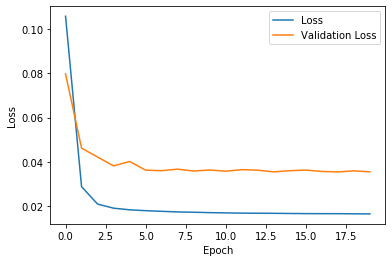

In [31]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [45]:
checkpoint.restore('C:/Users/IVCL/Desktop/NADS_Net/checkpoints_dock5_DR_occlusionX/ckpt-4')

# Test

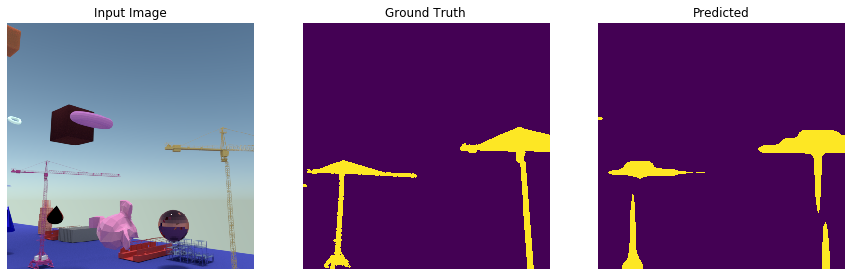

In [47]:
num = 900
image = read_image(test_paths[num])
label = get_label(test_paths[num])
generate_images(NADS_Net, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


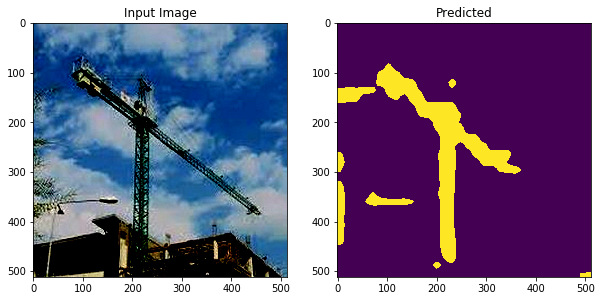

In [46]:
image = read_image('C:/Users/IVCL/Desktop/TC_Real_512/0272.jpg')
image = image[tf.newaxis, ...]
prediction = NADS_Net(image, training=False)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0))
plt.title('Predicted')

plt.show()